In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc


from sklearn.svm import SVC, NuSVC
from sklearn import preprocessing
from sklearn import impute
from sklearn import pipeline

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

#def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
#    y_true = data.get_label()
#    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
DEFAULT_PARAMS = dict(
    probability=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
    random_state=2112,
)

def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            clf = SVC(**model_params)
            clf.fit(
                train_df[input_cols].values, 
                train_df["Class"].values, 
            )
            y_pred = clf.predict_proba(valid_df[input_cols].values)

            metrics.append( balanced_logloss_(y_pred[:,1], valid_df["Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    _model_params = dict(
        C = trial.suggest_float("C", 1e-5, 1e2, log=True),
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        degree = trial.suggest_int("degree", 2, 5),
        gamma = trial.suggest_float("gamma", 1e-5, 1e2, log=True),
        coef0 = trial.suggest_float("coef0", -1, 1),
        shrinking = trial.suggest_categorical("shrinking", [True, False]),
        tol = 10**(trial.suggest_int("tol_exp", -8, -2)),
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None]),        
    )
    model_params = {**DEFAULT_PARAMS, **_model_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time
train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False,
)

CPU times: user 3.42 s, sys: 2.13 ms, total: 3.42 s
Wall time: 3.42 s


(0.5642001237989362, 0.09480635892539183)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-c-svc",
    direction='minimize',
    storage='sqlite:///iarc-c-svc.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=5000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-07-12 05:26:08,159] Using an existing study with name 'iarc-c-svc' instead of creating a new one.


[I 2023-07-12 05:26:12,073] Trial 182 finished with value: 0.45085792770412986 and parameters: {'C': 15.306291825940217, 'class_weight': None, 'coef0': 0.932841709114327, 'degree': 5, 'gamma': 0.5433473904116212, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:16,088] Trial 183 finished with value: 0.44498952357939764 and parameters: {'C': 13.845540456173605, 'class_weight': None, 'coef0': 0.9427066113576551, 'degree': 5, 'gamma': 0.5045704809046989, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:20,358] Trial 184 finished with value: 0.48702522301137485 and parameters: {'C': 20.50030984488857, 'class_weight': None, 'coef0': 0.8905184640390622, 'degree': 5, 'gamma': 0.8187621709917378, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:24,115] Trial 185 finished with value: 0.4416091946475424 and parameters: {'C': 13.224752907643483, 'class_weight': None, 'coef0': 0.739070107850061, 'degree': 5, 'gamma': 0.3968874686324546, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:27,770] Trial 186 finished with value: 0.45182093148868346 and parameters: {'C': 15.050215281946286, 'class_weight': None, 'coef0': 0.708087905172505, 'degree': 5, 'gamma': 0.2930902387793773, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:31,369] Trial 187 finished with value: 0.45742617606449754 and parameters: {'C': 30.02603224021267, 'class_weight': None, 'coef0': 0.7602072159461748, 'degree': 5, 'gamma': 0.1985000236428552, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:35,291] Trial 188 finished with value: 0.46644384586929993 and parameters: {'C': 19.96018424181967, 'class_weight': 'balanced', 'coef0': 0.8286365312074914, 'degree': 5, 'gamma': 0.42972494098391273, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:38,861] Trial 189 finished with value: 0.4631490594912853 and parameters: {'C': 10.817530818891933, 'class_weight': None, 'coef0': 0.749829290921871, 'degree': 5, 'gamma': 0.30915218098707503, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:43,079] Trial 190 finished with value: 0.5154553098257815 and parameters: {'C': 48.53208157957652, 'class_weight': None, 'coef0': 0.8095219716510168, 'degree': 5, 'gamma': 1.1136737589522305, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:46,852] Trial 191 finished with value: 0.4585736369176502 and parameters: {'C': 27.996067945572527, 'class_weight': None, 'coef0': 0.6734313905397974, 'degree': 5, 'gamma': 0.4271353646714433, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:50,685] Trial 192 finished with value: 0.4452058068251691 and parameters: {'C': 7.8757004452581265, 'class_weight': None, 'coef0': 0.9416726839492369, 'degree': 5, 'gamma': 0.6425564087091334, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:54,501] Trial 193 finished with value: 0.4467691760518819 and parameters: {'C': 7.421195137836425, 'class_weight': None, 'coef0': 0.9351374197629613, 'degree': 5, 'gamma': 0.5446074908208534, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:26:58,409] Trial 194 finished with value: 0.5433702560011094 and parameters: {'C': 0.2838223111964591, 'class_weight': None, 'coef0': 0.8724866076920993, 'degree': 5, 'gamma': 0.7432459954160959, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:01,910] Trial 195 finished with value: 0.4727530363677921 and parameters: {'C': 13.612154245326275, 'class_weight': None, 'coef0': 0.9445242843853394, 'degree': 5, 'gamma': 0.23657110165963532, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:05,476] Trial 196 finished with value: 0.45685719118710943 and parameters: {'C': 9.845375219665176, 'class_weight': None, 'coef0': 0.8954776456526179, 'degree': 5, 'gamma': 0.35594027636913006, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:09,271] Trial 197 finished with value: 0.45496737930525666 and parameters: {'C': 16.93852707651528, 'class_weight': None, 'coef0': 0.8539464524455849, 'degree': 5, 'gamma': 0.5630698482372563, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:12,397] Trial 198 finished with value: 0.5848376728375783 and parameters: {'C': 4.330729130878357, 'class_weight': None, 'coef0': 0.7883172135153608, 'degree': 5, 'gamma': 0.9789693079996437, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:15,954] Trial 199 finished with value: 0.46753446915909486 and parameters: {'C': 6.481374097169992, 'class_weight': None, 'coef0': 0.719219323799474, 'degree': 5, 'gamma': 0.4056152159095059, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:19,205] Trial 200 finished with value: 0.5526691233155179 and parameters: {'C': 21.952236023857782, 'class_weight': None, 'coef0': 0.9517343971875329, 'degree': 5, 'gamma': 0.7023160593107224, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:22,676] Trial 201 finished with value: 0.6130981743890725 and parameters: {'C': 0.7181184055894159, 'class_weight': None, 'coef0': 0.9001068384042328, 'degree': 4, 'gamma': 0.12080582258472021, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:26,508] Trial 202 finished with value: 0.44674217467321653 and parameters: {'C': 10.111109710795052, 'class_weight': None, 'coef0': 0.965201319137966, 'degree': 5, 'gamma': 0.61183572001408, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:30,371] Trial 203 finished with value: 0.44467270907282896 and parameters: {'C': 13.953843725911156, 'class_weight': None, 'coef0': 0.9743124444207539, 'degree': 2, 'gamma': 0.4984419648401141, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:34,010] Trial 204 finished with value: 0.45123134279727545 and parameters: {'C': 13.378665811484957, 'class_weight': None, 'coef0': 0.8364055059656519, 'degree': 2, 'gamma': 0.31581326927861225, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:37,763] Trial 205 finished with value: 0.44741188033546764 and parameters: {'C': 16.939277782294553, 'class_weight': None, 'coef0': 0.9117532144073982, 'degree': 2, 'gamma': 0.4683614783848508, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:41,329] Trial 206 finished with value: 0.479360453324722 and parameters: {'C': 12.352947137573892, 'class_weight': None, 'coef0': 0.9986467605158184, 'degree': 3, 'gamma': 0.22038352244783038, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:44,878] Trial 207 finished with value: 0.6348123665710919 and parameters: {'C': 8.009075658195002, 'class_weight': None, 'coef0': 0.7482220245421943, 'degree': 4, 'gamma': 0.004043661069724854, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:48,181] Trial 208 finished with value: 0.5922075906843566 and parameters: {'C': 0.0023094640580405977, 'class_weight': None, 'coef0': 0.9549115400119056, 'degree': 5, 'gamma': 0.3956530402208038, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:52,273] Trial 209 finished with value: 0.50299920794691 and parameters: {'C': 24.939559178029782, 'class_weight': None, 'coef0': 0.8672193212997978, 'degree': 3, 'gamma': 0.946432358337376, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:56,091] Trial 210 finished with value: 0.560837079292959 and parameters: {'C': 0.1718607096924391, 'class_weight': None, 'coef0': 0.8087636877772382, 'degree': 5, 'gamma': 0.5249663512770482, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:27:59,366] Trial 211 finished with value: 0.9561446121528847 and parameters: {'C': 17.42421767748011, 'class_weight': None, 'coef0': 0.912959901215602, 'degree': 2, 'gamma': 0.2827242661228757, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:03,176] Trial 212 finished with value: 0.4448713509700678 and parameters: {'C': 8.78815979340691, 'class_weight': None, 'coef0': 0.996370359444195, 'degree': 5, 'gamma': 0.6166810028321629, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:07,090] Trial 213 finished with value: 0.4911709777061894 and parameters: {'C': 1.8955634431191595, 'class_weight': None, 'coef0': 0.9570137295172868, 'degree': 5, 'gamma': 0.752182601002795, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:10,812] Trial 214 finished with value: 0.4428016771208991 and parameters: {'C': 11.832255547108868, 'class_weight': None, 'coef0': 0.9277367343937314, 'degree': 5, 'gamma': 0.5063841181180326, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:14,450] Trial 215 finished with value: 0.4419055849625314 and parameters: {'C': 12.899017433620777, 'class_weight': None, 'coef0': 0.8788340500857339, 'degree': 5, 'gamma': 0.397321871697085, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:17,970] Trial 216 finished with value: 0.449149658631884 and parameters: {'C': 12.97092302010512, 'class_weight': None, 'coef0': 0.8420627231941961, 'degree': 5, 'gamma': 0.3314353952431531, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:21,440] Trial 217 finished with value: 0.5010865021936 and parameters: {'C': 10.31781882094523, 'class_weight': None, 'coef0': 0.8862334557740499, 'degree': 5, 'gamma': 0.17951020001874793, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:31,015] Trial 218 finished with value: 0.9729589333231562 and parameters: {'C': 5.615632274022452, 'class_weight': 'balanced', 'coef0': 0.785389466201032, 'degree': 5, 'gamma': 79.80411915294752, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:34,807] Trial 219 finished with value: 0.479716951081632 and parameters: {'C': 3.3368107847656736, 'class_weight': None, 'coef0': 0.8344596171790266, 'degree': 5, 'gamma': 0.5235338422311543, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:38,263] Trial 220 finished with value: 0.6013231396890594 and parameters: {'C': 14.184022303913613, 'class_weight': None, 'coef0': 0.9208477821974873, 'degree': 5, 'gamma': 0.032476865319155765, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:42,676] Trial 221 finished with value: 0.5184678805155858 and parameters: {'C': 28.94182400247178, 'class_weight': None, 'coef0': -0.34761064055345736, 'degree': 5, 'gamma': 1.2393105438326468, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:46,411] Trial 222 finished with value: 0.44672239220636156 and parameters: {'C': 19.039267358494847, 'class_weight': None, 'coef0': 0.9711316975158724, 'degree': 5, 'gamma': 0.42359103494795747, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:50,053] Trial 223 finished with value: 0.44409725507428527 and parameters: {'C': 21.203668240194833, 'class_weight': None, 'coef0': 0.8849845013870097, 'degree': 5, 'gamma': 0.28309219527986274, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:53,672] Trial 224 finished with value: 0.5922042769372317 and parameters: {'C': 0.44041977607895794, 'class_weight': None, 'coef0': 0.8748688935686745, 'degree': 5, 'gamma': 0.26761881379604596, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:28:57,483] Trial 225 finished with value: 0.44271098056369973 and parameters: {'C': 10.355955600138822, 'class_weight': None, 'coef0': 0.7719367479284416, 'degree': 5, 'gamma': 0.5264452317596063, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:01,094] Trial 226 finished with value: 0.46447494075758994 and parameters: {'C': 9.229161348086866, 'class_weight': None, 'coef0': 0.6796494679375514, 'degree': 5, 'gamma': 0.3348593328662686, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:05,082] Trial 227 finished with value: 0.4793811102898991 and parameters: {'C': 20.74213147891497, 'class_weight': None, 'coef0': 0.745328454648962, 'degree': 5, 'gamma': 0.739956941062732, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:07,948] Trial 228 finished with value: 0.5638908689164562 and parameters: {'C': 1.7639089568368142e-05, 'class_weight': None, 'coef0': 0.7738143929084373, 'degree': 5, 'gamma': 0.21004940283066936, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:11,697] Trial 229 finished with value: 0.44367696309819826 and parameters: {'C': 11.431122445664485, 'class_weight': None, 'coef0': 0.8113536472178786, 'degree': 5, 'gamma': 0.5340621149929665, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:14,602] Trial 230 finished with value: 0.6404453854239535 and parameters: {'C': 6.361075333908308, 'class_weight': None, 'coef0': 0.817916185213884, 'degree': 5, 'gamma': 1.720335844069316e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:18,420] Trial 231 finished with value: 0.4438110673122506 and parameters: {'C': 9.992486727966968, 'class_weight': None, 'coef0': 0.7202595291755842, 'degree': 5, 'gamma': 0.5662798284297689, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:22,379] Trial 232 finished with value: 0.44395760747229174 and parameters: {'C': 10.606520577468014, 'class_weight': None, 'coef0': 0.7003031690852223, 'degree': 5, 'gamma': 0.555137581161809, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:26,125] Trial 233 finished with value: 0.442524866698872 and parameters: {'C': 12.51752444088626, 'class_weight': None, 'coef0': 0.7081673168126899, 'degree': 5, 'gamma': 0.48587368790165536, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:29,784] Trial 234 finished with value: 0.4490471822087776 and parameters: {'C': 11.066442883927966, 'class_weight': None, 'coef0': 0.731291084610067, 'degree': 5, 'gamma': 0.3674059263361326, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:33,596] Trial 235 finished with value: 0.44436076209271763 and parameters: {'C': 13.596311248502685, 'class_weight': None, 'coef0': 0.6963923720788102, 'degree': 5, 'gamma': 0.5019808401096647, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:37,158] Trial 236 finished with value: 0.45810244623238633 and parameters: {'C': 14.559072231404883, 'class_weight': None, 'coef0': 0.7084352278764212, 'degree': 5, 'gamma': 0.27823269993940125, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:40,966] Trial 237 finished with value: 0.45945383388087957 and parameters: {'C': 24.6171385847926, 'class_weight': None, 'coef0': 0.6732801517526752, 'degree': 5, 'gamma': 0.4820883865411214, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:45,016] Trial 238 finished with value: 0.4667966850752128 and parameters: {'C': 11.493952000073438, 'class_weight': None, 'coef0': 0.7157744604781453, 'degree': 5, 'gamma': 0.8474820217401272, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 171 with value: 0.4415100946405524.


[I 2023-07-12 05:29:48,727] Trial 239 finished with value: 0.44108481716709447 and parameters: {'C': 14.60185170338239, 'class_weight': None, 'coef0': 0.6800958032435374, 'degree': 5, 'gamma': 0.3927022761693554, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:29:52,440] Trial 240 finished with value: 0.545244476185487 and parameters: {'C': 32.17499242873305, 'class_weight': None, 'coef0': 0.6703841561370902, 'degree': 5, 'gamma': 0.33765486428743313, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:29:55,984] Trial 241 finished with value: 0.4561770211116374 and parameters: {'C': 19.989036083663166, 'class_weight': None, 'coef0': 0.6501511237158348, 'degree': 5, 'gamma': 0.24273655076784742, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:29:59,742] Trial 242 finished with value: 0.44206858211635724 and parameters: {'C': 13.163211670845548, 'class_weight': None, 'coef0': 0.7520486255451646, 'degree': 5, 'gamma': 0.4625466727852021, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:03,441] Trial 243 finished with value: 0.44421264371227615 and parameters: {'C': 11.426205802935153, 'class_weight': None, 'coef0': 0.7578298015699396, 'degree': 5, 'gamma': 0.39929645829637744, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:07,102] Trial 244 finished with value: 0.4461665876035392 and parameters: {'C': 11.049616117548794, 'class_weight': None, 'coef0': 0.7609927854242394, 'degree': 5, 'gamma': 0.3899672153366048, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:10,699] Trial 245 finished with value: 0.4496742097259477 and parameters: {'C': 16.02285877906871, 'class_weight': None, 'coef0': 0.7370834981579064, 'degree': 5, 'gamma': 0.2922105008228335, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:14,405] Trial 246 finished with value: 0.4471121077904819 and parameters: {'C': 9.542331804278241, 'class_weight': None, 'coef0': 0.76398967647197, 'degree': 5, 'gamma': 0.42753748233236233, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:17,673] Trial 247 finished with value: 0.5329854193707437 and parameters: {'C': 17.598107424298046, 'class_weight': None, 'coef0': 0.7799740176509448, 'degree': 5, 'gamma': 0.16701440777773216, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:25,205] Trial 248 finished with value: 0.6871573966793197 and parameters: {'C': 40.96307642582691, 'class_weight': None, 'coef0': 0.7166362302988165, 'degree': 5, 'gamma': 9.189879338984946, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:29,158] Trial 249 finished with value: 0.4801521828235711 and parameters: {'C': 24.337537528651772, 'class_weight': None, 'coef0': 0.7960503721627897, 'degree': 5, 'gamma': 0.6863617581771968, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:32,745] Trial 250 finished with value: 0.4538702536688024 and parameters: {'C': 10.765871224921748, 'class_weight': None, 'coef0': 0.7374587907284302, 'degree': 5, 'gamma': 0.34877679921434196, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:36,296] Trial 251 finished with value: 0.49458239218368605 and parameters: {'C': 6.758976087386244, 'class_weight': None, 'coef0': 0.6709965240962523, 'degree': 5, 'gamma': 0.24892767940213315, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:45,297] Trial 252 finished with value: 0.973151205272466 and parameters: {'C': 6.556672780560975e-05, 'class_weight': None, 'coef0': -0.025961686218082702, 'degree': 5, 'gamma': 41.874546773695236, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:49,495] Trial 253 finished with value: 0.4631445250918303 and parameters: {'C': 14.053934027031698, 'class_weight': 'balanced', 'coef0': 0.7889683913128569, 'degree': 5, 'gamma': 0.5841138148782853, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:53,713] Trial 254 finished with value: 0.5258280895462748 and parameters: {'C': 1.000994431096125, 'class_weight': None, 'coef0': 0.6413046173442227, 'degree': 5, 'gamma': 0.8177831519114016, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:30:57,477] Trial 255 finished with value: 0.4545746263336593 and parameters: {'C': 24.03702231233871, 'class_weight': None, 'coef0': 0.5720377976976445, 'degree': 5, 'gamma': 0.43842729296515487, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:01,060] Trial 256 finished with value: 0.9453025130183853 and parameters: {'C': 5.581215909096886, 'class_weight': None, 'coef0': 0.7082889402057535, 'degree': 5, 'gamma': 0.3203357465467716, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:05,327] Trial 257 finished with value: 0.47263108655219177 and parameters: {'C': 9.189720824092769, 'class_weight': None, 'coef0': -0.10925212039711499, 'degree': 5, 'gamma': 1.005559555820419, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:12,183] Trial 258 finished with value: 0.5792168165357712 and parameters: {'C': 16.237497294814936, 'class_weight': None, 'coef0': 0.7550151840154028, 'degree': 5, 'gamma': 4.045304470678002, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:15,846] Trial 259 finished with value: 0.5592826345665167 and parameters: {'C': 0.10857831074636459, 'class_weight': None, 'coef0': 0.7886443116200952, 'degree': 5, 'gamma': 0.5462451028793908, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:19,382] Trial 260 finished with value: 0.6311101958287852 and parameters: {'C': 0.19792673835894398, 'class_weight': None, 'coef0': 0.8269854488075663, 'degree': 5, 'gamma': 0.011614387756988745, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:23,083] Trial 261 finished with value: 0.6006012807918335 and parameters: {'C': 0.0685692502224066, 'class_weight': None, 'coef0': 0.6987412272900667, 'degree': 5, 'gamma': 0.20949803073768672, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:26,902] Trial 262 finished with value: 0.5753864501008149 and parameters: {'C': 0.4207718303096179, 'class_weight': None, 'coef0': 0.8311509180090841, 'degree': 5, 'gamma': 0.4023506980566135, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:30,997] Trial 263 finished with value: 0.45291230516892755 and parameters: {'C': 11.33632865321066, 'class_weight': None, 'coef0': -0.8751365036468388, 'degree': 5, 'gamma': 0.6661563226255451, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:34,703] Trial 264 finished with value: 0.44674906234072204 and parameters: {'C': 32.17148725155016, 'class_weight': None, 'coef0': 0.5994308548866382, 'degree': 5, 'gamma': 0.269102573300239, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:38,533] Trial 265 finished with value: 0.45639383117988097 and parameters: {'C': 21.67042495714155, 'class_weight': None, 'coef0': 0.7488265966665998, 'degree': 5, 'gamma': 0.49482034914733425, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:42,689] Trial 266 finished with value: 0.47845197092110536 and parameters: {'C': 15.244795953450508, 'class_weight': None, 'coef0': 0.8592275876282632, 'degree': 5, 'gamma': 0.8537869309578257, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:46,387] Trial 267 finished with value: 0.45807314746919425 and parameters: {'C': 61.05068534405191, 'class_weight': None, 'coef0': 0.803592129876499, 'degree': 5, 'gamma': 0.1508867211010997, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:50,003] Trial 268 finished with value: 0.46702276156465955 and parameters: {'C': 7.875995827152249, 'class_weight': None, 'coef0': 0.6572566864158107, 'degree': 5, 'gamma': 0.3545144891130321, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:52,844] Trial 269 finished with value: 0.5641962444163162 and parameters: {'C': 12.096337047078967, 'class_weight': None, 'coef0': 0.7250311022094945, 'degree': 5, 'gamma': 0.08527242068362391, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:31:56,575] Trial 270 finished with value: 0.46788108419465935 and parameters: {'C': 4.500541855285721, 'class_weight': None, 'coef0': 0.7723039031814403, 'degree': 5, 'gamma': 0.5386485872563714, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:00,084] Trial 271 finished with value: 0.46591436385319973 and parameters: {'C': 19.999768806377414, 'class_weight': None, 'coef0': 0.376139713550965, 'degree': 5, 'gamma': 0.21576550060859753, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:04,349] Trial 272 finished with value: 0.4964551979287604 and parameters: {'C': 6.985357667157997, 'class_weight': 'balanced', 'coef0': 0.49645244754892043, 'degree': 5, 'gamma': 1.1966583090962113, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:07,482] Trial 273 finished with value: 0.593964044694768 and parameters: {'C': 28.263439181043346, 'class_weight': None, 'coef0': 0.8671867368071906, 'degree': 5, 'gamma': 1.713240210682226, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:11,129] Trial 274 finished with value: 0.5067663188959505 and parameters: {'C': 2.8631263852630253, 'class_weight': None, 'coef0': 0.11586704487165272, 'degree': 5, 'gamma': 0.3752449489439354, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:15,043] Trial 275 finished with value: 0.4508318966134034 and parameters: {'C': 10.552992366946349, 'class_weight': None, 'coef0': 0.8201287889743898, 'degree': 5, 'gamma': 0.6588894591123774, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:18,481] Trial 276 finished with value: 0.5899251501137105 and parameters: {'C': 0.004535289496910248, 'class_weight': None, 'coef0': 0.6713849276756625, 'degree': 5, 'gamma': 0.3249872040391411, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:24,964] Trial 277 finished with value: 0.5559141915342856 and parameters: {'C': 15.055813537540736, 'class_weight': None, 'coef0': 0.7407055828650767, 'degree': 5, 'gamma': 3.023456985929051, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:28,836] Trial 278 finished with value: 0.5007592069286497 and parameters: {'C': 82.04012006669183, 'class_weight': None, 'coef0': 0.862194336601511, 'degree': 5, 'gamma': 0.46756343329235617, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:31,641] Trial 279 finished with value: 0.9288581942441633 and parameters: {'C': 42.268689382657875, 'class_weight': None, 'coef0': 0.5928749912859672, 'degree': 5, 'gamma': 0.2682178708746456, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:35,696] Trial 280 finished with value: 0.5376024181932582 and parameters: {'C': 0.3057232464155627, 'class_weight': None, 'coef0': 0.6972535682384394, 'degree': 5, 'gamma': 0.8385620653666969, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:39,503] Trial 281 finished with value: 0.4526194049276446 and parameters: {'C': 19.34142347048525, 'class_weight': None, 'coef0': 0.07074560927994988, 'degree': 5, 'gamma': 0.4879895611217583, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:43,128] Trial 282 finished with value: 0.6087726602056086 and parameters: {'C': 0.787092024004613, 'class_weight': None, 'coef0': 0.7836804726057209, 'degree': 5, 'gamma': 0.15138284732929813, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:47,169] Trial 283 finished with value: 0.4472517575457784 and parameters: {'C': 8.160126949124706, 'class_weight': None, 'coef0': 0.8971787647253877, 'degree': 5, 'gamma': 0.6751380902134893, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:50,772] Trial 284 finished with value: 0.4441764134773301 and parameters: {'C': 12.233113864564297, 'class_weight': None, 'coef0': 0.8252794335797635, 'degree': 5, 'gamma': 0.3803265865151436, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:32:54,357] Trial 285 finished with value: 0.5914659366362245 and parameters: {'C': 1.199424989130728, 'class_weight': None, 'coef0': 0.839224132779404, 'degree': 5, 'gamma': 0.21284869805913795, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:02,463] Trial 286 finished with value: 0.9020578260772346 and parameters: {'C': 1.8938495777408415, 'class_weight': None, 'coef0': 0.15391951349867278, 'degree': 5, 'gamma': 22.421453670326184, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:06,036] Trial 287 finished with value: 0.44430657711729005 and parameters: {'C': 24.62983686847648, 'class_weight': None, 'coef0': 0.21273724320694704, 'degree': 5, 'gamma': 0.30962109656605125, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:10,346] Trial 288 finished with value: 0.4917426989015274 and parameters: {'C': 15.79039606375995, 'class_weight': None, 'coef0': 0.8126351986167218, 'degree': 5, 'gamma': 0.9728300544542139, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:13,169] Trial 289 finished with value: 1.2219995674828703 and parameters: {'C': 0.00025296740271786615, 'class_weight': None, 'coef0': -0.6579058524974053, 'degree': 5, 'gamma': 5.55909660917011, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:16,629] Trial 290 finished with value: 0.6121556886948973 and parameters: {'C': 5.2343822385113, 'class_weight': None, 'coef0': 0.8931705271631257, 'degree': 5, 'gamma': 0.04657931389706596, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:20,897] Trial 291 finished with value: 0.443341817979066 and parameters: {'C': 9.010811788341666, 'class_weight': None, 'coef0': 0.8579801273256663, 'degree': 5, 'gamma': 0.564102791089684, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:26,277] Trial 292 finished with value: 0.4545271086049152 and parameters: {'C': 9.004966530949714, 'class_weight': 'balanced', 'coef0': 0.2667105946483106, 'degree': 5, 'gamma': 0.6232252321345102, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:31,375] Trial 293 finished with value: 0.48889630261783423 and parameters: {'C': 6.671950828679846, 'class_weight': None, 'coef0': 0.5490086804799207, 'degree': 5, 'gamma': 1.3656190463966003, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:41,369] Trial 294 finished with value: 0.5437984275246077 and parameters: {'C': 34.780829293274486, 'class_weight': None, 'coef0': 0.865633267151524, 'degree': 5, 'gamma': 0.11060361866063227, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:45,103] Trial 295 finished with value: 0.5563345715666251 and parameters: {'C': 0.5614285639535729, 'class_weight': None, 'coef0': 0.9063500885165385, 'degree': 5, 'gamma': 0.5639525820735358, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:49,552] Trial 296 finished with value: 0.4857530171452921 and parameters: {'C': 18.831362033959344, 'class_weight': None, 'coef0': 0.6336736679758648, 'degree': 5, 'gamma': 0.8369811552436562, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:52,120] Trial 297 finished with value: 0.6361451596466212 and parameters: {'C': 3.835610890798164, 'class_weight': None, 'coef0': 0.449284735450909, 'degree': 5, 'gamma': 0.0009593825450981558, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:33:56,137] Trial 298 finished with value: 0.44242660179213006 and parameters: {'C': 14.053513161582137, 'class_weight': None, 'coef0': 0.72535965210053, 'degree': 5, 'gamma': 0.45864616594676816, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:00,413] Trial 299 finished with value: 0.46540129479450854 and parameters: {'C': 22.865192655349336, 'class_weight': None, 'coef0': 0.691869782965124, 'degree': 5, 'gamma': 0.569759576268018, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:03,746] Trial 300 finished with value: 0.6001398170069292 and parameters: {'C': 0.04926298969078722, 'class_weight': None, 'coef0': 0.738325062954557, 'degree': 5, 'gamma': 0.24742490363709965, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:08,698] Trial 301 finished with value: 0.5208306279802397 and parameters: {'C': 0.23068778141860055, 'class_weight': None, 'coef0': 0.6261743524338298, 'degree': 4, 'gamma': 2.0379227804861944, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:13,163] Trial 302 finished with value: 0.44249514831834114 and parameters: {'C': 15.678118941505316, 'class_weight': None, 'coef0': 0.3313068172607737, 'degree': 5, 'gamma': 0.42923996345257104, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:18,176] Trial 303 finished with value: 0.5004576318353908 and parameters: {'C': 14.618630132107041, 'class_weight': None, 'coef0': 0.5795651942314204, 'degree': 5, 'gamma': 1.1280500259050574, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:23,196] Trial 304 finished with value: 0.45265616313866613 and parameters: {'C': 8.992820625697577, 'class_weight': None, 'coef0': 0.6904725090022525, 'degree': 5, 'gamma': 0.7292939416701141, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:26,777] Trial 305 finished with value: 1.0549907959424947 and parameters: {'C': 0.13232942657771007, 'class_weight': None, 'coef0': 0.41294379301959494, 'degree': 5, 'gamma': 0.464382263484265, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:30,808] Trial 306 finished with value: 0.5368615540247167 and parameters: {'C': 1.4378603735171032, 'class_weight': None, 'coef0': 0.40105102846921903, 'degree': 5, 'gamma': 0.4320469639229468, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:38,801] Trial 307 finished with value: 0.7620717708569766 and parameters: {'C': 13.59062162577388, 'class_weight': None, 'coef0': 0.5355520642816827, 'degree': 5, 'gamma': 13.202079548489122, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:43,229] Trial 308 finished with value: 0.4586240118248193 and parameters: {'C': 6.137535833357095, 'class_weight': None, 'coef0': 0.7609962002558005, 'degree': 5, 'gamma': 0.9221101497306912, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:48,423] Trial 309 finished with value: 0.4479340205599748 and parameters: {'C': 10.137036830007284, 'class_weight': None, 'coef0': 0.6427849639458295, 'degree': 5, 'gamma': 0.6283822702818194, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:52,950] Trial 310 finished with value: 0.44269532457640615 and parameters: {'C': 16.84064035869107, 'class_weight': None, 'coef0': 0.7263007305784953, 'degree': 5, 'gamma': 0.32679742861092115, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:34:56,612] Trial 311 finished with value: 0.6022128992208499 and parameters: {'C': 0.020554692112192775, 'class_weight': None, 'coef0': 0.046161866897101, 'degree': 5, 'gamma': 0.204503928655746, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:02,017] Trial 312 finished with value: 0.47649923560857005 and parameters: {'C': 30.952604153568707, 'class_weight': 'balanced', 'coef0': 0.3183112733528578, 'degree': 5, 'gamma': 0.3102314032866754, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:06,204] Trial 313 finished with value: 0.4895406323591558 and parameters: {'C': 15.771586386038862, 'class_weight': None, 'coef0': 0.4757970784440696, 'degree': 5, 'gamma': 0.16753078057979884, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:09,564] Trial 314 finished with value: 0.585426305174081 and parameters: {'C': 0.03893501409413133, 'class_weight': None, 'coef0': 0.14812350979047528, 'degree': 5, 'gamma': 0.38446913490474904, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:14,450] Trial 315 finished with value: 0.4437767443716363 and parameters: {'C': 19.602678523802066, 'class_weight': None, 'coef0': 0.3315142086078514, 'degree': 5, 'gamma': 0.294872986577398, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:20,206] Trial 316 finished with value: 0.4959901238139573 and parameters: {'C': 96.4628813392533, 'class_weight': None, 'coef0': 0.7180660376180826, 'degree': 5, 'gamma': 0.07189569482238672, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:25,772] Trial 317 finished with value: 0.4526403393621476 and parameters: {'C': 41.10339544760678, 'class_weight': None, 'coef0': 0.521197961968243, 'degree': 5, 'gamma': 0.26486047454047873, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:30,301] Trial 318 finished with value: 0.4948411106288775 and parameters: {'C': 22.34856298004743, 'class_weight': None, 'coef0': 0.2597954802958656, 'degree': 5, 'gamma': 0.13257764152407178, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:45,928] Trial 319 finished with value: 0.5489615575282228 and parameters: {'C': 27.09523249754459, 'class_weight': None, 'coef0': 0.4090435742376794, 'degree': 5, 'gamma': 0.34524138205365706, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:52,004] Trial 320 finished with value: 0.45106231090211074 and parameters: {'C': 50.956725682191234, 'class_weight': None, 'coef0': 0.10418000844157024, 'degree': 5, 'gamma': 0.19389775850466617, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:35:58,188] Trial 321 finished with value: 0.5691650284846024 and parameters: {'C': 17.84205993833138, 'class_weight': None, 'coef0': 0.7842775870731039, 'degree': 5, 'gamma': 0.48338036412424823, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:02,052] Trial 322 finished with value: 0.5909678897321697 and parameters: {'C': 0.08433392077947544, 'class_weight': None, 'coef0': 0.7379843570940422, 'degree': 5, 'gamma': 0.2773975319810233, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:06,939] Trial 323 finished with value: 0.4585899138712219 and parameters: {'C': 7.905191396109964, 'class_weight': None, 'coef0': 0.2582875396044311, 'degree': 5, 'gamma': 0.8525375588034959, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:11,230] Trial 324 finished with value: 0.45541086937749303 and parameters: {'C': 12.953718623438222, 'class_weight': None, 'coef0': 0.3230846894652601, 'degree': 5, 'gamma': 0.6552377383883183, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:15,944] Trial 325 finished with value: 0.44342275638311324 and parameters: {'C': 19.201259761004124, 'class_weight': None, 'coef0': 0.6239715042059414, 'degree': 5, 'gamma': 0.3832122307494745, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:19,580] Trial 326 finished with value: 0.6104305661794098 and parameters: {'C': 32.1413155472593, 'class_weight': None, 'coef0': 0.2889411032207067, 'degree': 5, 'gamma': 0.012222297519217518, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:24,241] Trial 327 finished with value: 0.4423262039793403 and parameters: {'C': 19.235019293047788, 'class_weight': None, 'coef0': 0.6016675648534995, 'degree': 5, 'gamma': 0.35273728867146414, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:29,231] Trial 328 finished with value: 0.4561552299905898 and parameters: {'C': 26.67568483578826, 'class_weight': None, 'coef0': 0.6009703283380445, 'degree': 5, 'gamma': 0.4200018759269025, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:35,451] Trial 329 finished with value: 0.5629102732178708 and parameters: {'C': 15.93635042987757, 'class_weight': None, 'coef0': 0.6850717085150592, 'degree': 5, 'gamma': 3.3311096073889557, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:39,136] Trial 330 finished with value: 0.8381362681999625 and parameters: {'C': 12.863250037003509, 'class_weight': None, 'coef0': 0.6450328686928412, 'degree': 5, 'gamma': 0.2041311717420893, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:44,332] Trial 331 finished with value: 0.5634643850847086 and parameters: {'C': 21.493139072058824, 'class_weight': 'balanced', 'coef0': 0.5963286678783292, 'degree': 5, 'gamma': 0.028704975046988532, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:48,210] Trial 332 finished with value: 0.5163490285834286 and parameters: {'C': 2.7649699400122203, 'class_weight': None, 'coef0': 0.460585421828244, 'degree': 5, 'gamma': 0.3396227342349232, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:53,562] Trial 333 finished with value: 0.5217239342991568 and parameters: {'C': 58.634857910531736, 'class_weight': None, 'coef0': 0.5799025364760606, 'degree': 5, 'gamma': 1.3911394362860359, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:36:58,292] Trial 334 finished with value: 0.4450508454417424 and parameters: {'C': 16.189758707930476, 'class_weight': None, 'coef0': 0.6607328651186877, 'degree': 5, 'gamma': 0.4564014742803169, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:01,968] Trial 335 finished with value: 0.5767906652018733 and parameters: {'C': 5.2079719923153815, 'class_weight': None, 'coef0': 0.5532548169784848, 'degree': 5, 'gamma': 0.104167435540061, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:06,243] Trial 336 finished with value: 0.44729618214025474 and parameters: {'C': 34.964560244696834, 'class_weight': None, 'coef0': 0.7991543433397315, 'degree': 5, 'gamma': 0.24841595362457958, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:10,246] Trial 337 finished with value: 0.5469060415061933 and parameters: {'C': 0.02374205582766873, 'class_weight': None, 'coef0': 0.5046171640112123, 'degree': 5, 'gamma': 0.6926472480922541, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:13,825] Trial 338 finished with value: 0.6364031484173276 and parameters: {'C': 9.018486302175614, 'class_weight': None, 'coef0': 0.00307584422262569, 'degree': 5, 'gamma': 0.0002107634411330683, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:17,657] Trial 339 finished with value: 0.5789153359971078 and parameters: {'C': 0.013218536930302173, 'class_weight': None, 'coef0': 0.8421993518178027, 'degree': 5, 'gamma': 0.3727063111594493, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:22,074] Trial 340 finished with value: 0.444102019164179 and parameters: {'C': 12.06552466313904, 'class_weight': None, 'coef0': 0.6130071394868092, 'degree': 5, 'gamma': 0.5282748164016904, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:25,722] Trial 341 finished with value: 0.6227383319417615 and parameters: {'C': 0.43030385185416276, 'class_weight': None, 'coef0': 0.766748950530731, 'degree': 5, 'gamma': 0.05654624464836154, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:32,165] Trial 342 finished with value: 0.5428098168008577 and parameters: {'C': 21.792205889181687, 'class_weight': None, 'coef0': 0.8550304126697112, 'degree': 5, 'gamma': 2.4013273913270172, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:35,114] Trial 343 finished with value: 0.7029797535765192 and parameters: {'C': 0.0011944226377601883, 'class_weight': None, 'coef0': 0.3722251112407094, 'degree': 4, 'gamma': 0.9573834282127199, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:37,844] Trial 344 finished with value: 0.6164510398411839 and parameters: {'C': 0.7671981715926403, 'class_weight': None, 'coef0': 0.6714408221128306, 'degree': 3, 'gamma': 0.1772300686793464, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:41,438] Trial 345 finished with value: 0.47900314490593776 and parameters: {'C': 7.09162985476524, 'class_weight': None, 'coef0': 0.9214222013149649, 'degree': 5, 'gamma': 0.3083859405449402, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:44,434] Trial 346 finished with value: 0.641264969939208 and parameters: {'C': 0.35445827183239137, 'class_weight': None, 'coef0': -0.08449503170446271, 'degree': 5, 'gamma': 0.4525962794347126, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:48,599] Trial 347 finished with value: 0.4592415823163714 and parameters: {'C': 17.63564720949276, 'class_weight': None, 'coef0': 0.7761618068945968, 'degree': 5, 'gamma': 0.5981785465427663, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:55,912] Trial 348 finished with value: 0.6389568158761173 and parameters: {'C': 25.881514715418053, 'class_weight': None, 'coef0': 0.8126011526584275, 'degree': 5, 'gamma': 6.841534025387063, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:37:59,484] Trial 349 finished with value: 0.47810635942535434 and parameters: {'C': 12.313253292985987, 'class_weight': None, 'coef0': 0.5435704836074075, 'degree': 5, 'gamma': 0.22612145548857804, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:03,655] Trial 350 finished with value: 0.46697555916334565 and parameters: {'C': 9.933440837318074, 'class_weight': 'balanced', 'coef0': 0.7247429674698797, 'degree': 5, 'gamma': 0.7660771931923488, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:07,438] Trial 351 finished with value: 0.5433291240175123 and parameters: {'C': 1.5722960922796125, 'class_weight': None, 'coef0': 0.8205584992212593, 'degree': 5, 'gamma': 0.3598598103155006, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:11,015] Trial 352 finished with value: 0.4771841844538778 and parameters: {'C': 39.481428699617794, 'class_weight': None, 'coef0': 0.8774684874374851, 'degree': 5, 'gamma': 0.13779262780478327, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:23,695] Trial 353 finished with value: 0.9720067443436875 and parameters: {'C': 4.155118196601086, 'class_weight': None, 'coef0': 0.9218692447791268, 'degree': 5, 'gamma': 37.868756731548764, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:27,869] Trial 354 finished with value: 0.5004965439698722 and parameters: {'C': 17.076615331113114, 'class_weight': None, 'coef0': 0.7395087021302668, 'degree': 5, 'gamma': 1.0684256441732323, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:31,097] Trial 355 finished with value: 1.0938506931547958 and parameters: {'C': 7.687647944925942, 'class_weight': None, 'coef0': 0.6346073636718144, 'degree': 5, 'gamma': 0.4860595892123309, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:34,639] Trial 356 finished with value: 0.4595851269997669 and parameters: {'C': 13.245652388825004, 'class_weight': None, 'coef0': -0.9702723525212418, 'degree': 5, 'gamma': 0.2883305992206555, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:42,264] Trial 357 finished with value: 0.7325074326514618 and parameters: {'C': 28.873604449305116, 'class_weight': None, 'coef0': 0.6893132216206963, 'degree': 5, 'gamma': 11.540644078560003, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:49,326] Trial 358 finished with value: 0.5916647062142225 and parameters: {'C': 20.416769431303297, 'class_weight': None, 'coef0': -0.17624818408564835, 'degree': 5, 'gamma': 4.617529490506175, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:38:58,595] Trial 359 finished with value: 0.9730870440360608 and parameters: {'C': 5.709971241676462, 'class_weight': None, 'coef0': -0.30802939359032233, 'degree': 5, 'gamma': 69.74543843212946, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:02,422] Trial 360 finished with value: 0.4487912274307331 and parameters: {'C': 10.0360909695317, 'class_weight': None, 'coef0': 0.7718395789762063, 'degree': 5, 'gamma': 0.39643686176978804, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:06,702] Trial 361 finished with value: 0.4560103087156016 and parameters: {'C': 14.346985465786416, 'class_weight': None, 'coef0': 0.8353635453905504, 'degree': 5, 'gamma': 0.6308126017638814, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:10,167] Trial 362 finished with value: 0.603140196505694 and parameters: {'C': 25.37460079207234, 'class_weight': None, 'coef0': 0.8669363462153383, 'degree': 5, 'gamma': 0.020221583465678414, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:13,125] Trial 363 finished with value: 0.7249556032876463 and parameters: {'C': 0.00025736445249485495, 'class_weight': None, 'coef0': 0.7913891437739837, 'degree': 5, 'gamma': 1.8450177240854237, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:16,904] Trial 364 finished with value: 0.46214592382088654 and parameters: {'C': 70.22072032336484, 'class_weight': None, 'coef0': 0.1954458801704929, 'degree': 5, 'gamma': 0.22423400522412731, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:21,161] Trial 365 finished with value: 0.539612201791566 and parameters: {'C': 0.1568964151608808, 'class_weight': None, 'coef0': 0.7122265702260511, 'degree': 5, 'gamma': 0.8022451572262056, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:24,595] Trial 366 finished with value: 0.5883426056541763 and parameters: {'C': 17.89588018475286, 'class_weight': None, 'coef0': 0.9262668855639938, 'degree': 5, 'gamma': 0.04034542804218731, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:28,072] Trial 367 finished with value: 0.615540196678623 and parameters: {'C': 44.31310771564238, 'class_weight': None, 'coef0': 0.6530873586080681, 'degree': 5, 'gamma': 0.006949349973711287, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:30,547] Trial 368 finished with value: 0.6365073527377748 and parameters: {'C': 0.10108018822819727, 'class_weight': None, 'coef0': 0.6071601767771677, 'degree': 5, 'gamma': 0.003361760472197433, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:34,289] Trial 369 finished with value: 0.5661614987905945 and parameters: {'C': 0.24263609032437042, 'class_weight': None, 'coef0': 0.23173632448351172, 'degree': 5, 'gamma': 0.48276948796595515, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:38,591] Trial 370 finished with value: 0.4730313592175835 and parameters: {'C': 8.969644203541685, 'class_weight': 'balanced', 'coef0': 0.8899102038633844, 'degree': 5, 'gamma': 0.3231864881909962, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:42,355] Trial 371 finished with value: 0.5772622208267222 and parameters: {'C': 12.095336709716348, 'class_weight': None, 'coef0': 0.7562787974528918, 'degree': 5, 'gamma': 0.6543486802260257, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:46,912] Trial 372 finished with value: 0.4753685533322307 and parameters: {'C': 7.233279325557121, 'class_weight': None, 'coef0': 0.3657869164778975, 'degree': 5, 'gamma': 1.1337405000678196, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:50,790] Trial 373 finished with value: 0.442435380078957 and parameters: {'C': 15.38717841950989, 'class_weight': None, 'coef0': 0.05830982910127275, 'degree': 5, 'gamma': 0.43353081946410804, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:54,517] Trial 374 finished with value: 0.4515699096239654 and parameters: {'C': 20.98648588166784, 'class_weight': None, 'coef0': -0.20707489592193495, 'degree': 5, 'gamma': 0.25023094441112564, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:39:58,909] Trial 375 finished with value: 0.4745652110652436 and parameters: {'C': 30.27317064555973, 'class_weight': None, 'coef0': 0.06896366626834324, 'degree': 5, 'gamma': 0.15990355871697415, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:02,817] Trial 376 finished with value: 0.4411734427006515 and parameters: {'C': 15.002968229926829, 'class_weight': None, 'coef0': 0.169987586592237, 'degree': 5, 'gamma': 0.37281796895667874, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:06,729] Trial 377 finished with value: 0.4411339015527522 and parameters: {'C': 15.11206578217614, 'class_weight': None, 'coef0': 0.056886752912390426, 'degree': 5, 'gamma': 0.377655818528958, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:10,371] Trial 378 finished with value: 0.6075244600669369 and parameters: {'C': 2.971414352159601, 'class_weight': None, 'coef0': 0.12991184861189736, 'degree': 5, 'gamma': 0.08129927426644493, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:14,835] Trial 379 finished with value: 0.44230809432613555 and parameters: {'C': 19.848761361446236, 'class_weight': None, 'coef0': 0.011003323855992939, 'degree': 5, 'gamma': 0.3169715541240425, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:18,625] Trial 380 finished with value: 0.5917087181092464 and parameters: {'C': 1.2811815939724307, 'class_weight': None, 'coef0': 0.02705187966049614, 'degree': 5, 'gamma': 0.20313181541065317, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:21,339] Trial 381 finished with value: 0.9351085497327738 and parameters: {'C': 52.166247321232966, 'class_weight': None, 'coef0': 0.1148966407072026, 'degree': 5, 'gamma': 0.30746319344967543, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:25,223] Trial 382 finished with value: 0.5786475537658305 and parameters: {'C': 0.4964159481428808, 'class_weight': None, 'coef0': 0.041109445749644195, 'degree': 5, 'gamma': 0.3749203517191957, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:29,734] Trial 383 finished with value: 0.44457018055681496 and parameters: {'C': 24.48523419930933, 'class_weight': None, 'coef0': -0.006120142514485071, 'degree': 5, 'gamma': 0.26671639688376725, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:33,419] Trial 384 finished with value: 0.6024925627843478 and parameters: {'C': 2.082352389110279, 'class_weight': None, 'coef0': 0.07899555903310909, 'degree': 5, 'gamma': 0.11729215864469948, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:37,185] Trial 385 finished with value: 0.47114005139427884 and parameters: {'C': 33.1113719100902, 'class_weight': None, 'coef0': 0.21093335456549514, 'degree': 5, 'gamma': 0.16052317824570211, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:41,651] Trial 386 finished with value: 0.4414439857968144 and parameters: {'C': 17.161980029331104, 'class_weight': None, 'coef0': -0.0353602158216085, 'degree': 5, 'gamma': 0.3574987956155218, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:45,261] Trial 387 finished with value: 0.6121540038546017 and parameters: {'C': 13.675197159069453, 'class_weight': None, 'coef0': -0.03904224164973348, 'degree': 5, 'gamma': 0.020833189060986017, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:48,950] Trial 388 finished with value: 0.49700067229781103 and parameters: {'C': 9.154239104848019, 'class_weight': None, 'coef0': -0.004419355609109783, 'degree': 5, 'gamma': 0.20383464490229103, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:52,112] Trial 389 finished with value: 0.6061330571061028 and parameters: {'C': 1.154315150875089e-05, 'class_weight': None, 'coef0': 0.17278663184735288, 'degree': 4, 'gamma': 0.29173492907885623, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:40:56,211] Trial 390 finished with value: 0.46395700064393336 and parameters: {'C': 5.470483861204748, 'class_weight': None, 'coef0': 0.026771205032016375, 'degree': 5, 'gamma': 0.49599701535497864, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:00,601] Trial 391 finished with value: 0.4891994455631263 and parameters: {'C': 17.606508616732096, 'class_weight': 'balanced', 'coef0': -0.06389659035246797, 'degree': 3, 'gamma': 0.6992214115940323, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:04,469] Trial 392 finished with value: 0.5775759050683775 and parameters: {'C': 0.7056009504128545, 'class_weight': None, 'coef0': 0.056935645508727595, 'degree': 5, 'gamma': 0.3634049275950325, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:09,838] Trial 393 finished with value: 0.5131318799010489 and parameters: {'C': 11.423082282589425, 'class_weight': None, 'coef0': 0.05101175843666514, 'degree': 5, 'gamma': 1.473573971104242, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:13,621] Trial 394 finished with value: 0.5914228520370597 and parameters: {'C': 0.20149688100952542, 'class_weight': None, 'coef0': -0.0021982682064279387, 'degree': 5, 'gamma': 0.2739544550019395, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:18,414] Trial 395 finished with value: 0.46416060352401217 and parameters: {'C': 24.87953457914052, 'class_weight': None, 'coef0': 0.09243140571826913, 'degree': 5, 'gamma': 0.5269951973064257, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:20,930] Trial 396 finished with value: 0.6365085929910529 and parameters: {'C': 0.052136807758116556, 'class_weight': None, 'coef0': -0.02701499888912892, 'degree': 5, 'gamma': 1.558061631736234e-05, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:24,567] Trial 397 finished with value: 0.6134931288248372 and parameters: {'C': 4.283893851421521, 'class_weight': None, 'coef0': 0.12463531259433705, 'degree': 5, 'gamma': 8.158910767455469, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:28,783] Trial 398 finished with value: 0.5383726310639789 and parameters: {'C': 0.014309248269311374, 'class_weight': None, 'coef0': -0.05109289053373245, 'degree': 5, 'gamma': 0.8239218538774263, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:32,661] Trial 399 finished with value: 0.5767074023786979 and parameters: {'C': 0.006575282682493106, 'class_weight': None, 'coef0': 0.16557648895855787, 'degree': 5, 'gamma': 0.393824462586042, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:36,349] Trial 400 finished with value: 0.6017629939739096 and parameters: {'C': 0.07266812585912254, 'class_weight': None, 'coef0': 0.0002930528269218455, 'degree': 5, 'gamma': 0.20707814379743933, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:41,542] Trial 401 finished with value: 0.469595823259544 and parameters: {'C': 96.14671870605201, 'class_weight': None, 'coef0': 0.07828307979236897, 'degree': 5, 'gamma': 0.10638301360625735, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:49,745] Trial 402 finished with value: 0.8759297762324816 and parameters: {'C': 0.9797733755309183, 'class_weight': None, 'coef0': -0.09563346084809554, 'degree': 5, 'gamma': 19.91017134635567, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:53,430] Trial 403 finished with value: 0.5566011166764079 and parameters: {'C': 5.911600301957936e-05, 'class_weight': None, 'coef0': 0.03897872742296581, 'degree': 5, 'gamma': 0.5888766311005919, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:57,160] Trial 404 finished with value: 0.47594066421886 and parameters: {'C': 7.2173109004009195, 'class_weight': None, 'coef0': -0.02661366909789837, 'degree': 5, 'gamma': 0.32264170325475444, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:41:59,821] Trial 405 finished with value: 1.034965179376476 and parameters: {'C': 15.461558253385732, 'class_weight': None, 'coef0': -0.08012781843663745, 'degree': 5, 'gamma': 0.43171596805555584, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:05,626] Trial 406 finished with value: 0.5591775542971713 and parameters: {'C': 10.944637946233058, 'class_weight': None, 'coef0': 0.16256377831279278, 'degree': 5, 'gamma': 3.1677251917555007, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:09,272] Trial 407 finished with value: 0.636369927532726 and parameters: {'C': 20.15176893913412, 'class_weight': None, 'coef0': 0.09085111752905325, 'degree': 5, 'gamma': 0.0004457743168879746, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:13,035] Trial 408 finished with value: 0.4718167431350074 and parameters: {'C': 30.502092559905115, 'class_weight': None, 'coef0': 0.3133216533457636, 'degree': 5, 'gamma': 0.16476356302085032, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:18,034] Trial 409 finished with value: 0.4908709604739642 and parameters: {'C': 13.636920490560733, 'class_weight': None, 'coef0': 0.14698630878525148, 'degree': 5, 'gamma': 1.0248890154336696, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:22,147] Trial 410 finished with value: 0.4531317456020589 and parameters: {'C': 44.095564296372594, 'class_weight': None, 'coef0': 0.230020280493614, 'degree': 5, 'gamma': 0.2535138796734821, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:26,526] Trial 411 finished with value: 0.45457525676947114 and parameters: {'C': 8.378971755546688, 'class_weight': 'balanced', 'coef0': -0.1062022273173662, 'degree': 5, 'gamma': 0.6201466589185861, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:31,032] Trial 412 finished with value: 0.44192436793064566 and parameters: {'C': 16.875014252818136, 'class_weight': None, 'coef0': 0.01886442071155725, 'degree': 5, 'gamma': 0.385136419230021, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:34,142] Trial 413 finished with value: 0.6370372172334433 and parameters: {'C': 0.0007858358795646778, 'class_weight': None, 'coef0': 0.4539352796729501, 'degree': 5, 'gamma': 0.0014815128637585956, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:38,715] Trial 414 finished with value: 0.4450089859240736 and parameters: {'C': 22.67069619879833, 'class_weight': None, 'coef0': 0.035958651403877086, 'degree': 5, 'gamma': 0.3530151280106712, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:42,496] Trial 415 finished with value: 0.557861291306576 and parameters: {'C': 16.668493607344764, 'class_weight': None, 'coef0': 0.021983694685195808, 'degree': 5, 'gamma': 0.06775970604207647, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:47,034] Trial 416 finished with value: 0.44751887661337697 and parameters: {'C': 26.797511024567218, 'class_weight': None, 'coef0': -0.04254643261864628, 'degree': 5, 'gamma': 0.23947144669992637, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:51,972] Trial 417 finished with value: 0.47480261377620664 and parameters: {'C': 40.84295045489761, 'class_weight': None, 'coef0': 0.10442226351807268, 'degree': 5, 'gamma': 0.4488587262126262, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:55,753] Trial 418 finished with value: 0.5327003325075875 and parameters: {'C': 2.3937868253795167, 'class_weight': None, 'coef0': 0.29497895427109944, 'degree': 5, 'gamma': 0.30595267741458765, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:42:58,976] Trial 419 finished with value: 0.5595091261937334 and parameters: {'C': 13.84309547738624, 'class_weight': None, 'coef0': 0.506081637774667, 'degree': 5, 'gamma': 0.1746841876272441, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:03,835] Trial 420 finished with value: 0.4666398776581368 and parameters: {'C': 62.69341962191059, 'class_weight': None, 'coef0': -0.4479502452691013, 'degree': 5, 'gamma': 0.1300316258049887, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:07,999] Trial 421 finished with value: 0.5413151220413588 and parameters: {'C': 0.16121266271546145, 'class_weight': None, 'coef0': 0.41385100358725435, 'degree': 5, 'gamma': 0.7749852544723558, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:14,062] Trial 422 finished with value: 0.5583133378905157 and parameters: {'C': 19.212302289091703, 'class_weight': None, 'coef0': -0.05242628215679193, 'degree': 3, 'gamma': 0.41457660033098825, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:17,856] Trial 423 finished with value: 0.5963016809619011 and parameters: {'C': 0.0028546689966731614, 'class_weight': None, 'coef0': -0.15154132446033142, 'degree': 5, 'gamma': 0.23969243928701034, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:22,405] Trial 424 finished with value: 0.44495016706366775 and parameters: {'C': 11.98806990778279, 'class_weight': None, 'coef0': 0.7062859651248925, 'degree': 5, 'gamma': 0.5437160107846205, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:26,605] Trial 425 finished with value: 0.4509771985234674 and parameters: {'C': 31.52091955965998, 'class_weight': None, 'coef0': 0.009876665962443316, 'degree': 5, 'gamma': 0.3169186100484221, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:30,210] Trial 426 finished with value: 0.6135388461830723 and parameters: {'C': 17.483517174886114, 'class_weight': None, 'coef0': 0.057518181631046474, 'degree': 5, 'gamma': 0.01620330933948295, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:33,813] Trial 427 finished with value: 0.4677539002791162 and parameters: {'C': 6.2763620749799705, 'class_weight': None, 'coef0': 0.19573625381854298, 'degree': 5, 'gamma': 0.4131449204567354, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:41,944] Trial 428 finished with value: 0.7455699119421624 and parameters: {'C': 10.273013182047144, 'class_weight': None, 'coef0': 0.7396273847747901, 'degree': 5, 'gamma': 12.261436289897405, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:46,341] Trial 429 finished with value: 0.5044758163255659 and parameters: {'C': 22.248582253789834, 'class_weight': 'balanced', 'coef0': -0.13104305927841914, 'degree': 5, 'gamma': 0.8534347834594006, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:48,363] Trial 430 finished with value: 0.9675059376595432 and parameters: {'C': 3.5274608814304425, 'class_weight': None, 'coef0': 0.25297816050886607, 'degree': 5, 'gamma': 25.30091290668086, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:53,738] Trial 431 finished with value: 0.5282109436907949 and parameters: {'C': 14.264356792418296, 'class_weight': None, 'coef0': 0.675127905483474, 'degree': 5, 'gamma': 1.6867782568846468, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:43:57,196] Trial 432 finished with value: 0.49058530996974015 and parameters: {'C': 9.40574117537083, 'class_weight': None, 'coef0': -0.6443772421277052, 'degree': 5, 'gamma': 0.2202958233024724, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:03,815] Trial 433 finished with value: 0.5849867204860935 and parameters: {'C': 0.12084112480090725, 'class_weight': None, 'coef0': 0.10529655561318235, 'degree': 5, 'gamma': 4.961045038625671, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:08,061] Trial 434 finished with value: 0.4837202375765042 and parameters: {'C': 37.039856550387576, 'class_weight': None, 'coef0': -0.06659433145295736, 'degree': 5, 'gamma': 0.5667676696783976, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:11,969] Trial 435 finished with value: 0.5822927118233757 and parameters: {'C': 0.010975523020832247, 'class_weight': None, 'coef0': -0.012991338558550638, 'degree': 4, 'gamma': 0.34489960833295624, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:16,464] Trial 436 finished with value: 0.5227975883123609 and parameters: {'C': 0.2987638972757064, 'class_weight': None, 'coef0': 0.7577345767479237, 'degree': 5, 'gamma': 1.2403185673630788, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:20,603] Trial 437 finished with value: 0.456977409509577 and parameters: {'C': 22.7504284698061, 'class_weight': None, 'coef0': 0.13471849689227994, 'degree': 5, 'gamma': 0.4833843196787945, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:24,033] Trial 438 finished with value: 0.5646904223034844 and parameters: {'C': 15.025722743926881, 'class_weight': None, 'coef0': 0.3737014993665154, 'degree': 5, 'gamma': 0.0658643146398666, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:27,659] Trial 439 finished with value: 0.6271696282479938 and parameters: {'C': 0.030595459351846904, 'class_weight': None, 'coef0': 0.5592728592911309, 'degree': 5, 'gamma': 0.0356341691292319, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:30,896] Trial 440 finished with value: 0.6489048235670697 and parameters: {'C': 5.629361959512527, 'class_weight': None, 'coef0': 0.7130005199212377, 'degree': 5, 'gamma': 6.634166834668578e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:33,845] Trial 441 finished with value: 0.6537888058782874 and parameters: {'C': 0.001559971022681175, 'class_weight': None, 'coef0': 0.2816199728512282, 'degree': 5, 'gamma': 0.00464854663475912, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:37,857] Trial 442 finished with value: 0.5409916434849907 and parameters: {'C': 0.0674290946198502, 'class_weight': None, 'coef0': 0.35352293717492705, 'degree': 5, 'gamma': 0.7795651903481683, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:45,744] Trial 443 finished with value: 0.7981710924605612 and parameters: {'C': 11.608592738738393, 'class_weight': None, 'coef0': 0.18121104455106016, 'degree': 5, 'gamma': 15.399896965258133, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:48,727] Trial 444 finished with value: 0.5761421654757336 and parameters: {'C': 7.211445149065482, 'class_weight': None, 'coef0': 0.0732530091494022, 'degree': 5, 'gamma': 0.2558953267148043, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:52,240] Trial 445 finished with value: 0.6090335564801722 and parameters: {'C': 0.009166232722508, 'class_weight': None, 'coef0': 0.7944826908701524, 'degree': 5, 'gamma': 0.16208511316081425, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:44:56,024] Trial 446 finished with value: 0.4477258086125422 and parameters: {'C': 19.126811171460762, 'class_weight': None, 'coef0': 0.6609222680625242, 'degree': 5, 'gamma': 0.43289754284382675, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:05,534] Trial 447 finished with value: 0.9716366434898276 and parameters: {'C': 0.0005715202737608257, 'class_weight': None, 'coef0': 0.007408068347023802, 'degree': 5, 'gamma': 35.04834241105717, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:09,538] Trial 448 finished with value: 0.47359410092149523 and parameters: {'C': 27.638280834363414, 'class_weight': 'balanced', 'coef0': 0.7313544219001625, 'degree': 5, 'gamma': 0.31526899445438245, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:13,131] Trial 449 finished with value: 0.6344619997083931 and parameters: {'C': 15.016265695936033, 'class_weight': None, 'coef0': 0.7625991941756698, 'degree': 5, 'gamma': 0.008644199949807613, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:17,101] Trial 450 finished with value: 0.5497347659939059 and parameters: {'C': 4.0635494395868015e-05, 'class_weight': None, 'coef0': -0.028092454326961794, 'degree': 5, 'gamma': 0.6557829073571594, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:19,706] Trial 451 finished with value: 0.5537014609584027 and parameters: {'C': 10.601311874071481, 'class_weight': None, 'coef0': 0.4926838644972679, 'degree': 5, 'gamma': 0.10749918910209116, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:23,199] Trial 452 finished with value: 0.5908479428986392 and parameters: {'C': 18.94534880491508, 'class_weight': None, 'coef0': 0.5806128803922133, 'degree': 2, 'gamma': 0.03659313341142992, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:28,869] Trial 453 finished with value: 0.4590431410043356 and parameters: {'C': 71.49075231454161, 'class_weight': None, 'coef0': -0.22309883623590776, 'degree': 5, 'gamma': 0.20572576839581203, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:32,209] Trial 454 finished with value: 0.9659552113096994 and parameters: {'C': 0.5344184511480362, 'class_weight': None, 'coef0': -0.12737260987209442, 'degree': 5, 'gamma': 2.169790140711538, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:35,607] Trial 455 finished with value: 0.5892393234506201 and parameters: {'C': 2.3738542000122066e-05, 'class_weight': None, 'coef0': 0.687815561867345, 'degree': 5, 'gamma': 0.36516916800172666, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:39,136] Trial 456 finished with value: 0.6016267187883559 and parameters: {'C': 8.08236316247084, 'class_weight': None, 'coef0': 0.42601636058708725, 'degree': 5, 'gamma': 0.045618312156063386, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:42,133] Trial 457 finished with value: 0.5783020823483572 and parameters: {'C': 0.00013646958160293724, 'class_weight': None, 'coef0': 0.041757058062478127, 'degree': 5, 'gamma': 0.5499710664950553, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:47,152] Trial 458 finished with value: 0.5118509038983703 and parameters: {'C': 37.75167094069159, 'class_weight': None, 'coef0': 0.7981209712848403, 'degree': 5, 'gamma': 0.9753090999421872, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:50,876] Trial 459 finished with value: 0.5811111409838038 and parameters: {'C': 0.9771216121814531, 'class_weight': None, 'coef0': -0.08131586107943796, 'degree': 5, 'gamma': 0.29631559705582305, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:54,727] Trial 460 finished with value: 0.5695455284489941 and parameters: {'C': 0.35833786970602133, 'class_weight': None, 'coef0': 0.19584958462363974, 'degree': 5, 'gamma': 0.45258521037354543, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:45:59,140] Trial 461 finished with value: 0.4522601387477793 and parameters: {'C': 12.83376806907872, 'class_weight': None, 'coef0': 0.6375198154793301, 'degree': 5, 'gamma': 0.6168612237056531, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:10,004] Trial 462 finished with value: 0.9727689630448957 and parameters: {'C': 26.512477399856902, 'class_weight': None, 'coef0': 0.24157316489956626, 'degree': 5, 'gamma': 99.12627634205514, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:13,400] Trial 463 finished with value: 0.6360126744935278 and parameters: {'C': 16.005123567628164, 'class_weight': None, 'coef0': 0.7342230738783875, 'degree': 5, 'gamma': 4.12269939424922e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:20,661] Trial 464 finished with value: 0.6508900913804596 and parameters: {'C': 4.272013832284975, 'class_weight': None, 'coef0': 0.4551241464674587, 'degree': 5, 'gamma': 7.410169395372567, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:24,964] Trial 465 finished with value: 0.4544419610784528 and parameters: {'C': 54.114199677742114, 'class_weight': None, 'coef0': 0.13442655607438211, 'degree': 5, 'gamma': 0.2228681298425097, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:28,528] Trial 466 finished with value: 0.6344251571354633 and parameters: {'C': 1.5154349875292203, 'class_weight': None, 'coef0': 0.8275421637797301, 'degree': 5, 'gamma': 0.0018972286942872869, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:32,416] Trial 467 finished with value: 0.5789048254360176 and parameters: {'C': 0.021514846634149404, 'class_weight': None, 'coef0': 0.5237290038517174, 'degree': 5, 'gamma': 0.372763848390733, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:34,769] Trial 468 finished with value: 0.6357617054708478 and parameters: {'C': 0.09821591712369777, 'class_weight': None, 'coef0': 0.7753335334527901, 'degree': 5, 'gamma': 0.1435443041337201, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:42,043] Trial 469 finished with value: 0.9876680226611841 and parameters: {'C': 0.02563689435193187, 'class_weight': 'balanced', 'coef0': 0.6832438361612937, 'degree': 5, 'gamma': 0.029954231063004436, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:46,198] Trial 470 finished with value: 0.5425446626556479 and parameters: {'C': 0.038919553251117275, 'class_weight': None, 'coef0': 0.0823579960693568, 'degree': 5, 'gamma': 0.75559679029526, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:49,296] Trial 471 finished with value: 0.608547532430391 and parameters: {'C': 10.664958284429394, 'class_weight': None, 'coef0': 0.025257835109452946, 'degree': 5, 'gamma': 0.29328263829859863, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:52,400] Trial 472 finished with value: 0.6190907895032289 and parameters: {'C': 0.004569648886105016, 'class_weight': None, 'coef0': 0.330059074804399, 'degree': 5, 'gamma': 0.024880855949504593, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:46:55,982] Trial 473 finished with value: 0.6124622367111453 and parameters: {'C': 21.987418176863063, 'class_weight': None, 'coef0': 0.2807970401681508, 'degree': 5, 'gamma': 0.014469839740381643, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:01,014] Trial 474 finished with value: 0.48093213037761356 and parameters: {'C': 7.992395107395216, 'class_weight': None, 'coef0': 0.7149550394914571, 'degree': 4, 'gamma': 1.1713356375690036, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:04,847] Trial 475 finished with value: 0.4441584731973375 and parameters: {'C': 14.167563943821861, 'class_weight': None, 'coef0': 0.8028080087764166, 'degree': 5, 'gamma': 0.4877777094645028, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:08,602] Trial 476 finished with value: 0.4570734547422811 and parameters: {'C': 29.61410801276068, 'class_weight': None, 'coef0': 0.6129313263448879, 'degree': 5, 'gamma': 0.395917927109584, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:12,205] Trial 477 finished with value: 0.5230817330570655 and parameters: {'C': 5.58220693157736, 'class_weight': None, 'coef0': -0.042744320503898786, 'degree': 5, 'gamma': 0.19029141136125197, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:16,194] Trial 478 finished with value: 0.5450238866305235 and parameters: {'C': 0.008605025043428407, 'class_weight': None, 'coef0': 0.8434927964909242, 'degree': 5, 'gamma': 0.7175254050122584, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:19,957] Trial 479 finished with value: 0.5612150866848326 and parameters: {'C': 1.8160842335580782, 'class_weight': None, 'coef0': 0.6619641271935737, 'degree': 5, 'gamma': 0.2570270529093203, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:24,031] Trial 480 finished with value: 0.664542977060118 and parameters: {'C': 18.489177607600745, 'class_weight': None, 'coef0': 0.7622369554470496, 'degree': 5, 'gamma': 0.09041928426536434, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:27,874] Trial 481 finished with value: 0.4427565269590683 and parameters: {'C': 10.689027480729337, 'class_weight': None, 'coef0': 0.3783218986084669, 'degree': 5, 'gamma': 0.5274807325264178, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:32,873] Trial 482 finished with value: 0.5058009641023486 and parameters: {'C': 8.967711959072606, 'class_weight': None, 'coef0': 0.40542164414622806, 'degree': 5, 'gamma': 1.4516506222406353, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:37,018] Trial 483 finished with value: 0.5313332694514452 and parameters: {'C': 0.00033655374644319156, 'class_weight': None, 'coef0': 0.4672987333831265, 'degree': 5, 'gamma': 0.9643919378754913, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:40,831] Trial 484 finished with value: 0.4485890790357129 and parameters: {'C': 6.743928506540653, 'class_weight': None, 'coef0': -0.7003425468131921, 'degree': 5, 'gamma': 0.5649915402209367, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:44,544] Trial 485 finished with value: 0.4429498866601951 and parameters: {'C': 11.690381715425866, 'class_weight': None, 'coef0': 0.3947369011791007, 'degree': 5, 'gamma': 0.5150123081017989, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:48,452] Trial 486 finished with value: 0.4556915306338339 and parameters: {'C': 9.748211913698366, 'class_weight': None, 'coef0': 0.36778901652983903, 'degree': 5, 'gamma': 0.751097464171971, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:52,093] Trial 487 finished with value: 0.4822849769777408 and parameters: {'C': 3.6447765509543246, 'class_weight': None, 'coef0': 0.2912865785119666, 'degree': 5, 'gamma': 0.45721527627202696, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:47:57,536] Trial 488 finished with value: 0.5978992001510723 and parameters: {'C': 12.064789099146052, 'class_weight': 'balanced', 'coef0': 0.38655618436224826, 'degree': 5, 'gamma': 0.018455866634671424, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:03,639] Trial 489 finished with value: 0.53309496808816 and parameters: {'C': 6.297880901576532, 'class_weight': None, 'coef0': 0.5841743945020901, 'degree': 5, 'gamma': 2.314821517826897, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:07,405] Trial 490 finished with value: 0.4496822337094974 and parameters: {'C': 12.348092322389473, 'class_weight': None, 'coef0': 0.3316408348868582, 'degree': 5, 'gamma': 0.5956126389200771, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:10,943] Trial 491 finished with value: 0.5216710176818128 and parameters: {'C': 2.639536832199207, 'class_weight': None, 'coef0': 0.35583348136070275, 'degree': 5, 'gamma': 0.32737268129823555, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:13,856] Trial 492 finished with value: 0.5716230844350888 and parameters: {'C': 0.0009056474131995087, 'class_weight': None, 'coef0': 0.26749265428910185, 'degree': 5, 'gamma': 0.49379292230308885, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:17,692] Trial 493 finished with value: 0.5418676269351276 and parameters: {'C': 0.08339997792808311, 'class_weight': None, 'coef0': 0.5480600344876738, 'degree': 5, 'gamma': 0.7983214970814532, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:21,178] Trial 494 finished with value: 0.47517432935883563 and parameters: {'C': 8.379335085832885, 'class_weight': None, 'coef0': 0.45798472581107696, 'degree': 5, 'gamma': 0.29508570268293804, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:23,643] Trial 495 finished with value: 0.6365092292223781 and parameters: {'C': 0.016265716334125952, 'class_weight': None, 'coef0': 0.21250048711874694, 'degree': 5, 'gamma': 0.0003342880662112013, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:27,483] Trial 496 finished with value: 0.6069905474225236 and parameters: {'C': 4.871788038848863, 'class_weight': None, 'coef0': 0.5040386999272678, 'degree': 5, 'gamma': 3.1729764494383623, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:31,010] Trial 497 finished with value: 0.5754865852116969 and parameters: {'C': 15.289596271169913, 'class_weight': None, 'coef0': 0.15551512416051155, 'degree': 5, 'gamma': 0.056262594298091315, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:35,181] Trial 498 finished with value: 0.4886743712871741 and parameters: {'C': 10.861543570425619, 'class_weight': None, 'coef0': 0.3562210688100537, 'degree': 5, 'gamma': 1.1094578798937014, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:39,058] Trial 499 finished with value: 0.4493732486010981 and parameters: {'C': 22.488913864206413, 'class_weight': None, 'coef0': 0.30504306398017045, 'degree': 5, 'gamma': 0.39986816070392317, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:42,673] Trial 500 finished with value: 0.48937633921099777 and parameters: {'C': 14.055408165929473, 'class_weight': None, 'coef0': 0.12202741974428184, 'degree': 5, 'gamma': 0.1775424252555137, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:46,798] Trial 501 finished with value: 0.4455259059441616 and parameters: {'C': 7.4089072700347645, 'class_weight': None, 'coef0': 0.0019319877128153914, 'degree': 5, 'gamma': 0.5771495378883524, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:50,348] Trial 502 finished with value: 0.44748411360338997 and parameters: {'C': 35.99127839019164, 'class_weight': None, 'coef0': 0.05518426306097406, 'degree': 5, 'gamma': 0.24322348899043644, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:54,578] Trial 503 finished with value: 0.5351347367295562 and parameters: {'C': 0.06004764141095099, 'class_weight': None, 'coef0': 0.43249721066555247, 'degree': 5, 'gamma': 0.8846125851626657, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:48:58,300] Trial 504 finished with value: 0.9707008825268042 and parameters: {'C': 0.04110959158751684, 'class_weight': None, 'coef0': 0.42925021582651796, 'degree': 5, 'gamma': 0.35364286779235815, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:01,736] Trial 505 finished with value: 0.6179541426144032 and parameters: {'C': 18.192573169518646, 'class_weight': None, 'coef0': 0.6443478837406297, 'degree': 5, 'gamma': 0.012674799126739642, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:05,563] Trial 506 finished with value: 0.4464998819115948 and parameters: {'C': 10.12247960535898, 'class_weight': None, 'coef0': 0.39512168446480406, 'degree': 5, 'gamma': 0.6080682013871562, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:09,841] Trial 507 finished with value: 0.4698406363814972 and parameters: {'C': 21.300830574664086, 'class_weight': 'balanced', 'coef0': 0.7031594213498013, 'degree': 5, 'gamma': 0.4455006064579272, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:13,516] Trial 508 finished with value: 0.593895510522187 and parameters: {'C': 0.17582629817195444, 'class_weight': None, 'coef0': -0.4239496323015517, 'degree': 5, 'gamma': 0.25465845982016894, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:16,382] Trial 509 finished with value: 0.5945050860255531 and parameters: {'C': 0.00017295638693667044, 'class_weight': None, 'coef0': 0.24064528594291137, 'degree': 5, 'gamma': 8.235019360388752e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:19,950] Trial 510 finished with value: 0.6173385665912153 and parameters: {'C': 50.14317169812665, 'class_weight': None, 'coef0': -0.0853010388121047, 'degree': 5, 'gamma': 0.005096939862771776, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:23,024] Trial 511 finished with value: 0.6357884668012352 and parameters: {'C': 0.00010954937085307192, 'class_weight': None, 'coef0': 0.4798608518358486, 'degree': 5, 'gamma': 2.396398143081657e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:26,624] Trial 512 finished with value: 0.6361795543557871 and parameters: {'C': 12.8347692786375, 'class_weight': None, 'coef0': 0.5281653791962506, 'degree': 5, 'gamma': 0.000730786678001493, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:31,050] Trial 513 finished with value: 0.5177384945414842 and parameters: {'C': 0.6662418295820278, 'class_weight': None, 'coef0': 0.08457090293770089, 'degree': 5, 'gamma': 1.5820106700588075, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:35,693] Trial 514 finished with value: 0.4488933069276391 and parameters: {'C': 24.781630131308233, 'class_weight': None, 'coef0': -0.27760214584574316, 'degree': 5, 'gamma': 0.3641743456390013, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:39,227] Trial 515 finished with value: 0.6363052570199473 and parameters: {'C': 86.62011444740854, 'class_weight': None, 'coef0': -0.5260157015443969, 'degree': 5, 'gamma': 0.0002471115965918182, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:43,235] Trial 516 finished with value: 0.45068466766743354 and parameters: {'C': 5.278669790787622, 'class_weight': None, 'coef0': 0.7360640936464607, 'degree': 2, 'gamma': 0.697485911641173, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:46,821] Trial 517 finished with value: 0.6358385174731978 and parameters: {'C': 0.21433166024515188, 'class_weight': None, 'coef0': -0.04159790428621951, 'degree': 5, 'gamma': 0.0014586402557350269, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:50,110] Trial 518 finished with value: 0.6275598180431053 and parameters: {'C': 0.004004055194560708, 'class_weight': None, 'coef0': 0.2101146267445158, 'degree': 5, 'gamma': 0.1303968052313915, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:55,044] Trial 519 finished with value: 0.5557183922288909 and parameters: {'C': 16.46901202134144, 'class_weight': None, 'coef0': -0.13606853751546288, 'degree': 5, 'gamma': 26.71000374704287, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:49:58,977] Trial 520 finished with value: 0.5639857670728426 and parameters: {'C': 0.48035579366020703, 'class_weight': None, 'coef0': 0.32752919731939345, 'degree': 5, 'gamma': 0.4988444728092051, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:02,837] Trial 521 finished with value: 0.568095540353395 and parameters: {'C': 0.0012499037365048815, 'class_weight': None, 'coef0': 0.6246571677641967, 'degree': 3, 'gamma': 19.281063510368487, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:05,649] Trial 522 finished with value: 0.5984557292016094 and parameters: {'C': 0.018968293642907516, 'class_weight': None, 'coef0': 0.6753101391704681, 'degree': 5, 'gamma': 0.0006363710092882156, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:09,359] Trial 523 finished with value: 0.6044735217223834 and parameters: {'C': 0.2607226491842236, 'class_weight': None, 'coef0': 0.5833950410557424, 'degree': 5, 'gamma': 0.18823955826296868, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:13,543] Trial 524 finished with value: 0.47446850515788713 and parameters: {'C': 9.086088059051756, 'class_weight': None, 'coef0': 0.02661681138930113, 'degree': 4, 'gamma': 1.0329542087654482, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:16,387] Trial 525 finished with value: 0.6045648962231396 and parameters: {'C': 0.002483625739983384, 'class_weight': None, 'coef0': 0.7811518466341426, 'degree': 5, 'gamma': 0.010184270308571065, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:20,319] Trial 526 finished with value: 0.44634542115960807 and parameters: {'C': 27.887166887435832, 'class_weight': None, 'coef0': 0.15664045514320324, 'degree': 5, 'gamma': 0.3066113750275524, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:27,114] Trial 527 finished with value: 0.7421268354835591 and parameters: {'C': 0.1249883907528628, 'class_weight': 'balanced', 'coef0': -0.8075232600830267, 'degree': 5, 'gamma': 0.495538574797321, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:30,753] Trial 528 finished with value: 1.027179111114264 and parameters: {'C': 0.0282307245755514, 'class_weight': None, 'coef0': 0.7173348309193451, 'degree': 5, 'gamma': 0.7144981712768731, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:34,377] Trial 529 finished with value: 0.4742252250796321 and parameters: {'C': 12.22434269795141, 'class_weight': None, 'coef0': -0.17445143001646501, 'degree': 5, 'gamma': 0.24444219577923557, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:37,995] Trial 530 finished with value: 0.6351766135587602 and parameters: {'C': 7.19827948537326, 'class_weight': None, 'coef0': 0.8072764878517318, 'degree': 5, 'gamma': 0.0034397491298458287, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:41,861] Trial 531 finished with value: 0.44154502040586124 and parameters: {'C': 16.89640542492093, 'class_weight': None, 'coef0': 0.38661482614527726, 'degree': 5, 'gamma': 0.3707801176179501, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:45,949] Trial 532 finished with value: 0.45996987025198566 and parameters: {'C': 35.238744598450886, 'class_weight': None, 'coef0': 0.09765978996673169, 'degree': 5, 'gamma': 0.36721581898488126, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:49,645] Trial 533 finished with value: 0.4730855342652914 and parameters: {'C': 18.78386793777622, 'class_weight': None, 'coef0': 0.8496580197562407, 'degree': 5, 'gamma': 0.20149890420403443, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:52,954] Trial 534 finished with value: 0.6272582735379931 and parameters: {'C': 0.006358210798871871, 'class_weight': None, 'coef0': 0.1843419480304736, 'degree': 5, 'gamma': 0.09391774509248176, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:50:59,336] Trial 535 finished with value: 0.5982897923393388 and parameters: {'C': 16.430217354712887, 'class_weight': None, 'coef0': 0.7479786751044595, 'degree': 5, 'gamma': 4.929302920489396, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:03,036] Trial 536 finished with value: 0.48810153881316076 and parameters: {'C': 27.959143768115066, 'class_weight': None, 'coef0': -0.013821370294899812, 'degree': 5, 'gamma': 0.13325191576324918, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:05,876] Trial 537 finished with value: 0.597294983846904 and parameters: {'C': 0.0017924946380606988, 'class_weight': None, 'coef0': 0.34394058479010187, 'degree': 5, 'gamma': 0.00011947104612759184, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:09,799] Trial 538 finished with value: 0.4434538435959424 and parameters: {'C': 23.364479494396193, 'class_weight': None, 'coef0': 0.6989979367079386, 'degree': 5, 'gamma': 0.2903056129532539, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:13,991] Trial 539 finished with value: 0.47211672604074495 and parameters: {'C': 47.31881689507099, 'class_weight': None, 'coef0': 0.5412709121242191, 'degree': 5, 'gamma': 0.3797318806331608, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:17,689] Trial 540 finished with value: 0.45945261497225276 and parameters: {'C': 14.992413630693513, 'class_weight': None, 'coef0': 0.27341835646937923, 'degree': 5, 'gamma': 0.27098709391682513, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:21,613] Trial 541 finished with value: 0.5263026592700587 and parameters: {'C': 1.2196447039676797, 'class_weight': None, 'coef0': 0.6262504649299987, 'degree': 5, 'gamma': 0.631578138620646, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:24,326] Trial 542 finished with value: 0.5890973328279298 and parameters: {'C': 3.78414255391565, 'class_weight': None, 'coef0': 0.7598814019662209, 'degree': 5, 'gamma': 0.4363127753316088, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:27,905] Trial 543 finished with value: 0.5025987038166868 and parameters: {'C': 9.991259775942781, 'class_weight': None, 'coef0': 0.4193638069729258, 'degree': 5, 'gamma': 0.17985625418392773, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:32,032] Trial 544 finished with value: 0.4776203774516853 and parameters: {'C': 2.1654518216554424, 'class_weight': None, 'coef0': 0.8240127361109741, 'degree': 5, 'gamma': 0.9480721384109213, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:36,651] Trial 545 finished with value: 0.6014638648928073 and parameters: {'C': 18.80071184210981, 'class_weight': 'balanced', 'coef0': 0.06403515240824881, 'degree': 5, 'gamma': 0.3332897081315125, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:40,330] Trial 546 finished with value: 0.6218673942120647 and parameters: {'C': 0.04407637566865448, 'class_weight': None, 'coef0': 0.6834063464306919, 'degree': 5, 'gamma': 0.061048968176312404, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:44,216] Trial 547 finished with value: 0.44964710930774404 and parameters: {'C': 6.626692079590036, 'class_weight': None, 'coef0': 0.22202754443549355, 'degree': 5, 'gamma': 0.5565634990768595, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:47,845] Trial 548 finished with value: 0.6357163798482921 and parameters: {'C': 13.591459252808983, 'class_weight': None, 'coef0': 0.2966165831170601, 'degree': 5, 'gamma': 0.0020527997741159637, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:51,558] Trial 549 finished with value: 0.44766585870571013 and parameters: {'C': 35.89805868573139, 'class_weight': None, 'coef0': -0.058058579709106134, 'degree': 5, 'gamma': 0.24825714829043893, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:55,898] Trial 550 finished with value: 0.4570861956789629 and parameters: {'C': 9.76591134761154, 'class_weight': None, 'coef0': 0.030625312314264207, 'degree': 5, 'gamma': 0.7676361881253929, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:51:59,705] Trial 551 finished with value: 0.6364312409254205 and parameters: {'C': 20.90215852487654, 'class_weight': None, 'coef0': -0.22589961287928656, 'degree': 5, 'gamma': 0.00014935190632828826, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:03,299] Trial 552 finished with value: 0.6074337287135109 and parameters: {'C': 15.263761087472203, 'class_weight': None, 'coef0': -0.9423886865799418, 'degree': 5, 'gamma': 0.023522044282997555, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:07,168] Trial 553 finished with value: 0.4588948141396799 and parameters: {'C': 7.8278318040793575, 'class_weight': None, 'coef0': 0.5797111183493427, 'degree': 5, 'gamma': 0.408264014973044, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:10,871] Trial 554 finished with value: 0.9666966633850715 and parameters: {'C': 0.3373916382458579, 'class_weight': None, 'coef0': 0.862381188031544, 'degree': 5, 'gamma': 1.3764256835722404, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:14,471] Trial 555 finished with value: 0.636230418024997 and parameters: {'C': 30.251732548578055, 'class_weight': None, 'coef0': 0.46845075308517203, 'degree': 5, 'gamma': 0.0004399847311174343, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:17,416] Trial 556 finished with value: 0.5659526707121563 and parameters: {'C': 1.0101454558310816e-05, 'class_weight': None, 'coef0': 0.7968408644706068, 'degree': 5, 'gamma': 0.14964159070260177, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:20,981] Trial 557 finished with value: 0.587891390911686 and parameters: {'C': 5.851610909119002e-05, 'class_weight': None, 'coef0': 0.7373464766404372, 'degree': 5, 'gamma': 0.33092621214596135, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:23,993] Trial 558 finished with value: 0.5830595442236323 and parameters: {'C': 9.325059075552684e-05, 'class_weight': None, 'coef0': 0.6561797634665664, 'degree': 5, 'gamma': 0.5682993764439009, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:31,721] Trial 559 finished with value: 0.7490018084202767 and parameters: {'C': 1.0364974579149193, 'class_weight': None, 'coef0': 0.10679993223762983, 'degree': 5, 'gamma': 12.672114771169671, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:35,452] Trial 560 finished with value: 0.6336817561574687 and parameters: {'C': 0.6520093624993292, 'class_weight': None, 'coef0': 0.35916626247386135, 'degree': 5, 'gamma': 0.008929666892843784, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:40,677] Trial 561 finished with value: 0.526611358533632 and parameters: {'C': 5.197349285214737, 'class_weight': None, 'coef0': 0.001587813756118911, 'degree': 5, 'gamma': 2.255218093644402, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:43,606] Trial 562 finished with value: 0.5978349417091834 and parameters: {'C': 0.0003519287499600546, 'class_weight': None, 'coef0': 0.7789999528945252, 'degree': 5, 'gamma': 0.037705090588127176, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:52:47,231] Trial 563 finished with value: 0.48069196006890796 and parameters: {'C': 11.807373932819687, 'class_weight': None, 'coef0': -0.10903601436405996, 'degree': 5, 'gamma': 0.22051130104949893, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:00,370] Trial 564 finished with value: 0.9716271236171601 and parameters: {'C': 23.703935255397287, 'class_weight': 'balanced', 'coef0': -0.34301006166133485, 'degree': 5, 'gamma': 37.05622627640625, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:07,582] Trial 565 finished with value: 0.6161629948551414 and parameters: {'C': 15.56750576578445, 'class_weight': None, 'coef0': 0.1402679005333723, 'degree': 5, 'gamma': 5.7713504709652375, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:10,031] Trial 566 finished with value: 0.6365100246150046 and parameters: {'C': 0.03363420674603036, 'class_weight': None, 'coef0': 0.5167686085559464, 'degree': 5, 'gamma': 0.007757634043207214, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:13,028] Trial 567 finished with value: 0.649849784911813 and parameters: {'C': 0.09312634721931995, 'class_weight': None, 'coef0': -0.5601204815509437, 'degree': 5, 'gamma': 0.0010014709078636122, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:16,997] Trial 568 finished with value: 0.44683878077205386 and parameters: {'C': 9.03553113520988, 'class_weight': None, 'coef0': 0.8879598238514239, 'degree': 5, 'gamma': 0.4518855643534378, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:20,810] Trial 569 finished with value: 0.5831836197767005 and parameters: {'C': 19.227872320690484, 'class_weight': None, 'coef0': 0.7054694195093179, 'degree': 5, 'gamma': 0.8076340586045145, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:24,596] Trial 570 finished with value: 0.46004333051564944 and parameters: {'C': 11.728113646890348, 'class_weight': None, 'coef0': 0.43655525067644557, 'degree': 4, 'gamma': 0.3078254059105258, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:27,529] Trial 571 finished with value: 0.7265373607990074 and parameters: {'C': 1.4478832976144968e-05, 'class_weight': None, 'coef0': 0.8253990224297145, 'degree': 5, 'gamma': 1.1614167220152, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:30,667] Trial 572 finished with value: 0.5738998499939146 and parameters: {'C': 0.0009273705625475409, 'class_weight': None, 'coef0': -0.02254026022613642, 'degree': 5, 'gamma': 0.4292622076504395, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:34,319] Trial 573 finished with value: 0.6318718436885157 and parameters: {'C': 1.563416376290479, 'class_weight': None, 'coef0': -0.16722592900544936, 'degree': 5, 'gamma': 0.014884048647002716, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:37,242] Trial 574 finished with value: 0.5960406017995562 and parameters: {'C': 3.223460412558194e-05, 'class_weight': None, 'coef0': 0.6266039691663119, 'degree': 5, 'gamma': 0.6290138186420137, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:40,895] Trial 575 finished with value: 0.5532266875381062 and parameters: {'C': 2.8154780736954845, 'class_weight': None, 'coef0': 0.7384730252237789, 'degree': 5, 'gamma': 0.21266170333138215, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:43,842] Trial 576 finished with value: 0.6349968241808912 and parameters: {'C': 0.000392928092779278, 'class_weight': None, 'coef0': 0.057251972078504076, 'degree': 5, 'gamma': 0.33616334199065884, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:51,092] Trial 577 finished with value: 0.6507021952791733 and parameters: {'C': 41.71678814299783, 'class_weight': None, 'coef0': 0.7799228352415508, 'degree': 5, 'gamma': 7.401011161739279, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:54,202] Trial 578 finished with value: 0.9675051474318173 and parameters: {'C': 1.9200984486868176e-05, 'class_weight': None, 'coef0': 0.6630368013420943, 'degree': 5, 'gamma': 3.727923335446156, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:53:58,336] Trial 579 finished with value: 0.46166355855541097 and parameters: {'C': 25.312066691238364, 'class_weight': None, 'coef0': 0.228929076658889, 'degree': 5, 'gamma': 0.4965186256994605, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:02,466] Trial 580 finished with value: 0.44931862522075144 and parameters: {'C': 6.242017147749625, 'class_weight': None, 'coef0': 0.2571218129281653, 'degree': 5, 'gamma': 0.7654522034721168, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:05,508] Trial 581 finished with value: 0.6448349478176038 and parameters: {'C': 0.0005187869409255732, 'class_weight': None, 'coef0': 0.6048537536558776, 'degree': 5, 'gamma': 0.25366447309039564, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:09,293] Trial 582 finished with value: 0.5411111804558343 and parameters: {'C': 14.343665048313186, 'class_weight': None, 'coef0': 0.8312434092596789, 'degree': 3, 'gamma': 0.08953997555058257, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:13,875] Trial 583 finished with value: 0.510638334362261 and parameters: {'C': 9.808379812753406, 'class_weight': 'balanced', 'coef0': 0.18319366031787174, 'degree': 5, 'gamma': 0.14160103518989695, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:17,603] Trial 584 finished with value: 0.5734150033581353 and parameters: {'C': 0.16724795299978176, 'class_weight': None, 'coef0': 0.314756420825124, 'degree': 5, 'gamma': 0.41281508577651466, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:21,849] Trial 585 finished with value: 0.9679553542906192 and parameters: {'C': 0.0018450782630649025, 'class_weight': None, 'coef0': 0.38189103237118655, 'degree': 5, 'gamma': 49.92444034407366, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:25,725] Trial 586 finished with value: 0.554493836317041 and parameters: {'C': 0.006412631907395141, 'class_weight': None, 'coef0': 0.48824744087876765, 'degree': 5, 'gamma': 0.594272269650804, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:30,250] Trial 587 finished with value: 0.5126344244547344 and parameters: {'C': 63.55521564162241, 'class_weight': None, 'coef0': 0.9050052139240451, 'degree': 5, 'gamma': 1.0025190766346144, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:34,158] Trial 588 finished with value: 0.4416099905952579 and parameters: {'C': 18.00551738401025, 'class_weight': None, 'coef0': 0.568787635958979, 'degree': 5, 'gamma': 0.3437258105300208, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:38,029] Trial 589 finished with value: 0.4650165362032319 and parameters: {'C': 30.12724392730251, 'class_weight': None, 'coef0': 0.5844116699825619, 'degree': 5, 'gamma': 0.18080856858667665, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:42,497] Trial 590 finished with value: 0.4450495653338624 and parameters: {'C': 21.488346106725416, 'class_weight': None, 'coef0': 0.5239855264468899, 'degree': 5, 'gamma': 0.274700935237519, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:47,346] Trial 591 finished with value: 0.554813924007751 and parameters: {'C': 17.872574632598777, 'class_weight': None, 'coef0': 0.5490919873997279, 'degree': 5, 'gamma': 73.34314423241763, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:51,232] Trial 592 finished with value: 0.5822940766135396 and parameters: {'C': 0.4243168545120172, 'class_weight': None, 'coef0': 0.6562916437548734, 'degree': 5, 'gamma': 0.34489456067983437, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:54,566] Trial 593 finished with value: 0.6127358888433286 and parameters: {'C': 0.002976979870898148, 'class_weight': None, 'coef0': 0.5621072019735655, 'degree': 5, 'gamma': 0.22880810611104668, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:54:58,474] Trial 594 finished with value: 0.4423653734660701 and parameters: {'C': 16.327052044302857, 'class_weight': None, 'coef0': -0.9985506658165162, 'degree': 5, 'gamma': 0.4110087524974874, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:00,529] Trial 595 finished with value: 0.5989392964247346 and parameters: {'C': 0.00017723967433530365, 'class_weight': None, 'coef0': -0.8529901350177396, 'degree': 5, 'gamma': 0.00021419402686214788, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:04,185] Trial 596 finished with value: 0.5877874155387314 and parameters: {'C': 0.056085677563504924, 'class_weight': None, 'coef0': -0.46473156323877857, 'degree': 4, 'gamma': 0.3026208952478356, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:08,072] Trial 597 finished with value: 0.4599807099574531 and parameters: {'C': 41.62687040278461, 'class_weight': None, 'coef0': -0.5611727700732012, 'degree': 5, 'gamma': 0.16677856324840148, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:12,774] Trial 598 finished with value: 0.45425972800100267 and parameters: {'C': 29.35087685939769, 'class_weight': None, 'coef0': -0.3412798133162962, 'degree': 5, 'gamma': 0.36977339869501213, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:16,452] Trial 599 finished with value: 0.467384061251982 and parameters: {'C': 17.516640937953902, 'class_weight': None, 'coef0': -0.6136565684517856, 'degree': 5, 'gamma': 0.2250905530730946, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:21,358] Trial 600 finished with value: 0.45071731633312384 and parameters: {'C': 22.423389723718987, 'class_weight': None, 'coef0': -0.22649877040105348, 'degree': 5, 'gamma': 0.4167024238160817, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:24,890] Trial 601 finished with value: 0.5051597677537086 and parameters: {'C': 17.131385477590914, 'class_weight': None, 'coef0': -0.708249495981345, 'degree': 5, 'gamma': 0.13150459873310266, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:28,156] Trial 602 finished with value: 0.6354158326338426 and parameters: {'C': 13.190519208389924, 'class_weight': None, 'coef0': 0.09853938466897454, 'degree': 2, 'gamma': 3.8717689403088614e-05, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:32,564] Trial 603 finished with value: 0.5078029958925157 and parameters: {'C': 74.64199364799951, 'class_weight': 'balanced', 'coef0': -0.148843785417397, 'degree': 5, 'gamma': 0.29112052745412187, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:36,101] Trial 604 finished with value: 0.6364933740767771 and parameters: {'C': 31.876455174621537, 'class_weight': None, 'coef0': 0.06787866801951474, 'degree': 5, 'gamma': 0.00011127373408745063, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:39,606] Trial 605 finished with value: 0.5340953262897571 and parameters: {'C': 23.40193774180689, 'class_weight': None, 'coef0': -0.1339399212724708, 'degree': 5, 'gamma': 0.07458272136826503, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:43,078] Trial 606 finished with value: 0.6145759772002188 and parameters: {'C': 7.765662358657075, 'class_weight': None, 'coef0': 0.1749893873092053, 'degree': 5, 'gamma': 0.030432309902382496, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:52,818] Trial 607 finished with value: 0.9724456547804005 and parameters: {'C': 0.03151739119608937, 'class_weight': None, 'coef0': -0.23516828404660028, 'degree': 5, 'gamma': 69.92913823233026, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:55:56,535] Trial 608 finished with value: 0.6145732333728084 and parameters: {'C': 50.073880909234596, 'class_weight': None, 'coef0': -0.7722158274193678, 'degree': 5, 'gamma': 0.006813833483250142, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:00,465] Trial 609 finished with value: 0.5478720855017142 and parameters: {'C': 0.0006262407050799021, 'class_weight': None, 'coef0': -0.7163645106497223, 'degree': 5, 'gamma': 0.6785810270597188, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:05,201] Trial 610 finished with value: 0.5259633160595772 and parameters: {'C': 14.43843083009178, 'class_weight': None, 'coef0': -0.6541834521188492, 'degree': 5, 'gamma': 1.6140156462224964, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:09,209] Trial 611 finished with value: 0.4513232585065117 and parameters: {'C': 20.189276184570435, 'class_weight': None, 'coef0': 0.1501279386953825, 'degree': 5, 'gamma': 0.45789324595875924, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:12,829] Trial 612 finished with value: 0.6148814896703888 and parameters: {'C': 0.013705814528680301, 'class_weight': None, 'coef0': -0.32255298134310395, 'degree': 5, 'gamma': 0.11170269062592637, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:20,403] Trial 613 finished with value: 0.7207543474980647 and parameters: {'C': 4.321414992659485, 'class_weight': None, 'coef0': -0.4877361822288775, 'degree': 5, 'gamma': 10.911832136592247, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:24,381] Trial 614 finished with value: 0.44712773187746074 and parameters: {'C': 12.55098398415347, 'class_weight': None, 'coef0': -0.7930410321395271, 'degree': 5, 'gamma': 0.35047602764871544, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:27,884] Trial 615 finished with value: 0.5073243809690646 and parameters: {'C': 8.60528567825497, 'class_weight': None, 'coef0': -0.27366404554779555, 'degree': 5, 'gamma': 0.18084196823993054, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:42,920] Trial 616 finished with value: 0.5448357729672267 and parameters: {'C': 33.17516802138777, 'class_weight': None, 'coef0': -0.08808019557016278, 'degree': 5, 'gamma': 0.551971040879213, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:47,109] Trial 617 finished with value: 0.4600505742998237 and parameters: {'C': 16.195105584207052, 'class_weight': None, 'coef0': -0.9375547446378952, 'degree': 5, 'gamma': 0.2582580693980501, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:50,611] Trial 618 finished with value: 0.6330918853083302 and parameters: {'C': 25.611397374250405, 'class_weight': None, 'coef0': -0.09166967149021038, 'degree': 5, 'gamma': 0.0038174569768015284, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:56:54,262] Trial 619 finished with value: 0.6226839353106479 and parameters: {'C': 11.48898893255754, 'class_weight': None, 'coef0': -0.604531795407592, 'degree': 5, 'gamma': 4.026969847663032, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:01,665] Trial 620 finished with value: 0.8208677586943592 and parameters: {'C': 0.07022963506619194, 'class_weight': None, 'coef0': -0.2710701990117428, 'degree': 5, 'gamma': 16.657040246783637, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:06,096] Trial 621 finished with value: 0.4615676498707936 and parameters: {'C': 3.4148788010860183, 'class_weight': None, 'coef0': -0.8377666281638221, 'degree': 5, 'gamma': 0.8568417525929615, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:09,847] Trial 622 finished with value: 0.5719605279131362 and parameters: {'C': 0.2750327665512393, 'class_weight': None, 'coef0': -0.261746513152768, 'degree': 5, 'gamma': 0.42739213408965077, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:16,576] Trial 623 finished with value: 0.7542718016499613 and parameters: {'C': 0.1432780203688725, 'class_weight': 'balanced', 'coef0': -0.1939614000119666, 'degree': 5, 'gamma': 0.2853717809479477, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:25,129] Trial 624 finished with value: 0.9665127330462236 and parameters: {'C': 0.010567014394778617, 'class_weight': None, 'coef0': -0.3622910667361659, 'degree': 5, 'gamma': 30.428701017614227, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:28,539] Trial 625 finished with value: 0.6065268441795745 and parameters: {'C': 18.604670730190108, 'class_weight': None, 'coef0': -0.4653324653971643, 'degree': 5, 'gamma': 0.021804455250559216, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:31,548] Trial 626 finished with value: 1.0709493906358671 and parameters: {'C': 1.6416783301946556, 'class_weight': None, 'coef0': -0.8684834165007136, 'degree': 5, 'gamma': 0.629111704047744, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:35,027] Trial 627 finished with value: 0.6358676551780073 and parameters: {'C': 6.581966333849672, 'class_weight': None, 'coef0': -0.6480637692324611, 'degree': 5, 'gamma': 0.0005817087532223305, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:39,015] Trial 628 finished with value: 0.44112278217329065 and parameters: {'C': 14.851183697935431, 'class_weight': None, 'coef0': 0.11355278974971936, 'degree': 5, 'gamma': 0.3849978982556563, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:42,661] Trial 629 finished with value: 0.6344978383845103 and parameters: {'C': 0.11066410413883475, 'class_weight': None, 'coef0': 0.07817096187677314, 'degree': 5, 'gamma': 0.005211610229483348, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:48,085] Trial 630 finished with value: 0.44826198703700776 and parameters: {'C': 38.79345320475353, 'class_weight': None, 'coef0': -0.4976717330852961, 'degree': 5, 'gamma': 0.22164195647127738, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:57:52,200] Trial 631 finished with value: 0.4475280452613369 and parameters: {'C': 25.452498203818035, 'class_weight': None, 'coef0': -0.4053427514392683, 'degree': 5, 'gamma': 0.34461233636813304, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:01,108] Trial 632 finished with value: 0.9727948718197568 and parameters: {'C': 0.022818083802887558, 'class_weight': None, 'coef0': -0.4410909906216326, 'degree': 5, 'gamma': 56.10721044875118, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:04,759] Trial 633 finished with value: 0.5835485159463039 and parameters: {'C': 2.094120019908327, 'class_weight': None, 'coef0': -0.27785989107587583, 'degree': 5, 'gamma': 0.16793013156142478, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:09,209] Trial 634 finished with value: 0.4982330758306802 and parameters: {'C': 86.08110717114262, 'class_weight': None, 'coef0': 0.016236216298483208, 'degree': 5, 'gamma': 0.41914072370057026, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:13,678] Trial 635 finished with value: 0.45296748102322437 and parameters: {'C': 15.733293189587405, 'class_weight': None, 'coef0': -0.8413191077409568, 'degree': 5, 'gamma': 0.2835989589223339, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:17,462] Trial 636 finished with value: 0.5698793328524066 and parameters: {'C': 8.335794029408461e-05, 'class_weight': None, 'coef0': -0.1529760868333197, 'degree': 5, 'gamma': 0.44896761671398316, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:21,959] Trial 637 finished with value: 0.46729865824817357 and parameters: {'C': 21.32107915655986, 'class_weight': None, 'coef0': 0.11154352856776664, 'degree': 3, 'gamma': 0.20558823897519296, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:24,933] Trial 638 finished with value: 0.6341583680671543 and parameters: {'C': 3.773026783729521e-05, 'class_weight': None, 'coef0': -0.7079362803654892, 'degree': 5, 'gamma': 0.0026593150859403453, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:29,079] Trial 639 finished with value: 0.5386117076752738 and parameters: {'C': 0.7712987056202195, 'class_weight': None, 'coef0': -0.6429931961803528, 'degree': 5, 'gamma': 0.7481500704395487, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:32,693] Trial 640 finished with value: 0.6293706706127916 and parameters: {'C': 12.951393429866231, 'class_weight': None, 'coef0': 0.1948864652429807, 'degree': 5, 'gamma': 0.012913452281007171, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:36,296] Trial 641 finished with value: 0.568475365975713 and parameters: {'C': 9.921066287724019, 'class_weight': None, 'coef0': -0.2172277800065311, 'degree': 5, 'gamma': 0.34414273926368943, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:41,343] Trial 642 finished with value: 0.5175832034853292 and parameters: {'C': 27.981440027733886, 'class_weight': 'balanced', 'coef0': -0.5647149242813121, 'degree': 5, 'gamma': 1.1883768342617038, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:44,893] Trial 643 finished with value: 0.6363131272491512 and parameters: {'C': 0.5159688464719944, 'class_weight': None, 'coef0': 0.12714051253404263, 'degree': 5, 'gamma': 0.00041980657548523536, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:51,949] Trial 644 finished with value: 0.7912091334756766 and parameters: {'C': 47.5350320423532, 'class_weight': None, 'coef0': -0.5303537951563396, 'degree': 5, 'gamma': 0.527669913668929, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:55,586] Trial 645 finished with value: 0.5097443764692358 and parameters: {'C': 16.160846346535717, 'class_weight': None, 'coef0': -0.6318486239672774, 'degree': 5, 'gamma': 0.12674160546587385, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:58:59,378] Trial 646 finished with value: 0.5794978421277641 and parameters: {'C': 1.0499429827623121, 'class_weight': None, 'coef0': -0.327095635687073, 'degree': 5, 'gamma': 0.29036662413318826, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:07,640] Trial 647 finished with value: 0.6867481135431968 and parameters: {'C': 9.06886973044697, 'class_weight': None, 'coef0': -0.736050323246437, 'degree': 5, 'gamma': 9.170544166944522, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:11,057] Trial 648 finished with value: 0.6357407325432771 and parameters: {'C': 0.0030151899916134547, 'class_weight': None, 'coef0': -0.571244441520903, 'degree': 4, 'gamma': 0.0019842034988694565, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:15,307] Trial 649 finished with value: 0.4649141761884865 and parameters: {'C': 19.68293985040462, 'class_weight': None, 'coef0': -0.3027789097954341, 'degree': 5, 'gamma': 0.6207821092328194, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:18,987] Trial 650 finished with value: 0.636421008573101 and parameters: {'C': 11.97883784243983, 'class_weight': None, 'coef0': 0.03763049339375871, 'degree': 5, 'gamma': 0.0002530739885700631, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:20,972] Trial 651 finished with value: 0.9675059375324656 and parameters: {'C': 62.13491701165267, 'class_weight': None, 'coef0': -0.8962318823845806, 'degree': 5, 'gamma': 43.079020880277035, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:24,527] Trial 652 finished with value: 0.5938007308445546 and parameters: {'C': 6.5675893580503795, 'class_weight': None, 'coef0': 0.46879376772898756, 'degree': 5, 'gamma': 0.06479687100976068, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:27,482] Trial 653 finished with value: 0.8400181164103132 and parameters: {'C': 0.00017916540636014165, 'class_weight': None, 'coef0': -0.37761043124362226, 'degree': 5, 'gamma': 1.9448827419602108, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:31,766] Trial 654 finished with value: 0.46153739984781766 and parameters: {'C': 35.46793612157824, 'class_weight': None, 'coef0': 0.13629521636395636, 'degree': 5, 'gamma': 0.3784606129217194, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:34,568] Trial 655 finished with value: 0.6006811157025413 and parameters: {'C': 0.006373651043215257, 'class_weight': None, 'coef0': 0.6216141701848443, 'degree': 5, 'gamma': 6.263810048426558e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:38,104] Trial 656 finished with value: 0.4732485997862024 and parameters: {'C': 14.826668683132016, 'class_weight': None, 'coef0': -0.4071637161229038, 'degree': 5, 'gamma': 0.22473276215905694, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:41,636] Trial 657 finished with value: 0.6362446088420805 and parameters: {'C': 24.469418527799878, 'class_weight': None, 'coef0': -0.025342632079673383, 'degree': 5, 'gamma': 1.3347242776569836e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:45,445] Trial 658 finished with value: 0.45057193220745106 and parameters: {'C': 18.156972010610954, 'class_weight': None, 'coef0': -0.4882720777946823, 'degree': 5, 'gamma': 0.4841936608372692, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:49,693] Trial 659 finished with value: 0.465958502836084 and parameters: {'C': 8.244434262473144, 'class_weight': None, 'coef0': -0.7390049593138408, 'degree': 5, 'gamma': 0.9427492292358427, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:54,659] Trial 660 finished with value: 0.5285104021702306 and parameters: {'C': 0.32824605756892195, 'class_weight': None, 'coef0': -0.9870699550120859, 'degree': 5, 'gamma': 2.524019589711567, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 05:59:58,449] Trial 661 finished with value: 0.587167651842756 and parameters: {'C': 0.0077340709061676565, 'class_weight': None, 'coef0': -0.603866267506801, 'degree': 5, 'gamma': 0.3094314568382072, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:02,367] Trial 662 finished with value: 0.49747185644426783 and parameters: {'C': 12.118098161598946, 'class_weight': None, 'coef0': -0.8302307950698049, 'degree': 5, 'gamma': 0.17331028638904117, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:06,713] Trial 663 finished with value: 0.4617809585208201 and parameters: {'C': 4.857316310894154, 'class_weight': 'balanced', 'coef0': 0.5467000742207685, 'degree': 5, 'gamma': 0.6342319321974007, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:09,567] Trial 664 finished with value: 0.6012949982212621 and parameters: {'C': 5.1473389736159605e-05, 'class_weight': None, 'coef0': 0.24678094695583094, 'degree': 5, 'gamma': 0.0014572309972996152, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:13,159] Trial 665 finished with value: 0.6246292622371137 and parameters: {'C': 0.004249741814295974, 'class_weight': None, 'coef0': -0.9125576406756513, 'degree': 5, 'gamma': 0.04426670204104468, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:23,476] Trial 666 finished with value: 0.5498389695642982 and parameters: {'C': 26.23380383415958, 'class_weight': None, 'coef0': -0.8029059807823438, 'degree': 5, 'gamma': 0.4022028696674762, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:26,987] Trial 667 finished with value: 0.4679044551585176 and parameters: {'C': 14.636616066189367, 'class_weight': None, 'coef0': -0.7286837369604524, 'degree': 3, 'gamma': 0.24468232241753077, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:29,743] Trial 668 finished with value: 0.6469928108996639 and parameters: {'C': 0.0006917065804457556, 'class_weight': None, 'coef0': 0.4928650216416885, 'degree': 5, 'gamma': 0.8109540256292983, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:32,596] Trial 669 finished with value: 0.5799636454396656 and parameters: {'C': 2.4221165564366298e-05, 'class_weight': None, 'coef0': 0.3056355362110889, 'degree': 5, 'gamma': 0.10409233875824866, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:36,164] Trial 670 finished with value: 0.636422981394968 and parameters: {'C': 21.228557544000765, 'class_weight': None, 'coef0': -0.4175525284704885, 'degree': 5, 'gamma': 0.00015519255554749748, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:39,924] Trial 671 finished with value: 0.4866228157089998 and parameters: {'C': 2.7628755451272022, 'class_weight': None, 'coef0': 0.07345140047750806, 'degree': 5, 'gamma': 0.5311711556175167, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:43,537] Trial 672 finished with value: 0.45448198881557544 and parameters: {'C': 10.250464739361826, 'class_weight': None, 'coef0': -0.06558277883633092, 'degree': 5, 'gamma': 0.35754133783576225, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:48,579] Trial 673 finished with value: 0.44779843216485943 and parameters: {'C': 36.12058909852313, 'class_weight': None, 'coef0': -0.5457274815889871, 'degree': 5, 'gamma': 0.2501426175300979, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:52,222] Trial 674 finished with value: 0.6332105604303865 and parameters: {'C': 0.9438784414586683, 'class_weight': None, 'coef0': -0.6576672684804077, 'degree': 5, 'gamma': 0.010358945692361714, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:55,865] Trial 675 finished with value: 1.0543568501511111 and parameters: {'C': 0.2304344977865564, 'class_weight': None, 'coef0': 0.6002649969296879, 'degree': 5, 'gamma': 0.45869742177810646, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:00:59,365] Trial 676 finished with value: 0.48694623175207113 and parameters: {'C': 15.730300771327304, 'class_weight': None, 'coef0': -0.8186433037241492, 'degree': 5, 'gamma': 0.17257545382039172, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:07,007] Trial 677 finished with value: 0.6279824539660019 and parameters: {'C': 7.810872900980724, 'class_weight': None, 'coef0': -0.5238255662258454, 'degree': 5, 'gamma': 6.324336915661041, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:11,550] Trial 678 finished with value: 0.520129770246902 and parameters: {'C': 95.59238576886952, 'class_weight': None, 'coef0': -0.41432884192311104, 'degree': 5, 'gamma': 1.31599035783828, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:18,745] Trial 679 finished with value: 0.9897854038057866 and parameters: {'C': 0.028043287594574726, 'class_weight': 'balanced', 'coef0': 0.2153321924771018, 'degree': 5, 'gamma': 0.028992722684167194, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:22,881] Trial 680 finished with value: 0.4559516581015402 and parameters: {'C': 11.940787809065835, 'class_weight': None, 'coef0': -0.6739545077021716, 'degree': 5, 'gamma': 0.6893194236941359, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:25,716] Trial 681 finished with value: 0.6013940049909414 and parameters: {'C': 0.053922514777040846, 'class_weight': None, 'coef0': 0.27602273555685014, 'degree': 5, 'gamma': 3.496167115162884e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:31,195] Trial 682 finished with value: 0.46957025560003207 and parameters: {'C': 52.991538459940585, 'class_weight': None, 'coef0': -0.8974414320691928, 'degree': 5, 'gamma': 0.32753385801593277, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:35,176] Trial 683 finished with value: 0.466785216592394 and parameters: {'C': 5.188882329983891, 'class_weight': None, 'coef0': -0.9444473195749254, 'degree': 5, 'gamma': 0.4907582886995843, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:39,563] Trial 684 finished with value: 0.4467670383954627 and parameters: {'C': 20.409358349977136, 'class_weight': None, 'coef0': 0.029311395128134375, 'degree': 5, 'gamma': 0.271267927857306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:42,539] Trial 685 finished with value: 0.6432283676773128 and parameters: {'C': 0.00024458104214462027, 'class_weight': None, 'coef0': 0.4212424553587206, 'degree': 5, 'gamma': 0.9021316735149569, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:46,011] Trial 686 finished with value: 0.6271157414432805 and parameters: {'C': 29.6240968692906, 'class_weight': None, 'coef0': -0.8994475393306115, 'degree': 5, 'gamma': 0.006239081067318792, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:48,916] Trial 687 finished with value: 0.6005882631199531 and parameters: {'C': 0.00041847664537154655, 'class_weight': None, 'coef0': -0.23578033578417362, 'degree': 5, 'gamma': 8.287811855632233e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:51,881] Trial 688 finished with value: 0.5999725938265534 and parameters: {'C': 0.0008971374927966436, 'class_weight': None, 'coef0': -0.9438431520610305, 'degree': 5, 'gamma': 0.018840443152364206, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:55,706] Trial 689 finished with value: 0.5722709323403632 and parameters: {'C': 0.0010868842216208417, 'class_weight': None, 'coef0': -0.10975481857650027, 'degree': 5, 'gamma': 0.42425694661207364, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:01:59,551] Trial 690 finished with value: 0.6024751593265122 and parameters: {'C': 0.015875451343539262, 'class_weight': None, 'coef0': -0.25046453115089296, 'degree': 5, 'gamma': 0.20285802322804738, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:02,258] Trial 691 finished with value: 0.7591710777303046 and parameters: {'C': 0.0018429714646097477, 'class_weight': None, 'coef0': -0.5136569598361078, 'degree': 5, 'gamma': 0.6521086168520592, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:05,264] Trial 692 finished with value: 0.5561611363813599 and parameters: {'C': 15.875252222768578, 'class_weight': None, 'coef0': -0.5921692396596988, 'degree': 5, 'gamma': 0.3773287283591928, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:08,324] Trial 693 finished with value: 0.6066877300965703 and parameters: {'C': 9.8355893284121, 'class_weight': None, 'coef0': 0.6930028550102452, 'degree': 5, 'gamma': 1.952773708396889e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:11,953] Trial 694 finished with value: 0.6360735251858081 and parameters: {'C': 20.746413107630772, 'class_weight': None, 'coef0': -0.3667342708202695, 'degree': 5, 'gamma': 0.0010975457299595413, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:15,518] Trial 695 finished with value: 0.474625419866231 and parameters: {'C': 7.6313473512264105, 'class_weight': None, 'coef0': -0.49719056993619404, 'degree': 5, 'gamma': 0.3183397431693899, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:21,575] Trial 696 finished with value: 0.5484735027304611 and parameters: {'C': 13.50917602826238, 'class_weight': None, 'coef0': 0.15528175944129682, 'degree': 5, 'gamma': 2.6772449367997018, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:24,481] Trial 697 finished with value: 0.5694015777704657 and parameters: {'C': 1.7218576011277172e-05, 'class_weight': None, 'coef0': -0.44318096910996474, 'degree': 5, 'gamma': 0.13068888945316934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:31,482] Trial 698 finished with value: 0.988160428275878 and parameters: {'C': 31.421105095052127, 'class_weight': 'balanced', 'coef0': -0.399576551551817, 'degree': 5, 'gamma': 1.805453465741885e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:39,709] Trial 699 finished with value: 0.9730781411757622 and parameters: {'C': 0.004438377610718692, 'class_weight': None, 'coef0': -0.8581086832570317, 'degree': 5, 'gamma': 47.828407720130286, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:43,723] Trial 700 finished with value: 0.46820798852059087 and parameters: {'C': 4.1499110062692965, 'class_weight': None, 'coef0': 0.6478952210475927, 'degree': 5, 'gamma': 0.5706804442106498, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:47,204] Trial 701 finished with value: 0.6411843127800861 and parameters: {'C': 0.7254871726345121, 'class_weight': None, 'coef0': -0.7814518524211187, 'degree': 5, 'gamma': 0.25019148420424336, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:50,957] Trial 702 finished with value: 0.5506078690500391 and parameters: {'C': 11.792484835206027, 'class_weight': None, 'coef0': 0.1082695677470271, 'degree': 5, 'gamma': 0.08983420776496172, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:55,524] Trial 703 finished with value: 0.5012756588976732 and parameters: {'C': 24.144792927250155, 'class_weight': None, 'coef0': -0.8088631871656553, 'degree': 4, 'gamma': 0.9380041711762785, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:02:58,500] Trial 704 finished with value: 0.8524498081514015 and parameters: {'C': 4.884341609242639e-05, 'class_weight': None, 'coef0': -0.7655457647856178, 'degree': 5, 'gamma': 1.6506367157871673, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:01,364] Trial 705 finished with value: 0.9670345309351391 and parameters: {'C': 1.1338836029164956e-05, 'class_weight': None, 'coef0': -0.7796126237948552, 'degree': 2, 'gamma': 2.939194664160889e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:04,869] Trial 706 finished with value: 0.6365816934244108 and parameters: {'C': 17.602070458920252, 'class_weight': None, 'coef0': -0.4517501074871999, 'degree': 5, 'gamma': 1.0257644045964299e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:12,145] Trial 707 finished with value: 0.6859855584703466 and parameters: {'C': 0.18713856157114137, 'class_weight': None, 'coef0': -0.19259026662430467, 'degree': 5, 'gamma': 9.493510051760254, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:15,860] Trial 708 finished with value: 0.6362153377059744 and parameters: {'C': 6.786900519135511, 'class_weight': None, 'coef0': 0.5825246344657509, 'degree': 5, 'gamma': 0.0006827997373677372, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:19,659] Trial 709 finished with value: 0.5686473449079642 and parameters: {'C': 0.08377262186089483, 'class_weight': None, 'coef0': -0.7304925902153767, 'degree': 5, 'gamma': 0.4636675302907893, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:23,422] Trial 710 finished with value: 0.5843130413407277 and parameters: {'C': 0.0013508309536686923, 'class_weight': None, 'coef0': 0.511220157065746, 'degree': 5, 'gamma': 0.3297950286020049, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:26,353] Trial 711 finished with value: 0.5644984523892765 and parameters: {'C': 0.00012407434610333965, 'class_weight': None, 'coef0': -0.8560556705576007, 'degree': 5, 'gamma': 0.18400746598790754, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:29,953] Trial 712 finished with value: 0.6361164634092716 and parameters: {'C': 43.692580263768875, 'class_weight': None, 'coef0': -0.5402340105619573, 'degree': 5, 'gamma': 0.0030147809127236, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:34,031] Trial 713 finished with value: 0.45044529196866456 and parameters: {'C': 9.699419458047338, 'class_weight': None, 'coef0': -0.9463528010986225, 'degree': 5, 'gamma': 0.6756781066683211, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:36,633] Trial 714 finished with value: 0.5588862163382365 and parameters: {'C': 14.07002675775042, 'class_weight': None, 'coef0': -0.15828127658699656, 'degree': 5, 'gamma': 0.47310410552670806, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:40,293] Trial 715 finished with value: 0.5941850539612619 and parameters: {'C': 0.10862363597067155, 'class_weight': None, 'coef0': 0.4516497523121275, 'degree': 5, 'gamma': 0.25319713699298024, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:45,229] Trial 716 finished with value: 0.6535014825429855 and parameters: {'C': 21.5723868523221, 'class_weight': None, 'coef0': -0.6275955594676332, 'degree': 5, 'gamma': 1.1011372694711, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:55,163] Trial 717 finished with value: 0.9283816545887754 and parameters: {'C': 28.26646173187086, 'class_weight': 'balanced', 'coef0': -0.8786988775374698, 'degree': 5, 'gamma': 24.778435310247517, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:03:58,667] Trial 718 finished with value: 0.5819474249703438 and parameters: {'C': 16.598851308038036, 'class_weight': None, 'coef0': 0.00018328458495411176, 'degree': 5, 'gamma': 0.04813819858669064, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:02,056] Trial 719 finished with value: 0.584936465775943 and parameters: {'C': 0.0031571048773566877, 'class_weight': None, 'coef0': -0.9116480163698653, 'degree': 5, 'gamma': 0.3605262385390006, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:06,002] Trial 720 finished with value: 0.5552357038408334 and parameters: {'C': 0.01694908433396338, 'class_weight': None, 'coef0': 0.34975285645663445, 'degree': 5, 'gamma': 0.5843675308034156, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:09,637] Trial 721 finished with value: 0.5234878257894473 and parameters: {'C': 9.577843081859715, 'class_weight': None, 'coef0': -0.46457150133126623, 'degree': 5, 'gamma': 0.13726811306313394, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:13,302] Trial 722 finished with value: 0.6001897051526567 and parameters: {'C': 0.03823881719979598, 'class_weight': None, 'coef0': -0.36239231728540466, 'degree': 5, 'gamma': 0.20927189966334667, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:17,202] Trial 723 finished with value: 0.4734708434459136 and parameters: {'C': 5.218547219700273, 'class_weight': None, 'coef0': -0.3706451455728752, 'degree': 5, 'gamma': 0.424866582405323, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:20,319] Trial 724 finished with value: 0.9675390119844093 and parameters: {'C': 8.816396696774266e-05, 'class_weight': None, 'coef0': -0.29441391045500387, 'degree': 5, 'gamma': 4.17287374378288, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:28,149] Trial 725 finished with value: 0.8300844203851507 and parameters: {'C': 12.69000086387818, 'class_weight': None, 'coef0': 0.7192862114160757, 'degree': 5, 'gamma': 17.448303406622745, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:31,781] Trial 726 finished with value: 0.6324840199774004 and parameters: {'C': 18.827772950134072, 'class_weight': None, 'coef0': 0.04469436412231283, 'degree': 5, 'gamma': 0.004791779155712176, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:35,821] Trial 727 finished with value: 0.4692538056305792 and parameters: {'C': 2.984089256019974, 'class_weight': None, 'coef0': 0.17228839209049368, 'degree': 5, 'gamma': 0.7637531066664625, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:39,705] Trial 728 finished with value: 0.5879721933994421 and parameters: {'C': 0.048864470507575385, 'class_weight': None, 'coef0': -0.9832764938195606, 'degree': 5, 'gamma': 0.3022532793048325, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:43,316] Trial 729 finished with value: 0.5205911200940909 and parameters: {'C': 40.339061331397254, 'class_weight': None, 'coef0': 0.23417475000044227, 'degree': 5, 'gamma': 0.06829634545405888, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:47,346] Trial 730 finished with value: 0.44825219183768744 and parameters: {'C': 7.252228613260028, 'class_weight': None, 'coef0': -0.29354461122758957, 'degree': 5, 'gamma': 0.532047532154187, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:51,355] Trial 731 finished with value: 0.44666537645197957 and parameters: {'C': 23.429685577051504, 'class_weight': None, 'coef0': -0.04719392601423107, 'degree': 5, 'gamma': 0.36100910498895394, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:55,050] Trial 732 finished with value: 0.5950566379664861 and parameters: {'C': 0.4657606606729685, 'class_weight': None, 'coef0': 0.6871344723450219, 'degree': 5, 'gamma': 0.24761539552743983, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:04:58,626] Trial 733 finished with value: 0.6294212179696472 and parameters: {'C': 1.1601376175681763, 'class_weight': None, 'coef0': 0.3081110306130909, 'degree': 5, 'gamma': 0.01567980465078027, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:03,504] Trial 734 finished with value: 0.46650626910911897 and parameters: {'C': 13.463791982015177, 'class_weight': None, 'coef0': 0.09806358981119359, 'degree': 5, 'gamma': 0.7840484727617613, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:06,631] Trial 735 finished with value: 0.8365454562910659 and parameters: {'C': 3.985845435646524e-05, 'class_weight': None, 'coef0': 0.5499817661784268, 'degree': 5, 'gamma': 2.6409050912493338e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:12,233] Trial 736 finished with value: 0.5692743755226107 and parameters: {'C': 1.7071110978579747, 'class_weight': 'balanced', 'coef0': 0.6332626628696025, 'degree': 5, 'gamma': 0.16168509079893392, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:14,602] Trial 737 finished with value: 0.6366152565499944 and parameters: {'C': 0.009902518431704527, 'class_weight': None, 'coef0': 0.7429549984819033, 'degree': 3, 'gamma': 83.30867466895454, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:19,033] Trial 738 finished with value: 0.4426407241266916 and parameters: {'C': 10.137151583196696, 'class_weight': None, 'coef0': -0.6196033658960439, 'degree': 5, 'gamma': 0.4857212568510747, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:23,448] Trial 739 finished with value: 0.5232035110958381 and parameters: {'C': 0.012284785317138558, 'class_weight': None, 'coef0': -0.898326792235405, 'degree': 5, 'gamma': 1.2230075472896498, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:27,945] Trial 740 finished with value: 0.4439280081436848 and parameters: {'C': 9.791275463530043, 'class_weight': None, 'coef0': -0.3173252091463489, 'degree': 5, 'gamma': 0.5733695727413174, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:31,546] Trial 741 finished with value: 0.6110651591269197 and parameters: {'C': 8.1324078406014, 'class_weight': None, 'coef0': 0.05796951977085503, 'degree': 5, 'gamma': 0.878277535431952, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:35,721] Trial 742 finished with value: 0.46479511011577496 and parameters: {'C': 6.055387104206353, 'class_weight': None, 'coef0': -0.564422993785343, 'degree': 5, 'gamma': 0.4497030593027133, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:46,407] Trial 743 finished with value: 0.9727720809488518 and parameters: {'C': 70.89578261805394, 'class_weight': None, 'coef0': -0.973890234484022, 'degree': 5, 'gamma': 98.73858292957034, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:51,041] Trial 744 finished with value: 0.4503564522909019 and parameters: {'C': 11.241005716614557, 'class_weight': None, 'coef0': -0.8017367988766465, 'degree': 4, 'gamma': 0.6326836410681287, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:54,615] Trial 745 finished with value: 0.6366460889578298 and parameters: {'C': 16.241876334114163, 'class_weight': None, 'coef0': -0.17416939586896968, 'degree': 5, 'gamma': 2.3358767210034752e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:05:58,329] Trial 746 finished with value: 0.6355487305759432 and parameters: {'C': 2.483868850545722, 'class_weight': None, 'coef0': -0.5690374257434929, 'degree': 5, 'gamma': 0.002429346850456163, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:01,936] Trial 747 finished with value: 0.6360745589995807 and parameters: {'C': 28.039121459711662, 'class_weight': None, 'coef0': -0.015671040349378454, 'degree': 5, 'gamma': 0.0010570406438336428, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:04,960] Trial 748 finished with value: 0.6485169032106216 and parameters: {'C': 0.002372250462757544, 'class_weight': None, 'coef0': -0.6601516766892224, 'degree': 5, 'gamma': 0.00038111174541631386, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:07,584] Trial 749 finished with value: 0.9266466251041946 and parameters: {'C': 12.501334945450933, 'class_weight': None, 'coef0': -0.8669267782015585, 'degree': 5, 'gamma': 0.40160002688322344, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:12,790] Trial 750 finished with value: 0.49127238656517863 and parameters: {'C': 4.488652726008166, 'class_weight': None, 'coef0': 0.18246051349443337, 'degree': 5, 'gamma': 1.5856382362930797, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:16,478] Trial 751 finished with value: 0.6340116096915913 and parameters: {'C': 8.302655226739224, 'class_weight': None, 'coef0': 0.10483448410146066, 'degree': 5, 'gamma': 0.0077566651858667415, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:20,195] Trial 752 finished with value: 0.4438616025837037 and parameters: {'C': 19.281370877289167, 'class_weight': None, 'coef0': -0.8371076103406586, 'degree': 5, 'gamma': 0.296284571467448, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:23,194] Trial 753 finished with value: 1.0134686967387796 and parameters: {'C': 0.00024082888879270207, 'class_weight': None, 'coef0': 0.3959750110859892, 'degree': 5, 'gamma': 3.4175859503464663, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:27,516] Trial 754 finished with value: 0.4916553620197699 and parameters: {'C': 53.938722479786726, 'class_weight': None, 'coef0': -0.976095388837905, 'degree': 5, 'gamma': 0.5210339236538528, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:31,509] Trial 755 finished with value: 0.5428328961102165 and parameters: {'C': 0.320205229771867, 'class_weight': None, 'coef0': 0.01967198598787688, 'degree': 5, 'gamma': 0.7506015069667188, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:35,746] Trial 756 finished with value: 0.4853551160730526 and parameters: {'C': 11.04598009421337, 'class_weight': None, 'coef0': 0.27100975356706136, 'degree': 5, 'gamma': 1.064809554269797, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:42,783] Trial 757 finished with value: 1.0296172872798486 and parameters: {'C': 0.02274703221596315, 'class_weight': 'balanced', 'coef0': -0.9425833515215147, 'degree': 5, 'gamma': 5.3667904679361324e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:49,779] Trial 758 finished with value: 0.607452465665887 and parameters: {'C': 33.90281273378454, 'class_weight': None, 'coef0': 0.1391039951835651, 'degree': 5, 'gamma': 5.361213894317137, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:53,379] Trial 759 finished with value: 0.6344175490076043 and parameters: {'C': 15.42995421190752, 'class_weight': None, 'coef0': -0.53216812829265, 'degree': 5, 'gamma': 0.004361497363162915, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:06:56,873] Trial 760 finished with value: 0.6030065965038276 and parameters: {'C': 5.988565776206258, 'class_weight': None, 'coef0': -0.7826484788250694, 'degree': 5, 'gamma': 0.053335990000927064, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:00,680] Trial 761 finished with value: 0.5776704789738002 and parameters: {'C': 0.0054655166793804175, 'class_weight': None, 'coef0': -0.7190200159960165, 'degree': 5, 'gamma': 0.38451978702789524, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:02,899] Trial 762 finished with value: 0.6320254879008086 and parameters: {'C': 0.0016937562497151375, 'class_weight': None, 'coef0': -0.7807618408515378, 'degree': 5, 'gamma': 0.2035974416583529, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:10,243] Trial 763 finished with value: 0.6659034151504605 and parameters: {'C': 21.963360483008728, 'class_weight': None, 'coef0': -0.68323885670947, 'degree': 5, 'gamma': 8.142189986231353, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:14,297] Trial 764 finished with value: 0.4787553285596841 and parameters: {'C': 3.4974775313933986, 'class_weight': None, 'coef0': -0.5993495387328249, 'degree': 5, 'gamma': 0.512543247722543, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:20,765] Trial 765 finished with value: 0.7590620334144071 and parameters: {'C': 0.003432358148696591, 'class_weight': None, 'coef0': -0.39293102220039744, 'degree': 5, 'gamma': 13.01735354298149, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:23,600] Trial 766 finished with value: 0.5976541243408824 and parameters: {'C': 0.16605580318141966, 'class_weight': None, 'coef0': 0.8624387582959812, 'degree': 5, 'gamma': 1.3855892336730944e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:26,035] Trial 767 finished with value: 0.6701979474428488 and parameters: {'C': 0.0020688004455286626, 'class_weight': None, 'coef0': -0.6093272066649118, 'degree': 5, 'gamma': 0.024369749492623726, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:29,711] Trial 768 finished with value: 0.5861347500070226 and parameters: {'C': 0.8724355103846472, 'class_weight': None, 'coef0': -0.06034185328161336, 'degree': 5, 'gamma': 0.28302451021656405, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:33,751] Trial 769 finished with value: 0.45098939979028685 and parameters: {'C': 9.72249099374463, 'class_weight': None, 'coef0': -0.337354775665668, 'degree': 5, 'gamma': 0.6832368971383718, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:46,529] Trial 770 finished with value: 0.9648714780560225 and parameters: {'C': 14.497981304693639, 'class_weight': None, 'coef0': 0.8007412767365788, 'degree': 5, 'gamma': 31.478717700908696, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:49,403] Trial 771 finished with value: 0.5989354974360923 and parameters: {'C': 0.0004016137381342799, 'class_weight': None, 'coef0': 0.6030600368913787, 'degree': 5, 'gamma': 0.0002860962791410413, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:52,932] Trial 772 finished with value: 0.5098206649628549 and parameters: {'C': 25.451483977308783, 'class_weight': None, 'coef0': -0.1959288405044097, 'degree': 5, 'gamma': 0.10153130362773162, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:07:56,906] Trial 773 finished with value: 0.4439499748008502 and parameters: {'C': 19.45409581052382, 'class_weight': None, 'coef0': 0.07196505782718711, 'degree': 5, 'gamma': 0.38619088626509046, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:01,416] Trial 774 finished with value: 0.4868230663884108 and parameters: {'C': 7.975755629265264, 'class_weight': 'balanced', 'coef0': 0.34811831453818043, 'degree': 5, 'gamma': 0.24860053864904846, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:05,206] Trial 775 finished with value: 0.44352537559411404 and parameters: {'C': 12.629016394802752, 'class_weight': None, 'coef0': -0.9131365164839719, 'degree': 5, 'gamma': 0.5075877596306164, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:08,941] Trial 776 finished with value: 0.46272130599461064 and parameters: {'C': 41.38990016379277, 'class_weight': None, 'coef0': 0.6674186653893698, 'degree': 5, 'gamma': 0.34343661622528826, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:15,254] Trial 777 finished with value: 0.5457526989607261 and parameters: {'C': 16.913789198523503, 'class_weight': None, 'coef0': -0.6688078560267818, 'degree': 5, 'gamma': 2.5479084798959284, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:19,176] Trial 778 finished with value: 0.6363694691132796 and parameters: {'C': 26.20089050926533, 'class_weight': None, 'coef0': -0.6161032546881602, 'degree': 5, 'gamma': 0.0028477595275556186, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:23,277] Trial 779 finished with value: 0.46987899196822824 and parameters: {'C': 10.58839913174863, 'class_weight': None, 'coef0': -0.9780653967013152, 'degree': 5, 'gamma': 0.9162928030047155, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:26,884] Trial 780 finished with value: 0.6033639476608252 and parameters: {'C': 0.23846582543613115, 'class_weight': None, 'coef0': -0.7325161199744266, 'degree': 5, 'gamma': 0.19591538895493685, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:30,767] Trial 781 finished with value: 0.5510127301520599 and parameters: {'C': 0.0005312476896427807, 'class_weight': None, 'coef0': 0.2273642654024331, 'degree': 5, 'gamma': 0.6385823473470423, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:34,516] Trial 782 finished with value: 0.4633457215614746 and parameters: {'C': 6.509950991014639, 'class_weight': None, 'coef0': -0.7506310290358801, 'degree': 5, 'gamma': 0.43549467742399406, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:37,809] Trial 783 finished with value: 0.6330661854212566 and parameters: {'C': 0.0434499795546955, 'class_weight': None, 'coef0': -0.4850395632736023, 'degree': 5, 'gamma': 0.00019516686523431668, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:41,447] Trial 784 finished with value: 0.5664559604566608 and parameters: {'C': 1.461493956329403, 'class_weight': None, 'coef0': -0.11528604825864051, 'degree': 2, 'gamma': 0.2736900329316229, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:44,219] Trial 785 finished with value: 0.5964834781424372 and parameters: {'C': 0.008696304517407952, 'class_weight': None, 'coef0': -0.8210457167649252, 'degree': 4, 'gamma': 1.0193630470619792e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:48,061] Trial 786 finished with value: 0.5438962495381688 and parameters: {'C': 34.16217193607329, 'class_weight': None, 'coef0': -0.7651198169318902, 'degree': 5, 'gamma': 0.3666057811786742, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:51,782] Trial 787 finished with value: 0.6097423203265084 and parameters: {'C': 0.012979998378068467, 'class_weight': None, 'coef0': 0.7803694861309269, 'degree': 5, 'gamma': 0.14590135882359104, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:55,418] Trial 788 finished with value: 0.5579040722412043 and parameters: {'C': 0.0057901808470332255, 'class_weight': None, 'coef0': 0.4740110176303298, 'degree': 5, 'gamma': 0.5667337914540046, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:08:57,472] Trial 789 finished with value: 0.9675057210495055 and parameters: {'C': 14.730182724924317, 'class_weight': None, 'coef0': -0.006230781889071016, 'degree': 5, 'gamma': 0.0004589584813006979, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:01,636] Trial 790 finished with value: 0.5388323962459932 and parameters: {'C': 0.3603689812989771, 'class_weight': None, 'coef0': -0.6946805276758803, 'degree': 5, 'gamma': 0.8158926531435244, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:04,589] Trial 791 finished with value: 0.7419920459561287 and parameters: {'C': 0.0009622711478967902, 'class_weight': None, 'coef0': -0.43408474891172694, 'degree': 5, 'gamma': 1.1508814069712188, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:08,010] Trial 792 finished with value: 0.5798188335965216 and parameters: {'C': 21.75055466334354, 'class_weight': None, 'coef0': 0.8314112773407101, 'degree': 5, 'gamma': 0.041495408564955746, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:11,608] Trial 793 finished with value: 0.4937372450007802 and parameters: {'C': 9.00836600687581, 'class_weight': None, 'coef0': 0.7116695011224249, 'degree': 3, 'gamma': 0.21613980242341818, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:16,041] Trial 794 finished with value: 0.5342110433673046 and parameters: {'C': 67.07413385060696, 'class_weight': 'balanced', 'coef0': 0.5597209569076853, 'degree': 5, 'gamma': 0.03206758184487686, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:19,685] Trial 795 finished with value: 0.6332345928909848 and parameters: {'C': 12.730147079270644, 'class_weight': None, 'coef0': 0.1393121849247378, 'degree': 5, 'gamma': 0.0060168128993710315, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:24,823] Trial 796 finished with value: 0.4474565065009641 and parameters: {'C': 18.124152551690567, 'class_weight': None, 'coef0': -0.5029992588009996, 'degree': 5, 'gamma': 0.4471439664388916, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:28,542] Trial 797 finished with value: 0.5859692635569609 and parameters: {'C': 0.07052406661880432, 'class_weight': None, 'coef0': 0.4425698675010674, 'degree': 5, 'gamma': 0.3180848706740541, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:32,181] Trial 798 finished with value: 0.9666156870894953 and parameters: {'C': 0.14839953630412772, 'class_weight': None, 'coef0': 0.05033735373038295, 'degree': 5, 'gamma': 1.7954676256476183, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:36,140] Trial 799 finished with value: 0.4483570616883323 and parameters: {'C': 5.850009493007922, 'class_weight': None, 'coef0': -0.5798387658672131, 'degree': 5, 'gamma': 0.7024508623253026, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:39,752] Trial 800 finished with value: 0.6315120851658537 and parameters: {'C': 1.272772673823262, 'class_weight': None, 'coef0': -0.6852017597411386, 'degree': 5, 'gamma': 0.015334820133789348, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:43,141] Trial 801 finished with value: 0.6190750256233187 and parameters: {'C': 0.00011219571464498199, 'class_weight': None, 'coef0': -0.30259923220027884, 'degree': 5, 'gamma': 0.07863497097229262, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:46,092] Trial 802 finished with value: 0.5703507236331614 and parameters: {'C': 2.210460961944086e-05, 'class_weight': None, 'coef0': 0.7533844584464564, 'degree': 5, 'gamma': 0.5045898563043569, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:49,682] Trial 803 finished with value: 0.4462431443331402 and parameters: {'C': 29.051385386375998, 'class_weight': None, 'coef0': -0.927964059248872, 'degree': 5, 'gamma': 0.2933225786148971, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:52,609] Trial 804 finished with value: 0.5982422602832478 and parameters: {'C': 7.28926013046837e-05, 'class_weight': None, 'coef0': 0.6246385269865311, 'degree': 5, 'gamma': 0.0005989829995821836, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:56,307] Trial 805 finished with value: 0.6068676694831884 and parameters: {'C': 0.028584166262527817, 'class_weight': None, 'coef0': -0.04201342118384116, 'degree': 5, 'gamma': 0.16550515656556963, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:09:59,880] Trial 806 finished with value: 0.5791719463198287 and parameters: {'C': 3.748452871431146e-05, 'class_weight': None, 'coef0': 0.20428637005243355, 'degree': 5, 'gamma': 0.41803607673501886, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:03,268] Trial 807 finished with value: 0.5526037885928003 and parameters: {'C': 1.365377823867435e-05, 'class_weight': None, 'coef0': 0.49828858637321594, 'degree': 5, 'gamma': 1.2878025702945606, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:06,424] Trial 808 finished with value: 0.6425963887709267 and parameters: {'C': 0.0008117040233720116, 'class_weight': None, 'coef0': -0.7479111118073407, 'degree': 5, 'gamma': 0.2403172458619671, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:10,113] Trial 809 finished with value: 0.6354155681835997 and parameters: {'C': 11.568506847845443, 'class_weight': None, 'coef0': -0.8865511575152529, 'degree': 5, 'gamma': 0.002611495182808118, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:12,567] Trial 810 finished with value: 0.6207317218133992 and parameters: {'C': 0.47250405628225656, 'class_weight': None, 'coef0': -0.24831307199484737, 'degree': 5, 'gamma': 0.6109527723148211, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:15,530] Trial 811 finished with value: 0.5991979277310877 and parameters: {'C': 6.755186617178433e-05, 'class_weight': None, 'coef0': 0.28412256301334216, 'degree': 5, 'gamma': 0.00020070633023108395, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:20,214] Trial 812 finished with value: 0.48979348849587173 and parameters: {'C': 4.0305923834021655, 'class_weight': 'balanced', 'coef0': 0.08586493014848307, 'degree': 5, 'gamma': 0.3389143631799093, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:22,336] Trial 813 finished with value: 0.9675059334556554 and parameters: {'C': 2.8786698511643318e-05, 'class_weight': None, 'coef0': 0.01760161783849367, 'degree': 5, 'gamma': 0.00010156407285657985, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:26,554] Trial 814 finished with value: 0.5411606418278578 and parameters: {'C': 0.008186905492095164, 'class_weight': None, 'coef0': -0.4560983842392328, 'degree': 5, 'gamma': 0.7774935599001893, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:30,366] Trial 815 finished with value: 0.44772998091309846 and parameters: {'C': 17.1685736411541, 'class_weight': None, 'coef0': 0.6779016747133559, 'degree': 5, 'gamma': 0.46737111115718244, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:34,077] Trial 816 finished with value: 0.47624831005334506 and parameters: {'C': 8.02935278495454, 'class_weight': None, 'coef0': 0.4015471712360712, 'degree': 5, 'gamma': 0.2979299825819334, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:37,743] Trial 817 finished with value: 0.6028453696948285 and parameters: {'C': 0.0001857080869040612, 'class_weight': None, 'coef0': -0.6829667217897426, 'degree': 5, 'gamma': 0.18894118833805987, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:41,317] Trial 818 finished with value: 0.631671954571327 and parameters: {'C': 2.1990499902984455, 'class_weight': None, 'coef0': 0.8073771110188441, 'degree': 5, 'gamma': 0.009101864882588444, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:44,838] Trial 819 finished with value: 0.5053089457879664 and parameters: {'C': 24.047828874151012, 'class_weight': None, 'coef0': 0.7572388870711914, 'degree': 5, 'gamma': 0.11071477446026597, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:48,465] Trial 820 finished with value: 0.6362622057617363 and parameters: {'C': 13.280590205654464, 'class_weight': None, 'coef0': 0.8789792106248255, 'degree': 5, 'gamma': 0.0007444336794685995, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:51,316] Trial 821 finished with value: 0.9848105194924162 and parameters: {'C': 45.69583167930166, 'class_weight': None, 'coef0': 0.3364572605412491, 'degree': 5, 'gamma': 0.9570498203058642, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:10:55,265] Trial 822 finished with value: 0.448494613995314 and parameters: {'C': 10.09394381499393, 'class_weight': None, 'coef0': -0.9747056311881321, 'degree': 5, 'gamma': 0.3972398947286399, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:01,627] Trial 823 finished with value: 0.5674062591555926 and parameters: {'C': 16.086292233531168, 'class_weight': None, 'coef0': -0.9864853428458604, 'degree': 5, 'gamma': 3.5254263551038876, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:11,320] Trial 824 finished with value: 0.938884706197132 and parameters: {'C': 33.524012169572316, 'class_weight': None, 'coef0': 0.17741341228806642, 'degree': 5, 'gamma': 25.974611829803973, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:14,515] Trial 825 finished with value: 0.615597336756894 and parameters: {'C': 0.000661772005601636, 'class_weight': None, 'coef0': -0.9968188563669614, 'degree': 5, 'gamma': 0.5147943795819264, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:18,175] Trial 826 finished with value: 0.4574844803013181 and parameters: {'C': 20.342374879571086, 'class_weight': None, 'coef0': 0.5872556291990964, 'degree': 5, 'gamma': 0.2370566641167512, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:21,520] Trial 827 finished with value: 0.5871826492700211 and parameters: {'C': 0.0012875452862699777, 'class_weight': None, 'coef0': -0.3541607154487465, 'degree': 5, 'gamma': 0.6453128196390802, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:25,149] Trial 828 finished with value: 0.6363459410957956 and parameters: {'C': 0.13754522719606055, 'class_weight': None, 'coef0': -0.20540901833446124, 'degree': 5, 'gamma': 1.3053262940595302e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:29,269] Trial 829 finished with value: 0.4762393774632865 and parameters: {'C': 6.492887106260849, 'class_weight': None, 'coef0': 0.5275009957558177, 'degree': 5, 'gamma': 0.3425096631058935, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:32,822] Trial 830 finished with value: 0.5097041347762196 and parameters: {'C': 11.954773217356092, 'class_weight': None, 'coef0': -0.4004708627899782, 'degree': 5, 'gamma': 0.1459641316351267, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:37,155] Trial 831 finished with value: 0.48440192044262004 and parameters: {'C': 22.682944536106184, 'class_weight': 'balanced', 'coef0': -0.8647724216093222, 'degree': 4, 'gamma': 0.5395556330690688, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:40,183] Trial 832 finished with value: 0.5636345741566909 and parameters: {'C': 1.7322663000312567e-05, 'class_weight': None, 'coef0': -0.127513473301397, 'degree': 5, 'gamma': 0.2576393171315303, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:44,104] Trial 833 finished with value: 0.5709362865830595 and parameters: {'C': 0.8432384112976163, 'class_weight': None, 'coef0': 0.1199565180596813, 'degree': 5, 'gamma': 0.3793004572097461, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:47,230] Trial 834 finished with value: 0.6340768004718512 and parameters: {'C': 0.005282687182841725, 'class_weight': None, 'coef0': 0.658922787366803, 'degree': 5, 'gamma': 0.0019821709299816565, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:49,919] Trial 835 finished with value: 0.5705741300751793 and parameters: {'C': 8.62368854591233, 'class_weight': None, 'coef0': 0.2458090298672483, 'degree': 5, 'gamma': 0.8400901286450319, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:11:53,496] Trial 836 finished with value: 0.6127844160202959 and parameters: {'C': 15.380090334544061, 'class_weight': None, 'coef0': 0.716498593806603, 'degree': 5, 'gamma': 0.018556607922431682, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:01,757] Trial 837 finished with value: 0.7018476753266042 and parameters: {'C': 27.699206320188903, 'class_weight': None, 'coef0': 0.8352529724393996, 'degree': 5, 'gamma': 9.932028780770809, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:05,099] Trial 838 finished with value: 0.6126280772135759 and parameters: {'C': 4.770329293314683, 'class_weight': None, 'coef0': 0.046652946925441856, 'degree': 5, 'gamma': 1.4210231137187688, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:08,705] Trial 839 finished with value: 0.6356292295937753 and parameters: {'C': 10.968942819626513, 'class_weight': None, 'coef0': -0.2706228348037344, 'degree': 5, 'gamma': 0.00036257801589506197, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:14,972] Trial 840 finished with value: 0.5811728021250672 and parameters: {'C': 0.06631783422589248, 'class_weight': None, 'coef0': 0.7783007388534764, 'degree': 5, 'gamma': 4.79994105039988, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:18,837] Trial 841 finished with value: 0.5697423612485336 and parameters: {'C': 0.00028238586466675466, 'class_weight': None, 'coef0': -0.5847387742350336, 'degree': 5, 'gamma': 0.4490723235437917, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:22,395] Trial 842 finished with value: 0.6219619912571974 and parameters: {'C': 0.0029670614806296255, 'class_weight': None, 'coef0': 0.9063737595619217, 'degree': 3, 'gamma': 0.045454020439203754, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:26,201] Trial 843 finished with value: 0.4662780188528014 and parameters: {'C': 17.91284068661841, 'class_weight': None, 'coef0': 0.3768305715728417, 'degree': 5, 'gamma': 0.2261876654153444, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:30,620] Trial 844 finished with value: 0.5002926044156976 and parameters: {'C': 51.599079305848846, 'class_weight': None, 'coef0': -0.08731036928704675, 'degree': 5, 'gamma': 0.645873651135927, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:33,290] Trial 845 finished with value: 0.9592772935790593 and parameters: {'C': 92.84680672933644, 'class_weight': None, 'coef0': -0.01407788471225746, 'degree': 5, 'gamma': 0.3454528062189993, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:39,545] Trial 846 finished with value: 0.5388380732390124 and parameters: {'C': 98.90021926792582, 'class_weight': None, 'coef0': 0.6216736576231391, 'degree': 5, 'gamma': 2.195511172755583, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:43,122] Trial 847 finished with value: 0.6362979290112709 and parameters: {'C': 7.878501396346494, 'class_weight': None, 'coef0': 0.3071853644905786, 'degree': 5, 'gamma': 0.0010205054568283034, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:46,259] Trial 848 finished with value: 0.6117696944229324 and parameters: {'C': 13.82584058033708, 'class_weight': None, 'coef0': 0.7023804842626695, 'degree': 5, 'gamma': 0.000143127242411474, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:53,779] Trial 849 finished with value: 0.6414158553323144 and parameters: {'C': 21.18507056512269, 'class_weight': None, 'coef0': 0.08695965690764752, 'degree': 5, 'gamma': 6.956830076599922, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:12:57,343] Trial 850 finished with value: 0.6192703896368164 and parameters: {'C': 0.03502730818483788, 'class_weight': None, 'coef0': -0.8076926720093675, 'degree': 5, 'gamma': 0.07899798740277658, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:02,241] Trial 851 finished with value: 0.507550862591833 and parameters: {'C': 3.43800638626376, 'class_weight': 'balanced', 'coef0': -0.526776084043983, 'degree': 5, 'gamma': 0.28761334303126684, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:06,132] Trial 852 finished with value: 0.5587239008570021 and parameters: {'C': 0.573573365135825, 'class_weight': None, 'coef0': 0.1433243074855639, 'degree': 5, 'gamma': 0.534272596338642, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:10,766] Trial 853 finished with value: 0.5146180377195584 and parameters: {'C': 36.46514836748987, 'class_weight': None, 'coef0': 0.9547949611471093, 'degree': 5, 'gamma': 1.0814185358484365, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:14,930] Trial 854 finished with value: 0.5034064171957128 and parameters: {'C': 10.297894565742967, 'class_weight': None, 'coef0': 0.45079631030869366, 'degree': 5, 'gamma': 0.1748519481939139, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:18,730] Trial 855 finished with value: 0.44205175717315603 and parameters: {'C': 14.729807191091679, 'class_weight': None, 'coef0': 0.860882160846047, 'degree': 5, 'gamma': 0.43241040655880425, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:29,860] Trial 856 finished with value: 0.9715198993016216 and parameters: {'C': 5.6652002019560435, 'class_weight': None, 'coef0': 0.8678775375314973, 'degree': 5, 'gamma': 36.85555308616161, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:33,854] Trial 857 finished with value: 0.5432885134858201 and parameters: {'C': 0.6289015394484402, 'class_weight': None, 'coef0': 0.8536078212318223, 'degree': 5, 'gamma': 0.724323743041901, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:37,389] Trial 858 finished with value: 0.516316609774777 and parameters: {'C': 14.198532331523172, 'class_weight': None, 'coef0': -0.4890684497722786, 'degree': 5, 'gamma': 0.12214250357055423, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:43,473] Trial 859 finished with value: 0.5706607577536008 and parameters: {'C': 8.573518634647643, 'class_weight': None, 'coef0': 0.9212752320992945, 'degree': 5, 'gamma': 0.41260415038769893, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:47,286] Trial 860 finished with value: 0.6358367793836407 and parameters: {'C': 1.964423570757484, 'class_weight': None, 'coef0': 0.5648178502584094, 'degree': 5, 'gamma': 0.0017076921029639178, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:51,067] Trial 861 finished with value: 0.5902784699781997 and parameters: {'C': 26.773098355310065, 'class_weight': None, 'coef0': 0.9955212645357334, 'degree': 5, 'gamma': 0.02953718062950599, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:54,097] Trial 862 finished with value: 0.7919364738371459 and parameters: {'C': 18.76107114598079, 'class_weight': None, 'coef0': -0.42785460362874583, 'degree': 5, 'gamma': 0.28856561900383965, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:13:57,151] Trial 863 finished with value: 0.5817532134096404 and parameters: {'C': 0.00014659906241374585, 'class_weight': None, 'coef0': 0.4198888467962713, 'degree': 5, 'gamma': 0.5361309955966508, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:01,232] Trial 864 finished with value: 0.4819279377520154 and parameters: {'C': 12.140324872933839, 'class_weight': None, 'coef0': 0.021993580501806644, 'degree': 5, 'gamma': 0.21251670317456228, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:05,314] Trial 865 finished with value: 0.45902545151735025 and parameters: {'C': 7.593477568289956, 'class_weight': None, 'coef0': -0.8361969282873427, 'degree': 5, 'gamma': 0.8717474055001936, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:09,334] Trial 866 finished with value: 0.4422642545166006 and parameters: {'C': 18.10308563083077, 'class_weight': None, 'coef0': 0.5127389006753973, 'degree': 5, 'gamma': 0.3745907146559823, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:12,882] Trial 867 finished with value: 0.6369514813145563 and parameters: {'C': 34.413377958861304, 'class_weight': None, 'coef0': 0.4775760337561854, 'degree': 5, 'gamma': 5.6360441223534396e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:16,708] Trial 868 finished with value: 0.5835813063700798 and parameters: {'C': 0.23602994719170245, 'class_weight': None, 'coef0': 0.5662994912870701, 'degree': 5, 'gamma': 0.3367268731334939, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:20,863] Trial 869 finished with value: 0.4774581943056819 and parameters: {'C': 23.72234145531541, 'class_weight': 'balanced', 'coef0': 0.5281911048428285, 'degree': 4, 'gamma': 0.20468172324834646, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:23,969] Trial 870 finished with value: 0.9257911696294826 and parameters: {'C': 16.730363134591755, 'class_weight': None, 'coef0': 0.4965179713162842, 'degree': 5, 'gamma': 0.2718930038811259, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:27,799] Trial 871 finished with value: 0.45682525010748426 and parameters: {'C': 29.235793664627593, 'class_weight': None, 'coef0': 0.6101872077992097, 'degree': 5, 'gamma': 0.39748559599748795, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:31,447] Trial 872 finished with value: 0.6363587915382198 and parameters: {'C': 43.33271403781126, 'class_weight': None, 'coef0': -0.07557663317540897, 'degree': 5, 'gamma': 0.00024131358769929106, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:34,451] Trial 873 finished with value: 0.6512463312473561 and parameters: {'C': 0.00432766901462764, 'class_weight': None, 'coef0': 0.4109640727570476, 'degree': 5, 'gamma': 0.012942445358991764, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:37,840] Trial 874 finished with value: 0.6359730757379515 and parameters: {'C': 20.015704208370984, 'class_weight': None, 'coef0': 0.33010275096035313, 'degree': 5, 'gamma': 3.294238742318313e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:41,032] Trial 875 finished with value: 0.624408217916601 and parameters: {'C': 0.002078768737133779, 'class_weight': None, 'coef0': 0.5291572351333123, 'degree': 5, 'gamma': 0.13764856121783853, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:44,041] Trial 876 finished with value: 0.5911251253152683 and parameters: {'C': 3.044505839585649e-05, 'class_weight': None, 'coef0': -0.31841364300567965, 'degree': 5, 'gamma': 0.6175560243178353, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:47,549] Trial 877 finished with value: 0.6079342895934602 and parameters: {'C': 58.7873999803042, 'class_weight': None, 'coef0': 0.18984950480512217, 'degree': 5, 'gamma': 0.00871424032435059, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:51,296] Trial 878 finished with value: 0.4416831070184821 and parameters: {'C': 15.311756911618204, 'class_weight': None, 'coef0': 0.25590310262000604, 'degree': 5, 'gamma': 0.35709952199100997, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:54,914] Trial 879 finished with value: 0.47701350361066586 and parameters: {'C': 21.35586949573278, 'class_weight': None, 'coef0': -0.38344292861914164, 'degree': 5, 'gamma': 0.1781124554844051, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:14:58,646] Trial 880 finished with value: 0.5330422489672215 and parameters: {'C': 2.5970479451514437, 'class_weight': None, 'coef0': 0.2444213245755139, 'degree': 5, 'gamma': 0.28562808562524744, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:06,656] Trial 881 finished with value: 0.8287873623615936 and parameters: {'C': 13.972309627285211, 'class_weight': None, 'coef0': 0.2698839534533947, 'degree': 5, 'gamma': 17.362840190781135, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:10,828] Trial 882 finished with value: 0.4536845209405429 and parameters: {'C': 30.74326006183412, 'class_weight': None, 'coef0': 0.9253222715515648, 'degree': 5, 'gamma': 0.35056874087742024, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:14,437] Trial 883 finished with value: 0.46776814958355173 and parameters: {'C': 16.671572423184468, 'class_weight': None, 'coef0': 0.2250793105441226, 'degree': 5, 'gamma': 0.22911774558385634, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:18,268] Trial 884 finished with value: 0.5777984173972385 and parameters: {'C': 0.2680943754371147, 'class_weight': None, 'coef0': 0.3179063076072047, 'degree': 5, 'gamma': 0.383468297140714, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:21,673] Trial 885 finished with value: 0.5521768855655089 and parameters: {'C': 23.587232367842123, 'class_weight': None, 'coef0': 0.8779610421451817, 'degree': 2, 'gamma': 0.1583218640460813, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:29,393] Trial 886 finished with value: 0.7562711167101329 and parameters: {'C': 0.43838669940502933, 'class_weight': None, 'coef0': 0.37285512067228466, 'degree': 5, 'gamma': 13.056641658871856, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:32,987] Trial 887 finished with value: 0.46178607220454665 and parameters: {'C': 12.54931730774228, 'class_weight': None, 'coef0': 0.2910639398832183, 'degree': 5, 'gamma': 0.28873182322064467, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:35,724] Trial 888 finished with value: 0.8637277835960837 and parameters: {'C': 38.71328871937619, 'class_weight': None, 'coef0': -0.14741345391635535, 'degree': 5, 'gamma': 0.05679467315771603, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:43,160] Trial 889 finished with value: 0.9543665011195012 and parameters: {'C': 0.00034303494363142293, 'class_weight': 'balanced', 'coef0': 0.5856288618571658, 'degree': 5, 'gamma': 0.4626409440215261, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:47,344] Trial 890 finished with value: 0.4662128593678915 and parameters: {'C': 17.396996171777545, 'class_weight': None, 'coef0': 0.15418670694302744, 'degree': 5, 'gamma': 0.6825914613289883, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:51,335] Trial 891 finished with value: 0.492304188879553 and parameters: {'C': 64.2040945128252, 'class_weight': None, 'coef0': 0.9500923104309189, 'degree': 5, 'gamma': 0.08830508842968215, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:15:57,057] Trial 892 finished with value: 0.5204733370275891 and parameters: {'C': 10.995676124526904, 'class_weight': None, 'coef0': -0.04597102532823372, 'degree': 5, 'gamma': 1.6395893304690592, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:00,748] Trial 893 finished with value: 0.630204808224967 and parameters: {'C': 0.6026811241141465, 'class_weight': None, 'coef0': -0.2317973414230503, 'degree': 5, 'gamma': 0.020922610762913168, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:04,506] Trial 894 finished with value: 0.45588303493746074 and parameters: {'C': 26.213287733381677, 'class_weight': None, 'coef0': 0.8386844799508059, 'degree': 5, 'gamma': 0.21519785064123703, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:07,706] Trial 895 finished with value: 0.8983035113391459 and parameters: {'C': 5.5602432432756596e-05, 'class_weight': None, 'coef0': 0.0837970889148603, 'degree': 5, 'gamma': 0.4234785265153959, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:10,602] Trial 896 finished with value: 0.5997927084249902 and parameters: {'C': 0.08396431110559892, 'class_weight': None, 'coef0': 0.351788540702592, 'degree': 5, 'gamma': 2.9103048853483036e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:14,396] Trial 897 finished with value: 0.49338875348436806 and parameters: {'C': 5.174757318449683, 'class_weight': None, 'coef0': -0.1820560841145842, 'degree': 5, 'gamma': 0.29725228198429077, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:24,050] Trial 898 finished with value: 0.9729032704184959 and parameters: {'C': 15.067286549411754, 'class_weight': None, 'coef0': 0.18324162155969498, 'degree': 5, 'gamma': 84.7733405661975, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:27,009] Trial 899 finished with value: 0.6052553935237478 and parameters: {'C': 0.0011658185411256093, 'class_weight': None, 'coef0': 0.6458974018432994, 'degree': 5, 'gamma': 0.004903220951730398, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:30,173] Trial 900 finished with value: 0.7547433462722282 and parameters: {'C': 0.00011051097657610401, 'class_weight': None, 'coef0': 0.26170818175947164, 'degree': 5, 'gamma': 1.3446385146133417e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:33,113] Trial 901 finished with value: 0.5953372622013541 and parameters: {'C': 0.017979074127001563, 'class_weight': None, 'coef0': 0.11131301160029099, 'degree': 5, 'gamma': 7.606534811508393e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:36,116] Trial 902 finished with value: 0.5991722500108266 and parameters: {'C': 7.51453185952746e-05, 'class_weight': None, 'coef0': -0.6473219114198777, 'degree': 5, 'gamma': 0.00628377706579346, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:40,375] Trial 903 finished with value: 0.44562497171943904 and parameters: {'C': 7.435140693219181, 'class_weight': None, 'coef0': -0.10294420975987617, 'degree': 5, 'gamma': 0.570600851716956, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:44,858] Trial 904 finished with value: 0.499254362521516 and parameters: {'C': 21.29691588830859, 'class_weight': None, 'coef0': 0.798912466771254, 'degree': 5, 'gamma': 0.9604766430606422, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:48,647] Trial 905 finished with value: 0.5665043235280597 and parameters: {'C': 0.8966162084685341, 'class_weight': None, 'coef0': -0.540076035222136, 'degree': 5, 'gamma': 0.3928391947102231, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:52,262] Trial 906 finished with value: 0.5397097880020861 and parameters: {'C': 9.732537409952506, 'class_weight': None, 'coef0': -0.011216770735448703, 'degree': 5, 'gamma': 0.11259187010466594, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:16:56,137] Trial 907 finished with value: 0.46628309003045487 and parameters: {'C': 14.838310565523246, 'class_weight': None, 'coef0': 0.9707226829120018, 'degree': 5, 'gamma': 0.24892905050279496, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:03,153] Trial 908 finished with value: 0.719336349556996 and parameters: {'C': 0.13655448716784202, 'class_weight': 'balanced', 'coef0': 0.04842628936930825, 'degree': 5, 'gamma': 0.6314495355408448, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:05,647] Trial 909 finished with value: 0.6364520139576806 and parameters: {'C': 0.054424001035395596, 'class_weight': None, 'coef0': 0.5152616293123226, 'degree': 4, 'gamma': 0.17204798162005033, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:09,499] Trial 910 finished with value: 0.5835682964236488 and parameters: {'C': 0.031457722292040906, 'class_weight': None, 'coef0': 0.42604778854410863, 'degree': 5, 'gamma': 0.33475740764966533, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:13,454] Trial 911 finished with value: 0.6123419570484107 and parameters: {'C': 30.327923733003356, 'class_weight': None, 'coef0': 0.869250466422358, 'degree': 5, 'gamma': 0.011360552453774413, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:17,800] Trial 912 finished with value: 0.4549007631563181 and parameters: {'C': 19.12487939721012, 'class_weight': None, 'coef0': -0.2593351038401684, 'degree': 5, 'gamma': 0.521329462457321, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:21,602] Trial 913 finished with value: 0.6101390144888597 and parameters: {'C': 11.712665668468446, 'class_weight': None, 'coef0': 0.22489306072263154, 'degree': 5, 'gamma': 2.619351941695715, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:25,259] Trial 914 finished with value: 0.6352237514525494 and parameters: {'C': 1.1616584063600526, 'class_weight': None, 'coef0': 0.8972664485272123, 'degree': 3, 'gamma': 0.003115365190887223, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:29,890] Trial 915 finished with value: 0.5223656904817662 and parameters: {'C': 0.00044873789648264826, 'class_weight': None, 'coef0': -0.30263754649052743, 'degree': 5, 'gamma': 1.2583279794137028, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:34,019] Trial 916 finished with value: 0.5386149075153026 and parameters: {'C': 0.02124497301917131, 'class_weight': None, 'coef0': -0.34383072644239177, 'degree': 5, 'gamma': 0.820295301627386, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:37,086] Trial 917 finished with value: 0.645174744586219 and parameters: {'C': 3.8916326512214794, 'class_weight': None, 'coef0': -0.17730209302494188, 'degree': 5, 'gamma': 2.506434357722491e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:40,937] Trial 918 finished with value: 0.5727959130634122 and parameters: {'C': 0.3814935571339303, 'class_weight': None, 'coef0': 0.5578869216362353, 'degree': 5, 'gamma': 0.41747614598803723, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:44,652] Trial 919 finished with value: 0.6361046620083592 and parameters: {'C': 48.43157116626662, 'class_weight': None, 'coef0': -0.2225837094408995, 'degree': 5, 'gamma': 0.0010998274719171025, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:48,350] Trial 920 finished with value: 0.5971421726576795 and parameters: {'C': 0.008907927645667862, 'class_weight': None, 'coef0': 0.5995741285168525, 'degree': 5, 'gamma': 0.24884769825211064, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:52,237] Trial 921 finished with value: 0.542591252137117 and parameters: {'C': 1.7725648907522926, 'class_weight': None, 'coef0': 0.3073708074478301, 'degree': 5, 'gamma': 0.33451375717809906, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:17:55,617] Trial 922 finished with value: 0.6655376133447607 and parameters: {'C': 0.10261152188163959, 'class_weight': None, 'coef0': -0.7076537815595159, 'degree': 5, 'gamma': 0.003557851302303569, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:00,087] Trial 923 finished with value: 0.4607989154488423 and parameters: {'C': 24.6810129682258, 'class_weight': None, 'coef0': 0.8155976455913763, 'degree': 5, 'gamma': 0.49654353979588284, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:03,552] Trial 924 finished with value: 0.6410200503749782 and parameters: {'C': 6.689952607558306, 'class_weight': None, 'coef0': 0.6561536769082696, 'degree': 5, 'gamma': 9.196006845722549e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:06,600] Trial 925 finished with value: 0.5643648619011044 and parameters: {'C': 1.5224994608248235e-05, 'class_weight': None, 'coef0': -0.4902639315105063, 'degree': 5, 'gamma': 0.2125652043749527, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:09,874] Trial 926 finished with value: 0.6424391645566735 and parameters: {'C': 15.848734101337357, 'class_weight': None, 'coef0': 0.12285395505343115, 'degree': 5, 'gamma': 1.689134680753528e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:14,116] Trial 927 finished with value: 0.4586088183392385 and parameters: {'C': 9.218979490349962, 'class_weight': 'balanced', 'coef0': 0.004497460635996722, 'degree': 5, 'gamma': 0.7133513249732469, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:17,750] Trial 928 finished with value: 0.6351751833077091 and parameters: {'C': 0.0037263582754153927, 'class_weight': None, 'coef0': -0.39555586411005705, 'degree': 5, 'gamma': 0.0004895501251523469, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:21,452] Trial 929 finished with value: 0.6359875313285918 and parameters: {'C': 35.138995355306754, 'class_weight': None, 'coef0': 0.4689584311128872, 'degree': 5, 'gamma': 0.0013738862352636577, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:25,105] Trial 930 finished with value: 0.5110373566703796 and parameters: {'C': 13.903453868446077, 'class_weight': None, 'coef0': 0.7487877074922847, 'degree': 5, 'gamma': 0.13395294912366626, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:29,161] Trial 931 finished with value: 0.44230577352150996 and parameters: {'C': 20.11288966921441, 'class_weight': None, 'coef0': -0.45203629391096267, 'degree': 5, 'gamma': 0.31969693719739556, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:38,748] Trial 932 finished with value: 0.9731065403219102 and parameters: {'C': 22.22028942349269, 'class_weight': None, 'coef0': -0.1322233383277755, 'degree': 5, 'gamma': 68.3360998150585, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:41,222] Trial 933 finished with value: 0.6368264352461899 and parameters: {'C': 0.006001575207202752, 'class_weight': None, 'coef0': -0.451741575039519, 'degree': 5, 'gamma': 0.1795744267197348, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:45,051] Trial 934 finished with value: 0.450831395775672 and parameters: {'C': 36.07895216025987, 'class_weight': None, 'coef0': 0.06863427442097708, 'degree': 5, 'gamma': 0.28173015434533183, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:50,860] Trial 935 finished with value: 0.560028724025269 and parameters: {'C': 18.95286894663742, 'class_weight': None, 'coef0': -0.3440677532828043, 'degree': 5, 'gamma': 3.206033712953146, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:53,042] Trial 936 finished with value: 0.704705214165027 and parameters: {'C': 0.0821723078356115, 'class_weight': None, 'coef0': -0.02499921913169917, 'degree': 5, 'gamma': 0.036963004763780234, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:18:56,919] Trial 937 finished with value: 0.45397365884844476 and parameters: {'C': 11.111739859439265, 'class_weight': None, 'coef0': -0.6386585746670919, 'degree': 5, 'gamma': 0.3412050255752852, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:04,553] Trial 938 finished with value: 0.8455699149023854 and parameters: {'C': 0.01515955471458905, 'class_weight': None, 'coef0': -0.27651249350220175, 'degree': 5, 'gamma': 17.905261206046415, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:08,241] Trial 939 finished with value: 0.621504019958217 and parameters: {'C': 3.0347168012879657, 'class_weight': None, 'coef0': 0.042923454600200674, 'degree': 5, 'gamma': 0.05514618679382198, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:12,219] Trial 940 finished with value: 0.451160436395546 and parameters: {'C': 26.77862170066747, 'class_weight': None, 'coef0': -0.08106382806286923, 'degree': 5, 'gamma': 0.22565460990494413, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:15,871] Trial 941 finished with value: 0.6357198215317963 and parameters: {'C': 43.76315022696553, 'class_weight': None, 'coef0': -0.8804206565936534, 'degree': 5, 'gamma': 0.00017460583776457737, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:18,900] Trial 942 finished with value: 1.185890589320316 and parameters: {'C': 0.00020709203592816856, 'class_weight': None, 'coef0': -0.7287488026590402, 'degree': 5, 'gamma': 4.771724915600501, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:22,783] Trial 943 finished with value: 0.44781034771501793 and parameters: {'C': 18.74210844928875, 'class_weight': None, 'coef0': 0.13006164632448852, 'degree': 5, 'gamma': 0.44041458771272995, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:26,670] Trial 944 finished with value: 0.863117778715073 and parameters: {'C': 0.011676116035017461, 'class_weight': None, 'coef0': 0.1695602031042503, 'degree': 5, 'gamma': 0.30428237249504075, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:31,550] Trial 945 finished with value: 0.5188630670004408 and parameters: {'C': 0.19426566475908008, 'class_weight': None, 'coef0': -0.42143859164507325, 'degree': 5, 'gamma': 1.8616942928391809, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:39,470] Trial 946 finished with value: 0.7006023100778436 and parameters: {'C': 1.257351531877966, 'class_weight': 'balanced', 'coef0': -0.5307504697168334, 'degree': 5, 'gamma': 9.810157712057704, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:43,097] Trial 947 finished with value: 0.5620989318216089 and parameters: {'C': 8.201414426287803, 'class_weight': None, 'coef0': -0.5849606792806978, 'degree': 5, 'gamma': 0.09830108756906937, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:47,132] Trial 948 finished with value: 0.4520910842047523 and parameters: {'C': 14.355665917893432, 'class_weight': None, 'coef0': 0.08567246795397203, 'degree': 5, 'gamma': 0.579396804029651, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:51,335] Trial 949 finished with value: 0.45443182504356217 and parameters: {'C': 26.80526477045875, 'class_weight': None, 'coef0': -0.19577952362593926, 'degree': 5, 'gamma': 0.40036401466236865, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:19:59,513] Trial 950 finished with value: 0.8857474682549177 and parameters: {'C': 0.706184757322484, 'class_weight': None, 'coef0': -0.026162709722372134, 'degree': 5, 'gamma': 20.541371738779603, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:03,222] Trial 951 finished with value: 0.6080987026119723 and parameters: {'C': 0.0023495737639852624, 'class_weight': None, 'coef0': -0.8518148939996599, 'degree': 5, 'gamma': 0.15289176224653048, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:06,241] Trial 952 finished with value: 0.5998028398000496 and parameters: {'C': 0.0005244924836917754, 'class_weight': None, 'coef0': -0.36920204448832283, 'degree': 5, 'gamma': 0.001742490986347375, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:15,851] Trial 953 finished with value: 0.9335562990111999 and parameters: {'C': 5.112429019771528, 'class_weight': None, 'coef0': 0.02551783537607654, 'degree': 5, 'gamma': 25.33862690008184, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:20,165] Trial 954 finished with value: 0.4940912577852499 and parameters: {'C': 12.457176125319029, 'class_weight': None, 'coef0': -0.9133285683934063, 'degree': 5, 'gamma': 1.105849667103767, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:23,856] Trial 955 finished with value: 0.6360970724967939 and parameters: {'C': 19.76493280572938, 'class_weight': None, 'coef0': -0.10791248632686395, 'degree': 5, 'gamma': 0.0008441541815688488, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:27,848] Trial 956 finished with value: 0.4785635967572193 and parameters: {'C': 9.58849856193524, 'class_weight': None, 'coef0': -0.31184008014303866, 'degree': 3, 'gamma': 0.2594113196488425, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:32,021] Trial 957 finished with value: 0.5064818490102483 and parameters: {'C': 51.90397526079325, 'class_weight': None, 'coef0': 0.20113403691760087, 'degree': 5, 'gamma': 0.7640246991633401, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:35,341] Trial 958 finished with value: 0.5776886752653619 and parameters: {'C': 6.897293222787932, 'class_weight': None, 'coef0': -0.1607528001206559, 'degree': 5, 'gamma': 0.5072436835014297, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:39,155] Trial 959 finished with value: 0.6020985638951434 and parameters: {'C': 0.052087064508925286, 'class_weight': None, 'coef0': -0.9544585405861286, 'degree': 5, 'gamma': 0.2053864044917243, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:43,587] Trial 960 finished with value: 0.47997508330761945 and parameters: {'C': 63.62023796130066, 'class_weight': None, 'coef0': -0.24356645872695915, 'degree': 4, 'gamma': 0.3446075352586457, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:56,341] Trial 961 finished with value: 0.9723044677599354 and parameters: {'C': 31.311724128547972, 'class_weight': None, 'coef0': 0.7758891039894644, 'degree': 5, 'gamma': 38.669532665188214, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:20:59,544] Trial 962 finished with value: 1.009138079788601 and parameters: {'C': 16.50224744551446, 'class_weight': None, 'coef0': -0.9471741459514993, 'degree': 5, 'gamma': 0.5876226243726383, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:03,222] Trial 963 finished with value: 0.44634557350924026 and parameters: {'C': 11.504076889820753, 'class_weight': None, 'coef0': 0.8402045225625014, 'degree': 5, 'gamma': 0.3772296203783645, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:07,257] Trial 964 finished with value: 0.4471685233734586 and parameters: {'C': 24.30680873795156, 'class_weight': None, 'coef0': -0.7730488326113083, 'degree': 2, 'gamma': 0.2504036954149827, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:15,291] Trial 965 finished with value: 0.9928856064340345 and parameters: {'C': 2.2808814672556746e-05, 'class_weight': 'balanced', 'coef0': 0.6850440005092971, 'degree': 5, 'gamma': 64.4922175185957, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:18,297] Trial 966 finished with value: 0.6396301424665685 and parameters: {'C': 1.4598035047016147, 'class_weight': None, 'coef0': 0.09726858959246204, 'degree': 5, 'gamma': 2.162665167274956e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:26,302] Trial 967 finished with value: 0.6284904683521417 and parameters: {'C': 13.916151831799294, 'class_weight': None, 'coef0': 0.05469924720011551, 'degree': 5, 'gamma': 6.348507339942243, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:29,862] Trial 968 finished with value: 0.540579026944067 and parameters: {'C': 19.87787698896887, 'class_weight': None, 'coef0': -0.583593012985477, 'degree': 5, 'gamma': 0.07537396807704645, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:32,673] Trial 969 finished with value: 0.6397401519731054 and parameters: {'C': 0.00018996936465248484, 'class_weight': None, 'coef0': -0.058321846719162546, 'degree': 5, 'gamma': 0.00033018929364823593, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:36,998] Trial 970 finished with value: 0.4766976937241367 and parameters: {'C': 2.2667387479400136, 'class_weight': None, 'coef0': -0.7064650759583226, 'degree': 5, 'gamma': 0.899703286420879, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:40,009] Trial 971 finished with value: 0.6012210518685925 and parameters: {'C': 0.0013645256529136696, 'class_weight': None, 'coef0': -0.46701424124673163, 'degree': 5, 'gamma': 0.0005460396226145778, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:43,860] Trial 972 finished with value: 0.4438760410882636 and parameters: {'C': 9.454825933267651, 'class_weight': None, 'coef0': -0.9189409507331727, 'degree': 5, 'gamma': 0.4796804762039015, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:47,462] Trial 973 finished with value: 0.5282874368877806 and parameters: {'C': 6.2914319127699985, 'class_weight': None, 'coef0': 0.6222284070685673, 'degree': 5, 'gamma': 0.16638082284266797, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:51,211] Trial 974 finished with value: 0.4496012601703365 and parameters: {'C': 14.777335082509051, 'class_weight': None, 'coef0': 0.15707564620557035, 'degree': 5, 'gamma': 0.3057903253797004, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:55,214] Trial 975 finished with value: 0.490829998214082 and parameters: {'C': 35.931998266829446, 'class_weight': None, 'coef0': -0.8314312874567971, 'degree': 5, 'gamma': 0.6665203516019022, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:21:59,015] Trial 976 finished with value: 0.4794399211137854 and parameters: {'C': 4.333457759171821, 'class_weight': None, 'coef0': -0.6233693292490647, 'degree': 5, 'gamma': 0.42522263611689665, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:02,563] Trial 977 finished with value: 0.5948836480554932 and parameters: {'C': 26.497551698173343, 'class_weight': None, 'coef0': -0.784579263584376, 'degree': 5, 'gamma': 0.02618903366466646, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:05,655] Trial 978 finished with value: 0.6189098977534457 and parameters: {'C': 0.0005799709257855822, 'class_weight': None, 'coef0': -0.5368003562886468, 'degree': 5, 'gamma': 0.1294223508830866, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:09,359] Trial 979 finished with value: 0.5992195072666494 and parameters: {'C': 0.001943229466642699, 'class_weight': None, 'coef0': -0.49772480924875684, 'degree': 5, 'gamma': 0.21549344820155883, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:12,403] Trial 980 finished with value: 0.7547652675622488 and parameters: {'C': 1.3647446504382723e-05, 'class_weight': None, 'coef0': 0.02096602881523909, 'degree': 5, 'gamma': 1.2733938612596274, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:16,373] Trial 981 finished with value: 0.45872748506634137 and parameters: {'C': 10.68223968706259, 'class_weight': None, 'coef0': 0.7352894274643681, 'degree': 5, 'gamma': 0.33143491201471187, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:21,296] Trial 982 finished with value: 0.5540441759433634 and parameters: {'C': 18.778685607123332, 'class_weight': None, 'coef0': 0.8001877654153129, 'degree': 5, 'gamma': 8.93503026740117e-05, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:25,177] Trial 983 finished with value: 0.4443289518347723 and parameters: {'C': 8.35404498717334, 'class_weight': None, 'coef0': 0.5576317212231667, 'degree': 5, 'gamma': 0.5358768829515859, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:29,632] Trial 984 finished with value: 0.5077553210706751 and parameters: {'C': 72.50752923430863, 'class_weight': None, 'coef0': 0.12333071734833442, 'degree': 5, 'gamma': 0.8108199624014073, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:33,826] Trial 985 finished with value: 0.4717401289415522 and parameters: {'C': 14.109072802641368, 'class_weight': 'balanced', 'coef0': 0.890438738750423, 'degree': 5, 'gamma': 0.2700750891021233, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:36,556] Trial 986 finished with value: 0.611477633017039 and parameters: {'C': 0.009619377774523074, 'class_weight': None, 'coef0': 0.6743006791292058, 'degree': 5, 'gamma': 0.45937527156350083, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:42,447] Trial 987 finished with value: 0.4712544339503976 and parameters: {'C': 22.707334484704074, 'class_weight': None, 'coef0': -0.9887260479935627, 'degree': 5, 'gamma': 0.6322167840567504, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:45,824] Trial 988 finished with value: 0.6431293757777398 and parameters: {'C': 0.00016579783248416694, 'class_weight': None, 'coef0': 0.5023662030503666, 'degree': 5, 'gamma': 0.0023219164003019693, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:48,833] Trial 989 finished with value: 0.9156626310791647 and parameters: {'C': 4.480396323964733e-05, 'class_weight': None, 'coef0': -0.40279575249474725, 'degree': 5, 'gamma': 2.108788830167831, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:51,841] Trial 990 finished with value: 0.5615046605895675 and parameters: {'C': 2.849333280561573e-05, 'class_weight': None, 'coef0': 0.19800146979697728, 'degree': 5, 'gamma': 0.3585436803371293, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:55,812] Trial 991 finished with value: 0.4552712020613013 and parameters: {'C': 34.24863362280444, 'class_weight': None, 'coef0': -0.6867857247099687, 'degree': 5, 'gamma': 0.19228078259433076, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:22:59,482] Trial 992 finished with value: 0.614456933315902 and parameters: {'C': 0.005238259899464824, 'class_weight': None, 'coef0': -0.13269942240325328, 'degree': 5, 'gamma': 0.11216087523285583, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:06,877] Trial 993 finished with value: 0.6526870892853228 and parameters: {'C': 12.11689459909211, 'class_weight': None, 'coef0': -0.05969359144685729, 'degree': 5, 'gamma': 7.498144298728783, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:09,609] Trial 994 finished with value: 0.8870512980181683 and parameters: {'C': 19.16010916885724, 'class_weight': None, 'coef0': -0.44633115040583404, 'degree': 5, 'gamma': 0.3118264853230895, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:13,069] Trial 995 finished with value: 0.6328268025394982 and parameters: {'C': 7.471689874822398, 'class_weight': None, 'coef0': -0.6571267482290917, 'degree': 5, 'gamma': 0.0001224429398139769, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:16,671] Trial 996 finished with value: 0.6167694634569014 and parameters: {'C': 15.534279824186672, 'class_weight': None, 'coef0': 0.8276680639326811, 'degree': 5, 'gamma': 0.015366769599555765, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:22,493] Trial 997 finished with value: 0.5434851371284435 and parameters: {'C': 0.0002660971384678801, 'class_weight': None, 'coef0': 0.07174074925865513, 'degree': 5, 'gamma': 3.204935049484421, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:26,612] Trial 998 finished with value: 0.533486375440324 and parameters: {'C': 0.025731663878600337, 'class_weight': None, 'coef0': 0.7417478283137924, 'degree': 4, 'gamma': 0.9261236590835839, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:30,238] Trial 999 finished with value: 0.6184934737387238 and parameters: {'C': 10.46519539475453, 'class_weight': None, 'coef0': -0.363910814597727, 'degree': 5, 'gamma': 0.02059209380811293, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:34,078] Trial 1000 finished with value: 0.48920399444181034 and parameters: {'C': 2.9832010391822847, 'class_weight': None, 'coef0': -0.5603901214770497, 'degree': 3, 'gamma': 0.47042608068968506, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:37,072] Trial 1001 finished with value: 0.6024886666701487 and parameters: {'C': 7.582554687019046e-05, 'class_weight': None, 'coef0': -0.019966299034972462, 'degree': 5, 'gamma': 0.00573080381748672, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:40,878] Trial 1002 finished with value: 0.5975347186323324 and parameters: {'C': 0.036554235664794064, 'class_weight': None, 'coef0': 0.5817136046474535, 'degree': 5, 'gamma': 0.2303619042831486, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:47,720] Trial 1003 finished with value: 0.7957264297672867 and parameters: {'C': 43.89877464107119, 'class_weight': 'balanced', 'coef0': 0.6439761807187042, 'degree': 5, 'gamma': 0.00034484975775369675, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:23:51,613] Trial 1004 finished with value: 0.47949743281812823 and parameters: {'C': 25.6378552702388, 'class_weight': None, 'coef0': -0.2109735213683581, 'degree': 5, 'gamma': 0.6604335827231207, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:01,412] Trial 1005 finished with value: 0.9731594831275359 and parameters: {'C': 0.3066731115886004, 'class_weight': None, 'coef0': 0.6956535985859438, 'degree': 5, 'gamma': 42.24892489180436, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:04,570] Trial 1006 finished with value: 0.5550980801282712 and parameters: {'C': 17.430107693887226, 'class_weight': None, 'coef0': 0.39130932871270824, 'degree': 5, 'gamma': 0.42833883325182975, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:08,266] Trial 1007 finished with value: 0.4972386154426766 and parameters: {'C': 4.978321878452836, 'class_weight': None, 'coef0': 0.025770039887199822, 'degree': 5, 'gamma': 0.28652663861714583, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:11,710] Trial 1008 finished with value: 0.6326176531363861 and parameters: {'C': 0.09503692017679885, 'class_weight': None, 'coef0': 0.14613908803851847, 'degree': 5, 'gamma': 0.007917347135064408, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:15,486] Trial 1009 finished with value: 0.6109785300376543 and parameters: {'C': 0.04760018821304545, 'class_weight': None, 'coef0': 0.9101945401253629, 'degree': 5, 'gamma': 13.39201060320789, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:19,331] Trial 1010 finished with value: 0.540394282500124 and parameters: {'C': 1.0446564602070627, 'class_weight': None, 'coef0': -0.7380423269839271, 'degree': 5, 'gamma': 0.5634861660902982, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:22,879] Trial 1011 finished with value: 0.6351411216237518 and parameters: {'C': 86.08762397012354, 'class_weight': None, 'coef0': -0.8685780506318274, 'degree': 5, 'gamma': 0.001219565923491227, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:26,604] Trial 1012 finished with value: 0.49210937611372896 and parameters: {'C': 12.618517835967099, 'class_weight': None, 'coef0': 0.7688256684247099, 'degree': 5, 'gamma': 0.18178830503051616, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:30,374] Trial 1013 finished with value: 0.5772183587589903 and parameters: {'C': 0.1368285633990533, 'class_weight': None, 'coef0': 0.8587264257979152, 'degree': 5, 'gamma': 0.38949616293758005, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:33,894] Trial 1014 finished with value: 0.564460496577487 and parameters: {'C': 29.269756143023294, 'class_weight': None, 'coef0': -0.6154666336033177, 'degree': 5, 'gamma': 0.04414443152483214, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:38,200] Trial 1015 finished with value: 0.4803895690830817 and parameters: {'C': 6.615849780150825, 'class_weight': None, 'coef0': 0.09744455444919949, 'degree': 5, 'gamma': 1.2475301096518894, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:41,342] Trial 1016 finished with value: 0.591576916571747 and parameters: {'C': 0.00011680666709538278, 'class_weight': None, 'coef0': 0.4606324747774631, 'degree': 5, 'gamma': 0.25247572876527036, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:44,976] Trial 1017 finished with value: 0.6356676846932536 and parameters: {'C': 1.7400065142118077, 'class_weight': None, 'coef0': -0.742263715251295, 'degree': 5, 'gamma': 0.14583018829316816, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:49,854] Trial 1018 finished with value: 0.4542146563860239 and parameters: {'C': 8.799514733655938, 'class_weight': None, 'coef0': -0.6707777929999609, 'degree': 5, 'gamma': 0.7586601880537556, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:53,413] Trial 1019 finished with value: 0.6211905691475693 and parameters: {'C': 0.06300449389855245, 'class_weight': None, 'coef0': 0.5233839443559368, 'degree': 5, 'gamma': 0.062224758606760855, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:24:56,923] Trial 1020 finished with value: 0.623613434111973 and parameters: {'C': 21.342735960777915, 'class_weight': None, 'coef0': -0.992955609412913, 'degree': 5, 'gamma': 0.009294036980206954, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:00,668] Trial 1021 finished with value: 0.5796211723584497 and parameters: {'C': 0.12162985733307771, 'class_weight': None, 'coef0': -0.31311495413808244, 'degree': 5, 'gamma': 0.36577620347379236, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:07,427] Trial 1022 finished with value: 0.6068338789470955 and parameters: {'C': 0.5272274462633543, 'class_weight': 'balanced', 'coef0': 0.8001784659056699, 'degree': 5, 'gamma': 4.058611097858473, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:10,335] Trial 1023 finished with value: 0.6464579307844024 and parameters: {'C': 0.017235541921892233, 'class_weight': None, 'coef0': -0.27097809722212923, 'degree': 5, 'gamma': 0.003238588045497844, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:14,233] Trial 1024 finished with value: 0.5615886890840511 and parameters: {'C': 0.0002962339919951502, 'class_weight': None, 'coef0': 0.7197391205553701, 'degree': 5, 'gamma': 0.5226255092350003, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:18,055] Trial 1025 finished with value: 0.44707991622193605 and parameters: {'C': 14.511316353374061, 'class_weight': None, 'coef0': 0.23770424216969088, 'degree': 5, 'gamma': 0.3218208067080725, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:22,135] Trial 1026 finished with value: 0.5344616744807876 and parameters: {'C': 0.00389416461806952, 'class_weight': None, 'coef0': 0.6186452261615208, 'degree': 5, 'gamma': 0.9013343302487242, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:26,448] Trial 1027 finished with value: 0.45668502747476397 and parameters: {'C': 19.111886956966796, 'class_weight': None, 'coef0': -0.8031090506964951, 'degree': 5, 'gamma': 0.24686577213467129, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:30,253] Trial 1028 finished with value: 0.44847954805823464 and parameters: {'C': 11.759405418951426, 'class_weight': None, 'coef0': -0.10793389937411293, 'degree': 5, 'gamma': 0.59365298069216, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:34,416] Trial 1029 finished with value: 0.46703248992842533 and parameters: {'C': 35.72905867376471, 'class_weight': None, 'coef0': -0.9117636748676397, 'degree': 5, 'gamma': 0.4262444234306041, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:36,775] Trial 1030 finished with value: 0.6345011480038156 and parameters: {'C': 0.31884955419184013, 'class_weight': None, 'coef0': 0.27695251495742107, 'degree': 5, 'gamma': 22.9166981543806, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:40,353] Trial 1031 finished with value: 0.6365053078535013 and parameters: {'C': 9.245854260417003, 'class_weight': None, 'coef0': 0.009974021592859374, 'degree': 5, 'gamma': 4.084797508792798e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:46,139] Trial 1032 finished with value: 0.529183637654838 and parameters: {'C': 25.784684732347056, 'class_weight': None, 'coef0': 0.4378059166672803, 'degree': 5, 'gamma': 1.7159563347492524, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:48,246] Trial 1033 finished with value: 2.663250649765899 and parameters: {'C': 0.011037030216929491, 'class_weight': None, 'coef0': 0.16764894618874254, 'degree': 5, 'gamma': 0.03093329859527542, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:51,934] Trial 1034 finished with value: 0.6364197827920692 and parameters: {'C': 53.261635128832204, 'class_weight': None, 'coef0': 0.06023501312372571, 'degree': 5, 'gamma': 0.0001904630942884235, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:54,799] Trial 1035 finished with value: 0.5973270535762191 and parameters: {'C': 0.002321521718900167, 'class_weight': None, 'coef0': 0.5967827370085312, 'degree': 5, 'gamma': 5.971433797190018e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:25:58,401] Trial 1036 finished with value: 0.615002265413242 and parameters: {'C': 4.499909539650145e-05, 'class_weight': None, 'coef0': 0.364627415276722, 'degree': 5, 'gamma': 0.10169541774340733, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:01,953] Trial 1037 finished with value: 0.6350489884978293 and parameters: {'C': 0.21865659030545515, 'class_weight': None, 'coef0': -0.05437166889200891, 'degree': 5, 'gamma': 0.0016724980485403763, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:05,604] Trial 1038 finished with value: 0.6062491553237386 and parameters: {'C': 0.19892460440619095, 'class_weight': None, 'coef0': -0.1560294473595354, 'degree': 5, 'gamma': 0.174017924378628, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:09,257] Trial 1039 finished with value: 0.4457980819997341 and parameters: {'C': 14.355018816961511, 'class_weight': None, 'coef0': 0.9385019659918173, 'degree': 4, 'gamma': 0.33151472583612346, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:12,230] Trial 1040 finished with value: 0.6286764577781624 and parameters: {'C': 0.00044038983858457777, 'class_weight': None, 'coef0': 0.11791732584268591, 'degree': 5, 'gamma': 0.47714279574594454, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:16,617] Trial 1041 finished with value: 0.9801570769551148 and parameters: {'C': 6.500657974878645, 'class_weight': 'balanced', 'coef0': -0.5213403639614982, 'degree': 5, 'gamma': 0.7355380779978621, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:20,190] Trial 1042 finished with value: 0.46187175371030115 and parameters: {'C': 18.910471137019044, 'class_weight': None, 'coef0': 0.8203551558657751, 'degree': 5, 'gamma': 0.23333326369323149, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:23,721] Trial 1043 finished with value: 0.6346254088409097 and parameters: {'C': 10.537892141456394, 'class_weight': None, 'coef0': 0.2095004280230475, 'degree': 5, 'gamma': 0.004668746351164358, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:27,457] Trial 1044 finished with value: 0.6326147748039171 and parameters: {'C': 3.6742711715077823, 'class_weight': None, 'coef0': -0.41558485073019236, 'degree': 5, 'gamma': 0.01230773231618702, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:30,906] Trial 1045 finished with value: 0.6355771505245152 and parameters: {'C': 28.26167033002056, 'class_weight': None, 'coef0': -0.4604720746108092, 'degree': 5, 'gamma': 7.310418440500628e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:34,786] Trial 1046 finished with value: 0.442689344672674 and parameters: {'C': 15.288618536500495, 'class_weight': None, 'coef0': -0.22500714438155672, 'degree': 5, 'gamma': 0.34362306725588887, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:38,862] Trial 1047 finished with value: 0.5551500353269065 and parameters: {'C': 0.013284588810405529, 'class_weight': None, 'coef0': 0.756023023275933, 'degree': 5, 'gamma': 0.5854613950248273, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:42,652] Trial 1048 finished with value: 0.44959584229520205 and parameters: {'C': 22.092985651647112, 'class_weight': None, 'coef0': 0.5527066727165483, 'degree': 5, 'gamma': 0.40816171734564444, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:45,533] Trial 1049 finished with value: 0.6007187734387281 and parameters: {'C': 0.00010785706432919875, 'class_weight': None, 'coef0': 0.6496348592850454, 'degree': 5, 'gamma': 0.0006432773840016412, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:49,163] Trial 1050 finished with value: 0.4842230473311205 and parameters: {'C': 8.300262379473432, 'class_weight': None, 'coef0': -0.7681776942209153, 'degree': 5, 'gamma': 0.2597837629913645, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:52,255] Trial 1051 finished with value: 0.6153863024802174 and parameters: {'C': 0.001086744781207331, 'class_weight': None, 'coef0': -0.27509988576965416, 'degree': 5, 'gamma': 0.18708431810576862, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:26:57,309] Trial 1052 finished with value: 0.5139230303780766 and parameters: {'C': 41.949384261278944, 'class_weight': None, 'coef0': 0.8591359916289336, 'degree': 5, 'gamma': 1.05374799937638, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:04,869] Trial 1053 finished with value: 0.7501766626639187 and parameters: {'C': 0.8505542511251716, 'class_weight': None, 'coef0': 0.4897909687539741, 'degree': 2, 'gamma': 12.734837185220854, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:08,837] Trial 1054 finished with value: 0.563448509281959 and parameters: {'C': 12.41911551882055, 'class_weight': None, 'coef0': 0.6884872188593517, 'degree': 5, 'gamma': 0.004022786030419059, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:12,367] Trial 1055 finished with value: 0.5618766441507201 and parameters: {'C': 0.0027799196350439055, 'class_weight': None, 'coef0': -0.5751477846510109, 'degree': 5, 'gamma': 0.6761538681185565, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:15,975] Trial 1056 finished with value: 0.6365123800774992 and parameters: {'C': 17.79044330415937, 'class_weight': None, 'coef0': -0.011239006912913536, 'degree': 5, 'gamma': 3.640860055315041e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:19,539] Trial 1057 finished with value: 0.6362458501186565 and parameters: {'C': 29.52995958285997, 'class_weight': None, 'coef0': 0.03894027111424689, 'degree': 5, 'gamma': 1.1918995876627921e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:23,263] Trial 1058 finished with value: 0.47057842395924654 and parameters: {'C': 5.443945089695103, 'class_weight': None, 'coef0': -0.7052937067841863, 'degree': 5, 'gamma': 0.4383359177354928, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:28,213] Trial 1059 finished with value: 0.9540152799629037 and parameters: {'C': 0.030916860979310484, 'class_weight': 'balanced', 'coef0': 0.7770609326494683, 'degree': 5, 'gamma': 0.00013257891554709414, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:31,967] Trial 1060 finished with value: 0.4639195881085301 and parameters: {'C': 10.09694258835888, 'class_weight': None, 'coef0': 0.07448151577633741, 'degree': 5, 'gamma': 0.31856279309613755, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:36,069] Trial 1061 finished with value: 0.49467116714094095 and parameters: {'C': 97.79091800653015, 'class_weight': None, 'coef0': -0.344868792557288, 'degree': 5, 'gamma': 0.07292259232009878, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:39,535] Trial 1062 finished with value: 0.5119408488859019 and parameters: {'C': 15.681785593897352, 'class_weight': None, 'coef0': -0.996047109370899, 'degree': 5, 'gamma': 0.12428041249379355, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:43,494] Trial 1063 finished with value: 0.4618509942318726 and parameters: {'C': 23.323908490843312, 'class_weight': None, 'coef0': 0.25960080775898164, 'degree': 5, 'gamma': 0.5258339793579474, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:47,190] Trial 1064 finished with value: 0.5519813217265506 and parameters: {'C': 2.7666850562349725, 'class_weight': None, 'coef0': 0.41427352064955625, 'degree': 5, 'gamma': 0.21887562972589203, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:51,011] Trial 1065 finished with value: 0.966191256861562 and parameters: {'C': 0.3769699300177668, 'class_weight': None, 'coef0': 0.9943564052412058, 'degree': 5, 'gamma': 1.3208634774772885, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:55,104] Trial 1066 finished with value: 0.5345402689878768 and parameters: {'C': 0.02197303641948818, 'class_weight': None, 'coef0': -0.619707645936771, 'degree': 5, 'gamma': 0.906864353505824, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:27:58,945] Trial 1067 finished with value: 0.5836030460304424 and parameters: {'C': 0.00032093101162571243, 'class_weight': None, 'coef0': -0.19183985129230516, 'degree': 5, 'gamma': 0.33526931849959285, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:02,487] Trial 1068 finished with value: 0.6319731392840606 and parameters: {'C': 12.20321789111497, 'class_weight': None, 'coef0': 0.91154566018771, 'degree': 5, 'gamma': 0.00010670128184194539, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:13,909] Trial 1069 finished with value: 0.9679881909082948 and parameters: {'C': 1.7911044575910933, 'class_weight': None, 'coef0': 0.12113864861005967, 'degree': 5, 'gamma': 33.138474903707134, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:17,405] Trial 1070 finished with value: 0.63603895075406 and parameters: {'C': 8.383819132603904, 'class_weight': None, 'coef0': -0.8529726936827366, 'degree': 5, 'gamma': 5.5863128106307765e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:20,897] Trial 1071 finished with value: 0.6352266171148385 and parameters: {'C': 64.86752526406904, 'class_weight': None, 'coef0': 0.7239155740228348, 'degree': 5, 'gamma': 4.6542321539272824e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:24,585] Trial 1072 finished with value: 0.6359483235505402 and parameters: {'C': 18.58834037110702, 'class_weight': None, 'coef0': -0.4906556922436105, 'degree': 5, 'gamma': 0.0014094398742080336, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:28,252] Trial 1073 finished with value: 0.6364245919294891 and parameters: {'C': 34.90368050495896, 'class_weight': None, 'coef0': -0.882675177835907, 'degree': 5, 'gamma': 0.00019970331962775766, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:32,249] Trial 1074 finished with value: 0.44494016518675816 and parameters: {'C': 13.563340397968226, 'class_weight': None, 'coef0': 0.6147157341386792, 'degree': 5, 'gamma': 0.5095814881422562, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:35,853] Trial 1075 finished with value: 0.6085594558164886 and parameters: {'C': 0.09154453201864252, 'class_weight': None, 'coef0': 0.16983384016453074, 'degree': 5, 'gamma': 0.153815911008566, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:39,460] Trial 1076 finished with value: 0.6265876303353348 and parameters: {'C': 0.006777723451772024, 'class_weight': None, 'coef0': 0.5511489920040821, 'degree': 5, 'gamma': 0.03807616530757313, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:46,831] Trial 1077 finished with value: 0.6821995276308115 and parameters: {'C': 0.17451510594166048, 'class_weight': None, 'coef0': -0.08141200806775428, 'degree': 5, 'gamma': 9.308951391245001, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:53,663] Trial 1078 finished with value: 0.8033225857333597 and parameters: {'C': 0.7444395797575808, 'class_weight': 'balanced', 'coef0': 0.8196656263342063, 'degree': 5, 'gamma': 0.01909951238541451, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:28:57,508] Trial 1079 finished with value: 0.5909103984751048 and parameters: {'C': 0.4631023005831809, 'class_weight': None, 'coef0': 0.31639653812898005, 'degree': 5, 'gamma': 0.2778631965790226, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:00,658] Trial 1080 finished with value: 0.6167101360168169 and parameters: {'C': 23.217161711848465, 'class_weight': None, 'coef0': -0.026962653790093022, 'degree': 5, 'gamma': 0.6896575311362144, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:03,869] Trial 1081 finished with value: 0.5879531305431267 and parameters: {'C': 4.376812163721734, 'class_weight': None, 'coef0': 0.8753856389140148, 'degree': 5, 'gamma': 0.4327477109464406, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:10,013] Trial 1082 finished with value: 0.5361257972800602 and parameters: {'C': 6.990489677965327, 'class_weight': None, 'coef0': 0.21568499753437323, 'degree': 5, 'gamma': 2.3199042215994514, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:13,999] Trial 1083 finished with value: 0.48616947165250607 and parameters: {'C': 10.094091729116572, 'class_weight': None, 'coef0': 0.6639896450704657, 'degree': 5, 'gamma': 0.22355201180505793, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:22,833] Trial 1084 finished with value: 0.973327318940133 and parameters: {'C': 17.262320848391013, 'class_weight': None, 'coef0': -0.37231513937590044, 'degree': 5, 'gamma': 52.46897654464256, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:26,952] Trial 1085 finished with value: 0.45539696542428837 and parameters: {'C': 28.983003558215753, 'class_weight': None, 'coef0': 0.015011337472796815, 'degree': 4, 'gamma': 0.38567341163243274, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:30,898] Trial 1086 finished with value: 0.49415508535819813 and parameters: {'C': 47.600300491917025, 'class_weight': None, 'coef0': 0.3579870482526054, 'degree': 3, 'gamma': 0.5973396978341401, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:37,813] Trial 1087 finished with value: 0.6124877015596893 and parameters: {'C': 12.894351895219854, 'class_weight': None, 'coef0': 0.720479998465952, 'degree': 5, 'gamma': 5.600386279736911, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:40,742] Trial 1088 finished with value: 0.6844764970223025 and parameters: {'C': 1.2184800682974789e-05, 'class_weight': None, 'coef0': 0.5126874750193882, 'degree': 5, 'gamma': 0.9910361495903612, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:44,616] Trial 1089 finished with value: 0.5824327343436511 and parameters: {'C': 0.0005533253977327068, 'class_weight': None, 'coef0': -0.9156383755905199, 'degree': 5, 'gamma': 0.34352058307735317, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:48,073] Trial 1090 finished with value: 0.6989354264513595 and parameters: {'C': 0.00013284846940607922, 'class_weight': None, 'coef0': -0.6606633403002713, 'degree': 5, 'gamma': 4.257926341833519e-05, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:51,188] Trial 1091 finished with value: 0.629468266759065 and parameters: {'C': 0.000816719220783474, 'class_weight': None, 'coef0': -0.5178927796270787, 'degree': 5, 'gamma': 0.24581976586777576, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:54,685] Trial 1092 finished with value: 0.6361036490639076 and parameters: {'C': 5.875075882396923, 'class_weight': None, 'coef0': -0.8104122386912783, 'degree': 5, 'gamma': 2.397503474856592e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:29:58,738] Trial 1093 finished with value: 0.4798601569739535 and parameters: {'C': 21.540756336829936, 'class_weight': None, 'coef0': 0.08880978402125904, 'degree': 5, 'gamma': 0.7301062800405278, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:02,765] Trial 1094 finished with value: 0.44533677092724344 and parameters: {'C': 15.39551057401802, 'class_weight': None, 'coef0': -0.3895047688675383, 'degree': 5, 'gamma': 0.4754356071124518, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:06,188] Trial 1095 finished with value: 0.5100971607034949 and parameters: {'C': 9.295193066247478, 'class_weight': None, 'coef0': 0.7912271911474267, 'degree': 5, 'gamma': 0.16557691199020003, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:11,168] Trial 1096 finished with value: 0.524803841932836 and parameters: {'C': 38.08122849970229, 'class_weight': None, 'coef0': -0.9419226931103877, 'degree': 5, 'gamma': 1.5222439475077567, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:18,397] Trial 1097 finished with value: 0.9925665495588493 and parameters: {'C': 0.0014077546162559451, 'class_weight': 'balanced', 'coef0': -0.30887922138334417, 'degree': 5, 'gamma': 0.08786076494969997, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:21,787] Trial 1098 finished with value: 0.6347432964478791 and parameters: {'C': 0.003260358178504441, 'class_weight': None, 'coef0': 0.45413803625813504, 'degree': 5, 'gamma': 0.0002455579818674863, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:27,290] Trial 1099 finished with value: 0.5557200596953937 and parameters: {'C': 22.55015615566875, 'class_weight': None, 'coef0': -0.5625304141030084, 'degree': 5, 'gamma': 3.014398435152968, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:30,662] Trial 1100 finished with value: 0.636796316267394 and parameters: {'C': 0.0007061099983981733, 'class_weight': None, 'coef0': 0.5900680056273354, 'degree': 5, 'gamma': 0.006679753945757071, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:34,402] Trial 1101 finished with value: 0.4586202609697337 and parameters: {'C': 12.128845999635123, 'class_weight': None, 'coef0': 0.1535518286429447, 'degree': 5, 'gamma': 0.30712017137570136, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:36,677] Trial 1102 finished with value: 0.6317500048349018 and parameters: {'C': 0.0017777758845114963, 'class_weight': None, 'coef0': 0.7489938479584914, 'degree': 5, 'gamma': 53.662273430596194, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:39,624] Trial 1103 finished with value: 0.5714391614671064 and parameters: {'C': 6.168013343120709e-05, 'class_weight': None, 'coef0': -0.1121281514506306, 'degree': 5, 'gamma': 0.501094698804707, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:43,284] Trial 1104 finished with value: 0.6363100876962542 and parameters: {'C': 17.800212755063615, 'class_weight': None, 'coef0': 0.9528901504130409, 'degree': 5, 'gamma': 0.0004637106629972224, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:45,429] Trial 1105 finished with value: 0.6131729070547176 and parameters: {'C': 0.11113217373738565, 'class_weight': None, 'coef0': -0.16917739948664773, 'degree': 5, 'gamma': 0.011662174705921667, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:48,292] Trial 1106 finished with value: 0.6453465434873331 and parameters: {'C': 0.23649721551841027, 'class_weight': None, 'coef0': -0.4711281729574562, 'degree': 5, 'gamma': 1.635520053933541e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:52,096] Trial 1107 finished with value: 0.4649905670626979 and parameters: {'C': 7.808914452475777, 'class_weight': None, 'coef0': -0.2439887445782986, 'degree': 5, 'gamma': 0.3693145253515355, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:55,824] Trial 1108 finished with value: 0.6239381953395106 and parameters: {'C': 1.3708526799624998, 'class_weight': None, 'coef0': -0.7454275524654375, 'degree': 5, 'gamma': 0.0522919472932775, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:30:59,497] Trial 1109 finished with value: 0.44596542223623176 and parameters: {'C': 30.12136586823543, 'class_weight': None, 'coef0': 0.28631267254684833, 'degree': 5, 'gamma': 0.26064388603599525, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:02,998] Trial 1110 finished with value: 0.6350037205880645 and parameters: {'C': 11.486308372660478, 'class_weight': None, 'coef0': -0.998587359426031, 'degree': 5, 'gamma': 0.00012483823820347935, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:06,588] Trial 1111 finished with value: 0.6367136013939985 and parameters: {'C': 16.307651356764207, 'class_weight': None, 'coef0': 0.05198653838968796, 'degree': 5, 'gamma': 0.00034707443189149707, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:10,551] Trial 1112 finished with value: 0.5393131941820264 and parameters: {'C': 0.021301022033731052, 'class_weight': None, 'coef0': 0.8461967107593754, 'degree': 5, 'gamma': 0.8140450619566609, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:14,213] Trial 1113 finished with value: 0.5349921750315499 and parameters: {'C': 5.043507248882963, 'class_weight': None, 'coef0': -0.04922887968157488, 'degree': 5, 'gamma': 0.17898652129704243, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:17,114] Trial 1114 finished with value: 1.0535208238511307 and parameters: {'C': 24.59641344126917, 'class_weight': None, 'coef0': 0.6507087395069397, 'degree': 5, 'gamma': 0.6251958122139283, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:20,830] Trial 1115 finished with value: 0.4857843402720192 and parameters: {'C': 56.79720750291893, 'class_weight': None, 'coef0': -0.8217964199705929, 'degree': 5, 'gamma': 0.426927295234691, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:28,115] Trial 1116 finished with value: 1.0295867419280937 and parameters: {'C': 3.406484077197551e-05, 'class_weight': 'balanced', 'coef0': 0.3824243613822501, 'degree': 5, 'gamma': 0.11599655668365494, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:31,751] Trial 1117 finished with value: 0.4834776087673883 and parameters: {'C': 8.76532217281358, 'class_weight': None, 'coef0': 0.11551697240267905, 'degree': 5, 'gamma': 0.25388707784329306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:35,419] Trial 1118 finished with value: 0.44382273106489634 and parameters: {'C': 15.212993400251783, 'class_weight': None, 'coef0': 0.6918783938021683, 'degree': 5, 'gamma': 0.3337786446708195, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:39,137] Trial 1119 finished with value: 0.6356322778044571 and parameters: {'C': 11.113486435539636, 'class_weight': None, 'coef0': 0.9007240285528498, 'degree': 5, 'gamma': 0.0022826726480618233, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:42,574] Trial 1120 finished with value: 0.5529284541313655 and parameters: {'C': 0.0015605668589417129, 'class_weight': None, 'coef0': 0.18459677150295156, 'degree': 5, 'gamma': 1.0792124371627692, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:46,413] Trial 1121 finished with value: 0.48315741020235364 and parameters: {'C': 2.7606835802642014, 'class_weight': None, 'coef0': -0.0011554002613706413, 'degree': 5, 'gamma': 0.5794547740103849, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:50,067] Trial 1122 finished with value: 0.6282341160099528 and parameters: {'C': 1.5878179341825247e-05, 'class_weight': None, 'coef0': 0.7866409407688052, 'degree': 5, 'gamma': 0.029726053311021603, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:53,305] Trial 1123 finished with value: 0.626758365093661 and parameters: {'C': 2.1066013207687732e-05, 'class_weight': None, 'coef0': 0.5785564210450065, 'degree': 5, 'gamma': 0.1948900855824526, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:31:56,934] Trial 1124 finished with value: 0.6361801044319729 and parameters: {'C': 21.353009995760317, 'class_weight': None, 'coef0': -0.5947483100406286, 'degree': 5, 'gamma': 0.0007856229861160818, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:00,489] Trial 1125 finished with value: 0.5797154960853433 and parameters: {'C': 0.04127525863026304, 'class_weight': None, 'coef0': 0.4947918934367366, 'degree': 5, 'gamma': 0.4179418057441838, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:07,651] Trial 1126 finished with value: 0.5444061281074598 and parameters: {'C': 39.74782452501372, 'class_weight': None, 'coef0': 0.24803417378064405, 'degree': 5, 'gamma': 0.29334115070693956, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:11,682] Trial 1127 finished with value: 0.4525295721321582 and parameters: {'C': 6.750563432279732, 'class_weight': None, 'coef0': 0.5429252690278318, 'degree': 5, 'gamma': 0.8028125933541397, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:15,671] Trial 1128 finished with value: 0.5618117218575828 and parameters: {'C': 0.004507371403277321, 'class_weight': None, 'coef0': 0.06671280707840424, 'degree': 5, 'gamma': 0.5199781067311543, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:24,655] Trial 1129 finished with value: 0.9732248064213206 and parameters: {'C': 14.595995795699636, 'class_weight': None, 'coef0': -0.9426232625486268, 'degree': 5, 'gamma': 60.27023548289592, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:28,743] Trial 1130 finished with value: 0.45458596237248794 and parameters: {'C': 28.308772294883685, 'class_weight': None, 'coef0': -0.2876354839290146, 'degree': 5, 'gamma': 0.3844132941713469, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:33,025] Trial 1131 finished with value: 0.5671181360042201 and parameters: {'C': 0.9425034420618714, 'class_weight': None, 'coef0': 0.6301741288990886, 'degree': 3, 'gamma': 7.654333336906333, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:36,387] Trial 1132 finished with value: 0.6299218078124315 and parameters: {'C': 20.893431772394973, 'class_weight': None, 'coef0': 0.3200994088120825, 'degree': 5, 'gamma': 5.299001078815311e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:39,889] Trial 1133 finished with value: 0.5733355601585639 and parameters: {'C': 3.412399495082846, 'class_weight': None, 'coef0': -0.7605279611601627, 'degree': 2, 'gamma': 0.14362874124939526, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:43,543] Trial 1134 finished with value: 0.5955542621954364 and parameters: {'C': 0.012989749764720088, 'class_weight': None, 'coef0': 0.8419470924089875, 'degree': 5, 'gamma': 0.24373942614110677, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:50,591] Trial 1135 finished with value: 0.9355244900399481 and parameters: {'C': 2.2680594386505657, 'class_weight': 'balanced', 'coef0': 0.735531167546138, 'degree': 5, 'gamma': 0.002515562264716616, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:54,737] Trial 1136 finished with value: 0.4490583824219339 and parameters: {'C': 10.470476117952286, 'class_weight': None, 'coef0': -0.07959647632753782, 'degree': 5, 'gamma': 0.634880468045523, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:32:58,678] Trial 1137 finished with value: 0.8629970953490058 and parameters: {'C': 0.06904341463795333, 'class_weight': None, 'coef0': 0.12447159799158121, 'degree': 5, 'gamma': 0.3070152509904723, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:02,174] Trial 1138 finished with value: 0.6354224092184938 and parameters: {'C': 15.172338096789082, 'class_weight': None, 'coef0': -0.6402052646332463, 'degree': 5, 'gamma': 0.00014830161091003465, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:05,970] Trial 1139 finished with value: 0.5389709922762647 and parameters: {'C': 1.2028414731308512, 'class_weight': None, 'coef0': -0.6855552488337294, 'degree': 4, 'gamma': 0.49534702640226463, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:09,447] Trial 1140 finished with value: 0.6358031633595543 and parameters: {'C': 6.308840040910094, 'class_weight': None, 'coef0': -0.33594525196755387, 'degree': 5, 'gamma': 2.0614407630551973e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:13,997] Trial 1141 finished with value: 0.5178590041684406 and parameters: {'C': 18.561149632559477, 'class_weight': None, 'coef0': 0.4453694872459102, 'degree': 5, 'gamma': 1.3113542564673093, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:17,459] Trial 1142 finished with value: 0.45157101466371224 and parameters: {'C': 35.587932173327246, 'class_weight': None, 'coef0': 0.2086853073851777, 'degree': 5, 'gamma': 0.20188080938207667, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:21,255] Trial 1143 finished with value: 0.4526227468495112 and parameters: {'C': 9.025325068690375, 'class_weight': None, 'coef0': 0.6911802418561643, 'degree': 5, 'gamma': 0.40243370427610187, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:25,651] Trial 1144 finished with value: 0.5063788997371239 and parameters: {'C': 67.05614734449614, 'class_weight': None, 'coef0': -0.44447734164837216, 'degree': 5, 'gamma': 0.7486393479788327, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:29,547] Trial 1145 finished with value: 0.4595813587021651 and parameters: {'C': 12.437228050643942, 'class_weight': None, 'coef0': 0.018075390073721602, 'degree': 5, 'gamma': 0.2990920837176258, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:33,338] Trial 1146 finished with value: 0.563221213011907 and parameters: {'C': 0.3089537173206891, 'class_weight': None, 'coef0': 0.8027484525776977, 'degree': 5, 'gamma': 0.5027478404509228, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:41,266] Trial 1147 finished with value: 0.9472719791337189 and parameters: {'C': 0.008918105871838822, 'class_weight': None, 'coef0': -0.126221247061099, 'degree': 5, 'gamma': 25.38693778561369, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:44,587] Trial 1148 finished with value: 0.6361471744926352 and parameters: {'C': 0.4284177990165178, 'class_weight': None, 'coef0': -0.037634274128854964, 'degree': 5, 'gamma': 0.0007651504324914096, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:48,877] Trial 1149 finished with value: 0.5287782645167876 and parameters: {'C': 0.6668885971563016, 'class_weight': None, 'coef0': -0.8764789651175988, 'degree': 5, 'gamma': 0.991769475263459, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:50,850] Trial 1150 finished with value: 0.5954768702713157 and parameters: {'C': 1.1008365845570195e-05, 'class_weight': None, 'coef0': 0.7566779033175199, 'degree': 5, 'gamma': 0.015153098455957036, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:54,479] Trial 1151 finished with value: 0.49473328777763625 and parameters: {'C': 26.21522661646953, 'class_weight': None, 'coef0': 0.883758771096742, 'degree': 5, 'gamma': 0.12283810483263119, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:33:57,431] Trial 1152 finished with value: 1.1941406778449237 and parameters: {'C': 0.00028840894968178274, 'class_weight': None, 'coef0': -0.2557701635482621, 'degree': 5, 'gamma': 5.313154468428853, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:04,627] Trial 1153 finished with value: 0.8437747158920876 and parameters: {'C': 0.053410921466624475, 'class_weight': 'balanced', 'coef0': -0.1827117751292362, 'degree': 5, 'gamma': 0.38859950782631675, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:07,232] Trial 1154 finished with value: 0.6539756981267943 and parameters: {'C': 0.00016717357922565654, 'class_weight': None, 'coef0': 0.9478332486538207, 'degree': 5, 'gamma': 0.08494209536115434, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:12,531] Trial 1155 finished with value: 0.5303460695411378 and parameters: {'C': 4.43146212478419, 'class_weight': None, 'coef0': 0.05818759698718417, 'degree': 5, 'gamma': 2.462287633109994, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:16,485] Trial 1156 finished with value: 0.4625884431525208 and parameters: {'C': 18.933477665138966, 'class_weight': None, 'coef0': -0.7873074071645594, 'degree': 5, 'gamma': 0.23124728357835322, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:20,493] Trial 1157 finished with value: 0.5492624630030751 and parameters: {'C': 0.0010516760151850232, 'class_weight': None, 'coef0': 0.41671023541127744, 'degree': 5, 'gamma': 0.6608946269572799, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:23,709] Trial 1158 finished with value: 0.6379902627185472 and parameters: {'C': 11.842631177036978, 'class_weight': None, 'coef0': -0.5408638970935309, 'degree': 5, 'gamma': 3.151955677380487e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:27,551] Trial 1159 finished with value: 0.587371737150405 and parameters: {'C': 0.594838978857202, 'class_weight': None, 'coef0': -0.6946915216208388, 'degree': 5, 'gamma': 0.3063965122040165, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:30,994] Trial 1160 finished with value: 0.5065690275054952 and parameters: {'C': 7.882603340085411, 'class_weight': None, 'coef0': 0.1511134096845964, 'degree': 5, 'gamma': 0.1918670977635429, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:36,045] Trial 1161 finished with value: 0.5254667896237811 and parameters: {'C': 15.533071112385537, 'class_weight': None, 'coef0': -0.43828867527769044, 'degree': 5, 'gamma': 1.5735338333867372, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:38,959] Trial 1162 finished with value: 0.6013514316944164 and parameters: {'C': 0.1314887110867795, 'class_weight': None, 'coef0': 0.3321216669327607, 'degree': 5, 'gamma': 1.0760079422150482e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:40,959] Trial 1163 finished with value: 0.9675059352898556 and parameters: {'C': 0.006628952584546682, 'class_weight': None, 'coef0': 0.6102790599566007, 'degree': 5, 'gamma': 17.768543034297988, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:44,452] Trial 1164 finished with value: 0.5597787473587515 and parameters: {'C': 33.47802303256594, 'class_weight': None, 'coef0': 0.09204261923757857, 'degree': 5, 'gamma': 0.04368354661594532, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:53,776] Trial 1165 finished with value: 0.9721626975644029 and parameters: {'C': 0.023920852988927474, 'class_weight': None, 'coef0': -0.8191856020787649, 'degree': 5, 'gamma': 88.52940271815177, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:34:57,448] Trial 1166 finished with value: 0.5638918660367982 and parameters: {'C': 0.007939677953323324, 'class_weight': None, 'coef0': 0.5310959668057152, 'degree': 5, 'gamma': 0.5053166787533805, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:01,213] Trial 1167 finished with value: 0.4498412193348596 and parameters: {'C': 23.904292914751693, 'class_weight': None, 'coef0': 0.2639326029172747, 'degree': 5, 'gamma': 0.38585620990225167, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:04,890] Trial 1168 finished with value: 0.636141891495696 and parameters: {'C': 10.536100688992763, 'class_weight': None, 'coef0': 0.6692333099495424, 'degree': 5, 'gamma': 0.0008966093626555324, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:08,954] Trial 1169 finished with value: 0.508643760994153 and parameters: {'C': 49.11327844848799, 'class_weight': None, 'coef0': 0.8246838961219061, 'degree': 5, 'gamma': 0.8497905450455208, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:12,715] Trial 1170 finished with value: 0.6089194986171921 and parameters: {'C': 0.015074155698524432, 'class_weight': None, 'coef0': -0.14480887607288734, 'degree': 5, 'gamma': 0.1522096788335109, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:16,623] Trial 1171 finished with value: 0.4579703015614627 and parameters: {'C': 16.945288876362483, 'class_weight': None, 'coef0': -0.41634429332245604, 'degree': 5, 'gamma': 0.597941708020498, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:23,876] Trial 1172 finished with value: 0.9906088901784257 and parameters: {'C': 0.00019981378643051478, 'class_weight': 'balanced', 'coef0': 0.4790687296989046, 'degree': 5, 'gamma': 0.2810700633505652, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:26,831] Trial 1173 finished with value: 0.561586154640636 and parameters: {'C': 0.0004005564534348184, 'class_weight': None, 'coef0': 0.7142153080158831, 'degree': 5, 'gamma': 0.4027414947727402, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:30,369] Trial 1174 finished with value: 0.6345020484359554 and parameters: {'C': 6.837528614424372, 'class_weight': None, 'coef0': -0.48071606794717314, 'degree': 5, 'gamma': 0.0065026680005302795, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:34,006] Trial 1175 finished with value: 0.6359679856555736 and parameters: {'C': 13.111397680650906, 'class_weight': None, 'coef0': 0.013847277412049594, 'degree': 5, 'gamma': 0.0013415716030282649, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:36,359] Trial 1176 finished with value: 0.6331843920707019 and parameters: {'C': 0.0030302627333531978, 'class_weight': None, 'coef0': 0.7712954102428211, 'degree': 5, 'gamma': 0.23919767332380545, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:40,529] Trial 1177 finished with value: 0.46028546728358355 and parameters: {'C': 22.610680565633032, 'class_weight': None, 'coef0': 0.5822108038508133, 'degree': 4, 'gamma': 0.521950123870792, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:44,313] Trial 1178 finished with value: 0.505666061439657 and parameters: {'C': 95.47913858231463, 'class_weight': None, 'coef0': 0.9180813617106245, 'degree': 5, 'gamma': 0.05936833406378236, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:46,593] Trial 1179 finished with value: 1.01774771722822 and parameters: {'C': 9.404161144853425, 'class_weight': None, 'coef0': -0.21507560749227334, 'degree': 5, 'gamma': 0.023833567504676103, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:53,872] Trial 1180 finished with value: 0.6945160278849616 and parameters: {'C': 5.0941817993995326e-05, 'class_weight': None, 'coef0': -0.38487432438358815, 'degree': 5, 'gamma': 9.887651740091144, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:35:57,639] Trial 1181 finished with value: 0.44994037720876684 and parameters: {'C': 30.42160962394034, 'class_weight': None, 'coef0': 0.21951253931987533, 'degree': 5, 'gamma': 0.31694659261922226, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:02,591] Trial 1182 finished with value: 0.4789972037530458 and parameters: {'C': 17.51867717193445, 'class_weight': None, 'coef0': 0.8511409542434795, 'degree': 5, 'gamma': 0.8024997499562612, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:06,175] Trial 1183 finished with value: 0.4869258480070022 and parameters: {'C': 13.198662810654522, 'class_weight': None, 'coef0': -0.5581756628584738, 'degree': 5, 'gamma': 0.18979270110400864, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:10,670] Trial 1184 finished with value: 0.5122485020339529 and parameters: {'C': 22.55685916021727, 'class_weight': None, 'coef0': 0.38177631269788453, 'degree': 5, 'gamma': 1.119161033193635, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:14,346] Trial 1185 finished with value: 0.47412593555393523 and parameters: {'C': 5.493497871456684, 'class_weight': None, 'coef0': -0.6447232151206616, 'degree': 5, 'gamma': 0.40328861987351, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:17,961] Trial 1186 finished with value: 0.6335419125463287 and parameters: {'C': 41.63115107297411, 'class_weight': None, 'coef0': -0.3141378566672417, 'degree': 3, 'gamma': 0.008579512762862987, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:21,906] Trial 1187 finished with value: 0.4881681284815065 and parameters: {'C': 2.3392577964315295, 'class_weight': None, 'coef0': -0.07123056826561325, 'degree': 5, 'gamma': 0.6161663954279044, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:31,003] Trial 1188 finished with value: 0.9728597892580712 and parameters: {'C': 8.074221903536946, 'class_weight': None, 'coef0': 0.1574836815478231, 'degree': 5, 'gamma': 40.907088282426024, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:34,871] Trial 1189 finished with value: 0.4597108703975737 and parameters: {'C': 12.642756509334708, 'class_weight': None, 'coef0': 0.043198774809393915, 'degree': 5, 'gamma': 0.29576670321118115, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:39,254] Trial 1190 finished with value: 0.47829928076181083 and parameters: {'C': 3.9593710860805067, 'class_weight': None, 'coef0': -0.027779818825567695, 'degree': 5, 'gamma': 0.46773003228051546, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:42,786] Trial 1191 finished with value: 0.47322011397028774 and parameters: {'C': 18.30055915120064, 'class_weight': None, 'coef0': 0.637856835109222, 'degree': 5, 'gamma': 0.20325998488678165, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:49,795] Trial 1192 finished with value: 0.9816412148395183 and parameters: {'C': 28.575749133994968, 'class_weight': 'balanced', 'coef0': 0.08868407988188659, 'degree': 5, 'gamma': 6.133109446621064e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:53,349] Trial 1193 finished with value: 0.6351246852183853 and parameters: {'C': 0.25869421785358004, 'class_weight': None, 'coef0': 0.7196371279038282, 'degree': 5, 'gamma': 9.900877875687923e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:36:56,376] Trial 1194 finished with value: 0.5736130910954725 and parameters: {'C': 1.046026568315759e-05, 'class_weight': None, 'coef0': 0.7941574296897311, 'degree': 5, 'gamma': 0.13809422862017687, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:00,735] Trial 1195 finished with value: 0.4881072426284521 and parameters: {'C': 73.83010944242729, 'class_weight': None, 'coef0': -0.604562412673882, 'degree': 5, 'gamma': 0.3600707130803233, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:04,930] Trial 1196 finished with value: 0.449306327574204 and parameters: {'C': 10.083641485719827, 'class_weight': None, 'coef0': 0.3508793092269026, 'degree': 5, 'gamma': 0.6485839513742054, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:08,944] Trial 1197 finished with value: 0.45496595675650503 and parameters: {'C': 16.200447971674457, 'class_weight': None, 'coef0': 0.29831881587664477, 'degree': 5, 'gamma': 0.2723382893516076, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:11,884] Trial 1198 finished with value: 0.601196432239728 and parameters: {'C': 0.0010581495092289422, 'class_weight': None, 'coef0': 0.5248000103890538, 'degree': 5, 'gamma': 0.002268474784707062, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:14,263] Trial 1199 finished with value: 0.6364533987408233 and parameters: {'C': 0.003977597103228718, 'class_weight': None, 'coef0': 0.12657415276996437, 'degree': 5, 'gamma': 0.026841742700198037, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:17,198] Trial 1200 finished with value: 0.5661986288338093 and parameters: {'C': 2.703481489467389e-05, 'class_weight': None, 'coef0': -0.24226577274949204, 'degree': 5, 'gamma': 0.4724875637726852, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:21,610] Trial 1201 finished with value: 0.5285577249519189 and parameters: {'C': 0.042960565848036265, 'class_weight': None, 'coef0': 0.19432213584735814, 'degree': 5, 'gamma': 1.0424559206842159, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:26,510] Trial 1202 finished with value: 0.530317486610129 and parameters: {'C': 22.470581589834005, 'class_weight': None, 'coef0': 0.866515273344604, 'degree': 5, 'gamma': 1.767281691030597, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:30,238] Trial 1203 finished with value: 0.4424506061577877 and parameters: {'C': 13.050809699403516, 'class_weight': None, 'coef0': -0.9598027134565281, 'degree': 5, 'gamma': 0.3840992948059934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:32,379] Trial 1204 finished with value: 1.097822822519015 and parameters: {'C': 0.00010840684311820177, 'class_weight': None, 'coef0': -0.510665165827403, 'degree': 5, 'gamma': 0.07596576872484333, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:37,801] Trial 1205 finished with value: 0.5478641642416511 and parameters: {'C': 0.09425176896107934, 'class_weight': None, 'coef0': -0.7263729715866338, 'degree': 5, 'gamma': 3.3899062477510586, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:41,881] Trial 1206 finished with value: 0.4465389959400168 and parameters: {'C': 6.845233961024046, 'class_weight': None, 'coef0': 0.673940939306531, 'degree': 5, 'gamma': 0.6860305252441047, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:45,480] Trial 1207 finished with value: 0.6353799064462389 and parameters: {'C': 0.06891954747512533, 'class_weight': None, 'coef0': 0.5680462098526817, 'degree': 5, 'gamma': 0.0005192936331125348, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:37:49,510] Trial 1208 finished with value: 0.4478892052741108 and parameters: {'C': 35.568264366118115, 'class_weight': None, 'coef0': 0.7500124950417879, 'degree': 5, 'gamma': 0.22278499124001816, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:01,358] Trial 1209 finished with value: 0.9488119091381653 and parameters: {'C': 9.821794475507627, 'class_weight': None, 'coef0': -0.361702433457741, 'degree': 5, 'gamma': 27.401327569014803, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:04,915] Trial 1210 finished with value: 0.6337925970940445 and parameters: {'C': 21.024607069756943, 'class_weight': None, 'coef0': 0.4068764538258991, 'degree': 5, 'gamma': 0.003715049971240386, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:12,125] Trial 1211 finished with value: 1.0296047986374344 and parameters: {'C': 3.685850099473608e-05, 'class_weight': 'balanced', 'coef0': 0.25324061105982043, 'degree': 5, 'gamma': 0.10397634422837086, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:15,267] Trial 1212 finished with value: 0.9710964517473731 and parameters: {'C': 0.0008433823187689327, 'class_weight': None, 'coef0': -0.7732660057660246, 'degree': 5, 'gamma': 4.092982731989322, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:19,491] Trial 1213 finished with value: 0.4632950271183261 and parameters: {'C': 49.81157017168238, 'class_weight': None, 'coef0': -0.006692809972087547, 'degree': 5, 'gamma': 0.299589518752364, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:23,368] Trial 1214 finished with value: 0.44799794538555837 and parameters: {'C': 15.257237318361556, 'class_weight': None, 'coef0': -0.8548180981966838, 'degree': 5, 'gamma': 0.5091724614820787, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:27,398] Trial 1215 finished with value: 0.5056747925467703 and parameters: {'C': 1.4648647699579571, 'class_weight': None, 'coef0': 0.8246264094077997, 'degree': 5, 'gamma': 0.778380311471233, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:31,311] Trial 1216 finished with value: 0.4735086343914622 and parameters: {'C': 29.58769152258954, 'class_weight': None, 'coef0': -0.20070627311709, 'degree': 5, 'gamma': 0.16405924183033982, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:35,384] Trial 1217 finished with value: 0.4456948164049164 and parameters: {'C': 11.00415030137302, 'class_weight': None, 'coef0': 0.04630264573514392, 'degree': 5, 'gamma': 0.3954209552289014, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:43,027] Trial 1218 finished with value: 0.7504062861376123 and parameters: {'C': 5.129014530372367, 'class_weight': None, 'coef0': -0.09034745268765582, 'degree': 5, 'gamma': 12.534277102188652, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:46,629] Trial 1219 finished with value: 0.5915836267382416 and parameters: {'C': 0.011158513822627999, 'class_weight': None, 'coef0': -0.9179120558591793, 'degree': 5, 'gamma': 0.275740426382784, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:50,631] Trial 1220 finished with value: 0.5115658530740113 and parameters: {'C': 1.794164979025585, 'class_weight': None, 'coef0': 0.6140336062307508, 'degree': 5, 'gamma': 0.5335361239655105, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:54,395] Trial 1221 finished with value: 0.5821573042742465 and parameters: {'C': 0.36323950781553654, 'class_weight': None, 'coef0': 0.889269359214832, 'degree': 5, 'gamma': 0.34593438259721465, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:38:59,379] Trial 1222 finished with value: 0.5398520225815208 and parameters: {'C': 17.422970511785962, 'class_weight': None, 'coef0': 0.9795746469355988, 'degree': 5, 'gamma': 2.255019795549452, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:01,838] Trial 1223 finished with value: 0.6192868180045161 and parameters: {'C': 0.5560846306230443, 'class_weight': None, 'coef0': 0.4725482053602478, 'degree': 5, 'gamma': 0.2157454568218575, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:06,047] Trial 1224 finished with value: 0.45697654840248175 and parameters: {'C': 13.643553604953889, 'class_weight': None, 'coef0': -0.2926117141957225, 'degree': 2, 'gamma': 0.6599730445573637, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:09,643] Trial 1225 finished with value: 0.6264675934115885 and parameters: {'C': 0.2083550675916472, 'class_weight': None, 'coef0': 0.7637291204483989, 'degree': 5, 'gamma': 0.034865571339955596, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:12,234] Trial 1226 finished with value: 0.6364926161581433 and parameters: {'C': 3.518395077894911, 'class_weight': None, 'coef0': -0.7260490706835201, 'degree': 5, 'gamma': 1.644457518758814e-05, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:15,370] Trial 1227 finished with value: 0.5867159954116388 and parameters: {'C': 0.0006227572192981221, 'class_weight': None, 'coef0': 0.07892487671323359, 'degree': 5, 'gamma': 0.8810887032608488, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:18,899] Trial 1228 finished with value: 0.6355441482457774 and parameters: {'C': 0.15218768467187846, 'class_weight': None, 'coef0': 0.6489837651878353, 'degree': 4, 'gamma': 0.00014453393370353462, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:27,738] Trial 1229 finished with value: 0.9733066732717827 and parameters: {'C': 8.071275777082517, 'class_weight': 'balanced', 'coef0': -0.12333916601302088, 'degree': 5, 'gamma': 54.33810172471571, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:32,421] Trial 1230 finished with value: 0.5204717439247821 and parameters: {'C': 22.681172563295142, 'class_weight': None, 'coef0': -0.9080622715325422, 'degree': 5, 'gamma': 1.3323506109328893, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:38,036] Trial 1231 finished with value: 0.4646482446145044 and parameters: {'C': 28.97825873682999, 'class_weight': None, 'coef0': -0.8281189480170668, 'degree': 5, 'gamma': 0.47735051689323177, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:41,796] Trial 1232 finished with value: 0.44157783633208963 and parameters: {'C': 17.550553345399983, 'class_weight': None, 'coef0': 0.11623464095772562, 'degree': 5, 'gamma': 0.35837020639140177, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:44,812] Trial 1233 finished with value: 0.5650349276477808 and parameters: {'C': 8.218848120106406e-05, 'class_weight': None, 'coef0': 0.17482393826111256, 'degree': 5, 'gamma': 0.15744534616171688, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:51,013] Trial 1234 finished with value: 0.6479949300370265 and parameters: {'C': 0.005051436361043667, 'class_weight': None, 'coef0': 0.22639097656698987, 'degree': 5, 'gamma': 7.817967450256947, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:39:54,193] Trial 1235 finished with value: 0.9782392223163131 and parameters: {'C': 44.813165861203736, 'class_weight': None, 'coef0': 0.1509851615226326, 'degree': 5, 'gamma': 5.4730757108049, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:01,869] Trial 1236 finished with value: 0.7766623259322322 and parameters: {'C': 19.843157181081065, 'class_weight': None, 'coef0': -0.4161561878750967, 'degree': 5, 'gamma': 14.069135262614958, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:05,464] Trial 1237 finished with value: 0.6295156526338626 and parameters: {'C': 10.659044346623325, 'class_weight': None, 'coef0': 0.115519473608532, 'degree': 5, 'gamma': 0.01524689749732145, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:10,543] Trial 1238 finished with value: 0.45901337908298634 and parameters: {'C': 17.077579939906506, 'class_weight': None, 'coef0': -0.5146906318096275, 'degree': 5, 'gamma': 0.25417762836447116, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:13,569] Trial 1239 finished with value: 0.6035382176041113 and parameters: {'C': 0.00021746047103293094, 'class_weight': None, 'coef0': 0.1992705708559598, 'degree': 5, 'gamma': 0.3395795387152103, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:17,483] Trial 1240 finished with value: 0.45509469627747356 and parameters: {'C': 27.915968581283867, 'class_weight': None, 'coef0': 0.9295854259836047, 'degree': 5, 'gamma': 0.21122286973966026, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:20,539] Trial 1241 finished with value: 0.6058605238508984 and parameters: {'C': 0.0004692374554205768, 'class_weight': None, 'coef0': 0.6863550639583331, 'degree': 5, 'gamma': 0.12693700802861302, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:28,107] Trial 1242 finished with value: 0.8753238119923205 and parameters: {'C': 0.03689637748330541, 'class_weight': None, 'coef0': 0.34590188623360946, 'degree': 5, 'gamma': 19.838476085508585, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:31,912] Trial 1243 finished with value: 0.466040119792356 and parameters: {'C': 7.629591104203298, 'class_weight': None, 'coef0': 0.7146773842237657, 'degree': 5, 'gamma': 0.3684923856407815, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:35,101] Trial 1244 finished with value: 0.7885655814836251 and parameters: {'C': 1.6882870862973726e-05, 'class_weight': None, 'coef0': -0.6956464278331893, 'degree': 5, 'gamma': 7.68920530722244e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:38,471] Trial 1245 finished with value: 0.5938068188316629 and parameters: {'C': 0.001507851614950723, 'class_weight': None, 'coef0': 0.29220702890972594, 'degree': 5, 'gamma': 0.5510122658367086, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:42,407] Trial 1246 finished with value: 0.4589079368892813 and parameters: {'C': 13.303558959339668, 'class_weight': None, 'coef0': -0.33858286107393964, 'degree': 5, 'gamma': 0.290133898307436, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:46,516] Trial 1247 finished with value: 0.4488855573565004 and parameters: {'C': 21.852776090887243, 'class_weight': None, 'coef0': -0.5632809399345978, 'degree': 5, 'gamma': 0.403573117988968, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:53,113] Trial 1248 finished with value: 0.7597070228323102 and parameters: {'C': 59.13345648451727, 'class_weight': 'balanced', 'coef0': -0.6507200659719454, 'degree': 5, 'gamma': 0.00039604542147539623, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:56,914] Trial 1249 finished with value: 0.5665103800868629 and parameters: {'C': 11.058796637918487, 'class_weight': None, 'coef0': 0.4305063270693346, 'degree': 5, 'gamma': 0.1881390767031095, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:40:59,826] Trial 1250 finished with value: 0.6588142257853277 and parameters: {'C': 0.007733502529136664, 'class_weight': None, 'coef0': 0.7993240855776959, 'degree': 5, 'gamma': 0.004768295358100303, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:06,358] Trial 1251 finished with value: 0.562265247909512 and parameters: {'C': 0.6800039957161221, 'class_weight': None, 'coef0': -0.47139930657357515, 'degree': 5, 'gamma': 3.9864229652500978, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:09,999] Trial 1252 finished with value: 0.5805483223491159 and parameters: {'C': 1.214519850054776, 'class_weight': None, 'coef0': 0.5775682153304631, 'degree': 5, 'gamma': 0.25584830417088705, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:14,139] Trial 1253 finished with value: 0.4527384401771759 and parameters: {'C': 5.235339735754557, 'class_weight': None, 'coef0': 0.5100440365134703, 'degree': 5, 'gamma': 0.6509155450500688, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:16,330] Trial 1254 finished with value: 0.8702255202934525 and parameters: {'C': 38.37599326076915, 'class_weight': None, 'coef0': -0.9502746753888553, 'degree': 4, 'gamma': 0.0014275509959908277, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:20,566] Trial 1255 finished with value: 0.4921891742100699 and parameters: {'C': 15.688409410977592, 'class_weight': None, 'coef0': 0.11324817747634358, 'degree': 5, 'gamma': 0.9811100457032006, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:24,122] Trial 1256 finished with value: 0.6147374945768954 and parameters: {'C': 0.0268730825665367, 'class_weight': None, 'coef0': 0.8457842374572234, 'degree': 5, 'gamma': 0.10573416290047627, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:27,920] Trial 1257 finished with value: 0.5127148502255081 and parameters: {'C': 1.9832291167385923, 'class_weight': None, 'coef0': -0.7694946508659233, 'degree': 5, 'gamma': 0.47386232209292256, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:31,540] Trial 1258 finished with value: 0.6202076061332474 and parameters: {'C': 0.06981191041586021, 'class_weight': None, 'coef0': 0.9971571868992952, 'degree': 5, 'gamma': 0.06897982821675745, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:34,660] Trial 1259 finished with value: 0.9601490714676761 and parameters: {'C': 9.118935714885469, 'class_weight': None, 'coef0': 0.16947759968135923, 'degree': 5, 'gamma': 0.32282131638002903, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:38,451] Trial 1260 finished with value: 0.5666170738477607 and parameters: {'C': 0.8324534314119258, 'class_weight': None, 'coef0': -0.16633687170090777, 'degree': 5, 'gamma': 0.4133263581063736, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:41,823] Trial 1261 finished with value: 0.6153726019418936 and parameters: {'C': 0.0026330655907618188, 'class_weight': None, 'coef0': 0.6404510120835637, 'degree': 3, 'gamma': 0.2346458246182486, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:48,097] Trial 1262 finished with value: 0.5306605144383977 and parameters: {'C': 29.399314201833857, 'class_weight': None, 'coef0': 0.7562983072073565, 'degree': 5, 'gamma': 1.7835125431291006, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:41:51,712] Trial 1263 finished with value: 0.6069095976152434 and parameters: {'C': 19.61232138690442, 'class_weight': None, 'coef0': 0.2695465157890131, 'degree': 5, 'gamma': 0.020675770682497773, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:03,219] Trial 1264 finished with value: 0.966349763789087 and parameters: {'C': 14.448446779411041, 'class_weight': None, 'coef0': 0.54281093345179, 'degree': 5, 'gamma': 32.17831530921724, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:08,102] Trial 1265 finished with value: 0.447005386811672 and parameters: {'C': 6.886726908939074, 'class_weight': None, 'coef0': -0.6164380258188676, 'degree': 5, 'gamma': 0.7010204323455057, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:12,136] Trial 1266 finished with value: 0.46452427936569757 and parameters: {'C': 24.757362451331556, 'class_weight': None, 'coef0': 0.8988986920463754, 'degree': 5, 'gamma': 0.5320052858106152, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:15,882] Trial 1267 finished with value: 0.608182447000052 and parameters: {'C': 0.0007756497500787332, 'class_weight': None, 'coef0': -0.28255847052406935, 'degree': 5, 'gamma': 0.15634725570729627, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:23,285] Trial 1268 finished with value: 0.9686646425558734 and parameters: {'C': 0.021409804028440525, 'class_weight': 'balanced', 'coef0': -0.9965432033637894, 'degree': 5, 'gamma': 0.316580789980918, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:29,908] Trial 1269 finished with value: 0.5505489483165195 and parameters: {'C': 70.7064686548952, 'class_weight': None, 'coef0': -0.8980219483253871, 'degree': 5, 'gamma': 2.777208913157458, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:33,600] Trial 1270 finished with value: 0.6352339628378634 and parameters: {'C': 12.386334971350333, 'class_weight': None, 'coef0': 0.8088728171571884, 'degree': 5, 'gamma': 0.003242360768802718, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:36,721] Trial 1271 finished with value: 0.6300476143832772 and parameters: {'C': 0.0003305178998366804, 'class_weight': None, 'coef0': -0.04228725373013481, 'degree': 5, 'gamma': 0.8762696698465012, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:39,343] Trial 1272 finished with value: 0.634149961688141 and parameters: {'C': 0.18459749568790806, 'class_weight': None, 'coef0': 0.48184011146320305, 'degree': 5, 'gamma': 0.42550079593873624, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:42,983] Trial 1273 finished with value: 0.46419017611664265 and parameters: {'C': 17.999966758511363, 'class_weight': None, 'coef0': 0.5992975847270052, 'degree': 5, 'gamma': 0.23238977454496657, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:46,693] Trial 1274 finished with value: 0.6041464962654512 and parameters: {'C': 10.159117885041217, 'class_weight': None, 'coef0': 0.13618362462976644, 'degree': 5, 'gamma': 0.03531299353117653, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:50,757] Trial 1275 finished with value: 0.48306522307238525 and parameters: {'C': 34.8768736513278, 'class_weight': None, 'coef0': -0.22707148613903805, 'degree': 5, 'gamma': 0.5827572961316211, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:53,710] Trial 1276 finished with value: 0.5977291863937579 and parameters: {'C': 0.017225930835825985, 'class_weight': None, 'coef0': 0.40022693317783953, 'degree': 5, 'gamma': 8.407265930459205e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:42:56,599] Trial 1277 finished with value: 0.8162194830033755 and parameters: {'C': 0.11287831488370903, 'class_weight': None, 'coef0': -0.5826937989910512, 'degree': 5, 'gamma': 0.32690173835957576, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:01,445] Trial 1278 finished with value: 0.5146639922922723 and parameters: {'C': 23.414404240483204, 'class_weight': None, 'coef0': 0.01983945143926024, 'degree': 5, 'gamma': 1.146425861217966, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:05,431] Trial 1279 finished with value: 0.4419458434653384 and parameters: {'C': 13.547450271658349, 'class_weight': None, 'coef0': 0.7120202327909984, 'degree': 5, 'gamma': 0.4516342243801967, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:08,434] Trial 1280 finished with value: 0.56495347311406 and parameters: {'C': 0.00016162851422065624, 'class_weight': None, 'coef0': 0.6926811849110239, 'degree': 5, 'gamma': 0.17194935766245012, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:11,404] Trial 1281 finished with value: 0.6497385924212995 and parameters: {'C': 0.04748767344545689, 'class_weight': None, 'coef0': 0.7293144212024527, 'degree': 5, 'gamma': 0.0008146575984313212, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:15,075] Trial 1282 finished with value: 0.5096883813964607 and parameters: {'C': 4.007102297307865, 'class_weight': None, 'coef0': 0.08355597277668919, 'degree': 5, 'gamma': 0.28061028520533204, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:18,965] Trial 1283 finished with value: 0.45557302511094655 and parameters: {'C': 7.471096721767934, 'class_weight': None, 'coef0': -0.38411867881448847, 'degree': 5, 'gamma': 0.4461017929710161, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:23,269] Trial 1284 finished with value: 0.46144535858470237 and parameters: {'C': 14.03249670366606, 'class_weight': None, 'coef0': 0.3225869194443266, 'degree': 5, 'gamma': 0.7064753517691628, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:27,039] Trial 1285 finished with value: 0.5151235413644656 and parameters: {'C': 2.669477668758601, 'class_weight': None, 'coef0': -0.8137919900202246, 'degree': 5, 'gamma': 0.3550681146086568, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:31,605] Trial 1286 finished with value: 0.492236619757613 and parameters: {'C': 9.738535287198076, 'class_weight': 'balanced', 'coef0': 0.2322455020348349, 'degree': 5, 'gamma': 0.20137243703881258, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:34,925] Trial 1287 finished with value: 0.6239642979494385 and parameters: {'C': 0.005484756444350468, 'class_weight': None, 'coef0': 0.4521643016317718, 'degree': 5, 'gamma': 0.051287684302003714, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:38,893] Trial 1288 finished with value: 0.5603240976796443 and parameters: {'C': 0.3413582097407596, 'class_weight': None, 'coef0': 0.8662976572708017, 'degree': 5, 'gamma': 0.5318006996868873, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:42,475] Trial 1289 finished with value: 0.5601768551267345 and parameters: {'C': 5.680328933934968, 'class_weight': None, 'coef0': 0.37206420305632143, 'degree': 5, 'gamma': 0.12512208796752958, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:46,686] Trial 1290 finished with value: 0.457831609315806 and parameters: {'C': 42.319313656507184, 'class_weight': None, 'coef0': -0.0757371013462943, 'degree': 5, 'gamma': 0.3014506261426935, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:49,704] Trial 1291 finished with value: 0.6441000740702101 and parameters: {'C': 0.033188177792837045, 'class_weight': None, 'coef0': -0.5021456275632998, 'degree': 5, 'gamma': 0.0009233391661931881, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:53,124] Trial 1292 finished with value: 0.6361157226258283 and parameters: {'C': 17.39985189636382, 'class_weight': None, 'coef0': 0.6506483073913315, 'degree': 5, 'gamma': 3.647735406394432e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:43:57,486] Trial 1293 finished with value: 0.4894282155519828 and parameters: {'C': 25.705114431465276, 'class_weight': None, 'coef0': -0.1379667714582098, 'degree': 5, 'gamma': 0.7672855338430525, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:01,096] Trial 1294 finished with value: 0.538555133603347 and parameters: {'C': 13.991175977388131, 'class_weight': None, 'coef0': 0.10800578601828201, 'degree': 5, 'gamma': 0.0935007088335229, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:04,689] Trial 1295 finished with value: 0.6347092006474766 and parameters: {'C': 19.136214602673324, 'class_weight': None, 'coef0': -0.45370961488087125, 'degree': 5, 'gamma': 0.007191056717435554, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:07,885] Trial 1296 finished with value: 0.6246591995652446 and parameters: {'C': 9.369823260511795, 'class_weight': None, 'coef0': -0.6807370586270771, 'degree': 5, 'gamma': 2.4665370933187098e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:11,855] Trial 1297 finished with value: 0.44159203499215666 and parameters: {'C': 12.33649111743678, 'class_weight': None, 'coef0': 0.18500735612717795, 'degree': 5, 'gamma': 0.4206351454086891, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:15,052] Trial 1298 finished with value: 0.5785344637521643 and parameters: {'C': 6.688883471250638, 'class_weight': None, 'coef0': 0.16738669029648945, 'degree': 2, 'gamma': 0.5379996706216403, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:18,592] Trial 1299 finished with value: 0.6354224301596394 and parameters: {'C': 11.518471138459752, 'class_weight': None, 'coef0': 0.18577688564372313, 'degree': 5, 'gamma': 0.00019080964072281149, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:21,232] Trial 1300 finished with value: 0.610205213706926 and parameters: {'C': 8.147703525695496, 'class_weight': None, 'coef0': 0.9333265061112497, 'degree': 5, 'gamma': 0.018142179766951812, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:24,164] Trial 1301 finished with value: 0.6057124233989211 and parameters: {'C': 8.179195016237677e-05, 'class_weight': None, 'coef0': 0.19713896064051423, 'degree': 5, 'gamma': 0.011164500602760308, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:27,826] Trial 1302 finished with value: 0.5111820680777956 and parameters: {'C': 5.251566090300349, 'class_weight': None, 'coef0': 0.1285830651659779, 'degree': 5, 'gamma': 0.227870428646296, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:35,441] Trial 1303 finished with value: 0.7975694017711814 and parameters: {'C': 0.42991654583983135, 'class_weight': None, 'coef0': 0.6131645885452711, 'degree': 5, 'gamma': 15.333692769987435, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:39,905] Trial 1304 finished with value: 0.5088746122249925 and parameters: {'C': 11.961456291157988, 'class_weight': None, 'coef0': 0.22721375317718212, 'degree': 5, 'gamma': 1.372596018337684, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:44,362] Trial 1305 finished with value: 0.5009270882829562 and parameters: {'C': 93.84141943757746, 'class_weight': None, 'coef0': 0.7829933063506243, 'degree': 5, 'gamma': 0.4207641006836734, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:51,698] Trial 1306 finished with value: 0.9907232248608605 and parameters: {'C': 2.0031348015066135e-05, 'class_weight': 'balanced', 'coef0': 0.2528987062558096, 'degree': 5, 'gamma': 0.2811044245153764, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:55,748] Trial 1307 finished with value: 0.5338564201541763 and parameters: {'C': 0.011810320068338995, 'class_weight': None, 'coef0': 0.5434834619940699, 'degree': 4, 'gamma': 0.9220808379023095, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:44:58,791] Trial 1308 finished with value: 0.9713614790390359 and parameters: {'C': 3.6903858999431156, 'class_weight': None, 'coef0': 0.6867540756605597, 'degree': 5, 'gamma': 6.463524123463965, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:02,361] Trial 1309 finished with value: 0.6346478463376928 and parameters: {'C': 1.3362848410915495, 'class_weight': None, 'coef0': 0.8257426485073591, 'degree': 5, 'gamma': 0.0019424183717652607, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:09,603] Trial 1310 finished with value: 0.6983059082830745 and parameters: {'C': 0.05769117724907399, 'class_weight': None, 'coef0': 0.18310405279839198, 'degree': 5, 'gamma': 10.076249611725101, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:13,153] Trial 1311 finished with value: 0.6271354522517094 and parameters: {'C': 19.736675799908138, 'class_weight': None, 'coef0': 0.7419637246131782, 'degree': 5, 'gamma': 0.009329324881687423, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:16,939] Trial 1312 finished with value: 0.5637250559548745 and parameters: {'C': 0.9866288642156538, 'class_weight': None, 'coef0': 0.8914019123465466, 'degree': 5, 'gamma': 0.3844307399228756, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:20,533] Trial 1313 finished with value: 0.6363508951364717 and parameters: {'C': 34.4397450711699, 'class_weight': None, 'coef0': 0.14677387020716054, 'degree': 5, 'gamma': 0.00020341494770201174, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:25,179] Trial 1314 finished with value: 0.4490093436090971 and parameters: {'C': 12.90558379833994, 'class_weight': None, 'coef0': 0.5774448349136982, 'degree': 5, 'gamma': 0.5736960856278409, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:28,773] Trial 1315 finished with value: 0.6044428073473835 and parameters: {'C': 0.14330008054589718, 'class_weight': None, 'coef0': 0.28559485681669, 'degree': 5, 'gamma': 0.17941673339769387, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:32,617] Trial 1316 finished with value: 0.4595070519468629 and parameters: {'C': 9.092244940565022, 'class_weight': None, 'coef0': 0.07366084393594334, 'degree': 5, 'gamma': 0.3626314357749663, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:35,973] Trial 1317 finished with value: 0.6139851836591699 and parameters: {'C': 0.0023896702804707733, 'class_weight': None, 'coef0': 0.7840961114989342, 'degree': 5, 'gamma': 0.24988647975729109, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:40,940] Trial 1318 finished with value: 0.48152288850837344 and parameters: {'C': 24.730914631013963, 'class_weight': None, 'coef0': 0.9503293529652629, 'degree': 5, 'gamma': 0.6936303295617201, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:43,954] Trial 1319 finished with value: 0.5688566054397265 and parameters: {'C': 9.235710179405188e-05, 'class_weight': None, 'coef0': 0.8393146356308185, 'degree': 5, 'gamma': 0.4793808478776709, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:47,644] Trial 1320 finished with value: 0.4980574320498035 and parameters: {'C': 16.004682605944296, 'class_weight': None, 'coef0': 0.6563434580407632, 'degree': 3, 'gamma': 0.14959728935465202, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:50,059] Trial 1321 finished with value: 0.6366331775308848 and parameters: {'C': 0.28976490755173057, 'class_weight': None, 'coef0': 0.5112368871442206, 'degree': 5, 'gamma': 0.3152901133314275, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:45:58,663] Trial 1322 finished with value: 0.9721537675539424 and parameters: {'C': 0.0016287188620622802, 'class_weight': None, 'coef0': 0.7006143515643065, 'degree': 5, 'gamma': 89.1155393289586, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:03,685] Trial 1323 finished with value: 0.5330227944289592 and parameters: {'C': 56.744708694570235, 'class_weight': None, 'coef0': 0.15365257217411382, 'degree': 5, 'gamma': 1.8924566147420505, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:07,340] Trial 1324 finished with value: 0.635386891299137 and parameters: {'C': 6.523012205936454, 'class_weight': None, 'coef0': 0.7699244678592604, 'degree': 5, 'gamma': 0.0028128094425634077, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:14,363] Trial 1325 finished with value: 0.585847994108287 and parameters: {'C': 11.299169874673073, 'class_weight': None, 'coef0': 0.23078556754278134, 'degree': 5, 'gamma': 4.349335225183991, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:18,999] Trial 1326 finished with value: 0.8004951682526421 and parameters: {'C': 19.316006163490464, 'class_weight': 'balanced', 'coef0': 0.03928045035055307, 'degree': 5, 'gamma': 0.07042611733243707, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:23,316] Trial 1327 finished with value: 0.47414069491796573 and parameters: {'C': 8.410644735959979, 'class_weight': None, 'coef0': 0.6070240107088231, 'degree': 5, 'gamma': 1.0596109365311306, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:27,617] Trial 1328 finished with value: 0.4801375624939192 and parameters: {'C': 31.93936217227357, 'class_weight': None, 'coef0': 0.4484110121693597, 'degree': 5, 'gamma': 0.5858966644994067, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:30,616] Trial 1329 finished with value: 0.5651193096071847 and parameters: {'C': 2.471377260662328e-05, 'class_weight': None, 'coef0': -0.009426635807665302, 'degree': 5, 'gamma': 0.21183020672632186, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:34,572] Trial 1330 finished with value: 0.572503663097461 and parameters: {'C': 0.018802157138513003, 'class_weight': None, 'coef0': 0.8781297570208175, 'degree': 5, 'gamma': 0.4224746152482424, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:38,181] Trial 1331 finished with value: 0.6357615061749157 and parameters: {'C': 14.106155803628637, 'class_weight': None, 'coef0': 0.09978958765535487, 'degree': 5, 'gamma': 0.0017379278612348157, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:41,121] Trial 1332 finished with value: 0.6168706124787603 and parameters: {'C': 0.6116791093435238, 'class_weight': None, 'coef0': 0.7304112651195305, 'degree': 5, 'gamma': 3.977157540553499e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:44,346] Trial 1333 finished with value: 0.6652460715697207 and parameters: {'C': 0.00033661559195150335, 'class_weight': None, 'coef0': 0.3197486120647685, 'degree': 5, 'gamma': 0.2819048915789236, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:47,289] Trial 1334 finished with value: 0.5943080374247305 and parameters: {'C': 0.00014648539494213246, 'class_weight': None, 'coef0': 0.6329867132020529, 'degree': 5, 'gamma': 0.045620539657242505, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:51,660] Trial 1335 finished with value: 0.48213997104849604 and parameters: {'C': 24.058913799696644, 'class_weight': None, 'coef0': 0.19280165121011175, 'degree': 5, 'gamma': 0.7098275126913737, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:55,229] Trial 1336 finished with value: 0.5795560805587308 and parameters: {'C': 49.902333636570546, 'class_weight': None, 'coef0': 0.5567456735949622, 'degree': 5, 'gamma': 0.023538837826074546, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:46:59,303] Trial 1337 finished with value: 0.576771232905634 and parameters: {'C': 0.028167129894822823, 'class_weight': None, 'coef0': 0.8315752772643942, 'degree': 5, 'gamma': 0.39328989920388874, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:02,934] Trial 1338 finished with value: 0.4774680411435348 and parameters: {'C': 15.71142458877149, 'class_weight': None, 'coef0': 0.37753193677827335, 'degree': 5, 'gamma': 0.20330722037307938, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:07,273] Trial 1339 finished with value: 0.4664186309576314 and parameters: {'C': 98.50473680614756, 'class_weight': None, 'coef0': 0.12960548221357848, 'degree': 5, 'gamma': 0.111083847633859, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:11,158] Trial 1340 finished with value: 0.46581370530864413 and parameters: {'C': 4.903746013091008, 'class_weight': None, 'coef0': 0.6753504596016667, 'degree': 5, 'gamma': 0.5232445201175323, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:15,070] Trial 1341 finished with value: 0.5868876635909238 and parameters: {'C': 0.10097139463921803, 'class_weight': None, 'coef0': 0.9136824990232515, 'degree': 5, 'gamma': 0.31198858890101283, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:18,609] Trial 1342 finished with value: 0.6327925731773483 and parameters: {'C': 0.25282265045524677, 'class_weight': None, 'coef0': 0.4871730594139078, 'degree': 4, 'gamma': 0.0063390212139979325, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:24,303] Trial 1343 finished with value: 0.5560707113692476 and parameters: {'C': 11.041626011646402, 'class_weight': 'balanced', 'coef0': 0.7928658014332406, 'degree': 5, 'gamma': 3.030193826429301, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:27,864] Trial 1344 finished with value: 0.6362976548616825 and parameters: {'C': 20.50178521392511, 'class_weight': None, 'coef0': 0.05570100803245074, 'degree': 5, 'gamma': 0.00014803440526557456, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:32,956] Trial 1345 finished with value: 0.5714472677964975 and parameters: {'C': 8.300174190419444, 'class_weight': None, 'coef0': 0.28612516431629886, 'degree': 5, 'gamma': 2.2447197139392854e-05, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:36,921] Trial 1346 finished with value: 0.5357898735440504 and parameters: {'C': 0.009876631324809267, 'class_weight': None, 'coef0': 0.7341317964709209, 'degree': 5, 'gamma': 0.8890698499261974, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:40,829] Trial 1347 finished with value: 0.4647492457103025 and parameters: {'C': 30.511886740140824, 'class_weight': None, 'coef0': 0.027169447802075183, 'degree': 5, 'gamma': 0.459180349605021, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:44,440] Trial 1348 finished with value: 0.4664025712316329 and parameters: {'C': 14.524849581026968, 'class_weight': None, 'coef0': 0.24326905779165914, 'degree': 5, 'gamma': 0.2515637871874321, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:48,077] Trial 1349 finished with value: 0.5079719150470035 and parameters: {'C': 11.490979182679244, 'class_weight': None, 'coef0': 0.9593558832837015, 'degree': 5, 'gamma': 0.15332213053098398, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:55,787] Trial 1350 finished with value: 0.628663238312938 and parameters: {'C': 2.0117259216127663, 'class_weight': None, 'coef0': 0.4058138199990726, 'degree': 5, 'gamma': 6.470390215512759, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:47:59,592] Trial 1351 finished with value: 0.6131353027738092 and parameters: {'C': 0.5354472148847942, 'class_weight': None, 'coef0': 0.5818791469737655, 'degree': 5, 'gamma': 25.808768182948025, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:03,620] Trial 1352 finished with value: 0.4745598193818789 and parameters: {'C': 22.94726659167744, 'class_weight': None, 'coef0': 0.8570752054282188, 'degree': 5, 'gamma': 0.6582831528709715, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:07,379] Trial 1353 finished with value: 0.4794185001248558 and parameters: {'C': 6.061873605617092, 'class_weight': None, 'coef0': 0.0807489626811547, 'degree': 5, 'gamma': 0.33627741126560085, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:10,975] Trial 1354 finished with value: 0.6321715455254606 and parameters: {'C': 16.931879284927255, 'class_weight': None, 'coef0': 0.20178302658815891, 'degree': 5, 'gamma': 0.005583187787577137, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:13,854] Trial 1355 finished with value: 0.5971058773688186 and parameters: {'C': 0.0011936533425956294, 'class_weight': None, 'coef0': -0.053009028915622494, 'degree': 5, 'gamma': 6.792675204547746e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:17,427] Trial 1356 finished with value: 0.6356487474315198 and parameters: {'C': 30.927801999765258, 'class_weight': None, 'coef0': 0.1388413044422816, 'degree': 5, 'gamma': 0.004094149528560254, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:20,637] Trial 1357 finished with value: 0.9687364280716899 and parameters: {'C': 4.513215519442522e-05, 'class_weight': None, 'coef0': 0.7037216993585027, 'degree': 2, 'gamma': 73.89293950134515, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:23,482] Trial 1358 finished with value: 0.5969359429289169 and parameters: {'C': 0.0005905604649610549, 'class_weight': None, 'coef0': 0.342194309307797, 'degree': 5, 'gamma': 0.0002640768016970453, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:27,120] Trial 1359 finished with value: 0.6320900935767403 and parameters: {'C': 0.8475826874848443, 'class_weight': None, 'coef0': 0.8038155523917859, 'degree': 5, 'gamma': 0.014151530001266432, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:30,964] Trial 1360 finished with value: 0.48586573281116685 and parameters: {'C': 3.0554454288914754, 'class_weight': None, 'coef0': 0.535181768042983, 'degree': 5, 'gamma': 0.49269494779031114, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:36,848] Trial 1361 finished with value: 0.5241406605880933 and parameters: {'C': 41.94378070715923, 'class_weight': None, 'coef0': 0.6176868046622908, 'degree': 5, 'gamma': 1.4941693477035038, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:40,680] Trial 1362 finished with value: 0.4562431708338635 and parameters: {'C': 9.488069500220181, 'class_weight': None, 'coef0': 0.10345440532000502, 'degree': 5, 'gamma': 0.3683123041116018, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:44,839] Trial 1363 finished with value: 0.5005970125322601 and parameters: {'C': 18.92527555866532, 'class_weight': 'balanced', 'coef0': 0.7729425230155766, 'degree': 5, 'gamma': 0.8308395466645615, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:47,724] Trial 1364 finished with value: 0.59392374811934 and parameters: {'C': 0.168732585145284, 'class_weight': None, 'coef0': -0.004584772855380115, 'degree': 5, 'gamma': 5.364347415101807e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:51,530] Trial 1365 finished with value: 0.597213561491918 and parameters: {'C': 0.002699160515010819, 'class_weight': None, 'coef0': 0.6581592657431724, 'degree': 5, 'gamma': 0.23265189679563614, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:55,635] Trial 1366 finished with value: 0.44548452032513425 and parameters: {'C': 12.179611911613613, 'class_weight': None, 'coef0': 0.4320502351811988, 'degree': 5, 'gamma': 0.5461079087791982, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:48:59,307] Trial 1367 finished with value: 0.45029786141519695 and parameters: {'C': 15.720216961231493, 'class_weight': None, 'coef0': 0.8751876211990471, 'degree': 5, 'gamma': 0.29242034871884387, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:03,802] Trial 1368 finished with value: 0.5010242620599761 and parameters: {'C': 1.333473500527094, 'class_weight': None, 'coef0': 0.19132880492291607, 'degree': 5, 'gamma': 1.06355079803659, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:06,094] Trial 1369 finished with value: 0.6368107262448156 and parameters: {'C': 0.0008282661594808162, 'class_weight': None, 'coef0': 0.2519619169843603, 'degree': 5, 'gamma': 0.15822910983612418, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:09,520] Trial 1370 finished with value: 0.6318184046828347 and parameters: {'C': 0.06681331422808696, 'class_weight': None, 'coef0': 0.16064370161088273, 'degree': 5, 'gamma': 0.009766888503509237, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:13,243] Trial 1371 finished with value: 0.4612779136755496 and parameters: {'C': 7.623352119969005, 'class_weight': None, 'coef0': 0.8238856212140846, 'degree': 5, 'gamma': 0.4003803728892611, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:21,355] Trial 1372 finished with value: 0.8904157811361615 and parameters: {'C': 0.04406727253497778, 'class_weight': None, 'coef0': 0.749727049268891, 'degree': 5, 'gamma': 20.851828251777686, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:24,382] Trial 1373 finished with value: 0.5845235915168611 and parameters: {'C': 25.16713663256349, 'class_weight': None, 'coef0': 0.5055435546255087, 'degree': 5, 'gamma': 0.6201051176967073, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:27,309] Trial 1374 finished with value: 0.5950835772444013 and parameters: {'C': 0.00021311511576987936, 'class_weight': None, 'coef0': -0.09238077645986756, 'degree': 5, 'gamma': 0.00010068003026220242, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:30,885] Trial 1375 finished with value: 0.5928880117575056 and parameters: {'C': 4.616474126102362, 'class_weight': None, 'coef0': 0.04030518209706518, 'degree': 5, 'gamma': 0.08323925857527371, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:33,839] Trial 1376 finished with value: 0.5992888427267888 and parameters: {'C': 0.00011893644225960168, 'class_weight': None, 'coef0': 0.70857717767752, 'degree': 5, 'gamma': 0.0008038901111250048, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:37,424] Trial 1377 finished with value: 0.49060637693085196 and parameters: {'C': 10.539428342701969, 'class_weight': None, 'coef0': 0.5581674018907212, 'degree': 5, 'gamma': 0.20610866849999673, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:41,339] Trial 1378 finished with value: 0.5789156555417236 and parameters: {'C': 0.00460689426084877, 'class_weight': None, 'coef0': 0.9286879228012987, 'degree': 5, 'gamma': 0.3721450888104371, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:44,369] Trial 1379 finished with value: 1.3532317986327045 and parameters: {'C': 3.564836539294249e-05, 'class_weight': None, 'coef0': 0.3623864713155229, 'degree': 5, 'gamma': 10.833738987494378, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:47,975] Trial 1380 finished with value: 0.6360001202336698 and parameters: {'C': 65.29800266288167, 'class_weight': None, 'coef0': 0.6145016063857195, 'degree': 5, 'gamma': 0.0009574217087156062, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:51,479] Trial 1381 finished with value: 0.6198418919374113 and parameters: {'C': 18.878101404659546, 'class_weight': None, 'coef0': 0.08549945855553062, 'degree': 5, 'gamma': 0.034475461931413647, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:49:56,461] Trial 1382 finished with value: 0.4716705438292146 and parameters: {'C': 14.625463143579655, 'class_weight': 'balanced', 'coef0': 0.2825368719288785, 'degree': 4, 'gamma': 0.2696257564048213, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:01,204] Trial 1383 finished with value: 0.5231039169461765 and parameters: {'C': 0.015785311238322212, 'class_weight': None, 'coef0': -0.020522715350911123, 'degree': 5, 'gamma': 2.1728063441810823, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:05,126] Trial 1384 finished with value: 0.46066730859663046 and parameters: {'C': 25.574193699215982, 'class_weight': None, 'coef0': 0.6541586257268236, 'degree': 5, 'gamma': 0.4825909766947263, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:08,637] Trial 1385 finished with value: 0.6348384439388393 and parameters: {'C': 39.95350464195744, 'class_weight': None, 'coef0': 0.4827040397620014, 'degree': 5, 'gamma': 0.0003701091873860792, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:12,800] Trial 1386 finished with value: 0.4590561772599674 and parameters: {'C': 8.743882592872433, 'class_weight': None, 'coef0': 0.1493929754163802, 'degree': 5, 'gamma': 0.8279878701727308, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:23,022] Trial 1387 finished with value: 0.9728608543699547 and parameters: {'C': 6.462152294525074, 'class_weight': None, 'coef0': 0.21674201324935102, 'degree': 5, 'gamma': 88.88945224791692, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:26,564] Trial 1388 finished with value: 0.5184481955263535 and parameters: {'C': 13.291585240204862, 'class_weight': None, 'coef0': 0.8503418937323342, 'degree': 5, 'gamma': 0.12208694185259487, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:30,443] Trial 1389 finished with value: 0.5420103998794791 and parameters: {'C': 1.7415998975837197, 'class_weight': None, 'coef0': 0.7498411987233177, 'degree': 5, 'gamma': 0.3423314543385442, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:34,406] Trial 1390 finished with value: 0.466178138910823 and parameters: {'C': 22.38932112314041, 'class_weight': None, 'coef0': 0.1090932016023152, 'degree': 5, 'gamma': 0.5858457525156584, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:38,078] Trial 1391 finished with value: 0.4931611574582104 and parameters: {'C': 11.197028956510252, 'class_weight': None, 'coef0': 0.8085213537872065, 'degree': 5, 'gamma': 0.19192193237495486, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:42,418] Trial 1392 finished with value: 0.5175508731263193 and parameters: {'C': 31.82923531777395, 'class_weight': None, 'coef0': -0.2069047148967554, 'degree': 5, 'gamma': 1.1991947430364314, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:45,796] Trial 1393 finished with value: 0.6075042737398697 and parameters: {'C': 0.003218956701994961, 'class_weight': None, 'coef0': -0.25303730556340825, 'degree': 5, 'gamma': 0.2501942993451043, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:49,662] Trial 1394 finished with value: 0.4836473234858747 and parameters: {'C': 3.7001403044644805, 'class_weight': None, 'coef0': 0.6796992123516268, 'degree': 5, 'gamma': 0.43955116644480885, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:54,385] Trial 1395 finished with value: 0.5556396975939321 and parameters: {'C': 16.865566033726452, 'class_weight': None, 'coef0': 0.02747954510110321, 'degree': 5, 'gamma': 0.7469872969925304, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:50:58,000] Trial 1396 finished with value: 0.4677181460403691 and parameters: {'C': 8.95707997416832, 'class_weight': None, 'coef0': -0.14803038095380427, 'degree': 5, 'gamma': 0.3230513058175668, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:03,481] Trial 1397 finished with value: 0.6681637346911639 and parameters: {'C': 48.542264166652394, 'class_weight': None, 'coef0': -0.3455313902650172, 'degree': 5, 'gamma': 0.4873534238292633, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:12,585] Trial 1398 finished with value: 0.973164981099564 and parameters: {'C': 0.8743749290918307, 'class_weight': None, 'coef0': 0.9074345278161727, 'degree': 5, 'gamma': 44.20967529771592, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:16,121] Trial 1399 finished with value: 0.6153922214411298 and parameters: {'C': 19.864619980004722, 'class_weight': None, 'coef0': 0.31226177527713544, 'degree': 3, 'gamma': 0.012940525391636473, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:19,728] Trial 1400 finished with value: 0.47119174954216364 and parameters: {'C': 13.330139151288586, 'class_weight': None, 'coef0': -0.057193740301229756, 'degree': 5, 'gamma': 0.24351805437895802, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:23,960] Trial 1401 finished with value: 0.4558069802044218 and parameters: {'C': 6.470328750521898, 'class_weight': 'balanced', 'coef0': 0.9706126031892524, 'degree': 5, 'gamma': 0.710987069230188, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:27,713] Trial 1402 finished with value: 0.5160853749863709 and parameters: {'C': 2.467140801097403, 'class_weight': None, 'coef0': 0.4445436493659207, 'degree': 5, 'gamma': 0.3732329872788969, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:31,435] Trial 1403 finished with value: 0.6231991365055297 and parameters: {'C': 0.02710962416708488, 'class_weight': None, 'coef0': 0.5821844128871283, 'degree': 5, 'gamma': 0.05387569944266461, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:35,086] Trial 1404 finished with value: 0.46559499205883786 and parameters: {'C': 29.41746436349633, 'class_weight': None, 'coef0': 0.7199526840834954, 'degree': 5, 'gamma': 0.1814742523262658, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:39,296] Trial 1405 finished with value: 0.45546400444616775 and parameters: {'C': 17.46906937729423, 'class_weight': None, 'coef0': 0.0752577319114957, 'degree': 5, 'gamma': 0.5583345658027481, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:42,326] Trial 1406 finished with value: 0.5599975930146281 and parameters: {'C': 6.9767208343591e-05, 'class_weight': None, 'coef0': 0.779686312590113, 'degree': 5, 'gamma': 0.2960609952346592, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:45,841] Trial 1407 finished with value: 0.6367670342145751 and parameters: {'C': 10.932965936818496, 'class_weight': None, 'coef0': 0.39797025822465226, 'degree': 5, 'gamma': 0.0010940476267830505, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:50,025] Trial 1408 finished with value: 0.45560777171223876 and parameters: {'C': 23.803731185290726, 'class_weight': None, 'coef0': 0.5316067637168163, 'degree': 5, 'gamma': 0.4530459895426927, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:53,800] Trial 1409 finished with value: 0.510037802487817 and parameters: {'C': 13.959351410814058, 'class_weight': None, 'coef0': 0.17235507776916867, 'degree': 5, 'gamma': 0.1348744119764567, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:51:57,159] Trial 1410 finished with value: 0.5515727291214589 and parameters: {'C': 0.0011226703110904768, 'class_weight': None, 'coef0': 0.25439872950420733, 'degree': 5, 'gamma': 1.418128729102539, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:01,580] Trial 1411 finished with value: 0.5110507022624214 and parameters: {'C': 67.25236556865487, 'class_weight': None, 'coef0': 0.0035945047762248016, 'degree': 5, 'gamma': 0.944887103222731, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:05,358] Trial 1412 finished with value: 0.5819465566113259 and parameters: {'C': 0.11464995127903631, 'class_weight': None, 'coef0': 0.8224227399693913, 'degree': 5, 'gamma': 0.3469243592648887, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:09,391] Trial 1413 finished with value: 0.5528310244517443 and parameters: {'C': 0.006535845562524446, 'class_weight': None, 'coef0': 0.1315482029945878, 'degree': 5, 'gamma': 0.6144423429106699, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:14,725] Trial 1414 finished with value: 0.5368349875151947 and parameters: {'C': 0.3088275550338628, 'class_weight': None, 'coef0': -0.12106696815407075, 'degree': 5, 'gamma': 2.910672135611541, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:18,183] Trial 1415 finished with value: 0.48748295469718395 and parameters: {'C': 7.814018645963303, 'class_weight': None, 'coef0': 0.6235418961914566, 'degree': 5, 'gamma': 0.25553371080628834, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:21,975] Trial 1416 finished with value: 0.5046278225439921 and parameters: {'C': 39.21209440961339, 'class_weight': None, 'coef0': -0.31972254867810934, 'degree': 5, 'gamma': 0.0896063272339413, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:25,568] Trial 1417 finished with value: 0.6360299644908932 and parameters: {'C': 0.07297665736456024, 'class_weight': None, 'coef0': 0.06220282212061926, 'degree': 5, 'gamma': 0.0005139335029249464, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:30,475] Trial 1418 finished with value: 0.5542258698675293 and parameters: {'C': 18.488029215417942, 'class_weight': None, 'coef0': 0.8829819272802395, 'degree': 5, 'gamma': 0.003104916933716126, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:37,384] Trial 1419 finished with value: 0.5741344368270442 and parameters: {'C': 5.388191539943811, 'class_weight': None, 'coef0': 0.6987488071406467, 'degree': 5, 'gamma': 3.8161976459743814, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:44,578] Trial 1420 finished with value: 1.0101722602177972 and parameters: {'C': 0.00024423769465180674, 'class_weight': 'balanced', 'coef0': 0.2197784663784021, 'degree': 5, 'gamma': 0.0006002840578164552, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:52,151] Trial 1421 finished with value: 0.6407101557008285 and parameters: {'C': 10.392743701286067, 'class_weight': None, 'coef0': 0.7721709858962267, 'degree': 5, 'gamma': 6.924048907843657, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:56,347] Trial 1422 finished with value: 0.45684218820428607 and parameters: {'C': 24.410447185266904, 'class_weight': None, 'coef0': 0.4761852034609337, 'degree': 5, 'gamma': 0.4572317467958356, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:52:59,562] Trial 1423 finished with value: 0.6343487398921233 and parameters: {'C': 0.0069172323570051, 'class_weight': None, 'coef0': -0.4193936073175615, 'degree': 5, 'gamma': 0.019844193286532662, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:02,104] Trial 1424 finished with value: 0.750962994410722 and parameters: {'C': 2.2639048273361306e-05, 'class_weight': None, 'coef0': -0.04146125352022043, 'degree': 5, 'gamma': 0.19177333339045044, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:05,850] Trial 1425 finished with value: 0.44348569950007916 and parameters: {'C': 14.110010986142388, 'class_weight': None, 'coef0': 0.662201121496797, 'degree': 5, 'gamma': 0.3522516449946851, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:08,867] Trial 1426 finished with value: 0.6002387984873114 and parameters: {'C': 0.00037808513017439645, 'class_weight': None, 'coef0': 0.5988942156443481, 'degree': 5, 'gamma': 3.219597510512288e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:12,123] Trial 1427 finished with value: 0.6338135157368125 and parameters: {'C': 0.4215679316052441, 'class_weight': None, 'coef0': 0.9996697149400644, 'degree': 5, 'gamma': 0.0005325904976542265, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:16,224] Trial 1428 finished with value: 0.4721274600293653 and parameters: {'C': 3.006364139226371, 'class_weight': None, 'coef0': 0.3339132598192542, 'degree': 3, 'gamma': 0.6971821662304559, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:19,307] Trial 1429 finished with value: 0.93791138402767 and parameters: {'C': 32.93332989951145, 'class_weight': None, 'coef0': 0.8470907667358508, 'degree': 5, 'gamma': 0.2633932582375281, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:27,223] Trial 1430 finished with value: 0.7878644817098664 and parameters: {'C': 8.236802318991241, 'class_weight': None, 'coef0': -0.27731939117987847, 'degree': 5, 'gamma': 14.756107427269123, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:30,727] Trial 1431 finished with value: 0.5946035591617137 and parameters: {'C': 18.864769094423835, 'class_weight': None, 'coef0': 0.5592187822547692, 'degree': 5, 'gamma': 0.03236310429387448, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:34,712] Trial 1432 finished with value: 0.572825019052507 and parameters: {'C': 0.1888354844424343, 'class_weight': None, 'coef0': 0.2872946006320485, 'degree': 5, 'gamma': 0.4190812180658217, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:38,642] Trial 1433 finished with value: 0.44967262071422853 and parameters: {'C': 12.553013598638115, 'class_weight': None, 'coef0': 0.7371171342981783, 'degree': 5, 'gamma': 0.5903997034910937, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:47,475] Trial 1434 finished with value: 0.9712440626356259 and parameters: {'C': 0.013224603674589809, 'class_weight': None, 'coef0': 0.024117114332095055, 'degree': 5, 'gamma': 34.305492645141506, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:53,670] Trial 1435 finished with value: 0.5315163354206929 and parameters: {'C': 22.832777830648574, 'class_weight': None, 'coef0': -0.16793793396905188, 'degree': 5, 'gamma': 1.8236992449589056, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:53:58,036] Trial 1436 finished with value: 0.49292772860183526 and parameters: {'C': 1.5416642346668983, 'class_weight': None, 'coef0': 0.11788811665359744, 'degree': 5, 'gamma': 1.0368537227855534, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:01,893] Trial 1437 finished with value: 0.6062713945616361 and parameters: {'C': 0.004791712412783182, 'class_weight': None, 'coef0': 0.21012441177943228, 'degree': 4, 'gamma': 0.17421115420782446, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:09,046] Trial 1438 finished with value: 0.9539794858903118 and parameters: {'C': 5.0384161401060564e-05, 'class_weight': 'balanced', 'coef0': 0.4255312299962655, 'degree': 5, 'gamma': 2.2457432223449386e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:12,578] Trial 1439 finished with value: 0.5908741493072722 and parameters: {'C': 0.0034570119050365733, 'class_weight': None, 'coef0': 0.15964663057657794, 'degree': 5, 'gamma': 0.3254800896749797, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:16,385] Trial 1440 finished with value: 0.4749128022090668 and parameters: {'C': 4.257839509699652, 'class_weight': None, 'coef0': 0.5162487765664681, 'degree': 5, 'gamma': 0.477999530338938, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:20,079] Trial 1441 finished with value: 0.6117391824762717 and parameters: {'C': 0.5043200527106507, 'class_weight': None, 'coef0': 0.38441638808689077, 'degree': 5, 'gamma': 0.1322139624330926, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:23,775] Trial 1442 finished with value: 0.6363994247108251 and parameters: {'C': 14.605081295293072, 'class_weight': None, 'coef0': 0.894454779003051, 'degree': 5, 'gamma': 0.0003040576441622206, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:26,239] Trial 1443 finished with value: 0.6370368676331658 and parameters: {'C': 0.24117840237764526, 'class_weight': None, 'coef0': -0.09285477818281852, 'degree': 5, 'gamma': 0.22267931137407343, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:29,802] Trial 1444 finished with value: 0.6353622191829963 and parameters: {'C': 9.69073511134458, 'class_weight': None, 'coef0': -0.014946942031878727, 'degree': 5, 'gamma': 0.00018491069723186091, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:31,949] Trial 1445 finished with value: 0.5988565171370254 and parameters: {'C': 0.0020328413054563213, 'class_weight': None, 'coef0': 0.7931521557773659, 'degree': 5, 'gamma': 0.004134000035884313, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:36,126] Trial 1446 finished with value: 0.49944801155892904 and parameters: {'C': 30.073720937340255, 'class_weight': None, 'coef0': 0.6379656439029135, 'degree': 5, 'gamma': 0.8321850616344172, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:40,027] Trial 1447 finished with value: 0.5886203063053937 and parameters: {'C': 0.034736905601430425, 'class_weight': None, 'coef0': 0.09807621332383479, 'degree': 5, 'gamma': 0.2966357742644359, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:43,845] Trial 1448 finished with value: 0.4656123465256992 and parameters: {'C': 6.3803037859841085, 'class_weight': None, 'coef0': 0.04718942436206753, 'degree': 5, 'gamma': 0.4251575724553172, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:47,280] Trial 1449 finished with value: 0.5727415307531838 and parameters: {'C': 18.20948977024415, 'class_weight': None, 'coef0': -0.36783855024902173, 'degree': 5, 'gamma': 0.05191559444660023, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:50,459] Trial 1450 finished with value: 0.6350219743655654 and parameters: {'C': 0.0005892370590898231, 'class_weight': None, 'coef0': 0.6777792534664282, 'degree': 5, 'gamma': 1.3082540879774921e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:53,978] Trial 1451 finished with value: 0.6116788027427917 and parameters: {'C': 46.1495822784736, 'class_weight': None, 'coef0': 0.9414693105250085, 'degree': 5, 'gamma': 0.008739580417041717, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:54:57,945] Trial 1452 finished with value: 0.5361688767558482 and parameters: {'C': 1.0594528765025657, 'class_weight': None, 'coef0': 0.8646639655215239, 'degree': 5, 'gamma': 0.6085405208681967, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:01,184] Trial 1453 finished with value: 1.0003927959570942 and parameters: {'C': 10.963717514207639, 'class_weight': None, 'coef0': 0.7520316799879823, 'degree': 5, 'gamma': 0.34123786468706907, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:04,950] Trial 1454 finished with value: 0.597554979736003 and parameters: {'C': 0.0004121951482402146, 'class_weight': None, 'coef0': 0.34858177762950565, 'degree': 5, 'gamma': 0.22803269136176482, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:07,997] Trial 1455 finished with value: 0.7268285065918546 and parameters: {'C': 0.00015584645839218658, 'class_weight': None, 'coef0': -0.17625347664705193, 'degree': 5, 'gamma': 1.2178219844890024, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:15,043] Trial 1456 finished with value: 1.0268756800037393 and parameters: {'C': 16.070996523295157, 'class_weight': 'balanced', 'coef0': 0.2680250896983432, 'degree': 5, 'gamma': 1.1781527920483753e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:22,340] Trial 1457 finished with value: 0.8612534583541442 and parameters: {'C': 0.008597709846081403, 'class_weight': None, 'coef0': 0.18922055127448162, 'degree': 5, 'gamma': 18.369822122287054, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:26,382] Trial 1458 finished with value: 0.56044275438268 and parameters: {'C': 0.11348217749934278, 'class_weight': None, 'coef0': -0.2196204237363712, 'degree': 5, 'gamma': 0.5307812740161024, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:30,004] Trial 1459 finished with value: 0.6362192048334989 and parameters: {'C': 25.06997477745019, 'class_weight': None, 'coef0': 0.707061248435324, 'degree': 5, 'gamma': 0.0002715024379311766, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:37,251] Trial 1460 finished with value: 0.617286657492084 and parameters: {'C': 8.583215321169833, 'class_weight': None, 'coef0': 0.8134299814980891, 'degree': 5, 'gamma': 5.824299033772755, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:41,645] Trial 1461 finished with value: 0.5063865796879244 and parameters: {'C': 71.2344818635928, 'class_weight': None, 'coef0': 0.5958055346435834, 'degree': 5, 'gamma': 0.7489959858391285, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:44,612] Trial 1462 finished with value: 0.6043011996166285 and parameters: {'C': 5.580109104206675e-05, 'class_weight': None, 'coef0': 0.14742692032349713, 'degree': 5, 'gamma': 0.004877637224065785, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:48,147] Trial 1463 finished with value: 0.5718988261373115 and parameters: {'C': 12.335410700386765, 'class_weight': None, 'coef0': -0.05294673990172308, 'degree': 5, 'gamma': 0.06732901844145946, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:51,913] Trial 1464 finished with value: 0.6168200915702283 and parameters: {'C': 0.021855456575732388, 'class_weight': None, 'coef0': 0.061208389801678004, 'degree': 5, 'gamma': 0.09868663277332552, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:55,208] Trial 1465 finished with value: 0.6012878254960302 and parameters: {'C': 0.0014846072287817333, 'class_weight': None, 'coef0': 0.5542614330087883, 'degree': 5, 'gamma': 0.40912619827642926, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:55:58,802] Trial 1466 finished with value: 0.6361132207400887 and parameters: {'C': 19.665667068344202, 'class_weight': None, 'coef0': 0.45536458858497547, 'degree': 5, 'gamma': 4.8645368985320155e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:02,311] Trial 1467 finished with value: 0.5835641153249208 and parameters: {'C': 36.626181752214855, 'class_weight': None, 'coef0': -0.29200742816356945, 'degree': 5, 'gamma': 0.026950630936634756, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:04,455] Trial 1468 finished with value: 0.5976609484917351 and parameters: {'C': 14.310241601540037, 'class_weight': None, 'coef0': 0.24121908362050234, 'degree': 5, 'gamma': 1.571542215291237e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:06,981] Trial 1469 finished with value: 0.6365113787552216 and parameters: {'C': 0.07943720567420728, 'class_weight': None, 'coef0': -0.5380255404394638, 'degree': 5, 'gamma': 0.28028832357307926, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:10,599] Trial 1470 finished with value: 0.6302053945395744 and parameters: {'C': 6.498841239213669, 'class_weight': None, 'coef0': -0.09602711506038994, 'degree': 5, 'gamma': 0.01621856028113269, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:14,180] Trial 1471 finished with value: 0.586869788366187 and parameters: {'C': 2.1360548386931013, 'class_weight': None, 'coef0': 0.09958264013404262, 'degree': 5, 'gamma': 0.15500191351764422, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:18,055] Trial 1472 finished with value: 0.5599426121324383 and parameters: {'C': 0.050934792158369824, 'class_weight': None, 'coef0': 0.6300431065648476, 'degree': 5, 'gamma': 0.5380049441322623, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:25,506] Trial 1473 finished with value: 0.696523265399917 and parameters: {'C': 25.516908717982414, 'class_weight': None, 'coef0': 0.7699561009500191, 'degree': 5, 'gamma': 9.659340106699526, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:34,710] Trial 1474 finished with value: 0.9731487750075287 and parameters: {'C': 10.580467124612879, 'class_weight': None, 'coef0': -0.44398111882087676, 'degree': 5, 'gamma': 65.35324700026628, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:41,243] Trial 1475 finished with value: 0.5383071782897255 and parameters: {'C': 17.993400478951447, 'class_weight': 'balanced', 'coef0': 0.0046262783435778625, 'degree': 5, 'gamma': 2.1661560372112736, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:44,790] Trial 1476 finished with value: 0.6316927628578556 and parameters: {'C': 4.724101800534486, 'class_weight': None, 'coef0': 0.8440982575877433, 'degree': 5, 'gamma': 0.0002810842535516925, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:48,521] Trial 1477 finished with value: 0.9492462400078447 and parameters: {'C': 0.016223757243138022, 'class_weight': None, 'coef0': 0.30355027486096164, 'degree': 5, 'gamma': 0.3484358541150544, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:51,940] Trial 1478 finished with value: 0.6103213319836821 and parameters: {'C': 3.3832015212977034e-05, 'class_weight': None, 'coef0': 0.7299244119530068, 'degree': 3, 'gamma': 0.2339971879901965, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:55,251] Trial 1479 finished with value: 0.636561934883882 and parameters: {'C': 13.759057013239106, 'class_weight': None, 'coef0': 0.516823974428285, 'degree': 2, 'gamma': 2.780650293870668e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:56:59,003] Trial 1480 finished with value: 0.543759891175186 and parameters: {'C': 0.0038760036615792166, 'class_weight': None, 'coef0': 0.6785396150459978, 'degree': 5, 'gamma': 0.8542393982996516, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:02,945] Trial 1481 finished with value: 0.4816608351391696 and parameters: {'C': 49.20625347744729, 'class_weight': None, 'coef0': 0.8986148730433121, 'degree': 4, 'gamma': 0.44191311938805555, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:07,026] Trial 1482 finished with value: 0.4453048912721229 and parameters: {'C': 7.92159183985919, 'class_weight': None, 'coef0': 0.3923110607982369, 'degree': 5, 'gamma': 0.6445071931534664, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:10,809] Trial 1483 finished with value: 0.6035927532488519 and parameters: {'C': 6.968956668248877e-05, 'class_weight': None, 'coef0': 0.8083403091826024, 'degree': 5, 'gamma': 0.19446500107940257, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:15,147] Trial 1484 finished with value: 0.44543630706660714 and parameters: {'C': 27.828754111133367, 'class_weight': None, 'coef0': 0.18955141604337897, 'degree': 5, 'gamma': 0.29192877148009344, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:19,221] Trial 1485 finished with value: 0.44662510774482095 and parameters: {'C': 20.34609567515112, 'class_weight': None, 'coef0': 0.12659243951406302, 'degree': 5, 'gamma': 0.40235139198872794, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:23,936] Trial 1486 finished with value: 0.5013512292329365 and parameters: {'C': 10.711503627406037, 'class_weight': None, 'coef0': -0.035558478521470455, 'degree': 5, 'gamma': 1.2838075199998866, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:29,962] Trial 1487 finished with value: 0.5690455507288376 and parameters: {'C': 0.09391452693299335, 'class_weight': None, 'coef0': 0.571181140569658, 'degree': 5, 'gamma': 4.276228131820827, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:33,631] Trial 1488 finished with value: 0.6354334717657061 and parameters: {'C': 15.433477174392005, 'class_weight': None, 'coef0': 0.47725262953523884, 'degree': 5, 'gamma': 0.0025111189493510636, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:38,046] Trial 1489 finished with value: 0.4796440940666305 and parameters: {'C': 34.56265107621468, 'class_weight': None, 'coef0': 0.931043957486207, 'degree': 5, 'gamma': 0.5522611085692432, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:41,801] Trial 1490 finished with value: 0.4843524002891029 and parameters: {'C': 7.8489408900749655, 'class_weight': None, 'coef0': 0.05408141605647926, 'degree': 5, 'gamma': 0.26615674748930745, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:44,340] Trial 1491 finished with value: 0.5908278549423873 and parameters: {'C': 3.4577181835865995, 'class_weight': None, 'coef0': 0.7072893248032134, 'degree': 5, 'gamma': 0.1427698718637481, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:47,987] Trial 1492 finished with value: 0.550132756419041 and parameters: {'C': 2.4622456957639292e-05, 'class_weight': None, 'coef0': 0.32590025614666057, 'degree': 5, 'gamma': 0.85475265914339, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:51,278] Trial 1493 finished with value: 0.5961144476924033 and parameters: {'C': 22.291706130369878, 'class_weight': None, 'coef0': 0.16602786193218172, 'degree': 5, 'gamma': 0.37601229640308886, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:55,825] Trial 1494 finished with value: 0.48942301663971344 and parameters: {'C': 12.387451053746938, 'class_weight': 'balanced', 'coef0': -0.378582948899436, 'degree': 5, 'gamma': 0.19179304756837032, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:57:59,426] Trial 1495 finished with value: 0.635400290136297 and parameters: {'C': 16.93946167674321, 'class_weight': None, 'coef0': -0.2551672779932604, 'degree': 5, 'gamma': 0.0020083724944410415, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:03,274] Trial 1496 finished with value: 0.45760791433102344 and parameters: {'C': 6.285493759078981, 'class_weight': None, 'coef0': -0.3262701891046804, 'degree': 5, 'gamma': 0.4964658276314894, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:06,287] Trial 1497 finished with value: 0.9570927538702787 and parameters: {'C': 1.4208032537496365e-05, 'class_weight': None, 'coef0': 0.4298403951058423, 'degree': 5, 'gamma': 3.8996773618408724e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:10,063] Trial 1498 finished with value: 0.635935391478309 and parameters: {'C': 9.603186052864178, 'class_weight': None, 'coef0': 0.6424691655893354, 'degree': 5, 'gamma': 0.0014489660227288595, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:14,473] Trial 1499 finished with value: 0.4447908479004048 and parameters: {'C': 26.284637003638018, 'class_weight': None, 'coef0': -0.12274296297963956, 'degree': 5, 'gamma': 0.29297416383950065, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:18,501] Trial 1500 finished with value: 0.5448866302058576 and parameters: {'C': 0.7694108648332436, 'class_weight': None, 'coef0': 0.21699203160076508, 'degree': 5, 'gamma': 0.6622107304605546, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:22,786] Trial 1501 finished with value: 0.46298667238224367 and parameters: {'C': 39.730153898643536, 'class_weight': None, 'coef0': 0.0062788931290857775, 'degree': 5, 'gamma': 0.3571345001601597, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:25,980] Trial 1502 finished with value: 0.6185972239416495 and parameters: {'C': 0.0009106914139682933, 'class_weight': None, 'coef0': 0.8518900971379286, 'degree': 5, 'gamma': 0.22532982605475632, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:29,772] Trial 1503 finished with value: 0.6159412618006281 and parameters: {'C': 0.02991260513558995, 'class_weight': None, 'coef0': 0.8115507570489978, 'degree': 5, 'gamma': 0.10457299431550794, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:33,243] Trial 1504 finished with value: 1.049683623115932 and parameters: {'C': 0.008344215469634724, 'class_weight': None, 'coef0': 0.7535167361031635, 'degree': 5, 'gamma': 0.457520967447073, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:36,242] Trial 1505 finished with value: 0.613194773904038 and parameters: {'C': 0.0023076629148118684, 'class_weight': None, 'coef0': 0.11579697365266768, 'degree': 5, 'gamma': 0.00988802882821137, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:39,429] Trial 1506 finished with value: 0.6080256868583469 and parameters: {'C': 0.0005183892141403805, 'class_weight': None, 'coef0': 0.2588679407306439, 'degree': 5, 'gamma': 0.8845634490933352, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:44,195] Trial 1507 finished with value: 0.45621776617867704 and parameters: {'C': 14.112069558450283, 'class_weight': None, 'coef0': -0.6192252024004152, 'degree': 5, 'gamma': 0.638399612710479, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:48,114] Trial 1508 finished with value: 0.47109721883578454 and parameters: {'C': 54.92559237441933, 'class_weight': None, 'coef0': 0.9680941487411134, 'degree': 5, 'gamma': 0.32790343586480925, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:51,677] Trial 1509 finished with value: 0.560165419347808 and parameters: {'C': 19.305530239045464, 'class_weight': None, 'coef0': 0.5998905423053053, 'degree': 5, 'gamma': 0.06006420172606168, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:55,528] Trial 1510 finished with value: 0.441395849908979 and parameters: {'C': 12.366427498871886, 'class_weight': None, 'coef0': 0.5178896656648839, 'degree': 5, 'gamma': 0.4444885910418913, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:58:59,952] Trial 1511 finished with value: 0.5265883361557645 and parameters: {'C': 0.15362900015589515, 'class_weight': None, 'coef0': 0.49188521402393354, 'degree': 5, 'gamma': 1.101220638596505, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:05,016] Trial 1512 finished with value: 0.5080489963327589 and parameters: {'C': 5.447358208133843, 'class_weight': None, 'coef0': 0.5250506840380083, 'degree': 5, 'gamma': 1.7865423528385809, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:11,426] Trial 1513 finished with value: 0.5475495704747833 and parameters: {'C': 9.935330042515211, 'class_weight': None, 'coef0': 0.49473442601832496, 'degree': 5, 'gamma': 2.637017606785998, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:17,465] Trial 1514 finished with value: 0.5753369310636434 and parameters: {'C': 0.48532231784773505, 'class_weight': 'balanced', 'coef0': 0.47542043869371564, 'degree': 5, 'gamma': 0.5379858109939089, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:20,454] Trial 1515 finished with value: 0.5620778112599434 and parameters: {'C': 13.066285939505239, 'class_weight': None, 'coef0': 0.3827666541448082, 'degree': 5, 'gamma': 0.7116157435151695, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:24,008] Trial 1516 finished with value: 0.6338782626189283 and parameters: {'C': 27.851042473688473, 'class_weight': None, 'coef0': 0.5594881338604853, 'degree': 5, 'gamma': 8.487395599564589e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:27,044] Trial 1517 finished with value: 0.6009544428944388 and parameters: {'C': 0.0007829069690772912, 'class_weight': None, 'coef0': 0.43638501330551427, 'degree': 5, 'gamma': 0.007049671307287695, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:29,808] Trial 1518 finished with value: 0.6244441354296157 and parameters: {'C': 0.012452494814459883, 'class_weight': None, 'coef0': 0.559898877571148, 'degree': 5, 'gamma': 0.4255154582341934, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:37,641] Trial 1519 finished with value: 0.745326989590683 and parameters: {'C': 8.361379058377487, 'class_weight': None, 'coef0': 0.5100976233584651, 'degree': 4, 'gamma': 12.247368090737464, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:41,359] Trial 1520 finished with value: 0.5942456816235617 and parameters: {'C': 0.0001274402268960323, 'class_weight': None, 'coef0': 0.5929413136057526, 'degree': 5, 'gamma': 0.2604909109731828, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:45,354] Trial 1521 finished with value: 0.45304214105429763 and parameters: {'C': 19.40365316015707, 'class_weight': None, 'coef0': 0.537545138064291, 'degree': 5, 'gamma': 0.49238451317195525, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:49,334] Trial 1522 finished with value: 0.45653885481674983 and parameters: {'C': 82.36296355757584, 'class_weight': None, 'coef0': -0.22730251852711736, 'degree': 5, 'gamma': 0.1561942407336085, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 06:59:58,127] Trial 1523 finished with value: 0.9728163617372239 and parameters: {'C': 0.05624107583950787, 'class_weight': None, 'coef0': -0.42191112698562333, 'degree': 5, 'gamma': 55.453431457812314, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:02,042] Trial 1524 finished with value: 0.5804052024263062 and parameters: {'C': 0.04200219116111708, 'class_weight': None, 'coef0': 0.45662094188124797, 'degree': 5, 'gamma': 0.3578138343610195, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:05,691] Trial 1525 finished with value: 0.6352196893921735 and parameters: {'C': 2.581870150009291, 'class_weight': None, 'coef0': -0.46613432481736367, 'degree': 5, 'gamma': 0.0011435457691281402, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:09,322] Trial 1526 finished with value: 0.6323558230783882 and parameters: {'C': 14.482257059678998, 'class_weight': None, 'coef0': 0.6265710903197447, 'degree': 5, 'gamma': 0.005561799655258392, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:13,377] Trial 1527 finished with value: 0.45677378132981283 and parameters: {'C': 4.43262446798831, 'class_weight': None, 'coef0': 0.05443872788853141, 'degree': 5, 'gamma': 0.7027868685241035, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:16,781] Trial 1528 finished with value: 0.898297766072283 and parameters: {'C': 22.36506691553433, 'class_weight': None, 'coef0': 0.4078026003787518, 'degree': 5, 'gamma': 0.2007121824248156, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:21,415] Trial 1529 finished with value: 0.48939234820780547 and parameters: {'C': 11.127560924238763, 'class_weight': None, 'coef0': 0.5173612542550906, 'degree': 5, 'gamma': 1.1050984125674685, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:25,165] Trial 1530 finished with value: 0.5689160397854173 and parameters: {'C': 1.3781725107318392, 'class_weight': None, 'coef0': 0.08750246646490195, 'degree': 5, 'gamma': 0.27703229993349915, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:28,816] Trial 1531 finished with value: 0.6364618856882696 and parameters: {'C': 34.8033269129379, 'class_weight': None, 'coef0': -0.5114091048492699, 'degree': 5, 'gamma': 0.00010710372407731168, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:37,765] Trial 1532 finished with value: 0.9732319025817004 and parameters: {'C': 7.022935258685452, 'class_weight': None, 'coef0': 0.16116772970882334, 'degree': 5, 'gamma': 44.56742900446032, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:41,429] Trial 1533 finished with value: 0.636063922435507 and parameters: {'C': 0.1999170369872192, 'class_weight': None, 'coef0': -0.14839390668379, 'degree': 5, 'gamma': 0.0007728451080659316, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:45,575] Trial 1534 finished with value: 0.45863774465261886 and parameters: {'C': 14.5621573180537, 'class_weight': 'balanced', 'coef0': -0.017089085920174482, 'degree': 5, 'gamma': 0.4631519545709889, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:48,792] Trial 1535 finished with value: 0.6167758927560083 and parameters: {'C': 19.61964084676898, 'class_weight': None, 'coef0': 0.5725391251748643, 'degree': 5, 'gamma': 1.215055530085087e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:51,933] Trial 1536 finished with value: 0.6573827054810022 and parameters: {'C': 0.287610279529776, 'class_weight': None, 'coef0': 0.014203383907833104, 'degree': 5, 'gamma': 0.0004243686887174775, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:55,001] Trial 1537 finished with value: 1.258932983199808 and parameters: {'C': 1.7439237276445393e-05, 'class_weight': None, 'coef0': -0.18627938323779036, 'degree': 5, 'gamma': 18.113663039431746, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:00:58,617] Trial 1538 finished with value: 0.6347484749645461 and parameters: {'C': 8.977400027192214, 'class_weight': None, 'coef0': -0.05911196279286553, 'degree': 5, 'gamma': 0.00026954149421792156, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:04,699] Trial 1539 finished with value: 0.5653101908313158 and parameters: {'C': 11.694409017912344, 'class_weight': None, 'coef0': 0.2337966409222264, 'degree': 5, 'gamma': 0.030370571601803373, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:14,179] Trial 1540 finished with value: 0.9615848166697906 and parameters: {'C': 1.1947582758834332, 'class_weight': None, 'coef0': 0.2895734958797863, 'degree': 5, 'gamma': 28.89034986427685, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:17,903] Trial 1541 finished with value: 0.6070404965351167 and parameters: {'C': 25.237779205132988, 'class_weight': None, 'coef0': -0.38504557582603094, 'degree': 5, 'gamma': 0.017432109868701823, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:20,774] Trial 1542 finished with value: 0.672860576468065 and parameters: {'C': 0.016864306704755527, 'class_weight': None, 'coef0': 0.3610159743732715, 'degree': 5, 'gamma': 0.35538240538498844, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:23,710] Trial 1543 finished with value: 0.6515489657960041 and parameters: {'C': 0.32585704012435684, 'class_weight': None, 'coef0': 0.6702885114810821, 'degree': 5, 'gamma': 0.00013628377694279315, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:27,701] Trial 1544 finished with value: 0.4895629545235544 and parameters: {'C': 2.2632960538900173, 'class_weight': None, 'coef0': 0.5415879649968329, 'degree': 5, 'gamma': 0.6199049105033287, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:31,628] Trial 1545 finished with value: 0.61199429628002 and parameters: {'C': 0.5810464350223888, 'class_weight': None, 'coef0': -0.08995348664363093, 'degree': 5, 'gamma': 0.13072338469776226, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:35,258] Trial 1546 finished with value: 0.4662520860350349 and parameters: {'C': 16.529787993503533, 'class_weight': None, 'coef0': -0.5591188650349501, 'degree': 5, 'gamma': 0.23559386045479705, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:39,988] Trial 1547 finished with value: 0.5228143228486687 and parameters: {'C': 56.29804912680351, 'class_weight': None, 'coef0': 0.08896082814331048, 'degree': 5, 'gamma': 1.4377147083977495, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:44,162] Trial 1548 finished with value: 0.5212272700374578 and parameters: {'C': 1.0522626679908205, 'class_weight': None, 'coef0': 0.6082643911450044, 'degree': 5, 'gamma': 0.864009292184851, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:47,869] Trial 1549 finished with value: 0.6194367877066813 and parameters: {'C': 0.0019798102582657805, 'class_weight': None, 'coef0': 0.14181464393390286, 'degree': 5, 'gamma': 0.07677158490083309, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:49,964] Trial 1550 finished with value: 0.9675059351186787 and parameters: {'C': 6.989698848707325, 'class_weight': None, 'coef0': 0.34541077363321315, 'degree': 5, 'gamma': 84.80075058854177, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:54,719] Trial 1551 finished with value: 0.48964925118507807 and parameters: {'C': 32.21119116913268, 'class_weight': 'balanced', 'coef0': 0.44323298863819804, 'degree': 4, 'gamma': 0.42253954572017743, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:01:58,664] Trial 1552 finished with value: 0.44456531896695156 and parameters: {'C': 10.606086371317389, 'class_weight': None, 'coef0': 0.1793766009844879, 'degree': 5, 'gamma': 0.567101763497413, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:01,709] Trial 1553 finished with value: 0.5551869796563748 and parameters: {'C': 3.911928768785607e-05, 'class_weight': None, 'coef0': 0.03161635899337431, 'degree': 3, 'gamma': 0.30687913558604524, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:05,522] Trial 1554 finished with value: 0.6028409493852942 and parameters: {'C': 0.0066752088371261585, 'class_weight': None, 'coef0': -0.6012032453478036, 'degree': 5, 'gamma': 0.19996187075756353, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:09,300] Trial 1555 finished with value: 0.4417727461095964 and parameters: {'C': 16.503377886709636, 'class_weight': None, 'coef0': -0.18996865393843038, 'degree': 5, 'gamma': 0.38772558695580683, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:13,183] Trial 1556 finished with value: 0.5403697637376744 and parameters: {'C': 0.08355058062219754, 'class_weight': None, 'coef0': -0.1765655753208134, 'degree': 5, 'gamma': 0.8004952629665608, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:16,924] Trial 1557 finished with value: 0.466265443367865 and parameters: {'C': 5.309837510790384, 'class_weight': None, 'coef0': -0.1099715418345287, 'degree': 5, 'gamma': 0.48587507275633357, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:20,404] Trial 1558 finished with value: 0.5892977184484853 and parameters: {'C': 15.464847641930978, 'class_weight': None, 'coef0': 0.005936477949213453, 'degree': 5, 'gamma': 0.04236783851984997, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:24,263] Trial 1559 finished with value: 0.4635567570630483 and parameters: {'C': 9.19592718209841, 'class_weight': None, 'coef0': -0.08340648141340377, 'degree': 5, 'gamma': 0.34076578076336095, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:27,283] Trial 1560 finished with value: 0.6345521373486835 and parameters: {'C': 12.351308254443225, 'class_weight': None, 'coef0': 0.07391124666521537, 'degree': 2, 'gamma': 6.633452075156555e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:30,491] Trial 1561 finished with value: 1.021252586591306 and parameters: {'C': 9.138404660917979e-05, 'class_weight': None, 'coef0': -0.023914396412959116, 'degree': 5, 'gamma': 57.968495708971425, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:34,350] Trial 1562 finished with value: 0.5526245138581148 and parameters: {'C': 0.13495225791112808, 'class_weight': None, 'coef0': -0.18293851874297498, 'degree': 5, 'gamma': 0.625406775686002, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:37,906] Trial 1563 finished with value: 0.6322377630475708 and parameters: {'C': 3.3287515655882016, 'class_weight': None, 'coef0': -0.26238363101902606, 'degree': 5, 'gamma': 0.0036487018637050435, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:40,844] Trial 1564 finished with value: 0.5525795287917475 and parameters: {'C': 21.63224920085612, 'class_weight': None, 'coef0': -0.20737973557751524, 'degree': 5, 'gamma': 0.00041280761336384014, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:47,530] Trial 1565 finished with value: 0.6220250160998598 and parameters: {'C': 17.141711501791658, 'class_weight': None, 'coef0': -0.34829666568755047, 'degree': 5, 'gamma': 6.0410185709058855, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:50,505] Trial 1566 finished with value: 0.6019122957568039 and parameters: {'C': 0.0036118873032436358, 'class_weight': None, 'coef0': -0.13442655178775273, 'degree': 5, 'gamma': 0.010300841465969863, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:54,740] Trial 1567 finished with value: 0.5129333059555896 and parameters: {'C': 91.88507332743959, 'class_weight': None, 'coef0': -0.026251057144892252, 'degree': 5, 'gamma': 1.0146382491966597, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:02:58,527] Trial 1568 finished with value: 0.5637771604953157 and parameters: {'C': 0.8281353637789464, 'class_weight': None, 'coef0': -0.07111904460844296, 'degree': 5, 'gamma': 0.4403002830000427, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:02,100] Trial 1569 finished with value: 0.4848448286415011 and parameters: {'C': 7.641302306465009, 'class_weight': None, 'coef0': 0.04827817293068026, 'degree': 5, 'gamma': 0.2675211845178087, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:06,539] Trial 1570 finished with value: 0.49383109079929405 and parameters: {'C': 12.454437904881923, 'class_weight': 'balanced', 'coef0': -0.136116511976615, 'degree': 5, 'gamma': 0.17181552550871526, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:10,107] Trial 1571 finished with value: 0.560568603082655 and parameters: {'C': 40.64361072016159, 'class_weight': None, 'coef0': 0.9079414452585434, 'degree': 5, 'gamma': 0.3751029771792977, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:17,883] Trial 1572 finished with value: 0.9046350129967239 and parameters: {'C': 0.1964898982759798, 'class_weight': None, 'coef0': -0.3500988612312046, 'degree': 5, 'gamma': 21.771248132425743, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:21,646] Trial 1573 finished with value: 0.6151348448266196 and parameters: {'C': 0.42531667291312075, 'class_weight': None, 'coef0': -0.05568147873345701, 'degree': 5, 'gamma': 0.10896888127030563, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:25,438] Trial 1574 finished with value: 0.4690486638097097 and parameters: {'C': 24.798661109908583, 'class_weight': None, 'coef0': 0.12178142627205327, 'degree': 5, 'gamma': 0.5767257889400277, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:29,347] Trial 1575 finished with value: 0.6376079668056697 and parameters: {'C': 16.44375187851806, 'class_weight': None, 'coef0': 0.9411108038329401, 'degree': 5, 'gamma': 0.02482212872650733, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:36,801] Trial 1576 finished with value: 0.6947901788909554 and parameters: {'C': 9.78969303725606, 'class_weight': None, 'coef0': -0.2860763118132853, 'degree': 5, 'gamma': 9.572841744783519, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:39,808] Trial 1577 finished with value: 0.5943296155864212 and parameters: {'C': 1.2350666183534252e-05, 'class_weight': None, 'coef0': -0.4180019691883436, 'degree': 5, 'gamma': 0.03736773406421019, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:43,803] Trial 1578 finished with value: 0.45057278398592027 and parameters: {'C': 5.243589392389169, 'class_weight': None, 'coef0': -0.29322668958667253, 'degree': 5, 'gamma': 0.7877844521829517, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:49,120] Trial 1579 finished with value: 0.5511864862216964 and parameters: {'C': 27.940867022258317, 'class_weight': None, 'coef0': 0.8771802528392294, 'degree': 5, 'gamma': 2.8071294394946134, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:52,416] Trial 1580 finished with value: 0.643372964544397 and parameters: {'C': 19.619138665936344, 'class_weight': None, 'coef0': -0.20433373390379805, 'degree': 5, 'gamma': 0.00013514014704330563, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:55,878] Trial 1581 finished with value: 0.6003468596362463 and parameters: {'C': 0.03256640771847541, 'class_weight': None, 'coef0': -0.4917949121941056, 'degree': 5, 'gamma': 0.26843470106294165, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:03:59,531] Trial 1582 finished with value: 0.6347477398033641 and parameters: {'C': 1.8356662578717526, 'class_weight': None, 'coef0': 0.0945308519395702, 'degree': 5, 'gamma': 0.0012810103973140603, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:04,863] Trial 1583 finished with value: 0.5206329395679363 and parameters: {'C': 12.184934973515952, 'class_weight': None, 'coef0': 0.019039410512304553, 'degree': 5, 'gamma': 1.5849300699139102, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:08,553] Trial 1584 finished with value: 0.4545289853964078 and parameters: {'C': 7.625506517705642, 'class_weight': None, 'coef0': -0.25040764774740704, 'degree': 5, 'gamma': 0.4451672123828564, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:12,191] Trial 1585 finished with value: 0.6185544357933773 and parameters: {'C': 15.627166872751737, 'class_weight': None, 'coef0': 0.05012284487749914, 'degree': 5, 'gamma': 0.01410234833076451, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:16,018] Trial 1586 finished with value: 0.45350882588737274 and parameters: {'C': 32.51454500025522, 'class_weight': None, 'coef0': -0.012646425710558365, 'degree': 5, 'gamma': 0.33235162173165167, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:19,014] Trial 1587 finished with value: 0.5638368588209182 and parameters: {'C': 0.0006402292803172452, 'class_weight': None, 'coef0': 0.14234526582073376, 'degree': 5, 'gamma': 0.20821563642758079, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:22,014] Trial 1588 finished with value: 0.5684530660929816 and parameters: {'C': 9.804241703770739, 'class_weight': None, 'coef0': -0.07338603388574791, 'degree': 5, 'gamma': 0.5897907662775788, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:25,848] Trial 1589 finished with value: 0.44901838209843814 and parameters: {'C': 21.689877956764267, 'class_weight': None, 'coef0': -0.11614300844722208, 'degree': 5, 'gamma': 0.40753834101898967, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:30,583] Trial 1590 finished with value: 0.4633502269887631 and parameters: {'C': 3.9568060430329988, 'class_weight': 'balanced', 'coef0': 0.20723340009931068, 'degree': 5, 'gamma': 0.8717539929645409, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:32,799] Trial 1591 finished with value: 0.9674988571726384 and parameters: {'C': 5.8590906453324225e-05, 'class_weight': None, 'coef0': -0.40043904131438246, 'degree': 5, 'gamma': 1.0499580839131084e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:36,817] Trial 1592 finished with value: 0.4674723096921681 and parameters: {'C': 13.245128143441319, 'class_weight': None, 'coef0': -0.24896854729952234, 'degree': 5, 'gamma': 0.26007348256191715, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:41,009] Trial 1593 finished with value: 0.45554055672309074 and parameters: {'C': 68.38977009983223, 'class_weight': None, 'coef0': -0.15974624993643102, 'degree': 5, 'gamma': 0.15657690496479065, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:44,116] Trial 1594 finished with value: 0.6337997273207141 and parameters: {'C': 0.00035899742672106517, 'class_weight': None, 'coef0': 0.9951323259346273, 'degree': 5, 'gamma': 0.5182382124558204, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:47,816] Trial 1595 finished with value: 0.6356927698352662 and parameters: {'C': 6.174311896156086, 'class_weight': None, 'coef0': 0.905521971458634, 'degree': 4, 'gamma': 0.0015733307568555801, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:52,074] Trial 1596 finished with value: 0.46130669446815525 and parameters: {'C': 43.56715799047954, 'class_weight': None, 'coef0': 0.09874791137054006, 'degree': 3, 'gamma': 0.31964391985039065, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:55,305] Trial 1597 finished with value: 0.6557500678700228 and parameters: {'C': 1.7837164339564623e-05, 'class_weight': None, 'coef0': -0.0358552558694836, 'degree': 5, 'gamma': 0.05676002561686463, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:04:59,460] Trial 1598 finished with value: 0.5277370249141399 and parameters: {'C': 0.009072444320276556, 'class_weight': None, 'coef0': 0.7705025676326941, 'degree': 5, 'gamma': 1.1048896525209415, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:03,360] Trial 1599 finished with value: 0.4639435988533244 and parameters: {'C': 18.206707509113272, 'class_weight': None, 'coef0': 0.8486315687972048, 'degree': 5, 'gamma': 0.6392202915201176, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:07,568] Trial 1600 finished with value: 0.4528682314476951 and parameters: {'C': 25.343270328288693, 'class_weight': None, 'coef0': 0.026407779589784835, 'degree': 5, 'gamma': 0.40075022366751306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:10,910] Trial 1601 finished with value: 0.6304070301425593 and parameters: {'C': 0.07025270973338711, 'class_weight': None, 'coef0': -0.5463427805328223, 'degree': 5, 'gamma': 0.0039253871973495965, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:21,612] Trial 1602 finished with value: 0.9695905830909526 and parameters: {'C': 0.012320486266222714, 'class_weight': None, 'coef0': 0.7156518094847298, 'degree': 5, 'gamma': 32.588390641822485, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:25,304] Trial 1603 finished with value: 0.4935044639612633 and parameters: {'C': 10.180718591319781, 'class_weight': None, 'coef0': -0.4601652161994064, 'degree': 5, 'gamma': 0.2019461578178211, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:28,190] Trial 1604 finished with value: 0.5956815539152895 and parameters: {'C': 8.915710650863037e-05, 'class_weight': None, 'coef0': 0.17107715327625567, 'degree': 5, 'gamma': 0.0003206131466634074, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:31,754] Trial 1605 finished with value: 0.5969680916195955 and parameters: {'C': 0.0003219046527429358, 'class_weight': None, 'coef0': 0.08665604173379113, 'degree': 5, 'gamma': 0.2878932967448344, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:36,129] Trial 1606 finished with value: 0.5470538716592782 and parameters: {'C': 0.002611795662716682, 'class_weight': None, 'coef0': -0.3012978698196126, 'degree': 5, 'gamma': 3.4522048792740816, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:40,035] Trial 1607 finished with value: 0.44470165388341193 and parameters: {'C': 14.729810382920851, 'class_weight': None, 'coef0': 0.8748011898299412, 'degree': 5, 'gamma': 0.48241381446006376, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:43,128] Trial 1608 finished with value: 0.599779477264321 and parameters: {'C': 0.020515534785664837, 'class_weight': None, 'coef0': 0.8137242203102777, 'degree': 5, 'gamma': 0.0018387958698783235, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:49,348] Trial 1609 finished with value: 0.5909340408001352 and parameters: {'C': 0.3616802213127543, 'class_weight': 'balanced', 'coef0': 0.23563369468969098, 'degree': 5, 'gamma': 0.6870684860502528, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:53,133] Trial 1610 finished with value: 0.6353370251003052 and parameters: {'C': 8.80066167461222, 'class_weight': None, 'coef0': 0.1265583878458852, 'degree': 5, 'gamma': 0.0030139654645212274, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:56,820] Trial 1611 finished with value: 0.5205842477701325 and parameters: {'C': 20.458580018275402, 'class_weight': None, 'coef0': -0.09793057030533003, 'degree': 5, 'gamma': 0.09507308511785692, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:05:59,270] Trial 1612 finished with value: 0.6360551021111046 and parameters: {'C': 0.004349378250044272, 'class_weight': None, 'coef0': -0.307588986723512, 'degree': 5, 'gamma': 9.030720940646146, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:03,740] Trial 1613 finished with value: 0.44457292376708746 and parameters: {'C': 12.682419201915335, 'class_weight': None, 'coef0': 0.034052918237500764, 'degree': 5, 'gamma': 0.3673261910791399, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:07,533] Trial 1614 finished with value: 0.6345382698165356 and parameters: {'C': 30.126860348360076, 'class_weight': None, 'coef0': 0.7301086245505516, 'degree': 5, 'gamma': 0.0023803845357463307, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:11,470] Trial 1615 finished with value: 0.4610806199231812 and parameters: {'C': 16.74439103914038, 'class_weight': None, 'coef0': 0.19422580359422595, 'degree': 5, 'gamma': 0.25077045997928066, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:14,586] Trial 1616 finished with value: 0.5151895076403687 and parameters: {'C': 6.352770788199834, 'class_weight': None, 'coef0': 0.9567180281905092, 'degree': 5, 'gamma': 0.13771853987001595, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:17,821] Trial 1617 finished with value: 0.624149897290893 and parameters: {'C': 0.00044052375247983946, 'class_weight': None, 'coef0': 0.6771817608844329, 'degree': 5, 'gamma': 0.5019360589350276, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:22,125] Trial 1618 finished with value: 0.5378990513772777 and parameters: {'C': 0.1295207886486505, 'class_weight': None, 'coef0': 0.07506308841904523, 'degree': 5, 'gamma': 0.8324193600092595, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:26,836] Trial 1619 finished with value: 0.5202728284267354 and parameters: {'C': 39.94022675401114, 'class_weight': None, 'coef0': -0.49131778817011096, 'degree': 5, 'gamma': 1.3216572346701174, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:30,008] Trial 1620 finished with value: 0.5995885364092587 and parameters: {'C': 0.002041448212263037, 'class_weight': None, 'coef0': -0.6493279501592787, 'degree': 5, 'gamma': 0.3595574863396827, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:33,399] Trial 1621 finished with value: 0.6404502265550187 and parameters: {'C': 12.274068150977364, 'class_weight': None, 'coef0': -0.19912459490365236, 'degree': 5, 'gamma': 3.6028947870106306e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:37,089] Trial 1622 finished with value: 0.4664226885488465 and parameters: {'C': 22.70971894296542, 'class_weight': None, 'coef0': -0.04414010176033581, 'degree': 5, 'gamma': 0.20187257854412796, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:41,029] Trial 1623 finished with value: 0.6340393800279679 and parameters: {'C': 3.971776129761272, 'class_weight': None, 'coef0': 0.49282405827904097, 'degree': 5, 'gamma': 0.007910120784960444, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:48,096] Trial 1624 finished with value: 0.5770730318047628 and parameters: {'C': 7.93068013017149, 'class_weight': None, 'coef0': -0.43988846854089614, 'degree': 5, 'gamma': 3.9460141296074323, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:51,550] Trial 1625 finished with value: 0.6443393868522498 and parameters: {'C': 0.03769549945771495, 'class_weight': None, 'coef0': 0.7810298406470473, 'degree': 5, 'gamma': 0.0008126368390031413, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:54,301] Trial 1626 finished with value: 1.0516735360649896 and parameters: {'C': 16.389389678590742, 'class_weight': None, 'coef0': -0.5839219442105033, 'degree': 5, 'gamma': 0.5388472005117806, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:06:59,583] Trial 1627 finished with value: 0.5090975429983351 and parameters: {'C': 2.7510978467858886, 'class_weight': None, 'coef0': 0.30247530770144204, 'degree': 5, 'gamma': 2.1567718084182936, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:04,134] Trial 1628 finished with value: 0.4731826923987571 and parameters: {'C': 10.796251231121284, 'class_weight': 'balanced', 'coef0': -0.34686539028527297, 'degree': 5, 'gamma': 0.2917411531736594, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:08,232] Trial 1629 finished with value: 0.4859806197311823 and parameters: {'C': 26.643158347374143, 'class_weight': None, 'coef0': 0.15706868323458295, 'degree': 5, 'gamma': 0.7123442865071494, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:16,572] Trial 1630 finished with value: 0.972451703938941 and parameters: {'C': 0.055546813039522844, 'class_weight': None, 'coef0': -0.15098154146506498, 'degree': 5, 'gamma': 67.27460975364801, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:20,307] Trial 1631 finished with value: 0.5752008499732768 and parameters: {'C': 0.005927637035926752, 'class_weight': None, 'coef0': -0.22129454014625483, 'degree': 5, 'gamma': 0.4316763773627374, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:23,362] Trial 1632 finished with value: 0.5597743619004953 and parameters: {'C': 1.2190428870993423e-05, 'class_weight': None, 'coef0': 0.927424166464439, 'degree': 5, 'gamma': 0.2242832344566653, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:27,050] Trial 1633 finished with value: 0.6364302968401885 and parameters: {'C': 16.122786932612488, 'class_weight': None, 'coef0': 0.41432741360389125, 'degree': 5, 'gamma': 0.00011562549878071735, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:30,998] Trial 1634 finished with value: 0.47376984721154786 and parameters: {'C': 53.7287330173218, 'class_weight': None, 'coef0': 0.8599498706655044, 'degree': 5, 'gamma': 0.35327761560665566, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:34,690] Trial 1635 finished with value: 0.5522245792864304 and parameters: {'C': 5.6568708999311275, 'class_weight': None, 'coef0': 0.010882063410424763, 'degree': 5, 'gamma': 0.1383250409947559, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:37,506] Trial 1636 finished with value: 0.5696777694540023 and parameters: {'C': 9.304836342554575, 'class_weight': None, 'coef0': 0.748058637850749, 'degree': 5, 'gamma': 0.9138372873757267, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:41,540] Trial 1637 finished with value: 0.4613213882329775 and parameters: {'C': 21.49256552536151, 'class_weight': None, 'coef0': 0.2573462364292096, 'degree': 5, 'gamma': 0.5501412964274371, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:44,502] Trial 1638 finished with value: 0.6532247567514945 and parameters: {'C': 33.30759873786705, 'class_weight': None, 'coef0': 0.6562518546952987, 'degree': 5, 'gamma': 1.5317331982486033e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:46,935] Trial 1639 finished with value: 0.6436958573115263 and parameters: {'C': 12.918445117930855, 'class_weight': None, 'coef0': -0.7253699632370973, 'degree': 5, 'gamma': 4.322282713102038e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:50,668] Trial 1640 finished with value: 0.5887813329220252 and parameters: {'C': 0.00016920178442746467, 'class_weight': None, 'coef0': 0.46815055202366335, 'degree': 5, 'gamma': 0.2919636795395516, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:07:54,373] Trial 1641 finished with value: 0.5138635990750027 and parameters: {'C': 7.749529947397142, 'class_weight': None, 'coef0': -0.38622925781520945, 'degree': 5, 'gamma': 0.1743630827945498, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:00,934] Trial 1642 finished with value: 0.5932846682617928 and parameters: {'C': 0.6169659116763809, 'class_weight': None, 'coef0': 0.044574832549674114, 'degree': 5, 'gamma': 5.329955662406214, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:04,691] Trial 1643 finished with value: 0.6366070293287249 and parameters: {'C': 72.50421365284768, 'class_weight': None, 'coef0': 0.8154485012231077, 'degree': 5, 'gamma': 2.481049487545216e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:08,244] Trial 1644 finished with value: 0.6045008949305494 and parameters: {'C': 19.47303054114365, 'class_weight': None, 'coef0': 0.11894631340745622, 'degree': 5, 'gamma': 0.023357523644897155, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:16,258] Trial 1645 finished with value: 0.9720756495721529 and parameters: {'C': 0.011148664849497844, 'class_weight': None, 'coef0': 0.19906102137896042, 'degree': 5, 'gamma': 97.71682367594687, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:23,232] Trial 1646 finished with value: 0.7992006203523724 and parameters: {'C': 12.592504935525325, 'class_weight': 'balanced', 'coef0': 0.7046135647860811, 'degree': 5, 'gamma': 0.0011426133573474216, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:26,957] Trial 1647 finished with value: 1.045088229976222 and parameters: {'C': 0.2070046697663926, 'class_weight': None, 'coef0': -0.008088650470322072, 'degree': 5, 'gamma': 0.43499545624125224, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:30,775] Trial 1648 finished with value: 0.6362744559070408 and parameters: {'C': 27.018404727279165, 'class_weight': None, 'coef0': -0.3367261552381595, 'degree': 5, 'gamma': 0.0005621167662730533, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:34,291] Trial 1649 finished with value: 0.5370930689764309 and parameters: {'C': 15.79561482711809, 'class_weight': None, 'coef0': 0.8942538010245941, 'degree': 4, 'gamma': 0.0892776124471973, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:37,220] Trial 1650 finished with value: 0.5967268523790272 and parameters: {'C': 0.022369718338816243, 'class_weight': None, 'coef0': -0.5301857581257786, 'degree': 5, 'gamma': 6.304574270045842e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:41,369] Trial 1651 finished with value: 0.5263499823599144 and parameters: {'C': 1.27316208466866, 'class_weight': None, 'coef0': 0.06727799137420226, 'degree': 5, 'gamma': 0.5990991309474883, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:44,967] Trial 1652 finished with value: 0.6354453821557889 and parameters: {'C': 10.803751501328888, 'class_weight': None, 'coef0': 0.36153766326071357, 'degree': 5, 'gamma': 0.00022055690649891573, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:48,000] Trial 1653 finished with value: 0.7307592475117842 and parameters: {'C': 2.2392845960844912e-05, 'class_weight': None, 'coef0': -0.06511678004017296, 'degree': 2, 'gamma': 1.1716483618079525, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:52,259] Trial 1654 finished with value: 0.45540584913522325 and parameters: {'C': 45.35016502724341, 'class_weight': None, 'coef0': -0.1110441424336353, 'degree': 5, 'gamma': 0.26405839728172237, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:08:56,170] Trial 1655 finished with value: 0.4807935035946764 and parameters: {'C': 4.50825781361646, 'class_weight': None, 'coef0': -0.6788017608213879, 'degree': 5, 'gamma': 0.4016873597828061, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:00,542] Trial 1656 finished with value: 0.44354653338556665 and parameters: {'C': 21.61985447493547, 'class_weight': None, 'coef0': 0.8354710619887844, 'degree': 5, 'gamma': 0.34302538340864375, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:04,249] Trial 1657 finished with value: 0.6237093728075438 and parameters: {'C': 0.9796714332898355, 'class_weight': None, 'coef0': 0.13726735478972685, 'degree': 5, 'gamma': 0.0503123094451591, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:07,837] Trial 1658 finished with value: 0.6308321585047798 and parameters: {'C': 8.589292189433431, 'class_weight': None, 'coef0': 0.7602301554142965, 'degree': 5, 'gamma': 0.010855631835316404, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:11,209] Trial 1659 finished with value: 0.5762705708657019 and parameters: {'C': 0.001446116139407555, 'class_weight': None, 'coef0': 0.6412546227589656, 'degree': 5, 'gamma': 0.7338588316628961, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:13,822] Trial 1660 finished with value: 0.6361883469703256 and parameters: {'C': 0.0002127100573814817, 'class_weight': None, 'coef0': 0.2801093242757067, 'degree': 5, 'gamma': 0.019964043424079436, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:17,130] Trial 1661 finished with value: 0.6462858273763615 and parameters: {'C': 33.708380960419525, 'class_weight': None, 'coef0': -0.22406973146948403, 'degree': 5, 'gamma': 1.0122182286142114e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:20,878] Trial 1662 finished with value: 0.6035438734086135 and parameters: {'C': 0.7833372190760929, 'class_weight': None, 'coef0': 0.32122026546720883, 'degree': 5, 'gamma': 0.1908721281346781, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:24,618] Trial 1663 finished with value: 0.6322333385090979 and parameters: {'C': 15.155674369375117, 'class_weight': None, 'coef0': 0.9599797660357418, 'degree': 5, 'gamma': 0.005409272375909039, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:29,863] Trial 1664 finished with value: 0.5099209287725656 and parameters: {'C': 2.396475404393415, 'class_weight': 'balanced', 'coef0': 0.21640820697594154, 'degree': 5, 'gamma': 1.945385640408229, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:33,869] Trial 1665 finished with value: 0.45670547127775246 and parameters: {'C': 20.485036718513477, 'class_weight': None, 'coef0': 0.6903358041548782, 'degree': 5, 'gamma': 0.517660090582651, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:37,857] Trial 1666 finished with value: 0.5937467095571861 and parameters: {'C': 0.07644671843519954, 'class_weight': None, 'coef0': 0.5056934739149779, 'degree': 3, 'gamma': 0.25722381001310995, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:40,397] Trial 1667 finished with value: 0.7333818560182486 and parameters: {'C': 1.0890669215710187e-05, 'class_weight': None, 'coef0': 0.4338511255770279, 'degree': 5, 'gamma': 0.7532497358755602, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:47,502] Trial 1668 finished with value: 0.5884565499722432 and parameters: {'C': 6.235066030483329, 'class_weight': None, 'coef0': 0.10304578520420116, 'degree': 5, 'gamma': 4.467961327991622, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:56,209] Trial 1669 finished with value: 0.8724097199287768 and parameters: {'C': 11.48897126030011, 'class_weight': None, 'coef0': 0.7819810722577349, 'degree': 5, 'gamma': 20.263008939963708, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:09:59,473] Trial 1670 finished with value: 0.5888358921391094 and parameters: {'C': 0.0009842891859046163, 'class_weight': None, 'coef0': -0.49042757520409946, 'degree': 5, 'gamma': 0.38144700527058856, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:04,142] Trial 1671 finished with value: 0.4762988923780961 and parameters: {'C': 28.95342501341504, 'class_weight': None, 'coef0': -0.2686306565851907, 'degree': 5, 'gamma': 0.5866209531903059, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:08,044] Trial 1672 finished with value: 0.9681756131998596 and parameters: {'C': 0.26565069921252865, 'class_weight': None, 'coef0': -0.02750364435223274, 'degree': 5, 'gamma': 1.055405376663717, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:11,844] Trial 1673 finished with value: 0.5885542148547787 and parameters: {'C': 0.036314025572816426, 'class_weight': None, 'coef0': 0.5834934021453693, 'degree': 5, 'gamma': 0.29765328292316434, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:15,395] Trial 1674 finished with value: 0.5148396167267894 and parameters: {'C': 15.53858859293979, 'class_weight': None, 'coef0': 0.04323280505305635, 'degree': 5, 'gamma': 0.11900256854715599, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:19,569] Trial 1675 finished with value: 0.48763203388861504 and parameters: {'C': 3.3630157902847793, 'class_weight': None, 'coef0': -0.1567167316375493, 'degree': 5, 'gamma': 0.4378817667496038, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:23,275] Trial 1676 finished with value: 0.5775081967014678 and parameters: {'C': 1.7641870741539507, 'class_weight': None, 'coef0': 0.5464848881385646, 'degree': 5, 'gamma': 0.20789145600722064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:26,216] Trial 1677 finished with value: 0.5948492893371892 and parameters: {'C': 0.005530208305172022, 'class_weight': None, 'coef0': 0.1756123398655583, 'degree': 5, 'gamma': 1.8054836359806572e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:29,800] Trial 1678 finished with value: 0.6014378065011922 and parameters: {'C': 8.970680725671787, 'class_weight': None, 'coef0': 0.8750965628442798, 'degree': 5, 'gamma': 0.043013804921168346, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:33,464] Trial 1679 finished with value: 0.6357147885576199 and parameters: {'C': 21.73017195016004, 'class_weight': None, 'coef0': -0.3802466566509773, 'degree': 5, 'gamma': 0.0020345533363465996, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:37,398] Trial 1680 finished with value: 0.4474993306685843 and parameters: {'C': 12.328176221621646, 'class_weight': None, 'coef0': 0.7109662301232094, 'degree': 5, 'gamma': 0.3519744683138729, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:41,295] Trial 1681 finished with value: 0.5636676981139057 and parameters: {'C': 0.007484625908387779, 'class_weight': None, 'coef0': -0.5752982213091027, 'degree': 5, 'gamma': 0.5198560339662354, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:44,400] Trial 1682 finished with value: 0.638647797266256 and parameters: {'C': 0.0005488738502133626, 'class_weight': None, 'coef0': 0.81173403225952, 'degree': 5, 'gamma': 0.1598801086075777, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:48,370] Trial 1683 finished with value: 0.5066714250883448 and parameters: {'C': 57.1556409163736, 'class_weight': None, 'coef0': 0.916202735279128, 'degree': 5, 'gamma': 0.07301569935085551, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:55,330] Trial 1684 finished with value: 0.6764067371641634 and parameters: {'C': 0.15999747695521055, 'class_weight': 'balanced', 'coef0': 0.39738646553614826, 'degree': 5, 'gamma': 1.3774600861946602, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:10:59,007] Trial 1685 finished with value: 0.635287156124524 and parameters: {'C': 6.642668101346931, 'class_weight': None, 'coef0': 0.0047091049768449595, 'degree': 5, 'gamma': 0.0006835871977859411, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:02,698] Trial 1686 finished with value: 0.46689577345048777 and parameters: {'C': 15.690768688655314, 'class_weight': None, 'coef0': 0.467575953464185, 'degree': 5, 'gamma': 0.2394497295790911, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:06,550] Trial 1687 finished with value: 0.6092967069434576 and parameters: {'C': 37.69691786333477, 'class_weight': None, 'coef0': 0.07037468959186133, 'degree': 5, 'gamma': 0.6716622348147613, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:10,428] Trial 1688 finished with value: 0.587770917244384 and parameters: {'C': 0.46558615858514235, 'class_weight': None, 'coef0': 0.14063328884449947, 'degree': 5, 'gamma': 0.3040143948695992, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:12,561] Trial 1689 finished with value: 0.6389645914373079 and parameters: {'C': 0.0027187178394054816, 'class_weight': None, 'coef0': 0.24280019964407934, 'degree': 5, 'gamma': 11.374106303134596, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:19,930] Trial 1690 finished with value: 0.6476357051470945 and parameters: {'C': 0.3400579376144446, 'class_weight': None, 'coef0': 0.6314843642286286, 'degree': 5, 'gamma': 7.700747846021476, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:24,771] Trial 1691 finished with value: 0.45573259768658647 and parameters: {'C': 23.428259353769302, 'class_weight': None, 'coef0': -0.6402595827745373, 'degree': 5, 'gamma': 0.4600087797638274, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:33,643] Trial 1692 finished with value: 0.9733379664569328 and parameters: {'C': 10.625613972775756, 'class_weight': None, 'coef0': 0.5308328859668417, 'degree': 5, 'gamma': 50.8455677366291, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:37,959] Trial 1693 finished with value: 0.4896569271224785 and parameters: {'C': 18.79005759877431, 'class_weight': None, 'coef0': 0.7474880763174572, 'degree': 5, 'gamma': 0.8804531522593042, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:41,110] Trial 1694 finished with value: 0.6436405731125676 and parameters: {'C': 7.958103892412038, 'class_weight': None, 'coef0': -0.05022495521092163, 'degree': 5, 'gamma': 1.7987710946722777e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:44,981] Trial 1695 finished with value: 0.5712148073178365 and parameters: {'C': 0.697413959631738, 'class_weight': None, 'coef0': 0.8398906499431052, 'degree': 5, 'gamma': 0.40685942257986996, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:48,206] Trial 1696 finished with value: 0.8424420462298567 and parameters: {'C': 14.574191577012396, 'class_weight': None, 'coef0': -0.44874505398191283, 'degree': 5, 'gamma': 0.23201944978828257, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:52,288] Trial 1697 finished with value: 0.47889291530608213 and parameters: {'C': 26.94381694049876, 'class_weight': None, 'coef0': 0.7906436266544319, 'degree': 5, 'gamma': 0.6363381421700715, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:56,080] Trial 1698 finished with value: 0.585397584960262 and parameters: {'C': 0.02363704932752166, 'class_weight': None, 'coef0': 0.9938386009156092, 'degree': 5, 'gamma': 0.3209420108391185, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:11:59,634] Trial 1699 finished with value: 0.5045225783258798 and parameters: {'C': 10.625678581968101, 'class_weight': None, 'coef0': -0.09263438564907694, 'degree': 5, 'gamma': 0.16880289063369722, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:03,532] Trial 1700 finished with value: 0.5660697028558126 and parameters: {'C': 0.048296170051318164, 'class_weight': None, 'coef0': -0.4259496119926751, 'degree': 5, 'gamma': 0.48526140273978163, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:06,608] Trial 1701 finished with value: 0.6373914884994797 and parameters: {'C': 2.696228177939199e-05, 'class_weight': None, 'coef0': 0.6596708592548088, 'degree': 5, 'gamma': 0.026800828108890843, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:14,450] Trial 1702 finished with value: 0.775280764391108 and parameters: {'C': 17.246505890947446, 'class_weight': 'balanced', 'coef0': -0.18913173253385462, 'degree': 5, 'gamma': 13.985288373109634, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:23,942] Trial 1703 finished with value: 0.9730259904325022 and parameters: {'C': 34.673498847796154, 'class_weight': None, 'coef0': 0.3267936970448272, 'degree': 5, 'gamma': 42.09884145909115, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:29,278] Trial 1704 finished with value: 0.5268655149908628 and parameters: {'C': 0.00022900651991840533, 'class_weight': None, 'coef0': 0.17857178166547327, 'degree': 5, 'gamma': 2.4335993833637435, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:33,743] Trial 1705 finished with value: 0.5111372947557724 and parameters: {'C': 78.89207757949447, 'class_weight': None, 'coef0': 0.09390618678202974, 'degree': 5, 'gamma': 0.9478660061523709, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:37,723] Trial 1706 finished with value: 0.49250349206128213 and parameters: {'C': 5.182537431479716, 'class_weight': None, 'coef0': -0.7627169708746541, 'degree': 4, 'gamma': 0.3012260499012588, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:42,596] Trial 1707 finished with value: 0.5182786303912409 and parameters: {'C': 6.324626744317732e-05, 'class_weight': None, 'coef0': 0.72264667556215, 'degree': 2, 'gamma': 1.564958041712789, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:46,840] Trial 1708 finished with value: 0.5598798577784221 and parameters: {'C': 13.65312061845408, 'class_weight': None, 'coef0': -0.8599903741743697, 'degree': 5, 'gamma': 0.12221629273014346, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:49,849] Trial 1709 finished with value: 0.6040226794052537 and parameters: {'C': 0.009347637835084587, 'class_weight': None, 'coef0': -0.13114201309776724, 'degree': 5, 'gamma': 0.011599907385134738, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:12:58,916] Trial 1710 finished with value: 0.9203144538709848 and parameters: {'C': 7.960084868018037, 'class_weight': None, 'coef0': 0.2677919192813185, 'degree': 5, 'gamma': 23.987401840542162, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:01,872] Trial 1711 finished with value: 0.5977820017577193 and parameters: {'C': 0.08578186522285297, 'class_weight': None, 'coef0': 0.6028566452934536, 'degree': 5, 'gamma': 5.696066022168941e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:05,644] Trial 1712 finished with value: 0.6356426993054479 and parameters: {'C': 23.018063654247804, 'class_weight': None, 'coef0': -0.2410885925153746, 'degree': 5, 'gamma': 0.6753813581623073, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:16,794] Trial 1713 finished with value: 0.9624146884175354 and parameters: {'C': 2.2047437473758174, 'class_weight': None, 'coef0': -0.34171495460127066, 'degree': 5, 'gamma': 30.5363551163869, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:22,090] Trial 1714 finished with value: 0.5000082887074888 and parameters: {'C': 93.95483199794019, 'class_weight': None, 'coef0': 0.03316431730074784, 'degree': 5, 'gamma': 0.4085595769329552, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:25,984] Trial 1715 finished with value: 0.4543952049650393 and parameters: {'C': 51.37836442272363, 'class_weight': None, 'coef0': 0.12793456399128506, 'degree': 5, 'gamma': 0.23237648083420775, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:28,968] Trial 1716 finished with value: 0.5976706902557788 and parameters: {'C': 0.0011521424957637537, 'class_weight': None, 'coef0': -0.5293324829747035, 'degree': 5, 'gamma': 0.00016467022394919695, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:32,540] Trial 1717 finished with value: 0.6349906503489353 and parameters: {'C': 11.595708470572704, 'class_weight': None, 'coef0': -0.027019574522273312, 'degree': 5, 'gamma': 0.0002498727158606658, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:35,524] Trial 1718 finished with value: 0.5996215552243492 and parameters: {'C': 0.0006930870289356434, 'class_weight': None, 'coef0': 0.48582687857093704, 'degree': 5, 'gamma': 0.01597464909964096, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:39,358] Trial 1719 finished with value: 0.4539559127598951 and parameters: {'C': 19.469506884810343, 'class_weight': None, 'coef0': 0.9181073202709902, 'degree': 5, 'gamma': 0.5021660669473753, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:42,587] Trial 1720 finished with value: 0.7904364482972842 and parameters: {'C': 0.000201170215904805, 'class_weight': None, 'coef0': 0.6869897264674159, 'degree': 5, 'gamma': 0.3315285928764177, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:49,900] Trial 1721 finished with value: 0.6095422930147941 and parameters: {'C': 4.36268396926447, 'class_weight': None, 'coef0': 0.39227954019435407, 'degree': 5, 'gamma': 5.4619140781549165, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:13:54,396] Trial 1722 finished with value: 0.49288235872421965 and parameters: {'C': 29.658074799073688, 'class_weight': None, 'coef0': 0.8625376569254418, 'degree': 5, 'gamma': 0.7604109883651958, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:01,728] Trial 1723 finished with value: 1.0222487573890797 and parameters: {'C': 0.0046926108547813514, 'class_weight': 'balanced', 'coef0': 0.21088154185541574, 'degree': 5, 'gamma': 0.16831342148524192, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:07,825] Trial 1724 finished with value: 0.5402086231978072 and parameters: {'C': 1.149341334744792, 'class_weight': None, 'coef0': -0.3254185783286262, 'degree': 5, 'gamma': 3.1063777605240817, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:10,881] Trial 1725 finished with value: 0.5988560289940239 and parameters: {'C': 0.00010171272639795839, 'class_weight': None, 'coef0': 0.7742715965622451, 'degree': 5, 'gamma': 0.0004799668422498695, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:14,669] Trial 1726 finished with value: 0.5966661925983879 and parameters: {'C': 0.00015313512016207462, 'class_weight': None, 'coef0': -0.2940917894222502, 'degree': 5, 'gamma': 0.24038268765292178, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:17,702] Trial 1727 finished with value: 0.5768828104271283 and parameters: {'C': 4.634177880989412e-05, 'class_weight': None, 'coef0': 0.07195764366043418, 'degree': 3, 'gamma': 0.5353078460768542, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:21,615] Trial 1728 finished with value: 0.4411481780558399 and parameters: {'C': 15.008887934033378, 'class_weight': None, 'coef0': 0.0153262769660268, 'degree': 5, 'gamma': 0.3771884054847025, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:25,479] Trial 1729 finished with value: 0.4643015697210133 and parameters: {'C': 6.930391712761487, 'class_weight': None, 'coef0': 0.15019322326316115, 'degree': 5, 'gamma': 0.40831177706558447, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:28,461] Trial 1730 finished with value: 0.6447335542784353 and parameters: {'C': 9.784497186636717, 'class_weight': None, 'coef0': 0.5577301002855606, 'degree': 5, 'gamma': 3.075208070005874e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:32,866] Trial 1731 finished with value: 0.47772546613067185 and parameters: {'C': 12.337845365953527, 'class_weight': None, 'coef0': 0.012823410034655178, 'degree': 5, 'gamma': 0.9379990888147697, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:37,034] Trial 1732 finished with value: 0.4567040136676392 and parameters: {'C': 15.330212799519593, 'class_weight': None, 'coef0': 0.829653328711053, 'degree': 5, 'gamma': 0.6176241837562939, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:39,566] Trial 1733 finished with value: 0.6364974118187242 and parameters: {'C': 0.015731920589996614, 'class_weight': None, 'coef0': 0.10806376605810966, 'degree': 5, 'gamma': 0.00015260610503566374, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:43,264] Trial 1734 finished with value: 0.6348786675287603 and parameters: {'C': 0.4983729195495997, 'class_weight': None, 'coef0': 0.36631354345761125, 'degree': 5, 'gamma': 0.003813091680127143, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:47,092] Trial 1735 finished with value: 0.4625104831163881 and parameters: {'C': 8.508293373925861, 'class_weight': None, 'coef0': 0.7334621930244182, 'degree': 5, 'gamma': 0.3624460216668655, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:50,795] Trial 1736 finished with value: 0.6337910138850449 and parameters: {'C': 0.28817238535804557, 'class_weight': None, 'coef0': 0.42897145136314446, 'degree': 5, 'gamma': 0.008187972845494341, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:54,725] Trial 1737 finished with value: 0.4582375113275572 and parameters: {'C': 5.758264772880134, 'class_weight': None, 'coef0': 0.630371600749569, 'degree': 5, 'gamma': 0.5273301992761659, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:14:57,490] Trial 1738 finished with value: 0.8420046519483438 and parameters: {'C': 12.848935381333458, 'class_weight': None, 'coef0': -0.1705800982594986, 'degree': 5, 'gamma': 0.08033432586902663, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:01,857] Trial 1739 finished with value: 0.5284877468351747 and parameters: {'C': 0.19060753912381567, 'class_weight': None, 'coef0': -0.6247416173593272, 'degree': 4, 'gamma': 1.0443312696600724, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:09,198] Trial 1740 finished with value: 0.9753072346203104 and parameters: {'C': 0.018099515618160048, 'class_weight': 'balanced', 'coef0': -0.7253619458048054, 'degree': 5, 'gamma': 0.28296279229410726, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:12,317] Trial 1741 finished with value: 0.6352993222225397 and parameters: {'C': 2.991392356110634, 'class_weight': None, 'coef0': 0.22981699920518728, 'degree': 5, 'gamma': 4.48014363378847e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:16,495] Trial 1742 finished with value: 0.45165513500475546 and parameters: {'C': 9.391141340528828, 'class_weight': None, 'coef0': -0.06824684103516833, 'degree': 5, 'gamma': 0.7022306362922455, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:20,204] Trial 1743 finished with value: 0.44465483091363084 and parameters: {'C': 18.929426714800393, 'class_weight': None, 'coef0': -0.6958799525647928, 'degree': 5, 'gamma': 0.40439885567870476, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:27,606] Trial 1744 finished with value: 0.7729154145822537 and parameters: {'C': 0.0018787059512980764, 'class_weight': None, 'coef0': -0.8083808930137146, 'degree': 5, 'gamma': 13.778017700058548, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:30,571] Trial 1745 finished with value: 1.0495097979370478 and parameters: {'C': 15.779048834689334, 'class_weight': None, 'coef0': 0.5120473262826499, 'degree': 5, 'gamma': 0.5188361889857435, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:40,510] Trial 1746 finished with value: 0.973118293553205 and parameters: {'C': 7.21891446702009, 'class_weight': None, 'coef0': 0.9594354724034264, 'degree': 5, 'gamma': 67.51913467823331, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:44,150] Trial 1747 finished with value: 0.4872440642035079 and parameters: {'C': 11.419681307231173, 'class_weight': None, 'coef0': 0.5791161071772354, 'degree': 5, 'gamma': 0.20571367372006513, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:47,931] Trial 1748 finished with value: 0.4453398761966878 and parameters: {'C': 25.668904450581383, 'class_weight': None, 'coef0': -0.40493123244266593, 'degree': 5, 'gamma': 0.3182761170683669, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:50,931] Trial 1749 finished with value: 0.6014272956130842 and parameters: {'C': 0.0017279951524508917, 'class_weight': None, 'coef0': 0.17225163499008284, 'degree': 5, 'gamma': 0.0015024822826174358, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:53,877] Trial 1750 finished with value: 0.5961285625497282 and parameters: {'C': 0.13318244307044594, 'class_weight': None, 'coef0': -0.46909961160420777, 'degree': 5, 'gamma': 1.6052193702344324e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:15:58,559] Trial 1751 finished with value: 0.5172574389462694 and parameters: {'C': 17.611859688422204, 'class_weight': None, 'coef0': 0.894019081917978, 'degree': 5, 'gamma': 1.3238547022070954, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:02,203] Trial 1752 finished with value: 0.6363031738383933 and parameters: {'C': 99.74797970176652, 'class_weight': None, 'coef0': 0.6782335071595689, 'degree': 5, 'gamma': 0.0003788211156472485, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:05,186] Trial 1753 finished with value: 0.6403422465648635 and parameters: {'C': 4.367311726555693, 'class_weight': None, 'coef0': 0.051290602487711084, 'degree': 5, 'gamma': 1.001209996134471e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:09,162] Trial 1754 finished with value: 0.4612780765219749 and parameters: {'C': 12.544010753880203, 'class_weight': None, 'coef0': 0.7899826765167266, 'degree': 5, 'gamma': 0.7432763050700486, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:12,979] Trial 1755 finished with value: 0.5719015645697997 and parameters: {'C': 0.025401449969611058, 'class_weight': None, 'coef0': -0.116873817934886, 'degree': 5, 'gamma': 0.42691076102522385, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:16,664] Trial 1756 finished with value: 0.6135284987846962 and parameters: {'C': 1.4459875862479337, 'class_weight': None, 'coef0': 0.29668238650083345, 'degree': 5, 'gamma': 0.11265584525479702, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:20,647] Trial 1757 finished with value: 0.4519913070464681 and parameters: {'C': 42.55854521723604, 'class_weight': None, 'coef0': 0.005985158812951252, 'degree': 5, 'gamma': 0.25209361142467873, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:23,075] Trial 1758 finished with value: 0.6359568170334186 and parameters: {'C': 0.10806794837738873, 'class_weight': None, 'coef0': 0.08492188118965119, 'degree': 5, 'gamma': 0.5618946031644075, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:27,164] Trial 1759 finished with value: 0.4706474538514472 and parameters: {'C': 24.200047217405302, 'class_weight': 'balanced', 'coef0': 0.46977241733249486, 'degree': 5, 'gamma': 0.32678941634632264, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:30,938] Trial 1760 finished with value: 0.6071718802205734 and parameters: {'C': 0.041294885570261085, 'class_weight': None, 'coef0': 0.34565232155538433, 'degree': 5, 'gamma': 0.1649344739199527, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:34,185] Trial 1761 finished with value: 0.6380215398868433 and parameters: {'C': 9.13424469653153, 'class_weight': None, 'coef0': -0.26198067218390525, 'degree': 5, 'gamma': 0.43131153983078724, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:40,650] Trial 1762 finished with value: 0.5364632828297808 and parameters: {'C': 16.851772087156313, 'class_weight': None, 'coef0': -0.6045886762420715, 'degree': 5, 'gamma': 2.066826279838576, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:43,732] Trial 1763 finished with value: 0.6582286170360341 and parameters: {'C': 4.0921815153402606e-05, 'class_weight': None, 'coef0': -0.5131584316167386, 'degree': 5, 'gamma': 0.8789564125901761, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:47,459] Trial 1764 finished with value: 0.49627715095469704 and parameters: {'C': 6.010629168881809, 'class_weight': None, 'coef0': 0.7352721453014356, 'degree': 5, 'gamma': 0.25883376233368194, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:51,442] Trial 1765 finished with value: 0.4477948929084875 and parameters: {'C': 12.017301455521848, 'class_weight': None, 'coef0': 0.2672793762433396, 'degree': 5, 'gamma': 0.5783602452138935, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:55,352] Trial 1766 finished with value: 0.45519798639513637 and parameters: {'C': 30.686478469689, 'class_weight': None, 'coef0': 0.8471933471254491, 'degree': 5, 'gamma': 0.36599302359253955, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:16:58,353] Trial 1767 finished with value: 0.6009425428246427 and parameters: {'C': 3.063878795495562e-05, 'class_weight': None, 'coef0': 0.12587861797312205, 'degree': 5, 'gamma': 0.007170345442364556, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:01,915] Trial 1768 finished with value: 0.555230308622719 and parameters: {'C': 21.420133819863793, 'class_weight': None, 'coef0': -0.21540448536063464, 'degree': 5, 'gamma': 0.060832951281658186, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:05,262] Trial 1769 finished with value: 0.6364063163594886 and parameters: {'C': 15.434538997556183, 'class_weight': None, 'coef0': 0.655417755023954, 'degree': 5, 'gamma': 2.647173642268286e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:07,825] Trial 1770 finished with value: 0.9675059347895494 and parameters: {'C': 0.00036379491740291814, 'class_weight': None, 'coef0': -0.3139368569428911, 'degree': 5, 'gamma': 8.068993076610417, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:11,097] Trial 1771 finished with value: 0.5990414991976794 and parameters: {'C': 0.0011608509546434465, 'class_weight': None, 'coef0': -0.570112304614319, 'degree': 5, 'gamma': 0.20985350610481007, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:14,234] Trial 1772 finished with value: 1.0380154857526196 and parameters: {'C': 0.00022583244484335074, 'class_weight': None, 'coef0': 0.5213032793558765, 'degree': 5, 'gamma': 45.943568099047695, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:18,317] Trial 1773 finished with value: 0.4537342054364219 and parameters: {'C': 9.005828725417981, 'class_weight': None, 'coef0': -0.012509587607407967, 'degree': 5, 'gamma': 0.745111490086649, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:22,260] Trial 1774 finished with value: 0.4427734571642518 and parameters: {'C': 13.448766881664023, 'class_weight': None, 'coef0': 0.5981848282197394, 'degree': 5, 'gamma': 0.4771649811232668, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:26,780] Trial 1775 finished with value: 0.5186948915039468 and parameters: {'C': 0.07148606202702085, 'class_weight': None, 'coef0': 0.17519645078343488, 'degree': 5, 'gamma': 1.5099963695653271, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:29,834] Trial 1776 finished with value: 0.5609373294129663 and parameters: {'C': 2.1218254266769385e-05, 'class_weight': None, 'coef0': 0.9996673311308746, 'degree': 4, 'gamma': 0.328435774191335, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:34,270] Trial 1777 finished with value: 0.5222208622819312 and parameters: {'C': 0.7419359967156856, 'class_weight': None, 'coef0': 0.8113268250730715, 'degree': 5, 'gamma': 1.1494441199484309, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:39,606] Trial 1778 finished with value: 0.5791139139271015 and parameters: {'C': 7.0037471265952735, 'class_weight': 'balanced', 'coef0': 0.7038445066915562, 'degree': 5, 'gamma': 0.04419334261027124, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:42,620] Trial 1779 finished with value: 0.5995967549415837 and parameters: {'C': 0.06083027392711046, 'class_weight': None, 'coef0': -0.37763610461954167, 'degree': 5, 'gamma': 0.0006190618368603004, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:46,518] Trial 1780 finished with value: 0.5719340238000349 and parameters: {'C': 0.22174783191968567, 'class_weight': None, 'coef0': 0.9292749278886423, 'degree': 5, 'gamma': 0.4285376795299597, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:48,556] Trial 1781 finished with value: 0.6455580147186728 and parameters: {'C': 8.809537845345139e-05, 'class_weight': None, 'coef0': 0.4262429647262982, 'degree': 5, 'gamma': 0.004203740405279994, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:52,147] Trial 1782 finished with value: 0.4938422648928751 and parameters: {'C': 20.231796872081468, 'class_weight': None, 'coef0': 0.07111318179715019, 'degree': 5, 'gamma': 0.1407786336211347, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:17:55,975] Trial 1783 finished with value: 0.550542913230542 and parameters: {'C': 1.9927156447333119, 'class_weight': None, 'coef0': 0.21561539104622557, 'degree': 5, 'gamma': 0.27753509797894393, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:00,280] Trial 1784 finished with value: 0.48179831654419525 and parameters: {'C': 32.58455368561349, 'class_weight': None, 'coef0': -0.050197112945709194, 'degree': 5, 'gamma': 0.5946713504905216, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:04,039] Trial 1785 finished with value: 0.4550278899768787 and parameters: {'C': 10.090358880295714, 'class_weight': None, 'coef0': 0.11502526420176667, 'degree': 5, 'gamma': 0.35872263067084653, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:06,217] Trial 1786 finished with value: 0.6358134899459317 and parameters: {'C': 0.011524525244122345, 'class_weight': None, 'coef0': 0.7621174190194971, 'degree': 5, 'gamma': 0.0032111886753551084, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:09,288] Trial 1787 finished with value: 0.598418570451007 and parameters: {'C': 0.0001294965211220958, 'class_weight': None, 'coef0': 0.8741371978245305, 'degree': 5, 'gamma': 0.03124257437612431, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:12,898] Trial 1788 finished with value: 0.4799950962270478 and parameters: {'C': 15.630173962832156, 'class_weight': None, 'coef0': -0.25623193874534733, 'degree': 5, 'gamma': 0.19474920480579178, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:16,583] Trial 1789 finished with value: 0.5512001428532254 and parameters: {'C': 0.0036291255599268154, 'class_weight': None, 'coef0': 0.04272353263071198, 'degree': 5, 'gamma': 0.7571130093477854, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:20,262] Trial 1790 finished with value: 0.5270950620742577 and parameters: {'C': 3.3179382469936334, 'class_weight': None, 'coef0': -0.09267283847394991, 'degree': 5, 'gamma': 0.25860285381918524, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:24,789] Trial 1791 finished with value: 0.5625157238914575 and parameters: {'C': 0.0002601544712421738, 'class_weight': None, 'coef0': 0.5621922669675746, 'degree': 2, 'gamma': 4.292953845905841, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:27,786] Trial 1792 finished with value: 0.5946041355972376 and parameters: {'C': 0.03049362608258088, 'class_weight': None, 'coef0': 0.3791542357200793, 'degree': 5, 'gamma': 7.475256699017233e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:31,411] Trial 1793 finished with value: 0.6359660406230199 and parameters: {'C': 60.09659629549406, 'class_weight': None, 'coef0': 0.45646052395133807, 'degree': 5, 'gamma': 0.00017854348920730214, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:38,898] Trial 1794 finished with value: 0.6478167133877658 and parameters: {'C': 24.69676495326265, 'class_weight': None, 'coef0': 0.630370574816423, 'degree': 5, 'gamma': 7.2637948593796775, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:42,809] Trial 1795 finished with value: 0.4421742729239427 and parameters: {'C': 10.647242618042023, 'class_weight': None, 'coef0': -0.42001975652061607, 'degree': 5, 'gamma': 0.47791612523177496, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:47,192] Trial 1796 finished with value: 0.4555856466988818 and parameters: {'C': 5.341615597281009, 'class_weight': None, 'coef0': 0.6758394881010654, 'degree': 3, 'gamma': 0.9103148970592319, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:53,134] Trial 1797 finished with value: 0.6205236647801258 and parameters: {'C': 8.190610154050637, 'class_weight': 'balanced', 'coef0': 0.8776977474390497, 'degree': 5, 'gamma': 0.01577751922181078, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:18:57,093] Trial 1798 finished with value: 0.4463931590409087 and parameters: {'C': 6.907659817385365, 'class_weight': None, 'coef0': 0.7811062570802172, 'degree': 5, 'gamma': 0.600032634942416, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:00,456] Trial 1799 finished with value: 0.6335118952038215 and parameters: {'C': 10.371888383994706, 'class_weight': None, 'coef0': 0.7257358181732699, 'degree': 5, 'gamma': 0.00032541861911321247, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:04,125] Trial 1800 finished with value: 0.6189688400416582 and parameters: {'C': 5.443044464578934, 'class_weight': None, 'coef0': -0.20140639552942896, 'degree': 5, 'gamma': 0.03737649314978588, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:08,437] Trial 1801 finished with value: 0.47602327319251136 and parameters: {'C': 10.864660767145885, 'class_weight': None, 'coef0': 0.3040902074843483, 'degree': 5, 'gamma': 0.975716901370467, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:12,319] Trial 1802 finished with value: 0.47468767221112856 and parameters: {'C': 4.2049886732802655, 'class_weight': None, 'coef0': 0.4958668056330087, 'degree': 5, 'gamma': 0.4852061907876001, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:16,458] Trial 1803 finished with value: 0.5460009181896153 and parameters: {'C': 0.09856147635611064, 'class_weight': None, 'coef0': -0.15579081492732813, 'degree': 5, 'gamma': 0.7048438321828989, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:22,945] Trial 1804 finished with value: 0.5483081547014172 and parameters: {'C': 7.553536943840188, 'class_weight': None, 'coef0': 0.8352356327263298, 'degree': 5, 'gamma': 2.6757606662263735, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:26,431] Trial 1805 finished with value: 0.5979349693084024 and parameters: {'C': 0.0015706764668705368, 'class_weight': None, 'coef0': 0.6070509610694339, 'degree': 5, 'gamma': 0.4581922631879643, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:29,486] Trial 1806 finished with value: 0.5625248684648826 and parameters: {'C': 12.830808597137311, 'class_weight': None, 'coef0': 0.5382717777617403, 'degree': 5, 'gamma': 1.755195111320572, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:33,115] Trial 1807 finished with value: 0.6328503596875558 and parameters: {'C': 1.5693501169611488, 'class_weight': None, 'coef0': 0.19436968936145999, 'degree': 5, 'gamma': 0.0008617888524755205, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:36,394] Trial 1808 finished with value: 0.5652728160180108 and parameters: {'C': 0.0008301568755580617, 'class_weight': None, 'coef0': 0.13348444823594074, 'degree': 5, 'gamma': 0.5952679865776344, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:39,053] Trial 1809 finished with value: 0.6367842048545084 and parameters: {'C': 9.528991667370919, 'class_weight': None, 'coef0': 0.9232195943530418, 'degree': 5, 'gamma': 0.0066623222522885295, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:42,686] Trial 1810 finished with value: 0.6359159499536822 and parameters: {'C': 14.360919230930834, 'class_weight': None, 'coef0': -0.018219138794008945, 'degree': 5, 'gamma': 0.0009614763685730765, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:45,967] Trial 1811 finished with value: 0.5798791402022201 and parameters: {'C': 0.0007140092511652229, 'class_weight': None, 'coef0': 0.2349198268220492, 'degree': 5, 'gamma': 1.1986557269072948, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:49,977] Trial 1812 finished with value: 0.4423037729561789 and parameters: {'C': 15.512123998350352, 'class_weight': None, 'coef0': -0.2921447356336847, 'degree': 5, 'gamma': 0.42722301427100234, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:19:54,215] Trial 1813 finished with value: 0.5391254970858514 and parameters: {'C': 0.3728841406733254, 'class_weight': None, 'coef0': 0.8080018565515367, 'degree': 5, 'gamma': 0.811140439068069, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:04,401] Trial 1814 finished with value: 0.947509188553294 and parameters: {'C': 9.752751135617203, 'class_weight': None, 'coef0': 0.03622058477130859, 'degree': 5, 'gamma': 27.189857788852716, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:08,189] Trial 1815 finished with value: 0.47970171811895107 and parameters: {'C': 5.577341302144742, 'class_weight': None, 'coef0': 0.15266093140766768, 'degree': 5, 'gamma': 0.35386033184280347, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:12,872] Trial 1816 finished with value: 0.5151547126580465 and parameters: {'C': 18.191272227741372, 'class_weight': 'balanced', 'coef0': 0.7506358352561223, 'degree': 5, 'gamma': 0.09292529695056496, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:16,876] Trial 1817 finished with value: 0.44852502412792544 and parameters: {'C': 12.95561347332907, 'class_weight': None, 'coef0': -0.3672205329227529, 'degree': 5, 'gamma': 0.565970076279973, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:20,753] Trial 1818 finished with value: 0.5904064029340013 and parameters: {'C': 0.4674661106625509, 'class_weight': None, 'coef0': 0.09201867514583706, 'degree': 5, 'gamma': 0.2815977577666372, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:23,798] Trial 1819 finished with value: 1.036418302003062 and parameters: {'C': 8.741112051756645, 'class_weight': None, 'coef0': 0.33122059998174846, 'degree': 5, 'gamma': 0.4173626941907355, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:26,978] Trial 1820 finished with value: 0.7753947577676813 and parameters: {'C': 0.0004756001100396586, 'class_weight': None, 'coef0': 0.6523652274175894, 'degree': 5, 'gamma': 3.5684766455046693, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:34,575] Trial 1821 finished with value: 0.8465071810922918 and parameters: {'C': 0.013951183907254147, 'class_weight': None, 'coef0': -0.41515641890668475, 'degree': 5, 'gamma': 17.907565933302806, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:38,743] Trial 1822 finished with value: 0.5509926899039926 and parameters: {'C': 0.1252403684018572, 'class_weight': None, 'coef0': -0.12113400215694868, 'degree': 5, 'gamma': 0.6385018547888679, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:42,577] Trial 1823 finished with value: 0.5422008796428444 and parameters: {'C': 3.1578669038961293, 'class_weight': None, 'coef0': -0.07366559939093989, 'degree': 5, 'gamma': 0.22266565920159728, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:47,100] Trial 1824 finished with value: 0.47256156757573875 and parameters: {'C': 6.689264508041548, 'class_weight': None, 'coef0': 0.6986793594057364, 'degree': 4, 'gamma': 1.1076945921712227, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:50,225] Trial 1825 finished with value: 0.6263732235934362 and parameters: {'C': 0.0002707087637230291, 'class_weight': None, 'coef0': 0.5669890327920879, 'degree': 5, 'gamma': 0.368970554659637, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:54,376] Trial 1826 finished with value: 0.4547878336180722 and parameters: {'C': 19.038630199120018, 'class_weight': None, 'coef0': -0.23383607741983628, 'degree': 5, 'gamma': 0.5213807810579423, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:20:57,471] Trial 1827 finished with value: 0.5971633421530147 and parameters: {'C': 2.95410648684343e-05, 'class_weight': None, 'coef0': 0.9571904427221727, 'degree': 5, 'gamma': 0.02861911482699523, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:01,290] Trial 1828 finished with value: 0.6355122744804946 and parameters: {'C': 11.606385082033263, 'class_weight': None, 'coef0': 0.25903664195661724, 'degree': 5, 'gamma': 0.002088958630713249, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:05,476] Trial 1829 finished with value: 0.539001673550588 and parameters: {'C': 0.6713691740174335, 'class_weight': None, 'coef0': 0.007627618024762906, 'degree': 5, 'gamma': 0.7777646464045502, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:09,212] Trial 1830 finished with value: 0.5789554649510168 and parameters: {'C': 1.9374770785063558, 'class_weight': None, 'coef0': -0.6716243935719401, 'degree': 5, 'gamma': 0.18971320163774455, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:13,039] Trial 1831 finished with value: 0.4450664797468329 and parameters: {'C': 26.36651565734404, 'class_weight': None, 'coef0': 0.4341701611709129, 'degree': 5, 'gamma': 0.30217557558712255, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:16,119] Trial 1832 finished with value: 0.5584020403516783 and parameters: {'C': 14.326052474053895, 'class_weight': None, 'coef0': 0.842345035144386, 'degree': 5, 'gamma': 0.005796100492198423, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:18,886] Trial 1833 finished with value: 0.6364610898947791 and parameters: {'C': 7.627090179708516, 'class_weight': None, 'coef0': 0.8881228475398238, 'degree': 5, 'gamma': 2.403775424135759e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:25,906] Trial 1834 finished with value: 0.7924233134580416 and parameters: {'C': 0.16833956154635385, 'class_weight': 'balanced', 'coef0': 0.7786532559278043, 'degree': 5, 'gamma': 0.12883361693984227, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:29,965] Trial 1835 finished with value: 0.4481953769571666 and parameters: {'C': 19.55640214939345, 'class_weight': None, 'coef0': 0.06971636379244216, 'degree': 5, 'gamma': 0.4311788905106446, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:32,982] Trial 1836 finished with value: 0.6485739645521926 and parameters: {'C': 41.137307301279705, 'class_weight': None, 'coef0': 0.4037655601529594, 'degree': 5, 'gamma': 1.837981437110298e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:38,249] Trial 1837 finished with value: 0.5133489926610632 and parameters: {'C': 11.50627780932197, 'class_weight': None, 'coef0': 0.18109929900130192, 'degree': 5, 'gamma': 1.4744073310100594, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:46,004] Trial 1838 finished with value: 0.7183682743547221 and parameters: {'C': 15.993439183117868, 'class_weight': None, 'coef0': 0.5076182889091495, 'degree': 5, 'gamma': 10.78602803297878, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:49,790] Trial 1839 finished with value: 0.44404745480578617 and parameters: {'C': 24.87480859213264, 'class_weight': None, 'coef0': -0.046309359476855924, 'degree': 5, 'gamma': 0.29146580626241914, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:53,338] Trial 1840 finished with value: 0.5838848932896586 and parameters: {'C': 9.508162907013613, 'class_weight': None, 'coef0': 0.7254434173606693, 'degree': 5, 'gamma': 0.06303514066436909, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:55,515] Trial 1841 finished with value: 0.9675059352898556 and parameters: {'C': 0.00471072717522706, 'class_weight': None, 'coef0': 0.6050678181345532, 'degree': 5, 'gamma': 37.72579010886768, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:21:59,509] Trial 1842 finished with value: 0.4876632311408944 and parameters: {'C': 2.6325429546159205, 'class_weight': None, 'coef0': -0.18410029422393925, 'degree': 5, 'gamma': 0.5452392818435043, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:02,612] Trial 1843 finished with value: 0.6589942991853696 and parameters: {'C': 4.273082605231564, 'class_weight': None, 'coef0': -0.3224276229554851, 'degree': 3, 'gamma': 0.00024219877062745104, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:11,423] Trial 1844 finished with value: 0.9723572148881736 and parameters: {'C': 0.26544184847872987, 'class_weight': None, 'coef0': 0.10233816740435009, 'degree': 5, 'gamma': 74.6394641987918, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:15,638] Trial 1845 finished with value: 0.47247444433750935 and parameters: {'C': 14.104007633193257, 'class_weight': None, 'coef0': 0.6873297955131127, 'degree': 5, 'gamma': 0.8307191352426526, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:19,574] Trial 1846 finished with value: 0.46240001369565176 and parameters: {'C': 35.27744487480391, 'class_weight': None, 'coef0': 0.15090791843309279, 'degree': 5, 'gamma': 0.38795930771807713, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:23,389] Trial 1847 finished with value: 0.592465466834265 and parameters: {'C': 1.0436224336744717, 'class_weight': None, 'coef0': -0.5416306491531923, 'degree': 5, 'gamma': 0.2266931967897845, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:26,950] Trial 1848 finished with value: 0.6324326580511129 and parameters: {'C': 19.858073963881623, 'class_weight': None, 'coef0': -0.5009281593672525, 'degree': 5, 'gamma': 5.853770013547941e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:30,986] Trial 1849 finished with value: 0.44543226864947216 and parameters: {'C': 7.184211546158106, 'class_weight': None, 'coef0': 0.3721282669832835, 'degree': 5, 'gamma': 0.6184920984527997, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:34,757] Trial 1850 finished with value: 0.6084403168847494 and parameters: {'C': 0.09096015055772365, 'class_weight': None, 'coef0': 0.818180390139698, 'degree': 5, 'gamma': 0.15323924580765474, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:38,457] Trial 1851 finished with value: 0.45409466766611023 and parameters: {'C': 11.49578593704513, 'class_weight': None, 'coef0': 0.2082643538219221, 'degree': 5, 'gamma': 0.3330025012430256, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:41,549] Trial 1852 finished with value: 0.5814824896574321 and parameters: {'C': 0.0001600113279337224, 'class_weight': None, 'coef0': -0.13693878051017266, 'degree': 5, 'gamma': 0.4934390192731649, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:45,337] Trial 1853 finished with value: 0.44660462222998154 and parameters: {'C': 26.043817017197888, 'class_weight': None, 'coef0': 0.020146505989209085, 'degree': 5, 'gamma': 0.24654077215942932, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:48,580] Trial 1854 finished with value: 0.5566880128527487 and parameters: {'C': 5.533722156494045, 'class_weight': 'balanced', 'coef0': 0.6418443284372328, 'degree': 5, 'gamma': 15.633055368608895, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:55,082] Trial 1855 finished with value: 0.6000659856752018 and parameters: {'C': 0.002673859810028093, 'class_weight': None, 'coef0': 0.5469994614056001, 'degree': 5, 'gamma': 5.622689526793089, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:22:59,379] Trial 1856 finished with value: 0.5344990200677573 and parameters: {'C': 0.5630782714021652, 'class_weight': None, 'coef0': 0.7526188457401498, 'degree': 5, 'gamma': 0.8860220070588944, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:02,847] Trial 1857 finished with value: 0.5979888265765662 and parameters: {'C': 0.019190737300916187, 'class_weight': None, 'coef0': -0.41652529112374204, 'degree': 5, 'gamma': 0.4192268661005032, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:06,903] Trial 1858 finished with value: 0.5252365745363776 and parameters: {'C': 1.239403616175365, 'class_weight': None, 'coef0': 0.32280746791758735, 'degree': 5, 'gamma': 0.6323584384753551, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:13,023] Trial 1859 finished with value: 0.5313526373177536 and parameters: {'C': 53.320115593457366, 'class_weight': None, 'coef0': 0.467245150751547, 'degree': 5, 'gamma': 1.8165379448854662, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:15,228] Trial 1860 finished with value: 0.6809780014596346 and parameters: {'C': 0.0010865489918812962, 'class_weight': None, 'coef0': 0.06613316027457025, 'degree': 5, 'gamma': 0.08812854032199931, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:18,992] Trial 1861 finished with value: 0.44496766798923765 and parameters: {'C': 16.507670633864954, 'class_weight': None, 'coef0': -0.01680954664649878, 'degree': 5, 'gamma': 0.3114820838757402, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:22,673] Trial 1862 finished with value: 0.5019724791044915 and parameters: {'C': 9.941779901516659, 'class_weight': None, 'coef0': 0.2454652001919177, 'degree': 5, 'gamma': 0.180729463675198, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:26,652] Trial 1863 finished with value: 0.4532848548485372 and parameters: {'C': 20.684942284004332, 'class_weight': None, 'coef0': -0.8695992503062047, 'degree': 5, 'gamma': 0.47363874606443584, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:34,826] Trial 1864 finished with value: 0.9141367904638645 and parameters: {'C': 0.23093608199363344, 'class_weight': None, 'coef0': -0.7883751748992622, 'degree': 5, 'gamma': 22.5751615243725, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:37,817] Trial 1865 finished with value: 0.5958782617520765 and parameters: {'C': 0.003547382580287953, 'class_weight': None, 'coef0': -0.3464577276698386, 'degree': 5, 'gamma': 0.00013423067077416152, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:42,086] Trial 1866 finished with value: 0.5271172379089785 and parameters: {'C': 0.0017398067334183274, 'class_weight': None, 'coef0': 0.8662381700335023, 'degree': 5, 'gamma': 1.1109379194843518, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:45,077] Trial 1867 finished with value: 0.5967850461089256 and parameters: {'C': 0.00047031911103745676, 'class_weight': None, 'coef0': 0.29144262538362214, 'degree': 5, 'gamma': 9.712705341906512e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:48,878] Trial 1868 finished with value: 0.44477746957566244 and parameters: {'C': 13.256471663727542, 'class_weight': None, 'coef0': 0.9058697244535043, 'degree': 5, 'gamma': 0.3554809245889137, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:52,010] Trial 1869 finished with value: 0.5616689830602614 and parameters: {'C': 1.9815490856322184e-05, 'class_weight': None, 'coef0': 0.11550916633169825, 'degree': 5, 'gamma': 0.2450221217390054, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:56,169] Trial 1870 finished with value: 0.45375584593840307 and parameters: {'C': 8.161005461534527, 'class_weight': None, 'coef0': -0.25128918263774835, 'degree': 5, 'gamma': 0.7729354680398532, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:23:59,864] Trial 1871 finished with value: 0.6362713894697869 and parameters: {'C': 97.13867266839192, 'class_weight': None, 'coef0': -0.48084765244117134, 'degree': 5, 'gamma': 0.0005971005144390557, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:03,573] Trial 1872 finished with value: 0.5683508613040011 and parameters: {'C': 0.005156802600375971, 'class_weight': None, 'coef0': 0.6784407452705741, 'degree': 4, 'gamma': 0.4902470390298449, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:10,499] Trial 1873 finished with value: 0.7749569483004709 and parameters: {'C': 1.6083865659738834, 'class_weight': 'balanced', 'coef0': -0.08482214053904877, 'degree': 5, 'gamma': 0.01281887639579743, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:14,305] Trial 1874 finished with value: 0.5821236288496278 and parameters: {'C': 0.3630651596666161, 'class_weight': None, 'coef0': 0.5907243809325619, 'degree': 5, 'gamma': 0.3419660694207639, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:18,222] Trial 1875 finished with value: 0.6357767881846971 and parameters: {'C': 30.959455154327028, 'class_weight': None, 'coef0': 0.796178376706016, 'degree': 5, 'gamma': 0.0018530242043723675, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:21,816] Trial 1876 finished with value: 0.5083477343089224 and parameters: {'C': 16.62433364398879, 'class_weight': None, 'coef0': 0.5251590002779815, 'degree': 5, 'gamma': 0.12774057538069852, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:24,878] Trial 1877 finished with value: 0.6109211834858213 and parameters: {'C': 1.785852420857164e-05, 'class_weight': None, 'coef0': 0.16101261563467806, 'degree': 5, 'gamma': 0.6764585040970184, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:27,840] Trial 1878 finished with value: 0.5660239382372152 and parameters: {'C': 11.302354460896924, 'class_weight': None, 'coef0': 0.04854924436417638, 'degree': 5, 'gamma': 0.22820764679305577, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:31,450] Trial 1879 finished with value: 0.5806112160355555 and parameters: {'C': 22.078072110787957, 'class_weight': None, 'coef0': 0.7600322362041793, 'degree': 5, 'gamma': 0.04048605561640395, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:35,190] Trial 1880 finished with value: 0.6354673786396886 and parameters: {'C': 4.1198762248965055, 'class_weight': None, 'coef0': 0.7187660474581778, 'degree': 5, 'gamma': 0.0012934592698691742, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:39,231] Trial 1881 finished with value: 0.47456531480153585 and parameters: {'C': 38.70580405241989, 'class_weight': None, 'coef0': 0.6251540380287965, 'degree': 5, 'gamma': 0.4661561790704645, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:43,607] Trial 1882 finished with value: 0.600234042325344 and parameters: {'C': 7.32009582257559, 'class_weight': None, 'coef0': 0.9667892906728361, 'degree': 5, 'gamma': 2.954928493771205, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:47,171] Trial 1883 finished with value: 0.4969222205073288 and parameters: {'C': 13.29010740220051, 'class_weight': None, 'coef0': -0.6386393325680413, 'degree': 5, 'gamma': 0.16652830243263897, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:24:58,522] Trial 1884 finished with value: 0.963507679627715 and parameters: {'C': 17.579072501494736, 'class_weight': None, 'coef0': 0.40573342815941277, 'degree': 5, 'gamma': 30.92818858463985, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:01,810] Trial 1885 finished with value: 0.6447287061471789 and parameters: {'C': 6.328068954532442e-05, 'class_weight': None, 'coef0': -0.1694280861963236, 'degree': 5, 'gamma': 3.9075079251545594e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:05,656] Trial 1886 finished with value: 0.6326094629915127 and parameters: {'C': 6.312507080637167e-05, 'class_weight': None, 'coef0': 0.1002832959381807, 'degree': 5, 'gamma': 0.012242667935631776, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:09,575] Trial 1887 finished with value: 0.588557973353545 and parameters: {'C': 0.12984167398078772, 'class_weight': None, 'coef0': -0.2738902391114014, 'degree': 5, 'gamma': 0.2971525242193704, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:12,659] Trial 1888 finished with value: 0.5960526971736289 and parameters: {'C': 1.480951689191028e-05, 'class_weight': None, 'coef0': 0.8409586547095883, 'degree': 3, 'gamma': 0.051333528144268156, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:16,792] Trial 1889 finished with value: 0.5512840596772061 and parameters: {'C': 0.007469020072292515, 'class_weight': None, 'coef0': -0.032203234814922266, 'degree': 5, 'gamma': 0.6339873375587829, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:19,454] Trial 1890 finished with value: 1.0020442520644304 and parameters: {'C': 69.57619729976854, 'class_weight': None, 'coef0': 0.4519651443948238, 'degree': 5, 'gamma': 0.4139776845579632, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:26,986] Trial 1891 finished with value: 1.0288226786474721 and parameters: {'C': 0.002452180451548597, 'class_weight': 'balanced', 'coef0': 0.19913821860212536, 'degree': 5, 'gamma': 6.536203573371106, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:30,111] Trial 1892 finished with value: 0.7102103719824254 and parameters: {'C': 1.3567906900991844e-05, 'class_weight': None, 'coef0': 0.58119715013142, 'degree': 5, 'gamma': 1.100761011243046, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:33,763] Trial 1893 finished with value: 0.46629200730553366 and parameters: {'C': 10.189505083321361, 'class_weight': None, 'coef0': -0.5744782998010103, 'degree': 5, 'gamma': 0.3041259531908492, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:37,349] Trial 1894 finished with value: 0.6250645891495208 and parameters: {'C': 0.03720589611103771, 'class_weight': None, 'coef0': 0.4875728998018008, 'degree': 5, 'gamma': 0.024487896003532298, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:40,467] Trial 1895 finished with value: 0.563024694267138 and parameters: {'C': 3.8056460835765737e-05, 'class_weight': None, 'coef0': 0.022043089382708755, 'degree': 5, 'gamma': 0.20767928357454324, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:45,858] Trial 1896 finished with value: 0.5415623977190891 and parameters: {'C': 29.414945141256844, 'class_weight': None, 'coef0': -0.3747061818187874, 'degree': 5, 'gamma': 2.3377521089357125, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:49,606] Trial 1897 finished with value: 0.5913489808723554 and parameters: {'C': 6.467826854369161, 'class_weight': None, 'coef0': -0.43736530980398114, 'degree': 5, 'gamma': 0.06892626027831965, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:25:53,640] Trial 1898 finished with value: 0.5588387594367638 and parameters: {'C': 0.05612577369020631, 'class_weight': None, 'coef0': 0.9280340858965953, 'degree': 5, 'gamma': 0.5448746652513554, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:00,219] Trial 1899 finished with value: 0.5950283383435004 and parameters: {'C': 14.597935561723107, 'class_weight': None, 'coef0': 0.2831080992898141, 'degree': 5, 'gamma': 4.77480003398659, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:04,141] Trial 1900 finished with value: 0.4503756379838571 and parameters: {'C': 24.15284778789887, 'class_weight': None, 'coef0': 0.6630233106670249, 'degree': 4, 'gamma': 0.3888062074109859, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:07,392] Trial 1901 finished with value: 0.5891415493387427 and parameters: {'C': 0.0071746280765951475, 'class_weight': None, 'coef0': -0.706183530919551, 'degree': 5, 'gamma': 0.851225693801882, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:10,329] Trial 1902 finished with value: 0.5669737947758613 and parameters: {'C': 10.577463071104507, 'class_weight': None, 'coef0': -0.7583907668783603, 'degree': 5, 'gamma': 1.3202931882887937e-05, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:14,281] Trial 1903 finished with value: 0.4473795437169546 and parameters: {'C': 18.31508813887983, 'class_weight': None, 'coef0': 0.7952262030728556, 'degree': 5, 'gamma': 0.2831158356289882, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:23,499] Trial 1904 finished with value: 0.9733233177473842 and parameters: {'C': 50.10472249023752, 'class_weight': None, 'coef0': -0.09227148291133841, 'degree': 5, 'gamma': 47.36393698801806, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:27,223] Trial 1905 finished with value: 0.6346856400236579 and parameters: {'C': 8.917752971188824, 'class_weight': None, 'coef0': 0.15050409447703483, 'degree': 5, 'gamma': 0.005678843194211841, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:31,163] Trial 1906 finished with value: 0.5949310877109422 and parameters: {'C': 13.566437990220342, 'class_weight': None, 'coef0': 0.7077354372671946, 'degree': 5, 'gamma': 1.4850857686916088, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:35,132] Trial 1907 finished with value: 0.4655961576579281 and parameters: {'C': 4.550225560204421, 'class_weight': None, 'coef0': 0.2308857744706664, 'degree': 5, 'gamma': 0.5579862320717536, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:39,261] Trial 1908 finished with value: 0.5160309497541182 and parameters: {'C': 21.13766087574105, 'class_weight': None, 'coef0': 0.8844857425619566, 'degree': 5, 'gamma': 0.10002189400637758, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:43,126] Trial 1909 finished with value: 0.5056306458016957 and parameters: {'C': 2.7408284149016118, 'class_weight': None, 'coef0': 0.06281380892973717, 'degree': 5, 'gamma': 0.39512846117142764, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:50,395] Trial 1910 finished with value: 0.9928861166313213 and parameters: {'C': 0.00133914296094088, 'class_weight': 'balanced', 'coef0': -0.19070245496280136, 'degree': 5, 'gamma': 0.0001972675999886472, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:26:58,230] Trial 1911 finished with value: 0.7803000116917679 and parameters: {'C': 30.231511473136287, 'class_weight': None, 'coef0': 0.5302866177596148, 'degree': 5, 'gamma': 14.293448064662375, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:01,981] Trial 1912 finished with value: 0.6360553391028282 and parameters: {'C': 5.71899930967964, 'class_weight': None, 'coef0': -0.052376375190414964, 'degree': 5, 'gamma': 0.0011444001848268856, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:05,838] Trial 1913 finished with value: 0.48492202369400417 and parameters: {'C': 13.119066083737989, 'class_weight': None, 'coef0': 0.7463741597488341, 'degree': 2, 'gamma': 0.19460005495239033, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:08,676] Trial 1914 finished with value: 1.062107173361604 and parameters: {'C': 8.401896334112653, 'class_weight': None, 'coef0': -0.9074686728742223, 'degree': 5, 'gamma': 0.661414674298427, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:12,914] Trial 1915 finished with value: 0.44682620525861644 and parameters: {'C': 17.143187948312395, 'class_weight': None, 'coef0': -0.9465066850833801, 'degree': 5, 'gamma': 0.4579199797976202, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:16,748] Trial 1916 finished with value: 0.5921664103878189 and parameters: {'C': 0.04823714085680693, 'class_weight': None, 'coef0': 0.3572705019824645, 'degree': 5, 'gamma': 0.2685755608107847, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:20,954] Trial 1917 finished with value: 0.4907058432977762 and parameters: {'C': 23.80997052878918, 'class_weight': None, 'coef0': -0.30406009593760774, 'degree': 5, 'gamma': 0.8105409841643421, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:25,239] Trial 1918 finished with value: 0.4638651967593707 and parameters: {'C': 38.52383759813442, 'class_weight': None, 'coef0': -0.1339063014624406, 'degree': 5, 'gamma': 0.373941991879049, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:32,418] Trial 1919 finished with value: 0.6867489918196721 and parameters: {'C': 0.016278939349819437, 'class_weight': None, 'coef0': 0.836137851152663, 'degree': 5, 'gamma': 9.579613562210696, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:36,065] Trial 1920 finished with value: 0.631783570692636 and parameters: {'C': 11.857183888817092, 'class_weight': None, 'coef0': 0.020863374256015962, 'degree': 5, 'gamma': 0.007531358166216992, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:39,539] Trial 1921 finished with value: 0.6350666422694914 and parameters: {'C': 0.011089022358423099, 'class_weight': None, 'coef0': 0.10045414242019272, 'degree': 5, 'gamma': 0.00039109377582805427, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:43,236] Trial 1922 finished with value: 0.6283124967510352 and parameters: {'C': 1.1161460976339596e-05, 'class_weight': None, 'coef0': -0.22620041193919263, 'degree': 5, 'gamma': 0.014169568821805673, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:47,059] Trial 1923 finished with value: 0.6070851860951791 and parameters: {'C': 1.1870327948882633, 'class_weight': None, 'coef0': 0.6291781786137274, 'degree': 5, 'gamma': 0.1497246829536063, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:50,933] Trial 1924 finished with value: 0.5940832380624156 and parameters: {'C': 0.699853719984588, 'class_weight': None, 'coef0': 0.14396743961686725, 'degree': 5, 'gamma': 0.24943264894510805, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:54,068] Trial 1925 finished with value: 0.57953390386294 and parameters: {'C': 0.00010411058802371894, 'class_weight': None, 'coef0': 0.1915473434579057, 'degree': 5, 'gamma': 0.5444268816656427, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:27:57,336] Trial 1926 finished with value: 0.5556027935111547 and parameters: {'C': 16.897543378681135, 'class_weight': None, 'coef0': 0.7808607239624665, 'degree': 5, 'gamma': 1.0391270602989198, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:00,995] Trial 1927 finished with value: 0.6368722327381273 and parameters: {'C': 0.2772946364092424, 'class_weight': None, 'coef0': -0.6717522191219415, 'degree': 5, 'gamma': 0.00011673480632873207, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:10,573] Trial 1928 finished with value: 0.9728134799517194 and parameters: {'C': 8.654511817256278, 'class_weight': 'balanced', 'coef0': -0.009981237451042346, 'degree': 5, 'gamma': 93.84738837944282, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:14,450] Trial 1929 finished with value: 0.44468652303359457 and parameters: {'C': 23.16115546578341, 'class_weight': None, 'coef0': 0.5680840946683838, 'degree': 5, 'gamma': 0.341487889462741, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:18,892] Trial 1930 finished with value: 0.6601725035311347 and parameters: {'C': 0.3956636515922782, 'class_weight': None, 'coef0': -0.4688384094161946, 'degree': 5, 'gamma': 0.6771072246242255, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:22,639] Trial 1931 finished with value: 0.6031773762950567 and parameters: {'C': 0.02531682028230726, 'class_weight': None, 'coef0': -0.6134333874286599, 'degree': 5, 'gamma': 0.19251836470316155, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:25,626] Trial 1932 finished with value: 0.6409454865372721 and parameters: {'C': 12.851473103598066, 'class_weight': None, 'coef0': 0.493836145209791, 'degree': 5, 'gamma': 2.806416555825659e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:29,323] Trial 1933 finished with value: 0.6364222007480421 and parameters: {'C': 6.65877512557746, 'class_weight': None, 'coef0': 0.33259822776801606, 'degree': 5, 'gamma': 0.000525339945387175, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:33,237] Trial 1934 finished with value: 0.5656429711273429 and parameters: {'C': 0.5961137762736197, 'class_weight': None, 'coef0': 0.39593800040840094, 'degree': 5, 'gamma': 0.47306292302958114, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:36,320] Trial 1935 finished with value: 0.5583322894673336 and parameters: {'C': 2.9982869356151424e-05, 'class_weight': None, 'coef0': -0.8128890396406021, 'degree': 5, 'gamma': 0.2964498800714318, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:40,044] Trial 1936 finished with value: 0.6358589195192641 and parameters: {'C': 17.169709859368847, 'class_weight': None, 'coef0': 0.2546622020246893, 'degree': 5, 'gamma': 0.0014216129029623339, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:43,305] Trial 1937 finished with value: 0.6282322909437432 and parameters: {'C': 0.00027891512242900576, 'class_weight': None, 'coef0': 0.9387143166903699, 'degree': 5, 'gamma': 1.0235007348163378e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:46,359] Trial 1938 finished with value: 0.5995113359388853 and parameters: {'C': 7.707291687113684e-05, 'class_weight': None, 'coef0': 0.4365939520930307, 'degree': 5, 'gamma': 0.0006727413457175374, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:49,092] Trial 1939 finished with value: 1.0117586058909298 and parameters: {'C': 39.43498979487781, 'class_weight': None, 'coef0': 0.060990425589969144, 'degree': 5, 'gamma': 0.4053581639437313, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:53,408] Trial 1940 finished with value: 0.4562279917133062 and parameters: {'C': 10.440057065005783, 'class_weight': None, 'coef0': 0.6770109345868756, 'degree': 5, 'gamma': 0.734915377706147, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:28:57,093] Trial 1941 finished with value: 0.5979954418174045 and parameters: {'C': 0.09717621268185511, 'class_weight': None, 'coef0': 0.8535376681959234, 'degree': 4, 'gamma': 0.2351158079079712, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:01,147] Trial 1942 finished with value: 0.4694337953800593 and parameters: {'C': 27.972760388537484, 'class_weight': None, 'coef0': 0.7300912313467363, 'degree': 5, 'gamma': 0.5373488992565003, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:05,000] Trial 1943 finished with value: 0.579574141268459 and parameters: {'C': 0.798550695348489, 'class_weight': None, 'coef0': 0.11749742975105897, 'degree': 5, 'gamma': 0.33398374506471173, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:09,627] Trial 1944 finished with value: 0.4678608615862649 and parameters: {'C': 3.449554033902192, 'class_weight': None, 'coef0': 0.8089501242140665, 'degree': 5, 'gamma': 1.1967911997354337, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:13,297] Trial 1945 finished with value: 0.632511137620825 and parameters: {'C': 68.60299570134296, 'class_weight': None, 'coef0': 0.17537076524836973, 'degree': 5, 'gamma': 0.002448966998631546, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:17,015] Trial 1946 finished with value: 0.5134257169277517 and parameters: {'C': 14.293225663352988, 'class_weight': None, 'coef0': 0.8909767055645865, 'degree': 5, 'gamma': 0.1270294803519297, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:24,236] Trial 1947 finished with value: 0.9818077523879173 and parameters: {'C': 21.139244369579256, 'class_weight': 'balanced', 'coef0': -0.5134398010864978, 'degree': 5, 'gamma': 8.165822741995712e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:27,256] Trial 1948 finished with value: 0.5983494944449921 and parameters: {'C': 0.0032942056938112113, 'class_weight': None, 'coef0': -0.06990076704789375, 'degree': 5, 'gamma': 8.0969094700307e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:31,098] Trial 1949 finished with value: 0.46888593676161255 and parameters: {'C': 5.040191985149075, 'class_weight': None, 'coef0': -0.4014784054252155, 'degree': 5, 'gamma': 0.481658795124113, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:33,431] Trial 1950 finished with value: 0.6437242286853223 and parameters: {'C': 0.0005970905102654005, 'class_weight': None, 'coef0': -0.15215508691848162, 'degree': 5, 'gamma': 1.6554322596143127, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:37,162] Trial 1951 finished with value: 0.6347369106427025 and parameters: {'C': 8.984944938061355, 'class_weight': None, 'coef0': 0.21440842414736058, 'degree': 5, 'gamma': 0.004208939058512789, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:40,668] Trial 1952 finished with value: 0.6375291455596199 and parameters: {'C': 0.15377924839638316, 'class_weight': None, 'coef0': 0.6142778219090834, 'degree': 5, 'gamma': 4.1841399054153045e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:50,301] Trial 1953 finished with value: 0.9728309498149266 and parameters: {'C': 17.55015839424546, 'class_weight': None, 'coef0': -0.02407866963573925, 'degree': 5, 'gamma': 91.94004975303856, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:52,559] Trial 1954 finished with value: 0.607932657643128 and parameters: {'C': 0.00032323234556902637, 'class_weight': None, 'coef0': -0.3486097155006745, 'degree': 5, 'gamma': 0.02389797196740584, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:29:56,364] Trial 1955 finished with value: 0.6036133065189897 and parameters: {'C': 0.02191705825259334, 'class_weight': None, 'coef0': 0.03938911955238342, 'degree': 5, 'gamma': 0.18732765923875472, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:00,016] Trial 1956 finished with value: 0.635257907432664 and parameters: {'C': 11.785171960627315, 'class_weight': None, 'coef0': 0.46853339982840886, 'degree': 5, 'gamma': 2.089335882974383e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:05,963] Trial 1957 finished with value: 0.5509550244610513 and parameters: {'C': 0.04780994395774909, 'class_weight': None, 'coef0': -0.27962739222735755, 'degree': 5, 'gamma': 3.518418375432047, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:09,637] Trial 1958 finished with value: 0.6321881348451452 and parameters: {'C': 7.255100166407585, 'class_weight': None, 'coef0': -0.5639644571356581, 'degree': 5, 'gamma': 0.010749636165152336, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:17,157] Trial 1959 finished with value: 0.6689784737405203 and parameters: {'C': 0.17558345155706184, 'class_weight': None, 'coef0': 0.6546493108883333, 'degree': 5, 'gamma': 8.691940757059795, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:26,327] Trial 1960 finished with value: 0.9732805610385477 and parameters: {'C': 30.495445210989185, 'class_weight': None, 'coef0': 0.7645253916482949, 'degree': 5, 'gamma': 56.23680464950266, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:30,014] Trial 1961 finished with value: 0.5922349846243724 and parameters: {'C': 0.005847680219967396, 'class_weight': None, 'coef0': 0.2747840244938277, 'degree': 5, 'gamma': 0.2891659047861182, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:33,430] Trial 1962 finished with value: 1.0101159890857447 and parameters: {'C': 21.847550645191074, 'class_weight': None, 'coef0': 0.6996898783133818, 'degree': 5, 'gamma': 0.8066082219701075, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:37,281] Trial 1963 finished with value: 0.5785610697977266 and parameters: {'C': 0.001594980023653476, 'class_weight': None, 'coef0': -0.7609686609708566, 'degree': 5, 'gamma': 0.36975996056409405, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:42,456] Trial 1964 finished with value: 0.48974037612940685 and parameters: {'C': 43.521787396857306, 'class_weight': None, 'coef0': 0.5555825344913294, 'degree': 5, 'gamma': 0.5822874684121241, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:46,180] Trial 1965 finished with value: 0.47178253089309885 and parameters: {'C': 13.87772483412233, 'class_weight': None, 'coef0': -0.12038635709439402, 'degree': 5, 'gamma': 0.23819773777276035, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:53,395] Trial 1966 finished with value: 0.9539860749095891 and parameters: {'C': 0.0021060616177173194, 'class_weight': 'balanced', 'coef0': -0.20017953346849876, 'degree': 5, 'gamma': 0.0003271176826524018, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:30:57,931] Trial 1967 finished with value: 0.4761985398418457 and parameters: {'C': 10.33421047268328, 'class_weight': None, 'coef0': 0.08454944551550206, 'degree': 5, 'gamma': 0.9991844741777762, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:01,734] Trial 1968 finished with value: 0.447285321429943 and parameters: {'C': 18.706095606177996, 'class_weight': None, 'coef0': 0.5275801754884857, 'degree': 5, 'gamma': 0.4349083894513074, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:05,377] Trial 1969 finished with value: 0.5736073084365174 and parameters: {'C': 5.573202076916868, 'class_weight': None, 'coef0': 0.34429170636782735, 'degree': 5, 'gamma': 0.10519261984600697, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:09,229] Trial 1970 finished with value: 0.6085666928129084 and parameters: {'C': 0.45062007119005576, 'class_weight': None, 'coef0': 0.9740309730023843, 'degree': 3, 'gamma': 0.15451762989512635, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:15,881] Trial 1971 finished with value: 0.5393632660762967 and parameters: {'C': 26.996245420056926, 'class_weight': None, 'coef0': 0.014293693128301192, 'degree': 5, 'gamma': 2.223949816723171, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:19,897] Trial 1972 finished with value: 0.44473763369172553 and parameters: {'C': 14.54367918965869, 'class_weight': None, 'coef0': 0.8228474611631484, 'degree': 5, 'gamma': 0.33586675166253943, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:23,680] Trial 1973 finished with value: 0.6197910108407633 and parameters: {'C': 1.129848080429158, 'class_weight': None, 'coef0': 0.11134598169378637, 'degree': 5, 'gamma': 0.07542646044705399, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:31,795] Trial 1974 finished with value: 0.8426657009391891 and parameters: {'C': 8.576053094798487, 'class_weight': None, 'coef0': 0.5807805008139011, 'degree': 5, 'gamma': 18.271036249481035, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:46,340] Trial 1975 finished with value: 0.5600329642514097 and parameters: {'C': 95.27276964031569, 'class_weight': None, 'coef0': 0.30955111700116633, 'degree': 5, 'gamma': 0.609304203429591, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:50,054] Trial 1976 finished with value: 0.6033005746145382 and parameters: {'C': 11.487210933587024, 'class_weight': None, 'coef0': 0.15079893094947933, 'degree': 5, 'gamma': 0.03416682925414368, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:53,716] Trial 1977 finished with value: 0.5490473178864296 and parameters: {'C': 2.746992675166194, 'class_weight': None, 'coef0': 0.8729338375815294, 'degree': 5, 'gamma': 0.22780436936516274, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:31:57,710] Trial 1978 finished with value: 0.451316467315379 and parameters: {'C': 19.628967392925947, 'class_weight': None, 'coef0': -0.3109081726808064, 'degree': 5, 'gamma': 0.467440900464181, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:02,002] Trial 1979 finished with value: 0.6341147975494829 and parameters: {'C': 7.160272014694681, 'class_weight': None, 'coef0': -0.23062140131168274, 'degree': 5, 'gamma': 0.6892033595750214, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:06,034] Trial 1980 finished with value: 0.5396780390932018 and parameters: {'C': 2.025941476672865, 'class_weight': None, 'coef0': 0.9072007007221218, 'degree': 5, 'gamma': 0.31582352409455733, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:09,086] Trial 1981 finished with value: 0.599964941407389 and parameters: {'C': 0.0007155386924592874, 'class_weight': None, 'coef0': 0.99703359792703, 'degree': 5, 'gamma': 0.0002615743230401669, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:12,792] Trial 1982 finished with value: 0.5928646431527121 and parameters: {'C': 15.225675414161152, 'class_weight': None, 'coef0': 0.41098586322605213, 'degree': 5, 'gamma': 0.03939625840447916, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:16,771] Trial 1983 finished with value: 0.5349151323188754 and parameters: {'C': 1.6659793004203272, 'class_weight': None, 'coef0': -0.533023141287415, 'degree': 5, 'gamma': 0.39300456560476926, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:23,999] Trial 1984 finished with value: 0.9420210562297505 and parameters: {'C': 47.24718402414403, 'class_weight': 'balanced', 'coef0': 0.716980886284901, 'degree': 5, 'gamma': 0.00011438453129891648, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:27,775] Trial 1985 finished with value: 0.4459015433483138 and parameters: {'C': 27.18113504496316, 'class_weight': None, 'coef0': -0.9314710979844432, 'degree': 5, 'gamma': 0.24873818876551382, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:31,574] Trial 1986 finished with value: 0.9664390148442679 and parameters: {'C': 0.05744659664343283, 'class_weight': None, 'coef0': -0.09681490538660313, 'degree': 5, 'gamma': 0.9970097110881239, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:35,335] Trial 1987 finished with value: 0.571581885120391 and parameters: {'C': 0.03517888561052442, 'class_weight': None, 'coef0': 0.7785942505720962, 'degree': 5, 'gamma': 0.5311587579962974, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:39,660] Trial 1988 finished with value: 0.5446111932474986 and parameters: {'C': 0.10853490879903219, 'class_weight': None, 'coef0': -0.4241583307391886, 'degree': 5, 'gamma': 0.7245561849743714, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:43,321] Trial 1989 finished with value: 0.6073468762862592 and parameters: {'C': 0.00753402043678261, 'class_weight': None, 'coef0': -0.043448102106949826, 'degree': 4, 'gamma': 0.16960981701861902, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:47,219] Trial 1990 finished with value: 0.6353179969394611 and parameters: {'C': 10.036489772812802, 'class_weight': None, 'coef0': 0.22740827786594503, 'degree': 5, 'gamma': 0.003065183284181188, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:50,326] Trial 1991 finished with value: 0.5961266251821425 and parameters: {'C': 8.970961696839035e-05, 'class_weight': None, 'coef0': 0.055256597243095305, 'degree': 5, 'gamma': 0.0229510025222319, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:54,110] Trial 1992 finished with value: 0.6223496802520976 and parameters: {'C': 0.010053318385420364, 'class_weight': None, 'coef0': 0.6269337718329819, 'degree': 5, 'gamma': 0.05564093018089911, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:32:59,066] Trial 1993 finished with value: 0.5209642498505247 and parameters: {'C': 35.10259135356153, 'class_weight': None, 'coef0': 0.18642769780070556, 'degree': 5, 'gamma': 1.3555958933498298, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:02,940] Trial 1994 finished with value: 0.4932084884071422 and parameters: {'C': 3.7236421011242338, 'class_weight': None, 'coef0': 0.12691327000989625, 'degree': 5, 'gamma': 0.36827877457406083, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:06,523] Trial 1995 finished with value: 0.5924482910444815 and parameters: {'C': 0.004085103715862621, 'class_weight': None, 'coef0': 0.5040739571702075, 'degree': 5, 'gamma': 0.27611078194223504, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:11,266] Trial 1996 finished with value: 0.44711713684782106 and parameters: {'C': 16.378321968742384, 'class_weight': None, 'coef0': -0.8515063163453009, 'degree': 5, 'gamma': 0.4760057489059051, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:14,349] Trial 1997 finished with value: 0.6046001122527684 and parameters: {'C': 1.1003773118401507e-05, 'class_weight': None, 'coef0': 0.3631042699124041, 'degree': 5, 'gamma': 0.0049719804489869665, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:20,056] Trial 1998 finished with value: 0.5534672793627646 and parameters: {'C': 69.65270237402133, 'class_weight': None, 'coef0': 0.6717979315356221, 'degree': 2, 'gamma': 0.6288951717905863, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:23,844] Trial 1999 finished with value: 0.503973093437979 and parameters: {'C': 22.343810219847228, 'class_weight': None, 'coef0': -0.6227813873210282, 'degree': 5, 'gamma': 0.11695082800426876, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:27,541] Trial 2000 finished with value: 0.48755866023675637 and parameters: {'C': 11.81144044602611, 'class_weight': None, 'coef0': -0.3880991107169496, 'degree': 5, 'gamma': 0.2007533531830162, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:31,363] Trial 2001 finished with value: 0.6351778373843388 and parameters: {'C': 6.238346753461594, 'class_weight': None, 'coef0': -0.010148399872929023, 'degree': 5, 'gamma': 0.003427595437009787, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:34,299] Trial 2002 finished with value: 0.5732816513769962 and parameters: {'C': 0.2375591310157707, 'class_weight': None, 'coef0': 0.7458256450340137, 'degree': 5, 'gamma': 0.34559799616364667, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:41,584] Trial 2003 finished with value: 1.0292158331046868 and parameters: {'C': 0.011420805875338613, 'class_weight': 'balanced', 'coef0': 0.805431885479221, 'degree': 5, 'gamma': 0.0025253322162901745, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:45,051] Trial 2004 finished with value: 0.6389143668717577 and parameters: {'C': 8.293740566085917, 'class_weight': None, 'coef0': -0.8772518759789273, 'degree': 5, 'gamma': 4.678110188043272e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:49,364] Trial 2005 finished with value: 0.48275279848654856 and parameters: {'C': 14.093104294374053, 'class_weight': None, 'coef0': 0.07295127745330009, 'degree': 5, 'gamma': 0.928200883556621, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:53,867] Trial 2006 finished with value: 0.45293197279655845 and parameters: {'C': 21.758830040448007, 'class_weight': None, 'coef0': 0.45786850755737485, 'degree': 5, 'gamma': 0.4523381822393994, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:33:57,624] Trial 2007 finished with value: 0.44830818803691486 and parameters: {'C': 33.25554795952322, 'class_weight': None, 'coef0': -0.33166927178953803, 'degree': 5, 'gamma': 0.2779447144505132, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:01,797] Trial 2008 finished with value: 0.44503029175592934 and parameters: {'C': 11.01881893741895, 'class_weight': None, 'coef0': -0.4438564672766478, 'degree': 5, 'gamma': 0.5659701744079038, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:05,644] Trial 2009 finished with value: 0.636414671784198 and parameters: {'C': 17.229417646695126, 'class_weight': None, 'coef0': -0.7321989293111655, 'degree': 5, 'gamma': 0.00021246925842803517, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:08,974] Trial 2010 finished with value: 0.9675014420384669 and parameters: {'C': 0.0002633101553455712, 'class_weight': None, 'coef0': -0.4881209481680775, 'degree': 5, 'gamma': 5.127339681237808, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:12,688] Trial 2011 finished with value: 0.6360748511486917 and parameters: {'C': 25.88220478580698, 'class_weight': None, 'coef0': -0.2583390691367845, 'degree': 5, 'gamma': 0.000769761789865063, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:16,484] Trial 2012 finished with value: 0.48642687347134966 and parameters: {'C': 4.296439226786318, 'class_weight': None, 'coef0': 0.9381136535963138, 'degree': 5, 'gamma': 0.37132402640213485, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:20,172] Trial 2013 finished with value: 0.512176292125099 and parameters: {'C': 8.308257581878623, 'class_weight': None, 'coef0': 0.8601513002306113, 'degree': 5, 'gamma': 0.17152927736269127, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:26,628] Trial 2014 finished with value: 0.5349925062868605 and parameters: {'C': 13.399623848450831, 'class_weight': None, 'coef0': 0.549132382244625, 'degree': 5, 'gamma': 1.991017324947105, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:30,742] Trial 2015 finished with value: 0.5080883591349825 and parameters: {'C': 55.65503111062208, 'class_weight': None, 'coef0': -0.15352660175646815, 'degree': 5, 'gamma': 0.827031859665766, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:34,574] Trial 2016 finished with value: 0.5518615806919032 and parameters: {'C': 2.248790580162949, 'class_weight': None, 'coef0': 0.5831204100859444, 'degree': 5, 'gamma': 0.25231656918894474, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:38,517] Trial 2017 finished with value: 0.4655423627871246 and parameters: {'C': 5.4646592163233025, 'class_weight': None, 'coef0': -0.6654401602318615, 'degree': 5, 'gamma': 0.4815631843572671, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:42,430] Trial 2018 finished with value: 0.5832963986592687 and parameters: {'C': 0.035306283354594556, 'class_weight': None, 'coef0': 0.28203815277116484, 'degree': 5, 'gamma': 0.33682964110811225, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:46,947] Trial 2019 finished with value: 0.47289137119916236 and parameters: {'C': 18.373612864226413, 'class_weight': None, 'coef0': 0.7035779026261036, 'degree': 5, 'gamma': 0.7297704108354904, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:50,761] Trial 2020 finished with value: 0.6226809540040513 and parameters: {'C': 10.53149172681633, 'class_weight': None, 'coef0': 0.01621780468232907, 'degree': 5, 'gamma': 0.0186040987406631, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:34:55,711] Trial 2021 finished with value: 0.516783073074101 and parameters: {'C': 14.904662463666792, 'class_weight': None, 'coef0': 0.17374845597471283, 'degree': 5, 'gamma': 1.4013116525556382, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:00,983] Trial 2022 finished with value: 0.5760563679452438 and parameters: {'C': 24.92433540828468, 'class_weight': 'balanced', 'coef0': 0.12501969772656701, 'degree': 5, 'gamma': 0.016006240614512057, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:03,592] Trial 2023 finished with value: 0.6360901633138349 and parameters: {'C': 0.014511270235379717, 'class_weight': None, 'coef0': 0.8220623075246191, 'degree': 5, 'gamma': 0.00037114272377074427, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:07,169] Trial 2024 finished with value: 0.5720831622939607 and parameters: {'C': 8.14049798410052, 'class_weight': None, 'coef0': 0.6372932509130705, 'degree': 5, 'gamma': 0.0862542523830985, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:10,270] Trial 2025 finished with value: 0.5671106724548438 and parameters: {'C': 0.00018831606390663625, 'class_weight': None, 'coef0': -0.06185763876122598, 'degree': 5, 'gamma': 0.2124938610557954, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:13,079] Trial 2026 finished with value: 0.7134070290899001 and parameters: {'C': 1.0403384385643561e-05, 'class_weight': None, 'coef0': 0.7641571474644231, 'degree': 5, 'gamma': 0.44641874761986383, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:16,825] Trial 2027 finished with value: 0.6353692125689728 and parameters: {'C': 0.006213330391114795, 'class_weight': None, 'coef0': 0.24268227196526063, 'degree': 5, 'gamma': 5.0287205561490276e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:21,085] Trial 2028 finished with value: 0.4538969296416251 and parameters: {'C': 38.048795613838685, 'class_weight': None, 'coef0': 0.09040690748714457, 'degree': 4, 'gamma': 0.29300525593915233, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:25,324] Trial 2029 finished with value: 0.8372212261473442 and parameters: {'C': 0.0011531864812049113, 'class_weight': None, 'coef0': 0.3902627572135768, 'degree': 3, 'gamma': 10.835952183207311, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:29,294] Trial 2030 finished with value: 0.5519862496388297 and parameters: {'C': 0.019081322325757044, 'class_weight': None, 'coef0': 0.9060740991486105, 'degree': 5, 'gamma': 0.6286493856200049, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:32,706] Trial 2031 finished with value: 0.6412096228492582 and parameters: {'C': 19.047085016359794, 'class_weight': None, 'coef0': 0.4957025258921177, 'degree': 5, 'gamma': 2.747155599007478e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:36,312] Trial 2032 finished with value: 0.5197235814820523 and parameters: {'C': 11.60539753415805, 'class_weight': None, 'coef0': -0.5550650502729684, 'degree': 5, 'gamma': 0.12863991028676347, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:40,379] Trial 2033 finished with value: 0.5668124278839735 and parameters: {'C': 0.8511112663339886, 'class_weight': None, 'coef0': 0.4349678334015308, 'degree': 5, 'gamma': 0.405793128067979, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:42,543] Trial 2034 finished with value: 0.9675059352898556 and parameters: {'C': 0.0008270086766401834, 'class_weight': None, 'coef0': 0.047795944234264115, 'degree': 5, 'gamma': 32.02266438135548, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:48,099] Trial 2035 finished with value: 0.5467275184505742 and parameters: {'C': 6.486923826867755, 'class_weight': None, 'coef0': -0.09528391030954333, 'degree': 5, 'gamma': 2.681361600030624, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:51,927] Trial 2036 finished with value: 0.6345172395935172 and parameters: {'C': 14.375929128223575, 'class_weight': None, 'coef0': -0.18252337541079056, 'degree': 5, 'gamma': 0.00453092617728421, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:35:55,949] Trial 2037 finished with value: 0.5587409538754455 and parameters: {'C': 0.09136554247230196, 'class_weight': None, 'coef0': 0.728465282681984, 'degree': 5, 'gamma': 0.5453120384107725, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:00,320] Trial 2038 finished with value: 0.5271905009140059 and parameters: {'C': 0.3807492440579074, 'class_weight': None, 'coef0': 0.14523223997095094, 'degree': 5, 'gamma': 1.0817145756114106, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:03,350] Trial 2039 finished with value: 0.6031321723841114 and parameters: {'C': 0.00016916787005310656, 'class_weight': None, 'coef0': -0.6949421157917928, 'degree': 5, 'gamma': 0.010345664664213411, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:07,140] Trial 2040 finished with value: 0.6363281190485057 and parameters: {'C': 29.904794002898473, 'class_weight': None, 'coef0': 0.30863497745208973, 'degree': 5, 'gamma': 0.0004566505432909267, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:11,644] Trial 2041 finished with value: 0.47477497324273493 and parameters: {'C': 20.54824963922124, 'class_weight': 'balanced', 'coef0': 0.6604773278309001, 'degree': 5, 'gamma': 0.24098189839526002, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:14,814] Trial 2042 finished with value: 1.1167214420198954 and parameters: {'C': 1.812657508131644e-05, 'class_weight': None, 'coef0': 0.59366271402285, 'degree': 5, 'gamma': 3.8246433986434445, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:18,700] Trial 2043 finished with value: 0.45427864596731093 and parameters: {'C': 9.716168651691113, 'class_weight': None, 'coef0': 0.8492648244192282, 'degree': 5, 'gamma': 0.3724686680267222, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:22,371] Trial 2044 finished with value: 0.6359173534547868 and parameters: {'C': 15.002417951288539, 'class_weight': None, 'coef0': 0.19755150009104366, 'degree': 5, 'gamma': 6.38152968090686e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:25,435] Trial 2045 finished with value: 0.6509965618775898 and parameters: {'C': 0.5387414591805149, 'class_weight': None, 'coef0': -0.46718316175163793, 'degree': 5, 'gamma': 9.392220207254225e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:29,266] Trial 2046 finished with value: 0.5706868791764389 and parameters: {'C': 2.979740893427181, 'class_weight': None, 'coef0': -0.028637577764954632, 'degree': 5, 'gamma': 0.16295923864674922, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:33,260] Trial 2047 finished with value: 0.5521032922969332 and parameters: {'C': 23.11973917358041, 'class_weight': None, 'coef0': -0.23226157639814668, 'degree': 5, 'gamma': 0.785362939301907, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:42,940] Trial 2048 finished with value: 0.9730408827629715 and parameters: {'C': 48.02605067342927, 'class_weight': None, 'coef0': 0.5290563988028594, 'degree': 5, 'gamma': 73.21421876663673, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:46,054] Trial 2049 finished with value: 0.596748237906257 and parameters: {'C': 0.0003822122918802093, 'class_weight': None, 'coef0': -0.8177879259920384, 'degree': 5, 'gamma': 0.023206190378041478, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:49,831] Trial 2050 finished with value: 0.6051813119897618 and parameters: {'C': 9.644437499535716, 'class_weight': None, 'coef0': 0.0371283473434627, 'degree': 5, 'gamma': 0.2993716546204687, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:53,075] Trial 2051 finished with value: 0.575906981938874 and parameters: {'C': 2.6258710588650457e-05, 'class_weight': None, 'coef0': -0.11848539625304444, 'degree': 5, 'gamma': 0.5323152925498331, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:36:56,303] Trial 2052 finished with value: 0.5670399027095886 and parameters: {'C': 0.0013676914844964639, 'class_weight': None, 'coef0': -0.6019555138871323, 'degree': 5, 'gamma': 0.41209836578595205, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:00,318] Trial 2053 finished with value: 0.6021742510874248 and parameters: {'C': 0.0028307772016812212, 'class_weight': None, 'coef0': 0.8022976773923252, 'degree': 5, 'gamma': 0.2043843253396569, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:04,173] Trial 2054 finished with value: 0.6118564107065053 and parameters: {'C': 4.78361029872889, 'class_weight': None, 'coef0': 0.2377653321843352, 'degree': 5, 'gamma': 0.05076242292236528, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:08,507] Trial 2055 finished with value: 0.45380100587022 and parameters: {'C': 12.126338200966742, 'class_weight': None, 'coef0': 0.6861856702456842, 'degree': 5, 'gamma': 0.6554020269373465, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:14,857] Trial 2056 finished with value: 0.5838252697225329 and parameters: {'C': 0.02806264395643112, 'class_weight': None, 'coef0': -0.30707728349551544, 'degree': 5, 'gamma': 4.917835665311257, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:18,998] Trial 2057 finished with value: 0.4418131540501409 and parameters: {'C': 17.436329137819712, 'class_weight': None, 'coef0': -0.36176839332079025, 'degree': 5, 'gamma': 0.3353346219908585, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:22,841] Trial 2058 finished with value: 0.633529296002552 and parameters: {'C': 7.208607801910891, 'class_weight': None, 'coef0': -0.4594488990483415, 'degree': 5, 'gamma': 0.008981087276243397, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:26,601] Trial 2059 finished with value: 0.7637049179699996 and parameters: {'C': 0.0031229285074474817, 'class_weight': None, 'coef0': -0.36345773620670385, 'degree': 5, 'gamma': 0.3002264067866373, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:34,115] Trial 2060 finished with value: 0.9587647541860936 and parameters: {'C': 0.3158404985991998, 'class_weight': 'balanced', 'coef0': -0.4960086011383213, 'degree': 5, 'gamma': 0.0025039002593422914, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:37,912] Trial 2061 finished with value: 0.6340575228790384 and parameters: {'C': 16.340598801673202, 'class_weight': None, 'coef0': -0.39325039624712377, 'degree': 5, 'gamma': 0.0074101851070223655, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:48,235] Trial 2062 finished with value: 0.9716339643976712 and parameters: {'C': 1.3250926579524451, 'class_weight': None, 'coef0': -0.42292084892825166, 'degree': 5, 'gamma': 34.93514910596975, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:51,980] Trial 2063 finished with value: 0.6304616062025576 and parameters: {'C': 0.9075311533264744, 'class_weight': None, 'coef0': -0.36797560777734517, 'degree': 5, 'gamma': 0.0010582830218242355, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:55,845] Trial 2064 finished with value: 0.5944562411739056 and parameters: {'C': 0.00015483376431050746, 'class_weight': None, 'coef0': -0.3952641680442932, 'degree': 5, 'gamma': 0.24394846493598088, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:37:59,529] Trial 2065 finished with value: 0.4816599144473937 and parameters: {'C': 33.33460763412588, 'class_weight': None, 'coef0': -0.32811488840157427, 'degree': 5, 'gamma': 0.13756903255615302, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:04,748] Trial 2066 finished with value: 0.4418479355250395 and parameters: {'C': 12.139920957783833, 'class_weight': None, 'coef0': -0.34206811556996897, 'degree': 2, 'gamma': 0.4706128423708797, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:10,182] Trial 2067 finished with value: 0.4680729508651871 and parameters: {'C': 23.911258094172233, 'class_weight': None, 'coef0': -0.28999530448566, 'degree': 3, 'gamma': 0.1931629765413393, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:14,400] Trial 2068 finished with value: 0.5823506458369984 and parameters: {'C': 0.0008260254281430056, 'class_weight': None, 'coef0': -0.3309857059712949, 'degree': 4, 'gamma': 0.3443889354925025, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:20,208] Trial 2069 finished with value: 0.5007021412477084 and parameters: {'C': 17.49409322827265, 'class_weight': None, 'coef0': -0.31997810836895263, 'degree': 2, 'gamma': 1.0605893677748586, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:24,407] Trial 2070 finished with value: 0.558614568525298 and parameters: {'C': 0.008426581892880593, 'class_weight': None, 'coef0': -0.341675949199074, 'degree': 4, 'gamma': 0.5482372285116957, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:35,411] Trial 2071 finished with value: 0.5611952335719198 and parameters: {'C': 13.262769081414024, 'class_weight': None, 'coef0': -0.37323862782101, 'degree': 3, 'gamma': 0.27710224466077576, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:43,788] Trial 2072 finished with value: 0.7661185195962256 and parameters: {'C': 0.15455686345964825, 'class_weight': None, 'coef0': 0.7539084205064134, 'degree': 5, 'gamma': 13.591558713859081, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:47,672] Trial 2073 finished with value: 0.6270015818892856 and parameters: {'C': 0.0010121194899615066, 'class_weight': None, 'coef0': -0.27450478098404574, 'degree': 2, 'gamma': 0.03681329769775169, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:53,572] Trial 2074 finished with value: 0.5065262024442938 and parameters: {'C': 74.25390393932925, 'class_weight': None, 'coef0': 0.8837148997452652, 'degree': 2, 'gamma': 0.7564988731193932, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:38:57,753] Trial 2075 finished with value: 0.5738172964719733 and parameters: {'C': 0.6139324821581821, 'class_weight': None, 'coef0': -0.2604173353706911, 'degree': 3, 'gamma': 0.4051828665866971, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:00,834] Trial 2076 finished with value: 0.6119166220619832 and parameters: {'C': 28.584891482128395, 'class_weight': None, 'coef0': 0.7150843737469502, 'degree': 2, 'gamma': 0.019021555430889243, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:06,943] Trial 2077 finished with value: 0.5241523077388779 and parameters: {'C': 9.016413016975832, 'class_weight': None, 'coef0': -0.9470168715261693, 'degree': 2, 'gamma': 1.8401847001662448, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:19,238] Trial 2078 finished with value: 0.9415227237963102 and parameters: {'C': 2.1828547512234246, 'class_weight': None, 'coef0': 0.9553173098968126, 'degree': 2, 'gamma': 26.318259850160466, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:24,785] Trial 2079 finished with value: 0.5104114819284373 and parameters: {'C': 6.225725405903584, 'class_weight': 'balanced', 'coef0': -0.17726304082485705, 'degree': 2, 'gamma': 0.18740979640833488, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:29,163] Trial 2080 finished with value: 0.5206579586268463 and parameters: {'C': 19.482280634157664, 'class_weight': None, 'coef0': 0.7925229588892558, 'degree': 2, 'gamma': 0.0971980579258542, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:34,228] Trial 2081 finished with value: 0.44682461666765627 and parameters: {'C': 15.524568187770404, 'class_weight': None, 'coef0': -0.27486692117937295, 'degree': 3, 'gamma': 0.31119637107475395, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:43,311] Trial 2082 finished with value: 0.8579752830127396 and parameters: {'C': 11.973501312644906, 'class_weight': None, 'coef0': -0.3521955736685272, 'degree': 2, 'gamma': 19.28532827624297, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:47,271] Trial 2083 finished with value: 1.077121440769378 and parameters: {'C': 0.03974484982731449, 'class_weight': None, 'coef0': -0.22272437462540678, 'degree': 3, 'gamma': 0.5191691253185915, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:39:51,827] Trial 2084 finished with value: 0.5380206645956769 and parameters: {'C': 0.1705142436814085, 'class_weight': None, 'coef0': 0.8417297231484345, 'degree': 2, 'gamma': 0.8301282472392302, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:00,023] Trial 2085 finished with value: 0.6470248799134096 and parameters: {'C': 41.03026594828412, 'class_weight': None, 'coef0': 0.9073777221143491, 'degree': 4, 'gamma': 7.225369092526435, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:04,353] Trial 2086 finished with value: 0.541724336196306 and parameters: {'C': 24.0639139617804, 'class_weight': None, 'coef0': 0.2710306275377269, 'degree': 4, 'gamma': 0.06692558760991353, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:08,496] Trial 2087 finished with value: 0.5351499152845475 and parameters: {'C': 1.6227432831283504, 'class_weight': None, 'coef0': 0.34660341535786493, 'degree': 4, 'gamma': 0.40025725484191893, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:13,029] Trial 2088 finished with value: 0.48935898440083697 and parameters: {'C': 8.385136025582097, 'class_weight': None, 'coef0': 0.6768235504731173, 'degree': 2, 'gamma': 0.23885806676313592, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:17,392] Trial 2089 finished with value: 0.5523183411473801 and parameters: {'C': 0.04890175583384376, 'class_weight': None, 'coef0': 0.7550765325237232, 'degree': 3, 'gamma': 0.621493129445675, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:21,151] Trial 2090 finished with value: 0.6362411109592198 and parameters: {'C': 0.02170842010168404, 'class_weight': None, 'coef0': 0.8519517021739428, 'degree': 2, 'gamma': 1.2625498466949137e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:25,599] Trial 2091 finished with value: 0.49823088861520043 and parameters: {'C': 4.278666135519229, 'class_weight': None, 'coef0': -0.20161091918562649, 'degree': 3, 'gamma': 0.3134231035130995, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:29,614] Trial 2092 finished with value: 0.6094747666180691 and parameters: {'C': 5.267295444195329e-05, 'class_weight': None, 'coef0': 0.1050172797539968, 'degree': 3, 'gamma': 0.14759265357769324, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:35,831] Trial 2093 finished with value: 0.5139987792827082 and parameters: {'C': 13.650396931104021, 'class_weight': None, 'coef0': 0.7912265400734307, 'degree': 2, 'gamma': 1.397801447188557, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:39,833] Trial 2094 finished with value: 0.6360312243698416 and parameters: {'C': 0.07074314635152215, 'class_weight': None, 'coef0': 0.2079452232438001, 'degree': 2, 'gamma': 0.0011850618754476268, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:54,586] Trial 2095 finished with value: 0.553682557696361 and parameters: {'C': 19.342495179268553, 'class_weight': None, 'coef0': 0.6425283818055516, 'degree': 3, 'gamma': 0.4514905950303048, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:40:58,695] Trial 2096 finished with value: 0.5977467786633499 and parameters: {'C': 0.08066700797430162, 'class_weight': None, 'coef0': 0.9342743941278785, 'degree': 2, 'gamma': 0.2295156237199008, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:03,884] Trial 2097 finished with value: 0.4778967278022828 and parameters: {'C': 28.599821897368983, 'class_weight': None, 'coef0': 0.15567501936673706, 'degree': 3, 'gamma': 0.6049725488843469, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:08,952] Trial 2098 finished with value: 0.4630185027886701 and parameters: {'C': 10.926261108414703, 'class_weight': 'balanced', 'coef0': 0.7315960723312487, 'degree': 3, 'gamma': 0.395583657603792, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:11,800] Trial 2099 finished with value: 0.6416264158142068 and parameters: {'C': 6.432872583916722, 'class_weight': None, 'coef0': 0.08020078264839905, 'degree': 2, 'gamma': 0.0318701311243115, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:16,325] Trial 2100 finished with value: 0.5311613263867024 and parameters: {'C': 0.2538504342204252, 'class_weight': None, 'coef0': -0.004315099327979452, 'degree': 3, 'gamma': 0.9745476206336463, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:20,394] Trial 2101 finished with value: 0.5883702735076062 and parameters: {'C': 0.00040971495735423374, 'class_weight': None, 'coef0': -0.30496568865510404, 'degree': 4, 'gamma': 0.2987688288788045, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:28,352] Trial 2102 finished with value: 0.6692867605001652 and parameters: {'C': 16.410263363584487, 'class_weight': None, 'coef0': 0.3012811004429059, 'degree': 3, 'gamma': 8.303898813768203, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:32,529] Trial 2103 finished with value: 0.49801560192822303 and parameters: {'C': 67.38924541917426, 'class_weight': None, 'coef0': -0.1397609971621891, 'degree': 4, 'gamma': 0.506902916387452, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:35,889] Trial 2104 finished with value: 0.6481474922930488 and parameters: {'C': 0.00014186409060271593, 'class_weight': None, 'coef0': -0.39375301553055386, 'degree': 3, 'gamma': 0.11714909337587401, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:39,820] Trial 2105 finished with value: 0.6050013252984133 and parameters: {'C': 0.001930837031888023, 'class_weight': None, 'coef0': 0.8139370915158101, 'degree': 2, 'gamma': 0.18426440433175895, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:43,771] Trial 2106 finished with value: 0.5461717442011976 and parameters: {'C': 6.071283419062813e-05, 'class_weight': None, 'coef0': -0.2762708827194462, 'degree': 4, 'gamma': 0.7159814084332156, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:49,393] Trial 2107 finished with value: 0.5380759574481132 and parameters: {'C': 0.013471178267892393, 'class_weight': None, 'coef0': -0.22493864556726462, 'degree': 2, 'gamma': 2.965029027041638, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:53,041] Trial 2108 finished with value: 0.9820236978296362 and parameters: {'C': 3.2633749292627594, 'class_weight': None, 'coef0': -0.05741404269256528, 'degree': 3, 'gamma': 0.35942647578532083, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:41:57,329] Trial 2109 finished with value: 0.48341608133816094 and parameters: {'C': 8.796953947496156, 'class_weight': None, 'coef0': 0.9962329730373711, 'degree': 5, 'gamma': 0.25359170424272265, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:01,579] Trial 2110 finished with value: 0.598735620181202 and parameters: {'C': 52.17543215755733, 'class_weight': None, 'coef0': -0.3552596201276592, 'degree': 5, 'gamma': 0.014000202842694973, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:05,481] Trial 2111 finished with value: 0.5703722707672302 and parameters: {'C': 9.733762672660894e-05, 'class_weight': None, 'coef0': 0.37064174228639984, 'degree': 5, 'gamma': 0.4484724009042808, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:09,838] Trial 2112 finished with value: 0.5043510513018359 and parameters: {'C': 22.95888271460357, 'class_weight': None, 'coef0': 0.8756128805294452, 'degree': 5, 'gamma': 0.9982991012816174, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:14,701] Trial 2113 finished with value: 0.4535895001830647 and parameters: {'C': 13.516424179951342, 'class_weight': None, 'coef0': 0.6890249453356835, 'degree': 5, 'gamma': 0.6167610841865934, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:18,602] Trial 2114 finished with value: 0.6362026452679569 and parameters: {'C': 36.091782785367776, 'class_weight': None, 'coef0': 0.17287473472928058, 'degree': 5, 'gamma': 0.0007280036721634984, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:28,693] Trial 2115 finished with value: 0.9733400062768786 and parameters: {'C': 19.18843541025136, 'class_weight': None, 'coef0': 0.12754522788250072, 'degree': 4, 'gamma': 50.148658410272425, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:33,070] Trial 2116 finished with value: 0.4690212594418123 and parameters: {'C': 11.045047862567788, 'class_weight': 'balanced', 'coef0': 0.7689383900787331, 'degree': 5, 'gamma': 0.3183352886954664, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:37,674] Trial 2117 finished with value: 0.5036460995043177 and parameters: {'C': 7.070506932640741, 'class_weight': None, 'coef0': 0.2553549547070505, 'degree': 5, 'gamma': 0.2110074175273712, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:41,657] Trial 2118 finished with value: 0.6332805666305865 and parameters: {'C': 29.569181606475965, 'class_weight': None, 'coef0': 0.03269652648279319, 'degree': 5, 'gamma': 0.00328013908273244, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:44,342] Trial 2119 finished with value: 0.6355078855500185 and parameters: {'C': 0.1406019301913601, 'class_weight': None, 'coef0': 0.08913982525171468, 'degree': 5, 'gamma': 0.000284147297010125, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:53,756] Trial 2120 finished with value: 0.9728532846750981 and parameters: {'C': 14.20821057390602, 'class_weight': None, 'coef0': 0.6119908162622737, 'degree': 5, 'gamma': 40.871536657025494, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:42:57,570] Trial 2121 finished with value: 0.5750853756795902 and parameters: {'C': 0.0005024407386303144, 'class_weight': None, 'coef0': 0.7048458176727285, 'degree': 5, 'gamma': 0.449888680501263, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:01,336] Trial 2122 finished with value: 0.6354587028097957 and parameters: {'C': 0.1149715449887125, 'class_weight': None, 'coef0': 0.8302659165881209, 'degree': 2, 'gamma': 0.00013272313724626184, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:04,158] Trial 2123 finished with value: 0.7638458932356107 and parameters: {'C': 2.7234629977647574e-05, 'class_weight': None, 'coef0': -0.3124227955595195, 'degree': 5, 'gamma': 0.7781504306566743, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:07,855] Trial 2124 finished with value: 0.6335907048790225 and parameters: {'C': 20.35072238249686, 'class_weight': None, 'coef0': -0.00717577134122388, 'degree': 5, 'gamma': 6.432846137496789e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:11,130] Trial 2125 finished with value: 0.6514410249449375 and parameters: {'C': 9.690639373874937, 'class_weight': None, 'coef0': 0.6467210147574594, 'degree': 5, 'gamma': 0.00010286461825807195, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:15,219] Trial 2126 finished with value: 0.5393684593251458 and parameters: {'C': 5.344650297348178, 'class_weight': None, 'coef0': 0.215777010845974, 'degree': 5, 'gamma': 0.16434127322454306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:19,125] Trial 2127 finished with value: 0.5830547876480439 and parameters: {'C': 0.030623344342034186, 'class_weight': None, 'coef0': 0.9296011051838108, 'degree': 5, 'gamma': 0.33829890410364116, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:23,028] Trial 2128 finished with value: 0.6364470782986895 and parameters: {'C': 12.872942539358844, 'class_weight': None, 'coef0': -0.09132420584837016, 'degree': 5, 'gamma': 0.0001448762900819995, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:27,363] Trial 2129 finished with value: 0.5622137038835763 and parameters: {'C': 17.87306186577595, 'class_weight': None, 'coef0': 0.7598892195276985, 'degree': 5, 'gamma': 0.061270653939016484, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:31,794] Trial 2130 finished with value: 0.4626717576702196 and parameters: {'C': 25.784068318309014, 'class_weight': None, 'coef0': -0.15818188806377445, 'degree': 5, 'gamma': 0.4998423495636324, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:35,668] Trial 2131 finished with value: 0.6182312280778609 and parameters: {'C': 0.9503689569485123, 'class_weight': None, 'coef0': 0.8744674286255066, 'degree': 5, 'gamma': 0.08878756024730987, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:39,216] Trial 2132 finished with value: 0.6359264818983218 and parameters: {'C': 7.548326492208295, 'class_weight': None, 'coef0': 0.0616259930128948, 'degree': 5, 'gamma': 0.018851592100968137, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:43,392] Trial 2133 finished with value: 0.5259352068439909 and parameters: {'C': 0.005762286815143627, 'class_weight': None, 'coef0': 0.15297102046408032, 'degree': 5, 'gamma': 1.262419302442183, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:47,506] Trial 2134 finished with value: 0.5948294224435909 and parameters: {'C': 0.004186426093677517, 'class_weight': None, 'coef0': 0.3116130635836016, 'degree': 5, 'gamma': 0.24919262870578424, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:50,741] Trial 2135 finished with value: 0.5887117956942095 and parameters: {'C': 4.627435133701127e-05, 'class_weight': None, 'coef0': -0.04970929190627438, 'degree': 5, 'gamma': 0.5978738038774021, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:55,060] Trial 2136 finished with value: 0.46416360768022236 and parameters: {'C': 11.671195689513427, 'class_weight': 'balanced', 'coef0': 0.7351407682210546, 'degree': 5, 'gamma': 0.37857191685907926, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:43:58,883] Trial 2137 finished with value: 0.6339016015208133 and parameters: {'C': 1.3735126719764275, 'class_weight': None, 'coef0': 0.8042292500472017, 'degree': 5, 'gamma': 0.007257354273704196, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:03,163] Trial 2138 finished with value: 0.4503537788317809 and parameters: {'C': 36.32209466468707, 'class_weight': None, 'coef0': -0.25527563457721086, 'degree': 5, 'gamma': 0.2754745753470945, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:10,077] Trial 2139 finished with value: 0.5122239257895245 and parameters: {'C': 3.56641001708588, 'class_weight': None, 'coef0': -0.38048042943086857, 'degree': 5, 'gamma': 2.1295011238951216, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:15,221] Trial 2140 finished with value: 0.48057410449663907 and parameters: {'C': 16.017103609184232, 'class_weight': None, 'coef0': 0.11605312777462888, 'degree': 5, 'gamma': 0.8524885413726034, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:24,677] Trial 2141 finished with value: 0.9293559785545589 and parameters: {'C': 9.153054993985556, 'class_weight': None, 'coef0': 0.40594348486430437, 'degree': 5, 'gamma': 24.8792787582201, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:27,876] Trial 2142 finished with value: 0.5918190315951329 and parameters: {'C': 0.0002386431175889543, 'class_weight': None, 'coef0': 0.18073693861725795, 'degree': 3, 'gamma': 0.04321441680072465, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:31,919] Trial 2143 finished with value: 0.5531015404092218 and parameters: {'C': 20.49597196905153, 'class_weight': None, 'coef0': 0.034498154962806366, 'degree': 5, 'gamma': 7.661860982070641e-05, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:35,797] Trial 2144 finished with value: 0.611239250010921 and parameters: {'C': 0.42244970719357466, 'class_weight': None, 'coef0': -0.965003569592761, 'degree': 5, 'gamma': 0.1355051551139498, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:39,985] Trial 2145 finished with value: 0.44182414035619055 and parameters: {'C': 13.613616610170501, 'class_weight': None, 'coef0': 0.9628598284847769, 'degree': 5, 'gamma': 0.44673266807018464, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:43,796] Trial 2146 finished with value: 0.6362553762306904 and parameters: {'C': 43.95450121034327, 'class_weight': None, 'coef0': 0.9718346068121453, 'degree': 4, 'gamma': 0.0006362213283056265, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:47,494] Trial 2147 finished with value: 0.6361763837482344 and parameters: {'C': 28.01607990119958, 'class_weight': None, 'coef0': 0.9450021774119848, 'degree': 5, 'gamma': 0.00019551127002313983, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:51,034] Trial 2148 finished with value: 0.5820208975961567 and parameters: {'C': 14.275745003555993, 'class_weight': None, 'coef0': 0.3530319744609255, 'degree': 5, 'gamma': 0.38283666040809367, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:54,892] Trial 2149 finished with value: 0.5999236981733517 and parameters: {'C': 0.0006282242908698682, 'class_weight': None, 'coef0': 0.9737367574212378, 'degree': 5, 'gamma': 0.21262122747852644, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:44:58,669] Trial 2150 finished with value: 0.636113650928828 and parameters: {'C': 10.64940917503784, 'class_weight': None, 'coef0': 0.9603752460870215, 'degree': 5, 'gamma': 0.00120397204791363, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:03,286] Trial 2151 finished with value: 0.46185469977179205 and parameters: {'C': 4.9258621738000326, 'class_weight': None, 'coef0': -0.4324879358107919, 'degree': 5, 'gamma': 0.5629667354712344, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:06,823] Trial 2152 finished with value: 0.6370077041051367 and parameters: {'C': 22.321038905193497, 'class_weight': None, 'coef0': 0.9677447761588576, 'degree': 5, 'gamma': 3.3000467597992894e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:10,834] Trial 2153 finished with value: 0.44607690638500175 and parameters: {'C': 17.09771086985054, 'class_weight': None, 'coef0': 0.9351617818119239, 'degree': 5, 'gamma': 0.2993350471788347, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:14,916] Trial 2154 finished with value: 0.5705273715003961 and parameters: {'C': 0.3500422669725731, 'class_weight': None, 'coef0': 0.9331872432409398, 'degree': 5, 'gamma': 0.44291137072641024, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:22,324] Trial 2155 finished with value: 0.6591381674473551 and parameters: {'C': 81.92199521633057, 'class_weight': 'balanced', 'coef0': 0.8993065318855217, 'degree': 5, 'gamma': 7.809679455231105, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:26,145] Trial 2156 finished with value: 1.0338403489269201 and parameters: {'C': 8.164776159154584, 'class_weight': None, 'coef0': 0.9120887077921714, 'degree': 5, 'gamma': 0.7043889310634177, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:30,178] Trial 2157 finished with value: 0.4926434793327643 and parameters: {'C': 12.913622807555283, 'class_weight': None, 'coef0': -0.016225766721934556, 'degree': 5, 'gamma': 0.1781042209671477, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:33,922] Trial 2158 finished with value: 0.6287076049580363 and parameters: {'C': 1.0221646249975875, 'class_weight': None, 'coef0': 0.9994723177501849, 'degree': 5, 'gamma': 0.029109448511806222, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:37,934] Trial 2159 finished with value: 0.47229293560417723 and parameters: {'C': 55.40914638987407, 'class_weight': None, 'coef0': 0.9943860714172825, 'degree': 5, 'gamma': 0.33321167286830333, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:41,588] Trial 2160 finished with value: 0.5394114843122343 and parameters: {'C': 1.5572852225332722e-05, 'class_weight': None, 'coef0': 0.9098818850156623, 'degree': 5, 'gamma': 1.6601279949544818, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:45,928] Trial 2161 finished with value: 0.46396115304982694 and parameters: {'C': 29.75380625566829, 'class_weight': None, 'coef0': 0.927545324843455, 'degree': 5, 'gamma': 0.4615508678197871, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:50,289] Trial 2162 finished with value: 0.49575031280194864 and parameters: {'C': 6.327209327124768, 'class_weight': None, 'coef0': 0.9434627998490934, 'degree': 2, 'gamma': 0.25349004467582703, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:54,663] Trial 2163 finished with value: 0.47972730642978517 and parameters: {'C': 2.042862256288548, 'class_weight': None, 'coef0': 0.8730335909128067, 'degree': 3, 'gamma': 0.9767836815653891, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:45:58,951] Trial 2164 finished with value: 0.45538630399000274 and parameters: {'C': 17.33137490057779, 'class_weight': None, 'coef0': 0.8859929923253731, 'degree': 5, 'gamma': 0.5601102551146985, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:02,368] Trial 2165 finished with value: 0.6528797578110688 and parameters: {'C': 10.195116843848197, 'class_weight': None, 'coef0': -0.20992977225756548, 'degree': 5, 'gamma': 3.882248638321672e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:10,870] Trial 2166 finished with value: 0.9728822758906004 and parameters: {'C': 0.744777367713891, 'class_weight': None, 'coef0': 0.9693030674152275, 'degree': 5, 'gamma': 53.505974651224, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:14,465] Trial 2167 finished with value: 0.5826035397035051 and parameters: {'C': 0.00037218031189243094, 'class_weight': None, 'coef0': -0.10564285113866712, 'degree': 5, 'gamma': 0.36576640283923323, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:18,034] Trial 2168 finished with value: 0.6320001211798957 and parameters: {'C': 0.04533961928926671, 'class_weight': None, 'coef0': 0.2634912385816216, 'degree': 5, 'gamma': 0.00021685440594715186, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:20,606] Trial 2169 finished with value: 0.6341218627905961 and parameters: {'C': 0.18102971462086545, 'class_weight': None, 'coef0': -0.34088128400007855, 'degree': 5, 'gamma': 0.11942541226064501, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:24,002] Trial 2170 finished with value: 0.5757901507192651 and parameters: {'C': 0.013127867123995478, 'class_weight': None, 'coef0': -0.8669532819833852, 'degree': 5, 'gamma': 0.6498040171455663, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:27,754] Trial 2171 finished with value: 0.5998668702059624 and parameters: {'C': 0.016598056441590143, 'class_weight': None, 'coef0': 0.8970396338443081, 'degree': 5, 'gamma': 0.21178947173981222, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:31,467] Trial 2172 finished with value: 0.5424952669975407 and parameters: {'C': 23.792093385150846, 'class_weight': None, 'coef0': 0.06627366993187937, 'degree': 5, 'gamma': 0.06670695393359687, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:36,818] Trial 2173 finished with value: 0.5749002471336435 and parameters: {'C': 13.608856592823456, 'class_weight': None, 'coef0': 0.20056862270717404, 'degree': 5, 'gamma': 0.29149487814262454, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:45,670] Trial 2174 finished with value: 0.8807689303616075 and parameters: {'C': 36.57090041411016, 'class_weight': 'balanced', 'coef0': 0.9985498182028084, 'degree': 5, 'gamma': 20.845659359321804, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:49,672] Trial 2175 finished with value: 0.45304938196962696 and parameters: {'C': 7.618463536473156, 'class_weight': None, 'coef0': -0.2996905879140267, 'degree': 5, 'gamma': 0.45808575610830876, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:54,319] Trial 2176 finished with value: 0.5111249711988116 and parameters: {'C': 20.402975322606338, 'class_weight': None, 'coef0': 0.14313285973931392, 'degree': 5, 'gamma': 1.1463153937702744, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:46:58,078] Trial 2177 finished with value: 0.5064747692445623 and parameters: {'C': 11.690917417336864, 'class_weight': None, 'coef0': 0.014899402148317158, 'degree': 5, 'gamma': 0.15574149867280407, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:02,796] Trial 2178 finished with value: 0.5267005387791139 and parameters: {'C': 6.543804223908279e-05, 'class_weight': None, 'coef0': -0.19877886430483374, 'degree': 5, 'gamma': 2.4339474346057863, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:06,895] Trial 2179 finished with value: 0.4695505932832319 and parameters: {'C': 16.424374522370705, 'class_weight': None, 'coef0': 0.09255592024331373, 'degree': 5, 'gamma': 0.739726023156539, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:11,100] Trial 2180 finished with value: 0.4500798623458468 and parameters: {'C': 25.138896269604984, 'class_weight': None, 'coef0': 0.8581009731836035, 'degree': 5, 'gamma': 0.37309944128191375, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:14,841] Trial 2181 finished with value: 0.5054080740426968 and parameters: {'C': 5.134954414289163, 'class_weight': None, 'coef0': -0.13385601252669233, 'degree': 4, 'gamma': 0.24931408482219855, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:17,904] Trial 2182 finished with value: 0.6259559935568116 and parameters: {'C': 0.004668750359953593, 'class_weight': None, 'coef0': 0.22662507247852265, 'degree': 5, 'gamma': 0.005456429984781086, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:20,099] Trial 2183 finished with value: 0.9674483942109947 and parameters: {'C': 9.636452692138288, 'class_weight': None, 'coef0': 0.31002896146016823, 'degree': 5, 'gamma': 12.733230997709523, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:23,398] Trial 2184 finished with value: 0.588077476768702 and parameters: {'C': 7.891090130412861e-05, 'class_weight': None, 'coef0': -0.41218239390507333, 'degree': 5, 'gamma': 0.5115351654261918, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:27,245] Trial 2185 finished with value: 0.6359434060432669 and parameters: {'C': 0.06988768052098962, 'class_weight': None, 'coef0': -0.04808717161582751, 'degree': 5, 'gamma': 0.0014091173216887812, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:31,060] Trial 2186 finished with value: 0.5244999609729014 and parameters: {'C': 2.8660809702938908, 'class_weight': None, 'coef0': 0.6121086291796611, 'degree': 5, 'gamma': 0.29757299153354344, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:35,372] Trial 2187 finished with value: 0.5382188492949019 and parameters: {'C': 0.0017178841019509586, 'class_weight': None, 'coef0': 0.9482597144952636, 'degree': 5, 'gamma': 0.8271257242724936, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:38,449] Trial 2188 finished with value: 0.6045926221607383 and parameters: {'C': 0.0009069688779253498, 'class_weight': None, 'coef0': 0.12033579176595899, 'degree': 2, 'gamma': 0.004992847794080667, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:42,112] Trial 2189 finished with value: 0.5777284651730161 and parameters: {'C': 0.0032876910915942393, 'class_weight': None, 'coef0': 0.37316116205437794, 'degree': 5, 'gamma': 0.44427959967210406, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:46,111] Trial 2190 finished with value: 0.4537076902753084 and parameters: {'C': 15.182883262808637, 'class_weight': None, 'coef0': -0.3690719144247162, 'degree': 5, 'gamma': 0.581501505451131, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:47:52,965] Trial 2191 finished with value: 0.6165671291840915 and parameters: {'C': 49.52234868414727, 'class_weight': None, 'coef0': 0.01540107955668319, 'degree': 5, 'gamma': 5.790964478517218, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:06,260] Trial 2192 finished with value: 0.5498225074224122 and parameters: {'C': 20.185759771471066, 'class_weight': 'balanced', 'coef0': 0.4390361276362898, 'degree': 5, 'gamma': 0.1730800270785653, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:09,984] Trial 2193 finished with value: 0.6355099853784705 and parameters: {'C': 6.911446290599317, 'class_weight': None, 'coef0': -0.24426307575785577, 'degree': 5, 'gamma': 0.002560628401304713, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:13,703] Trial 2194 finished with value: 0.6159967167730585 and parameters: {'C': 0.00013367464622923966, 'class_weight': None, 'coef0': 0.5806075547705026, 'degree': 5, 'gamma': 0.09818441343068558, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:17,641] Trial 2195 finished with value: 0.4562524342716718 and parameters: {'C': 32.69827127056095, 'class_weight': None, 'coef0': 0.9146885168163579, 'degree': 5, 'gamma': 0.3571252295860483, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:22,749] Trial 2196 finished with value: 0.5959741972022158 and parameters: {'C': 11.985634054184134, 'class_weight': None, 'coef0': 0.17610165360289962, 'degree': 5, 'gamma': 0.22195920370788552, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:26,443] Trial 2197 finished with value: 0.635348964096691 and parameters: {'C': 15.92946858021804, 'class_weight': None, 'coef0': 0.05473245761016119, 'degree': 5, 'gamma': 0.00015162152388430606, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:32,008] Trial 2198 finished with value: 0.5515874248115328 and parameters: {'C': 0.026810628790157096, 'class_weight': None, 'coef0': 0.8354381507866556, 'degree': 5, 'gamma': 3.535652802542857, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:38,559] Trial 2199 finished with value: 0.5950278128831539 and parameters: {'C': 9.580891587145814, 'class_weight': None, 'coef0': 0.23762915602729662, 'degree': 5, 'gamma': 4.774516732517645, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:42,155] Trial 2200 finished with value: 0.6347452668889411 and parameters: {'C': 23.980711031947, 'class_weight': None, 'coef0': -0.8932425723622148, 'degree': 5, 'gamma': 3.082146450538841e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:46,349] Trial 2201 finished with value: 0.5358276292871794 and parameters: {'C': 1.0283926109893857, 'class_weight': None, 'coef0': -0.7941308988079414, 'degree': 5, 'gamma': 0.634242156990808, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:51,774] Trial 2202 finished with value: 0.5239018745594645 and parameters: {'C': 90.74903997907546, 'class_weight': None, 'coef0': -0.305565417781572, 'degree': 5, 'gamma': 1.483050599540138, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:55,862] Trial 2203 finished with value: 0.4421394145795526 and parameters: {'C': 13.393780880271647, 'class_weight': None, 'coef0': 0.09244598632460031, 'degree': 5, 'gamma': 0.3821033532071087, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:48:59,631] Trial 2204 finished with value: 0.635733363353694 and parameters: {'C': 4.188738623931377, 'class_weight': None, 'coef0': -0.07090661230102269, 'degree': 5, 'gamma': 0.002194182064845438, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:02,875] Trial 2205 finished with value: 0.5972601463154964 and parameters: {'C': 4.586476546882483e-05, 'class_weight': None, 'coef0': -0.45727672846087497, 'degree': 5, 'gamma': 0.29469418450750023, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:06,806] Trial 2206 finished with value: 0.5669941704766492 and parameters: {'C': 0.06040896655534577, 'class_weight': None, 'coef0': 0.1513062700839479, 'degree': 5, 'gamma': 0.47850805056498497, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:11,135] Trial 2207 finished with value: 0.5407052619173416 and parameters: {'C': 0.01840022454257722, 'class_weight': None, 'coef0': -0.1491489983856913, 'degree': 5, 'gamma': 0.784539995554682, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:15,010] Trial 2208 finished with value: 0.5977926896607246 and parameters: {'C': 0.4851240721547709, 'class_weight': None, 'coef0': 0.8593078703156554, 'degree': 5, 'gamma': 0.22907160439002772, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:18,707] Trial 2209 finished with value: 0.6338058598378356 and parameters: {'C': 7.333318444463925, 'class_weight': None, 'coef0': 0.2773047579753661, 'degree': 3, 'gamma': 0.008018742252178907, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:24,845] Trial 2210 finished with value: 0.5510896230613284 and parameters: {'C': 0.22063378359798355, 'class_weight': None, 'coef0': -0.18242817292995553, 'degree': 5, 'gamma': 3.5241511588423706, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:32,414] Trial 2211 finished with value: 1.0296047855153962 and parameters: {'C': 0.00034018607543823126, 'class_weight': 'balanced', 'coef0': 0.3914083410114051, 'degree': 5, 'gamma': 14.698357038247607, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:36,577] Trial 2212 finished with value: 0.524613779512972 and parameters: {'C': 0.007412809443812072, 'class_weight': None, 'coef0': 0.6450736263786752, 'degree': 5, 'gamma': 1.2124438239076665, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:40,340] Trial 2213 finished with value: 0.6284394541615288 and parameters: {'C': 0.2519927618154644, 'class_weight': None, 'coef0': -0.024918130653805867, 'degree': 5, 'gamma': 0.026297515712132607, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:44,207] Trial 2214 finished with value: 0.5474548617638768 and parameters: {'C': 1.4584388265268058, 'class_weight': None, 'coef0': 0.9991065594443636, 'degree': 5, 'gamma': 0.360840273637645, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:48,487] Trial 2215 finished with value: 0.5544583224888877 and parameters: {'C': 0.7351302511909342, 'class_weight': None, 'coef0': 0.9542598324006394, 'degree': 5, 'gamma': 0.557278302899841, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:51,615] Trial 2216 finished with value: 1.2830566530875576 and parameters: {'C': 2.620877130689928e-05, 'class_weight': None, 'coef0': 0.03220957648669873, 'degree': 5, 'gamma': 7.018934936297732, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:49:56,860] Trial 2217 finished with value: 0.553261150647132 and parameters: {'C': 20.273211157271756, 'class_weight': None, 'coef0': -0.8450578025429936, 'degree': 5, 'gamma': 0.16648555193053327, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:00,681] Trial 2218 finished with value: 0.632472732703851 and parameters: {'C': 0.5162848159290736, 'class_weight': None, 'coef0': 0.9035213835319685, 'degree': 5, 'gamma': 0.010400991143763296, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:04,577] Trial 2219 finished with value: 0.45061943680399513 and parameters: {'C': 30.9703400825836, 'class_weight': None, 'coef0': -0.2501421691347966, 'degree': 5, 'gamma': 0.3180836726850521, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:06,830] Trial 2220 finished with value: 0.5991325096545792 and parameters: {'C': 10.471619420197, 'class_weight': None, 'coef0': 0.1922835273980561, 'degree': 5, 'gamma': 0.0008327807066703547, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:10,620] Trial 2221 finished with value: 0.6365439955530923 and parameters: {'C': 99.94658165024421, 'class_weight': None, 'coef0': -0.09879036266086039, 'degree': 4, 'gamma': 5.6493747964752176e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:20,213] Trial 2222 finished with value: 0.9728262468160093 and parameters: {'C': 2.457365865647394, 'class_weight': None, 'coef0': 0.0975756717267763, 'degree': 2, 'gamma': 92.43956497486916, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:24,591] Trial 2223 finished with value: 0.5351368370465234 and parameters: {'C': 0.008041794607447524, 'class_weight': None, 'coef0': 0.5598324260596791, 'degree': 5, 'gamma': 0.8846917494382205, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:28,801] Trial 2224 finished with value: 0.4438462799017235 and parameters: {'C': 15.65167534082242, 'class_weight': None, 'coef0': -0.7521241046351084, 'degree': 5, 'gamma': 0.4528530942481871, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:32,405] Trial 2225 finished with value: 0.5573826101028707 and parameters: {'C': 40.44619603083643, 'class_weight': None, 'coef0': 0.31978173072912675, 'degree': 5, 'gamma': 0.04070805429660626, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:36,045] Trial 2226 finished with value: 0.5002661384864521 and parameters: {'C': 5.623368501311476, 'class_weight': None, 'coef0': -0.9728017734101893, 'degree': 5, 'gamma': 0.25223844758758135, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:39,717] Trial 2227 finished with value: 0.523236626828715 and parameters: {'C': 11.876813356712224, 'class_weight': None, 'coef0': -0.002510561591930534, 'degree': 5, 'gamma': 0.12265508178273496, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:42,640] Trial 2228 finished with value: 1.0443023237599849 and parameters: {'C': 19.78816667223593, 'class_weight': None, 'coef0': -0.3932879442003484, 'degree': 5, 'gamma': 0.6611227619684291, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:46,560] Trial 2229 finished with value: 0.4585078902875202 and parameters: {'C': 7.531156217077506, 'class_weight': None, 'coef0': 0.46097424578396046, 'degree': 5, 'gamma': 0.4224234589495928, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:53,787] Trial 2230 finished with value: 0.9743463622900626 and parameters: {'C': 25.69177327908288, 'class_weight': 'balanced', 'coef0': 0.1329441884789647, 'degree': 5, 'gamma': 0.00010098565979050692, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:50:57,611] Trial 2231 finished with value: 0.6312114049839505 and parameters: {'C': 0.010629736792410376, 'class_weight': None, 'coef0': 0.6138574170291013, 'degree': 5, 'gamma': 0.018467549652380497, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:01,692] Trial 2232 finished with value: 0.47963704997860945 and parameters: {'C': 15.059357334138728, 'class_weight': None, 'coef0': 0.07466265367236624, 'degree': 5, 'gamma': 0.19934163516341963, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:04,818] Trial 2233 finished with value: 0.5819120995754274 and parameters: {'C': 0.0002000922579970698, 'class_weight': None, 'coef0': -0.2777676646779741, 'degree': 5, 'gamma': 0.29719458269309756, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:08,535] Trial 2234 finished with value: 0.5648241868353453 and parameters: {'C': 0.0029709425427621233, 'class_weight': None, 'coef0': -0.34629523569806975, 'degree': 5, 'gamma': 0.5789827466161798, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:12,255] Trial 2235 finished with value: 0.4917408502741533 and parameters: {'C': 66.3856177347003, 'class_weight': None, 'coef0': 0.8665479789887647, 'degree': 5, 'gamma': 0.08806723388963905, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:16,615] Trial 2236 finished with value: 0.527987667790543 and parameters: {'C': 0.0902377111801263, 'class_weight': None, 'coef0': 0.6641655579230832, 'degree': 5, 'gamma': 1.0584176197725905, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:20,193] Trial 2237 finished with value: 0.5833643952801513 and parameters: {'C': 0.00026432435305933825, 'class_weight': None, 'coef0': 0.2390645392396964, 'degree': 5, 'gamma': 0.41701933057087737, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:24,072] Trial 2238 finished with value: 0.4713039213298175 and parameters: {'C': 9.660792889623353, 'class_weight': None, 'coef0': 0.2819013545210036, 'degree': 3, 'gamma': 0.2898342045112873, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:27,222] Trial 2239 finished with value: 0.6000478988169288 and parameters: {'C': 0.10626180278314318, 'class_weight': None, 'coef0': 0.404757823374817, 'degree': 5, 'gamma': 0.0018667543089280958, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:29,905] Trial 2240 finished with value: 0.6365103202016005 and parameters: {'C': 0.03797463754011087, 'class_weight': None, 'coef0': 0.1791733989620821, 'degree': 5, 'gamma': 0.7141096444255821, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:33,964] Trial 2241 finished with value: 0.4576881201922058 and parameters: {'C': 20.730909850489045, 'class_weight': None, 'coef0': 0.33984133198348787, 'degree': 5, 'gamma': 0.5233392476132972, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:37,400] Trial 2242 finished with value: 0.642674438847022 and parameters: {'C': 12.666425662447093, 'class_weight': None, 'coef0': -0.04721508603911091, 'degree': 5, 'gamma': 2.5053295436699534e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:40,792] Trial 2243 finished with value: 1.2277086532870123 and parameters: {'C': 2.1395532675055423e-05, 'class_weight': None, 'coef0': 0.8372459874400946, 'degree': 5, 'gamma': 28.79363156612922, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:44,871] Trial 2244 finished with value: 0.45213420142932725 and parameters: {'C': 30.846231930416643, 'class_weight': None, 'coef0': 0.5878521849735397, 'degree': 5, 'gamma': 0.21008042337788282, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:49,930] Trial 2245 finished with value: 0.5169694299283834 and parameters: {'C': 8.733344224503035, 'class_weight': None, 'coef0': -0.1655630108030759, 'degree': 4, 'gamma': 1.6952679202144865, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:53,804] Trial 2246 finished with value: 0.4861594040079899 and parameters: {'C': 4.235487906758429, 'class_weight': None, 'coef0': -0.11724589279137342, 'degree': 5, 'gamma': 0.3771747648339489, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:51:57,474] Trial 2247 finished with value: 0.6285095867770759 and parameters: {'C': 16.497311198832705, 'class_weight': None, 'coef0': -0.9458267679871495, 'degree': 5, 'gamma': 0.01051952949425649, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:02,507] Trial 2248 finished with value: 0.8749196246982889 and parameters: {'C': 12.432932095366318, 'class_weight': 'balanced', 'coef0': -0.4320900138378303, 'degree': 5, 'gamma': 0.04695297571071282, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:07,055] Trial 2249 finished with value: 0.967283997953187 and parameters: {'C': 0.0018213194846486696, 'class_weight': None, 'coef0': 0.12468044057023239, 'degree': 5, 'gamma': 58.70296028109449, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:11,527] Trial 2250 finished with value: 0.46761279084136864 and parameters: {'C': 48.41732541788688, 'class_weight': None, 'coef0': 0.03240022007953005, 'degree': 5, 'gamma': 0.1430451731610711, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:15,240] Trial 2251 finished with value: 0.632421876156608 and parameters: {'C': 0.008944157941374131, 'class_weight': None, 'coef0': 0.903765061503809, 'degree': 5, 'gamma': 0.0009564091222590723, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:18,338] Trial 2252 finished with value: 0.5966543563754189 and parameters: {'C': 0.00010216484999346364, 'class_weight': None, 'coef0': 0.48532329367898397, 'degree': 5, 'gamma': 0.00030466692470292544, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:22,093] Trial 2253 finished with value: 0.6349298520034935 and parameters: {'C': 21.984207193890114, 'class_weight': None, 'coef0': 0.9425122965581048, 'degree': 5, 'gamma': 0.0030208322352697882, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:25,594] Trial 2254 finished with value: 0.6324419338802137 and parameters: {'C': 0.0012459762242285721, 'class_weight': None, 'coef0': -0.3289142968493333, 'degree': 5, 'gamma': 1.804006651501357e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:29,387] Trial 2255 finished with value: 0.593071377046039 and parameters: {'C': 0.22874944029603542, 'class_weight': None, 'coef0': -0.22349016614164052, 'degree': 5, 'gamma': 0.2639797226468623, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:33,167] Trial 2256 finished with value: 0.6359022634348552 and parameters: {'C': 7.501602333859775, 'class_weight': None, 'coef0': 0.626950007955789, 'degree': 5, 'gamma': 0.0014861966597560336, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:38,254] Trial 2257 finished with value: 0.4866398767823978 and parameters: {'C': 17.243641816629808, 'class_weight': None, 'coef0': -0.5105477189545192, 'degree': 5, 'gamma': 0.8798351270395179, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:41,736] Trial 2258 finished with value: 0.6410880610863022 and parameters: {'C': 0.0647505386928204, 'class_weight': None, 'coef0': 0.5499839587630799, 'degree': 5, 'gamma': 0.005946926584385466, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:45,719] Trial 2259 finished with value: 0.47984974282429094 and parameters: {'C': 3.4897444825368384, 'class_weight': None, 'coef0': 0.21199062597375745, 'degree': 5, 'gamma': 0.5017306808212341, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:50,126] Trial 2260 finished with value: 0.45085042560580285 and parameters: {'C': 28.336650978928866, 'class_weight': None, 'coef0': 0.8034344976983037, 'degree': 5, 'gamma': 0.345531175670398, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:54,219] Trial 2261 finished with value: 0.4578857211874245 and parameters: {'C': 5.449129813682376, 'class_weight': None, 'coef0': 0.053182735628440544, 'degree': 5, 'gamma': 0.5555005454355529, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:52:57,974] Trial 2262 finished with value: 0.4845300055920155 and parameters: {'C': 10.698410095350436, 'class_weight': None, 'coef0': -0.9047509344618714, 'degree': 5, 'gamma': 0.22050797826251733, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:01,330] Trial 2263 finished with value: 0.5743556859402391 and parameters: {'C': 0.0008015972792656729, 'class_weight': None, 'coef0': 0.6762623304841168, 'degree': 5, 'gamma': 0.7021719998694289, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:03,972] Trial 2264 finished with value: 0.6365053132645709 and parameters: {'C': 0.11373284568200709, 'class_weight': None, 'coef0': 0.41544623745236064, 'degree': 5, 'gamma': 0.06796040917029829, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:07,233] Trial 2265 finished with value: 0.6365156366206727 and parameters: {'C': 0.00044651827772720183, 'class_weight': None, 'coef0': -0.08033017421211573, 'degree': 3, 'gamma': 0.3887524925197402, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:12,649] Trial 2266 finished with value: 0.5133721359005434 and parameters: {'C': 1.4003389179878498, 'class_weight': None, 'coef0': 0.16063632512441728, 'degree': 5, 'gamma': 2.1977333405233064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:16,596] Trial 2267 finished with value: 0.6036812797699885 and parameters: {'C': 0.0012987136062820412, 'class_weight': None, 'coef0': 0.004325276973976921, 'degree': 5, 'gamma': 3.863051368005405, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:20,496] Trial 2268 finished with value: 0.607964077575831 and parameters: {'C': 0.00252219254626844, 'class_weight': None, 'coef0': -0.7124992449965857, 'degree': 5, 'gamma': 0.1590297472280406, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:23,631] Trial 2269 finished with value: 0.5585140543497624 and parameters: {'C': 0.00013869815359383796, 'class_weight': None, 'coef0': -0.3814772135323832, 'degree': 5, 'gamma': 0.29089748554995193, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:27,010] Trial 2270 finished with value: 0.6137629133408865 and parameters: {'C': 5.1805815840674134e-05, 'class_weight': 'balanced', 'coef0': 0.10898676839356175, 'degree': 5, 'gamma': 11.203836944757025, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:31,084] Trial 2271 finished with value: 0.47272743425586133 and parameters: {'C': 39.112411372777444, 'class_weight': None, 'coef0': 0.8848984086169631, 'degree': 2, 'gamma': 0.4458313104933584, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:34,804] Trial 2272 finished with value: 0.6357116711314089 and parameters: {'C': 14.756680371121753, 'class_weight': None, 'coef0': -0.285782081824436, 'degree': 5, 'gamma': 0.0002026561793414367, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:39,517] Trial 2273 finished with value: 0.47638564783720705 and parameters: {'C': 2.4453658065270116, 'class_weight': None, 'coef0': 0.8253355712470519, 'degree': 5, 'gamma': 1.3198337198257954, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:42,903] Trial 2274 finished with value: 0.5714384317439551 and parameters: {'C': 1.0491629868386154e-05, 'class_weight': None, 'coef0': 0.702761798079422, 'degree': 5, 'gamma': 0.6814390628926341, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:46,664] Trial 2275 finished with value: 0.4445677345550426 and parameters: {'C': 23.481816371950828, 'class_weight': None, 'coef0': 0.2553762996928428, 'degree': 5, 'gamma': 0.33665441104803656, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:48,867] Trial 2276 finished with value: 0.9675059352898556 and parameters: {'C': 9.333968618841737, 'class_weight': None, 'coef0': 0.06829135230390085, 'degree': 5, 'gamma': 67.7182227801963, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:53,191] Trial 2277 finished with value: 0.48926556499017176 and parameters: {'C': 17.44863511509847, 'class_weight': None, 'coef0': 0.5309339901703277, 'degree': 5, 'gamma': 0.9034265654711026, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:56,294] Trial 2278 finished with value: 0.5970260497398678 and parameters: {'C': 0.002296994976942259, 'class_weight': None, 'coef0': 0.3559601812476721, 'degree': 5, 'gamma': 1.3907269578704936e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:53:59,999] Trial 2279 finished with value: 0.6360784015918172 and parameters: {'C': 0.003640324070307914, 'class_weight': None, 'coef0': 0.6223153770393758, 'degree': 5, 'gamma': 0.0005969404274501628, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:03,821] Trial 2280 finished with value: 0.6004332126044758 and parameters: {'C': 0.054234085088770825, 'class_weight': None, 'coef0': 0.961650772941083, 'degree': 5, 'gamma': 0.2127162970428879, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:07,894] Trial 2281 finished with value: 0.5661026199660489 and parameters: {'C': 0.017353919582914934, 'class_weight': None, 'coef0': -0.7776735925694003, 'degree': 5, 'gamma': 0.4854306679829507, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:12,676] Trial 2282 finished with value: 0.46498986536467213 and parameters: {'C': 12.83264627865429, 'class_weight': None, 'coef0': 0.44795390980063815, 'degree': 5, 'gamma': 0.27478245176526733, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:15,962] Trial 2283 finished with value: 0.6233593222184476 and parameters: {'C': 0.0005145101569709302, 'class_weight': None, 'coef0': -0.023159502068515074, 'degree': 5, 'gamma': 0.6061688471777313, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:20,040] Trial 2284 finished with value: 0.5780995713905243 and parameters: {'C': 0.5163118531385842, 'class_weight': None, 'coef0': -0.2011530120041019, 'degree': 5, 'gamma': 0.38015099301757904, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:23,851] Trial 2285 finished with value: 0.6074674334696372 and parameters: {'C': 0.14419819846645662, 'class_weight': None, 'coef0': 0.30978147198573863, 'degree': 4, 'gamma': 0.16360571899834514, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:28,469] Trial 2286 finished with value: 0.4812158679616094 and parameters: {'C': 7.603117663592781, 'class_weight': 'balanced', 'coef0': 0.15492639476413228, 'degree': 5, 'gamma': 1.0024518790846493, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:31,619] Trial 2287 finished with value: 0.5696521342727998 and parameters: {'C': 0.00011420137448516618, 'class_weight': None, 'coef0': -0.480143768429797, 'degree': 5, 'gamma': 0.48729984450606423, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:40,512] Trial 2288 finished with value: 0.9730922713262073 and parameters: {'C': 31.1021343123046, 'class_weight': None, 'coef0': 0.20930676389190075, 'degree': 5, 'gamma': 42.62731184516483, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:45,284] Trial 2289 finished with value: 0.5537085939478732 and parameters: {'C': 19.28583016093661, 'class_weight': None, 'coef0': 0.8555506363526082, 'degree': 5, 'gamma': 0.11027036643714277, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:49,117] Trial 2290 finished with value: 0.6361573629701911 and parameters: {'C': 11.231377395316304, 'class_weight': None, 'coef0': -0.1451961134499938, 'degree': 5, 'gamma': 0.0009379289336636895, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:52,892] Trial 2291 finished with value: 0.49451609030679367 and parameters: {'C': 6.238603889285844, 'class_weight': None, 'coef0': 0.7710776709012022, 'degree': 5, 'gamma': 0.26094576824856647, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:57,071] Trial 2292 finished with value: 0.4411743728211473 and parameters: {'C': 15.640332765812436, 'class_weight': None, 'coef0': -0.4314857681126727, 'degree': 5, 'gamma': 0.37505009454310473, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:54:59,806] Trial 2293 finished with value: 0.6386013361521565 and parameters: {'C': 61.255280963629005, 'class_weight': None, 'coef0': -0.42234936571538256, 'degree': 5, 'gamma': 0.003672593982133862, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:03,493] Trial 2294 finished with value: 0.6051080730631068 and parameters: {'C': 26.138638579824576, 'class_weight': None, 'coef0': -0.39902222040398583, 'degree': 5, 'gamma': 0.018522588178345904, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:07,397] Trial 2295 finished with value: 0.603030153741733 and parameters: {'C': 0.1841439513252185, 'class_weight': None, 'coef0': -0.4652129589588925, 'degree': 5, 'gamma': 0.19764687960491498, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:11,143] Trial 2296 finished with value: 0.6325189859470041 and parameters: {'C': 0.011009128327792108, 'class_weight': None, 'coef0': -0.46740201107730434, 'degree': 5, 'gamma': 0.0016414807499874771, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:15,006] Trial 2297 finished with value: 0.44497561469668456 and parameters: {'C': 16.62228288419809, 'class_weight': None, 'coef0': -0.45935581500371303, 'degree': 5, 'gamma': 0.309891406842896, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:20,515] Trial 2298 finished with value: 0.4621381916700229 and parameters: {'C': 37.79273903780455, 'class_weight': None, 'coef0': -0.32342170126209446, 'degree': 5, 'gamma': 0.3647873176908967, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:23,963] Trial 2299 finished with value: 0.6492967040221532 and parameters: {'C': 0.004276443661397123, 'class_weight': None, 'coef0': -0.4167951089201198, 'degree': 5, 'gamma': 0.07732038533656985, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:29,823] Trial 2300 finished with value: 0.554711027873971 and parameters: {'C': 10.71583307212511, 'class_weight': None, 'coef0': -0.9946294677096392, 'degree': 5, 'gamma': 2.9689675311308217, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:34,172] Trial 2301 finished with value: 0.6100677812994069 and parameters: {'C': 21.010514519641184, 'class_weight': None, 'coef0': -0.3808480513135369, 'degree': 5, 'gamma': 0.13633741927461043, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:41,943] Trial 2302 finished with value: 0.8665455450044709 and parameters: {'C': 0.021402193420902868, 'class_weight': None, 'coef0': -0.5021983804591765, 'degree': 5, 'gamma': 19.259546707432953, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:52,260] Trial 2303 finished with value: 0.972703706900623 and parameters: {'C': 0.7669648855427436, 'class_weight': None, 'coef0': -0.38147445656288503, 'degree': 5, 'gamma': 37.70727827197831, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:55:56,234] Trial 2304 finished with value: 0.46883706877488046 and parameters: {'C': 13.876061073249952, 'class_weight': None, 'coef0': -0.49547823922433537, 'degree': 5, 'gamma': 0.24825128994955065, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:00,685] Trial 2305 finished with value: 0.5547885653756147 and parameters: {'C': 0.006132650528759605, 'class_weight': None, 'coef0': -0.45217136107415146, 'degree': 3, 'gamma': 0.589993407096677, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:04,668] Trial 2306 finished with value: 0.4576603497699581 and parameters: {'C': 8.55123517626836, 'class_weight': None, 'coef0': -0.41646267263968095, 'degree': 5, 'gamma': 0.38898795861842805, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:10,692] Trial 2307 finished with value: 0.4775664360174682 and parameters: {'C': 24.419270983339583, 'class_weight': 'balanced', 'coef0': 0.10975677102867877, 'degree': 2, 'gamma': 0.208665767100037, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:14,280] Trial 2308 finished with value: 0.6297484657646649 and parameters: {'C': 14.698810080245407, 'class_weight': None, 'coef0': -0.5195942652366846, 'degree': 5, 'gamma': 6.427848553523265e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:18,407] Trial 2309 finished with value: 0.4526818702905664 and parameters: {'C': 4.750713658495296, 'class_weight': None, 'coef0': -0.5325218836390911, 'degree': 5, 'gamma': 0.7509331182384045, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:23,652] Trial 2310 finished with value: 0.4860352780505894 and parameters: {'C': 49.43489536841663, 'class_weight': None, 'coef0': -0.42839431501147157, 'degree': 5, 'gamma': 0.48358412431530656, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:27,018] Trial 2311 finished with value: 0.5882428370851998 and parameters: {'C': 0.0010075530127591, 'class_weight': None, 'coef0': -0.44143979301830905, 'degree': 5, 'gamma': 0.28989291328275707, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:31,463] Trial 2312 finished with value: 0.4421840370917558 and parameters: {'C': 18.55673827420053, 'class_weight': None, 'coef0': -0.35339880313140754, 'degree': 5, 'gamma': 0.3618214899870644, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:35,326] Trial 2313 finished with value: 0.5676981304153934 and parameters: {'C': 10.210445162747533, 'class_weight': None, 'coef0': -0.365617076569416, 'degree': 5, 'gamma': 0.17829088833283385, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:43,302] Trial 2314 finished with value: 0.7367192495481444 and parameters: {'C': 32.8314225579526, 'class_weight': None, 'coef0': -0.5771023656127543, 'degree': 5, 'gamma': 11.770135439998738, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:47,514] Trial 2315 finished with value: 0.5565452494690949 and parameters: {'C': 0.3918420473298005, 'class_weight': None, 'coef0': -0.3000734623494875, 'degree': 5, 'gamma': 0.574087636606269, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:51,145] Trial 2316 finished with value: 0.6355412719418922 and parameters: {'C': 6.710232559029436, 'class_weight': None, 'coef0': -0.24176383527538386, 'degree': 4, 'gamma': 9.916508173534816e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:55,103] Trial 2317 finished with value: 0.630848623919195 and parameters: {'C': 12.996207529966703, 'class_weight': None, 'coef0': -0.3636187517313659, 'degree': 5, 'gamma': 1.2726265683787858, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:56:59,247] Trial 2318 finished with value: 0.4445621391851838 and parameters: {'C': 24.102381728785634, 'class_weight': None, 'coef0': 0.597160729009462, 'degree': 5, 'gamma': 0.26755422014937397, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:02,796] Trial 2319 finished with value: 0.6294084360533508 and parameters: {'C': 1.889972176404279e-05, 'class_weight': None, 'coef0': 0.4883241606179899, 'degree': 5, 'gamma': 0.024157112770729048, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:06,473] Trial 2320 finished with value: 0.5782302952797902 and parameters: {'C': 0.035167969697860346, 'class_weight': None, 'coef0': -0.3288797857765886, 'degree': 5, 'gamma': 0.4394117155174522, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:10,316] Trial 2321 finished with value: 0.6357239831299967 and parameters: {'C': 17.128180918623258, 'class_weight': None, 'coef0': 0.030344413673399497, 'degree': 5, 'gamma': 0.0020127432370447562, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:14,713] Trial 2322 finished with value: 0.45465786893334686 and parameters: {'C': 8.500027597842555, 'class_weight': None, 'coef0': -0.07179977552443599, 'degree': 5, 'gamma': 0.7756992968342898, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:19,392] Trial 2323 finished with value: 0.519964342859316 and parameters: {'C': 6.812194180401403e-05, 'class_weight': None, 'coef0': 0.0667793531833634, 'degree': 5, 'gamma': 1.923305158867082, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:26,840] Trial 2324 finished with value: 0.959526233959362 and parameters: {'C': 0.025269997512648433, 'class_weight': 'balanced', 'coef0': -0.3981193248538155, 'degree': 5, 'gamma': 0.03855116823237146, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:29,972] Trial 2325 finished with value: 0.960307244685753 and parameters: {'C': 12.322891871912292, 'class_weight': None, 'coef0': -0.02643518165659536, 'degree': 5, 'gamma': 0.34901434645362206, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:33,976] Trial 2326 finished with value: 0.48096832534520784 and parameters: {'C': 28.341720273845368, 'class_weight': None, 'coef0': 0.6601465479627603, 'degree': 5, 'gamma': 0.14859262879415258, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:37,972] Trial 2327 finished with value: 0.4650462491080528 and parameters: {'C': 16.823844617644042, 'class_weight': None, 'coef0': 0.2695504540202487, 'degree': 5, 'gamma': 0.23753732879443495, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:41,092] Trial 2328 finished with value: 0.5998580558828539 and parameters: {'C': 0.004725670917562246, 'class_weight': None, 'coef0': 0.18471107867445397, 'degree': 5, 'gamma': 0.0018164023942414387, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:44,777] Trial 2329 finished with value: 0.6329368519303997 and parameters: {'C': 3.8738287734205663, 'class_weight': None, 'coef0': -0.824285572120224, 'degree': 5, 'gamma': 0.0003278085864775895, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:48,915] Trial 2330 finished with value: 0.5552889321906839 and parameters: {'C': 0.8164175533562951, 'class_weight': None, 'coef0': 0.3595994901809666, 'degree': 5, 'gamma': 0.5199193947183026, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:52,640] Trial 2331 finished with value: 0.6293189227884494 and parameters: {'C': 0.0007329315400731939, 'class_weight': None, 'coef0': -0.9939770997502462, 'degree': 5, 'gamma': 0.015978644683782003, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:57:57,100] Trial 2332 finished with value: 0.47401683264903577 and parameters: {'C': 2.366092781123844, 'class_weight': None, 'coef0': 0.5481972613686474, 'degree': 5, 'gamma': 0.9329679814534564, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:01,078] Trial 2333 finished with value: 0.6152582234729879 and parameters: {'C': 0.9809491895390515, 'class_weight': None, 'coef0': -0.5592746772239788, 'degree': 5, 'gamma': 0.10608541023596957, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:05,649] Trial 2334 finished with value: 0.48191501373642515 and parameters: {'C': 68.53506398418232, 'class_weight': None, 'coef0': -0.10976607970707115, 'degree': 2, 'gamma': 0.3355786786050459, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:09,324] Trial 2335 finished with value: 0.6228592878050709 and parameters: {'C': 0.030877252215407436, 'class_weight': None, 'coef0': -0.2718477321664032, 'degree': 5, 'gamma': 0.029526531063744824, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:13,444] Trial 2336 finished with value: 0.453741561573017 and parameters: {'C': 9.849972375552731, 'class_weight': None, 'coef0': 0.6961836707356038, 'degree': 3, 'gamma': 0.7192105056529775, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:17,231] Trial 2337 finished with value: 0.5811813565021638 and parameters: {'C': 5.82553582591026, 'class_weight': None, 'coef0': 0.09444849602045914, 'degree': 5, 'gamma': 0.46439024088399783, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:20,617] Trial 2338 finished with value: 0.6013499205206669 and parameters: {'C': 0.0014998873852647271, 'class_weight': None, 'coef0': -0.4628594893567453, 'degree': 5, 'gamma': 0.1897344510146537, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:24,758] Trial 2339 finished with value: 0.44270216486914904 and parameters: {'C': 21.316722962827047, 'class_weight': None, 'coef0': 0.13626121706421296, 'degree': 5, 'gamma': 0.31166424988855324, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:27,989] Trial 2340 finished with value: 0.6441913737136682 and parameters: {'C': 0.0002200218988230305, 'class_weight': None, 'coef0': 0.5720053693640335, 'degree': 5, 'gamma': 0.004321006192030656, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:31,791] Trial 2341 finished with value: 0.6365005745249398 and parameters: {'C': 36.73041799602507, 'class_weight': None, 'coef0': 0.451240134109276, 'degree': 5, 'gamma': 0.000397283236949718, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:35,766] Trial 2342 finished with value: 0.6152033850080382 and parameters: {'C': 1.7864532797947097, 'class_weight': None, 'coef0': -0.6605591998164738, 'degree': 5, 'gamma': 71.33964603371886, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:40,824] Trial 2343 finished with value: 0.547906648324046 and parameters: {'C': 13.692116680424316, 'class_weight': 'balanced', 'coef0': 0.013534451838522737, 'degree': 5, 'gamma': 0.06039923195752364, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:45,988] Trial 2344 finished with value: 0.44389864851418925 and parameters: {'C': 9.287816706147646, 'class_weight': None, 'coef0': -0.055222166619326093, 'degree': 5, 'gamma': 0.5828122352221815, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:53,657] Trial 2345 finished with value: 0.6430155282367913 and parameters: {'C': 20.311405923256775, 'class_weight': None, 'coef0': 0.23678158084609086, 'degree': 5, 'gamma': 7.03294514863652, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:58:58,098] Trial 2346 finished with value: 0.4764820820508779 and parameters: {'C': 45.04018955096796, 'class_weight': None, 'coef0': -0.33562558564408884, 'degree': 5, 'gamma': 0.42826091221383755, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:06,831] Trial 2347 finished with value: 0.8321726842849289 and parameters: {'C': 3.2161766059561914, 'class_weight': None, 'coef0': -0.17523035645026702, 'degree': 5, 'gamma': 17.584983100024747, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:10,612] Trial 2348 finished with value: 0.4693028759519637 and parameters: {'C': 13.055605744828753, 'class_weight': None, 'coef0': 0.39743825655440546, 'degree': 5, 'gamma': 0.25370133995946026, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:12,832] Trial 2349 finished with value: 0.9675059344177253 and parameters: {'C': 0.38034177634608507, 'class_weight': None, 'coef0': 0.645005553840151, 'degree': 5, 'gamma': 88.57852281453084, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:17,296] Trial 2350 finished with value: 0.48234871951686725 and parameters: {'C': 28.21388541419355, 'class_weight': None, 'coef0': -0.8886154821526604, 'degree': 5, 'gamma': 0.652335190234141, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:21,327] Trial 2351 finished with value: 0.5749416099028367 and parameters: {'C': 0.6253282587408661, 'class_weight': None, 'coef0': -0.4319898063082612, 'degree': 5, 'gamma': 0.393144111382087, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:26,020] Trial 2352 finished with value: 0.51544341319444 and parameters: {'C': 98.69039035731508, 'class_weight': None, 'coef0': 0.5113319474742285, 'degree': 5, 'gamma': 1.112945703914582, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:29,881] Trial 2353 finished with value: 0.634457247524382 and parameters: {'C': 1.638445676773367, 'class_weight': None, 'coef0': 0.303060330130384, 'degree': 4, 'gamma': 0.006027203563801302, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:33,821] Trial 2354 finished with value: 0.6054348530025302 and parameters: {'C': 6.6715699878988195, 'class_weight': None, 'coef0': 0.15646992408854843, 'degree': 5, 'gamma': 0.04641923699047219, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:36,913] Trial 2355 finished with value: 0.5994414749486378 and parameters: {'C': 0.011679801778551819, 'class_weight': None, 'coef0': 0.9997435263316857, 'degree': 5, 'gamma': 0.000373186008796735, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:40,014] Trial 2356 finished with value: 0.6403271758324265 and parameters: {'C': 16.799917823651217, 'class_weight': None, 'coef0': 0.04584351858668984, 'degree': 5, 'gamma': 1.614672361314305e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:43,891] Trial 2357 finished with value: 0.4814630172832637 and parameters: {'C': 10.950026215583092, 'class_weight': None, 'coef0': 0.7262990497654616, 'degree': 5, 'gamma': 0.22748732958645232, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:47,069] Trial 2358 finished with value: 0.6025623920832665 and parameters: {'C': 0.00045835067944108206, 'class_weight': None, 'coef0': -0.5182108748726559, 'degree': 5, 'gamma': 0.12639433552662116, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:51,128] Trial 2359 finished with value: 0.5860312535891776 and parameters: {'C': 1.3931171207219332e-05, 'class_weight': None, 'coef0': -0.21744977175185262, 'degree': 5, 'gamma': 0.3194276924386865, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:54,942] Trial 2360 finished with value: 0.6352118789135971 and parameters: {'C': 0.07523601542997917, 'class_weight': None, 'coef0': 0.19702558798100725, 'degree': 5, 'gamma': 0.0004182332071261873, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 07:59:57,619] Trial 2361 finished with value: 0.6341600994063371 and parameters: {'C': 0.17937707800830682, 'class_weight': None, 'coef0': 0.0005887970024552186, 'degree': 5, 'gamma': 1.5415875246637445, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:05,131] Trial 2362 finished with value: 0.9906384822895902 and parameters: {'C': 0.000134310831949547, 'class_weight': 'balanced', 'coef0': 0.09353984806839905, 'degree': 5, 'gamma': 0.5367409522726515, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:09,457] Trial 2363 finished with value: 0.539960309473633 and parameters: {'C': 0.10190772964041628, 'class_weight': None, 'coef0': 0.6843487526893758, 'degree': 5, 'gamma': 0.7965708541669448, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:13,726] Trial 2364 finished with value: 0.45191978075295547 and parameters: {'C': 22.254405762229993, 'class_weight': None, 'coef0': 0.34797218046712813, 'degree': 5, 'gamma': 0.432385648363874, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:19,881] Trial 2365 finished with value: 0.5720452221212511 and parameters: {'C': 0.00032988133223839963, 'class_weight': None, 'coef0': 0.12774742564535413, 'degree': 5, 'gamma': 4.397355575545374, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:23,777] Trial 2366 finished with value: 0.6056202201386434 and parameters: {'C': 0.05246730357878521, 'class_weight': None, 'coef0': 0.05454918343458036, 'degree': 5, 'gamma': 0.17536624136165804, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:26,548] Trial 2367 finished with value: 0.6364838172025152 and parameters: {'C': 7.829638843357076, 'class_weight': None, 'coef0': 0.6173996872754207, 'degree': 5, 'gamma': 0.0037063972332304113, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:30,530] Trial 2368 finished with value: 0.4677696828281329 and parameters: {'C': 13.652923888971673, 'class_weight': None, 'coef0': -0.5883201930102402, 'degree': 3, 'gamma': 0.25461308015470213, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:34,541] Trial 2369 finished with value: 0.6362419318196707 and parameters: {'C': 18.832097700888234, 'class_weight': None, 'coef0': -0.12494825897258648, 'degree': 5, 'gamma': 0.0006309986284836759, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:38,207] Trial 2370 finished with value: 0.6143629756412058 and parameters: {'C': 31.20969294733303, 'class_weight': None, 'coef0': -0.3868563026668226, 'degree': 5, 'gamma': 0.009582111195392231, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:47,839] Trial 2371 finished with value: 0.9516383456078636 and parameters: {'C': 0.026180487937036933, 'class_weight': None, 'coef0': 0.4240928434616705, 'degree': 5, 'gamma': 26.71900450716941, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:54,401] Trial 2372 finished with value: 0.5905883423754825 and parameters: {'C': 9.132427102354029, 'class_weight': None, 'coef0': 0.2749464260063925, 'degree': 5, 'gamma': 4.567669001541848, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:00:59,382] Trial 2373 finished with value: 0.4458668006966653 and parameters: {'C': 12.760266027021467, 'class_weight': None, 'coef0': -0.036061730978285605, 'degree': 2, 'gamma': 0.3553828094923676, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:03,604] Trial 2374 finished with value: 0.4514220896139847 and parameters: {'C': 5.463913366150259, 'class_weight': None, 'coef0': -0.31272891047862145, 'degree': 5, 'gamma': 0.6456576731640985, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:07,125] Trial 2375 finished with value: 0.6363417177032646 and parameters: {'C': 1.2252907279584722, 'class_weight': None, 'coef0': -0.26771275512878784, 'degree': 5, 'gamma': 0.07348063891596324, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:10,319] Trial 2376 finished with value: 0.6056791086914615 and parameters: {'C': 0.002074997046035843, 'class_weight': None, 'coef0': -0.47016334062062337, 'degree': 5, 'gamma': 0.4803498073736701, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:14,741] Trial 2377 finished with value: 0.5049054549015917 and parameters: {'C': 22.013848328372884, 'class_weight': None, 'coef0': 0.22819049263528357, 'degree': 5, 'gamma': 1.0224055481474468, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:18,603] Trial 2378 finished with value: 0.6335072874529011 and parameters: {'C': 15.7893764340074, 'class_weight': None, 'coef0': -0.7449493771520277, 'degree': 5, 'gamma': 0.0071183991627481345, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:26,344] Trial 2379 finished with value: 0.658979143876087 and parameters: {'C': 40.80191366770351, 'class_weight': None, 'coef0': -0.18580192235002205, 'degree': 4, 'gamma': 7.801569379513633, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:30,343] Trial 2380 finished with value: 0.46305577016585703 and parameters: {'C': 10.413861205379536, 'class_weight': None, 'coef0': 0.5854717767969456, 'degree': 5, 'gamma': 0.31674266404197515, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:37,609] Trial 2381 finished with value: 0.9908235401405955 and parameters: {'C': 26.505818336790703, 'class_weight': 'balanced', 'coef0': -0.08402094342869906, 'degree': 5, 'gamma': 1.8018579428545098e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:42,184] Trial 2382 finished with value: 0.48206523903683474 and parameters: {'C': 16.625895183117606, 'class_weight': None, 'coef0': 0.7328772542594021, 'degree': 5, 'gamma': 0.18202907558977915, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:45,408] Trial 2383 finished with value: 0.562419162925241 and parameters: {'C': 2.398167334714236e-05, 'class_weight': None, 'coef0': 0.6645544932092879, 'degree': 5, 'gamma': 0.2515885670867742, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:49,071] Trial 2384 finished with value: 0.6349274399316601 and parameters: {'C': 52.49703486260586, 'class_weight': None, 'coef0': 0.47378638752091556, 'degree': 5, 'gamma': 2.4648740106275973e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:51,870] Trial 2385 finished with value: 0.5754480030444086 and parameters: {'C': 7.360433921351706, 'class_weight': None, 'coef0': 0.5250630091473916, 'degree': 5, 'gamma': 0.506357678604016, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:01:56,391] Trial 2386 finished with value: 0.4478545638840336 and parameters: {'C': 11.47758946897715, 'class_weight': None, 'coef0': 0.17277847714323463, 'degree': 5, 'gamma': 0.366287473760315, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:03,815] Trial 2387 finished with value: 0.6071294565467503 and parameters: {'C': 4.401655090204141, 'class_weight': None, 'coef0': 0.32511071466884667, 'degree': 5, 'gamma': 5.3461383321278415, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:07,494] Trial 2388 finished with value: 0.615012471052323 and parameters: {'C': 0.12562359425143538, 'class_weight': None, 'coef0': 0.08766482581747191, 'degree': 5, 'gamma': 0.11354722795444107, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:10,928] Trial 2389 finished with value: 0.5946811358949663 and parameters: {'C': 25.25770358485901, 'class_weight': None, 'coef0': 0.3802570858015416, 'degree': 5, 'gamma': 0.7854317598500905, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:14,578] Trial 2390 finished with value: 0.6328475795998297 and parameters: {'C': 1.8583412135113344, 'class_weight': None, 'coef0': -0.41479302234321536, 'degree': 5, 'gamma': 0.0005866065533655142, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:18,638] Trial 2391 finished with value: 0.5536393745385537 and parameters: {'C': 0.3615190085352377, 'class_weight': None, 'coef0': -0.016110170307852056, 'degree': 5, 'gamma': 0.604015894751522, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:23,177] Trial 2392 finished with value: 0.4507071505063579 and parameters: {'C': 16.15826172873041, 'class_weight': None, 'coef0': -0.3527778517909465, 'degree': 5, 'gamma': 0.28665927807688735, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:27,214] Trial 2393 finished with value: 0.45065741381581625 and parameters: {'C': 9.159288695888305, 'class_weight': None, 'coef0': -0.5310342702349649, 'degree': 5, 'gamma': 0.41102143320423434, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:31,183] Trial 2394 finished with value: 0.47009011197208705 and parameters: {'C': 19.323886548842975, 'class_weight': None, 'coef0': 0.012631875259338399, 'degree': 5, 'gamma': 0.20666928144258337, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:37,833] Trial 2395 finished with value: 0.5351978461209013 and parameters: {'C': 5.784068988642199, 'class_weight': None, 'coef0': 0.14266156728129867, 'degree': 5, 'gamma': 2.431860540879841, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:41,539] Trial 2396 finished with value: 0.5372130038106053 and parameters: {'C': 0.018236383666527085, 'class_weight': None, 'coef0': -0.2451324221740791, 'degree': 5, 'gamma': 1.3839038752937145, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:44,369] Trial 2397 finished with value: 1.0347641080712606 and parameters: {'C': 71.45196701549949, 'class_weight': None, 'coef0': 0.7101392255385153, 'degree': 5, 'gamma': 0.49321662826923474, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:48,344] Trial 2398 finished with value: 0.6099928208644873 and parameters: {'C': 0.21137228576136743, 'class_weight': None, 'coef0': -0.6004842386463758, 'degree': 5, 'gamma': 0.14433423010860527, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:53,231] Trial 2399 finished with value: 0.47147042268529055 and parameters: {'C': 3.096078789381778, 'class_weight': 'balanced', 'coef0': 0.2184251658423796, 'degree': 5, 'gamma': 0.8428892772607923, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:02:56,832] Trial 2400 finished with value: 0.6042416271623782 and parameters: {'C': 0.0029453841449830352, 'class_weight': None, 'coef0': 0.5628759204048093, 'degree': 5, 'gamma': 0.3061003304623019, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:00,280] Trial 2401 finished with value: 1.115945347939352 and parameters: {'C': 4.656634182973546e-05, 'class_weight': None, 'coef0': 0.06117420606620929, 'degree': 5, 'gamma': 37.946529770954115, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:03,881] Trial 2402 finished with value: 0.5822413042101049 and parameters: {'C': 34.02363502909764, 'class_weight': None, 'coef0': 0.6508616409067227, 'degree': 5, 'gamma': 0.02919058144996285, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:12,902] Trial 2403 finished with value: 0.9150569595118851 and parameters: {'C': 12.56048042209197, 'class_weight': None, 'coef0': -0.1649999245798526, 'degree': 5, 'gamma': 23.51198139232811, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:16,481] Trial 2404 finished with value: 0.6372151473736396 and parameters: {'C': 7.813182504792491, 'class_weight': None, 'coef0': 0.11698952434243899, 'degree': 5, 'gamma': 1.3520659021925484e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:23,082] Trial 2405 finished with value: 0.7625143988366841 and parameters: {'C': 3.1176719466153864e-05, 'class_weight': None, 'coef0': -0.07397528805777392, 'degree': 5, 'gamma': 13.021495863359116, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:27,077] Trial 2406 finished with value: 0.44883795072313104 and parameters: {'C': 22.24226564604584, 'class_weight': None, 'coef0': -0.629437676992691, 'degree': 2, 'gamma': 0.3972629904274115, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:30,675] Trial 2407 finished with value: 0.5683495148979033 and parameters: {'C': 99.02309467759173, 'class_weight': None, 'coef0': 0.4357102318552507, 'degree': 3, 'gamma': 0.019351182034191932, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:34,855] Trial 2408 finished with value: 0.4558950442293005 and parameters: {'C': 14.643896056737505, 'class_weight': None, 'coef0': 0.7692303621044565, 'degree': 5, 'gamma': 0.6228606015637747, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:44,317] Trial 2409 finished with value: 0.5672918415379364 and parameters: {'C': 10.389040713235712, 'class_weight': None, 'coef0': 0.49494157933187843, 'degree': 5, 'gamma': 0.005051915740982104, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:48,036] Trial 2410 finished with value: 0.5720383613478947 and parameters: {'C': 18.136350007588494, 'class_weight': None, 'coef0': -0.2998264411191844, 'degree': 5, 'gamma': 0.05268539186007357, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:51,232] Trial 2411 finished with value: 0.5586629826605399 and parameters: {'C': 3.43632812124858e-05, 'class_weight': None, 'coef0': 0.26152367548454436, 'degree': 5, 'gamma': 0.22593361210682142, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:55,474] Trial 2412 finished with value: 0.5692629005440583 and parameters: {'C': 0.013409932124458396, 'class_weight': None, 'coef0': 0.6180994314843667, 'degree': 5, 'gamma': 0.4560647970947962, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:03:57,789] Trial 2413 finished with value: 0.9675046572769938 and parameters: {'C': 9.43983060449818e-05, 'class_weight': None, 'coef0': 0.18263214457590676, 'degree': 5, 'gamma': 6.431459708274714e-05, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:00,914] Trial 2414 finished with value: 0.6004693395481734 and parameters: {'C': 0.04101169648790267, 'class_weight': None, 'coef0': 0.031236338688861935, 'degree': 5, 'gamma': 0.0002526020341951701, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:04,746] Trial 2415 finished with value: 0.6359925653234025 and parameters: {'C': 29.630811923730928, 'class_weight': None, 'coef0': -0.34615413415464197, 'degree': 5, 'gamma': 0.0013338068078303812, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:09,833] Trial 2416 finished with value: 0.5288051004724068 and parameters: {'C': 0.27295230290399, 'class_weight': None, 'coef0': -0.4523896324402009, 'degree': 5, 'gamma': 2.5150521107539414, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:14,990] Trial 2417 finished with value: 0.47791817618892074 and parameters: {'C': 11.392287171479037, 'class_weight': None, 'coef0': -0.13020379532317966, 'degree': 5, 'gamma': 0.9752381478782305, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:19,717] Trial 2418 finished with value: 0.4866986933828495 and parameters: {'C': 6.408289561022127, 'class_weight': 'balanced', 'coef0': -0.6592934246118697, 'degree': 4, 'gamma': 0.2782543600380136, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:24,349] Trial 2419 finished with value: 0.45669554486430003 and parameters: {'C': 14.702619229828873, 'class_weight': None, 'coef0': -0.4126209053603797, 'degree': 5, 'gamma': 0.6310577323600285, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:28,370] Trial 2420 finished with value: 0.4628409660896607 and parameters: {'C': 39.637231960106305, 'class_weight': None, 'coef0': 0.7333995135166443, 'degree': 5, 'gamma': 0.35654903577518027, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:31,679] Trial 2421 finished with value: 0.6135384817970557 and parameters: {'C': 0.00235565095654143, 'class_weight': None, 'coef0': -0.20923062804362785, 'degree': 5, 'gamma': 0.17682330679974248, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:35,898] Trial 2422 finished with value: 0.5645609853607386 and parameters: {'C': 0.005723658234348662, 'class_weight': None, 'coef0': 0.07843899278635288, 'degree': 5, 'gamma': 0.49260452223460516, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:39,849] Trial 2423 finished with value: 0.6197311064825806 and parameters: {'C': 0.07126445478955759, 'class_weight': None, 'coef0': -0.4881332855100874, 'degree': 5, 'gamma': 0.07777154994568221, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:43,450] Trial 2424 finished with value: 0.6322369885489838 and parameters: {'C': 0.2604581700111553, 'class_weight': None, 'coef0': 0.961020000870781, 'degree': 5, 'gamma': 4.614746029403433e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:47,209] Trial 2425 finished with value: 0.6361989273019891 and parameters: {'C': 23.4014840802197, 'class_weight': None, 'coef0': -0.031375365835254757, 'degree': 5, 'gamma': 0.0008742344498902176, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:50,958] Trial 2426 finished with value: 0.48534238727795276 and parameters: {'C': 8.55731203636261, 'class_weight': None, 'coef0': 0.301945250432785, 'degree': 5, 'gamma': 0.2505184337779987, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:55,092] Trial 2427 finished with value: 0.4549430949532253 and parameters: {'C': 4.355397231016696, 'class_weight': None, 'coef0': -0.8845043519138249, 'degree': 5, 'gamma': 0.7896282145940325, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:04:58,833] Trial 2428 finished with value: 0.6277576926794222 and parameters: {'C': 17.86783826298304, 'class_weight': None, 'coef0': 0.39807177539061245, 'degree': 5, 'gamma': 0.0100548875701506, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:02,396] Trial 2429 finished with value: 0.636192054571304 and parameters: {'C': 13.006011119091175, 'class_weight': None, 'coef0': 0.143080348614116, 'degree': 5, 'gamma': 5.005563321917098e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:06,249] Trial 2430 finished with value: 0.6354638706592755 and parameters: {'C': 0.529634057425144, 'class_weight': None, 'coef0': 0.6910365209645218, 'degree': 5, 'gamma': 0.002630103725887995, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:09,902] Trial 2431 finished with value: 0.5071777481770389 and parameters: {'C': 28.52305571868676, 'class_weight': None, 'coef0': 0.5293769196812106, 'degree': 5, 'gamma': 0.09973811873340052, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:18,922] Trial 2432 finished with value: 0.9733115344257064 and parameters: {'C': 10.200242473688581, 'class_weight': None, 'coef0': 0.20364732712405384, 'degree': 5, 'gamma': 54.00289740615264, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:21,084] Trial 2433 finished with value: 0.6415082945051169 and parameters: {'C': 0.00011275710747375063, 'class_weight': None, 'coef0': 0.5891356991234453, 'degree': 5, 'gamma': 0.0001333564097415712, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:24,216] Trial 2434 finished with value: 0.5593007958530134 and parameters: {'C': 1.4410057506126056e-05, 'class_weight': None, 'coef0': 0.3438476134370482, 'degree': 5, 'gamma': 0.3550154831322121, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:28,126] Trial 2435 finished with value: 0.5324875424901374 and parameters: {'C': 0.00020072908372936526, 'class_weight': None, 'coef0': 0.7812487443187254, 'degree': 5, 'gamma': 1.7647821562483539, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:33,071] Trial 2436 finished with value: 0.48026488109459053 and parameters: {'C': 2.7436539732772847, 'class_weight': 'balanced', 'coef0': -0.377231545218929, 'degree': 5, 'gamma': 0.6213424198374731, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:35,888] Trial 2437 finished with value: 0.6360193106366588 and parameters: {'C': 55.477135230843395, 'class_weight': None, 'coef0': -0.26324959655861085, 'degree': 5, 'gamma': 0.00010280582815291967, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:39,805] Trial 2438 finished with value: 0.448221378982925 and parameters: {'C': 20.04300662209168, 'class_weight': None, 'coef0': 0.11068423516775608, 'degree': 5, 'gamma': 0.4233912234661873, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:43,885] Trial 2439 finished with value: 0.47673858114408885 and parameters: {'C': 13.755017180388263, 'class_weight': None, 'coef0': -0.8115470972707279, 'degree': 5, 'gamma': 0.21987472649873108, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:48,570] Trial 2440 finished with value: 0.4711193903663951 and parameters: {'C': 7.274755190927939, 'class_weight': None, 'coef0': -0.10821697027766472, 'degree': 5, 'gamma': 1.0597426498139573, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:05:52,486] Trial 2441 finished with value: 0.44308220491923983 and parameters: {'C': 22.376925531099452, 'class_weight': None, 'coef0': 0.042091536458700035, 'degree': 5, 'gamma': 0.307910646608697, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:00,263] Trial 2442 finished with value: 0.6799204135238253 and parameters: {'C': 5.2247339599855875, 'class_weight': None, 'coef0': 0.6463044224931505, 'degree': 2, 'gamma': 8.829154324969306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:06,994] Trial 2443 finished with value: 0.71350957902942 and parameters: {'C': 3.951135975817028e-05, 'class_weight': None, 'coef0': 0.2501186532716959, 'degree': 3, 'gamma': 11.000050076118155, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:10,732] Trial 2444 finished with value: 0.6078218330789271 and parameters: {'C': 37.65432473573991, 'class_weight': None, 'coef0': -0.0027251711652720965, 'degree': 5, 'gamma': 0.012557223479964612, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:14,070] Trial 2445 finished with value: 0.9638836544627045 and parameters: {'C': 0.010227268951483308, 'class_weight': None, 'coef0': 0.4649970742288507, 'degree': 5, 'gamma': 3.6184088718659972, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:17,733] Trial 2446 finished with value: 0.49505670537484475 and parameters: {'C': 15.679165741583827, 'class_weight': None, 'coef0': 0.9192415024533869, 'degree': 5, 'gamma': 0.15674389929431257, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:21,780] Trial 2447 finished with value: 0.5607812194987596 and parameters: {'C': 0.04452230941443988, 'class_weight': None, 'coef0': 0.165014183503668, 'degree': 5, 'gamma': 0.5262971404271484, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:26,121] Trial 2448 finished with value: 0.4460728846684285 and parameters: {'C': 10.874088209035259, 'class_weight': None, 'coef0': -0.9609177033811589, 'degree': 4, 'gamma': 0.3954651689905013, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:30,030] Trial 2449 finished with value: 0.632446885433032 and parameters: {'C': 9.267445862377127, 'class_weight': None, 'coef0': -0.056567279942504295, 'degree': 5, 'gamma': 0.012572486263820836, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:41,638] Trial 2450 finished with value: 0.9695009760657041 and parameters: {'C': 26.60396826933803, 'class_weight': None, 'coef0': -0.5332261853191014, 'degree': 5, 'gamma': 34.312728276132326, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:46,310] Trial 2451 finished with value: 0.46593069618581207 and parameters: {'C': 17.261608338120045, 'class_weight': None, 'coef0': 0.7257375620620774, 'degree': 5, 'gamma': 0.6825599625779338, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:50,062] Trial 2452 finished with value: 0.592172992828672 and parameters: {'C': 0.005377462452536768, 'class_weight': None, 'coef0': 0.553645511558919, 'degree': 5, 'gamma': 0.2994000472532961, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:53,965] Trial 2453 finished with value: 0.5874261882424506 and parameters: {'C': 1.0936167144226248, 'class_weight': None, 'coef0': -0.1540599264283882, 'degree': 5, 'gamma': 0.2426604564618835, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:06:58,596] Trial 2454 finished with value: 0.5202468343523844 and parameters: {'C': 0.5588872553838203, 'class_weight': None, 'coef0': 0.07601524661726226, 'degree': 5, 'gamma': 1.3488397458355756, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:02,607] Trial 2455 finished with value: 0.44322180799844285 and parameters: {'C': 13.322074803208789, 'class_weight': None, 'coef0': -0.30180210518472533, 'degree': 5, 'gamma': 0.4887237636112712, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:05,803] Trial 2456 finished with value: 0.6011207139239052 and parameters: {'C': 3.6103627961222053e-05, 'class_weight': None, 'coef0': 0.6008288636208324, 'degree': 5, 'gamma': 0.0077975987645626235, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:10,762] Trial 2457 finished with value: 0.5743043329869935 and parameters: {'C': 7.6092415011675225, 'class_weight': None, 'coef0': 0.7961575611863834, 'degree': 5, 'gamma': 0.00018373388233809893, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:14,653] Trial 2458 finished with value: 0.6364607060590532 and parameters: {'C': 21.171293694624822, 'class_weight': None, 'coef0': 0.684541355231583, 'degree': 5, 'gamma': 2.2765005185307624e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:19,471] Trial 2459 finished with value: 0.4848578617516117 and parameters: {'C': 45.691509370183816, 'class_weight': 'balanced', 'coef0': 0.29262657806693154, 'degree': 5, 'gamma': 0.14393499116492856, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:23,812] Trial 2460 finished with value: 0.46427646400378597 and parameters: {'C': 11.759747326844197, 'class_weight': None, 'coef0': 0.42817525952763247, 'degree': 5, 'gamma': 0.8070366117920792, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:27,001] Trial 2461 finished with value: 0.6708104167805529 and parameters: {'C': 0.7773868874659235, 'class_weight': None, 'coef0': -0.2348306087598401, 'degree': 5, 'gamma': 0.3328131795892794, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:30,560] Trial 2462 finished with value: 0.5887809999318753 and parameters: {'C': 0.0015265365305864383, 'class_weight': None, 'coef0': -0.42603469884862405, 'degree': 5, 'gamma': 0.5432471963637756, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:34,300] Trial 2463 finished with value: 0.6360740264260447 and parameters: {'C': 2.036209429636187, 'class_weight': None, 'coef0': -0.3578195708340962, 'degree': 5, 'gamma': 2.0759828314854294e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:37,445] Trial 2464 finished with value: 0.5978391301353276 and parameters: {'C': 0.2935928011774327, 'class_weight': None, 'coef0': 0.21129100711357474, 'degree': 5, 'gamma': 1.1111230540267741e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:41,240] Trial 2465 finished with value: 0.6050723052335321 and parameters: {'C': 0.009098057152224504, 'class_weight': None, 'coef0': 0.12882083857916332, 'degree': 5, 'gamma': 0.1958087224189855, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:44,412] Trial 2466 finished with value: 0.5994992971243864 and parameters: {'C': 0.0011977647255788804, 'class_weight': None, 'coef0': -0.7619180500133345, 'degree': 5, 'gamma': 0.0018598301905102673, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:48,206] Trial 2467 finished with value: 0.6201866009822392 and parameters: {'C': 16.711135270606423, 'class_weight': None, 'coef0': 0.9572645447929339, 'degree': 5, 'gamma': 0.01283287493357058, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:52,120] Trial 2468 finished with value: 0.485518542266109 and parameters: {'C': 3.5952226149470325, 'class_weight': None, 'coef0': 0.49485492828572225, 'degree': 5, 'gamma': 0.4325576428180263, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:55,260] Trial 2469 finished with value: 0.9114635093365965 and parameters: {'C': 28.852702459870486, 'class_weight': None, 'coef0': 0.3687427824018922, 'degree': 5, 'gamma': 0.2685756231584854, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:07:59,353] Trial 2470 finished with value: 0.6353269831600215 and parameters: {'C': 1.2495073999819712, 'class_weight': None, 'coef0': -0.4774750675803865, 'degree': 5, 'gamma': 0.003040887721659665, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:02,545] Trial 2471 finished with value: 1.2218384669515918 and parameters: {'C': 0.00018192831670374004, 'class_weight': None, 'coef0': -0.7184875741121131, 'degree': 5, 'gamma': 5.6587591095316165, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:06,400] Trial 2472 finished with value: 0.6276693947633032 and parameters: {'C': 0.02401342362781628, 'class_weight': None, 'coef0': 0.7527463848455876, 'degree': 3, 'gamma': 0.02917965777934057, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:10,677] Trial 2473 finished with value: 0.4478823690061966 and parameters: {'C': 6.340986342686286, 'class_weight': None, 'coef0': -0.9395050083440903, 'degree': 5, 'gamma': 0.6201656401239141, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:16,464] Trial 2474 finished with value: 0.5378419210040666 and parameters: {'C': 0.0007520917230771126, 'class_weight': None, 'coef0': 0.0015053769196532937, 'degree': 5, 'gamma': 2.9574893464693197, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:20,312] Trial 2475 finished with value: 0.636126797905308 and parameters: {'C': 61.54615217506829, 'class_weight': None, 'coef0': -0.6960082210144307, 'degree': 5, 'gamma': 0.0009315167065104149, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:27,916] Trial 2476 finished with value: 0.9823813539105738 and parameters: {'C': 0.0006868808142402427, 'class_weight': 'balanced', 'coef0': 0.09282317914352041, 'degree': 5, 'gamma': 0.3678124490697197, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:32,357] Trial 2477 finished with value: 0.487568006533539 and parameters: {'C': 1.666821931599571, 'class_weight': None, 'coef0': 0.6497985564888479, 'degree': 5, 'gamma': 1.109999921852715, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:42,001] Trial 2478 finished with value: 0.9730505815828646 and parameters: {'C': 9.16983844639294, 'class_weight': None, 'coef0': -0.5657604994583105, 'degree': 5, 'gamma': 72.47300722274024, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:45,952] Trial 2479 finished with value: 0.48205859638188037 and parameters: {'C': 13.3130093026757, 'class_weight': None, 'coef0': -0.08310920648175799, 'degree': 5, 'gamma': 0.20155815268875443, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:49,760] Trial 2480 finished with value: 0.6362009758817764 and parameters: {'C': 20.096735636184626, 'class_weight': None, 'coef0': 0.9989308179765222, 'degree': 5, 'gamma': 0.0003030870655927112, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:53,760] Trial 2481 finished with value: 0.6137819363982969 and parameters: {'C': 0.0004643325374198531, 'class_weight': None, 'coef0': 0.050625110214436705, 'degree': 5, 'gamma': 0.11902810199689756, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:08:56,419] Trial 2482 finished with value: 0.6365106153068671 and parameters: {'C': 0.05253738399603096, 'class_weight': None, 'coef0': 0.15655466742458157, 'degree': 5, 'gamma': 0.43962100419845646, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:01,620] Trial 2483 finished with value: 0.5018745041525992 and parameters: {'C': 34.711375842863866, 'class_weight': None, 'coef0': -0.39639751075809737, 'degree': 2, 'gamma': 0.808717079728639, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:04,894] Trial 2484 finished with value: 0.5965450211786592 and parameters: {'C': 0.0002691029158610079, 'class_weight': None, 'coef0': 0.8253666588548143, 'degree': 5, 'gamma': 2.813274429349605e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:08,772] Trial 2485 finished with value: 0.46638375126621034 and parameters: {'C': 11.191336708351896, 'class_weight': None, 'coef0': 0.24397410441377426, 'degree': 4, 'gamma': 0.2876599786110719, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:12,460] Trial 2486 finished with value: 1.0061994372003655 and parameters: {'C': 24.882988799281886, 'class_weight': None, 'coef0': -0.8674530862962966, 'degree': 5, 'gamma': 0.5705238008504327, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:16,146] Trial 2487 finished with value: 0.5864116841967502 and parameters: {'C': 5.3678884327611165, 'class_weight': None, 'coef0': -0.1748293198453848, 'degree': 5, 'gamma': 0.0849942425447311, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:20,762] Trial 2488 finished with value: 0.4414945994950537 and parameters: {'C': 15.603439154583388, 'class_weight': None, 'coef0': -0.3285684838043733, 'degree': 5, 'gamma': 0.3562326773072177, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:25,446] Trial 2489 finished with value: 0.4765119450724324 and parameters: {'C': 18.449042317926082, 'class_weight': None, 'coef0': -0.3764621809300971, 'degree': 5, 'gamma': 0.1915060906597141, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:29,374] Trial 2490 finished with value: 0.6364781360367001 and parameters: {'C': 34.427186862550016, 'class_weight': None, 'coef0': -0.38438732185519653, 'degree': 5, 'gamma': 0.0001501313701914003, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:34,114] Trial 2491 finished with value: 0.46214656062023224 and parameters: {'C': 16.94674408291981, 'class_weight': None, 'coef0': -0.2817398737598698, 'degree': 5, 'gamma': 0.24610855898133557, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:38,006] Trial 2492 finished with value: 0.6364067815655425 and parameters: {'C': 25.703311009855696, 'class_weight': None, 'coef0': -0.29330966742551023, 'degree': 5, 'gamma': 0.00017564677019833562, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:41,880] Trial 2493 finished with value: 0.6096494631554374 and parameters: {'C': 4.6224984838628295e-05, 'class_weight': None, 'coef0': -0.34476844463554823, 'degree': 5, 'gamma': 0.1472827479628215, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:47,251] Trial 2494 finished with value: 0.5826254762977315 and parameters: {'C': 13.244655159684173, 'class_weight': 'balanced', 'coef0': -0.3461983054841622, 'degree': 5, 'gamma': 0.05688816138301224, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:51,405] Trial 2495 finished with value: 0.5596768560720918 and parameters: {'C': 98.7733906200872, 'class_weight': None, 'coef0': -0.3661803453031291, 'degree': 5, 'gamma': 0.022240812583116228, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:09:56,532] Trial 2496 finished with value: 0.44354208486181823 and parameters: {'C': 22.59532228327681, 'class_weight': None, 'coef0': -0.35121153942940786, 'degree': 5, 'gamma': 0.32461910682933937, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:00,387] Trial 2497 finished with value: 0.6364705267684954 and parameters: {'C': 9.952808014441517, 'class_weight': None, 'coef0': -0.32319311874374146, 'degree': 5, 'gamma': 9.035519063020708e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:04,485] Trial 2498 finished with value: 0.5820873111228506 and parameters: {'C': 0.004514790042813339, 'class_weight': None, 'coef0': -0.4113270758918198, 'degree': 5, 'gamma': 0.34641518104394486, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:08,004] Trial 2499 finished with value: 0.6438835794285585 and parameters: {'C': 0.007659654006660302, 'class_weight': None, 'coef0': -0.31423400719716, 'degree': 5, 'gamma': 0.00047424005928392343, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:11,958] Trial 2500 finished with value: 0.5938825194864945 and parameters: {'C': 0.9329639985320187, 'class_weight': None, 'coef0': -0.440678702872684, 'degree': 5, 'gamma': 0.23352597804788472, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:16,893] Trial 2501 finished with value: 0.4411900089007881 and parameters: {'C': 15.055445230958533, 'class_weight': None, 'coef0': -0.24691650138357493, 'degree': 5, 'gamma': 0.39220010131051564, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:22,549] Trial 2502 finished with value: 0.4578236027490452 and parameters: {'C': 42.78168136092552, 'class_weight': None, 'coef0': -0.2579868741038419, 'degree': 5, 'gamma': 0.16988647264778942, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:27,789] Trial 2503 finished with value: 0.4457236434362935 and parameters: {'C': 29.151710411807237, 'class_weight': None, 'coef0': -0.2944824374122525, 'degree': 5, 'gamma': 0.2730318027077205, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:32,458] Trial 2504 finished with value: 0.4749466786864388 and parameters: {'C': 17.73171030620099, 'class_weight': None, 'coef0': -0.23832851001759595, 'degree': 5, 'gamma': 0.20030518926829222, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:36,256] Trial 2505 finished with value: 0.613467254639386 and parameters: {'C': 2.23182309219928e-05, 'class_weight': None, 'coef0': -0.2693223896063101, 'degree': 3, 'gamma': 0.11737552073866256, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:41,354] Trial 2506 finished with value: 0.4447921574321917 and parameters: {'C': 20.820013566735675, 'class_weight': None, 'coef0': -0.3789307431812545, 'degree': 5, 'gamma': 0.3769418661542402, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:44,078] Trial 2507 finished with value: 0.636510905925923 and parameters: {'C': 0.08226025239120972, 'class_weight': None, 'coef0': -0.28056692681781253, 'degree': 5, 'gamma': 0.2939146450348726, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:52,650] Trial 2508 finished with value: 0.8917294321716669 and parameters: {'C': 0.007161231346493289, 'class_weight': None, 'coef0': -0.3470556331204737, 'degree': 5, 'gamma': 20.941009045238964, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:10:56,505] Trial 2509 finished with value: 0.6361281540084849 and parameters: {'C': 52.64974314896697, 'class_weight': None, 'coef0': -0.29375190855200195, 'degree': 5, 'gamma': 1.4735351710828249e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:00,783] Trial 2510 finished with value: 0.5734298272954983 and parameters: {'C': 0.23074620088079886, 'class_weight': None, 'coef0': -0.23326962324473657, 'degree': 5, 'gamma': 0.4124706637171912, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:04,719] Trial 2511 finished with value: 0.5984511899575492 and parameters: {'C': 6.709473057952337e-05, 'class_weight': None, 'coef0': -0.1984256606268439, 'degree': 5, 'gamma': 0.22379686116260145, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:10,104] Trial 2512 finished with value: 0.6166933994371877 and parameters: {'C': 14.013684077866333, 'class_weight': None, 'coef0': -0.32940033127719714, 'degree': 5, 'gamma': 8.499055445275198, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:17,666] Trial 2513 finished with value: 0.990512311679367 and parameters: {'C': 0.015479648056874807, 'class_weight': 'balanced', 'coef0': -0.32210653459295013, 'degree': 5, 'gamma': 0.3049216249701137, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:22,484] Trial 2514 finished with value: 0.44824380157216914 and parameters: {'C': 7.735497118274913, 'class_weight': None, 'coef0': -0.26210839419221377, 'degree': 5, 'gamma': 0.5016894902902752, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:26,525] Trial 2515 finished with value: 0.6310701717104433 and parameters: {'C': 27.42550267129121, 'class_weight': None, 'coef0': -0.22280715156624747, 'degree': 2, 'gamma': 0.006142298909539261, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:30,602] Trial 2516 finished with value: 0.605692969287659 and parameters: {'C': 0.06795735598579623, 'class_weight': None, 'coef0': -0.3202713366993344, 'degree': 5, 'gamma': 0.1792926278066078, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:35,787] Trial 2517 finished with value: 0.5189988389744647 and parameters: {'C': 0.0038499706323762485, 'class_weight': None, 'coef0': -0.2742661730288831, 'degree': 4, 'gamma': 1.8774292915910165, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:40,799] Trial 2518 finished with value: 0.44147387176769276 and parameters: {'C': 16.365098924331946, 'class_weight': None, 'coef0': -0.350554518281338, 'degree': 5, 'gamma': 0.38012399947842335, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:44,631] Trial 2519 finished with value: 0.6364995971716969 and parameters: {'C': 0.4865389527267133, 'class_weight': None, 'coef0': -0.3157788978869966, 'degree': 5, 'gamma': 5.1940281920053594e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:48,737] Trial 2520 finished with value: 0.5798059698288436 and parameters: {'C': 0.0003567670161974477, 'class_weight': None, 'coef0': -0.33748228788299767, 'degree': 5, 'gamma': 0.36372197094298275, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:52,685] Trial 2521 finished with value: 0.6342367596592724 and parameters: {'C': 2.352429971996446, 'class_weight': None, 'coef0': -0.39054058003318537, 'degree': 5, 'gamma': 0.09197868154148141, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:11:57,940] Trial 2522 finished with value: 0.4573321333266344 and parameters: {'C': 14.741666813137346, 'class_weight': None, 'coef0': -0.31228054387759596, 'degree': 5, 'gamma': 0.6386469695259841, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:01,994] Trial 2523 finished with value: 0.592572719693129 and parameters: {'C': 0.42150133677858725, 'class_weight': None, 'coef0': -0.23030207874201838, 'degree': 5, 'gamma': 0.2654375806324311, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:06,019] Trial 2524 finished with value: 0.6104607773550615 and parameters: {'C': 0.18994778137158966, 'class_weight': None, 'coef0': -0.3625477998636437, 'degree': 5, 'gamma': 0.14126239513682678, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:10,848] Trial 2525 finished with value: 0.44495176109558005 and parameters: {'C': 9.332096268063792, 'class_weight': None, 'coef0': -0.33088718296107095, 'degree': 5, 'gamma': 0.4642208544777491, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:14,414] Trial 2526 finished with value: 0.6415490128532659 and parameters: {'C': 0.027295141310670637, 'class_weight': None, 'coef0': -0.2831095738398848, 'degree': 5, 'gamma': 1.9432022326402916e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:18,546] Trial 2527 finished with value: 0.5805401973187783 and parameters: {'C': 0.001591838104952156, 'class_weight': None, 'coef0': -0.2876379655233548, 'degree': 5, 'gamma': 0.3571048278123947, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:22,679] Trial 2528 finished with value: 0.5376176829083703 and parameters: {'C': 3.41299040087034, 'class_weight': None, 'coef0': -0.3955539082382261, 'degree': 5, 'gamma': 0.22251263589595002, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:27,005] Trial 2529 finished with value: 0.5436353370717538 and parameters: {'C': 7.55841321872377e-05, 'class_weight': None, 'coef0': -0.3551886870648681, 'degree': 5, 'gamma': 0.7390344848941607, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:34,663] Trial 2530 finished with value: 0.6268092082208226 and parameters: {'C': 19.463211788635135, 'class_weight': None, 'coef0': -0.37991118917273914, 'degree': 5, 'gamma': 6.2676269220601935, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:41,177] Trial 2531 finished with value: 0.5549818255798691 and parameters: {'C': 34.97167357373041, 'class_weight': None, 'coef0': -0.2312738537024907, 'degree': 5, 'gamma': 2.9813852773223317, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:48,527] Trial 2532 finished with value: 0.9883185911939617 and parameters: {'C': 11.768921507752873, 'class_weight': 'balanced', 'coef0': -0.39627084131381674, 'degree': 5, 'gamma': 4.498597811390207e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:12:52,878] Trial 2533 finished with value: 0.5581607839347351 and parameters: {'C': 0.10713871473688538, 'class_weight': None, 'coef0': -0.27191273476255273, 'degree': 5, 'gamma': 0.5541392706502382, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:02,924] Trial 2534 finished with value: 0.5557278773962997 and parameters: {'C': 16.42244987264013, 'class_weight': None, 'coef0': -0.31691000842796907, 'degree': 5, 'gamma': 90.70026740451587, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:06,931] Trial 2535 finished with value: 0.6359923390389848 and parameters: {'C': 6.856004573084573, 'class_weight': None, 'coef0': -0.35089406623471836, 'degree': 5, 'gamma': 0.001292008328721413, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:09,387] Trial 2536 finished with value: 0.6867082274693924 and parameters: {'C': 1.5359643031222453e-05, 'class_weight': None, 'coef0': -0.41988921329593126, 'degree': 5, 'gamma': 0.037021168854675615, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:14,459] Trial 2537 finished with value: 0.44401463249000306 and parameters: {'C': 24.209247044140774, 'class_weight': None, 'coef0': -0.3403523728900385, 'degree': 5, 'gamma': 0.2763711509789978, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:25,869] Trial 2538 finished with value: 0.9728107621735886 and parameters: {'C': 10.987365383381748, 'class_weight': None, 'coef0': -0.18548370590726354, 'degree': 5, 'gamma': 94.18932611765977, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:31,460] Trial 2539 finished with value: 0.4430543330582706 and parameters: {'C': 15.326789274979781, 'class_weight': None, 'coef0': -0.2645008922546261, 'degree': 5, 'gamma': 0.4483874798597629, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:35,501] Trial 2540 finished with value: 0.6069954264264242 and parameters: {'C': 0.3094431478623546, 'class_weight': None, 'coef0': -0.2196015846839826, 'degree': 5, 'gamma': 0.16870854526339835, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:46,023] Trial 2541 finished with value: 0.9510274732037134 and parameters: {'C': 1.399526873638969, 'class_weight': None, 'coef0': -0.39482269147635546, 'degree': 5, 'gamma': 26.6166404265939, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:50,373] Trial 2542 finished with value: 0.4898518727621941 and parameters: {'C': 4.667942691854957, 'class_weight': None, 'coef0': -0.43173983527842674, 'degree': 5, 'gamma': 0.3308900514937369, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:55,689] Trial 2543 finished with value: 0.4651295344243656 and parameters: {'C': 8.127889283196117, 'class_weight': None, 'coef0': -0.2449935984370812, 'degree': 5, 'gamma': 0.9337291707261699, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:13:59,544] Trial 2544 finished with value: 0.6362701789601755 and parameters: {'C': 0.14809555165698254, 'class_weight': None, 'coef0': -0.3085020338962031, 'degree': 5, 'gamma': 0.009084318860579293, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:03,844] Trial 2545 finished with value: 0.5559585531478645 and parameters: {'C': 0.001110572975225592, 'class_weight': None, 'coef0': -0.28904023154017183, 'degree': 3, 'gamma': 0.5813276139956207, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:09,666] Trial 2546 finished with value: 0.482013024245294 and parameters: {'C': 59.22612563480503, 'class_weight': None, 'coef0': -0.3179922095974138, 'degree': 5, 'gamma': 0.38190542202241484, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:13,416] Trial 2547 finished with value: 0.6359591873609508 and parameters: {'C': 0.134508339000201, 'class_weight': None, 'coef0': -0.15781271513037673, 'degree': 5, 'gamma': 3.046273708099298e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:17,432] Trial 2548 finished with value: 0.6352432164533508 and parameters: {'C': 22.948171097526963, 'class_weight': None, 'coef0': -0.3598295980329761, 'degree': 5, 'gamma': 0.0027942108644759636, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:30,456] Trial 2549 finished with value: 0.9720636371135437 and parameters: {'C': 37.88470695207827, 'class_weight': None, 'coef0': -0.4250204182138177, 'degree': 5, 'gamma': 38.00738365045394, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:35,064] Trial 2550 finished with value: 0.47115644864170536 and parameters: {'C': 13.086305336194496, 'class_weight': None, 'coef0': -0.26653113933468053, 'degree': 5, 'gamma': 0.2460953791773038, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:39,978] Trial 2551 finished with value: 0.5376116461532208 and parameters: {'C': 74.84543090561087, 'class_weight': None, 'coef0': -0.2057846524014475, 'degree': 5, 'gamma': 0.03824029698294882, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:47,361] Trial 2552 finished with value: 0.9645987509124341 and parameters: {'C': 19.292506947856666, 'class_weight': 'balanced', 'coef0': 0.3119149889267489, 'degree': 5, 'gamma': 0.00020349998422833577, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:51,262] Trial 2553 finished with value: 0.6348965110772233 and parameters: {'C': 0.015331902202341692, 'class_weight': None, 'coef0': 0.45445295487671555, 'degree': 4, 'gamma': 0.00407508606615993, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:55,471] Trial 2554 finished with value: 0.5687153789083448 and parameters: {'C': 0.003569842484772106, 'class_weight': None, 'coef0': 0.5235534310831562, 'degree': 5, 'gamma': 0.46180556549238544, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:14:59,300] Trial 2555 finished with value: 0.6363157760991645 and parameters: {'C': 9.936274374734827, 'class_weight': None, 'coef0': 0.1812815612654991, 'degree': 5, 'gamma': 1.1677452979373892e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:02,120] Trial 2556 finished with value: 0.6365109860637094 and parameters: {'C': 0.048650314701084066, 'class_weight': None, 'coef0': -0.3629454066124217, 'degree': 5, 'gamma': 10.159526834204131, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:07,835] Trial 2557 finished with value: 0.5209882962661573 and parameters: {'C': 26.43869707428971, 'class_weight': None, 'coef0': 0.33523400035479817, 'degree': 2, 'gamma': 1.3571661068442435, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:11,945] Trial 2558 finished with value: 0.5739337660606132 and parameters: {'C': 15.625213145050319, 'class_weight': None, 'coef0': 0.269482991929357, 'degree': 5, 'gamma': 0.0567574198905217, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:15,949] Trial 2559 finished with value: 0.6316317190233232 and parameters: {'C': 0.07955754928287127, 'class_weight': None, 'coef0': 0.3749828925498776, 'degree': 5, 'gamma': 0.015744951332302047, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:26,434] Trial 2560 finished with value: 0.9733245330356456 and parameters: {'C': 6.424493983148823, 'class_weight': None, 'coef0': -0.2901200322290211, 'degree': 5, 'gamma': 52.799662523850294, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:30,229] Trial 2561 finished with value: 0.6365425872852843 and parameters: {'C': 0.021644934918083898, 'class_weight': None, 'coef0': 0.21487240895361803, 'degree': 5, 'gamma': 3.576779941664084e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:35,486] Trial 2562 finished with value: 0.6441739299603205 and parameters: {'C': 11.734153532424292, 'class_weight': None, 'coef0': -0.3203308336906878, 'degree': 5, 'gamma': 0.6865772839667065, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:40,677] Trial 2563 finished with value: 0.44892415435042543 and parameters: {'C': 30.580123683935653, 'class_weight': None, 'coef0': 0.5693925882053128, 'degree': 5, 'gamma': 0.22492832555477216, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:49,303] Trial 2564 finished with value: 0.7913954597942401 and parameters: {'C': 19.301198389627576, 'class_weight': None, 'coef0': -0.20256320013549287, 'degree': 5, 'gamma': 14.974003660618353, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:53,380] Trial 2565 finished with value: 0.6152378105847702 and parameters: {'C': 0.03055699898737173, 'class_weight': None, 'coef0': -0.44912066410577267, 'degree': 5, 'gamma': 0.10927218272025647, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:15:57,751] Trial 2566 finished with value: 0.4677108539749548 and parameters: {'C': 9.10993690456522, 'class_weight': None, 'coef0': -0.3714852146256032, 'degree': 5, 'gamma': 0.3195855295667851, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:02,320] Trial 2567 finished with value: 0.5324369032598887 and parameters: {'C': 0.00017783821817567182, 'class_weight': None, 'coef0': -0.13881796457988405, 'degree': 5, 'gamma': 0.9440452721285731, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:06,376] Trial 2568 finished with value: 0.9237132590716448 and parameters: {'C': 0.6657766834935728, 'class_weight': None, 'coef0': -0.9166385992537374, 'degree': 5, 'gamma': 0.4754405354069484, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:10,474] Trial 2569 finished with value: 0.6033803077807258 and parameters: {'C': 42.22748445282325, 'class_weight': None, 'coef0': 0.18529332511608942, 'degree': 5, 'gamma': 0.01401004225803554, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:14,410] Trial 2570 finished with value: 0.5572924188264611 and parameters: {'C': 4.359050754154975, 'class_weight': None, 'coef0': 0.5028602847290158, 'degree': 5, 'gamma': 0.15238174948879354, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:19,744] Trial 2571 finished with value: 0.44746258415675155 and parameters: {'C': 14.713340864293741, 'class_weight': None, 'coef0': 0.24136448723088993, 'degree': 5, 'gamma': 0.31740429320894964, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:24,882] Trial 2572 finished with value: 0.4754784820370066 and parameters: {'C': 22.337066473742713, 'class_weight': None, 'coef0': -0.18063925256433852, 'degree': 5, 'gamma': 0.6760316210641595, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:32,480] Trial 2573 finished with value: 1.001698339491901 and parameters: {'C': 0.010579882983402802, 'class_weight': 'balanced', 'coef0': 0.13043275143582386, 'degree': 5, 'gamma': 0.41248299831371377, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:36,462] Trial 2574 finished with value: 0.6040809211425863 and parameters: {'C': 0.13446872788916808, 'class_weight': None, 'coef0': -0.43730463157848487, 'degree': 5, 'gamma': 0.1910957304842796, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:44,076] Trial 2575 finished with value: 0.6116047176297558 and parameters: {'C': 8.050351754275525, 'class_weight': None, 'coef0': 0.5489023009585927, 'degree': 5, 'gamma': 5.559189760708049, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:47,970] Trial 2576 finished with value: 0.5627270683377559 and parameters: {'C': 5.6467807219234225e-05, 'class_weight': None, 'coef0': 0.38290029982971596, 'degree': 5, 'gamma': 0.525571372995576, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:52,783] Trial 2577 finished with value: 0.46735308896418476 and parameters: {'C': 11.641993492857267, 'class_weight': None, 'coef0': 0.2946774476071024, 'degree': 5, 'gamma': 0.2770931479567677, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:16:56,932] Trial 2578 finished with value: 0.5774078520443067 and parameters: {'C': 0.6897580644645556, 'class_weight': None, 'coef0': -0.40707297937058423, 'degree': 5, 'gamma': 0.3668035840199922, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:00,900] Trial 2579 finished with value: 0.6335319441567825 and parameters: {'C': 17.580022139396334, 'class_weight': None, 'coef0': -0.26255160661064203, 'degree': 4, 'gamma': 0.004284022090610537, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:04,273] Trial 2580 finished with value: 0.5962780430521791 and parameters: {'C': 2.6159827395802644, 'class_weight': None, 'coef0': 0.47806895589032006, 'degree': 3, 'gamma': 0.0006067718108995617, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:09,220] Trial 2581 finished with value: 0.44844065273992145 and parameters: {'C': 5.922038487638026, 'class_weight': None, 'coef0': -0.3375001933053963, 'degree': 5, 'gamma': 0.7274152695424695, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:14,636] Trial 2582 finished with value: 0.518552462666887 and parameters: {'C': 30.82041343711421, 'class_weight': None, 'coef0': 0.1622199569783428, 'degree': 5, 'gamma': 1.2430777902514591, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:17,834] Trial 2583 finished with value: 0.5989284566367277 and parameters: {'C': 0.00010510421048258242, 'class_weight': None, 'coef0': -0.25616182950965516, 'degree': 5, 'gamma': 8.609112688477363e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:22,242] Trial 2584 finished with value: 0.559337624382305 and parameters: {'C': 12.632079729909112, 'class_weight': None, 'coef0': 0.4226008353867494, 'degree': 5, 'gamma': 0.07849732024925536, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:27,126] Trial 2585 finished with value: 0.4598148937875036 and parameters: {'C': 21.3218933243824, 'class_weight': None, 'coef0': -0.3756167946340023, 'degree': 5, 'gamma': 0.22540017562544948, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:30,986] Trial 2586 finished with value: 0.636434209081074 and parameters: {'C': 8.974576335947692, 'class_weight': None, 'coef0': 0.34000466482575975, 'degree': 5, 'gamma': 0.00011496551108913631, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:36,749] Trial 2587 finished with value: 0.6353086363036042 and parameters: {'C': 1.7055361543642613, 'class_weight': None, 'coef0': -0.7790222579530861, 'degree': 5, 'gamma': 2.212053997987682, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:43,356] Trial 2588 finished with value: 0.5700869840346112 and parameters: {'C': 0.00012867302174291733, 'class_weight': None, 'coef0': -0.4850871709943853, 'degree': 5, 'gamma': 4.317461847960263, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:50,971] Trial 2589 finished with value: 0.8986488714434202 and parameters: {'C': 0.039486922206608044, 'class_weight': 'balanced', 'coef0': 0.6043190581790969, 'degree': 5, 'gamma': 0.49351797156264693, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:17:55,143] Trial 2590 finished with value: 0.4415542726551992 and parameters: {'C': 15.932343362286728, 'class_weight': None, 'coef0': -0.3169904215444812, 'degree': 5, 'gamma': 0.3516806933914064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:00,231] Trial 2591 finished with value: 0.45630647733406576 and parameters: {'C': 47.91703685961355, 'class_weight': None, 'coef0': -0.8405730163759146, 'degree': 2, 'gamma': 0.16802325079455246, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:04,090] Trial 2592 finished with value: 0.6349436958866181 and parameters: {'C': 29.163908307418172, 'class_weight': None, 'coef0': -0.30504613472909975, 'degree': 5, 'gamma': 0.0023434657420429864, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:08,321] Trial 2593 finished with value: 0.7648721608336655 and parameters: {'C': 0.006619642311372727, 'class_weight': None, 'coef0': -0.27814108849681374, 'degree': 5, 'gamma': 0.2812153596921882, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:12,221] Trial 2594 finished with value: 0.6359912984205728 and parameters: {'C': 19.935040247043474, 'class_weight': None, 'coef0': -0.3253425966190728, 'degree': 5, 'gamma': 0.0013023984802340012, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:16,822] Trial 2595 finished with value: 0.527231562611904 and parameters: {'C': 72.68552336599825, 'class_weight': None, 'coef0': -0.22690948390577037, 'degree': 5, 'gamma': 0.04629446033944211, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:20,584] Trial 2596 finished with value: 0.5230224038976965 and parameters: {'C': 15.468449063213049, 'class_weight': None, 'coef0': -0.3338075165712347, 'degree': 5, 'gamma': 0.10646177878840608, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:24,668] Trial 2597 finished with value: 0.5601160438426873 and parameters: {'C': 1.05950838349087, 'class_weight': None, 'coef0': -0.31920695070457833, 'degree': 5, 'gamma': 0.37998177162737423, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:28,038] Trial 2598 finished with value: 0.5973607937498747 and parameters: {'C': 1.1946226533090104e-05, 'class_weight': None, 'coef0': -0.29656173791903406, 'degree': 5, 'gamma': 0.2524459261888312, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:32,785] Trial 2599 finished with value: 0.4563349423219046 and parameters: {'C': 30.36139978050619, 'class_weight': None, 'coef0': -0.38063391209550684, 'degree': 5, 'gamma': 0.20026928704574568, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:41,316] Trial 2600 finished with value: 0.8430973156525527 and parameters: {'C': 23.5296924164825, 'class_weight': None, 'coef0': -0.2657312943954351, 'degree': 5, 'gamma': 18.30022647761732, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:45,189] Trial 2601 finished with value: 0.6363937193920703 and parameters: {'C': 16.59779669364945, 'class_weight': None, 'coef0': -0.3464561461070079, 'degree': 5, 'gamma': 0.00025001843499056437, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:49,128] Trial 2602 finished with value: 0.612974235851478 and parameters: {'C': 0.18387870194046485, 'class_weight': None, 'coef0': 0.6436882156948683, 'degree': 5, 'gamma': 0.12441785093452425, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:53,126] Trial 2603 finished with value: 0.5785307835151176 and parameters: {'C': 0.0003291137118421521, 'class_weight': None, 'coef0': -0.3049760181299524, 'degree': 5, 'gamma': 0.370382120557384, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:18:56,246] Trial 2604 finished with value: 0.61506919738385 and parameters: {'C': 0.0008519160105100644, 'class_weight': None, 'coef0': -0.22860147680631315, 'degree': 3, 'gamma': 0.0002790214341363501, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:00,099] Trial 2605 finished with value: 0.636468893678082 and parameters: {'C': 41.27230861728383, 'class_weight': None, 'coef0': 0.5832593197188627, 'degree': 5, 'gamma': 6.603655660100188e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:02,791] Trial 2606 finished with value: 0.6365087363326939 and parameters: {'C': 0.01325847610710999, 'class_weight': None, 'coef0': -0.3645361990327951, 'degree': 5, 'gamma': 0.5320905955861442, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:07,869] Trial 2607 finished with value: 0.5182325662804893 and parameters: {'C': 0.0847710600485066, 'class_weight': None, 'coef0': 0.61570254709304, 'degree': 5, 'gamma': 1.7626532321314337, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:13,033] Trial 2608 finished with value: 0.4968570950719575 and parameters: {'C': 12.029651216509162, 'class_weight': 'balanced', 'coef0': 0.6811708975991543, 'degree': 5, 'gamma': 0.9487739755621247, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:17,118] Trial 2609 finished with value: 0.7386162162137349 and parameters: {'C': 22.89093825789202, 'class_weight': None, 'coef0': -0.3903785785644513, 'degree': 5, 'gamma': 0.29505840308003706, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:21,422] Trial 2610 finished with value: 0.49754382803037506 and parameters: {'C': 2.085205802555103, 'class_weight': None, 'coef0': 0.5211040612705226, 'degree': 5, 'gamma': 0.5795208065519273, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:25,365] Trial 2611 finished with value: 0.6362827409759315 and parameters: {'C': 15.673730938340217, 'class_weight': None, 'coef0': -0.29678046803657554, 'degree': 5, 'gamma': 0.0005528341017707995, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:29,217] Trial 2612 finished with value: 0.5106217898837176 and parameters: {'C': 9.670679975341764, 'class_weight': None, 'coef0': -0.2584431663425082, 'degree': 5, 'gamma': 0.16127723813008008, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:34,364] Trial 2613 finished with value: 0.46243623782194737 and parameters: {'C': 34.41544202814457, 'class_weight': None, 'coef0': -0.4121895864455641, 'degree': 5, 'gamma': 0.3967585554500912, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:38,402] Trial 2614 finished with value: 0.6017390144943454 and parameters: {'C': 0.3104476308910146, 'class_weight': None, 'coef0': -0.9865349342002554, 'degree': 5, 'gamma': 0.20756628617747555, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:42,311] Trial 2615 finished with value: 0.627182907898058 and parameters: {'C': 0.005000472094990836, 'class_weight': None, 'coef0': -0.3512188033076662, 'degree': 5, 'gamma': 0.03297082374809632, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:45,510] Trial 2616 finished with value: 0.6542972721588372 and parameters: {'C': 0.10976363152039562, 'class_weight': None, 'coef0': 0.5804825074508111, 'degree': 4, 'gamma': 1.0721402029250117e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:48,514] Trial 2617 finished with value: 1.0349850951965733 and parameters: {'C': 14.210100741062398, 'class_weight': None, 'coef0': -0.1840383450203836, 'degree': 5, 'gamma': 0.7379057296865507, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:52,592] Trial 2618 finished with value: 0.5885274582189342 and parameters: {'C': 0.0337634105950241, 'class_weight': None, 'coef0': -0.24742075589275742, 'degree': 5, 'gamma': 0.297466653891222, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:19:56,812] Trial 2619 finished with value: 0.48651949701331804 and parameters: {'C': 3.27528353493097, 'class_weight': None, 'coef0': 0.42777802360272893, 'degree': 5, 'gamma': 0.45779676598521846, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:00,757] Trial 2620 finished with value: 0.5958266280583104 and parameters: {'C': 0.0008793843884833208, 'class_weight': None, 'coef0': 0.2016709911585815, 'degree': 5, 'gamma': 0.2418480054573452, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:05,205] Trial 2621 finished with value: 0.4655175249361745 and parameters: {'C': 20.36543800870989, 'class_weight': None, 'coef0': 0.7226944597364129, 'degree': 5, 'gamma': 0.6142980272015242, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:09,152] Trial 2622 finished with value: 0.6294743022546282 and parameters: {'C': 5.926235509350557, 'class_weight': None, 'coef0': -0.3447833677405406, 'degree': 5, 'gamma': 0.016237778128844596, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:12,887] Trial 2623 finished with value: 0.5720023103170405 and parameters: {'C': 11.657060444355926, 'class_weight': None, 'coef0': 0.6184091443504136, 'degree': 5, 'gamma': 0.06964760272102792, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:16,703] Trial 2624 finished with value: 0.6364434850521935 and parameters: {'C': 25.693905308086965, 'class_weight': None, 'coef0': 0.2705148762301474, 'degree': 5, 'gamma': 0.0001455782301066306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:20,678] Trial 2625 finished with value: 0.4657470119547859 and parameters: {'C': 8.087998013164448, 'class_weight': None, 'coef0': -0.8482182222620687, 'degree': 5, 'gamma': 0.35527043874127995, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:24,554] Trial 2626 finished with value: 0.6357390458705804 and parameters: {'C': 17.346229642619633, 'class_weight': None, 'coef0': 0.6829664903396833, 'degree': 5, 'gamma': 0.0019710110085585306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:28,337] Trial 2627 finished with value: 0.5502081259231271 and parameters: {'C': 2.3427466193611887e-05, 'class_weight': None, 'coef0': -0.28896543089019683, 'degree': 5, 'gamma': 0.9355243626625961, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:34,065] Trial 2628 finished with value: 0.4871137853322032 and parameters: {'C': 53.751729233845495, 'class_weight': 'balanced', 'coef0': -0.40238886950990915, 'degree': 5, 'gamma': 0.1441875998975547, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:40,573] Trial 2629 finished with value: 0.5640839780272384 and parameters: {'C': 12.130088875061839, 'class_weight': None, 'coef0': 0.47449016529890714, 'degree': 5, 'gamma': 16.255722246282286, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:44,987] Trial 2630 finished with value: 0.4699855748491499 and parameters: {'C': 35.63113651686242, 'class_weight': None, 'coef0': 0.5603610682805535, 'degree': 5, 'gamma': 0.45452637410338664, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:48,932] Trial 2631 finished with value: 0.6341992203120245 and parameters: {'C': 17.062540685790477, 'class_weight': None, 'coef0': 0.1280022482714913, 'degree': 5, 'gamma': 0.007071078361713904, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:52,936] Trial 2632 finished with value: 0.5568578672368223 and parameters: {'C': 1.5415024534682342, 'class_weight': None, 'coef0': -0.22571888660961043, 'degree': 5, 'gamma': 0.30446416957708455, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:55,933] Trial 2633 finished with value: 0.7727585517401875 and parameters: {'C': 0.0079101302495836, 'class_weight': None, 'coef0': -0.12294050942490059, 'degree': 5, 'gamma': 0.2141229876175908, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:20:59,847] Trial 2634 finished with value: 0.6293043207540634 and parameters: {'C': 4.730977900768774, 'class_weight': None, 'coef0': -0.4431588126092451, 'degree': 2, 'gamma': 0.02541053943954574, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:04,931] Trial 2635 finished with value: 0.4688099690994389 and parameters: {'C': 23.838687130708884, 'class_weight': None, 'coef0': 0.765222773872528, 'degree': 5, 'gamma': 0.5893863921933593, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:09,053] Trial 2636 finished with value: 0.4545435596675757 and parameters: {'C': 8.588888451895835, 'class_weight': None, 'coef0': -0.9110861768772085, 'degree': 5, 'gamma': 0.40597313339322505, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:15,265] Trial 2637 finished with value: 0.5430573582760071 and parameters: {'C': 12.588103900418636, 'class_weight': None, 'coef0': 0.22709713715969207, 'degree': 5, 'gamma': 2.4141359061236365, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:23,312] Trial 2638 finished with value: 0.6776352015903331 and parameters: {'C': 19.386313092979954, 'class_weight': None, 'coef0': 0.6413455740043899, 'degree': 5, 'gamma': 8.717177164982544, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:27,232] Trial 2639 finished with value: 0.6363144480166344 and parameters: {'C': 6.592558251585073, 'class_weight': None, 'coef0': -0.1944963536806591, 'degree': 3, 'gamma': 0.00042817210933850016, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:31,004] Trial 2640 finished with value: 0.6360814648070818 and parameters: {'C': 29.074272969381788, 'class_weight': None, 'coef0': 0.9983950964678109, 'degree': 5, 'gamma': 1.7122115489254776e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:34,965] Trial 2641 finished with value: 0.9675507065656808 and parameters: {'C': 0.2908673508248587, 'class_weight': None, 'coef0': 0.3945142464436451, 'degree': 5, 'gamma': 1.3514300285338998, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:40,365] Trial 2642 finished with value: 0.4552360879489183 and parameters: {'C': 10.233543456663535, 'class_weight': None, 'coef0': -0.3295402580348699, 'degree': 5, 'gamma': 0.7291127840875009, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:44,054] Trial 2643 finished with value: 0.5974062713322343 and parameters: {'C': 4.320984081062193e-05, 'class_weight': None, 'coef0': 0.5232260536182884, 'degree': 5, 'gamma': 0.291839737841313, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:21:55,089] Trial 2644 finished with value: 0.9730684524485252 and parameters: {'C': 14.116801844046584, 'class_weight': None, 'coef0': 0.1617679894754522, 'degree': 5, 'gamma': 71.16141472768663, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:03,382] Trial 2645 finished with value: 0.7465024384698737 and parameters: {'C': 18.530144471703927, 'class_weight': None, 'coef0': 0.31633566432309035, 'degree': 4, 'gamma': 12.313855616913209, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:07,525] Trial 2646 finished with value: 0.4771505159737616 and parameters: {'C': 24.073328978041456, 'class_weight': 'balanced', 'coef0': 0.10764795721417783, 'degree': 5, 'gamma': 0.45635616149234715, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:11,602] Trial 2647 finished with value: 0.5999810808732732 and parameters: {'C': 0.0001641094337974649, 'class_weight': None, 'coef0': 0.7115924139327279, 'degree': 5, 'gamma': 0.21536279515364729, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:15,711] Trial 2648 finished with value: 0.5806589951532497 and parameters: {'C': 0.7321781559421255, 'class_weight': None, 'coef0': -0.3128586975957212, 'degree': 5, 'gamma': 0.34088494122857993, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:21,983] Trial 2649 finished with value: 0.5614356192045343 and parameters: {'C': 1.1952780999122938, 'class_weight': None, 'coef0': -0.3596991950526293, 'degree': 5, 'gamma': 3.917201245573865, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:26,129] Trial 2650 finished with value: 0.5599197672311543 and parameters: {'C': 0.0015170566293557669, 'class_weight': None, 'coef0': 0.6690417537306299, 'degree': 5, 'gamma': 0.5371448954163902, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:30,082] Trial 2651 finished with value: 0.6111711329312361 and parameters: {'C': 0.001726411321855472, 'class_weight': None, 'coef0': 0.749431276667133, 'degree': 5, 'gamma': 0.13532599655438157, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:33,217] Trial 2652 finished with value: 0.6358506000635346 and parameters: {'C': 9.839926652752485, 'class_weight': None, 'coef0': -0.1519319811150325, 'degree': 5, 'gamma': 7.164242417752454e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:35,984] Trial 2653 finished with value: 0.6198407143098028 and parameters: {'C': 0.49047295401291185, 'class_weight': None, 'coef0': 0.20859122354827045, 'degree': 5, 'gamma': 49.01178750063835, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:40,449] Trial 2654 finished with value: 0.5318895690645405 and parameters: {'C': 0.055359443248157364, 'class_weight': None, 'coef0': -0.25518214887761104, 'degree': 5, 'gamma': 0.9559649438993754, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:44,478] Trial 2655 finished with value: 0.6179353889434404 and parameters: {'C': 0.18910361312706506, 'class_weight': None, 'coef0': 0.5529907728101007, 'degree': 5, 'gamma': 0.09137004878823095, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:48,501] Trial 2656 finished with value: 0.5910528501742723 and parameters: {'C': 1.8859650245365002e-05, 'class_weight': None, 'coef0': 0.09039023509145708, 'degree': 5, 'gamma': 0.2763324275296866, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:50,859] Trial 2657 finished with value: 0.5951122711974715 and parameters: {'C': 0.0006139837866151838, 'class_weight': None, 'coef0': -0.4843163159107651, 'degree': 5, 'gamma': 0.0005192164380745514, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:54,861] Trial 2658 finished with value: 0.5500199984296776 and parameters: {'C': 7.02197956928216e-05, 'class_weight': None, 'coef0': 0.6127130861279775, 'degree': 5, 'gamma': 0.6565771323507461, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:22:58,496] Trial 2659 finished with value: 0.5180746677045055 and parameters: {'C': 65.37039088212335, 'class_weight': None, 'coef0': -0.8251681847917451, 'degree': 5, 'gamma': 0.057122321004980964, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:03,300] Trial 2660 finished with value: 0.467777976452541 and parameters: {'C': 41.26279185945451, 'class_weight': None, 'coef0': -0.39522720700720143, 'degree': 5, 'gamma': 0.3868086496477572, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:07,188] Trial 2661 finished with value: 0.5397490373747265 and parameters: {'C': 3.9693106164848255, 'class_weight': None, 'coef0': 0.47718009915638215, 'degree': 5, 'gamma': 0.19833616269106086, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:11,374] Trial 2662 finished with value: 0.567605371547403 and parameters: {'C': 0.0022861673417381265, 'class_weight': None, 'coef0': 0.13206687541028878, 'degree': 3, 'gamma': 0.46874276292077355, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:14,596] Trial 2663 finished with value: 0.6322350472238815 and parameters: {'C': 0.0035025957584349523, 'class_weight': None, 'coef0': 0.2725286506055737, 'degree': 2, 'gamma': 0.3225301166660156, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:19,040] Trial 2664 finished with value: 0.5345179332165138 and parameters: {'C': 0.014364803207092162, 'class_weight': None, 'coef0': 0.404883296869946, 'degree': 5, 'gamma': 0.8976283290694078, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:23,750] Trial 2665 finished with value: 0.9900509000630917 and parameters: {'C': 14.165716075967133, 'class_weight': 'balanced', 'coef0': -0.450145592200791, 'degree': 5, 'gamma': 0.5918877444733481, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:26,856] Trial 2666 finished with value: 0.9649793238668741 and parameters: {'C': 2.749900770413921e-05, 'class_weight': None, 'coef0': 0.352387892118623, 'degree': 5, 'gamma': 1.7936768434316123e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:30,604] Trial 2667 finished with value: 0.6309038677516265 and parameters: {'C': 0.0002276913899228962, 'class_weight': None, 'coef0': 0.16547618608922446, 'degree': 5, 'gamma': 0.0031513167517706157, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:33,865] Trial 2668 finished with value: 0.5613586703415563 and parameters: {'C': 0.0010919636426964469, 'class_weight': None, 'coef0': -0.3023458440538058, 'degree': 5, 'gamma': 0.2298559658029181, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:39,361] Trial 2669 finished with value: 0.5005633000395383 and parameters: {'C': 7.225939949431037, 'class_weight': None, 'coef0': 0.7888957750263286, 'degree': 5, 'gamma': 1.4896002671254158, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:43,187] Trial 2670 finished with value: 0.49311808559539033 and parameters: {'C': 15.423059221187259, 'class_weight': None, 'coef0': -0.21197031429830754, 'degree': 5, 'gamma': 0.16277535655615732, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:47,125] Trial 2671 finished with value: 0.6343211590660193 and parameters: {'C': 27.1318938445986, 'class_weight': None, 'coef0': -0.08826713265453731, 'degree': 5, 'gamma': 0.003929970519734887, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:51,322] Trial 2672 finished with value: 0.4479090435414543 and parameters: {'C': 10.395034608695806, 'class_weight': None, 'coef0': -0.6960018575436997, 'degree': 5, 'gamma': 0.3931885584607387, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:54,462] Trial 2673 finished with value: 0.5967144390107411 and parameters: {'C': 1.095206500488611e-05, 'class_weight': None, 'coef0': -0.35801336476516826, 'degree': 5, 'gamma': 0.018042358766283427, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:23:58,354] Trial 2674 finished with value: 0.636058505167826 and parameters: {'C': 2.563198560665656, 'class_weight': None, 'coef0': 0.24336306990216022, 'degree': 5, 'gamma': 0.001131749626117804, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:03,040] Trial 2675 finished with value: 0.44457589572362133 and parameters: {'C': 21.320613071333092, 'class_weight': None, 'coef0': -0.9414900375296082, 'degree': 5, 'gamma': 0.27866585141929306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:08,344] Trial 2676 finished with value: 0.4623330670602785 and parameters: {'C': 15.865510199821369, 'class_weight': None, 'coef0': 0.44475978295274105, 'degree': 5, 'gamma': 0.6731207222511041, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:12,577] Trial 2677 finished with value: 0.5685435193202908 and parameters: {'C': 0.0005377066601811335, 'class_weight': None, 'coef0': 0.7053468989664482, 'degree': 5, 'gamma': 0.46367512653073073, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:15,334] Trial 2678 finished with value: 0.6365095111202997 and parameters: {'C': 0.00048440745404067204, 'class_weight': None, 'coef0': 0.5941309036025025, 'degree': 5, 'gamma': 6.783394867221421, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:23,332] Trial 2679 finished with value: 0.804128112644912 and parameters: {'C': 0.9125839670208225, 'class_weight': None, 'coef0': 0.08106630267169947, 'degree': 5, 'gamma': 15.706582101805543, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:26,559] Trial 2680 finished with value: 0.6506587896980895 and parameters: {'C': 0.07227516001718064, 'class_weight': None, 'coef0': 0.5090815233010889, 'degree': 5, 'gamma': 0.008640512450998694, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:30,180] Trial 2681 finished with value: 0.671014313603942 and parameters: {'C': 7.91162239152808, 'class_weight': None, 'coef0': -0.28855487073409075, 'degree': 5, 'gamma': 0.342031636195252, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:34,644] Trial 2682 finished with value: 0.5306207676170825 and parameters: {'C': 3.156567748984187e-05, 'class_weight': None, 'coef0': 0.6619593847146595, 'degree': 5, 'gamma': 2.5676976989511586, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:39,808] Trial 2683 finished with value: 0.5686347864407385 and parameters: {'C': 46.59882298265535, 'class_weight': 'balanced', 'coef0': -0.40558232754809403, 'degree': 5, 'gamma': 0.012870694251937721, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:43,839] Trial 2684 finished with value: 0.6081370280525416 and parameters: {'C': 11.974574825677927, 'class_weight': None, 'coef0': -0.12258570272479903, 'degree': 5, 'gamma': 0.027120438409120404, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:47,014] Trial 2685 finished with value: 0.577222806952246 and parameters: {'C': 8.776110846355563e-05, 'class_weight': None, 'coef0': 0.1913373659357661, 'degree': 5, 'gamma': 0.534245689237147, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:51,617] Trial 2686 finished with value: 0.5015841410155353 and parameters: {'C': 31.724804081329967, 'class_weight': None, 'coef0': -0.23737201107940537, 'degree': 4, 'gamma': 0.838824079610448, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:24:56,396] Trial 2687 finished with value: 0.4578158547446898 and parameters: {'C': 19.186892931508968, 'class_weight': None, 'coef0': 0.3387825629105397, 'degree': 5, 'gamma': 0.24306305856849275, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:01,059] Trial 2688 finished with value: 0.5235652321567172 and parameters: {'C': 0.01724537794599498, 'class_weight': None, 'coef0': 0.7636846417922616, 'degree': 5, 'gamma': 1.2099119330249652, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:04,130] Trial 2689 finished with value: 1.0164965373802861 and parameters: {'C': 11.532776624513591, 'class_weight': None, 'coef0': 0.12399764421305637, 'degree': 5, 'gamma': 0.3770095632843905, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:07,262] Trial 2690 finished with value: 0.5651384687808797 and parameters: {'C': 0.0002625494889300051, 'class_weight': None, 'coef0': -0.7077273330089715, 'degree': 5, 'gamma': 0.16792368013469114, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:11,796] Trial 2691 finished with value: 0.4669338382067681 and parameters: {'C': 4.728734566632088, 'class_weight': None, 'coef0': -0.3250536584584399, 'degree': 5, 'gamma': 0.5272158667268624, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:22,374] Trial 2692 finished with value: 0.9719970683993177 and parameters: {'C': 0.11245545978005775, 'class_weight': None, 'coef0': 0.5409552462537873, 'degree': 5, 'gamma': 35.61922174952229, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:27,704] Trial 2693 finished with value: 0.4442921131318018 and parameters: {'C': 23.28428239192288, 'class_weight': None, 'coef0': 0.6436300538121406, 'degree': 5, 'gamma': 0.2726685336504067, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:31,633] Trial 2694 finished with value: 0.6159247434982058 and parameters: {'C': 0.21118228835310107, 'class_weight': None, 'coef0': 0.04210368597934404, 'degree': 5, 'gamma': 0.10465395198202687, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:35,040] Trial 2695 finished with value: 1.2561018448705554 and parameters: {'C': 0.0005484791403741626, 'class_weight': None, 'coef0': -0.1590277114392702, 'degree': 5, 'gamma': 24.826185194218375, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:44,044] Trial 2696 finished with value: 0.9726965297878916 and parameters: {'C': 0.46101206452398247, 'class_weight': None, 'coef0': -0.37508316296201927, 'degree': 5, 'gamma': 59.36989234216311, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:48,431] Trial 2697 finished with value: 0.5416641307397682 and parameters: {'C': 0.2814982115808043, 'class_weight': None, 'coef0': -0.5966922690979677, 'degree': 5, 'gamma': 0.7693944599863061, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:53,004] Trial 2698 finished with value: 0.46363687381419644 and parameters: {'C': 7.527336236052266, 'class_weight': None, 'coef0': 0.2856224972930583, 'degree': 5, 'gamma': 0.3880119339764359, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:25:56,995] Trial 2699 finished with value: 0.6362435448617223 and parameters: {'C': 15.815334621173646, 'class_weight': None, 'coef0': 0.728106943008394, 'degree': 5, 'gamma': 0.0006286598250380323, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:01,833] Trial 2700 finished with value: 0.4505710052073571 and parameters: {'C': 34.96412897515926, 'class_weight': None, 'coef0': -0.444539966162558, 'degree': 5, 'gamma': 0.20808658976309277, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:06,351] Trial 2701 finished with value: 0.56715521432961 and parameters: {'C': 10.761281236039382, 'class_weight': None, 'coef0': -0.5145092997017094, 'degree': 5, 'gamma': 0.5013426415251309, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:13,913] Trial 2702 finished with value: 0.989136194546106 and parameters: {'C': 0.0026574917887160036, 'class_weight': 'balanced', 'coef0': 0.1576010041365416, 'degree': 5, 'gamma': 0.31451572330099375, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:19,199] Trial 2703 finished with value: 0.5045808853107263 and parameters: {'C': 72.6055005145186, 'class_weight': None, 'coef0': -0.047014136366415875, 'degree': 5, 'gamma': 0.6294862790675327, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:23,148] Trial 2704 finished with value: 0.5945445535733824 and parameters: {'C': 2.0799530051390205, 'class_weight': None, 'coef0': 0.9954568465382617, 'degree': 5, 'gamma': 0.1368272885069552, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:25,989] Trial 2705 finished with value: 0.6365695034010368 and parameters: {'C': 6.249294241025785, 'class_weight': None, 'coef0': 0.4446703632824923, 'degree': 2, 'gamma': 4.321017212060156e-05, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:34,665] Trial 2706 finished with value: 0.9721138917896697 and parameters: {'C': 0.005493281204704368, 'class_weight': None, 'coef0': -0.2779459973570236, 'degree': 5, 'gamma': 91.91646291235406, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:39,097] Trial 2707 finished with value: 0.49989774417309496 and parameters: {'C': 17.906618108687645, 'class_weight': None, 'coef0': -0.20095625650190324, 'degree': 5, 'gamma': 1.041148624384804, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:45,694] Trial 2708 finished with value: 0.531537366590757 and parameters: {'C': 25.18921947634546, 'class_weight': None, 'coef0': 0.3744376948276855, 'degree': 5, 'gamma': 1.8246788323401621, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:51,533] Trial 2709 finished with value: 0.5489074612284631 and parameters: {'C': 0.009825132548409263, 'class_weight': None, 'coef0': 0.5730502938490618, 'degree': 3, 'gamma': 3.4340379040225577, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:55,603] Trial 2710 finished with value: 0.5736755532677845 and parameters: {'C': 0.33281884742435136, 'class_weight': None, 'coef0': 0.22285882669962753, 'degree': 4, 'gamma': 0.40987499222849094, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:26:59,657] Trial 2711 finished with value: 0.593403295213627 and parameters: {'C': 0.00038651116136958645, 'class_weight': None, 'coef0': -0.3356375804991601, 'degree': 5, 'gamma': 0.25925401374441703, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:03,542] Trial 2712 finished with value: 0.6040473839748884 and parameters: {'C': 0.0398405903274609, 'class_weight': None, 'coef0': -0.6523214883818242, 'degree': 5, 'gamma': 0.19085844534966573, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:07,472] Trial 2713 finished with value: 0.6352828260087459 and parameters: {'C': 13.744206467494818, 'class_weight': None, 'coef0': 0.7888880579905582, 'degree': 5, 'gamma': 0.006378630231838368, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:11,440] Trial 2714 finished with value: 0.5766175830586797 and parameters: {'C': 8.880459805673329, 'class_weight': None, 'coef0': 0.6924571230693057, 'degree': 5, 'gamma': 0.07523946919475712, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:16,031] Trial 2715 finished with value: 0.47075183044318647 and parameters: {'C': 17.72124773957032, 'class_weight': None, 'coef0': 0.11017419578240426, 'degree': 5, 'gamma': 0.7224718714781417, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:20,079] Trial 2716 finished with value: 0.5779787457043526 and parameters: {'C': 0.3737328272070012, 'class_weight': None, 'coef0': -0.2526564661627533, 'degree': 5, 'gamma': 0.3817161310235676, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:23,942] Trial 2717 finished with value: 0.5902603877678448 and parameters: {'C': 0.15256388868367, 'class_weight': None, 'coef0': 0.6227926849466638, 'degree': 5, 'gamma': 0.28856223559637106, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:29,239] Trial 2718 finished with value: 0.44401272767198535 and parameters: {'C': 12.439064628609188, 'class_weight': None, 'coef0': 0.054604123954372086, 'degree': 5, 'gamma': 0.519708744741454, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:33,279] Trial 2719 finished with value: 0.48550255859590813 and parameters: {'C': 3.5388439376919467, 'class_weight': None, 'coef0': -0.421228915672003, 'degree': 5, 'gamma': 0.4388096309004618, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:40,534] Trial 2720 finished with value: 0.624393963295296 and parameters: {'C': 33.47224798325364, 'class_weight': None, 'coef0': 0.18236148596682528, 'degree': 5, 'gamma': 6.155354361636776, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:44,446] Trial 2721 finished with value: 0.4559886734833982 and parameters: {'C': 24.46092655558719, 'class_weight': None, 'coef0': 0.31653996123610983, 'degree': 5, 'gamma': 0.22142061887559827, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:49,677] Trial 2722 finished with value: 0.5071632218043001 and parameters: {'C': 50.52228116695749, 'class_weight': 'balanced', 'coef0': 0.747463555931427, 'degree': 5, 'gamma': 0.7496643306183398, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:53,183] Trial 2723 finished with value: 0.6007681839046289 and parameters: {'C': 0.027767926557110103, 'class_weight': None, 'coef0': -0.9957374836914601, 'degree': 5, 'gamma': 0.31995815266734223, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:27:56,959] Trial 2724 finished with value: 0.5405304558144486 and parameters: {'C': 6.254751215449743, 'class_weight': None, 'coef0': -0.10885201296712918, 'degree': 5, 'gamma': 0.14683803741144366, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:01,923] Trial 2725 finished with value: 0.4435058912045074 and parameters: {'C': 10.00599105582224, 'class_weight': None, 'coef0': -0.5424207188453505, 'degree': 5, 'gamma': 0.5589086337726927, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:04,752] Trial 2726 finished with value: 0.5572534908051271 and parameters: {'C': 15.086137079672437, 'class_weight': None, 'coef0': -0.005416249418930319, 'degree': 5, 'gamma': 9.26677374539967, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:18,347] Trial 2727 finished with value: 0.9540033652692145 and parameters: {'C': 20.361582988334273, 'class_weight': None, 'coef0': 0.07903362092568283, 'degree': 2, 'gamma': 28.352973445131447, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:25,204] Trial 2728 finished with value: 0.5639535897524172 and parameters: {'C': 0.7714795491148332, 'class_weight': None, 'coef0': 0.24583526467172478, 'degree': 5, 'gamma': 4.057119215788424, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:29,547] Trial 2729 finished with value: 0.5591418570450353 and parameters: {'C': 1.5071454817921346, 'class_weight': None, 'coef0': 0.49511542557676447, 'degree': 5, 'gamma': 0.3654714556300466, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:34,440] Trial 2730 finished with value: 0.47760409691178657 and parameters: {'C': 8.267513982932371, 'class_weight': None, 'coef0': -0.3740306398161493, 'degree': 5, 'gamma': 1.1131753543689333, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:38,444] Trial 2731 finished with value: 0.6102928141304673 and parameters: {'C': 5.057961872462807, 'class_weight': None, 'coef0': -0.3088648129319231, 'degree': 5, 'gamma': 0.05028469847478394, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:42,653] Trial 2732 finished with value: 0.5945536788546513 and parameters: {'C': 0.056109280384213076, 'class_weight': None, 'coef0': 0.9617537526647969, 'degree': 5, 'gamma': 0.25141831598395614, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:46,566] Trial 2733 finished with value: 0.4417439777130827 and parameters: {'C': 12.087782184437973, 'class_weight': None, 'coef0': -0.46717116257328795, 'degree': 5, 'gamma': 0.46606102882707917, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:50,037] Trial 2734 finished with value: 0.5737801415761365 and parameters: {'C': 0.008691521825666813, 'class_weight': None, 'coef0': -0.5505376185478271, 'degree': 5, 'gamma': 0.6696459236718354, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:53,809] Trial 2735 finished with value: 0.6343284643572252 and parameters: {'C': 27.2686924409688, 'class_weight': None, 'coef0': -0.79923243265807, 'degree': 5, 'gamma': 0.0008413743990655382, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:28:56,982] Trial 2736 finished with value: 0.5997475081433791 and parameters: {'C': 0.0021678560236444576, 'class_weight': None, 'coef0': -0.4284478547557179, 'degree': 5, 'gamma': 0.0006955068461685888, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:00,620] Trial 2737 finished with value: 0.6407907770671143 and parameters: {'C': 1.0147136475441783, 'class_weight': None, 'coef0': -0.49797284639181494, 'degree': 5, 'gamma': 0.19009895573381352, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:03,920] Trial 2738 finished with value: 0.6384523604818034 and parameters: {'C': 0.09213223607784342, 'class_weight': None, 'coef0': -0.517786793626188, 'degree': 5, 'gamma': 0.010785138638488468, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:07,563] Trial 2739 finished with value: 0.5284978985704367 and parameters: {'C': 16.177865173597766, 'class_weight': None, 'coef0': 0.401440042775576, 'degree': 5, 'gamma': 0.09738217500847032, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:10,712] Trial 2740 finished with value: 0.6474093557429726 and parameters: {'C': 11.431734963654904, 'class_weight': None, 'coef0': -0.4839953771444078, 'degree': 5, 'gamma': 3.460669345453067e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:18,391] Trial 2741 finished with value: 1.0276251258975406 and parameters: {'C': 0.0009736506342543517, 'class_weight': 'balanced', 'coef0': -0.5103064317224032, 'degree': 5, 'gamma': 0.30946450372593326, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:21,644] Trial 2742 finished with value: 0.6418553827712157 and parameters: {'C': 36.53549450935499, 'class_weight': None, 'coef0': -0.4689685371388572, 'degree': 5, 'gamma': 2.7240556289991546e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:24,894] Trial 2743 finished with value: 0.6364815821278375 and parameters: {'C': 0.5069035248720332, 'class_weight': None, 'coef0': -0.646014785815447, 'degree': 5, 'gamma': 0.001418714363204799, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:28,881] Trial 2744 finished with value: 0.4530759207143721 and parameters: {'C': 20.31742673895787, 'class_weight': None, 'coef0': -0.4839512925044712, 'degree': 5, 'gamma': 0.47684373275740094, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:32,031] Trial 2745 finished with value: 0.5975994751931579 and parameters: {'C': 8.609990950264631, 'class_weight': None, 'coef0': -0.5035779521210357, 'degree': 5, 'gamma': 1.5787841990021254e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:35,607] Trial 2746 finished with value: 0.6096100435974219 and parameters: {'C': 0.01877026031507792, 'class_weight': None, 'coef0': -0.44804506729375476, 'degree': 5, 'gamma': 0.3643021993897861, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:39,882] Trial 2747 finished with value: 0.4733094785910892 and parameters: {'C': 13.49791430102944, 'class_weight': None, 'coef0': -0.4291765965208407, 'degree': 5, 'gamma': 0.8574063777466612, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:45,419] Trial 2748 finished with value: 0.5255897024784335 and parameters: {'C': 72.53459776421722, 'class_weight': None, 'coef0': -0.4649668148180512, 'degree': 5, 'gamma': 1.5620656395288568, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:49,190] Trial 2749 finished with value: 0.45456918585069417 and parameters: {'C': 22.037141337649906, 'class_weight': None, 'coef0': -0.5404007446319464, 'degree': 5, 'gamma': 0.236204536072963, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:51,614] Trial 2750 finished with value: 0.6302400610729676 and parameters: {'C': 0.00486621355438972, 'class_weight': None, 'coef0': -0.48063445087158274, 'degree': 5, 'gamma': 0.01850589663007215, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:54,809] Trial 2751 finished with value: 0.5935520571626338 and parameters: {'C': 0.00025041193161720555, 'class_weight': None, 'coef0': 0.586090115393917, 'degree': 5, 'gamma': 0.03598101411355247, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:29:58,100] Trial 2752 finished with value: 0.6345877830451835 and parameters: {'C': 0.002827992414158842, 'class_weight': None, 'coef0': 0.14578602660289355, 'degree': 5, 'gamma': 0.5984952568833903, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:01,854] Trial 2753 finished with value: 0.5793038612264872 and parameters: {'C': 3.0532561674524357, 'class_weight': None, 'coef0': 0.6629050175318403, 'degree': 5, 'gamma': 0.14117408845779592, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:04,178] Trial 2754 finished with value: 0.9675059331059828 and parameters: {'C': 0.00011753414659744312, 'class_weight': None, 'coef0': -0.036790340468959064, 'degree': 5, 'gamma': 0.004993894611037264, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:08,032] Trial 2755 finished with value: 0.4445867889989261 and parameters: {'C': 15.36648631336001, 'class_weight': None, 'coef0': 0.021521872142630002, 'degree': 5, 'gamma': 0.32659404763690525, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:11,261] Trial 2756 finished with value: 0.5688154293366984 and parameters: {'C': 1.6531627590017405e-05, 'class_weight': None, 'coef0': -0.5455589128605698, 'degree': 5, 'gamma': 0.4601061660357441, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:14,438] Trial 2757 finished with value: 0.6032003546311482 and parameters: {'C': 0.0033875860861202326, 'class_weight': None, 'coef0': 0.8057693313253832, 'degree': 5, 'gamma': 0.019229660391962115, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:19,348] Trial 2758 finished with value: 0.5153837494210909 and parameters: {'C': 5.731162228540321, 'class_weight': 'balanced', 'coef0': 0.5251711531022515, 'degree': 5, 'gamma': 0.1816614711586723, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:23,149] Trial 2759 finished with value: 0.4458485389398758 and parameters: {'C': 29.546347371647588, 'class_weight': None, 'coef0': -0.8593458259113202, 'degree': 5, 'gamma': 0.26984155053594594, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:26,352] Trial 2760 finished with value: 0.6758460214768403 and parameters: {'C': 0.0012717189208398141, 'class_weight': None, 'coef0': 0.1919511470700335, 'degree': 5, 'gamma': 0.8671906665789596, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:30,230] Trial 2761 finished with value: 1.0418031155067755 and parameters: {'C': 0.14659186765836596, 'class_weight': None, 'coef0': 0.09453842898204183, 'degree': 5, 'gamma': 0.4277014072799385, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:34,232] Trial 2762 finished with value: 0.48900703840484566 and parameters: {'C': 46.93256838252835, 'class_weight': None, 'coef0': 0.44979176810210064, 'degree': 5, 'gamma': 0.5442006533821276, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:38,661] Trial 2763 finished with value: 0.48256548572572194 and parameters: {'C': 9.207340957750493, 'class_weight': None, 'coef0': 0.2792429848684096, 'degree': 5, 'gamma': 1.122055561619445, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:41,927] Trial 2764 finished with value: 1.2571660561051947 and parameters: {'C': 0.0001244465366359382, 'class_weight': None, 'coef0': -0.9023203517023559, 'degree': 5, 'gamma': 17.7547611543213, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:45,659] Trial 2765 finished with value: 0.6350022084811868 and parameters: {'C': 18.302325702815676, 'class_weight': None, 'coef0': 0.6087639725142571, 'degree': 5, 'gamma': 0.002892765505364132, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:49,827] Trial 2766 finished with value: 0.4510965495125223 and parameters: {'C': 12.315891072946586, 'class_weight': None, 'coef0': -0.589887250701735, 'degree': 5, 'gamma': 0.33247752626246835, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:30:57,473] Trial 2767 finished with value: 0.7035793252621154 and parameters: {'C': 7.0443224313217945, 'class_weight': None, 'coef0': -0.606519195191394, 'degree': 5, 'gamma': 10.018769781651107, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:02,191] Trial 2768 finished with value: 0.47876388061701514 and parameters: {'C': 25.42146435688469, 'class_weight': None, 'coef0': -0.721061902082931, 'degree': 5, 'gamma': 0.6572745226607459, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:05,328] Trial 2769 finished with value: 0.605247098745371 and parameters: {'C': 3.341694563301716e-05, 'class_weight': None, 'coef0': 0.7042464951135474, 'degree': 5, 'gamma': 0.009527198390460994, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:11,889] Trial 2770 finished with value: 0.5478323243831743 and parameters: {'C': 15.247028572774523, 'class_weight': None, 'coef0': -0.0884092595073549, 'degree': 5, 'gamma': 2.6479127712794828, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:15,958] Trial 2771 finished with value: 0.5985586404504187 and parameters: {'C': 0.025901279263244717, 'class_weight': None, 'coef0': 0.7329284263512509, 'degree': 5, 'gamma': 0.22415389002678096, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:19,810] Trial 2772 finished with value: 0.44709669120314843 and parameters: {'C': 10.607612592826714, 'class_weight': None, 'coef0': -0.6254434919236872, 'degree': 5, 'gamma': 0.39391627900049847, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:23,820] Trial 2773 finished with value: 0.6138003886575538 and parameters: {'C': 0.05833049360877841, 'class_weight': None, 'coef0': 0.3754171023583881, 'degree': 5, 'gamma': 0.11899663377850335, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:26,870] Trial 2774 finished with value: 0.5536994016287085 and parameters: {'C': 19.236607092538, 'class_weight': None, 'coef0': -0.17611709848308488, 'degree': 5, 'gamma': 0.25558677120215745, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:31,605] Trial 2775 finished with value: 0.4785006086862272 and parameters: {'C': 31.929955448383666, 'class_weight': None, 'coef0': -0.45754102045184186, 'degree': 5, 'gamma': 0.5706405924436436, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:34,758] Trial 2776 finished with value: 0.5943671686769756 and parameters: {'C': 0.0019515407911296877, 'class_weight': None, 'coef0': -0.7528160371072135, 'degree': 5, 'gamma': 0.021129078367399894, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:39,957] Trial 2777 finished with value: 0.9907195283659417 and parameters: {'C': 0.01861402843852225, 'class_weight': 'balanced', 'coef0': 0.12234716174109916, 'degree': 5, 'gamma': 0.00013614348427262377, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:43,929] Trial 2778 finished with value: 0.635818261911435 and parameters: {'C': 3.5601870342660655, 'class_weight': None, 'coef0': 0.5489961717487467, 'degree': 5, 'gamma': 0.0017460939789647443, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:47,760] Trial 2779 finished with value: 0.4567522862895521 and parameters: {'C': 10.383842560262941, 'class_weight': None, 'coef0': 0.05278743371183536, 'degree': 5, 'gamma': 0.3434730167430093, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:51,763] Trial 2780 finished with value: 0.4867192381484924 and parameters: {'C': 15.020282316242959, 'class_weight': None, 'coef0': 0.64061770465449, 'degree': 5, 'gamma': 0.17750503829826245, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:31:58,035] Trial 2781 finished with value: 0.5167090272387203 and parameters: {'C': 5.24798476676086, 'class_weight': None, 'coef0': 0.7898489819721397, 'degree': 5, 'gamma': 1.9931742784069164, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:01,959] Trial 2782 finished with value: 0.6364508622434047 and parameters: {'C': 22.76003640740261, 'class_weight': None, 'coef0': 0.24329934379333457, 'degree': 5, 'gamma': 3.5142375633829654e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:06,095] Trial 2783 finished with value: 0.5066339324424273 and parameters: {'C': 55.92351139177497, 'class_weight': None, 'coef0': -0.4101167467294281, 'degree': 5, 'gamma': 0.7637123871108186, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:10,368] Trial 2784 finished with value: 0.45207289991530586 and parameters: {'C': 7.688702516121181, 'class_weight': None, 'coef0': 0.20893661535682032, 'degree': 5, 'gamma': 0.46245849993719146, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:13,086] Trial 2785 finished with value: 0.8949493117205018 and parameters: {'C': 37.04791696426604, 'class_weight': None, 'coef0': -0.5610175007089334, 'degree': 5, 'gamma': 0.28167068646482746, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:16,963] Trial 2786 finished with value: 0.5886635570615104 and parameters: {'C': 12.928633313026767, 'class_weight': None, 'coef0': 0.3241548134683118, 'degree': 5, 'gamma': 0.04788138943570572, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:20,786] Trial 2787 finished with value: 0.6350994035499279 and parameters: {'C': 20.766869713161622, 'class_weight': None, 'coef0': 0.16565708663544088, 'degree': 5, 'gamma': 0.0025041155646668084, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:25,245] Trial 2788 finished with value: 0.4530073098120609 and parameters: {'C': 8.852038111251291, 'class_weight': None, 'coef0': 0.6800230214967085, 'degree': 5, 'gamma': 0.40615641696736815, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:28,417] Trial 2789 finished with value: 0.5999280527568803 and parameters: {'C': 0.0007549182087172702, 'class_weight': None, 'coef0': -0.03264557472263127, 'degree': 5, 'gamma': 0.00033706432799497784, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:31,837] Trial 2790 finished with value: 0.870137430071617 and parameters: {'C': 3.9749364069388455e-05, 'class_weight': None, 'coef0': 0.4788417474890345, 'degree': 5, 'gamma': 2.2273442402322236e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:35,509] Trial 2791 finished with value: 0.6362995294952268 and parameters: {'C': 1.2456794203993717, 'class_weight': None, 'coef0': 0.005388932074757546, 'degree': 5, 'gamma': 0.0054552574755243255, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:39,878] Trial 2792 finished with value: 0.527186297987233 and parameters: {'C': 0.7161767217418176, 'class_weight': None, 'coef0': 0.9966677618802575, 'degree': 5, 'gamma': 1.0123156607503734, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:43,859] Trial 2793 finished with value: 0.6359103323799031 and parameters: {'C': 16.638377522635547, 'class_weight': None, 'coef0': 0.8316313582229604, 'degree': 5, 'gamma': 0.001514277084065455, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:47,484] Trial 2794 finished with value: 0.6393662162135647 and parameters: {'C': 27.478268415642102, 'class_weight': None, 'coef0': -0.12070562098674903, 'degree': 5, 'gamma': 0.00020830181750861596, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:51,659] Trial 2795 finished with value: 0.5552073983500513 and parameters: {'C': 2.1448661128780545e-05, 'class_weight': None, 'coef0': 0.9407351287544629, 'degree': 5, 'gamma': 0.591552154429975, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:32:55,318] Trial 2796 finished with value: 0.5681889182294949 and parameters: {'C': 11.283472491076484, 'class_weight': None, 'coef0': 0.06999638932349435, 'degree': 5, 'gamma': 0.07487052855804789, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:06,957] Trial 2797 finished with value: 0.9701356274480207 and parameters: {'C': 0.023549487905766955, 'class_weight': None, 'coef0': 0.7522258082356776, 'degree': 5, 'gamma': 33.06915366567008, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:09,202] Trial 2798 finished with value: 0.5962233983075249 and parameters: {'C': 0.00019066031667199128, 'class_weight': None, 'coef0': 0.41046243174761543, 'degree': 5, 'gamma': 0.2002074620653707, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:12,446] Trial 2799 finished with value: 0.5602344646935121 and parameters: {'C': 0.000631149685397755, 'class_weight': None, 'coef0': 0.5805383244835811, 'degree': 5, 'gamma': 0.3026214793018887, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:17,314] Trial 2800 finished with value: 0.5359833826362599 and parameters: {'C': 90.87572271128721, 'class_weight': 'balanced', 'coef0': -0.15183740716043015, 'degree': 5, 'gamma': 0.027409993001083745, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:20,423] Trial 2801 finished with value: 0.6540868572111735 and parameters: {'C': 0.0023983528308677026, 'class_weight': None, 'coef0': -0.7831079088412822, 'degree': 5, 'gamma': 1.4835778126089667, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:24,313] Trial 2802 finished with value: 0.6357910093913629 and parameters: {'C': 0.01244277769783572, 'class_weight': None, 'coef0': 0.12459650669569451, 'degree': 5, 'gamma': 0.0007138100203252799, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:30,451] Trial 2803 finished with value: 0.594972298393169 and parameters: {'C': 0.09126072988936373, 'class_weight': None, 'coef0': -0.8165711203180572, 'degree': 5, 'gamma': 5.386923027591051, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:34,697] Trial 2804 finished with value: 0.5690323439723561 and parameters: {'C': 0.33142475888354317, 'class_weight': None, 'coef0': -0.9403864122115888, 'degree': 5, 'gamma': 0.45847459247937405, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:38,473] Trial 2805 finished with value: 0.6350658458711486 and parameters: {'C': 13.77624766524574, 'class_weight': None, 'coef0': -0.4430022448366526, 'degree': 5, 'gamma': 0.001869619812985815, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:42,371] Trial 2806 finished with value: 0.5573214428766223 and parameters: {'C': 7.071646583901843, 'class_weight': None, 'coef0': 0.15837713810776113, 'degree': 5, 'gamma': 0.11374935096976925, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:46,593] Trial 2807 finished with value: 0.5401495423500774 and parameters: {'C': 0.6416125966317704, 'class_weight': None, 'coef0': -0.06896251092188727, 'degree': 5, 'gamma': 0.7709520246797349, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:50,586] Trial 2808 finished with value: 0.6363898898220004 and parameters: {'C': 2.2016999827168435, 'class_weight': None, 'coef0': -0.6508148651069288, 'degree': 5, 'gamma': 0.00026027042373379897, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:53,673] Trial 2809 finished with value: 0.8727695913407537 and parameters: {'C': 19.3922104234848, 'class_weight': None, 'coef0': -0.5079639343302009, 'degree': 5, 'gamma': 0.24769646405370674, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:33:57,432] Trial 2810 finished with value: 0.5766833131135689 and parameters: {'C': 25.661315524905486, 'class_weight': None, 'coef0': 0.5214473359625992, 'degree': 5, 'gamma': 0.038887684415381235, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:01,014] Trial 2811 finished with value: 0.6177729095534601 and parameters: {'C': 0.030569799734364314, 'class_weight': None, 'coef0': 0.6179636793021676, 'degree': 5, 'gamma': 0.15838801645303066, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:04,953] Trial 2812 finished with value: 0.6365396731043661 and parameters: {'C': 42.49772374250607, 'class_weight': None, 'coef0': 0.09246514832085473, 'degree': 5, 'gamma': 7.251589600896259e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:08,195] Trial 2813 finished with value: 0.5608957693484209 and parameters: {'C': 1.7719134661210487e-05, 'class_weight': None, 'coef0': 0.021736864709994974, 'degree': 5, 'gamma': 0.35997711903724405, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:12,012] Trial 2814 finished with value: 0.5710367933119901 and parameters: {'C': 0.035769269952300745, 'class_weight': None, 'coef0': -0.19905487094304478, 'degree': 5, 'gamma': 0.5197154031794364, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:16,455] Trial 2815 finished with value: 0.4593403186250363 and parameters: {'C': 9.900468840743168, 'class_weight': 'balanced', 'coef0': -0.7557347518586999, 'degree': 5, 'gamma': 0.6935199169400725, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:20,376] Trial 2816 finished with value: 0.49401723420170823 and parameters: {'C': 4.812672668316781, 'class_weight': None, 'coef0': -0.9662320671689015, 'degree': 5, 'gamma': 0.30787245653935336, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:30,350] Trial 2817 finished with value: 0.9733367824685524 and parameters: {'C': 15.196635768731719, 'class_weight': None, 'coef0': 0.7145317821852157, 'degree': 5, 'gamma': 48.613163499998606, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:33,729] Trial 2818 finished with value: 0.6341021947695444 and parameters: {'C': 5.853161369060619e-05, 'class_weight': None, 'coef0': 0.30004103440528873, 'degree': 5, 'gamma': 0.45002215992115624, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:37,665] Trial 2819 finished with value: 0.6334386089513545 and parameters: {'C': 19.037974389147692, 'class_weight': None, 'coef0': 0.21464700209992554, 'degree': 5, 'gamma': 0.005531980422058409, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:41,134] Trial 2820 finished with value: 0.6388805314115747 and parameters: {'C': 12.774655450047607, 'class_weight': None, 'coef0': 0.7899821584427396, 'degree': 5, 'gamma': 0.00020074094432506322, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:45,051] Trial 2821 finished with value: 0.4517342819211814 and parameters: {'C': 29.069769293211152, 'class_weight': None, 'coef0': 0.4331347538132151, 'degree': 5, 'gamma': 0.21632577140958248, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:47,902] Trial 2822 finished with value: 0.5782608707227849 and parameters: {'C': 6.761060901189568, 'class_weight': None, 'coef0': -0.6728834093614662, 'degree': 5, 'gamma': 0.36063571285037105, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:52,122] Trial 2823 finished with value: 0.4454743510616388 and parameters: {'C': 9.561428993431235, 'class_weight': None, 'coef0': 0.33874937180944226, 'degree': 5, 'gamma': 0.6068359672092232, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:34:55,727] Trial 2824 finished with value: 0.6413043258050893 and parameters: {'C': 0.004813268729647033, 'class_weight': None, 'coef0': 0.660363134024623, 'degree': 5, 'gamma': 0.00010179466407547772, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:02,678] Trial 2825 finished with value: 0.6226138734461764 and parameters: {'C': 0.00032208894784559633, 'class_weight': None, 'coef0': 0.49804498623928917, 'degree': 5, 'gamma': 6.59330171338307, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:06,100] Trial 2826 finished with value: 0.6199870258834194 and parameters: {'C': 19.43065846680397, 'class_weight': None, 'coef0': -0.39592861059511536, 'degree': 5, 'gamma': 3.9023703984003526, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:10,696] Trial 2827 finished with value: 0.5151430075583378 and parameters: {'C': 39.452750086079064, 'class_weight': None, 'coef0': 0.27478868642180343, 'degree': 5, 'gamma': 1.101605048166764, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:14,232] Trial 2828 finished with value: 0.6041512731335703 and parameters: {'C': 0.0014579337309313844, 'class_weight': None, 'coef0': -0.4688250784094058, 'degree': 5, 'gamma': 0.27872175899411367, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:18,011] Trial 2829 finished with value: 0.48910001715017726 and parameters: {'C': 13.498269306328286, 'class_weight': None, 'coef0': 0.05692918360591129, 'degree': 5, 'gamma': 0.1819012240248756, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:22,138] Trial 2830 finished with value: 0.5018258490464131 and parameters: {'C': 2.6030842329811805, 'class_weight': None, 'coef0': -0.06618158196851044, 'degree': 5, 'gamma': 0.43565396198719836, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:25,356] Trial 2831 finished with value: 0.6557932355541489 and parameters: {'C': 9.415578204619286e-05, 'class_weight': None, 'coef0': -0.852927459372121, 'degree': 5, 'gamma': 0.004158972169812626, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:33,066] Trial 2832 finished with value: 0.7219957705826223 and parameters: {'C': 0.06634288750013789, 'class_weight': None, 'coef0': 0.9585920208721569, 'degree': 5, 'gamma': 11.273252092454557, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:37,608] Trial 2833 finished with value: 0.9519412804489713 and parameters: {'C': 74.49801230975886, 'class_weight': 'balanced', 'coef0': 0.8253113397000533, 'degree': 5, 'gamma': 0.7962775044754021, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:41,830] Trial 2834 finished with value: 0.5586792648375146 and parameters: {'C': 0.0005311841385756392, 'class_weight': None, 'coef0': 0.5763434551872056, 'degree': 5, 'gamma': 0.5468220869136358, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:45,738] Trial 2835 finished with value: 0.6076030130460162 and parameters: {'C': 1.5709742674165088, 'class_weight': None, 'coef0': 0.901817373716942, 'degree': 5, 'gamma': 0.12562577029498398, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:49,745] Trial 2836 finished with value: 0.593384056970589 and parameters: {'C': 0.20214412063731102, 'class_weight': None, 'coef0': 0.13362579411019007, 'degree': 5, 'gamma': 0.2595774988541217, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:53,831] Trial 2837 finished with value: 0.49747527920248724 and parameters: {'C': 3.7151259422942893, 'class_weight': None, 'coef0': 0.7548888512610806, 'degree': 5, 'gamma': 0.3463877731431904, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:35:57,939] Trial 2838 finished with value: 0.4564165225864199 and parameters: {'C': 24.78105165542176, 'class_weight': None, 'coef0': 0.17275983857487617, 'degree': 5, 'gamma': 0.4467933843530338, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:01,795] Trial 2839 finished with value: 0.5646405508689728 and parameters: {'C': 8.99865329317685, 'class_weight': None, 'coef0': -0.22148898090700297, 'degree': 5, 'gamma': 0.09064213646099858, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:04,989] Trial 2840 finished with value: 0.5998175990069496 and parameters: {'C': 0.045985559119853275, 'class_weight': None, 'coef0': 0.6888089858746045, 'degree': 5, 'gamma': 0.00039326034846283415, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:08,916] Trial 2841 finished with value: 0.6231128124626991 and parameters: {'C': 1.830595227670454, 'class_weight': None, 'coef0': 0.35796504910389965, 'degree': 5, 'gamma': 0.05087406250660719, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:14,044] Trial 2842 finished with value: 0.516400103263615 and parameters: {'C': 1.099968085566416, 'class_weight': None, 'coef0': 0.6272888120753365, 'degree': 5, 'gamma': 2.1185557838413493, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:17,271] Trial 2843 finished with value: 0.5648882289356925 and parameters: {'C': 8.652194333574439e-05, 'class_weight': None, 'coef0': 0.5415294782872087, 'degree': 5, 'gamma': 0.21443623844980128, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:21,532] Trial 2844 finished with value: 0.5271230161183524 and parameters: {'C': 0.005877192949734162, 'class_weight': None, 'coef0': 0.25475005656940614, 'degree': 5, 'gamma': 1.1668245226161438, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:26,513] Trial 2845 finished with value: 0.4558596880650361 and parameters: {'C': 15.735161150682613, 'class_weight': None, 'coef0': 0.09723954505352043, 'degree': 5, 'gamma': 0.5980941640952495, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:29,232] Trial 2846 finished with value: 0.6352627652372415 and parameters: {'C': 0.14527934987516394, 'class_weight': None, 'coef0': -0.1385520607943028, 'degree': 5, 'gamma': 0.33462257314092403, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:32,485] Trial 2847 finished with value: 0.6367671311503306 and parameters: {'C': 1.0662804448830465e-05, 'class_weight': None, 'coef0': -0.014078735007311619, 'degree': 5, 'gamma': 0.7924950693299192, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:35,703] Trial 2848 finished with value: 0.6019156080721689 and parameters: {'C': 4.048838420455702e-05, 'class_weight': None, 'coef0': 0.029397927420510183, 'degree': 5, 'gamma': 0.007897838145895203, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:38,872] Trial 2849 finished with value: 0.6170308189802173 and parameters: {'C': 5.6429722727359595, 'class_weight': None, 'coef0': -0.41693302964189627, 'degree': 5, 'gamma': 4.311100611421475e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:42,792] Trial 2850 finished with value: 0.6114477665191166 and parameters: {'C': 10.954116872338883, 'class_weight': None, 'coef0': 0.19763017415846426, 'degree': 5, 'gamma': 3.404219431075727, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:46,552] Trial 2851 finished with value: 0.635421291596938 and parameters: {'C': 19.232415368843057, 'class_weight': None, 'coef0': 0.40556249956769586, 'degree': 5, 'gamma': 0.00012107393272725674, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:50,697] Trial 2852 finished with value: 0.4760636559770732 and parameters: {'C': 28.230039052051325, 'class_weight': None, 'coef0': 0.8296062680802463, 'degree': 5, 'gamma': 0.16139937687678468, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:55,776] Trial 2853 finished with value: 0.5425336209207622 and parameters: {'C': 13.152179377227641, 'class_weight': 'balanced', 'coef0': -0.17577494168096477, 'degree': 5, 'gamma': 0.06938818722781255, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:36:59,790] Trial 2854 finished with value: 0.5717190162634389 and parameters: {'C': 0.21383342641969796, 'class_weight': None, 'coef0': -0.5000251951074266, 'degree': 5, 'gamma': 0.42305878044608547, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:04,139] Trial 2855 finished with value: 0.4486100515889014 and parameters: {'C': 36.69642352555346, 'class_weight': None, 'coef0': 0.47065027343588095, 'degree': 5, 'gamma': 0.2564888166270337, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:12,142] Trial 2856 finished with value: 0.8343966034989072 and parameters: {'C': 0.00027955260222822586, 'class_weight': None, 'coef0': 0.7565999713803955, 'degree': 5, 'gamma': 17.428659417646962, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:15,627] Trial 2857 finished with value: 0.6465772834263802 and parameters: {'C': 8.005070736812467, 'class_weight': None, 'coef0': 0.7061029647969254, 'degree': 5, 'gamma': 3.386747907557693e-05, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:20,149] Trial 2858 finished with value: 0.4588352922496213 and parameters: {'C': 19.154689121173465, 'class_weight': None, 'coef0': -0.5793974526922117, 'degree': 5, 'gamma': 0.5639595275418423, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:23,894] Trial 2859 finished with value: 0.5892643154258058 and parameters: {'C': 0.003162108307070497, 'class_weight': None, 'coef0': 0.9261471291351052, 'degree': 5, 'gamma': 0.34906960957505345, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:28,029] Trial 2860 finished with value: 0.5968900932604515 and parameters: {'C': 0.01594629901516049, 'class_weight': None, 'coef0': -0.25184534362112687, 'degree': 5, 'gamma': 0.23535047607213516, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:32,675] Trial 2861 finished with value: 0.46801631551826456 and parameters: {'C': 11.630969293041064, 'class_weight': None, 'coef0': 0.14260275489562754, 'degree': 5, 'gamma': 0.8579265732373347, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:36,065] Trial 2862 finished with value: 0.6292508579186338 and parameters: {'C': 5.2946667795694296e-05, 'class_weight': None, 'coef0': 0.22183070649195566, 'degree': 5, 'gamma': 0.4739760860171195, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:40,653] Trial 2863 finished with value: 0.4715001808608939 and parameters: {'C': 56.606037648290865, 'class_weight': None, 'coef0': -0.379141430115517, 'degree': 5, 'gamma': 0.32221365800532653, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:44,691] Trial 2864 finished with value: 0.5533891993529344 and parameters: {'C': 0.09302326414121445, 'class_weight': None, 'coef0': 0.8658335913072838, 'degree': 5, 'gamma': 0.6382012372261143, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:48,629] Trial 2865 finished with value: 0.49671701187379297 and parameters: {'C': 16.01917584179096, 'class_weight': None, 'coef0': -0.04354372289576944, 'degree': 5, 'gamma': 0.15212773832009463, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:51,873] Trial 2866 finished with value: 0.5983111657463982 and parameters: {'C': 0.00017114113830086263, 'class_weight': None, 'coef0': 0.10076263150797655, 'degree': 5, 'gamma': 0.000446094594799018, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:55,660] Trial 2867 finished with value: 0.6093686363194433 and parameters: {'C': 24.104907687808602, 'class_weight': None, 'coef0': 0.55290946984289, 'degree': 5, 'gamma': 0.015584974308502102, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:37:59,029] Trial 2868 finished with value: 0.6555005428045618 and parameters: {'C': 7.197298811301048, 'class_weight': None, 'coef0': -0.42056662383392696, 'degree': 5, 'gamma': 0.00016922704403460123, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:02,736] Trial 2869 finished with value: 0.5598895414470428 and parameters: {'C': 96.32799826635531, 'class_weight': None, 'coef0': -0.10819225630415939, 'degree': 5, 'gamma': 0.02251588067669687, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:05,698] Trial 2870 finished with value: 0.6178957269560048 and parameters: {'C': 0.6792715129022275, 'class_weight': None, 'coef0': 0.5957982172220895, 'degree': 5, 'gamma': 0.0022262145932506285, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:14,046] Trial 2871 finished with value: 0.7626398274158923 and parameters: {'C': 10.938299026687385, 'class_weight': 'balanced', 'coef0': 0.293422669836166, 'degree': 5, 'gamma': 13.235741097108074, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:18,093] Trial 2872 finished with value: 0.47980330716279235 and parameters: {'C': 4.6139885598821575, 'class_weight': None, 'coef0': -0.5475571543729003, 'degree': 5, 'gamma': 0.40321162703757224, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:21,955] Trial 2873 finished with value: 0.6009437754943219 and parameters: {'C': 15.694201494925993, 'class_weight': None, 'coef0': 0.041676622157036804, 'degree': 5, 'gamma': 0.030773827735770934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:26,192] Trial 2874 finished with value: 0.45332559065903133 and parameters: {'C': 34.10436377275631, 'class_weight': None, 'coef0': 0.9597547740108461, 'degree': 5, 'gamma': 0.1983058088895415, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:29,671] Trial 2875 finished with value: 0.6211989047318915 and parameters: {'C': 0.009069573820716671, 'class_weight': None, 'coef0': -0.8856941807705498, 'degree': 5, 'gamma': 2.312587219634715e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:32,655] Trial 2876 finished with value: 0.7924019696585571 and parameters: {'C': 0.5189235141535052, 'class_weight': None, 'coef0': -0.4618737283928498, 'degree': 5, 'gamma': 0.27776417944389914, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:37,829] Trial 2877 finished with value: 0.5218200189311284 and parameters: {'C': 23.66451548257546, 'class_weight': None, 'coef0': 0.4619074452064992, 'degree': 5, 'gamma': 1.3962404662141794, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:42,458] Trial 2878 finished with value: 0.44412288350172235 and parameters: {'C': 8.885635519520827, 'class_weight': None, 'coef0': -0.7221531161736183, 'degree': 5, 'gamma': 0.5066182587323097, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:46,942] Trial 2879 finished with value: 0.4804678043479245 and parameters: {'C': 13.841001698946464, 'class_weight': None, 'coef0': 0.6550115804250783, 'degree': 5, 'gamma': 0.9136976958832854, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:50,841] Trial 2880 finished with value: 0.6335502686431002 and parameters: {'C': 2.9388452543860146, 'class_weight': None, 'coef0': 0.0780415801416561, 'degree': 5, 'gamma': 0.008746332124388783, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:54,271] Trial 2881 finished with value: 0.9796847836326361 and parameters: {'C': 46.59119394125687, 'class_weight': None, 'coef0': -0.23879123918814796, 'degree': 5, 'gamma': 5.304500890883279, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:38:59,178] Trial 2882 finished with value: 0.44502529664227525 and parameters: {'C': 22.21125771657709, 'class_weight': None, 'coef0': 0.37832194090828897, 'degree': 5, 'gamma': 0.359592300613872, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:02,461] Trial 2883 finished with value: 0.6096699203732909 and parameters: {'C': 0.0001389816429426166, 'class_weight': None, 'coef0': 0.16677888775228095, 'degree': 5, 'gamma': 0.6630298302943668, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:06,472] Trial 2884 finished with value: 0.5940681066253239 and parameters: {'C': 0.2330749593767106, 'class_weight': None, 'coef0': 0.810014194300171, 'degree': 5, 'gamma': 0.2536692432777976, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:10,163] Trial 2885 finished with value: 0.5138888235620915 and parameters: {'C': 17.651700358846067, 'class_weight': None, 'coef0': -0.36432150137102287, 'degree': 5, 'gamma': 0.11314531142113976, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:17,768] Trial 2886 finished with value: 0.6620012703883631 and parameters: {'C': 7.044351047272663, 'class_weight': None, 'coef0': -0.0006431541709080377, 'degree': 5, 'gamma': 7.950524585442126, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:21,540] Trial 2887 finished with value: 0.5786300983775265 and parameters: {'C': 3.1758640490320906e-05, 'class_weight': None, 'coef0': -0.27554485562195435, 'degree': 5, 'gamma': 0.44876640594048534, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:27,090] Trial 2888 finished with value: 0.5281636744304233 and parameters: {'C': 0.40373321983171934, 'class_weight': None, 'coef0': 0.23780932910702873, 'degree': 5, 'gamma': 2.5058779355659473, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:31,796] Trial 2889 finished with value: 0.492514557125317 and parameters: {'C': 11.027121062592135, 'class_weight': 'balanced', 'coef0': 0.7836357109423457, 'degree': 5, 'gamma': 0.18788650491570838, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:35,743] Trial 2890 finished with value: 0.584879623605368 and parameters: {'C': 0.009795970323786636, 'class_weight': None, 'coef0': 0.8927044911905826, 'degree': 5, 'gamma': 0.33373608589493836, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:41,602] Trial 2891 finished with value: 0.5265427956831936 and parameters: {'C': 30.62816971220527, 'class_weight': None, 'coef0': 0.7257300328709037, 'degree': 5, 'gamma': 1.5990753921990772, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:44,845] Trial 2892 finished with value: 0.648274184816426 and parameters: {'C': 13.774970413179574, 'class_weight': None, 'coef0': -0.2035195444254741, 'degree': 5, 'gamma': 6.198515366575404e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:49,154] Trial 2893 finished with value: 0.5522017086456228 and parameters: {'C': 0.004103901075484695, 'class_weight': None, 'coef0': 0.5193859722628161, 'degree': 5, 'gamma': 0.6229655712712105, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:54,428] Trial 2894 finished with value: 0.4586886938176289 and parameters: {'C': 5.0459425830107945, 'class_weight': None, 'coef0': -0.14252839606310647, 'degree': 5, 'gamma': 0.9739884484380231, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:39:58,432] Trial 2895 finished with value: 0.6340973693140207 and parameters: {'C': 20.457904215980747, 'class_weight': None, 'coef0': 0.6782834672653174, 'degree': 5, 'gamma': 0.0035587624929911757, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:02,273] Trial 2896 finished with value: 0.5695417131035058 and parameters: {'C': 9.422273961856066, 'class_weight': None, 'coef0': 0.12716172240122783, 'degree': 5, 'gamma': 0.04473109657353762, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:06,129] Trial 2897 finished with value: 0.6356961456827068 and parameters: {'C': 14.98116362162773, 'class_weight': None, 'coef0': 0.6260171975449457, 'degree': 5, 'gamma': 0.0002640673915748063, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:10,105] Trial 2898 finished with value: 0.4450726981995168 and parameters: {'C': 27.552686484062484, 'class_weight': None, 'coef0': -0.08047736332550344, 'degree': 5, 'gamma': 0.27558320059923064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:12,530] Trial 2899 finished with value: 0.5975979041737931 and parameters: {'C': 0.0021201428490364993, 'class_weight': None, 'coef0': -0.29349257036731535, 'degree': 5, 'gamma': 0.0006907121663858551, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:16,463] Trial 2900 finished with value: 0.6365481067377824 and parameters: {'C': 54.32062927235097, 'class_weight': None, 'coef0': 0.19158161554176772, 'degree': 5, 'gamma': 1.4247117758638623e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:20,562] Trial 2901 finished with value: 0.5332326389429595 and parameters: {'C': 1.4783410280538434, 'class_weight': None, 'coef0': 0.3366507019481383, 'degree': 5, 'gamma': 0.44811682108566947, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:24,494] Trial 2902 finished with value: 0.5379922659196316 and parameters: {'C': 7.04068039404509, 'class_weight': None, 'coef0': 0.07759514888109473, 'degree': 5, 'gamma': 0.13997956717617416, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:28,866] Trial 2903 finished with value: 0.5477831178854029 and parameters: {'C': 0.3075716331126797, 'class_weight': None, 'coef0': -0.38316625812463817, 'degree': 5, 'gamma': 0.6807647123090869, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:32,771] Trial 2904 finished with value: 0.6360965113850212 and parameters: {'C': 10.581961043906242, 'class_weight': None, 'coef0': -0.450378225498001, 'degree': 5, 'gamma': 0.0005477167495522495, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:36,096] Trial 2905 finished with value: 0.6204960235269898 and parameters: {'C': 0.0011727471573589195, 'class_weight': None, 'coef0': -0.6855211304002113, 'degree': 5, 'gamma': 0.06547474351835449, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:39,548] Trial 2906 finished with value: 1.1598431430805918 and parameters: {'C': 0.045462245681282494, 'class_weight': None, 'coef0': 0.8573963815929381, 'degree': 5, 'gamma': 0.3738515357967654, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:43,601] Trial 2907 finished with value: 0.5695633368081063 and parameters: {'C': 2.0846878987816404, 'class_weight': None, 'coef0': -0.5154177145030644, 'degree': 5, 'gamma': 0.20999172100943747, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:47,950] Trial 2908 finished with value: 0.4751868708671521 and parameters: {'C': 19.176522694265792, 'class_weight': 'balanced', 'coef0': -0.6138540391355878, 'degree': 5, 'gamma': 0.5466947485922079, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:51,884] Trial 2909 finished with value: 0.6362752833089457 and parameters: {'C': 0.8671805828754308, 'class_weight': None, 'coef0': 0.031451938401052204, 'degree': 5, 'gamma': 0.0003056679602517116, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:40:56,128] Trial 2910 finished with value: 0.45471209116648664 and parameters: {'C': 13.625433982069115, 'class_weight': None, 'coef0': 0.5803415918660272, 'degree': 5, 'gamma': 0.3007693385045927, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:07,695] Trial 2911 finished with value: 0.9639579929039128 and parameters: {'C': 96.44066221215785, 'class_weight': None, 'coef0': 0.7303007296693467, 'degree': 5, 'gamma': 31.101673323715566, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:11,762] Trial 2912 finished with value: 0.5706159134557707 and parameters: {'C': 0.16225336765803905, 'class_weight': None, 'coef0': -0.029804842983299863, 'degree': 5, 'gamma': 0.44197033540166053, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:16,316] Trial 2913 finished with value: 0.45839986938241073 and parameters: {'C': 3.8156975106620994, 'class_weight': None, 'coef0': -0.9028730443957065, 'degree': 5, 'gamma': 0.9297775893374334, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:25,897] Trial 2914 finished with value: 0.9733399909408607 and parameters: {'C': 25.823381757885738, 'class_weight': None, 'coef0': 0.2771946171075221, 'degree': 5, 'gamma': 50.17139047344888, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:29,816] Trial 2915 finished with value: 0.6356422105528421 and parameters: {'C': 17.907896190576373, 'class_weight': None, 'coef0': 0.4371478907096531, 'degree': 5, 'gamma': 0.002071916458903877, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:33,183] Trial 2916 finished with value: 0.6629651341435714 and parameters: {'C': 1.3521050746712255e-05, 'class_weight': None, 'coef0': 0.7704488889288165, 'degree': 5, 'gamma': 0.08918823004984304, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:36,438] Trial 2917 finished with value: 0.5618046246571343 and parameters: {'C': 1.6873815273110404e-05, 'class_weight': None, 'coef0': -0.4048889937467838, 'degree': 5, 'gamma': 0.2443821974840612, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:39,202] Trial 2918 finished with value: 0.6365166835525692 and parameters: {'C': 0.0004664480426125226, 'class_weight': None, 'coef0': 0.4880028163698552, 'degree': 5, 'gamma': 3.200357016167283, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:43,645] Trial 2919 finished with value: 0.46004600927280714 and parameters: {'C': 37.960445182117816, 'class_weight': None, 'coef0': -0.33511293745340537, 'degree': 5, 'gamma': 0.3467112359479703, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:46,838] Trial 2920 finished with value: 0.5954981817630814 and parameters: {'C': 0.0007128768853870904, 'class_weight': None, 'coef0': -0.17312592306222518, 'degree': 5, 'gamma': 0.00015662998973412743, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:51,095] Trial 2921 finished with value: 0.4442597028401174 and parameters: {'C': 8.501699095097175, 'class_weight': None, 'coef0': 0.9300293660040645, 'degree': 5, 'gamma': 0.5273164229859896, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:55,012] Trial 2922 finished with value: 0.6144573159920814 and parameters: {'C': 13.00430121604271, 'class_weight': None, 'coef0': 0.1380103026020795, 'degree': 5, 'gamma': 23.660646601321808, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:41:58,912] Trial 2923 finished with value: 0.5255618897291737 and parameters: {'C': 6.406361154087159, 'class_weight': None, 'coef0': 0.23780115214848158, 'degree': 5, 'gamma': 0.16969321563163636, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:07,680] Trial 2924 finished with value: 0.8852338461000889 and parameters: {'C': 10.65329296414614, 'class_weight': None, 'coef0': 0.6577717086079456, 'degree': 5, 'gamma': 21.16465143107405, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:12,471] Trial 2925 finished with value: 0.5188167015665494 and parameters: {'C': 21.14178918025616, 'class_weight': None, 'coef0': -0.23764835527598258, 'degree': 5, 'gamma': 1.2836368344297724, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:17,630] Trial 2926 finished with value: 0.47198574216673145 and parameters: {'C': 16.430712520205798, 'class_weight': None, 'coef0': -0.9566584825762898, 'degree': 5, 'gamma': 0.764442036888292, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:21,776] Trial 2927 finished with value: 0.44945807461886267 and parameters: {'C': 33.10078760577522, 'class_weight': None, 'coef0': 0.4094680016999602, 'degree': 5, 'gamma': 0.29044331680041635, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:29,086] Trial 2928 finished with value: 0.9907203624235301 and parameters: {'C': 0.010632848069391243, 'class_weight': 'balanced', 'coef0': 0.5522262073692188, 'degree': 5, 'gamma': 5.7107652202759885e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:32,260] Trial 2929 finished with value: 0.6007020497682579 and parameters: {'C': 0.02502201042988871, 'class_weight': None, 'coef0': 0.6218755597395828, 'degree': 5, 'gamma': 2.224889951954605e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:40,975] Trial 2930 finished with value: 0.9731677182730971 and parameters: {'C': 0.4857721611695214, 'class_weight': None, 'coef0': 0.9649626309635473, 'degree': 5, 'gamma': 44.125997279426116, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:43,992] Trial 2931 finished with value: 1.0304231188512238 and parameters: {'C': 10.339118945601887, 'class_weight': None, 'coef0': 0.10331513355168061, 'degree': 5, 'gamma': 0.4308508668997924, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:48,504] Trial 2932 finished with value: 0.47055499157161246 and parameters: {'C': 23.211606721469064, 'class_weight': None, 'coef0': 0.9991257121020757, 'degree': 5, 'gamma': 0.6169789819720938, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:42:56,573] Trial 2933 finished with value: 0.9722157763487732 and parameters: {'C': 7.809249798927794e-05, 'class_weight': None, 'coef0': 0.3716019603201181, 'degree': 5, 'gamma': 72.86105884350842, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:00,538] Trial 2934 finished with value: 0.6008378723124373 and parameters: {'C': 0.10843189040633616, 'class_weight': None, 'coef0': 0.31296164511004765, 'degree': 5, 'gamma': 0.20871270225175312, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:04,352] Trial 2935 finished with value: 0.4798279195270848 and parameters: {'C': 5.429144218642807, 'class_weight': None, 'coef0': 0.1684391580073597, 'degree': 5, 'gamma': 0.3585905144885919, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:07,544] Trial 2936 finished with value: 0.604228895880675 and parameters: {'C': 6.0190354434476815e-05, 'class_weight': None, 'coef0': -0.1029895147061014, 'degree': 5, 'gamma': 0.011399332578948158, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:11,551] Trial 2937 finished with value: 0.6116819918727673 and parameters: {'C': 0.06507379940541291, 'class_weight': None, 'coef0': 0.7033106714224566, 'degree': 5, 'gamma': 0.13274987190264095, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:16,623] Trial 2938 finished with value: 0.4460034407027761 and parameters: {'C': 14.520691844774339, 'class_weight': None, 'coef0': 0.05865741688901143, 'degree': 5, 'gamma': 0.5014126030699105, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:20,315] Trial 2939 finished with value: 0.5821646602404129 and parameters: {'C': 47.335539642522264, 'class_weight': None, 'coef0': -0.29184560289143713, 'degree': 5, 'gamma': 0.023123314994486825, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:25,567] Trial 2940 finished with value: 0.5207573095803394 and parameters: {'C': 0.013040788908063183, 'class_weight': None, 'coef0': 0.8015527341600551, 'degree': 5, 'gamma': 2.0322605516683585, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:29,603] Trial 2941 finished with value: 0.5950052553045803 and parameters: {'C': 0.0412522643665152, 'class_weight': None, 'coef0': -0.44048015427460346, 'degree': 5, 'gamma': 0.24873375185411967, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:32,132] Trial 2942 finished with value: 0.6415920659179261 and parameters: {'C': 0.007030442288174147, 'class_weight': None, 'coef0': -0.5743282134742684, 'degree': 5, 'gamma': 0.003157419142009407, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:36,457] Trial 2943 finished with value: 0.4711845683450429 and parameters: {'C': 17.812942973487612, 'class_weight': None, 'coef0': -0.051307092258112696, 'degree': 5, 'gamma': 0.7249052406652162, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:40,413] Trial 2944 finished with value: 0.6315331372356103 and parameters: {'C': 8.301984223500945, 'class_weight': None, 'coef0': 0.0012124717249659151, 'degree': 5, 'gamma': 0.013092688360776771, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:48,403] Trial 2945 finished with value: 0.7715630778027074 and parameters: {'C': 28.319611863149788, 'class_weight': None, 'coef0': -0.3477984223766213, 'degree': 5, 'gamma': 13.763151932883137, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:52,837] Trial 2946 finished with value: 0.7088876749411156 and parameters: {'C': 1.2544305350213205, 'class_weight': 'balanced', 'coef0': -0.4847615983851297, 'degree': 5, 'gamma': 0.3591230754801899, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:43:56,947] Trial 2947 finished with value: 0.4424713098727058 and parameters: {'C': 11.84110032949447, 'class_weight': None, 'coef0': 0.20255539275884082, 'degree': 5, 'gamma': 0.49928768168592075, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:01,519] Trial 2948 finished with value: 0.5268522911357663 and parameters: {'C': 0.001991580407913375, 'class_weight': None, 'coef0': -0.21104419704681313, 'degree': 5, 'gamma': 1.0921052430926546, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:05,337] Trial 2949 finished with value: 0.44320035011079234 and parameters: {'C': 20.543783469232675, 'class_weight': None, 'coef0': 0.4914552594659873, 'degree': 5, 'gamma': 0.2958137121692856, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:08,576] Trial 2950 finished with value: 0.644965002606742 and parameters: {'C': 0.8668963089991754, 'class_weight': None, 'coef0': 0.8547494525423471, 'degree': 5, 'gamma': 0.00010178474724375206, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:12,251] Trial 2951 finished with value: 0.6310409122290451 and parameters: {'C': 13.483867400010087, 'class_weight': None, 'coef0': 0.9115878456817234, 'degree': 5, 'gamma': 4.483900804002988e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:15,518] Trial 2952 finished with value: 0.6338837291017313 and parameters: {'C': 0.000823299239010712, 'class_weight': None, 'coef0': -0.8284266473136472, 'degree': 5, 'gamma': 0.000857123672517373, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:19,090] Trial 2953 finished with value: 0.6406716323025275 and parameters: {'C': 0.0009801442491529206, 'class_weight': None, 'coef0': 0.7524856929794911, 'degree': 5, 'gamma': 0.03780589636261978, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:22,837] Trial 2954 finished with value: 0.6369887962672511 and parameters: {'C': 2.777399668793764, 'class_weight': None, 'coef0': -0.3904898191950125, 'degree': 5, 'gamma': 0.1639966602781372, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:31,953] Trial 2955 finished with value: 0.9720559990785707 and parameters: {'C': 0.35221902964587554, 'class_weight': None, 'coef0': 0.11497130213167063, 'degree': 5, 'gamma': 98.99932835984443, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:35,910] Trial 2956 finished with value: 0.5752223080386462 and parameters: {'C': 0.11464545648072211, 'class_weight': None, 'coef0': 0.2566950106673766, 'degree': 5, 'gamma': 0.4050401772995148, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:39,088] Trial 2957 finished with value: 0.5990697573017559 and parameters: {'C': 0.007590200561861591, 'class_weight': None, 'coef0': 0.9978431417708425, 'degree': 5, 'gamma': 1.6766586509740902e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:42,958] Trial 2958 finished with value: 0.6345479400555718 and parameters: {'C': 8.039203176382314, 'class_weight': None, 'coef0': -0.25983120487798517, 'degree': 5, 'gamma': 0.006297790451063023, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:47,531] Trial 2959 finished with value: 0.5052615099694637 and parameters: {'C': 69.43774590213094, 'class_weight': None, 'coef0': 0.6938870581378284, 'degree': 5, 'gamma': 0.6885662733505549, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:51,698] Trial 2960 finished with value: 0.5985444763316211 and parameters: {'C': 0.2505597133030221, 'class_weight': None, 'coef0': -0.3213956428483802, 'degree': 5, 'gamma': 0.22425549132818823, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:44:58,782] Trial 2961 finished with value: 0.5972088571107229 and parameters: {'C': 4.404088522916259, 'class_weight': None, 'coef0': 0.60077702313896, 'degree': 5, 'gamma': 4.879238302890915, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:03,049] Trial 2962 finished with value: 0.4776678446795826 and parameters: {'C': 33.17750259456981, 'class_weight': None, 'coef0': -0.6325550752664536, 'degree': 5, 'gamma': 0.5495515276777907, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:07,206] Trial 2963 finished with value: 0.4472358615197771 and parameters: {'C': 16.49779144557547, 'class_weight': None, 'coef0': -0.7305726888117974, 'degree': 5, 'gamma': 0.2990088213378376, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:11,592] Trial 2964 finished with value: 0.4862875256747249 and parameters: {'C': 10.391023230924969, 'class_weight': 'balanced', 'coef0': 0.033118402774891434, 'degree': 5, 'gamma': 0.8992208537978365, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:15,617] Trial 2965 finished with value: 0.4749820962159882 and parameters: {'C': 6.01658376799942, 'class_weight': None, 'coef0': 0.8166341694236139, 'degree': 5, 'gamma': 0.37066948543189027, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:22,025] Trial 2966 finished with value: 0.5515308320225127 and parameters: {'C': 24.551529631266288, 'class_weight': None, 'coef0': -0.14737593917497022, 'degree': 5, 'gamma': 0.1762922879316971, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:25,182] Trial 2967 finished with value: 0.5971223850889804 and parameters: {'C': 0.003612973875397814, 'class_weight': None, 'coef0': 0.5588002045620561, 'degree': 5, 'gamma': 1.0440796688983492e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:29,478] Trial 2968 finished with value: 0.44416109779772334 and parameters: {'C': 13.269470945747925, 'class_weight': None, 'coef0': 0.17488395799159437, 'degree': 5, 'gamma': 0.5063384818531296, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:32,663] Trial 2969 finished with value: 0.5966224777769121 and parameters: {'C': 0.00014863978767873403, 'class_weight': None, 'coef0': 0.07349008767027454, 'degree': 5, 'gamma': 0.00019218128496493978, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:35,576] Trial 2970 finished with value: 0.6882637574309364 and parameters: {'C': 0.02535559046496566, 'class_weight': None, 'coef0': 0.43423523660472835, 'degree': 5, 'gamma': 0.12122959914631878, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:45,174] Trial 2971 finished with value: 0.973134194780133 and parameters: {'C': 18.15372370195621, 'class_weight': None, 'coef0': -0.9985588615249974, 'degree': 5, 'gamma': 66.36964753557855, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:49,014] Trial 2972 finished with value: 0.620489567171674 and parameters: {'C': 0.6186780919082882, 'class_weight': None, 'coef0': 0.6453205829898311, 'degree': 5, 'gamma': 0.059239724676880684, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:53,115] Trial 2973 finished with value: 0.5931247496448274 and parameters: {'C': 0.00662839873580834, 'class_weight': None, 'coef0': -0.536829448036752, 'degree': 5, 'gamma': 0.2614145180915305, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:45:57,346] Trial 2974 finished with value: 0.4740209459451909 and parameters: {'C': 45.92333606813858, 'class_weight': None, 'coef0': -0.4301528139691729, 'degree': 5, 'gamma': 0.4018342075701648, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:01,373] Trial 2975 finished with value: 0.6348371884846655 and parameters: {'C': 9.5022604350329, 'class_weight': None, 'coef0': 0.30371492613771345, 'degree': 5, 'gamma': 0.004364761427861924, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:07,555] Trial 2976 finished with value: 0.5293523001620334 and parameters: {'C': 26.57294065000744, 'class_weight': None, 'coef0': 0.5196642859485016, 'degree': 5, 'gamma': 1.7234857791383356, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:12,015] Trial 2977 finished with value: 0.45883603495504216 and parameters: {'C': 13.25846968501496, 'class_weight': None, 'coef0': -0.07268850090054235, 'degree': 5, 'gamma': 0.6942801944007696, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:15,961] Trial 2978 finished with value: 0.829134509031585 and parameters: {'C': 7.200877193697024, 'class_weight': None, 'coef0': 0.14141067895619513, 'degree': 5, 'gamma': 0.21524952121362498, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:20,104] Trial 2979 finished with value: 0.5881512710876884 and parameters: {'C': 0.1671972544548948, 'class_weight': None, 'coef0': 0.35128473231979973, 'degree': 5, 'gamma': 0.3007057108688968, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:23,324] Trial 2980 finished with value: 0.6012922527863973 and parameters: {'C': 0.0005682864592847943, 'class_weight': None, 'coef0': -0.3638290103163583, 'degree': 5, 'gamma': 0.014169272285442368, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:27,915] Trial 2981 finished with value: 0.5254410741232747 and parameters: {'C': 0.08032266581348875, 'class_weight': None, 'coef0': -0.019031408011249848, 'degree': 5, 'gamma': 1.1464749863196977, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:32,830] Trial 2982 finished with value: 0.4516605231740003 and parameters: {'C': 18.600655311642022, 'class_weight': None, 'coef0': -0.29470073188809187, 'degree': 5, 'gamma': 0.48927977874334416, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:38,218] Trial 2983 finished with value: 0.5243185460897609 and parameters: {'C': 1.8073049996125656, 'class_weight': 'balanced', 'coef0': 0.7548011821690115, 'degree': 5, 'gamma': 0.3654552357315533, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:42,477] Trial 2984 finished with value: 0.4966119123481005 and parameters: {'C': 34.962753291590694, 'class_weight': None, 'coef0': 0.21764653633709952, 'degree': 5, 'gamma': 0.7425208446395231, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:46,224] Trial 2985 finished with value: 0.6191914848319899 and parameters: {'C': 0.001533222318264075, 'class_weight': None, 'coef0': 0.6833247254547792, 'degree': 5, 'gamma': 0.08152665869341062, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:50,798] Trial 2986 finished with value: 0.500513696581979 and parameters: {'C': 62.833706884706245, 'class_weight': None, 'coef0': 0.8733796069615538, 'degree': 5, 'gamma': 0.5697350906060114, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:53,996] Trial 2987 finished with value: 0.5642825900639331 and parameters: {'C': 2.794880977369159e-05, 'class_weight': None, 'coef0': -0.12262448329901102, 'degree': 5, 'gamma': 0.2084891781918553, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:46:58,414] Trial 2988 finished with value: 0.4635382824815339 and parameters: {'C': 10.953625636759979, 'class_weight': None, 'coef0': -0.48850136827576957, 'degree': 5, 'gamma': 0.3049923699949337, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:02,513] Trial 2989 finished with value: 0.5709778307890498 and parameters: {'C': 0.05709769995909053, 'class_weight': None, 'coef0': -0.9987573304614248, 'degree': 5, 'gamma': 0.43760731709981804, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:14,255] Trial 2990 finished with value: 0.5526596535529916 and parameters: {'C': 22.200925315187092, 'class_weight': None, 'coef0': -0.39810112497778294, 'degree': 5, 'gamma': 0.0004948719410174203, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:17,834] Trial 2991 finished with value: 0.6268835824507607 and parameters: {'C': 0.018381420222055855, 'class_weight': None, 'coef0': -0.24291775472145266, 'degree': 5, 'gamma': 0.023724548187689, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:21,673] Trial 2992 finished with value: 0.6354396366972237 and parameters: {'C': 15.518069488989335, 'class_weight': None, 'coef0': -0.2041748000108993, 'degree': 5, 'gamma': 0.002740205517197917, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:25,417] Trial 2993 finished with value: 0.5876372819004686 and parameters: {'C': 3.689641755700251, 'class_weight': None, 'coef0': 0.10651333537765385, 'degree': 5, 'gamma': 0.10640201007173297, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:29,981] Trial 2994 finished with value: 0.45906575939898425 and parameters: {'C': 8.675874248331938, 'class_weight': None, 'coef0': 0.46172617983268116, 'degree': 5, 'gamma': 0.8303637669312239, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:33,965] Trial 2995 finished with value: 0.48116594171700183 and parameters: {'C': 23.263251874159216, 'class_weight': None, 'coef0': 0.008518893278150932, 'degree': 5, 'gamma': 0.16032881932095475, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:36,848] Trial 2996 finished with value: 0.6086064821833039 and parameters: {'C': 15.348635915768243, 'class_weight': None, 'coef0': 0.5982481274767383, 'degree': 5, 'gamma': 0.03021230814322202, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:40,696] Trial 2997 finished with value: 0.49299672512813 and parameters: {'C': 6.606531570426812, 'class_weight': None, 'coef0': 0.398943565091562, 'degree': 5, 'gamma': 0.2587141528275064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:49,808] Trial 2998 finished with value: 0.8874130032473913 and parameters: {'C': 11.921007675195378, 'class_weight': None, 'coef0': 0.06929979846075637, 'degree': 5, 'gamma': 21.323209853978106, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:53,913] Trial 2999 finished with value: 0.46023264416519816 and parameters: {'C': 31.454024980579266, 'class_weight': None, 'coef0': 0.8310055188121044, 'degree': 5, 'gamma': 0.40475852353095987, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:47:58,057] Trial 3000 finished with value: 0.4596028649768105 and parameters: {'C': 18.344211358310925, 'class_weight': None, 'coef0': -0.777272065672926, 'degree': 5, 'gamma': 0.5880305768117022, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:01,903] Trial 3001 finished with value: 0.6313879256256488 and parameters: {'C': 9.17046499857657, 'class_weight': None, 'coef0': 0.733139567676655, 'degree': 5, 'gamma': 0.011132810373665628, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:08,189] Trial 3002 finished with value: 0.5577470054193127 and parameters: {'C': 39.50445128288629, 'class_weight': 'balanced', 'coef0': 0.9134713398835607, 'degree': 5, 'gamma': 3.1034594228919916, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:15,894] Trial 3003 finished with value: 0.7843248160085516 and parameters: {'C': 0.03335415849414431, 'class_weight': None, 'coef0': 0.26724043327807934, 'degree': 5, 'gamma': 14.5143850232898, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:19,757] Trial 3004 finished with value: 0.6365894777048509 and parameters: {'C': 5.3492965636774885, 'class_weight': None, 'coef0': -0.33919570122325204, 'degree': 5, 'gamma': 1.5698853295394566e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:23,661] Trial 3005 finished with value: 0.45500818467873144 and parameters: {'C': 12.601797453855902, 'class_weight': None, 'coef0': 0.18933338988659615, 'degree': 5, 'gamma': 0.3138240679454765, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:28,532] Trial 3006 finished with value: 0.5189022643541288 and parameters: {'C': 23.569523151646433, 'class_weight': None, 'coef0': 0.7838832093517039, 'degree': 5, 'gamma': 1.2615793703683622, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:32,437] Trial 3007 finished with value: 1.0632301398272133 and parameters: {'C': 0.4672092213981185, 'class_weight': None, 'coef0': 0.644710979643819, 'degree': 5, 'gamma': 0.5050901403854842, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:39,632] Trial 3008 finished with value: 0.599218493862401 and parameters: {'C': 1.2787577745907703, 'class_weight': None, 'coef0': 0.14253048238431298, 'degree': 5, 'gamma': 5.5448453498132215, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:45,962] Trial 3009 finished with value: 0.4754776472311739 and parameters: {'C': 97.87645045281174, 'class_weight': None, 'coef0': 0.33037934232518634, 'degree': 5, 'gamma': 0.21965660733012815, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:49,311] Trial 3010 finished with value: 0.6379865848486134 and parameters: {'C': 5.177602098593722e-05, 'class_weight': None, 'coef0': -0.4517191988267192, 'degree': 5, 'gamma': 0.37581558756360417, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:53,951] Trial 3011 finished with value: 0.48109108101239384 and parameters: {'C': 16.64964187714309, 'class_weight': None, 'coef0': 0.5376065234905927, 'degree': 5, 'gamma': 0.8417234915128049, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:48:58,133] Trial 3012 finished with value: 0.44622750659383037 and parameters: {'C': 10.79057804969444, 'class_weight': None, 'coef0': -0.2815629291672717, 'degree': 5, 'gamma': 0.5880563212748787, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:01,441] Trial 3013 finished with value: 0.6610310174617184 and parameters: {'C': 0.0033687112740215753, 'class_weight': None, 'coef0': -0.18434810610453956, 'degree': 5, 'gamma': 0.0003108713451784092, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:04,107] Trial 3014 finished with value: 0.594679727279916 and parameters: {'C': 2.9512523736340865, 'class_weight': None, 'coef0': -0.033964049076077814, 'degree': 5, 'gamma': 0.29074937139812723, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:07,538] Trial 3015 finished with value: 0.618724839624898 and parameters: {'C': 0.0013204558100007367, 'class_weight': None, 'coef0': -0.8710549156097738, 'degree': 5, 'gamma': 0.16370342093678747, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:11,437] Trial 3016 finished with value: 0.4625217957653171 and parameters: {'C': 7.333213533332022, 'class_weight': None, 'coef0': 0.959383163435733, 'degree': 5, 'gamma': 0.40252265959018524, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:15,225] Trial 3017 finished with value: 0.6339554527504238 and parameters: {'C': 27.699728726673907, 'class_weight': None, 'coef0': -0.3571997372569671, 'degree': 5, 'gamma': 7.185173830264709e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:18,011] Trial 3018 finished with value: 0.9104977833067025 and parameters: {'C': 0.07983046852115935, 'class_weight': None, 'coef0': -0.8170462291690972, 'degree': 5, 'gamma': 0.24628100488653407, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:22,570] Trial 3019 finished with value: 0.47033905495018047 and parameters: {'C': 18.202063193881372, 'class_weight': None, 'coef0': 0.23216894547110214, 'degree': 5, 'gamma': 0.7079420531998619, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:30,238] Trial 3020 finished with value: 0.5885506228986285 and parameters: {'C': 1.1225236775775265, 'class_weight': 'balanced', 'coef0': 0.07044885982623808, 'degree': 5, 'gamma': 4.344157496689771, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:33,499] Trial 3021 finished with value: 0.6480143572589987 and parameters: {'C': 12.218768366052531, 'class_weight': None, 'coef0': -0.08534720582090405, 'degree': 5, 'gamma': 8.245031809791602e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:37,593] Trial 3022 finished with value: 0.45273953147308765 and parameters: {'C': 22.243708733711035, 'class_weight': None, 'coef0': 0.7009169337643733, 'degree': 5, 'gamma': 0.44243155726715266, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:44,633] Trial 3023 finished with value: 0.6609460683658813 and parameters: {'C': 0.0001114573987279991, 'class_weight': None, 'coef0': 0.5005354440955964, 'degree': 5, 'gamma': 8.423458394217576, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:51,152] Trial 3024 finished with value: 0.5434309985716573 and parameters: {'C': 61.46449800954617, 'class_weight': None, 'coef0': 0.6039000889371923, 'degree': 5, 'gamma': 2.4334198324979335, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:49:56,139] Trial 3025 finished with value: 0.47422478291817965 and parameters: {'C': 8.499473960352125, 'class_weight': None, 'coef0': -0.5061977156541371, 'degree': 5, 'gamma': 1.0573839621058099, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:00,429] Trial 3026 finished with value: 0.8621950412810796 and parameters: {'C': 0.6474972384213744, 'class_weight': None, 'coef0': 0.024697083532977174, 'degree': 5, 'gamma': 0.3150031532799822, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:03,942] Trial 3027 finished with value: 0.6360778239159388 and parameters: {'C': 0.006145681589455421, 'class_weight': None, 'coef0': -0.4040162609162563, 'degree': 5, 'gamma': 0.058977863213817844, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:07,148] Trial 3028 finished with value: 0.5767522763408734 and parameters: {'C': 2.2741869869087847e-05, 'class_weight': None, 'coef0': -0.5815045479036107, 'degree': 5, 'gamma': 0.11295780648394703, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:11,143] Trial 3029 finished with value: 0.5721589264057543 and parameters: {'C': 2.381287724030408, 'class_weight': None, 'coef0': -0.3145780015868813, 'degree': 5, 'gamma': 0.18583168569741726, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:15,438] Trial 3030 finished with value: 0.47014858144931276 and parameters: {'C': 4.381801154064659, 'class_weight': None, 'coef0': 0.3750367246021852, 'degree': 5, 'gamma': 0.5232529915230665, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:18,641] Trial 3031 finished with value: 0.6020841607330601 and parameters: {'C': 0.020593104492087996, 'class_weight': None, 'coef0': 0.8613252079707301, 'degree': 5, 'gamma': 0.00102209814314215, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:22,847] Trial 3032 finished with value: 0.4417148837825354 and parameters: {'C': 14.864264613188102, 'class_weight': None, 'coef0': 0.11239218344548724, 'degree': 5, 'gamma': 0.36264286747840857, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:27,145] Trial 3033 finished with value: 0.45025074712296037 and parameters: {'C': 47.48986412856954, 'class_weight': None, 'coef0': 0.11178614499440272, 'degree': 5, 'gamma': 0.20268613236053604, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:31,408] Trial 3034 finished with value: 0.44658353227622727 and parameters: {'C': 32.371486128057164, 'class_weight': None, 'coef0': 0.11569052129141527, 'degree': 5, 'gamma': 0.2544879055490242, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:35,610] Trial 3035 finished with value: 0.44300697433550235 and parameters: {'C': 17.820904523521314, 'class_weight': None, 'coef0': 0.14699947292018034, 'degree': 5, 'gamma': 0.315447648350826, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:45,645] Trial 3036 finished with value: 0.9726142619878231 and parameters: {'C': 0.0024329395822774366, 'class_weight': None, 'coef0': 0.16368103759981087, 'degree': 5, 'gamma': 37.334628739534196, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:49,647] Trial 3037 finished with value: 0.48171835460644 and parameters: {'C': 26.56899934616238, 'class_weight': None, 'coef0': 0.07728472820151555, 'degree': 5, 'gamma': 0.15180518240706045, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:52,421] Trial 3038 finished with value: 0.6365205037438014 and parameters: {'C': 0.010628846958105424, 'class_weight': None, 'coef0': 0.04889673711549114, 'degree': 5, 'gamma': 0.23421798798813726, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:50:57,018] Trial 3039 finished with value: 0.46479810020180795 and parameters: {'C': 13.644463082160678, 'class_weight': 'balanced', 'coef0': 0.11323348272938946, 'degree': 5, 'gamma': 0.3612134407073224, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:00,927] Trial 3040 finished with value: 0.6361912068081754 and parameters: {'C': 19.617906176602936, 'class_weight': None, 'coef0': 0.14582468040512128, 'degree': 5, 'gamma': 0.0007613184195378353, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:09,302] Trial 3041 finished with value: 0.7266332121713913 and parameters: {'C': 40.80576556128912, 'class_weight': None, 'coef0': 0.0913450447944967, 'degree': 5, 'gamma': 11.221889671766444, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:12,350] Trial 3042 finished with value: 0.5945326702265554 and parameters: {'C': 10.110012823836891, 'class_weight': None, 'coef0': 0.19352118936809992, 'degree': 5, 'gamma': 0.12861939817961868, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:16,428] Trial 3043 finished with value: 0.5910825241249202 and parameters: {'C': 0.038440578287587034, 'class_weight': None, 'coef0': 0.05477765704814692, 'degree': 5, 'gamma': 0.27639759679823805, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:19,608] Trial 3044 finished with value: 0.6483930323087378 and parameters: {'C': 0.0011111744948799507, 'class_weight': None, 'coef0': 0.12528449341895628, 'degree': 5, 'gamma': 0.00047507318915049134, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:23,520] Trial 3045 finished with value: 0.6357962520664003 and parameters: {'C': 5.751846358275091, 'class_weight': None, 'coef0': 0.15964431426183365, 'degree': 5, 'gamma': 0.0018126710229594458, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:27,406] Trial 3046 finished with value: 0.6051769874925383 and parameters: {'C': 0.0001838524943580871, 'class_weight': None, 'coef0': 0.024033975478520514, 'degree': 5, 'gamma': 0.1788649795699586, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:31,291] Trial 3047 finished with value: 0.6365306161108109 and parameters: {'C': 15.677130434623749, 'class_weight': None, 'coef0': 0.20357470040435077, 'degree': 5, 'gamma': 4.6240987469472725e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:35,061] Trial 3048 finished with value: 0.5579561882975465 and parameters: {'C': 27.689316061177838, 'class_weight': None, 'coef0': 0.09199861070619503, 'degree': 5, 'gamma': 0.05022784418004096, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:39,381] Trial 3049 finished with value: 0.44512592329068135 and parameters: {'C': 20.14464996035245, 'class_weight': None, 'coef0': 0.07428915072189629, 'degree': 5, 'gamma': 0.39120746784199273, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:42,528] Trial 3050 finished with value: 0.5992982120393158 and parameters: {'C': 0.0005201642028432316, 'class_weight': None, 'coef0': 0.12325210409226371, 'degree': 5, 'gamma': 0.00022883944466303127, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:46,924] Trial 3051 finished with value: 0.44693255079757327 and parameters: {'C': 12.267860022527312, 'class_weight': None, 'coef0': 0.2536112275207289, 'degree': 5, 'gamma': 0.5611953466706026, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:50,518] Trial 3052 finished with value: 0.6241688487430188 and parameters: {'C': 0.00022944913270041484, 'class_weight': None, 'coef0': 0.02050422175897409, 'degree': 5, 'gamma': 0.017810023433940017, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:51:54,354] Trial 3053 finished with value: 0.6385672626999697 and parameters: {'C': 8.751296654157732, 'class_weight': None, 'coef0': 0.17766414658867946, 'degree': 5, 'gamma': 0.03296702108287621, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:04,779] Trial 3054 finished with value: 0.9731490818370658 and parameters: {'C': 22.928041779496322, 'class_weight': None, 'coef0': -0.022242749205416086, 'degree': 5, 'gamma': 65.34373461167168, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:08,829] Trial 3055 finished with value: 0.5980112210276001 and parameters: {'C': 0.004933024087691951, 'class_weight': None, 'coef0': 0.14416099968572593, 'degree': 5, 'gamma': 0.22743744700772928, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:13,016] Trial 3056 finished with value: 0.44239618697595395 and parameters: {'C': 15.94306068592229, 'class_weight': None, 'coef0': 0.06222266504768131, 'degree': 5, 'gamma': 0.33913692986562655, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:16,901] Trial 3057 finished with value: 0.6364146122027049 and parameters: {'C': 11.428664120726456, 'class_weight': None, 'coef0': -0.7699302130821895, 'degree': 5, 'gamma': 9.845852645155464e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:24,418] Trial 3058 finished with value: 0.9653181757250715 and parameters: {'C': 0.017639686244373787, 'class_weight': 'balanced', 'coef0': 0.11120246361933432, 'degree': 5, 'gamma': 0.10225442149429752, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:29,540] Trial 3059 finished with value: 0.4945449028351244 and parameters: {'C': 1.6376343317882345, 'class_weight': None, 'coef0': 0.2109235800652422, 'degree': 5, 'gamma': 1.6349052379515387, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:40,345] Trial 3060 finished with value: 0.9578882026696667 and parameters: {'C': 1.0532636057935296, 'class_weight': None, 'coef0': 0.1773043830144679, 'degree': 5, 'gamma': 27.943140836962257, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:44,792] Trial 3061 finished with value: 0.5455247307392629 and parameters: {'C': 0.06350798763094656, 'class_weight': None, 'coef0': 0.03640464798797355, 'degree': 5, 'gamma': 0.7116902434941698, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:47,524] Trial 3062 finished with value: 0.636267309136395 and parameters: {'C': 0.00023524399563870267, 'class_weight': None, 'coef0': -0.255977872681798, 'degree': 5, 'gamma': 0.007473901702671332, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:51,421] Trial 3063 finished with value: 0.636213934912984 and parameters: {'C': 0.22584076549111418, 'class_weight': None, 'coef0': -0.06562302210827628, 'degree': 5, 'gamma': 0.0009739754074744419, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:55,881] Trial 3064 finished with value: 0.46690562011555903 and parameters: {'C': 33.69362436173595, 'class_weight': None, 'coef0': -0.005572496071736672, 'degree': 5, 'gamma': 0.445795113965894, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:52:59,884] Trial 3065 finished with value: 0.480104389479598 and parameters: {'C': 7.615826010041607, 'class_weight': None, 'coef0': 0.3040551956256842, 'degree': 5, 'gamma': 0.2890595447283623, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:03,769] Trial 3066 finished with value: 0.6149128765224269 and parameters: {'C': 14.536258442211857, 'class_weight': None, 'coef0': -0.1662383285823369, 'degree': 5, 'gamma': 46.7681112845319, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:07,277] Trial 3067 finished with value: 0.5865420243465185 and parameters: {'C': 1.456784120544758e-05, 'class_weight': None, 'coef0': 0.43357997643110896, 'degree': 5, 'gamma': 0.516934955601538, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:10,898] Trial 3068 finished with value: 0.6248083525717856 and parameters: {'C': 3.1839228269744095e-05, 'class_weight': None, 'coef0': 0.10505965566466406, 'degree': 5, 'gamma': 0.17488786669150067, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:15,044] Trial 3069 finished with value: 0.5783840331177282 and parameters: {'C': 0.12007797041104121, 'class_weight': None, 'coef0': -0.31794312708718214, 'degree': 5, 'gamma': 0.37767162140274946, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:21,965] Trial 3070 finished with value: 0.6228688180415802 and parameters: {'C': 0.0003724039639720597, 'class_weight': None, 'coef0': 0.2252487742805334, 'degree': 5, 'gamma': 6.6170728432485895, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:25,839] Trial 3071 finished with value: 0.6360163765532864 and parameters: {'C': 73.88299527105018, 'class_weight': None, 'coef0': -0.46337458273898285, 'degree': 5, 'gamma': 1.4808864263622193e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:32,151] Trial 3072 finished with value: 0.5452296490167199 and parameters: {'C': 0.565893063085586, 'class_weight': None, 'coef0': -0.12026672642754162, 'degree': 5, 'gamma': 3.2811072660297786, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:36,041] Trial 3073 finished with value: 0.6365347792433644 and parameters: {'C': 21.790229192477465, 'class_weight': None, 'coef0': -0.3795530315789964, 'degree': 5, 'gamma': 5.163813152990608e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:39,437] Trial 3074 finished with value: 0.997775677113223 and parameters: {'C': 1.0164887405246336e-05, 'class_weight': None, 'coef0': 0.17321919272634825, 'degree': 5, 'gamma': 0.9613803467723622, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:43,373] Trial 3075 finished with value: 0.6349838205867232 and parameters: {'C': 0.8893406430691116, 'class_weight': None, 'coef0': 0.0773926703794112, 'degree': 5, 'gamma': 0.00397440868330241, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:47,277] Trial 3076 finished with value: 0.6364371943759006 and parameters: {'C': 5.777683264912288, 'class_weight': None, 'coef0': 0.2750218505354927, 'degree': 5, 'gamma': 0.00017168713325794936, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:52,018] Trial 3077 finished with value: 0.4842695794955753 and parameters: {'C': 9.738130929967543, 'class_weight': 'balanced', 'coef0': -0.2090516971661328, 'degree': 5, 'gamma': 0.24111964329040875, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:53:56,067] Trial 3078 finished with value: 0.5498706313356603 and parameters: {'C': 6.799659920475315e-05, 'class_weight': None, 'coef0': -0.5510880508647608, 'degree': 5, 'gamma': 0.6720435921891054, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:00,098] Trial 3079 finished with value: 0.5303267453441709 and parameters: {'C': 2.218631177218789, 'class_weight': None, 'coef0': -0.28253562138714367, 'degree': 5, 'gamma': 0.33342125637048653, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:04,494] Trial 3080 finished with value: 0.45081349722135594 and parameters: {'C': 16.13091341996611, 'class_weight': None, 'coef0': 0.0235899822240946, 'degree': 5, 'gamma': 0.5257580261229391, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:08,794] Trial 3081 finished with value: 0.4495186366618774 and parameters: {'C': 44.42293632914134, 'class_weight': None, 'coef0': -0.42514018874041853, 'degree': 5, 'gamma': 0.21046300923951441, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:12,733] Trial 3082 finished with value: 0.56781872789501 and parameters: {'C': 4.033497802369057, 'class_weight': None, 'coef0': 0.14455000966250692, 'degree': 5, 'gamma': 0.1399229602469471, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:17,159] Trial 3083 finished with value: 0.4616625362627947 and parameters: {'C': 29.259501359206546, 'class_weight': None, 'coef0': -0.051465595827251326, 'degree': 5, 'gamma': 0.4452161347628918, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:21,290] Trial 3084 finished with value: 0.5922558027637419 and parameters: {'C': 0.0031167487481129756, 'class_weight': None, 'coef0': -0.3443035204327617, 'degree': 5, 'gamma': 0.2677378896499256, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:25,127] Trial 3085 finished with value: 0.558201648024717 and parameters: {'C': 11.811326311148784, 'class_weight': None, 'coef0': 0.35908661027679956, 'degree': 5, 'gamma': 0.08241867295621738, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:30,063] Trial 3086 finished with value: 0.5529840561925369 and parameters: {'C': 20.703917011449363, 'class_weight': None, 'coef0': -0.25232487734707326, 'degree': 5, 'gamma': 1.2704418131274309, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:34,488] Trial 3087 finished with value: 0.5476794390627219 and parameters: {'C': 0.10813450416257814, 'class_weight': None, 'coef0': 0.4711775864261297, 'degree': 5, 'gamma': 0.682245036765435, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:38,269] Trial 3088 finished with value: 0.6360996721301656 and parameters: {'C': 7.9024144719924, 'class_weight': None, 'coef0': 0.04961019388069435, 'degree': 5, 'gamma': 1.0136340043476669e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:41,452] Trial 3089 finished with value: 0.6038652909434269 and parameters: {'C': 1.4368386331841394e-05, 'class_weight': None, 'coef0': 0.22057780393239468, 'degree': 5, 'gamma': 0.010625016554323508, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:45,118] Trial 3090 finished with value: 0.5969587432252715 and parameters: {'C': 15.596856435022554, 'class_weight': None, 'coef0': 0.1390942622751569, 'degree': 5, 'gamma': 0.3714300056167199, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:49,619] Trial 3091 finished with value: 0.5373445596340393 and parameters: {'C': 0.131435095987515, 'class_weight': None, 'coef0': -0.5275427716583665, 'degree': 5, 'gamma': 0.8427276057348317, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:53,405] Trial 3092 finished with value: 0.5788714444080933 and parameters: {'C': 23.56270855115896, 'class_weight': None, 'coef0': 0.0918742069140114, 'degree': 5, 'gamma': 0.039831096668124386, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:54:57,475] Trial 3093 finished with value: 0.4622031226287167 and parameters: {'C': 11.205203451185287, 'class_weight': None, 'coef0': -0.3927453655471863, 'degree': 5, 'gamma': 0.30717409189702066, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:00,764] Trial 3094 finished with value: 0.6478463756207498 and parameters: {'C': 35.128083523333885, 'class_weight': None, 'coef0': 0.4219324308991967, 'degree': 5, 'gamma': 3.2223060169811204e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:05,044] Trial 3095 finished with value: 0.4578383533191217 and parameters: {'C': 6.172642186788264, 'class_weight': None, 'coef0': -0.16730525515185846, 'degree': 5, 'gamma': 0.5018444094544956, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:12,495] Trial 3096 finished with value: 0.9902915167453555 and parameters: {'C': 0.042727801002417305, 'class_weight': 'balanced', 'coef0': -0.11592512289696807, 'degree': 5, 'gamma': 0.0023284422487611246, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:15,692] Trial 3097 finished with value: 0.6520689230107282 and parameters: {'C': 7.747045558270795e-05, 'class_weight': None, 'coef0': -0.006254507597856493, 'degree': 5, 'gamma': 0.007546931219834828, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:19,117] Trial 3098 finished with value: 0.9673113791301621 and parameters: {'C': 4.974208182739831e-05, 'class_weight': None, 'coef0': -0.9276784252922154, 'degree': 5, 'gamma': 2.0829775282065515, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:23,141] Trial 3099 finished with value: 0.6037083159977024 and parameters: {'C': 0.00188359241470574, 'class_weight': None, 'coef0': 0.29817717944804584, 'degree': 5, 'gamma': 0.19260427023422702, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:27,105] Trial 3100 finished with value: 0.6363651007098265 and parameters: {'C': 15.199965050007604, 'class_weight': None, 'coef0': -0.8576857759436822, 'degree': 5, 'gamma': 0.0003205381045330844, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:31,869] Trial 3101 finished with value: 0.4837763546431372 and parameters: {'C': 51.86289037676551, 'class_weight': None, 'coef0': 0.5467163869650925, 'degree': 5, 'gamma': 0.4416675720778742, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:35,110] Trial 3102 finished with value: 0.6430864498515824 and parameters: {'C': 9.328532007480412, 'class_weight': None, 'coef0': -0.3280762045677156, 'degree': 5, 'gamma': 9.109409480321097e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:39,127] Trial 3103 finished with value: 0.4462377562470137 and parameters: {'C': 19.117052734909375, 'class_weight': None, 'coef0': 0.18265908870108238, 'degree': 5, 'gamma': 0.28255975847037934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:43,391] Trial 3104 finished with value: 0.47302043327813115 and parameters: {'C': 3.5204207694903893, 'class_weight': None, 'coef0': -0.36715780656610303, 'degree': 5, 'gamma': 0.5844949371685637, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:47,311] Trial 3105 finished with value: 0.6309096140295521 and parameters: {'C': 0.0008821057890979442, 'class_weight': None, 'coef0': -0.47890341595740776, 'degree': 5, 'gamma': 0.017441423101608806, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:51,216] Trial 3106 finished with value: 0.5797572954646113 and parameters: {'C': 9.383182480586283e-05, 'class_weight': None, 'coef0': -0.7911311782050785, 'degree': 5, 'gamma': 0.36120201530837637, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:54,520] Trial 3107 finished with value: 0.650424411422522 and parameters: {'C': 0.008283671678247577, 'class_weight': None, 'coef0': -0.43832588106781845, 'degree': 5, 'gamma': 0.14350877628784842, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:55:58,686] Trial 3108 finished with value: 0.4523434988904561 and parameters: {'C': 26.857582955044386, 'class_weight': None, 'coef0': -0.9366865649333849, 'degree': 5, 'gamma': 0.2216386037223968, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:01,975] Trial 3109 finished with value: 0.5997245681321957 and parameters: {'C': 1.023693315910215e-05, 'class_weight': None, 'coef0': -0.2871449731388712, 'degree': 5, 'gamma': 0.0017967195420586764, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:05,878] Trial 3110 finished with value: 0.6365076008752979 and parameters: {'C': 12.609340450402284, 'class_weight': None, 'coef0': -0.22608035548331348, 'degree': 5, 'gamma': 3.6542691832610524e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:10,094] Trial 3111 finished with value: 0.4737903238187873 and parameters: {'C': 17.215036295661903, 'class_weight': None, 'coef0': -0.5938890644403422, 'degree': 5, 'gamma': 0.7635111004843461, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:12,851] Trial 3112 finished with value: 0.6365088497697223 and parameters: {'C': 0.03152814274502133, 'class_weight': None, 'coef0': 0.34082851674117204, 'degree': 5, 'gamma': 0.4252201632270931, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:16,808] Trial 3113 finished with value: 0.6345117245709908 and parameters: {'C': 7.723122475329709, 'class_weight': None, 'coef0': 0.10533865519135546, 'degree': 5, 'gamma': 0.00518689809471431, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:21,630] Trial 3114 finished with value: 0.4581492476088204 and parameters: {'C': 11.639466034053465, 'class_weight': 'balanced', 'coef0': 0.028477042031496733, 'degree': 5, 'gamma': 0.6043957639545272, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:24,546] Trial 3115 finished with value: 0.7622084696690977 and parameters: {'C': 3.8683821857172475e-05, 'class_weight': None, 'coef0': -0.0912302122550912, 'degree': 5, 'gamma': 0.2745600013545814, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:28,235] Trial 3116 finished with value: 0.5375920906043874 and parameters: {'C': 23.197366074706466, 'class_weight': None, 'coef0': 0.25274083374477496, 'degree': 5, 'gamma': 0.07183333971629564, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:35,843] Trial 3117 finished with value: 0.6578982294167061 and parameters: {'C': 33.24491941566695, 'class_weight': None, 'coef0': 0.15847584056857958, 'degree': 5, 'gamma': 7.751847277174998, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:40,075] Trial 3118 finished with value: 0.581215093363914 and parameters: {'C': 0.06197362275038505, 'class_weight': None, 'coef0': 0.07221174249315691, 'degree': 5, 'gamma': 0.3504957901187493, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:44,907] Trial 3119 finished with value: 0.5217013374849939 and parameters: {'C': 0.290200962251383, 'class_weight': None, 'coef0': -0.03745561476306898, 'degree': 5, 'gamma': 1.2879470771013288, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:48,913] Trial 3120 finished with value: 0.4837761004059715 and parameters: {'C': 14.964386933287704, 'class_weight': None, 'coef0': 0.3969303782750388, 'degree': 5, 'gamma': 0.18446635461325603, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:56:53,568] Trial 3121 finished with value: 0.457060378852321 and parameters: {'C': 4.823522959982165, 'class_weight': None, 'coef0': 0.20496973225897214, 'degree': 5, 'gamma': 0.9542421917106952, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:01,421] Trial 3122 finished with value: 0.7270097448966725 and parameters: {'C': 73.68065312774701, 'class_weight': None, 'coef0': -0.3108866412259854, 'degree': 5, 'gamma': 11.240529188501526, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:05,276] Trial 3123 finished with value: 0.5487830634273007 and parameters: {'C': 9.639225072106722, 'class_weight': None, 'coef0': 0.45628829445528524, 'degree': 5, 'gamma': 0.10341240254475138, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:08,197] Trial 3124 finished with value: 1.0462051704293633 and parameters: {'C': 19.65163761847746, 'class_weight': None, 'coef0': -0.6328317777359934, 'degree': 5, 'gamma': 0.5307939198520183, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:12,120] Trial 3125 finished with value: 0.6101908943204545 and parameters: {'C': 12.92657743241294, 'class_weight': None, 'coef0': 0.5748563629592065, 'degree': 5, 'gamma': 0.023765780181839263, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:16,296] Trial 3126 finished with value: 0.46703556095167875 and parameters: {'C': 6.732040904100023, 'class_weight': None, 'coef0': 0.4901426334098792, 'degree': 5, 'gamma': 0.39727879191121424, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:19,537] Trial 3127 finished with value: 0.5626048767324545 and parameters: {'C': 0.0005846615740284844, 'class_weight': None, 'coef0': -0.9046099992984953, 'degree': 5, 'gamma': 0.2512026984003257, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:25,979] Trial 3128 finished with value: 0.5301167333787771 and parameters: {'C': 39.605500909489265, 'class_weight': None, 'coef0': -0.4073287124021391, 'degree': 5, 'gamma': 1.7578394922950291, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:30,081] Trial 3129 finished with value: 0.4755551874602773 and parameters: {'C': 2.723283653389733, 'class_weight': None, 'coef0': -0.23920700559382363, 'degree': 5, 'gamma': 0.7051404189942162, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:34,156] Trial 3130 finished with value: 0.5422881868736051 and parameters: {'C': 1.873919540755394, 'class_weight': None, 'coef0': 0.5233992496868799, 'degree': 5, 'gamma': 0.32226955313798294, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:37,770] Trial 3131 finished with value: 0.6310413301104739 and parameters: {'C': 0.35736644316806315, 'class_weight': None, 'coef0': -0.1634843947988963, 'degree': 5, 'gamma': 0.00024998408326135953, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:41,685] Trial 3132 finished with value: 0.6359850537607721 and parameters: {'C': 0.8609881921616646, 'class_weight': None, 'coef0': 0.11068402634353663, 'degree': 5, 'gamma': 0.0012251113610443074, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:49,328] Trial 3133 finished with value: 1.0295823454758837 and parameters: {'C': 1.8657699726298748e-05, 'class_weight': 'balanced', 'coef0': -0.35806206224495685, 'degree': 5, 'gamma': 0.48649739572867956, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:53,034] Trial 3134 finished with value: 0.48667318708246543 and parameters: {'C': 25.431368174916756, 'class_weight': None, 'coef0': -0.0010110611038947614, 'degree': 5, 'gamma': 0.14222241693456458, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:57:57,599] Trial 3135 finished with value: 0.5555042556099689 and parameters: {'C': 17.038856720844166, 'class_weight': None, 'coef0': 0.26213175717837206, 'degree': 5, 'gamma': 0.23788871905169715, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:09,736] Trial 3136 finished with value: 0.9612562909228164 and parameters: {'C': 9.26255751457241, 'class_weight': None, 'coef0': 0.06044091648303132, 'degree': 5, 'gamma': 30.15898853722459, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:13,924] Trial 3137 finished with value: 0.5766932997708948 and parameters: {'C': 0.2631125810390766, 'class_weight': None, 'coef0': -0.5150767062340014, 'degree': 5, 'gamma': 0.3940658106456612, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:18,397] Trial 3138 finished with value: 0.4559009709993822 and parameters: {'C': 13.326551906338405, 'class_weight': None, 'coef0': -0.4676983420411139, 'degree': 5, 'gamma': 0.6529090578348833, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:21,582] Trial 3139 finished with value: 0.5903713216202809 and parameters: {'C': 0.00019821504330782148, 'class_weight': None, 'coef0': 0.3159774885146635, 'degree': 5, 'gamma': 0.049351628587213425, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:25,559] Trial 3140 finished with value: 0.6358415463588097 and parameters: {'C': 27.89416953397674, 'class_weight': None, 'coef0': 0.15447927080825788, 'degree': 5, 'gamma': 0.0016985831175897637, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:29,746] Trial 3141 finished with value: 0.6149466090217272 and parameters: {'C': 0.028491939844016382, 'class_weight': None, 'coef0': -0.26958874984529846, 'degree': 5, 'gamma': 65.16881235979139, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:34,039] Trial 3142 finished with value: 0.5342550798569561 and parameters: {'C': 0.19607174279318013, 'class_weight': None, 'coef0': -0.7346200408139696, 'degree': 5, 'gamma': 0.9078675809828783, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:41,763] Trial 3143 finished with value: 0.5913240500180503 and parameters: {'C': 20.103907377324514, 'class_weight': None, 'coef0': -0.19024114169337997, 'degree': 5, 'gamma': 4.601930541152995, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:45,829] Trial 3144 finished with value: 0.5865999446575815 and parameters: {'C': 0.0207228684425486, 'class_weight': None, 'coef0': -0.71855064970703, 'degree': 5, 'gamma': 0.3137469130794561, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:49,697] Trial 3145 finished with value: 0.6364784842295957 and parameters: {'C': 9.644790712096896, 'class_weight': None, 'coef0': 0.3861616873373741, 'degree': 5, 'gamma': 5.466039939805952e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:53,633] Trial 3146 finished with value: 0.6360732828631277 and parameters: {'C': 6.631622902762196, 'class_weight': None, 'coef0': -0.42107938316026966, 'degree': 5, 'gamma': 0.0010663041143536384, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:58:57,353] Trial 3147 finished with value: 0.485127593085736 and parameters: {'C': 14.0222288368101, 'class_weight': None, 'coef0': 0.23280165382925133, 'degree': 5, 'gamma': 0.18675229918864988, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:01,270] Trial 3148 finished with value: 0.6364350813489629 and parameters: {'C': 43.039827371721245, 'class_weight': None, 'coef0': 0.12512385386633776, 'degree': 5, 'gamma': 8.280876107055105e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:04,139] Trial 3149 finished with value: 1.0472962156575452 and parameters: {'C': 18.70407809507658, 'class_weight': None, 'coef0': -0.318130884439229, 'degree': 5, 'gamma': 0.5246794126558981, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:07,388] Trial 3150 finished with value: 0.6413260304891074 and parameters: {'C': 0.0010356934425791305, 'class_weight': None, 'coef0': 0.19179596948772995, 'degree': 5, 'gamma': 0.007945376291205957, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:11,961] Trial 3151 finished with value: 0.9625657786421207 and parameters: {'C': 0.015485056300099893, 'class_weight': None, 'coef0': -0.04441088893931557, 'degree': 5, 'gamma': 43.77468508355801, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:17,405] Trial 3152 finished with value: 0.5343388353326048 and parameters: {'C': 56.99363856296083, 'class_weight': 'balanced', 'coef0': 0.04130925190106979, 'degree': 5, 'gamma': 0.03366873302829456, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:21,300] Trial 3153 finished with value: 0.574598676715549 and parameters: {'C': 0.006695387308567116, 'class_weight': None, 'coef0': -0.1383033764212309, 'degree': 5, 'gamma': 0.40640789623650203, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:25,242] Trial 3154 finished with value: 0.6345775469206041 and parameters: {'C': 11.089573612755544, 'class_weight': None, 'coef0': 0.568203502333807, 'degree': 5, 'gamma': 0.005049636343347298, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:29,093] Trial 3155 finished with value: 0.6000037884663163 and parameters: {'C': 0.011041841873392872, 'class_weight': None, 'coef0': -0.38140646955293867, 'degree': 5, 'gamma': 0.22584288705979613, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:33,272] Trial 3156 finished with value: 0.4945814715278217 and parameters: {'C': 4.881456970675568, 'class_weight': None, 'coef0': 0.0874177835664553, 'degree': 5, 'gamma': 0.3024586549328949, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:37,073] Trial 3157 finished with value: 0.632725984185669 and parameters: {'C': 29.472342504549076, 'class_weight': None, 'coef0': -0.6181473867621606, 'degree': 4, 'gamma': 0.0030313443921961163, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:40,831] Trial 3158 finished with value: 0.6352553497757154 and parameters: {'C': 0.09616915539334855, 'class_weight': None, 'coef0': 0.5151182602474832, 'degree': 5, 'gamma': 2.364984758909185e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:44,067] Trial 3159 finished with value: 0.5569569693409986 and parameters: {'C': 15.331454712806812, 'class_weight': None, 'coef0': -0.23105893942752576, 'degree': 5, 'gamma': 10.711877838003861, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:48,188] Trial 3160 finished with value: 0.5535103698469708 and parameters: {'C': 0.05514718911719054, 'class_weight': None, 'coef0': -0.07671270233793132, 'degree': 5, 'gamma': 0.6048584450618876, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:53,494] Trial 3161 finished with value: 0.5410022805472192 and parameters: {'C': 0.0001105019166295215, 'class_weight': None, 'coef0': 0.4325136440822584, 'degree': 5, 'gamma': 3.062527045081964, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 08:59:56,951] Trial 3162 finished with value: 0.6007004468121032 and parameters: {'C': 22.08295887830317, 'class_weight': None, 'coef0': 0.2908835868278908, 'degree': 5, 'gamma': 0.92478593139379, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:00,848] Trial 3163 finished with value: 0.4517795704179306 and parameters: {'C': 7.484928408879796, 'class_weight': None, 'coef0': 0.6180754207914267, 'degree': 5, 'gamma': 0.47486086264741423, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:04,182] Trial 3164 finished with value: 0.6286958538278585 and parameters: {'C': 0.001603376338752369, 'class_weight': None, 'coef0': 0.3547514202563935, 'degree': 5, 'gamma': 0.1320305292642709, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:08,130] Trial 3165 finished with value: 0.5866239321228907 and parameters: {'C': 0.002538921233618123, 'class_weight': None, 'coef0': -0.3370561158131665, 'degree': 5, 'gamma': 0.3190196628476199, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:12,038] Trial 3166 finished with value: 0.49520533559147856 and parameters: {'C': 11.041849138512765, 'class_weight': None, 'coef0': -0.5579447940658013, 'degree': 5, 'gamma': 0.18833043491899198, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:16,220] Trial 3167 finished with value: 0.5245532163316766 and parameters: {'C': 0.004401619386338553, 'class_weight': None, 'coef0': 0.1445610550972775, 'degree': 5, 'gamma': 1.3486319900669481, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:20,632] Trial 3168 finished with value: 0.44305087872701693 and parameters: {'C': 17.140777742484946, 'class_weight': None, 'coef0': -0.2715658537048457, 'degree': 5, 'gamma': 0.4133897970463792, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:25,194] Trial 3169 finished with value: 0.49361731032374245 and parameters: {'C': 34.58219269199873, 'class_weight': None, 'coef0': 0.003454269337578506, 'degree': 5, 'gamma': 0.7124823378284364, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:29,095] Trial 3170 finished with value: 0.6176464061592672 and parameters: {'C': 0.49022862671261846, 'class_weight': None, 'coef0': -0.47451523960188047, 'degree': 5, 'gamma': 0.09216076893996628, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:36,321] Trial 3171 finished with value: 0.9904819726380119 and parameters: {'C': 0.0006640874549528382, 'class_weight': 'balanced', 'coef0': -0.7407674066432639, 'degree': 5, 'gamma': 0.25831593035005196, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:40,400] Trial 3172 finished with value: 0.5192496366589671 and parameters: {'C': 1.5587029569163025, 'class_weight': None, 'coef0': 0.1887408946479957, 'degree': 5, 'gamma': 0.54028218421414, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:45,037] Trial 3173 finished with value: 0.46150134884251043 and parameters: {'C': 8.92381666162363, 'class_weight': None, 'coef0': -0.20083595542996233, 'degree': 5, 'gamma': 0.3564121053291457, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:48,716] Trial 3174 finished with value: 0.5492101808641869 and parameters: {'C': 22.705548691576954, 'class_weight': None, 'coef0': -0.4339100536450986, 'degree': 5, 'gamma': 0.0633303251665435, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:52,615] Trial 3175 finished with value: 0.6358303725094985 and parameters: {'C': 13.421445218292689, 'class_weight': None, 'coef0': -0.11198124072861165, 'degree': 5, 'gamma': 0.0005971927816129901, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:00:56,284] Trial 3176 finished with value: 0.6156996585995409 and parameters: {'C': 2.6734799456017732e-05, 'class_weight': None, 'coef0': -0.8918516892249089, 'degree': 5, 'gamma': 0.2488808729162985, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:00,221] Trial 3177 finished with value: 0.633576404074253 and parameters: {'C': 26.38331870275957, 'class_weight': None, 'coef0': 0.2412074331212864, 'degree': 5, 'gamma': 0.003837469537736162, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:08,298] Trial 3178 finished with value: 0.8616502115410904 and parameters: {'C': 0.4527249421397993, 'class_weight': None, 'coef0': -0.8395903388778689, 'degree': 5, 'gamma': 19.034220531756414, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:12,220] Trial 3179 finished with value: 0.5704563853708037 and parameters: {'C': 0.17237267986687752, 'class_weight': None, 'coef0': 0.05929088795545182, 'degree': 5, 'gamma': 0.43977216383110446, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:17,677] Trial 3180 finished with value: 0.524948445487497 and parameters: {'C': 0.13641500436487572, 'class_weight': None, 'coef0': -0.3030816516050169, 'degree': 5, 'gamma': 2.320177342501952, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:20,944] Trial 3181 finished with value: 0.6351493553163123 and parameters: {'C': 0.00029225653108602923, 'class_weight': None, 'coef0': 0.46554140329375504, 'degree': 5, 'gamma': 0.9219174565240723, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:23,805] Trial 3182 finished with value: 0.579706663699642 and parameters: {'C': 6.352421443703989, 'class_weight': None, 'coef0': -0.37145303510311106, 'degree': 5, 'gamma': 88.48680531040708, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:27,887] Trial 3183 finished with value: 0.6070856283413457 and parameters: {'C': 0.07666579330188103, 'class_weight': None, 'coef0': 0.10348316320946606, 'degree': 5, 'gamma': 0.16789889117765264, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:32,549] Trial 3184 finished with value: 0.4595994170538356 and parameters: {'C': 16.289734824629626, 'class_weight': None, 'coef0': 0.5862065845209288, 'degree': 5, 'gamma': 0.6301926454059307, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:41,085] Trial 3185 finished with value: 0.892931665709649 and parameters: {'C': 10.858152973068076, 'class_weight': None, 'coef0': -0.030230874932821665, 'degree': 5, 'gamma': 21.720819396374896, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:45,063] Trial 3186 finished with value: 0.44290019847656653 and parameters: {'C': 19.69087085697774, 'class_weight': None, 'coef0': 0.6626386213575366, 'degree': 5, 'gamma': 0.3046044743548797, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:49,267] Trial 3187 finished with value: 0.5723836889208643 and parameters: {'C': 0.00013162323121513418, 'class_weight': None, 'coef0': 0.4012056093411631, 'degree': 5, 'gamma': 0.4234829970375438, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:01:52,400] Trial 3188 finished with value: 0.8451196271728015 and parameters: {'C': 3.966614066763403, 'class_weight': None, 'coef0': -0.5064883871833789, 'degree': 5, 'gamma': 0.2256320912779324, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:01,817] Trial 3189 finished with value: 0.9732453422479824 and parameters: {'C': 64.36380028461711, 'class_weight': 'balanced', 'coef0': 0.1645545407664119, 'degree': 5, 'gamma': 58.8281367679431, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:05,110] Trial 3190 finished with value: 0.6308733421399909 and parameters: {'C': 0.00025295061298046835, 'class_weight': None, 'coef0': 0.5044220586254866, 'degree': 5, 'gamma': 0.5906752176290068, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:09,152] Trial 3191 finished with value: 0.531250006336079 and parameters: {'C': 2.4647999264346594, 'class_weight': None, 'coef0': -0.4057331566293547, 'degree': 5, 'gamma': 0.3049538430443867, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:12,971] Trial 3192 finished with value: 0.5165241077572144 and parameters: {'C': 12.768268161695062, 'class_weight': None, 'coef0': 0.013278727080234407, 'degree': 5, 'gamma': 0.12820799926034449, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:19,825] Trial 3193 finished with value: 0.5564198333129102 and parameters: {'C': 0.5698854940388003, 'class_weight': None, 'coef0': 0.3268712089889667, 'degree': 5, 'gamma': 3.742469503656585, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:24,070] Trial 3194 finished with value: 0.4554784531785726 and parameters: {'C': 8.305172146967083, 'class_weight': None, 'coef0': 0.555886921663354, 'degree': 5, 'gamma': 0.7954556643168336, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:28,255] Trial 3195 finished with value: 0.6365449458891285 and parameters: {'C': 40.32505201042809, 'class_weight': None, 'coef0': -0.6522267719264636, 'degree': 5, 'gamma': 2.8066126500410775e-05, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:31,462] Trial 3196 finished with value: 0.5976059494586574 and parameters: {'C': 0.01289986164036833, 'class_weight': None, 'coef0': 0.08858546002142982, 'degree': 5, 'gamma': 0.0003747789855024653, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:35,258] Trial 3197 finished with value: 0.6156101506746294 and parameters: {'C': 25.320932615581125, 'class_weight': None, 'coef0': -0.29633366237665215, 'degree': 5, 'gamma': 0.010560024661709947, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:39,274] Trial 3198 finished with value: 0.6363114576680988 and parameters: {'C': 15.56103116312234, 'class_weight': None, 'coef0': 0.6304176689747587, 'degree': 5, 'gamma': 0.0004777662898579385, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:44,245] Trial 3199 finished with value: 0.4884272482409013 and parameters: {'C': 5.6636999366373715, 'class_weight': None, 'coef0': 0.20824452122098278, 'degree': 5, 'gamma': 1.4387502043289637, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:48,461] Trial 3200 finished with value: 0.5399366508774168 and parameters: {'C': 1.4274594312306443, 'class_weight': None, 'coef0': 0.26995388938165754, 'degree': 4, 'gamma': 0.4125803017561441, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:02:57,524] Trial 3201 finished with value: 0.9719391136151444 and parameters: {'C': 0.012575177868636017, 'class_weight': None, 'coef0': -0.2369237866814784, 'degree': 5, 'gamma': 35.65026607975594, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:01,433] Trial 3202 finished with value: 0.603035465385742 and parameters: {'C': 0.3164921019981542, 'class_weight': None, 'coef0': -0.14778520754976954, 'degree': 5, 'gamma': 0.19661980284668248, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:05,435] Trial 3203 finished with value: 0.5817832937121264 and parameters: {'C': 0.04990577772490817, 'class_weight': None, 'coef0': 0.13500870224569556, 'degree': 5, 'gamma': 0.345667229038776, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:09,716] Trial 3204 finished with value: 0.557143634133899 and parameters: {'C': 0.004097333561031483, 'class_weight': None, 'coef0': -0.3623864694939491, 'degree': 5, 'gamma': 0.5661833006661396, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:13,654] Trial 3205 finished with value: 0.4724887943511954 and parameters: {'C': 9.820989160874488, 'class_weight': None, 'coef0': -0.09975127287602997, 'degree': 5, 'gamma': 0.28113793198686277, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:20,463] Trial 3206 finished with value: 0.5906690081040232 and parameters: {'C': 19.863237962316866, 'class_weight': None, 'coef0': -0.3314693216866459, 'degree': 5, 'gamma': 4.571890162311154, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:28,116] Trial 3207 finished with value: 0.6259153267809704 and parameters: {'C': 13.003907237111678, 'class_weight': None, 'coef0': 0.04226764966149259, 'degree': 5, 'gamma': 6.225624881073087, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:32,133] Trial 3208 finished with value: 0.592238986158277 and parameters: {'C': 3.316265612518606, 'class_weight': None, 'coef0': -0.2716301560441482, 'degree': 5, 'gamma': 0.005137561690271137, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:39,760] Trial 3209 finished with value: 1.0231616786852407 and parameters: {'C': 0.0015705040916034027, 'class_weight': 'balanced', 'coef0': -0.43616508686553723, 'degree': 5, 'gamma': 0.4839474797371144, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:45,126] Trial 3210 finished with value: 0.5156238826315588 and parameters: {'C': 27.95626038575769, 'class_weight': None, 'coef0': 0.12110326868030916, 'degree': 5, 'gamma': 1.1247500993553368, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:48,105] Trial 3211 finished with value: 0.7928674366739499 and parameters: {'C': 0.42929241522653144, 'class_weight': None, 'coef0': -0.1979922862991777, 'degree': 5, 'gamma': 0.165278290172679, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:52,726] Trial 3212 finished with value: 0.5057469084295508 and parameters: {'C': 53.296859049292344, 'class_weight': None, 'coef0': -0.07196374380152833, 'degree': 5, 'gamma': 0.736657789680387, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:03:56,495] Trial 3213 finished with value: 0.5845966257545812 and parameters: {'C': 17.447317481996368, 'class_weight': None, 'coef0': 0.1715068898780603, 'degree': 5, 'gamma': 0.04421640133351029, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:00,488] Trial 3214 finished with value: 0.569344809360607 and parameters: {'C': 7.742303040558108, 'class_weight': None, 'coef0': -0.024348521938947237, 'degree': 5, 'gamma': 0.09332382653880655, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:03,770] Trial 3215 finished with value: 0.5632463807454213 and parameters: {'C': 0.00027293585062737483, 'class_weight': None, 'coef0': 0.5355446439733061, 'degree': 5, 'gamma': 0.3626729312005602, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:07,789] Trial 3216 finished with value: 0.47301803656001207 and parameters: {'C': 12.25122187386908, 'class_weight': None, 'coef0': 0.2280735740980782, 'degree': 5, 'gamma': 0.24904852130375274, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:11,952] Trial 3217 finished with value: 0.4663007138705623 and parameters: {'C': 29.933624521018015, 'class_weight': None, 'coef0': -0.5851420210170194, 'degree': 5, 'gamma': 0.4822844990272689, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:15,530] Trial 3218 finished with value: 0.9650440720326978 and parameters: {'C': 20.15624686417587, 'class_weight': None, 'coef0': 0.3679053693604426, 'degree': 5, 'gamma': 2.6419327135591333, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:19,694] Trial 3219 finished with value: 0.5822796243597401 and parameters: {'C': 0.14195980015361603, 'class_weight': None, 'coef0': 0.2920172888326218, 'degree': 5, 'gamma': 0.34502859841019834, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:22,811] Trial 3220 finished with value: 0.5981704957585601 and parameters: {'C': 0.8411006390369532, 'class_weight': None, 'coef0': 0.42505002709382694, 'degree': 5, 'gamma': 0.00010181235651488498, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:27,095] Trial 3221 finished with value: 0.48850876899220735 and parameters: {'C': 9.5246332684401, 'class_weight': None, 'coef0': 0.07132866659938003, 'degree': 5, 'gamma': 0.22403745684908666, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:30,979] Trial 3222 finished with value: 0.5729958963065424 and parameters: {'C': 77.8241966362496, 'class_weight': None, 'coef0': -0.5406133111456823, 'degree': 5, 'gamma': 0.020167895177043836, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:34,827] Trial 3223 finished with value: 0.6051014370896476 and parameters: {'C': 14.366981191060912, 'class_weight': None, 'coef0': -0.4746103523206633, 'degree': 5, 'gamma': 0.0270708142109305, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:39,143] Trial 3224 finished with value: 0.45283983752583795 and parameters: {'C': 4.872554247181154, 'class_weight': None, 'coef0': 0.6717415963742942, 'degree': 5, 'gamma': 0.7099944817908247, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:46,982] Trial 3225 finished with value: 0.6352081643419908 and parameters: {'C': 32.898302118261505, 'class_weight': None, 'coef0': 0.4833380010094625, 'degree': 5, 'gamma': 6.66536074472087, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:51,483] Trial 3226 finished with value: 0.459004107897437 and parameters: {'C': 20.184196487202364, 'class_weight': None, 'coef0': -0.37606573118190645, 'degree': 5, 'gamma': 0.5474257638996504, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:04:59,209] Trial 3227 finished with value: 0.9718459593527379 and parameters: {'C': 0.026928616451633205, 'class_weight': 'balanced', 'coef0': 0.6055297440375812, 'degree': 5, 'gamma': 1.8677489260373483, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:02,513] Trial 3228 finished with value: 0.6441291393472873 and parameters: {'C': 0.0005207465540900263, 'class_weight': None, 'coef0': 0.7111538034317313, 'degree': 5, 'gamma': 0.418304098950691, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:05,779] Trial 3229 finished with value: 0.7115184569320534 and parameters: {'C': 2.1784089563328196e-05, 'class_weight': None, 'coef0': 0.02789963153844657, 'degree': 5, 'gamma': 1.105398056175676, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:09,944] Trial 3230 finished with value: 0.591393248147525 and parameters: {'C': 0.4023580313998198, 'class_weight': None, 'coef0': -0.7043927713748581, 'degree': 5, 'gamma': 0.2741925691748782, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:13,130] Trial 3231 finished with value: 0.6354953896237108 and parameters: {'C': 7.02184381966393, 'class_weight': None, 'coef0': 0.1284455463759323, 'degree': 5, 'gamma': 1.05179541140412e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:17,108] Trial 3232 finished with value: 0.6103248077010612 and parameters: {'C': 0.6631540450213314, 'class_weight': None, 'coef0': -0.83260581799136, 'degree': 5, 'gamma': 0.1417924844957115, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:21,406] Trial 3233 finished with value: 0.4924311100230512 and parameters: {'C': 11.102955540476193, 'class_weight': None, 'coef0': -0.1622750390005159, 'degree': 5, 'gamma': 0.19487617398275084, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:24,658] Trial 3234 finished with value: 0.5574648109215115 and parameters: {'C': 14.991498479138528, 'class_weight': None, 'coef0': -0.33582952714171144, 'degree': 5, 'gamma': 14.994078940934386, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:27,685] Trial 3235 finished with value: 0.7972576905933798 and parameters: {'C': 0.005809726701349977, 'class_weight': None, 'coef0': -0.41252133887331344, 'degree': 5, 'gamma': 0.3374224808041787, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:31,425] Trial 3236 finished with value: 0.545849335925385 and parameters: {'C': 23.54742635190706, 'class_weight': None, 'coef0': 0.18952072205115383, 'degree': 5, 'gamma': 0.06443736919382242, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:36,107] Trial 3237 finished with value: 0.5065866687512919 and parameters: {'C': 38.32695227117319, 'class_weight': None, 'coef0': 0.5665535649703509, 'degree': 5, 'gamma': 0.8399810415444267, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:39,544] Trial 3238 finished with value: 0.5864877077912843 and parameters: {'C': 0.007446830119821446, 'class_weight': None, 'coef0': 0.6516997872211489, 'degree': 5, 'gamma': 0.5502350504127692, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:43,662] Trial 3239 finished with value: 0.5712261751017175 and parameters: {'C': 0.30275699128429656, 'class_weight': None, 'coef0': -0.255874586333207, 'degree': 5, 'gamma': 0.43533081250727845, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:46,863] Trial 3240 finished with value: 0.6008787608388444 and parameters: {'C': 0.003982231065138526, 'class_weight': None, 'coef0': -0.7489537745771611, 'degree': 5, 'gamma': 5.586073215626779e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:50,885] Trial 3241 finished with value: 0.6363165734633859 and parameters: {'C': 10.058606681208454, 'class_weight': None, 'coef0': 0.7419954099140031, 'degree': 4, 'gamma': 0.0004656153361857931, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:54,163] Trial 3242 finished with value: 0.5644596448200382 and parameters: {'C': 5.393933595333993e-05, 'class_weight': None, 'coef0': -0.008435562952420476, 'degree': 5, 'gamma': 0.2599898339078189, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:05:57,938] Trial 3243 finished with value: 0.6365618784885622 and parameters: {'C': 15.542819181317249, 'class_weight': None, 'coef0': 0.33637209937130524, 'degree': 5, 'gamma': 0.0034066727669181504, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:01,212] Trial 3244 finished with value: 0.6009657066870746 and parameters: {'C': 7.100416519610159e-05, 'class_weight': None, 'coef0': 0.06989319973618416, 'degree': 5, 'gamma': 0.01355809608463269, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:06,011] Trial 3245 finished with value: 0.45445970496288046 and parameters: {'C': 8.145928960704001, 'class_weight': 'balanced', 'coef0': 0.442387852539575, 'degree': 5, 'gamma': 0.6051581448492204, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:09,886] Trial 3246 finished with value: 0.5865039461589313 and parameters: {'C': 24.142336697345772, 'class_weight': None, 'coef0': -0.060938824229050656, 'degree': 5, 'gamma': 0.0342580586837128, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:18,219] Trial 3247 finished with value: 0.7026801853755481 and parameters: {'C': 5.996841350280954, 'class_weight': None, 'coef0': -0.22704911389916058, 'degree': 5, 'gamma': 9.974973966373724, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:27,898] Trial 3248 finished with value: 0.9682796190921854 and parameters: {'C': 0.042786460165273515, 'class_weight': None, 'coef0': -0.6636382998373147, 'degree': 5, 'gamma': 31.631012455705726, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:31,861] Trial 3249 finished with value: 0.5051276703027079 and parameters: {'C': 3.189315796292991, 'class_weight': None, 'coef0': 0.24443619150464754, 'degree': 5, 'gamma': 0.3510885245139622, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:35,294] Trial 3250 finished with value: 0.6253422695229324 and parameters: {'C': 0.01377179600044189, 'class_weight': None, 'coef0': -0.6707647419495271, 'degree': 5, 'gamma': 0.0001335097221383807, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:38,963] Trial 3251 finished with value: 0.5116570553800619 and parameters: {'C': 16.225715091412198, 'class_weight': None, 'coef0': -0.9354736206564482, 'degree': 5, 'gamma': 0.12211976979188653, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:42,161] Trial 3252 finished with value: 0.6468327985114029 and parameters: {'C': 2.120867272533061, 'class_weight': None, 'coef0': 0.14978398942049773, 'degree': 5, 'gamma': 3.926865092083749e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:46,620] Trial 3253 finished with value: 0.4516339711453567 and parameters: {'C': 48.60913786356754, 'class_weight': None, 'coef0': 0.5096059762684871, 'degree': 5, 'gamma': 0.18897462730343512, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:50,896] Trial 3254 finished with value: 0.4416955101619246 and parameters: {'C': 12.218110336666747, 'class_weight': None, 'coef0': -0.31294975414684156, 'degree': 5, 'gamma': 0.4626071502579009, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:53,672] Trial 3255 finished with value: 0.5872730118445226 and parameters: {'C': 4.59473525245529, 'class_weight': None, 'coef0': -0.29857394550220734, 'degree': 5, 'gamma': 0.8768936882599235, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:06:58,980] Trial 3256 finished with value: 0.5064519125442639 and parameters: {'C': 96.28989413673752, 'class_weight': None, 'coef0': -0.2081259289549153, 'degree': 5, 'gamma': 0.7526235251459383, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:02,284] Trial 3257 finished with value: 0.6750979528043167 and parameters: {'C': 0.00014510521581418678, 'class_weight': None, 'coef0': -0.30981071303442653, 'degree': 5, 'gamma': 0.9831876642187961, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:06,233] Trial 3258 finished with value: 0.6362988796846571 and parameters: {'C': 6.965422477093339, 'class_weight': None, 'coef0': -0.22647003437201135, 'degree': 5, 'gamma': 0.000358057939600739, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:09,541] Trial 3259 finished with value: 1.2823735550307245 and parameters: {'C': 0.00031985742267411023, 'class_weight': None, 'coef0': -0.2921005612270436, 'degree': 5, 'gamma': 16.23522335797926, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:13,568] Trial 3260 finished with value: 0.6361603283337415 and parameters: {'C': 9.17610759351177, 'class_weight': None, 'coef0': -0.26977638706569, 'degree': 5, 'gamma': 0.0008459149719102902, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:17,036] Trial 3261 finished with value: 0.6224531271942567 and parameters: {'C': 10.690194848290929, 'class_weight': None, 'coef0': -0.1837395485698867, 'degree': 5, 'gamma': 1.2584997760831504, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:21,199] Trial 3262 finished with value: 0.5325730219581792 and parameters: {'C': 1.098822933746838, 'class_weight': None, 'coef0': -0.20006174510208072, 'degree': 5, 'gamma': 0.629733596666001, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:25,449] Trial 3263 finished with value: 0.5628241611780894 and parameters: {'C': 0.0009904266197950798, 'class_weight': None, 'coef0': -0.5213781772284496, 'degree': 5, 'gamma': 0.5073372988607099, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:31,200] Trial 3264 finished with value: 0.5181003773726203 and parameters: {'C': 6.251399297166135, 'class_weight': None, 'coef0': -0.29360973769577875, 'degree': 5, 'gamma': 1.9126298506638633, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:35,146] Trial 3265 finished with value: 0.6334861782849699 and parameters: {'C': 11.67316173341932, 'class_weight': None, 'coef0': 0.09907770923418711, 'degree': 5, 'gamma': 0.01130291186906077, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:38,403] Trial 3266 finished with value: 0.6007519645965407 and parameters: {'C': 0.003151416082660765, 'class_weight': None, 'coef0': -0.7779998217390318, 'degree': 5, 'gamma': 0.0025178966656963734, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:42,974] Trial 3267 finished with value: 0.45472061519429957 and parameters: {'C': 7.3358881895837165, 'class_weight': 'balanced', 'coef0': -0.2638687172452005, 'degree': 5, 'gamma': 0.6412509393919513, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:47,278] Trial 3268 finished with value: 0.44207284811010494 and parameters: {'C': 13.264760510461954, 'class_weight': None, 'coef0': -0.14588579202336963, 'degree': 5, 'gamma': 0.4605420738879869, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:49,575] Trial 3269 finished with value: 0.9675059425377864 and parameters: {'C': 0.022683719622938373, 'class_weight': None, 'coef0': 0.040913329248607966, 'degree': 5, 'gamma': 23.691500538127368, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:54,813] Trial 3270 finished with value: 0.45719641482615586 and parameters: {'C': 4.560003759112659, 'class_weight': None, 'coef0': 0.39817721204998197, 'degree': 5, 'gamma': 0.9647693257633557, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:07:58,877] Trial 3271 finished with value: 0.44706830732560554 and parameters: {'C': 8.731697572807386, 'class_weight': None, 'coef0': -0.24487479868067724, 'degree': 5, 'gamma': 0.4628206765600867, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:02,231] Trial 3272 finished with value: 0.6423284192866694 and parameters: {'C': 0.0021435505313553076, 'class_weight': None, 'coef0': 0.7658718191337786, 'degree': 5, 'gamma': 0.6949781736094066, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:05,464] Trial 3273 finished with value: 0.5975343397460885 and parameters: {'C': 1.339054900290193e-05, 'class_weight': None, 'coef0': -0.25850907105429105, 'degree': 5, 'gamma': 0.02446698887938937, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:09,500] Trial 3274 finished with value: 0.6355156714342401 and parameters: {'C': 12.459001472373712, 'class_weight': None, 'coef0': 0.6033892799509946, 'degree': 5, 'gamma': 0.0025298412769360016, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:13,027] Trial 3275 finished with value: 0.5941746138686733 and parameters: {'C': 0.001338101934279873, 'class_weight': None, 'coef0': 0.2081840261448826, 'degree': 5, 'gamma': 0.37837123912082066, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:20,525] Trial 3276 finished with value: 0.6612866669946171 and parameters: {'C': 0.08573100819364601, 'class_weight': None, 'coef0': 0.1126142515508654, 'degree': 5, 'gamma': 8.333400134946142, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:25,574] Trial 3277 finished with value: 0.49256844382890613 and parameters: {'C': 9.077875089488497, 'class_weight': None, 'coef0': -0.10788777057885904, 'degree': 5, 'gamma': 1.2504484762457613, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:37,070] Trial 3278 finished with value: 0.9728725751407187 and parameters: {'C': 12.646492374427154, 'class_weight': None, 'coef0': -0.33199566221082244, 'degree': 5, 'gamma': 87.72597500999267, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:44,134] Trial 3279 finished with value: 0.5603200194331879 and parameters: {'C': 99.26207025284775, 'class_weight': None, 'coef0': 0.26634752201864065, 'degree': 5, 'gamma': 0.0009503623291811313, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:48,009] Trial 3280 finished with value: 0.6337151589222194 and parameters: {'C': 18.761648685759322, 'class_weight': None, 'coef0': 0.6370452704663566, 'degree': 5, 'gamma': 0.005839566383152837, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:52,050] Trial 3281 finished with value: 0.4554470523235527 and parameters: {'C': 5.773705291992628, 'class_weight': None, 'coef0': -0.0032502822333715237, 'degree': 5, 'gamma': 0.5545094329050073, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:08:56,049] Trial 3282 finished with value: 0.6364105061472152 and parameters: {'C': 10.400522107072181, 'class_weight': None, 'coef0': 0.6875936677627685, 'degree': 4, 'gamma': 0.00016484578400164678, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:00,161] Trial 3283 finished with value: 0.6060910604401628 and parameters: {'C': 0.0026170539093761745, 'class_weight': 'balanced', 'coef0': 0.5697567478107115, 'degree': 5, 'gamma': 3.1695361400837845, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:04,246] Trial 3284 finished with value: 0.5862175873804323 and parameters: {'C': 0.10980498505987489, 'class_weight': None, 'coef0': -0.9202722177145823, 'degree': 5, 'gamma': 0.3163461276332165, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:09,134] Trial 3285 finished with value: 0.4716860434977551 and parameters: {'C': 15.216491474264918, 'class_weight': None, 'coef0': -0.5557314439946248, 'degree': 5, 'gamma': 0.7921804769991254, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:13,451] Trial 3286 finished with value: 0.5702001251453175 and parameters: {'C': 0.283637963164848, 'class_weight': None, 'coef0': 0.31171185376233446, 'degree': 5, 'gamma': 0.44619397190872934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:17,293] Trial 3287 finished with value: 0.595522589480462 and parameters: {'C': 3.687840385782432, 'class_weight': None, 'coef0': 0.1516228225116695, 'degree': 5, 'gamma': 0.08881970492227433, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:26,462] Trial 3288 finished with value: 0.9725301021415136 and parameters: {'C': 1.477732447241828, 'class_weight': None, 'coef0': 0.4576476805072244, 'degree': 5, 'gamma': 65.92599905381039, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:30,366] Trial 3289 finished with value: 0.5922038776275131 and parameters: {'C': 0.20248535503329262, 'class_weight': None, 'coef0': 0.05962825500326534, 'degree': 5, 'gamma': 0.2689845669925434, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:34,959] Trial 3290 finished with value: 0.4621906358878374 and parameters: {'C': 22.17542439975462, 'class_weight': None, 'coef0': -0.9888461809071349, 'degree': 5, 'gamma': 0.5478985645448758, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:38,885] Trial 3291 finished with value: 0.9666226493730234 and parameters: {'C': 8.011165283166966, 'class_weight': None, 'coef0': 0.36134460325358003, 'degree': 5, 'gamma': 1.6158197224071578, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:42,901] Trial 3292 finished with value: 0.44263481239990055 and parameters: {'C': 13.77094920963262, 'class_weight': None, 'coef0': 0.20110825504365726, 'degree': 5, 'gamma': 0.36779068822206296, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:46,143] Trial 3293 finished with value: 0.595988968426052 and parameters: {'C': 1.6897208152122116e-05, 'class_weight': None, 'coef0': -0.5867715553578293, 'degree': 5, 'gamma': 0.017045463087437245, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:50,989] Trial 3294 finished with value: 0.4892566260623466 and parameters: {'C': 29.206637153458814, 'class_weight': None, 'coef0': -0.23080369845364848, 'degree': 5, 'gamma': 0.7200885704808593, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:54,273] Trial 3295 finished with value: 0.5607744390963231 and parameters: {'C': 0.00010457973162906276, 'class_weight': None, 'coef0': -0.047285035213510636, 'degree': 5, 'gamma': 0.2469097862702453, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:09:58,242] Trial 3296 finished with value: 0.6300653259198543 and parameters: {'C': 17.510180106090857, 'class_weight': None, 'coef0': -0.30979479829555184, 'degree': 5, 'gamma': 0.009611517934884174, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:01,975] Trial 3297 finished with value: 0.5873060702852461 and parameters: {'C': 10.997276836427925, 'class_weight': None, 'coef0': 0.7347576310661309, 'degree': 5, 'gamma': 0.05358435955979369, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:12,292] Trial 3298 finished with value: 0.9727357761124817 and parameters: {'C': 2.17978833017901, 'class_weight': None, 'coef0': 0.0955223871204746, 'degree': 5, 'gamma': 40.29983994939865, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:16,545] Trial 3299 finished with value: 0.46518854003216037 and parameters: {'C': 6.547828712823399, 'class_weight': None, 'coef0': -0.1754381363830361, 'degree': 5, 'gamma': 0.41972172954626646, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:21,089] Trial 3300 finished with value: 0.5223405535966785 and parameters: {'C': 0.9064621211643904, 'class_weight': None, 'coef0': 0.5244818602454527, 'degree': 5, 'gamma': 0.9857428227009225, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:24,942] Trial 3301 finished with value: 0.5893891986278514 and parameters: {'C': 0.006343681895349638, 'class_weight': None, 'coef0': -0.6216341478107381, 'degree': 5, 'gamma': 0.31001210525820355, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:29,141] Trial 3302 finished with value: 0.47744477965570253 and parameters: {'C': 20.337755574607044, 'class_weight': 'balanced', 'coef0': -0.13209753208259534, 'degree': 5, 'gamma': 0.5372856390102768, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:32,245] Trial 3303 finished with value: 0.5695134200358009 and parameters: {'C': 9.233537006333107, 'class_weight': None, 'coef0': 0.7846075281015956, 'degree': 5, 'gamma': 0.18160384330749899, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -2}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:36,428] Trial 3304 finished with value: 0.4413190635078935 and parameters: {'C': 13.51739205875155, 'class_weight': None, 'coef0': -0.49249594741694025, 'degree': 5, 'gamma': 0.3990923050196244, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:40,383] Trial 3305 finished with value: 0.5940704046721993 and parameters: {'C': 0.17735041256737308, 'class_weight': None, 'coef0': -0.5129732808530291, 'degree': 5, 'gamma': 0.2548214310190495, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:44,282] Trial 3306 finished with value: 0.6012943143579991 and parameters: {'C': 0.00018897681015054576, 'class_weight': None, 'coef0': -0.4879176794484971, 'degree': 5, 'gamma': 0.20767427930579177, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:48,693] Trial 3307 finished with value: 0.4630184994579526 and parameters: {'C': 35.95996054494667, 'class_weight': None, 'coef0': -0.5709245328406343, 'degree': 5, 'gamma': 0.38780336584371256, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:51,503] Trial 3308 finished with value: 0.6575690109198866 and parameters: {'C': 0.0729472267264438, 'class_weight': None, 'coef0': -0.5004340731104759, 'degree': 5, 'gamma': 0.015745458423927994, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:55,402] Trial 3309 finished with value: 0.6289364328698601 and parameters: {'C': 23.73923538395308, 'class_weight': None, 'coef0': -0.5112434475340238, 'degree': 5, 'gamma': 0.00745588961290317, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:10:59,573] Trial 3310 finished with value: 0.4711843314023533 and parameters: {'C': 56.58099840842249, 'class_weight': None, 'coef0': -0.4213293853834544, 'degree': 5, 'gamma': 0.1273417714119632, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:03,681] Trial 3311 finished with value: 0.581080487636277 and parameters: {'C': 0.010803527862668402, 'class_weight': None, 'coef0': -0.5443501691155518, 'degree': 5, 'gamma': 0.3515591183638493, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:07,700] Trial 3312 finished with value: 0.4612913675774902 and parameters: {'C': 15.00870581067725, 'class_weight': None, 'coef0': -0.4648760743999355, 'degree': 5, 'gamma': 0.2649439364550152, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:11,578] Trial 3313 finished with value: 0.6364700511053446 and parameters: {'C': 27.27740511441449, 'class_weight': None, 'coef0': -0.448320632807267, 'degree': 5, 'gamma': 6.965821636435367e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:15,573] Trial 3314 finished with value: 0.6069742349804547 and parameters: {'C': 0.5594576327494053, 'class_weight': None, 'coef0': -0.47964839027968226, 'degree': 5, 'gamma': 0.16888341175428384, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:19,412] Trial 3315 finished with value: 0.6349625426652196 and parameters: {'C': 0.031081029232837835, 'class_weight': None, 'coef0': -0.4851475757887856, 'degree': 5, 'gamma': 0.002018817667255188, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:23,711] Trial 3316 finished with value: 0.4470905564999497 and parameters: {'C': 17.59190911185651, 'class_weight': None, 'coef0': -0.5102480338250517, 'degree': 5, 'gamma': 0.4526630740670696, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:27,766] Trial 3317 finished with value: 0.45580318278453175 and parameters: {'C': 13.253927916300858, 'class_weight': None, 'coef0': 0.7803271038840021, 'degree': 5, 'gamma': 0.3016741122854811, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:31,404] Trial 3318 finished with value: 0.6343502724641976 and parameters: {'C': 0.035612246900400726, 'class_weight': None, 'coef0': -0.5275401111365423, 'degree': 5, 'gamma': 0.00012481178613020044, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:35,592] Trial 3319 finished with value: 0.5542407592195705 and parameters: {'C': 0.0004852373292373922, 'class_weight': None, 'coef0': 0.41953247660249837, 'degree': 4, 'gamma': 0.5932300630807362, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:39,570] Trial 3320 finished with value: 0.537126514081616 and parameters: {'C': 2.989551625434913, 'class_weight': None, 'coef0': -0.4569132493361866, 'degree': 5, 'gamma': 0.24623032058294692, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:43,680] Trial 3321 finished with value: 0.5406870265648407 and parameters: {'C': 1.3924200452837503, 'class_weight': None, 'coef0': 0.45690348559652605, 'degree': 5, 'gamma': 0.41657801612239503, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:48,354] Trial 3322 finished with value: 0.4975466527465905 and parameters: {'C': 35.89106183576326, 'class_weight': 'balanced', 'coef0': -0.5303612301753823, 'degree': 5, 'gamma': 0.09843729877048994, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:55,439] Trial 3323 finished with value: 0.8814503466181054 and parameters: {'C': 2.8887451311937474e-05, 'class_weight': None, 'coef0': -0.5768258479701676, 'degree': 5, 'gamma': 23.105298750433153, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:11:59,225] Trial 3324 finished with value: 0.6113682945669078 and parameters: {'C': 7.358295325386994e-05, 'class_weight': None, 'coef0': -0.5471155048036931, 'degree': 5, 'gamma': 0.1619206791161065, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:03,069] Trial 3325 finished with value: 0.6363376616929974 and parameters: {'C': 20.4818928604395, 'class_weight': None, 'coef0': -0.4194974258242459, 'degree': 5, 'gamma': 3.7310781095934745e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:07,029] Trial 3326 finished with value: 0.6364426339573087 and parameters: {'C': 11.019446168686812, 'class_weight': None, 'coef0': -0.4376439574069756, 'degree': 5, 'gamma': 0.00016589871613836117, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:11,377] Trial 3327 finished with value: 0.547439062681051 and parameters: {'C': 0.004241596747850073, 'class_weight': None, 'coef0': 0.7943658810181385, 'degree': 5, 'gamma': 0.6855224081018455, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:15,529] Trial 3328 finished with value: 0.4433274967314443 and parameters: {'C': 15.696784149871624, 'class_weight': None, 'coef0': -0.4676342336213394, 'degree': 5, 'gamma': 0.33222958343486914, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:20,895] Trial 3329 finished with value: 0.5510422618632903 and parameters: {'C': 25.39433491069751, 'class_weight': None, 'coef0': 0.4094989059176316, 'degree': 5, 'gamma': 0.20305168627579553, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:25,157] Trial 3330 finished with value: 0.5663733253881366 and parameters: {'C': 0.16144393570921345, 'class_weight': None, 'coef0': 0.4811420457212343, 'degree': 5, 'gamma': 0.4827127242911004, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:29,240] Trial 3331 finished with value: 0.5879158832775234 and parameters: {'C': 0.0008745130880384957, 'class_weight': None, 'coef0': -0.8120979458996689, 'degree': 5, 'gamma': 0.30298085552161, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:33,162] Trial 3332 finished with value: 0.618648757880054 and parameters: {'C': 4.995777691591837, 'class_weight': None, 'coef0': -0.5912568079812431, 'degree': 5, 'gamma': 7.674579961795285, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:37,377] Trial 3333 finished with value: 0.5727201725271868 and parameters: {'C': 0.01683425214177746, 'class_weight': None, 'coef0': 0.8141364095626882, 'degree': 5, 'gamma': 0.4201810993774972, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:41,832] Trial 3334 finished with value: 0.45084896326696655 and parameters: {'C': 11.791216557771873, 'class_weight': None, 'coef0': -0.39174543152338703, 'degree': 5, 'gamma': 0.6248758790329716, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:45,707] Trial 3335 finished with value: 0.6365646426305764 and parameters: {'C': 43.34887763795089, 'class_weight': None, 'coef0': -0.45621590043382443, 'degree': 5, 'gamma': 1.7189908916376422e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:49,651] Trial 3336 finished with value: 0.49394073272704964 and parameters: {'C': 8.321415627386433, 'class_weight': None, 'coef0': -0.4986010133303892, 'degree': 5, 'gamma': 0.22563769162535738, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:12:53,513] Trial 3337 finished with value: 0.6361633864345221 and parameters: {'C': 0.8854333012404794, 'class_weight': None, 'coef0': -0.34250399747759563, 'degree': 5, 'gamma': 9.177568616918264e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:01,324] Trial 3338 finished with value: 0.6019356183298182 and parameters: {'C': 19.519536019816105, 'class_weight': None, 'coef0': -0.608762433160291, 'degree': 5, 'gamma': 5.103977310591499, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:05,522] Trial 3339 finished with value: 0.44384219385715207 and parameters: {'C': 14.846651303227032, 'class_weight': None, 'coef0': -0.7930377794090677, 'degree': 5, 'gamma': 0.33818593502228084, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:12,873] Trial 3340 finished with value: 0.9894764345769286 and parameters: {'C': 67.27944205248684, 'class_weight': 'balanced', 'coef0': 0.3756378190603912, 'degree': 5, 'gamma': 2.6100852229376137e-05, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:19,782] Trial 3341 finished with value: 0.5388118160115912 and parameters: {'C': 27.41300062206186, 'class_weight': None, 'coef0': -0.6617662516868432, 'degree': 5, 'gamma': 2.1939015289787642, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:27,436] Trial 3342 finished with value: 0.5816671514556017 and parameters: {'C': 7.742292759818571, 'class_weight': None, 'coef0': 0.44011642478310387, 'degree': 5, 'gamma': 4.1578048923218685, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:31,755] Trial 3343 finished with value: 0.44282086745632526 and parameters: {'C': 11.45896894882204, 'class_weight': None, 'coef0': 0.29621279843363, 'degree': 5, 'gamma': 0.5138775846718159, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:36,633] Trial 3344 finished with value: 0.49924595503524105 and parameters: {'C': 19.591034192110197, 'class_weight': None, 'coef0': 0.7521056544206761, 'degree': 5, 'gamma': 0.9935634110441295, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:40,652] Trial 3345 finished with value: 0.6104595801759976 and parameters: {'C': 0.001284184265539889, 'class_weight': None, 'coef0': 0.33870588381993183, 'degree': 5, 'gamma': 0.13993170444378267, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:43,830] Trial 3346 finished with value: 0.5986143622701107 and parameters: {'C': 0.013840813503125582, 'class_weight': None, 'coef0': -0.5567065490752474, 'degree': 5, 'gamma': 1.3014093729616627e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:47,609] Trial 3347 finished with value: 0.6297915899800555 and parameters: {'C': 0.00039657602504479365, 'class_weight': None, 'coef0': -0.3740049969473528, 'degree': 5, 'gamma': 0.020837900145720747, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:53,349] Trial 3348 finished with value: 0.5207728693633257 and parameters: {'C': 14.398832499644172, 'class_weight': None, 'coef0': -0.2767140951623891, 'degree': 5, 'gamma': 1.4943270992090927, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:13:57,276] Trial 3349 finished with value: 0.6000363895118302 and parameters: {'C': 5.597244798209537, 'class_weight': None, 'coef0': 0.012883372096183746, 'degree': 5, 'gamma': 0.06163302059590671, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:02,049] Trial 3350 finished with value: 0.502763549178867 and parameters: {'C': 32.836983379774495, 'class_weight': None, 'coef0': 0.17837941258119513, 'degree': 5, 'gamma': 0.840071871988132, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:05,493] Trial 3351 finished with value: 0.6141324496896936 and parameters: {'C': 1.0224383202934817e-05, 'class_weight': None, 'coef0': -0.5002124458849108, 'degree': 5, 'gamma': 0.23325215791814122, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:09,107] Trial 3352 finished with value: 0.5682696505955984 and parameters: {'C': 9.99705572888757, 'class_weight': None, 'coef0': 0.38917553436884406, 'degree': 5, 'gamma': 0.3942559452664767, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:13,094] Trial 3353 finished with value: 0.5894709848388301 and parameters: {'C': 0.000611877354734703, 'class_weight': None, 'coef0': 0.49353085606055846, 'degree': 5, 'gamma': 0.28910336744792275, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:17,385] Trial 3354 finished with value: 0.5522174775919515 and parameters: {'C': 0.0027394660426236076, 'class_weight': None, 'coef0': 0.13469843596046915, 'degree': 5, 'gamma': 0.6223688771998355, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:21,605] Trial 3355 finished with value: 0.5670488686857584 and parameters: {'C': 0.08906910102137003, 'class_weight': None, 'coef0': 0.8202332797832285, 'degree': 5, 'gamma': 0.4749709161296483, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:25,728] Trial 3356 finished with value: 0.6036196283092813 and parameters: {'C': 0.4129928626002927, 'class_weight': None, 'coef0': 0.24317297081314532, 'degree': 5, 'gamma': 0.19453456072903227, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:28,879] Trial 3357 finished with value: 0.7346000346373736 and parameters: {'C': 0.20759901708279752, 'class_weight': None, 'coef0': -0.44665098422260996, 'degree': 5, 'gamma': 0.36053681183179914, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:33,371] Trial 3358 finished with value: 0.5368538980498451 and parameters: {'C': 0.05572880887493224, 'class_weight': None, 'coef0': -0.3964789718211445, 'degree': 5, 'gamma': 0.8517241725175669, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:38,298] Trial 3359 finished with value: 0.4947173978297776 and parameters: {'C': 96.68432560384595, 'class_weight': 'balanced', 'coef0': -0.32167550356756336, 'degree': 5, 'gamma': 0.10502091363807065, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:42,237] Trial 3360 finished with value: 0.6361998202093613 and parameters: {'C': 1.2201988092645548, 'class_weight': None, 'coef0': -0.6281018638576618, 'degree': 5, 'gamma': 0.00020545320784119502, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:46,468] Trial 3361 finished with value: 0.4451280965988352 and parameters: {'C': 22.012821711749293, 'class_weight': None, 'coef0': 0.046815469850524066, 'degree': 5, 'gamma': 0.2715686228543408, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:50,679] Trial 3362 finished with value: 0.5602293931512565 and parameters: {'C': 0.11855101353786597, 'class_weight': None, 'coef0': -0.8813399015428682, 'degree': 5, 'gamma': 0.5333255540845224, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:54,904] Trial 3363 finished with value: 0.5776396755383417 and parameters: {'C': 0.045932087084244115, 'class_weight': None, 'coef0': 0.07984523885089326, 'degree': 5, 'gamma': 0.38519297196843827, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:14:58,881] Trial 3364 finished with value: 0.6350791217781239 and parameters: {'C': 16.25267148568984, 'class_weight': None, 'coef0': -0.05806419706057003, 'degree': 5, 'gamma': 0.00367376740484984, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:02,750] Trial 3365 finished with value: 0.6306577515287112 and parameters: {'C': 7.905956464322375, 'class_weight': None, 'coef0': -0.2359719560115128, 'degree': 5, 'gamma': 0.011994755004782429, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:06,684] Trial 3366 finished with value: 0.5586353863064375 and parameters: {'C': 3.8179997888959947, 'class_weight': None, 'coef0': 0.1640609399249868, 'degree': 4, 'gamma': 0.16287553114848466, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:10,641] Trial 3367 finished with value: 0.6364879040718409 and parameters: {'C': 11.541643884331148, 'class_weight': None, 'coef0': -0.3528336871979537, 'degree': 5, 'gamma': 0.0004819853220591813, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:15,055] Trial 3368 finished with value: 0.49659851452046505 and parameters: {'C': 45.192905865515606, 'class_weight': None, 'coef0': 0.4442939747047289, 'degree': 5, 'gamma': 0.6476584709540374, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:22,697] Trial 3369 finished with value: 0.6244239435231296 and parameters: {'C': 27.699283194543895, 'class_weight': None, 'coef0': -0.5333519202962659, 'degree': 5, 'gamma': 6.1569619748207725, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:26,826] Trial 3370 finished with value: 0.4560967052807825 and parameters: {'C': 18.10505523098419, 'class_weight': None, 'coef0': 0.7426560323810596, 'degree': 5, 'gamma': 0.25535099476726747, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:34,826] Trial 3371 finished with value: 0.7243412647148255 and parameters: {'C': 12.802565818663533, 'class_weight': None, 'coef0': -0.2750728137522785, 'degree': 5, 'gamma': 11.101628084807794, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:39,588] Trial 3372 finished with value: 0.4843990890456024 and parameters: {'C': 9.173375579046207, 'class_weight': None, 'coef0': 0.7836936146522279, 'degree': 5, 'gamma': 1.1451605705228047, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:43,575] Trial 3373 finished with value: 0.47063547970839 and parameters: {'C': 5.8119411298623795, 'class_weight': None, 'coef0': 0.22263337091734198, 'degree': 5, 'gamma': 0.41623114241486087, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:46,759] Trial 3374 finished with value: 0.6005986415120492 and parameters: {'C': 0.009347798544908708, 'class_weight': None, 'coef0': 0.2871193806027537, 'degree': 5, 'gamma': 1.2634448464013995e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:50,776] Trial 3375 finished with value: 0.44278255086612217 and parameters: {'C': 21.552830514200807, 'class_weight': None, 'coef0': -0.18972522221413443, 'degree': 5, 'gamma': 0.30915219078015926, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:53,443] Trial 3376 finished with value: 0.6365673386962222 and parameters: {'C': 0.2923012356244082, 'class_weight': None, 'coef0': -0.029080524782987432, 'degree': 5, 'gamma': 2.9627682630530456, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:15:57,583] Trial 3377 finished with value: 0.5167697554300001 and parameters: {'C': 1.665887051438685, 'class_weight': None, 'coef0': 0.11220548248032766, 'degree': 5, 'gamma': 0.5263250937023608, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:02,197] Trial 3378 finished with value: 0.4896652270246848 and parameters: {'C': 14.027865247774026, 'class_weight': 'balanced', 'coef0': -0.6801836493230224, 'degree': 5, 'gamma': 0.8001329109156272, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:06,138] Trial 3379 finished with value: 0.6191572603036489 and parameters: {'C': 0.0006746432483801534, 'class_weight': None, 'coef0': -0.1327798267643247, 'degree': 5, 'gamma': 0.0820453324811261, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:08,503] Trial 3380 finished with value: 0.5981243350367734 and parameters: {'C': 0.0003451320984554144, 'class_weight': None, 'coef0': -0.41139999273396843, 'degree': 5, 'gamma': 0.0010100437674912606, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:19,423] Trial 3381 finished with value: 0.9728114418076349 and parameters: {'C': 36.32370975494657, 'class_weight': None, 'coef0': -0.10383187039724248, 'degree': 5, 'gamma': 94.11329620487145, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:23,164] Trial 3382 finished with value: 0.4791375564013316 and parameters: {'C': 17.434325785836357, 'class_weight': None, 'coef0': 0.024145766546552594, 'degree': 5, 'gamma': 0.1878005310522299, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:26,957] Trial 3383 finished with value: 0.5817667589678472 and parameters: {'C': 27.103440394156586, 'class_weight': None, 'coef0': -0.3050584091192501, 'degree': 5, 'gamma': 0.034418982675848135, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:30,129] Trial 3384 finished with value: 0.6025030964331151 and parameters: {'C': 0.03025606748034521, 'class_weight': None, 'coef0': -0.4662529976205165, 'degree': 5, 'gamma': 0.00013875291052369246, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:33,329] Trial 3385 finished with value: 0.6019354386807465 and parameters: {'C': 0.004461738983103811, 'class_weight': None, 'coef0': 0.4071159725564142, 'degree': 5, 'gamma': 0.0010592796850944675, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:37,261] Trial 3386 finished with value: 0.6364718980263666 and parameters: {'C': 9.181489319809204, 'class_weight': None, 'coef0': 0.3484063732980931, 'degree': 5, 'gamma': 0.00013396000171735382, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:41,039] Trial 3387 finished with value: 0.6352462569820135 and parameters: {'C': 2.724353789674806, 'class_weight': None, 'coef0': 0.7240233950952285, 'degree': 5, 'gamma': 0.0011251956645769218, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:45,120] Trial 3388 finished with value: 0.45112383358906477 and parameters: {'C': 12.568456220696953, 'class_weight': None, 'coef0': 0.17897061153967136, 'degree': 5, 'gamma': 0.3281811795232085, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:48,272] Trial 3389 finished with value: 1.0448024209644262 and parameters: {'C': 7.077699435224574, 'class_weight': None, 'coef0': 0.0766516148264276, 'degree': 5, 'gamma': 0.469903092287212, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:52,208] Trial 3390 finished with value: 0.6356221658264443 and parameters: {'C': 21.398677062197546, 'class_weight': None, 'coef0': -0.34096016776525606, 'degree': 5, 'gamma': 0.0020772875607878165, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:16:56,295] Trial 3391 finished with value: 0.5957307445682329 and parameters: {'C': 0.006030404414674092, 'class_weight': None, 'coef0': 0.48041583536492605, 'degree': 5, 'gamma': 0.24323861588342513, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:00,177] Trial 3392 finished with value: 0.6361767376981596 and parameters: {'C': 15.060238246836358, 'class_weight': None, 'coef0': 0.26114472029105196, 'degree': 5, 'gamma': 0.0007891026325393133, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:04,461] Trial 3393 finished with value: 0.5469272123433219 and parameters: {'C': 0.00013134430969242224, 'class_weight': None, 'coef0': 0.14080250844122233, 'degree': 5, 'gamma': 0.6914803483452332, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:15,499] Trial 3394 finished with value: 0.9574228073617657 and parameters: {'C': 10.997498802423832, 'class_weight': None, 'coef0': 0.21996434961413724, 'degree': 5, 'gamma': 29.110472879835967, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:19,479] Trial 3395 finished with value: 0.5785509582541444 and parameters: {'C': 0.0002933364505048295, 'class_weight': None, 'coef0': -0.08380939762318546, 'degree': 5, 'gamma': 0.3788267621951017, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:26,051] Trial 3396 finished with value: 0.675908696178065 and parameters: {'C': 4.040961644774101, 'class_weight': 'balanced', 'coef0': -0.21896177863522548, 'degree': 5, 'gamma': 0.013371718144476206, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:29,293] Trial 3397 finished with value: 0.5996455586725297 and parameters: {'C': 0.0007819924870279637, 'class_weight': None, 'coef0': 0.812930489876876, 'degree': 5, 'gamma': 0.0060978331435574545, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:33,341] Trial 3398 finished with value: 0.610152366092487 and parameters: {'C': 0.021765773050738593, 'class_weight': None, 'coef0': -0.3879901769813071, 'degree': 4, 'gamma': 0.14309547439615175, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:37,236] Trial 3399 finished with value: 0.5466831273991988 and parameters: {'C': 51.95732113718843, 'class_weight': None, 'coef0': -0.5607797518209241, 'degree': 5, 'gamma': 0.04091884394229793, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:39,957] Trial 3400 finished with value: 0.6361041121568266 and parameters: {'C': 0.017088430454630568, 'class_weight': None, 'coef0': -0.2643972088359375, 'degree': 5, 'gamma': 0.23384034036231005, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:45,078] Trial 3401 finished with value: 0.5207809368479158 and parameters: {'C': 29.432866558269538, 'class_weight': None, 'coef0': -0.02166374702905287, 'degree': 5, 'gamma': 1.346144821631851, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:48,970] Trial 3402 finished with value: 0.5511779871787439 and parameters: {'C': 18.177762125556168, 'class_weight': None, 'coef0': -0.5020620402689365, 'degree': 5, 'gamma': 0.06961894427676815, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:53,183] Trial 3403 finished with value: 0.44762562596110717 and parameters: {'C': 7.266353339320811, 'class_weight': None, 'coef0': 0.32262886203720836, 'degree': 5, 'gamma': 0.5412007045166433, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:17:57,168] Trial 3404 finished with value: 0.5839041498644947 and parameters: {'C': 0.00876909465668477, 'class_weight': None, 'coef0': 0.11445868500063358, 'degree': 5, 'gamma': 0.33461562081538043, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:01,003] Trial 3405 finished with value: 0.6146844554803519 and parameters: {'C': 0.05964201243896672, 'class_weight': None, 'coef0': 0.04580590653253852, 'degree': 5, 'gamma': 41.88045720904083, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:04,294] Trial 3406 finished with value: 0.6224650987454664 and parameters: {'C': 6.001958058331839e-05, 'class_weight': None, 'coef0': -0.35546235016756156, 'degree': 5, 'gamma': 0.7177294614714865, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:08,078] Trial 3407 finished with value: 0.6364727065425355 and parameters: {'C': 10.269963953443776, 'class_weight': None, 'coef0': 0.4621360590820315, 'degree': 5, 'gamma': 2.6126478604609723e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:13,601] Trial 3408 finished with value: 0.5277188957648056 and parameters: {'C': 0.6905593934444959, 'class_weight': None, 'coef0': 0.3730686530664199, 'degree': 5, 'gamma': 2.480422876571673, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:17,062] Trial 3409 finished with value: 0.8094576026801519 and parameters: {'C': 1.6056341816634195e-05, 'class_weight': None, 'coef0': 0.008180419229467953, 'degree': 5, 'gamma': 7.365547234270286e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:25,175] Trial 3410 finished with value: 0.8000611463174871 and parameters: {'C': 0.9726026661386268, 'class_weight': None, 'coef0': -0.7586082547660018, 'degree': 5, 'gamma': 15.478524023203288, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:29,790] Trial 3411 finished with value: 0.48971191098730693 and parameters: {'C': 65.17550846022418, 'class_weight': None, 'coef0': -0.1687133789800983, 'degree': 5, 'gamma': 0.4228903914780787, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:33,018] Trial 3412 finished with value: 0.8494478015165537 and parameters: {'C': 22.408842174852694, 'class_weight': None, 'coef0': -0.42970841820430017, 'degree': 5, 'gamma': 0.2033462674223029, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:40,856] Trial 3413 finished with value: 0.6662156070227029 and parameters: {'C': 0.23883348352473505, 'class_weight': None, 'coef0': 0.7589630880652742, 'degree': 5, 'gamma': 8.559193170093309, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:45,655] Trial 3414 finished with value: 0.492329950090734 and parameters: {'C': 14.886581464516517, 'class_weight': None, 'coef0': 0.18571443367106982, 'degree': 5, 'gamma': 1.0045940705212522, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:51,224] Trial 3415 finished with value: 0.5980676300311039 and parameters: {'C': 40.70899582655425, 'class_weight': 'balanced', 'coef0': -0.8919996900423388, 'degree': 5, 'gamma': 0.005828728074920126, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:55,454] Trial 3416 finished with value: 0.5596453328550441 and parameters: {'C': 0.3298069494244035, 'class_weight': None, 'coef0': 0.5009923292306167, 'degree': 5, 'gamma': 0.5408160086604452, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:18:59,281] Trial 3417 finished with value: 0.5630698222644142 and parameters: {'C': 5.36426726206483, 'class_weight': None, 'coef0': -0.29839893451039995, 'degree': 5, 'gamma': 0.12474679842870033, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:03,291] Trial 3418 finished with value: 0.5892074025211393 and parameters: {'C': 0.40397809586827826, 'class_weight': None, 'coef0': 0.1470257693212993, 'degree': 5, 'gamma': 0.2913290624060281, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:07,239] Trial 3419 finished with value: 0.6360718928445462 and parameters: {'C': 12.749496210997718, 'class_weight': None, 'coef0': -0.24242923370086644, 'degree': 5, 'gamma': 0.0003135427269709017, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:15,777] Trial 3420 finished with value: 0.7837064833843383 and parameters: {'C': 25.54739509814233, 'class_weight': None, 'coef0': 0.09562465972818934, 'degree': 5, 'gamma': 14.500329292381542, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:19,545] Trial 3421 finished with value: 0.5852126171545348 and parameters: {'C': 0.002533976187940512, 'class_weight': None, 'coef0': -0.9882779754608748, 'degree': 5, 'gamma': 0.42469308844873654, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:23,647] Trial 3422 finished with value: 0.5877318237723154 and parameters: {'C': 0.08575128357820543, 'class_weight': None, 'coef0': -0.6785438726513084, 'degree': 5, 'gamma': 0.30190002498874485, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:28,481] Trial 3423 finished with value: 0.4701070749679598 and parameters: {'C': 17.619594047020005, 'class_weight': None, 'coef0': 0.27188937779830824, 'degree': 5, 'gamma': 0.7180609720369552, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:31,716] Trial 3424 finished with value: 0.5710172672229678 and parameters: {'C': 8.443136061255625, 'class_weight': None, 'coef0': 0.7792463604496143, 'degree': 5, 'gamma': 0.008334918009835698, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:35,754] Trial 3425 finished with value: 0.6362900726071055 and parameters: {'C': 2.6990686977550014, 'class_weight': None, 'coef0': -0.4761672293763427, 'degree': 5, 'gamma': 0.0005250533220589744, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:45,178] Trial 3426 finished with value: 0.9732610311468245 and parameters: {'C': 10.954241954245706, 'class_weight': None, 'coef0': 0.8252975984864459, 'degree': 5, 'gamma': 57.72023303210314, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:49,212] Trial 3427 finished with value: 0.6010977773157556 and parameters: {'C': 0.5819367790761782, 'class_weight': None, 'coef0': 0.7018615962718238, 'degree': 5, 'gamma': 0.2080834691703733, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:53,515] Trial 3428 finished with value: 0.5626045529044751 and parameters: {'C': 0.001747476131113771, 'class_weight': None, 'coef0': -0.9242742032248803, 'degree': 5, 'gamma': 0.5100179315941038, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:19:55,965] Trial 3429 finished with value: 0.6139311790653992 and parameters: {'C': 31.47863017330052, 'class_weight': None, 'coef0': 0.048350665693295804, 'degree': 5, 'gamma': 0.0012095462686275813, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:00,187] Trial 3430 finished with value: 0.5821009743797988 and parameters: {'C': 0.0019696284788522193, 'class_weight': None, 'coef0': -0.079536581216016, 'degree': 5, 'gamma': 0.3463010316383967, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:04,243] Trial 3431 finished with value: 0.5911016026951589 and parameters: {'C': 0.14873178291771366, 'class_weight': None, 'coef0': 0.2200873016799559, 'degree': 5, 'gamma': 0.2758327740509702, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:07,576] Trial 3432 finished with value: 0.6003528788585072 and parameters: {'C': 4.049697193700711e-05, 'class_weight': None, 'coef0': -0.5966733135502381, 'degree': 5, 'gamma': 0.00030168993398218364, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:11,621] Trial 3433 finished with value: 0.4871392404700041 and parameters: {'C': 16.787244934563287, 'class_weight': None, 'coef0': 0.42739408329009754, 'degree': 5, 'gamma': 0.16656569166382262, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:19,019] Trial 3434 finished with value: 1.0296258245767267 and parameters: {'C': 0.00014613092291681208, 'class_weight': 'balanced', 'coef0': -0.39445876839111976, 'degree': 5, 'gamma': 1.8521086275803475e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:22,925] Trial 3435 finished with value: 0.6265183678600795 and parameters: {'C': 0.02431676432369912, 'class_weight': None, 'coef0': -0.16410371507755522, 'degree': 5, 'gamma': 0.033997976689025024, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:26,685] Trial 3436 finished with value: 0.9781964471167085 and parameters: {'C': 22.194851560793044, 'class_weight': None, 'coef0': -0.31827011187522036, 'degree': 5, 'gamma': 1.5684939890652048, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:30,181] Trial 3437 finished with value: 0.8513651511311023 and parameters: {'C': 2.34843195371732e-05, 'class_weight': None, 'coef0': -0.4422553789366222, 'degree': 5, 'gamma': 4.131332139208047e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:34,450] Trial 3438 finished with value: 0.44827559584529 and parameters: {'C': 6.196995547310685, 'class_weight': None, 'coef0': -0.016914092168774868, 'degree': 4, 'gamma': 0.6260670978907943, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:37,679] Trial 3439 finished with value: 0.6010634163462248 and parameters: {'C': 0.00035659219957507823, 'class_weight': None, 'coef0': -0.2110730289181684, 'degree': 5, 'gamma': 6.118975332189297e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:41,680] Trial 3440 finished with value: 0.6349920162686918 and parameters: {'C': 0.043354191761342906, 'class_weight': None, 'coef0': -0.8340371960538449, 'degree': 5, 'gamma': 0.0036835594063289886, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:45,171] Trial 3441 finished with value: 0.575310005319992 and parameters: {'C': 0.0009878511568460863, 'class_weight': None, 'coef0': 0.5352536901061349, 'degree': 5, 'gamma': 0.43081899697331366, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:49,023] Trial 3442 finished with value: 0.6089913617627967 and parameters: {'C': 12.991456586918948, 'class_weight': None, 'coef0': -0.9418727060211287, 'degree': 5, 'gamma': 0.024689289421229617, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:52,327] Trial 3443 finished with value: 0.638479884740399 and parameters: {'C': 7.773313878422887e-05, 'class_weight': None, 'coef0': -0.6869548090791235, 'degree': 5, 'gamma': 0.8182747990363449, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:20:57,718] Trial 3444 finished with value: 0.4817281402148547 and parameters: {'C': 9.023062136663361, 'class_weight': None, 'coef0': 0.3076082393703967, 'degree': 5, 'gamma': 1.122325523488931, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:01,575] Trial 3445 finished with value: 0.4946567487682596 and parameters: {'C': 32.0010510370544, 'class_weight': None, 'coef0': 0.10413406850861538, 'degree': 5, 'gamma': 0.112605987097846, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:06,397] Trial 3446 finished with value: 0.46592099344930626 and parameters: {'C': 17.44634764637892, 'class_weight': None, 'coef0': -0.5244388610481026, 'degree': 5, 'gamma': 0.23027698940226252, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:10,329] Trial 3447 finished with value: 0.6361061780508499 and parameters: {'C': 12.055348235561194, 'class_weight': None, 'coef0': 0.15558318400880372, 'degree': 5, 'gamma': 0.0004008915972382625, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:14,736] Trial 3448 finished with value: 0.4473047787768247 and parameters: {'C': 21.099812709565064, 'class_weight': None, 'coef0': 0.7345706707567706, 'degree': 5, 'gamma': 0.39731075049017617, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:18,661] Trial 3449 finished with value: 0.6162292713017196 and parameters: {'C': 4.407155510051803, 'class_weight': None, 'coef0': -0.360948671410497, 'degree': 5, 'gamma': 0.048286570432836476, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:21,419] Trial 3450 finished with value: 0.6356019414678504 and parameters: {'C': 4.1378594146252e-05, 'class_weight': None, 'coef0': 0.06454683439172951, 'degree': 5, 'gamma': 0.527982653879709, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:26,320] Trial 3451 finished with value: 0.45692712158032367 and parameters: {'C': 42.96706865318593, 'class_weight': None, 'coef0': -0.2501377180195413, 'degree': 5, 'gamma': 0.2903016434044135, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:28,993] Trial 3452 finished with value: 2.19151447668715 and parameters: {'C': 0.5909935104543077, 'class_weight': None, 'coef0': 0.015192358333771722, 'degree': 5, 'gamma': 0.0031743909314283386, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:33,218] Trial 3453 finished with value: 0.5202093396649645 and parameters: {'C': 8.138157848911806, 'class_weight': None, 'coef0': -0.2998246395807271, 'degree': 5, 'gamma': 0.1569185706363888, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:38,009] Trial 3454 finished with value: 0.46569180870998905 and parameters: {'C': 15.110957870302025, 'class_weight': 'balanced', 'coef0': 0.3608910227726103, 'degree': 5, 'gamma': 0.34377996833226665, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:41,943] Trial 3455 finished with value: 0.5707051873919796 and parameters: {'C': 97.916370798091, 'class_weight': None, 'coef0': 0.19171482895663972, 'degree': 5, 'gamma': 0.018505732437544827, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:46,219] Trial 3456 finished with value: 0.46626361289573437 and parameters: {'C': 23.554815057209098, 'class_weight': None, 'coef0': 0.2321961376507738, 'degree': 5, 'gamma': 0.5679290792801882, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:53,533] Trial 3457 finished with value: 0.5847245793554687 and parameters: {'C': 10.339103730232326, 'class_weight': None, 'coef0': -0.11467553240615722, 'degree': 5, 'gamma': 4.29702211413439, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:21:58,743] Trial 3458 finished with value: 0.5196141689830625 and parameters: {'C': 0.020368106556856613, 'class_weight': None, 'coef0': -0.9940608274403087, 'degree': 5, 'gamma': 1.9369063748905102, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:03,169] Trial 3459 finished with value: 0.45261641646697137 and parameters: {'C': 6.756825160875675, 'class_weight': None, 'coef0': 0.4158638262810742, 'degree': 5, 'gamma': 0.8037559174461331, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:07,199] Trial 3460 finished with value: 1.050630756701872 and parameters: {'C': 0.14527181930185196, 'class_weight': None, 'coef0': 0.5245128752182163, 'degree': 5, 'gamma': 0.446202251254982, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:16,675] Trial 3461 finished with value: 0.973200348977359 and parameters: {'C': 2.418921265695812, 'class_weight': None, 'coef0': -0.06050467772253755, 'degree': 5, 'gamma': 61.901979894852296, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:20,830] Trial 3462 finished with value: 0.586010571670488 and parameters: {'C': 1.3744670449159238, 'class_weight': None, 'coef0': -0.4882601517967812, 'degree': 5, 'gamma': 0.21765407597678127, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:25,473] Trial 3463 finished with value: 0.4785178076387193 and parameters: {'C': 71.5099461809133, 'class_weight': None, 'coef0': 0.7889076419896821, 'degree': 5, 'gamma': 0.30294563127411556, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:29,966] Trial 3464 finished with value: 0.45539231351559445 and parameters: {'C': 14.56168405547063, 'class_weight': None, 'coef0': 0.11563592205156498, 'degree': 5, 'gamma': 0.6174549364769724, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:33,857] Trial 3465 finished with value: 0.6252518112886188 and parameters: {'C': 24.61472399171936, 'class_weight': None, 'coef0': -0.3869275088268924, 'degree': 5, 'gamma': 0.007756129980807031, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:41,229] Trial 3466 finished with value: 0.5676474071511596 and parameters: {'C': 1.673806198262257, 'class_weight': None, 'coef0': -0.33317928902642746, 'degree': 5, 'gamma': 4.003711640008585, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:52,323] Trial 3467 finished with value: 0.9655592218020645 and parameters: {'C': 0.82742247112176, 'class_weight': None, 'coef0': 0.840447881471057, 'degree': 5, 'gamma': 30.270498879787578, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:22:56,244] Trial 3468 finished with value: 0.6361633181036342 and parameters: {'C': 31.771981173458908, 'class_weight': None, 'coef0': -0.4399128186070878, 'degree': 5, 'gamma': 0.0005891528998818524, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:02,441] Trial 3469 finished with value: 0.5512262752217005 and parameters: {'C': 18.427300765754605, 'class_weight': None, 'coef0': -0.28653855269455647, 'degree': 5, 'gamma': 2.808456960033636, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:05,724] Trial 3470 finished with value: 0.5627556133635299 and parameters: {'C': 2.951695393079418e-05, 'class_weight': None, 'coef0': 0.46711242830465755, 'degree': 5, 'gamma': 0.36802337204127833, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:09,878] Trial 3471 finished with value: 0.5959035237600283 and parameters: {'C': 0.005720438290344207, 'class_weight': None, 'coef0': -0.1883203151334088, 'degree': 5, 'gamma': 0.24230695625385779, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:13,268] Trial 3472 finished with value: 0.5669190593330378 and parameters: {'C': 10.618574455684794, 'class_weight': None, 'coef0': 0.17689704398053305, 'degree': 5, 'gamma': 0.8748840668260734, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:20,821] Trial 3473 finished with value: 0.9924455777741167 and parameters: {'C': 0.007414914178265424, 'class_weight': 'balanced', 'coef0': 0.07049947937372858, 'degree': 5, 'gamma': 0.01578448033760786, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:24,695] Trial 3474 finished with value: 0.5416709501714227 and parameters: {'C': 13.838998838391035, 'class_weight': None, 'coef0': 0.27370596742291725, 'degree': 5, 'gamma': 0.09064080574346559, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:28,774] Trial 3475 finished with value: 0.4713760203591974 and parameters: {'C': 5.193515982673447, 'class_weight': None, 'coef0': 0.693563074439938, 'degree': 5, 'gamma': 0.44637463461630295, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:31,733] Trial 3476 finished with value: 0.6363803666641609 and parameters: {'C': 1.9517076889991853, 'class_weight': None, 'coef0': 0.33450044604405793, 'degree': 5, 'gamma': 0.002007682212196629, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:35,586] Trial 3477 finished with value: 0.510200988380549 and parameters: {'C': 8.767686010663546, 'class_weight': None, 'coef0': -0.0420588934355447, 'degree': 5, 'gamma': 0.17128167736994857, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:40,464] Trial 3478 finished with value: 0.5178568961557134 and parameters: {'C': 48.053793157137314, 'class_weight': None, 'coef0': -0.1454035245721313, 'degree': 5, 'gamma': 1.2122458904051008, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:50,273] Trial 3479 finished with value: 0.9720766756725979 and parameters: {'C': 0.2285170621336321, 'class_weight': None, 'coef0': 0.1434474853001558, 'degree': 5, 'gamma': 96.88504790562719, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:54,518] Trial 3480 finished with value: 0.5564699807135679 and parameters: {'C': 0.07899229217270123, 'class_weight': None, 'coef0': 0.023942465795762424, 'degree': 5, 'gamma': 0.5739634816061701, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:23:58,910] Trial 3481 finished with value: 0.44229218903629963 and parameters: {'C': 18.640383690510735, 'class_weight': None, 'coef0': -0.5276013838679936, 'degree': 5, 'gamma': 0.32085361978625776, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:02,835] Trial 3482 finished with value: 0.6242366239098588 and parameters: {'C': 3.114883225852608, 'class_weight': None, 'coef0': 0.38975350029031774, 'degree': 5, 'gamma': 0.049011606447261824, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:06,902] Trial 3483 finished with value: 0.44140532514200687 and parameters: {'C': 12.95234930689367, 'class_weight': None, 'coef0': -0.36011184943851365, 'degree': 5, 'gamma': 0.4395831848122487, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:11,192] Trial 3484 finished with value: 0.44734914412574606 and parameters: {'C': 6.433253666624086, 'class_weight': None, 'coef0': -0.38288596554438187, 'degree': 5, 'gamma': 0.7064180193537324, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:19,068] Trial 3485 finished with value: 0.6712385741688969 and parameters: {'C': 9.795878366457986, 'class_weight': None, 'coef0': -0.40103270293865095, 'degree': 5, 'gamma': 8.400489933222715, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:22,374] Trial 3486 finished with value: 1.373896487012812 and parameters: {'C': 0.0002806094415610704, 'class_weight': None, 'coef0': -0.4129593516132249, 'degree': 5, 'gamma': 10.821371786396343, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:25,821] Trial 3487 finished with value: 0.9930624261594968 and parameters: {'C': 4.449186838887148, 'class_weight': None, 'coef0': -0.3530942315704988, 'degree': 4, 'gamma': 0.8850190390732652, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:31,712] Trial 3488 finished with value: 0.5094221787333644 and parameters: {'C': 7.15524225753752, 'class_weight': None, 'coef0': -0.44362069942250476, 'degree': 5, 'gamma': 1.6457234678731014, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:35,905] Trial 3489 finished with value: 0.5646811242953418 and parameters: {'C': 0.03081793473317345, 'class_weight': None, 'coef0': -0.36022543995874223, 'degree': 5, 'gamma': 0.4935941555418919, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:39,733] Trial 3490 finished with value: 0.5710282227529325 and parameters: {'C': 11.839420264456757, 'class_weight': None, 'coef0': -0.41042099842208735, 'degree': 5, 'gamma': 0.069955248775149, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:47,479] Trial 3491 finished with value: 0.9920789337277366 and parameters: {'C': 0.0013696651052696538, 'class_weight': 'balanced', 'coef0': -0.3728848259633385, 'degree': 5, 'gamma': 0.43631152615458574, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:51,622] Trial 3492 finished with value: 0.5509657152648272 and parameters: {'C': 0.009112313487222528, 'class_weight': None, 'coef0': -0.46360217777542606, 'degree': 5, 'gamma': 0.6426534611680433, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:24:58,929] Trial 3493 finished with value: 0.963114340019831 and parameters: {'C': 0.00289236327382431, 'class_weight': None, 'coef0': -0.3376849464877772, 'degree': 5, 'gamma': 98.3505952405017, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:03,564] Trial 3494 finished with value: 0.47669070694555493 and parameters: {'C': 9.139053835382471, 'class_weight': None, 'coef0': -0.42740005673355835, 'degree': 5, 'gamma': 1.0580025956887327, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:07,505] Trial 3495 finished with value: 0.6348754979375985 and parameters: {'C': 12.244728742071246, 'class_weight': None, 'coef0': -0.4725098791724016, 'degree': 5, 'gamma': 0.00396235669064742, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:11,460] Trial 3496 finished with value: 0.4936313005417084 and parameters: {'C': 6.51301759091925, 'class_weight': None, 'coef0': -0.3952057998560946, 'degree': 5, 'gamma': 0.2582718138792513, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:13,945] Trial 3497 finished with value: 0.634207120114442 and parameters: {'C': 0.0004577813108851782, 'class_weight': None, 'coef0': -0.38460388694052405, 'degree': 5, 'gamma': 0.37159421629862, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:18,209] Trial 3498 finished with value: 0.4545684472375502 and parameters: {'C': 14.161661068327726, 'class_weight': None, 'coef0': -0.43339026487696397, 'degree': 5, 'gamma': 0.6147569974946092, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:22,095] Trial 3499 finished with value: 0.4907771793086201 and parameters: {'C': 8.408957499117484, 'class_weight': None, 'coef0': -0.3433234844919749, 'degree': 5, 'gamma': 0.2336502628346995, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:26,122] Trial 3500 finished with value: 0.6110427472070734 and parameters: {'C': 0.24427758538897457, 'class_weight': None, 'coef0': -0.5650091079422462, 'degree': 5, 'gamma': 0.13598279995396076, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:30,280] Trial 3501 finished with value: 0.4473983777831314 and parameters: {'C': 16.61485541893129, 'class_weight': None, 'coef0': -0.6280618165467694, 'degree': 5, 'gamma': 0.47446903799758466, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:33,162] Trial 3502 finished with value: 0.7850738806535726 and parameters: {'C': 0.0007146418943359305, 'class_weight': None, 'coef0': -0.34483601696455646, 'degree': 5, 'gamma': 0.30925006603317223, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:41,416] Trial 3503 finished with value: 0.9730886181304927 and parameters: {'C': 0.05610971723690314, 'class_weight': None, 'coef0': -0.5071600425501466, 'degree': 5, 'gamma': 46.395593655302214, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:45,124] Trial 3504 finished with value: 0.6294586152913544 and parameters: {'C': 0.01736468129713425, 'class_weight': None, 'coef0': -0.36386665868902557, 'degree': 5, 'gamma': 0.03374824199751794, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:48,920] Trial 3505 finished with value: 0.6317319549940236 and parameters: {'C': 0.38425109077427166, 'class_weight': None, 'coef0': -0.4541986963049987, 'degree': 5, 'gamma': 0.002722445645332338, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:52,811] Trial 3506 finished with value: 0.6353826524134522 and parameters: {'C': 3.813186106290263, 'class_weight': None, 'coef0': -0.4256479760717425, 'degree': 5, 'gamma': 0.0007509434196706677, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:25:56,701] Trial 3507 finished with value: 0.6357699789842214 and parameters: {'C': 11.561175859487847, 'class_weight': None, 'coef0': -0.5904200312387594, 'degree': 5, 'gamma': 0.00039519621676006406, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:01,100] Trial 3508 finished with value: 0.4857842617256906 and parameters: {'C': 23.645802024502757, 'class_weight': None, 'coef0': -0.3721320358702183, 'degree': 5, 'gamma': 0.752995148282009, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:04,589] Trial 3509 finished with value: 0.6983856843172107 and parameters: {'C': 3.631051460693179e-05, 'class_weight': None, 'coef0': -0.3350402376234963, 'degree': 5, 'gamma': 0.3759836926844913, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:07,959] Trial 3510 finished with value: 0.6455310555793342 and parameters: {'C': 8.714377157194201, 'class_weight': None, 'coef0': -0.49166894017527746, 'degree': 5, 'gamma': 1.5397899998172923e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:15,552] Trial 3511 finished with value: 1.0295230891332774 and parameters: {'C': 8.490677218435197e-05, 'class_weight': 'balanced', 'coef0': -0.4052355736330282, 'degree': 5, 'gamma': 0.18553632836436862, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:19,806] Trial 3512 finished with value: 0.5056744662792998 and parameters: {'C': 98.98825725835881, 'class_weight': None, 'coef0': 0.2322119080762603, 'degree': 5, 'gamma': 0.5103559325250491, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:24,338] Trial 3513 finished with value: 0.4879962698326497 and parameters: {'C': 14.903979391671971, 'class_weight': None, 'coef0': -0.7857582080176044, 'degree': 5, 'gamma': 0.9548180440475802, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:27,507] Trial 3514 finished with value: 0.5997693492378879 and parameters: {'C': 0.1387953743365941, 'class_weight': None, 'coef0': 0.2822426083664658, 'degree': 5, 'gamma': 2.0548997394631147e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:31,517] Trial 3515 finished with value: 0.4471311820806904 and parameters: {'C': 34.129936424785576, 'class_weight': None, 'coef0': -0.4716181055306651, 'degree': 5, 'gamma': 0.25525543938987943, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:35,497] Trial 3516 finished with value: 0.4844750014994728 and parameters: {'C': 4.854911603478865, 'class_weight': None, 'coef0': 0.2058921348706452, 'degree': 5, 'gamma': 0.35410253404937825, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:39,455] Trial 3517 finished with value: 0.6357746367793548 and parameters: {'C': 20.87233943149837, 'class_weight': None, 'coef0': -0.41333138133865394, 'degree': 5, 'gamma': 0.0018821576353647213, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:43,399] Trial 3518 finished with value: 0.6363899126329701 and parameters: {'C': 11.260092213558329, 'class_weight': None, 'coef0': -0.5593190713070619, 'degree': 5, 'gamma': 0.0009987545473589179, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:48,725] Trial 3519 finished with value: 0.5195634004622482 and parameters: {'C': 16.7754630955669, 'class_weight': None, 'coef0': 0.12523611663100453, 'degree': 5, 'gamma': 1.3964890068380593, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:52,135] Trial 3520 finished with value: 0.5989929569534184 and parameters: {'C': 9.296101741518402e-05, 'class_weight': None, 'coef0': -0.31537659029267756, 'degree': 5, 'gamma': 0.00014555958162793353, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:54,625] Trial 3521 finished with value: 0.6522730904559476 and parameters: {'C': 0.00023598281169521634, 'class_weight': None, 'coef0': -0.5288677469221714, 'degree': 5, 'gamma': 0.00012706971256193993, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:26:58,831] Trial 3522 finished with value: 0.4501060979533106 and parameters: {'C': 6.678331484827714, 'class_weight': None, 'coef0': 0.32062862950835924, 'degree': 5, 'gamma': 0.5456779174488796, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:02,821] Trial 3523 finished with value: 0.587942765717507 and parameters: {'C': 0.014304152069925273, 'class_weight': None, 'coef0': 0.16905923348017987, 'degree': 5, 'gamma': 0.2979122408379392, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:09,416] Trial 3524 finished with value: 0.5556144344797053 and parameters: {'C': 25.5228670309825, 'class_weight': None, 'coef0': 0.2490933562279621, 'degree': 5, 'gamma': 3.0095792108811, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:13,699] Trial 3525 finished with value: 0.4546071569196483 and parameters: {'C': 11.783587104328802, 'class_weight': None, 'coef0': -0.36931795713151655, 'degree': 5, 'gamma': 0.6754224214857855, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:16,976] Trial 3526 finished with value: 1.2791939279188111 and parameters: {'C': 5.781422893932969e-05, 'class_weight': None, 'coef0': 0.07174687149920679, 'degree': 5, 'gamma': 16.753048018863456, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:19,449] Trial 3527 finished with value: 0.6431941200441326 and parameters: {'C': 60.521164891650145, 'class_weight': None, 'coef0': -0.3255540325538586, 'degree': 5, 'gamma': 5.475968004744309e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:26,016] Trial 3528 finished with value: 0.6784925814184701 and parameters: {'C': 8.437890124290883, 'class_weight': 'balanced', 'coef0': -0.4507198899525363, 'degree': 5, 'gamma': 0.006171618152216932, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:29,833] Trial 3529 finished with value: 0.5085388135218541 and parameters: {'C': 18.57169360358586, 'class_weight': None, 'coef0': -0.40164478818875715, 'degree': 5, 'gamma': 0.12088624366311637, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:33,096] Trial 3530 finished with value: 0.565118734737537 and parameters: {'C': 3.505208487872113e-05, 'class_weight': None, 'coef0': 0.37848592705613393, 'degree': 4, 'gamma': 0.19096138867966458, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:37,265] Trial 3531 finished with value: 0.4412930406851785 and parameters: {'C': 13.64762606563389, 'class_weight': None, 'coef0': 0.13506420891936233, 'degree': 5, 'gamma': 0.42092758042280515, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:41,225] Trial 3532 finished with value: 0.4496372210537617 and parameters: {'C': 34.43415148998877, 'class_weight': None, 'coef0': 0.12599897183126135, 'degree': 5, 'gamma': 0.21410809852446275, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:45,132] Trial 3533 finished with value: 0.6361803834790729 and parameters: {'C': 26.028551281445782, 'class_weight': None, 'coef0': 0.17915192461051843, 'degree': 5, 'gamma': 0.0006541097637248218, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:49,039] Trial 3534 finished with value: 0.5802274526525726 and parameters: {'C': 0.0039964123484845454, 'class_weight': None, 'coef0': 0.1552602780277644, 'degree': 5, 'gamma': 0.35744575682255547, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:52,278] Trial 3535 finished with value: 0.5978566604416202 and parameters: {'C': 0.011878118314670252, 'class_weight': None, 'coef0': 0.0957409217432049, 'degree': 5, 'gamma': 3.349443354962134e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:56,162] Trial 3536 finished with value: 0.6408610435840701 and parameters: {'C': 0.6133069506602927, 'class_weight': None, 'coef0': 0.13732186349483935, 'degree': 5, 'gamma': 0.07688121516838742, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:27:59,675] Trial 3537 finished with value: 0.5867367187209157 and parameters: {'C': 0.0010517812155981898, 'class_weight': None, 'coef0': 0.12432219599458066, 'degree': 5, 'gamma': 0.28228025191858924, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:03,562] Trial 3538 finished with value: 0.6302698816761052 and parameters: {'C': 15.577574499440116, 'class_weight': None, 'coef0': 0.18488094012586923, 'degree': 5, 'gamma': 0.010627659172866821, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:06,819] Trial 3539 finished with value: 0.570617142877486 and parameters: {'C': 0.00021182187860419916, 'class_weight': None, 'coef0': 0.09590308112966464, 'degree': 5, 'gamma': 0.15211653516731483, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:10,840] Trial 3540 finished with value: 0.5729947018008182 and parameters: {'C': 0.03174453362211392, 'class_weight': None, 'coef0': 0.08802861228865869, 'degree': 5, 'gamma': 0.41936239632470046, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:14,795] Trial 3541 finished with value: 0.4471342571939265 and parameters: {'C': 20.906378247128753, 'class_weight': None, 'coef0': 0.20251139366208656, 'degree': 5, 'gamma': 0.26651642541861426, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:23,235] Trial 3542 finished with value: 0.9731297447660197 and parameters: {'C': 0.17100521579662117, 'class_weight': None, 'coef0': 0.16956489113601664, 'degree': 5, 'gamma': 46.3865341737342, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:27,454] Trial 3543 finished with value: 0.47627805539489015 and parameters: {'C': 45.52025788520697, 'class_weight': None, 'coef0': 0.05920131188112955, 'degree': 5, 'gamma': 0.4226020987305338, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:31,793] Trial 3544 finished with value: 0.552488278117 and parameters: {'C': 0.0730120286841991, 'class_weight': None, 'coef0': 0.14797303244593368, 'degree': 5, 'gamma': 0.6186960538339057, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:34,103] Trial 3545 finished with value: 0.6305251862111959 and parameters: {'C': 0.00013528597335455233, 'class_weight': None, 'coef0': 0.22661184043141072, 'degree': 5, 'gamma': 0.19449518641354357, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:37,599] Trial 3546 finished with value: 0.9971199904594304 and parameters: {'C': 0.0003611433622367687, 'class_weight': None, 'coef0': 0.11668852494406884, 'degree': 5, 'gamma': 69.50715238676545, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:45,038] Trial 3547 finished with value: 0.9540202357792762 and parameters: {'C': 0.003672382422016525, 'class_weight': 'balanced', 'coef0': 0.0347230340946034, 'degree': 5, 'gamma': 0.0011641803174360346, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:50,250] Trial 3548 finished with value: 0.5257601274977918 and parameters: {'C': 0.37816561651559105, 'class_weight': None, 'coef0': 0.14065712836450767, 'degree': 5, 'gamma': 2.3684836625905317, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:53,767] Trial 3549 finished with value: 0.5996439321678149 and parameters: {'C': 26.443409477040724, 'class_weight': None, 'coef0': 0.0889411552735764, 'degree': 5, 'gamma': 0.3357098438955551, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:28:58,203] Trial 3550 finished with value: 0.4705540314580381 and parameters: {'C': 13.97608930248244, 'class_weight': None, 'coef0': 0.24779608089434013, 'degree': 5, 'gamma': 0.8152635538708117, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:01,485] Trial 3551 finished with value: 0.5663692560310626 and parameters: {'C': 2.1780551815853467e-05, 'class_weight': None, 'coef0': 0.1620276009293191, 'degree': 5, 'gamma': 0.4685060770080266, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:05,331] Trial 3552 finished with value: 0.6361146943045011 and parameters: {'C': 18.861513134744666, 'class_weight': None, 'coef0': 0.2030029987437408, 'degree': 5, 'gamma': 0.00020931356772506496, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:08,619] Trial 3553 finished with value: 0.5941441783936893 and parameters: {'C': 0.0003922062113797533, 'class_weight': None, 'coef0': -0.8616992545208586, 'degree': 5, 'gamma': 0.10046471974949124, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:12,611] Trial 3554 finished with value: 0.4803683679252508 and parameters: {'C': 9.735533920049827, 'class_weight': None, 'coef0': 0.04816685941479344, 'degree': 5, 'gamma': 0.24914033109888803, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:15,913] Trial 3555 finished with value: 0.6496631620583863 and parameters: {'C': 2.1611449310623065, 'class_weight': None, 'coef0': 0.09939207502344496, 'degree': 5, 'gamma': 7.557741089840681e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:25,352] Trial 3556 finished with value: 0.8988351952619662 and parameters: {'C': 14.19885332855754, 'class_weight': None, 'coef0': 0.1907346531801427, 'degree': 5, 'gamma': 22.180557604091888, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:28,806] Trial 3557 finished with value: 0.6353594884866873 and parameters: {'C': 0.046886025935604765, 'class_weight': None, 'coef0': 0.010099468532421354, 'degree': 5, 'gamma': 0.017367888940312336, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:36,850] Trial 3558 finished with value: 0.7460711415148407 and parameters: {'C': 34.90261041236743, 'class_weight': None, 'coef0': 0.13608318529808283, 'degree': 5, 'gamma': 12.289320770940352, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:40,580] Trial 3559 finished with value: 0.6348463047650511 and parameters: {'C': 3.253639419947619, 'class_weight': None, 'coef0': 0.26334033378512517, 'degree': 5, 'gamma': 4.7246243870356765e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:44,320] Trial 3560 finished with value: 0.6320469532007114 and parameters: {'C': 5.445442134277253, 'class_weight': None, 'coef0': 0.07930997005503591, 'degree': 5, 'gamma': 0.0001768424233163786, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:48,609] Trial 3561 finished with value: 0.44320967906633235 and parameters: {'C': 21.505332622395493, 'class_weight': None, 'coef0': 0.2106644124436545, 'degree': 5, 'gamma': 0.33572682648437957, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:52,866] Trial 3562 finished with value: 0.5436948509376173 and parameters: {'C': 0.9922024125004641, 'class_weight': None, 'coef0': 0.12146270202353793, 'degree': 5, 'gamma': 0.5549101407386471, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:29:57,527] Trial 3563 finished with value: 0.4843483594918755 and parameters: {'C': 1.7794817384554695, 'class_weight': None, 'coef0': 0.04691439271222885, 'degree': 5, 'gamma': 1.1074816997905585, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:01,468] Trial 3564 finished with value: 0.5132010071872636 and parameters: {'C': 9.521461440890713, 'class_weight': None, 'coef0': -0.7543722357555889, 'degree': 5, 'gamma': 0.1569597012518908, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:09,777] Trial 3565 finished with value: 0.8435734173680344 and parameters: {'C': 66.1925210468505, 'class_weight': None, 'coef0': 0.2875997983839289, 'degree': 5, 'gamma': 18.330848502952303, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:14,555] Trial 3566 finished with value: 0.48123885306101194 and parameters: {'C': 13.959582983817173, 'class_weight': 'balanced', 'coef0': 0.4909062547095289, 'degree': 5, 'gamma': 0.2149362714128329, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:22,677] Trial 3567 finished with value: 0.6514640322194815 and parameters: {'C': 7.157494124668268, 'class_weight': None, 'coef0': 0.16047331366536602, 'degree': 5, 'gamma': 7.438518980106142, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:26,610] Trial 3568 finished with value: 0.6362357905571175 and parameters: {'C': 28.153652787872044, 'class_weight': None, 'coef0': 0.7405952496777177, 'degree': 5, 'gamma': 0.00028457973995740695, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:29,354] Trial 3569 finished with value: 0.6369874971050217 and parameters: {'C': 0.0060969447050559485, 'class_weight': None, 'coef0': -0.011359282220198826, 'degree': 5, 'gamma': 0.4157818290965922, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:36,497] Trial 3570 finished with value: 0.5850066677351278 and parameters: {'C': 20.329739923158872, 'class_weight': None, 'coef0': -0.6743422241423326, 'degree': 5, 'gamma': 4.309747061521717, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:40,398] Trial 3571 finished with value: 0.5807991920882015 and parameters: {'C': 11.516878860658391, 'class_weight': None, 'coef0': -0.9482389090378387, 'degree': 5, 'gamma': 0.060279112184820106, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:44,337] Trial 3572 finished with value: 0.6212975010987853 and parameters: {'C': 15.925920819863611, 'class_weight': None, 'coef0': 0.099560934289733, 'degree': 5, 'gamma': 0.013041986867663839, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:48,846] Trial 3573 finished with value: 0.49753015196315176 and parameters: {'C': 40.437998589061564, 'class_weight': None, 'coef0': -0.7339783812674952, 'degree': 5, 'gamma': 0.7000218333693844, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:52,969] Trial 3574 finished with value: 0.46587853922879696 and parameters: {'C': 10.677399389588427, 'class_weight': None, 'coef0': 0.3252250913142062, 'degree': 5, 'gamma': 0.2982021284094093, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:55,596] Trial 3575 finished with value: 0.9174354697858723 and parameters: {'C': 0.001438957628385662, 'class_weight': None, 'coef0': 0.22285103719875793, 'degree': 5, 'gamma': 7.629209275937546e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:30:59,858] Trial 3576 finished with value: 0.45389496648023175 and parameters: {'C': 18.56141291743663, 'class_weight': None, 'coef0': 0.44486469178456817, 'degree': 4, 'gamma': 0.5179905792967888, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:04,211] Trial 3577 finished with value: 0.4486606518982404 and parameters: {'C': 26.682572837010873, 'class_weight': None, 'coef0': 0.17340490020328214, 'degree': 5, 'gamma': 0.3408704365282169, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:07,490] Trial 3578 finished with value: 0.631406857582443 and parameters: {'C': 7.452592995654954, 'class_weight': None, 'coef0': 0.06923762128977845, 'degree': 5, 'gamma': 1.4650918195087175e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:11,546] Trial 3579 finished with value: 0.5954446759857436 and parameters: {'C': 0.2638709682313543, 'class_weight': None, 'coef0': 0.551134343058142, 'degree': 5, 'gamma': 0.2453907599171111, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:22,145] Trial 3580 finished with value: 0.9334408709362466 and parameters: {'C': 14.359355816928396, 'class_weight': None, 'coef0': -0.0031576401678612975, 'degree': 5, 'gamma': 25.326155030935496, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:26,156] Trial 3581 finished with value: 0.9665502300645795 and parameters: {'C': 0.12530224288910424, 'class_weight': None, 'coef0': 0.4065889510400516, 'degree': 5, 'gamma': 1.5490754674766083, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:30,076] Trial 3582 finished with value: 0.635685899090683 and parameters: {'C': 5.529530832321666, 'class_weight': None, 'coef0': 0.8083202930810601, 'degree': 5, 'gamma': 0.001822673998731517, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:34,025] Trial 3583 finished with value: 0.6360087324063999 and parameters: {'C': 1.1830603776966828, 'class_weight': None, 'coef0': 0.7013405000040109, 'degree': 5, 'gamma': 0.001142216647734526, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:41,496] Trial 3584 finished with value: 1.0287191442580874 and parameters: {'C': 0.041499722213400675, 'class_weight': 'balanced', 'coef0': 0.1376609281053622, 'degree': 5, 'gamma': 0.001525364047804927, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:46,228] Trial 3585 finished with value: 0.46321823426211134 and parameters: {'C': 9.375736649116437, 'class_weight': None, 'coef0': 0.7657861526742624, 'degree': 5, 'gamma': 0.8638023451228481, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:49,792] Trial 3586 finished with value: 0.6373185160731721 and parameters: {'C': 20.344030430696375, 'class_weight': None, 'coef0': -0.3064597091463543, 'degree': 5, 'gamma': 1.9034569145703837e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:53,098] Trial 3587 finished with value: 0.565335621945083 and parameters: {'C': 0.0001365273834517739, 'class_weight': None, 'coef0': 0.2918984842652132, 'degree': 5, 'gamma': 0.4377253106497634, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:31:57,025] Trial 3588 finished with value: 0.6364448408314723 and parameters: {'C': 33.202436135987845, 'class_weight': None, 'coef0': 0.6620161388859942, 'degree': 5, 'gamma': 2.0581239764574444e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:00,317] Trial 3589 finished with value: 1.1898800113263956 and parameters: {'C': 0.00010635328395704497, 'class_weight': None, 'coef0': 0.03517145937594507, 'degree': 5, 'gamma': 4.836773251181474, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:03,925] Trial 3590 finished with value: 1.1910708707371578 and parameters: {'C': 1.993859948130011e-05, 'class_weight': None, 'coef0': 0.23486088100675187, 'degree': 5, 'gamma': 34.160122606561664, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:07,889] Trial 3591 finished with value: 0.6097425725715984 and parameters: {'C': 0.0003834951924997822, 'class_weight': None, 'coef0': 0.11032708127303278, 'degree': 5, 'gamma': 0.14600803562634226, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:12,239] Trial 3592 finished with value: 0.5533995724768294 and parameters: {'C': 0.18588477327545783, 'class_weight': None, 'coef0': 0.18731739712664755, 'degree': 5, 'gamma': 0.6073961752894577, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:15,513] Trial 3593 finished with value: 0.5593919204567357 and parameters: {'C': 13.877099192331732, 'class_weight': None, 'coef0': 0.5076539840864522, 'degree': 5, 'gamma': 0.0067875388914223475, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:20,885] Trial 3594 finished with value: 0.5201766888496392 and parameters: {'C': 0.01036619789961698, 'class_weight': None, 'coef0': 0.8483907998998864, 'degree': 5, 'gamma': 1.9888513436642892, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:24,791] Trial 3595 finished with value: 0.541071160926466 and parameters: {'C': 3.6362533314127323, 'class_weight': None, 'coef0': 0.3431220645140647, 'degree': 5, 'gamma': 0.20642440524600325, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:28,923] Trial 3596 finished with value: 0.4502193728055961 and parameters: {'C': 10.58237092879624, 'class_weight': None, 'coef0': 0.4525169388437049, 'degree': 5, 'gamma': 0.3721643897907962, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:32,508] Trial 3597 finished with value: 0.5947049965804273 and parameters: {'C': 46.79586876375257, 'class_weight': None, 'coef0': 0.07946204449221564, 'degree': 5, 'gamma': 0.27697902509958966, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:36,029] Trial 3598 finished with value: 0.6298041257053225 and parameters: {'C': 0.0240623413562127, 'class_weight': None, 'coef0': -0.29856793211587096, 'degree': 5, 'gamma': 9.801623415253921e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:40,062] Trial 3599 finished with value: 0.6019817020401177 and parameters: {'C': 2.1668341223383845, 'class_weight': None, 'coef0': 0.7334107588554125, 'degree': 5, 'gamma': 0.11527047336434573, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:44,288] Trial 3600 finished with value: 0.46030035562261645 and parameters: {'C': 24.302094286667415, 'class_weight': None, 'coef0': 0.14370481668571267, 'degree': 5, 'gamma': 0.49663578112960677, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:48,609] Trial 3601 finished with value: 0.4689915822080693 and parameters: {'C': 18.050362401255576, 'class_weight': None, 'coef0': 0.546977195422664, 'degree': 5, 'gamma': 0.6977129458224558, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:52,742] Trial 3602 finished with value: 0.4717046519426962 and parameters: {'C': 6.713533458137398, 'class_weight': None, 'coef0': 0.048954813352080614, 'degree': 5, 'gamma': 0.36490316369687575, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:32:58,862] Trial 3603 finished with value: 0.6231916049300072 and parameters: {'C': 13.286552221714185, 'class_weight': 'balanced', 'coef0': 0.3621944039074063, 'degree': 5, 'gamma': 0.009249136729475265, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:02,827] Trial 3604 finished with value: 0.5051034024845089 and parameters: {'C': 8.720535369291111, 'class_weight': None, 'coef0': 0.19238097750667438, 'degree': 5, 'gamma': 0.18588532522848916, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:06,385] Trial 3605 finished with value: 1.186642412483906 and parameters: {'C': 0.004415589617234767, 'class_weight': None, 'coef0': 0.26194302182453816, 'degree': 5, 'gamma': 1.022266999968135, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:10,302] Trial 3606 finished with value: 0.5921801847776995 and parameters: {'C': 0.008732098648417107, 'class_weight': None, 'coef0': 0.7790314160519636, 'degree': 5, 'gamma': 0.2824260981060558, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:14,345] Trial 3607 finished with value: 0.6291168307426268 and parameters: {'C': 0.1013533695517248, 'class_weight': None, 'coef0': -0.020268079257155097, 'degree': 5, 'gamma': 0.02807408484825375, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:18,566] Trial 3608 finished with value: 0.5607063081829171 and parameters: {'C': 0.0007085383196771418, 'class_weight': None, 'coef0': -0.31531697039526924, 'degree': 5, 'gamma': 0.5264420545450434, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:22,303] Trial 3609 finished with value: 0.6318691420042006 and parameters: {'C': 28.46079118760615, 'class_weight': None, 'coef0': -0.05237921969001791, 'degree': 5, 'gamma': 2.5290477379018382e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:26,473] Trial 3610 finished with value: 0.5674459466011484 and parameters: {'C': 0.7655245477492165, 'class_weight': None, 'coef0': 0.11179386724705928, 'degree': 5, 'gamma': 0.4225756218004358, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:30,820] Trial 3611 finished with value: 0.5423718476086128 and parameters: {'C': 0.0915501894405726, 'class_weight': None, 'coef0': 0.716201074823577, 'degree': 5, 'gamma': 0.7567680051666931, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:34,107] Trial 3612 finished with value: 0.5609076502499785 and parameters: {'C': 1.4804215849651992e-05, 'class_weight': None, 'coef0': -0.09015336848203784, 'degree': 5, 'gamma': 0.24523617955616064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:37,973] Trial 3613 finished with value: 0.5748192441345826 and parameters: {'C': 17.18189462382815, 'class_weight': None, 'coef0': 0.6256108562614993, 'degree': 5, 'gamma': 0.05260309718117764, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:41,691] Trial 3614 finished with value: 0.5951923942388667 and parameters: {'C': 0.0025549481749171533, 'class_weight': None, 'coef0': 0.010146235877245342, 'degree': 5, 'gamma': 0.3170174247637346, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:45,996] Trial 3615 finished with value: 0.532655420966773 and parameters: {'C': 1.2116697519614146, 'class_weight': None, 'coef0': -0.6467046671999619, 'degree': 5, 'gamma': 0.559316458444474, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:50,053] Trial 3616 finished with value: 0.444924437088812 and parameters: {'C': 11.215739883315853, 'class_weight': None, 'coef0': -0.841702016331771, 'degree': 5, 'gamma': 0.3972151060140194, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:33:56,355] Trial 3617 finished with value: 0.552247149526807 and parameters: {'C': 23.554600041445195, 'class_weight': None, 'coef0': -0.3495629486464463, 'degree': 4, 'gamma': 5.4089116446790735, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:00,253] Trial 3618 finished with value: 0.537900775506673 and parameters: {'C': 5.054505239618538, 'class_weight': None, 'coef0': 0.16876479374918923, 'degree': 5, 'gamma': 0.17309592110868802, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:04,453] Trial 3619 finished with value: 0.4861715484714292 and parameters: {'C': 67.93974794115124, 'class_weight': None, 'coef0': 0.5793385077900327, 'degree': 5, 'gamma': 0.09693364071074835, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:08,890] Trial 3620 finished with value: 0.4786023136330635 and parameters: {'C': 15.964875806523288, 'class_weight': None, 'coef0': 0.4081339553649294, 'degree': 5, 'gamma': 0.8356579951723158, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:12,952] Trial 3621 finished with value: 0.6358461319028622 and parameters: {'C': 7.88463123657459, 'class_weight': None, 'coef0': 0.6775399614721302, 'degree': 5, 'gamma': 0.0016844153359929417, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:19,385] Trial 3622 finished with value: 0.6154261143698395 and parameters: {'C': 0.4853696035595269, 'class_weight': 'balanced', 'coef0': -0.2734094219241977, 'degree': 5, 'gamma': 0.27193573218239303, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:21,798] Trial 3623 finished with value: 0.5956435201738507 and parameters: {'C': 0.0004856936610913062, 'class_weight': None, 'coef0': 0.828889180732951, 'degree': 5, 'gamma': 0.0008715507945335411, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:26,257] Trial 3624 finished with value: 0.525096462707652 and parameters: {'C': 0.0012318597927865578, 'class_weight': None, 'coef0': 0.5026366639054652, 'degree': 5, 'gamma': 1.1840772632079244, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:30,442] Trial 3625 finished with value: 0.5640212557036031 and parameters: {'C': 0.6722820867987338, 'class_weight': None, 'coef0': 0.2265425745946473, 'degree': 5, 'gamma': 0.47115780570161964, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:34,939] Trial 3626 finished with value: 0.45000942718263515 and parameters: {'C': 12.630112055535246, 'class_weight': None, 'coef0': 0.08615759590445707, 'degree': 5, 'gamma': 0.5926158016625688, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:39,115] Trial 3627 finished with value: 0.467452890823002 and parameters: {'C': 40.71228123367683, 'class_weight': None, 'coef0': 0.1333476667433096, 'degree': 5, 'gamma': 0.38824656701520194, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:43,220] Trial 3628 finished with value: 0.46399185273662463 and parameters: {'C': 20.457918782894136, 'class_weight': None, 'coef0': 0.4795077999356744, 'degree': 5, 'gamma': 0.21861995610235993, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:47,300] Trial 3629 finished with value: 0.45185786414692464 and parameters: {'C': 30.716868252194, 'class_weight': None, 'coef0': 0.03180802530824006, 'degree': 5, 'gamma': 0.33228420598425273, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:50,999] Trial 3630 finished with value: 0.6315120102587886 and parameters: {'C': 2.7171309224827396, 'class_weight': None, 'coef0': -0.3243255811179797, 'degree': 5, 'gamma': 0.0006910422739364303, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:55,469] Trial 3631 finished with value: 0.8657171351124595 and parameters: {'C': 1.3803398964235778e-05, 'class_weight': None, 'coef0': 0.2941629623742765, 'degree': 5, 'gamma': 13.304854731553329, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:34:59,167] Trial 3632 finished with value: 0.627066719446645 and parameters: {'C': 0.017478326772251855, 'class_weight': None, 'coef0': 0.07640276440216165, 'degree': 5, 'gamma': 0.02718872693108658, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:03,117] Trial 3633 finished with value: 0.5215722438679112 and parameters: {'C': 10.623858259958162, 'class_weight': None, 'coef0': -0.6134066555998957, 'degree': 5, 'gamma': 0.13261279532684933, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:07,019] Trial 3634 finished with value: 0.6356214263075641 and parameters: {'C': 0.9525374084316341, 'class_weight': None, 'coef0': 0.7822077757178215, 'degree': 5, 'gamma': 0.003062237076006831, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:16,874] Trial 3635 finished with value: 0.973250095999558 and parameters: {'C': 15.777585392611751, 'class_weight': None, 'coef0': 0.3810999779874099, 'degree': 5, 'gamma': 58.499149300045275, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:20,168] Trial 3636 finished with value: 0.5999297399720694 and parameters: {'C': 3.954227507313846e-05, 'class_weight': None, 'coef0': -0.044850941761945845, 'degree': 5, 'gamma': 0.6448950755180468, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:25,930] Trial 3637 finished with value: 0.5359438768511964 and parameters: {'C': 0.4032597017649956, 'class_weight': None, 'coef0': 0.20448963038487167, 'degree': 5, 'gamma': 2.871346444237959, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:29,786] Trial 3638 finished with value: 0.5829476501767141 and parameters: {'C': 7.240462536041697, 'class_weight': None, 'coef0': 0.2589135074938639, 'degree': 5, 'gamma': 0.07555435294662166, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:33,874] Trial 3639 finished with value: 0.5988607156828715 and parameters: {'C': 0.0032046354674549146, 'class_weight': None, 'coef0': 0.1718455344313717, 'degree': 5, 'gamma': 0.2215706805486757, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:41,196] Trial 3640 finished with value: 0.9907209284294625 and parameters: {'C': 0.07058941235256655, 'class_weight': 'balanced', 'coef0': 0.3232082362058214, 'degree': 5, 'gamma': 1.452119863083832e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:43,842] Trial 3641 finished with value: 0.6356782293688068 and parameters: {'C': 0.0015237500848087758, 'class_weight': None, 'coef0': 0.5491229504707035, 'degree': 5, 'gamma': 0.4245481081185016, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:47,896] Trial 3642 finished with value: 0.628221657183929 and parameters: {'C': 0.02278847587421933, 'class_weight': None, 'coef0': 0.43055665468754767, 'degree': 5, 'gamma': 0.030230855006696682, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:52,867] Trial 3643 finished with value: 0.5182058242776357 and parameters: {'C': 0.10811442953432629, 'class_weight': None, 'coef0': -0.27470726747607466, 'degree': 5, 'gamma': 1.7712645574996635, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:56,813] Trial 3644 finished with value: 0.6364698664757446 and parameters: {'C': 20.45355717355106, 'class_weight': None, 'coef0': -0.3584964922056744, 'degree': 5, 'gamma': 3.635796825540994e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:35:59,765] Trial 3645 finished with value: 0.636484507991803 and parameters: {'C': 13.535742489974597, 'class_weight': None, 'coef0': -0.862084414197656, 'degree': 5, 'gamma': 0.00031478141185298177, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:05,553] Trial 3646 finished with value: 0.4624642496506218 and parameters: {'C': 50.06404493511439, 'class_weight': None, 'coef0': 0.6547683952008001, 'degree': 5, 'gamma': 0.2933673567171473, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:09,548] Trial 3647 finished with value: 0.6200973482799896 and parameters: {'C': 4.787650439140566, 'class_weight': None, 'coef0': 0.7261029104260809, 'degree': 5, 'gamma': 0.040494611578564765, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:14,326] Trial 3648 finished with value: 0.45555529504394143 and parameters: {'C': 8.832545473052626, 'class_weight': None, 'coef0': 0.12560327524214265, 'degree': 5, 'gamma': 0.7774369823570295, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:18,526] Trial 3649 finished with value: 0.5641804953020436 and parameters: {'C': 0.21607933077420738, 'class_weight': None, 'coef0': 0.04351820939420674, 'degree': 5, 'gamma': 0.4967802455510696, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:21,838] Trial 3650 finished with value: 0.5666912256240079 and parameters: {'C': 5.1649604595288947e-05, 'class_weight': None, 'coef0': 0.612285906474861, 'degree': 5, 'gamma': 0.16109910965690236, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:25,857] Trial 3651 finished with value: 0.6311587136210431 and parameters: {'C': 26.64651527137596, 'class_weight': None, 'coef0': -0.8022552842272881, 'degree': 5, 'gamma': 0.006294112865204835, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:29,170] Trial 3652 finished with value: 0.7128978320934588 and parameters: {'C': 4.903657176014621e-05, 'class_weight': None, 'coef0': -0.011327305555650008, 'degree': 5, 'gamma': 1.0964801788088818, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:33,249] Trial 3653 finished with value: 0.5831366383722082 and parameters: {'C': 0.03625967233347632, 'class_weight': None, 'coef0': -0.695890567226316, 'degree': 5, 'gamma': 0.33648123540029967, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:36,824] Trial 3654 finished with value: 1.089507157438608 and parameters: {'C': 16.418384863623867, 'class_weight': None, 'coef0': 0.8573005041392435, 'degree': 4, 'gamma': 0.5941793916417957, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:40,669] Trial 3655 finished with value: 0.47631121331295356 and parameters: {'C': 12.580380660892702, 'class_weight': None, 'coef0': 0.5248546407355795, 'degree': 5, 'gamma': 0.23174439402687666, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:44,948] Trial 3656 finished with value: 0.5265822711732221 and parameters: {'C': 1.8722217328609438, 'class_weight': None, 'coef0': -0.08275320419876495, 'degree': 5, 'gamma': 0.40290284933043335, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:48,176] Trial 3657 finished with value: 0.600506308584449 and parameters: {'C': 0.00020629151742891004, 'class_weight': None, 'coef0': 0.8066238048270279, 'degree': 5, 'gamma': 0.0001298927678981745, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:36:52,175] Trial 3658 finished with value: 0.6359387526901287 and parameters: {'C': 33.520979814272025, 'class_weight': None, 'coef0': 0.16281934218895802, 'degree': 5, 'gamma': 0.001448503366934077, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:00,776] Trial 3659 finished with value: 0.8743869310776052 and parameters: {'C': 22.375986284520383, 'class_weight': 'balanced', 'coef0': 0.09214351580453253, 'degree': 5, 'gamma': 20.39851380580942, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:05,355] Trial 3660 finished with value: 0.4714813401468462 and parameters: {'C': 10.457015538873852, 'class_weight': None, 'coef0': -0.32232527060291166, 'degree': 3, 'gamma': 0.27553005962039673, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:09,823] Trial 3661 finished with value: 0.48911189913834396 and parameters: {'C': 18.74632715156358, 'class_weight': None, 'coef0': -0.6327333741332049, 'degree': 5, 'gamma': 0.8749819992797813, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:14,086] Trial 3662 finished with value: 0.45711927626481935 and parameters: {'C': 5.871386988310523, 'class_weight': None, 'coef0': 0.4527886193695868, 'degree': 5, 'gamma': 0.5299480965421822, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:17,505] Trial 3663 finished with value: 0.6167933244228567 and parameters: {'C': 1.1228626477360487e-05, 'class_weight': None, 'coef0': 0.7566204163989021, 'degree': 5, 'gamma': 0.19220976120435868, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:21,403] Trial 3664 finished with value: 0.5857196896667619 and parameters: {'C': 0.005636154211838443, 'class_weight': None, 'coef0': -0.8953774805530488, 'degree': 5, 'gamma': 0.3356215794789104, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:25,242] Trial 3665 finished with value: 0.5702505859182707 and parameters: {'C': 8.874167830100903, 'class_weight': None, 'coef0': -0.3648233105443976, 'degree': 5, 'gamma': 0.12465686047905145, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:29,501] Trial 3666 finished with value: 0.5471975686811146 and parameters: {'C': 1.1476091492792073, 'class_weight': None, 'coef0': -0.29027983852879274, 'degree': 5, 'gamma': 0.4446027239236096, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:33,492] Trial 3667 finished with value: 0.6361274218054712 and parameters: {'C': 14.083625938155096, 'class_weight': None, 'coef0': 0.2338566103004736, 'degree': 5, 'gamma': 1.298135064786319e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:36,753] Trial 3668 finished with value: 0.6229708676278842 and parameters: {'C': 2.689329495744619e-05, 'class_weight': None, 'coef0': 0.37478762340451555, 'degree': 5, 'gamma': 0.7170735029716885, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:40,284] Trial 3669 finished with value: 0.5956654453747794 and parameters: {'C': 73.55741170245753, 'class_weight': None, 'coef0': 0.6849400977174183, 'degree': 5, 'gamma': 1.5065294709021786, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:44,335] Trial 3670 finished with value: 0.6172269252311036 and parameters: {'C': 24.866221688218722, 'class_weight': None, 'coef0': 0.5931313472862495, 'degree': 5, 'gamma': 0.009873416174084762, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:52,063] Trial 3671 finished with value: 0.6427663613375594 and parameters: {'C': 11.541884223211238, 'class_weight': None, 'coef0': 0.060904849743162896, 'degree': 5, 'gamma': 7.020737020475173, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:37:56,232] Trial 3672 finished with value: 0.5003626549936839 and parameters: {'C': 4.229990936955366, 'class_weight': None, 'coef0': 0.013004023678925385, 'degree': 5, 'gamma': 0.3063231622817406, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:00,905] Trial 3673 finished with value: 0.4511516058706691 and parameters: {'C': 16.119622232364343, 'class_weight': None, 'coef0': 0.3246128776597705, 'degree': 5, 'gamma': 0.5300955118738115, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:04,755] Trial 3674 finished with value: 0.5128890386154853 and parameters: {'C': 7.058390793581285, 'class_weight': None, 'coef0': 0.12583055425749834, 'degree': 5, 'gamma': 0.18531397728010496, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:08,726] Trial 3675 finished with value: 0.6367463855593484 and parameters: {'C': 34.88315902797924, 'class_weight': None, 'coef0': 0.26547118968421174, 'degree': 5, 'gamma': 2.6529468208274038e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:12,684] Trial 3676 finished with value: 0.6348614381650726 and parameters: {'C': 3.0936835526635016, 'class_weight': None, 'coef0': -0.38037513388027033, 'degree': 5, 'gamma': 0.0013365238459651177, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:16,126] Trial 3677 finished with value: 0.6429288989506476 and parameters: {'C': 0.00015620710125990175, 'class_weight': None, 'coef0': -0.688056014320155, 'degree': 5, 'gamma': 0.3953487271763184, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:20,341] Trial 3678 finished with value: 0.4487305678772217 and parameters: {'C': 20.587088682007654, 'class_weight': None, 'coef0': 0.19966495469067458, 'degree': 5, 'gamma': 0.26157692333858484, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:24,655] Trial 3679 finished with value: 0.4509993648453243 and parameters: {'C': 10.841108711645001, 'class_weight': None, 'coef0': -0.10388294530681264, 'degree': 5, 'gamma': 0.6533276434591108, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:30,019] Trial 3680 finished with value: 0.5266359260685479 and parameters: {'C': 15.850133431417639, 'class_weight': 'balanced', 'coef0': -0.7040571980508511, 'degree': 5, 'gamma': 0.08414128856055218, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:34,570] Trial 3681 finished with value: 0.5289187773247336 and parameters: {'C': 0.12513808168508164, 'class_weight': None, 'coef0': 0.1695120721846504, 'degree': 5, 'gamma': 1.0322492000297914, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:37,794] Trial 3682 finished with value: 0.5984288590364816 and parameters: {'C': 0.665161222445413, 'class_weight': None, 'coef0': 0.11016733902815562, 'degree': 5, 'gamma': 3.162842139090427e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:41,093] Trial 3683 finished with value: 0.598207109763477 and parameters: {'C': 0.00010193822628334529, 'class_weight': None, 'coef0': 0.4989783329751549, 'degree': 5, 'gamma': 0.00010792756705750882, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:38:53,979] Trial 3684 finished with value: 0.9561158619592216 and parameters: {'C': 50.25579202846771, 'class_weight': None, 'coef0': -0.29532820271463633, 'degree': 5, 'gamma': 28.805351627684306, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:02,838] Trial 3685 finished with value: 0.972058788311478 and parameters: {'C': 0.0008956630344900093, 'class_weight': None, 'coef0': -0.34164631118937383, 'degree': 5, 'gamma': 98.55941623587132, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:06,433] Trial 3686 finished with value: 0.6413197405469152 and parameters: {'C': 0.015455511399729996, 'class_weight': None, 'coef0': 0.060853287693189054, 'degree': 5, 'gamma': 0.013479921912053534, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:10,457] Trial 3687 finished with value: 0.5748157747705374 and parameters: {'C': 0.008903287709239803, 'class_weight': None, 'coef0': -0.04981533922096558, 'degree': 5, 'gamma': 0.40970133090000793, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:14,429] Trial 3688 finished with value: 0.6364644356924546 and parameters: {'C': 7.739688775949092, 'class_weight': None, 'coef0': 0.7936813733274642, 'degree': 5, 'gamma': 6.156116294136823e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:18,358] Trial 3689 finished with value: 0.5491681628918562 and parameters: {'C': 26.920078374713775, 'class_weight': None, 'coef0': 0.7130586327230986, 'degree': 5, 'gamma': 0.23506927065296654, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:24,017] Trial 3690 finished with value: 0.5416674050635831 and parameters: {'C': 12.621659865940565, 'class_weight': None, 'coef0': 0.4122901609145233, 'degree': 5, 'gamma': 2.343444556643517, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:28,539] Trial 3691 finished with value: 0.4553827246685243 and parameters: {'C': 18.79134337820738, 'class_weight': None, 'coef0': -0.26411825317013543, 'degree': 5, 'gamma': 0.5331137312764257, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:32,505] Trial 3692 finished with value: 0.6346233674812239 and parameters: {'C': 9.341762414102165, 'class_weight': None, 'coef0': 0.558721929091872, 'degree': 5, 'gamma': 0.004568064304998017, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:36,512] Trial 3693 finished with value: 0.6090029440762614 and parameters: {'C': 6.503885393713446e-05, 'class_weight': None, 'coef0': 0.21636309019270492, 'degree': 5, 'gamma': 3.261151757105488, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:40,510] Trial 3694 finished with value: 0.5180350539068007 and parameters: {'C': 98.6275558209328, 'class_weight': None, 'coef0': -0.9565630565896002, 'degree': 5, 'gamma': 0.047344204459195946, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:49,119] Trial 3695 finished with value: 0.8136191675764823 and parameters: {'C': 36.465480407750455, 'class_weight': None, 'coef0': 0.6385314521238993, 'degree': 5, 'gamma': 16.384881036744638, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:39:52,496] Trial 3696 finished with value: 0.6407083919088897 and parameters: {'C': 0.00047674271527088874, 'class_weight': None, 'coef0': 0.8314860675175078, 'degree': 5, 'gamma': 0.32856595536235966, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:00,012] Trial 3697 finished with value: 1.0167175784936517 and parameters: {'C': 0.28748276185748156, 'class_weight': 'balanced', 'coef0': 0.14228046230106986, 'degree': 5, 'gamma': 0.0029746520480009205, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:04,090] Trial 3698 finished with value: 0.5432775784222168 and parameters: {'C': 6.110607211997837, 'class_weight': None, 'coef0': -0.38425190751835764, 'degree': 5, 'gamma': 0.14442876836783364, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:08,549] Trial 3699 finished with value: 0.53965281647674 and parameters: {'C': 0.0005936799318715962, 'class_weight': None, 'coef0': -0.00661409472444395, 'degree': 4, 'gamma': 0.8038857884002923, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:11,896] Trial 3700 finished with value: 1.1923244531311448 and parameters: {'C': 2.16145329468468e-05, 'class_weight': None, 'coef0': 0.7583895581257423, 'degree': 5, 'gamma': 4.829168515566976, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:15,825] Trial 3701 finished with value: 0.6346942513237238 and parameters: {'C': 22.915227062156994, 'class_weight': None, 'coef0': 0.3427934843959473, 'degree': 5, 'gamma': 0.005130934716956057, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:19,765] Trial 3702 finished with value: 0.6365154327014878 and parameters: {'C': 13.554972612740006, 'class_weight': None, 'coef0': 0.30116009636115953, 'degree': 5, 'gamma': 0.00025674894725347835, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:23,865] Trial 3703 finished with value: 0.4421949849254891 and parameters: {'C': 15.438838832107212, 'class_weight': None, 'coef0': -0.12913347809610326, 'degree': 5, 'gamma': 0.42403171889972924, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:28,275] Trial 3704 finished with value: 0.47313118080540045 and parameters: {'C': 9.48792217221137, 'class_weight': None, 'coef0': 0.4536101760047355, 'degree': 5, 'gamma': 0.28395532123824735, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:36,158] Trial 3705 finished with value: 0.7326778841117043 and parameters: {'C': 0.3743077347803354, 'class_weight': None, 'coef0': 0.08511033526845342, 'degree': 5, 'gamma': 11.813813033047643, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:40,089] Trial 3706 finished with value: 0.6363215736090404 and parameters: {'C': 29.363424880682356, 'class_weight': None, 'coef0': 0.6728659836201151, 'degree': 5, 'gamma': 0.0005475666640783378, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:45,241] Trial 3707 finished with value: 0.463121305322735 and parameters: {'C': 17.900107838155805, 'class_weight': None, 'coef0': 0.021608612522138894, 'degree': 5, 'gamma': 0.6372236016232941, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:49,312] Trial 3708 finished with value: 0.6320768681333155 and parameters: {'C': 0.053338968893351775, 'class_weight': None, 'coef0': -0.3233390201583609, 'degree': 5, 'gamma': 0.01419347366796385, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:40:56,464] Trial 3709 finished with value: 0.6346472145959572 and parameters: {'C': 0.1871615239713842, 'class_weight': None, 'coef0': 0.16209359601584494, 'degree': 5, 'gamma': 7.119564387407671, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:00,426] Trial 3710 finished with value: 0.6344818632593857 and parameters: {'C': 3.8602360474623207, 'class_weight': None, 'coef0': 0.23220463344072384, 'degree': 5, 'gamma': 0.00413167452388694, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:04,431] Trial 3711 finished with value: 0.485788676477336 and parameters: {'C': 11.168036368369387, 'class_weight': None, 'coef0': -0.2536512114731762, 'degree': 5, 'gamma': 0.21110257780881486, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:09,532] Trial 3712 finished with value: 0.474312480869305 and parameters: {'C': 6.189422723498284, 'class_weight': None, 'coef0': 0.8667547438720942, 'degree': 5, 'gamma': 1.1630042982803732, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:13,258] Trial 3713 finished with value: 0.5523953911868437 and parameters: {'C': 23.178936950811174, 'class_weight': None, 'coef0': -0.7960034712876927, 'degree': 5, 'gamma': 4.544972226282376e-05, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:16,566] Trial 3714 finished with value: 0.5946299365223287 and parameters: {'C': 0.00033317970721517, 'class_weight': None, 'coef0': 0.58531938166497, 'degree': 5, 'gamma': 0.02209964129903058, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:24,326] Trial 3715 finished with value: 0.9906079657950851 and parameters: {'C': 0.0001862236849105672, 'class_weight': 'balanced', 'coef0': 0.10826074035664422, 'degree': 5, 'gamma': 0.3579989566119142, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:28,680] Trial 3716 finished with value: 0.5306588945519559 and parameters: {'C': 1.5364243195181022, 'class_weight': None, 'coef0': -0.026885383435210713, 'degree': 5, 'gamma': 0.45109548727895077, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:32,112] Trial 3717 finished with value: 0.5406626861251312 and parameters: {'C': 13.483233040514888, 'class_weight': None, 'coef0': 0.5122286812964776, 'degree': 5, 'gamma': 0.17947987823997558, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:36,356] Trial 3718 finished with value: 0.4808832434149203 and parameters: {'C': 57.0437329648505, 'class_weight': None, 'coef0': 0.05271576360273246, 'degree': 5, 'gamma': 0.11237023107312619, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:40,618] Trial 3719 finished with value: 0.5556311782478044 and parameters: {'C': 0.038481942044081084, 'class_weight': None, 'coef0': -0.40347674381385634, 'degree': 5, 'gamma': 0.5835131392118734, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:44,558] Trial 3720 finished with value: 0.4748125347271957 and parameters: {'C': 8.098389737896806, 'class_weight': None, 'coef0': -0.0733229502466034, 'degree': 5, 'gamma': 0.304725153543626, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:49,270] Trial 3721 finished with value: 0.4838222217908869 and parameters: {'C': 18.954591379302318, 'class_weight': None, 'coef0': -0.8973465480434442, 'degree': 5, 'gamma': 0.8158783559866009, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:41:57,409] Trial 3722 finished with value: 0.70011269938917 and parameters: {'C': 0.03268779059755387, 'class_weight': None, 'coef0': -0.6471969050808871, 'degree': 3, 'gamma': 10.175802315501466, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:01,571] Trial 3723 finished with value: 0.5860050761323311 and parameters: {'C': 1.0311647060592537, 'class_weight': None, 'coef0': 0.7331059892122787, 'degree': 5, 'gamma': 0.2580331819057588, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:05,540] Trial 3724 finished with value: 0.6342215425061829 and parameters: {'C': 41.46280725915228, 'class_weight': None, 'coef0': -0.33031411195120025, 'degree': 5, 'gamma': 0.00246691818635028, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:09,710] Trial 3725 finished with value: 0.5653409267347779 and parameters: {'C': 0.0018406879067694993, 'class_weight': None, 'coef0': 0.367681364217787, 'degree': 5, 'gamma': 0.48269702378251905, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:13,753] Trial 3726 finished with value: 0.6192315576314544 and parameters: {'C': 28.493612527286583, 'class_weight': None, 'coef0': -0.5854411026523714, 'degree': 5, 'gamma': 0.02280389512751824, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:18,732] Trial 3727 finished with value: 0.5193379382278183 and parameters: {'C': 0.005885786756462366, 'class_weight': None, 'coef0': -0.3615903004318768, 'degree': 5, 'gamma': 1.442363837115466, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:22,290] Trial 3728 finished with value: 0.5714032310966318 and parameters: {'C': 0.0010439652724772584, 'class_weight': None, 'coef0': 0.4786121743690357, 'degree': 5, 'gamma': 0.3648607686482343, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:26,676] Trial 3729 finished with value: 0.5523675361633803 and parameters: {'C': 0.002257380355190727, 'class_weight': None, 'coef0': 0.2760275673726324, 'degree': 5, 'gamma': 0.6202493249933124, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:30,599] Trial 3730 finished with value: 0.49060157426497286 and parameters: {'C': 12.54976609154149, 'class_weight': None, 'coef0': 0.14781825654795155, 'degree': 5, 'gamma': 0.18609682822000503, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:34,712] Trial 3731 finished with value: 0.45711095378994776 and parameters: {'C': 17.448863381400713, 'class_weight': None, 'coef0': 0.1851624735174116, 'degree': 5, 'gamma': 0.25693541344476434, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:38,097] Trial 3732 finished with value: 0.6304543866447573 and parameters: {'C': 0.08318728308981883, 'class_weight': None, 'coef0': 0.6239910926866983, 'degree': 5, 'gamma': 2.2382538012703704e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:42,060] Trial 3733 finished with value: 0.6364173287995532 and parameters: {'C': 2.7649586303779623, 'class_weight': None, 'coef0': 0.8147592240525465, 'degree': 5, 'gamma': 0.00022880319274150692, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:46,202] Trial 3734 finished with value: 0.5768265362642628 and parameters: {'C': 0.5405842763282556, 'class_weight': None, 'coef0': -0.13528401814624946, 'degree': 5, 'gamma': 0.3915634380200746, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:50,817] Trial 3735 finished with value: 0.4685053879132879 and parameters: {'C': 8.949537491765717, 'class_weight': None, 'coef0': 0.09913920736354948, 'degree': 5, 'gamma': 0.9579675257499001, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:55,074] Trial 3736 finished with value: 0.5670165766939591 and parameters: {'C': 0.0006834051327427571, 'class_weight': None, 'coef0': 0.4148339213848808, 'degree': 5, 'gamma': 0.47559839990114383, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:42:59,925] Trial 3737 finished with value: 0.482703910782035 and parameters: {'C': 5.906344038738533, 'class_weight': 'balanced', 'coef0': -0.28929820944189144, 'degree': 5, 'gamma': 0.31805132550673637, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:05,480] Trial 3738 finished with value: 0.552673237684318 and parameters: {'C': 21.88722889431042, 'class_weight': None, 'coef0': -0.7426131934902975, 'degree': 5, 'gamma': 3.626700524705936, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:09,386] Trial 3739 finished with value: 0.5626776919510705 and parameters: {'C': 11.233710783066254, 'class_weight': None, 'coef0': 0.016026317327028333, 'degree': 5, 'gamma': 0.08088596354039519, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:13,261] Trial 3740 finished with value: 0.494103257124996 and parameters: {'C': 16.400676928343977, 'class_weight': None, 'coef0': 0.5413477469574369, 'degree': 5, 'gamma': 0.15570707692343913, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:17,795] Trial 3741 finished with value: 0.5427519125822016 and parameters: {'C': 0.004627806673465982, 'class_weight': None, 'coef0': -0.23698603947176217, 'degree': 5, 'gamma': 0.7523381007161577, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:20,789] Trial 3742 finished with value: 0.7250492405939734 and parameters: {'C': 0.0034360546901126194, 'class_weight': None, 'coef0': 0.24722088101667122, 'degree': 5, 'gamma': 0.233939519232997, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:24,840] Trial 3743 finished with value: 0.6361883699151489 and parameters: {'C': 75.19152708860149, 'class_weight': None, 'coef0': -0.9607855587714274, 'degree': 5, 'gamma': 0.0007558965204152682, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:29,028] Trial 3744 finished with value: 0.5123828503212071 and parameters: {'C': 1.7853522865381417, 'class_weight': None, 'coef0': 0.7118980491869313, 'degree': 4, 'gamma': 0.5285611027370668, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:33,044] Trial 3745 finished with value: 0.5763258905070353 and parameters: {'C': 0.8556590899531801, 'class_weight': None, 'coef0': 0.661918212147882, 'degree': 5, 'gamma': 0.3406217894012058, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:38,677] Trial 3746 finished with value: 0.4706943651862172 and parameters: {'C': 33.987010722543495, 'class_weight': None, 'coef0': 0.06570814429594657, 'degree': 5, 'gamma': 0.47770669362855245, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:42,672] Trial 3747 finished with value: 0.6364857504715737 and parameters: {'C': 4.532306403722084, 'class_weight': None, 'coef0': 0.19550711310693625, 'degree': 5, 'gamma': 0.00010163397869776265, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:47,202] Trial 3748 finished with value: 0.4587189543255792 and parameters: {'C': 13.122698348929136, 'class_weight': None, 'coef0': -0.4035501153512755, 'degree': 5, 'gamma': 0.6964765217413148, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:51,177] Trial 3749 finished with value: 0.6320076916640764 and parameters: {'C': 7.958272447837911, 'class_weight': None, 'coef0': 0.7619947598728095, 'degree': 5, 'gamma': 0.01693056096638238, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:54,437] Trial 3750 finished with value: 0.8671969652617912 and parameters: {'C': 24.866309707860477, 'class_weight': None, 'coef0': -0.35467965352228936, 'degree': 5, 'gamma': 0.2179931806678045, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:43:58,786] Trial 3751 finished with value: 0.5135422539051645 and parameters: {'C': 16.89818076097512, 'class_weight': None, 'coef0': -0.7463413732258848, 'degree': 5, 'gamma': 0.11653521373015761, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:02,657] Trial 3752 finished with value: 0.5924148413454724 and parameters: {'C': 11.365313906630332, 'class_weight': None, 'coef0': 0.15066329909022877, 'degree': 5, 'gamma': 0.04702434244738092, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:10,295] Trial 3753 finished with value: 0.990542899865508 and parameters: {'C': 0.00030512541989601586, 'class_weight': 'balanced', 'coef0': -0.20962705913135551, 'degree': 5, 'gamma': 0.3276155789962085, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:15,318] Trial 3754 finished with value: 0.514011598171392 and parameters: {'C': 22.36972927042086, 'class_weight': None, 'coef0': 0.10582758515602228, 'degree': 5, 'gamma': 1.1523405168545129, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:18,981] Trial 3755 finished with value: 0.6477341091662845 and parameters: {'C': 0.045288300270983496, 'class_weight': None, 'coef0': -0.036897138846848934, 'degree': 5, 'gamma': 1.0077162586490868e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:26,735] Trial 3756 finished with value: 0.6247941274580503 and parameters: {'C': 55.45287292023058, 'class_weight': None, 'coef0': -0.3068334464684473, 'degree': 5, 'gamma': 6.1734599473079985, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:30,736] Trial 3757 finished with value: 0.6077136678001073 and parameters: {'C': 9.079820602140328, 'class_weight': None, 'coef0': 0.3118168562232191, 'degree': 5, 'gamma': 0.03356099082676354, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:34,428] Trial 3758 finished with value: 0.6379847162514718 and parameters: {'C': 0.0541955084658814, 'class_weight': None, 'coef0': 0.02513950929455968, 'degree': 5, 'gamma': 0.007170015050105824, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:43,329] Trial 3759 finished with value: 0.9724573547665595 and parameters: {'C': 0.1852774700648687, 'class_weight': None, 'coef0': 0.45287875572852704, 'degree': 5, 'gamma': 69.162553691111, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:48,620] Trial 3760 finished with value: 0.46665688958076607 and parameters: {'C': 35.92283524044424, 'class_weight': None, 'coef0': 0.5664034895214641, 'degree': 5, 'gamma': 0.4210316514465096, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:52,441] Trial 3761 finished with value: 0.5575413487880719 and parameters: {'C': 14.945591840406445, 'class_weight': None, 'coef0': 0.21295599703171017, 'degree': 5, 'gamma': 0.603471133971778, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:44:58,669] Trial 3762 finished with value: 0.5088600822822187 and parameters: {'C': 5.459911576797896, 'class_weight': None, 'coef0': -0.6031754566564338, 'degree': 5, 'gamma': 1.8008229121737644, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:02,771] Trial 3763 finished with value: 0.4698561867063634 and parameters: {'C': 10.688222988385068, 'class_weight': None, 'coef0': 0.7977302676785244, 'degree': 5, 'gamma': 0.27948536466179125, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:06,903] Trial 3764 finished with value: 0.4861110778377985 and parameters: {'C': 20.344571139895475, 'class_weight': None, 'coef0': 0.593346311405448, 'degree': 5, 'gamma': 0.15632585567461102, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:10,906] Trial 3765 finished with value: 0.6364690851250241 and parameters: {'C': 28.90769164931575, 'class_weight': None, 'coef0': 0.8693771467562526, 'degree': 5, 'gamma': 0.000177969695910293, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:14,306] Trial 3766 finished with value: 0.6393337969931726 and parameters: {'C': 3.542148436749918e-05, 'class_weight': None, 'coef0': -0.09935980890158844, 'degree': 5, 'gamma': 0.4199307808411582, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:17,886] Trial 3767 finished with value: 0.5952553792299449 and parameters: {'C': 7.457591232961015, 'class_weight': None, 'coef0': 0.38593291583965517, 'degree': 5, 'gamma': 0.8270370180670654, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:21,927] Trial 3768 finished with value: 0.60099523063261 and parameters: {'C': 0.5873130909023039, 'class_weight': None, 'coef0': 0.14529606474305407, 'degree': 5, 'gamma': 0.20892890887946716, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:25,680] Trial 3769 finished with value: 0.6225654483359778 and parameters: {'C': 8.205556148862399e-05, 'class_weight': None, 'coef0': 0.7039691649473955, 'degree': 5, 'gamma': 0.06256114570972843, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:28,944] Trial 3770 finished with value: 0.6006905581110711 and parameters: {'C': 0.0220204373090211, 'class_weight': None, 'coef0': 0.06225075167943023, 'degree': 5, 'gamma': 0.000475853573762526, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:33,118] Trial 3771 finished with value: 0.586507337960478 and parameters: {'C': 0.017197076734933772, 'class_weight': None, 'coef0': -0.28156556517833536, 'degree': 5, 'gamma': 0.31518585154081946, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:38,868] Trial 3772 finished with value: 0.5140140678326369 and parameters: {'C': 1.4377594373884117, 'class_weight': 'balanced', 'coef0': -0.3637015387956596, 'degree': 5, 'gamma': 0.5403371538320314, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:43,029] Trial 3773 finished with value: 0.4411396174266147 and parameters: {'C': 14.459104439560297, 'class_weight': None, 'coef0': -0.4233265698297679, 'degree': 5, 'gamma': 0.39865581490717733, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:46,131] Trial 3774 finished with value: 1.0476535396039102 and parameters: {'C': 10.30082300570663, 'class_weight': None, 'coef0': -0.432944330425276, 'degree': 5, 'gamma': 0.6884388050420458, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:49,650] Trial 3775 finished with value: 0.6000599929395104 and parameters: {'C': 1.747300562023345e-05, 'class_weight': None, 'coef0': -0.4352378764601063, 'degree': 5, 'gamma': 0.00032404425067673377, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:54,328] Trial 3776 finished with value: 0.4647919532989136 and parameters: {'C': 3.333020791692879, 'class_weight': None, 'coef0': -0.3962416924815837, 'degree': 5, 'gamma': 1.1009427255473407, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:45:58,724] Trial 3777 finished with value: 0.4467847378230399 and parameters: {'C': 14.526018705331644, 'class_weight': None, 'coef0': -0.4342413473093252, 'degree': 5, 'gamma': 0.5105569998942457, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:03,135] Trial 3778 finished with value: 0.5378813151605193 and parameters: {'C': 0.11844786871917713, 'class_weight': None, 'coef0': -0.4922943565317482, 'degree': 5, 'gamma': 0.8336350816845598, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:07,093] Trial 3779 finished with value: 0.6320021083778932 and parameters: {'C': 0.36831852414521926, 'class_weight': None, 'coef0': -0.4192023084907942, 'degree': 3, 'gamma': 0.010628632110000043, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:11,540] Trial 3780 finished with value: 0.448386768056464 and parameters: {'C': 21.558238526615195, 'class_weight': None, 'coef0': -0.3852081001422778, 'degree': 5, 'gamma': 0.40138579297857807, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:15,718] Trial 3781 finished with value: 0.5556299310375405 and parameters: {'C': 0.014050264335140271, 'class_weight': None, 'coef0': -0.45390398210803684, 'degree': 5, 'gamma': 0.589208105530667, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:19,775] Trial 3782 finished with value: 0.5941786472370486 and parameters: {'C': 0.012352046718084035, 'class_weight': None, 'coef0': -0.42060590268812076, 'degree': 5, 'gamma': 0.25979734137154437, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:23,917] Trial 3783 finished with value: 0.4616229340884406 and parameters: {'C': 6.339291064406069, 'class_weight': None, 'coef0': -0.4086112833843658, 'degree': 5, 'gamma': 0.4588176068163006, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:27,446] Trial 3784 finished with value: 0.6043822949345481 and parameters: {'C': 0.0009216445296456892, 'class_weight': None, 'coef0': -0.5108230085804757, 'degree': 5, 'gamma': 0.32081333306390436, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:32,487] Trial 3785 finished with value: 0.5084283941543966 and parameters: {'C': 11.892185621106707, 'class_weight': None, 'coef0': -0.4717777392931607, 'degree': 4, 'gamma': 1.3650174910539163, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:39,067] Trial 3786 finished with value: 0.5384208019903993 and parameters: {'C': 39.346704429262715, 'class_weight': None, 'coef0': -0.38004481374416244, 'degree': 5, 'gamma': 2.172383802708835, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:44,120] Trial 3787 finished with value: 0.5556183127788926 and parameters: {'C': 16.887739810937205, 'class_weight': None, 'coef0': -0.5455055068268991, 'degree': 5, 'gamma': 3.950293404471256, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:48,519] Trial 3788 finished with value: 0.4765350544707631 and parameters: {'C': 23.284727062194623, 'class_weight': None, 'coef0': -0.3433459785617625, 'degree': 5, 'gamma': 0.6699938299493444, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:46:58,359] Trial 3789 finished with value: 0.9727827797106444 and parameters: {'C': 8.689831440628115, 'class_weight': None, 'coef0': -0.47395391418811567, 'degree': 5, 'gamma': 97.41368131248058, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:03,588] Trial 3790 finished with value: 0.9928296957543656 and parameters: {'C': 4.134356628161227, 'class_weight': 'balanced', 'coef0': -0.37752456198808093, 'degree': 5, 'gamma': 6.643985009809376e-05, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:07,624] Trial 3791 finished with value: 0.5979127606150803 and parameters: {'C': 0.7292801955800922, 'class_weight': None, 'coef0': -0.39944844073809416, 'degree': 5, 'gamma': 0.22394165138570293, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:11,753] Trial 3792 finished with value: 0.4833965935860581 and parameters: {'C': 29.101239083598657, 'class_weight': None, 'coef0': -0.4583675442296704, 'degree': 5, 'gamma': 0.14222508035449058, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:15,702] Trial 3793 finished with value: 0.6347589071880413 and parameters: {'C': 13.722198872967647, 'class_weight': None, 'coef0': -0.328870437513301, 'degree': 5, 'gamma': 0.004406175739407254, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:25,478] Trial 3794 finished with value: 0.9605803427001618 and parameters: {'C': 0.1627243861119066, 'class_weight': None, 'coef0': -0.4192939293378216, 'degree': 5, 'gamma': 28.601337107025227, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:28,930] Trial 3795 finished with value: 0.6317644250376875 and parameters: {'C': 0.00044968588684116617, 'class_weight': None, 'coef0': -0.36516749022337386, 'degree': 5, 'gamma': 0.44491484969918005, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:37,190] Trial 3796 finished with value: 0.7300742645263388 and parameters: {'C': 19.270640590627377, 'class_weight': None, 'coef0': -0.4404516366227111, 'degree': 5, 'gamma': 11.408202594040716, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:41,953] Trial 3797 finished with value: 0.5093052529961701 and parameters: {'C': 51.19442359243131, 'class_weight': None, 'coef0': -0.31682491447347005, 'degree': 5, 'gamma': 0.8752984351924755, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:45,322] Trial 3798 finished with value: 0.5878355765531723 and parameters: {'C': 0.00021737366716225397, 'class_weight': None, 'coef0': -0.7258607890718732, 'degree': 5, 'gamma': 0.2854378485902876, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:49,346] Trial 3799 finished with value: 0.6172971358801039 and parameters: {'C': 0.06952519438540246, 'class_weight': None, 'coef0': -0.5077663563155932, 'degree': 5, 'gamma': 0.09038569819764036, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:47:53,648] Trial 3800 finished with value: 0.4457301016945275 and parameters: {'C': 7.111456512064797, 'class_weight': None, 'coef0': -0.37397915510525226, 'degree': 5, 'gamma': 0.604754236398869, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:03,023] Trial 3801 finished with value: 0.9732450752096133 and parameters: {'C': 10.77028455167156, 'class_weight': None, 'coef0': -0.5656730292407066, 'degree': 5, 'gamma': 44.823328081775806, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:07,332] Trial 3802 finished with value: 0.4422283340026783 and parameters: {'C': 18.20056166415073, 'class_weight': None, 'coef0': -0.2663950324676907, 'degree': 5, 'gamma': 0.37002249038182145, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:10,589] Trial 3803 finished with value: 0.5995135286023711 and parameters: {'C': 0.0019938745050110023, 'class_weight': None, 'coef0': -0.33516679738405797, 'degree': 5, 'gamma': 2.2077237174602958e-05, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:14,698] Trial 3804 finished with value: 0.46739575922930127 and parameters: {'C': 14.005176836136968, 'class_weight': None, 'coef0': -0.4502215129389342, 'degree': 5, 'gamma': 0.2525960933345555, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:18,628] Trial 3805 finished with value: 0.6360488098680765 and parameters: {'C': 30.184265597278607, 'class_weight': None, 'coef0': -0.39340217497165275, 'degree': 5, 'gamma': 0.0007503223083131744, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:21,969] Trial 3806 finished with value: 1.0001508829334618 and parameters: {'C': 0.00018410666567927585, 'class_weight': None, 'coef0': 0.4702270004770164, 'degree': 5, 'gamma': 2.795518096613859, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:25,981] Trial 3807 finished with value: 0.6357575065594656 and parameters: {'C': 9.260352507960658, 'class_weight': None, 'coef0': -0.5432192843676256, 'degree': 5, 'gamma': 0.0018768228475683163, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:32,435] Trial 3808 finished with value: 0.6699881542397431 and parameters: {'C': 0.0032590484161405557, 'class_weight': None, 'coef0': 0.3500009287434618, 'degree': 5, 'gamma': 8.738803556238368, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:39,984] Trial 3809 finished with value: 0.9849868524840679 and parameters: {'C': 5.8000421644111, 'class_weight': 'balanced', 'coef0': -0.1711081971376321, 'degree': 5, 'gamma': 0.00044882829463787656, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:43,889] Trial 3810 finished with value: 0.46933319955904607 and parameters: {'C': 23.23426693520951, 'class_weight': None, 'coef0': -0.29084071580506343, 'degree': 5, 'gamma': 0.19250450595857843, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:48,140] Trial 3811 finished with value: 0.5601859240736463 and parameters: {'C': 0.26805964124016535, 'class_weight': None, 'coef0': -0.3349640196635538, 'degree': 5, 'gamma': 0.53421159584872, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:51,385] Trial 3812 finished with value: 0.5632078746825119 and parameters: {'C': 12.541104238264182, 'class_weight': None, 'coef0': 0.6403126423111365, 'degree': 5, 'gamma': 0.3802911001191957, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:55,720] Trial 3813 finished with value: 0.5359986557845061 and parameters: {'C': 0.012246058523703973, 'class_weight': None, 'coef0': -0.4869659008235163, 'degree': 5, 'gamma': 0.8770112695358281, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:48:58,799] Trial 3814 finished with value: 0.8692735353455455 and parameters: {'C': 0.02340524161501791, 'class_weight': None, 'coef0': -0.8200530959094003, 'degree': 5, 'gamma': 0.3102490618509012, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:10,092] Trial 3815 finished with value: 0.971557800010179 and parameters: {'C': 17.523031062768297, 'class_weight': None, 'coef0': 0.7651964675069302, 'degree': 5, 'gamma': 36.92523400582883, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:14,238] Trial 3816 finished with value: 0.5676765428846828 and parameters: {'C': 0.0643091107980835, 'class_weight': None, 'coef0': 0.414651939663787, 'degree': 5, 'gamma': 0.4682257725968174, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:18,129] Trial 3817 finished with value: 0.6184411770278375 and parameters: {'C': 2.941610365625925, 'class_weight': None, 'coef0': -0.9671160069482685, 'degree': 5, 'gamma': 0.06183208855003307, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:21,459] Trial 3818 finished with value: 0.5679937681894054 and parameters: {'C': 2.9963277602500335e-05, 'class_weight': None, 'coef0': 0.5243536950573477, 'degree': 5, 'gamma': 0.17830012317668384, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:25,919] Trial 3819 finished with value: 0.4493136592389124 and parameters: {'C': 8.353769284233707, 'class_weight': None, 'coef0': 0.8285101540787242, 'degree': 5, 'gamma': 0.699946082113151, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:30,918] Trial 3820 finished with value: 0.5070233338522983 and parameters: {'C': 12.108184601426073, 'class_weight': None, 'coef0': -0.22645370273078586, 'degree': 5, 'gamma': 1.329828741832228, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:34,759] Trial 3821 finished with value: 0.6359846137771864 and parameters: {'C': 45.51789941798635, 'class_weight': None, 'coef0': -0.4185988743951928, 'degree': 5, 'gamma': 0.0001939603617877707, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:38,738] Trial 3822 finished with value: 0.46769212464790544 and parameters: {'C': 72.8133933384193, 'class_weight': None, 'coef0': -0.364179950912463, 'degree': 5, 'gamma': 0.12120290596402081, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:42,750] Trial 3823 finished with value: 0.6316817224924727 and parameters: {'C': 0.37654300260591567, 'class_weight': None, 'coef0': -0.24689390813033926, 'degree': 5, 'gamma': 0.014910575964130129, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:45,957] Trial 3824 finished with value: 0.6187411813203819 and parameters: {'C': 0.007552380516804929, 'class_weight': None, 'coef0': 0.29924084155868147, 'degree': 3, 'gamma': 0.007504462456933312, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:50,083] Trial 3825 finished with value: 0.44987733593258455 and parameters: {'C': 29.163819753990516, 'class_weight': None, 'coef0': 0.6962286001460386, 'degree': 5, 'gamma': 0.32758030611688255, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:49:53,402] Trial 3826 finished with value: 0.5775938496435397 and parameters: {'C': 1.0830577640132649e-05, 'class_weight': None, 'coef0': -0.6253166086385408, 'degree': 5, 'gamma': 0.5269453146254204, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:02,172] Trial 3827 finished with value: 0.9728486229608039 and parameters: {'C': 1.1510041692069886, 'class_weight': None, 'coef0': -0.29907200340542367, 'degree': 5, 'gamma': 54.467938733118544, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:09,886] Trial 3828 finished with value: 1.0194119543290505 and parameters: {'C': 0.005390849430654195, 'class_weight': 'balanced', 'coef0': 0.49321670471441975, 'degree': 5, 'gamma': 0.22280511840212402, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:14,657] Trial 3829 finished with value: 0.49241679949538864 and parameters: {'C': 16.26675521271491, 'class_weight': None, 'coef0': -0.39828251669218917, 'degree': 5, 'gamma': 0.9689230719428489, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:18,641] Trial 3830 finished with value: 0.633378727591923 and parameters: {'C': 2.622212417604116, 'class_weight': None, 'coef0': 0.6003694851775642, 'degree': 5, 'gamma': 0.00914725180352629, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:24,046] Trial 3831 finished with value: 0.5046453506214802 and parameters: {'C': 4.371186383052484, 'class_weight': None, 'coef0': 0.7448619169440653, 'degree': 5, 'gamma': 1.857586030835863, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:27,406] Trial 3832 finished with value: 0.5599592292097147 and parameters: {'C': 2.2451386992147287e-05, 'class_weight': None, 'coef0': -0.0628270971274145, 'degree': 5, 'gamma': 0.39255842243516026, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:32,042] Trial 3833 finished with value: 0.47115690555537204 and parameters: {'C': 22.178646211533668, 'class_weight': None, 'coef0': -0.4825742488367724, 'degree': 4, 'gamma': 0.6404196497196634, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:34,359] Trial 3834 finished with value: 0.6391974456923942 and parameters: {'C': 0.00016146648989435775, 'class_weight': None, 'coef0': -0.34942007558482385, 'degree': 5, 'gamma': 0.2650488332440325, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:38,492] Trial 3835 finished with value: 0.4447721592675892 and parameters: {'C': 10.30096207718864, 'class_weight': None, 'coef0': 0.669299691756731, 'degree': 5, 'gamma': 0.4272733472136472, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:42,411] Trial 3836 finished with value: 0.5258764460244169 and parameters: {'C': 7.533617324989786, 'class_weight': None, 'coef0': -0.8013407700101738, 'degree': 5, 'gamma': 0.15308042898410507, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:46,445] Trial 3837 finished with value: 0.44604983307401824 and parameters: {'C': 15.321628563507648, 'class_weight': None, 'coef0': 0.8406208230545117, 'degree': 5, 'gamma': 0.3177028192601706, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:50,511] Trial 3838 finished with value: 0.619473799575627 and parameters: {'C': 0.033565010171617005, 'class_weight': None, 'coef0': -0.43117897383596687, 'degree': 5, 'gamma': 4.654535239252312, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:54,395] Trial 3839 finished with value: 0.6077270569802505 and parameters: {'C': 23.461276350674545, 'class_weight': None, 'coef0': -0.9168185596128573, 'degree': 5, 'gamma': 0.017767518095913024, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:50:58,218] Trial 3840 finished with value: 0.6350763725489738 and parameters: {'C': 38.288851722337746, 'class_weight': None, 'coef0': 0.3477814149644988, 'degree': 5, 'gamma': 3.365908029362461e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:02,567] Trial 3841 finished with value: 0.4432993310982048 and parameters: {'C': 11.130864055690099, 'class_weight': None, 'coef0': -0.14421111136495712, 'degree': 5, 'gamma': 0.5318724847067997, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:06,479] Trial 3842 finished with value: 0.598485284069107 and parameters: {'C': 18.540760212793113, 'class_weight': None, 'coef0': -0.529057621289852, 'degree': 5, 'gamma': 0.02929239273525087, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:09,762] Trial 3843 finished with value: 0.6375281396213441 and parameters: {'C': 0.0013538294640609322, 'class_weight': None, 'coef0': -0.7231971241990025, 'degree': 5, 'gamma': 0.022238521263060567, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:13,786] Trial 3844 finished with value: 0.5984428898041233 and parameters: {'C': 0.13368725810416285, 'class_weight': None, 'coef0': 0.269429675716118, 'degree': 5, 'gamma': 0.22466262140534526, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:17,462] Trial 3845 finished with value: 0.6381240524747865 and parameters: {'C': 5.6958437745327615, 'class_weight': None, 'coef0': 0.8775932374990606, 'degree': 5, 'gamma': 8.038616953085309e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:25,257] Trial 3846 finished with value: 1.0290512295151175 and parameters: {'C': 0.000246033715983466, 'class_weight': 'balanced', 'coef0': -0.08907644166443437, 'degree': 5, 'gamma': 0.6775799665008659, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:29,416] Trial 3847 finished with value: 0.4413277037698486 and parameters: {'C': 12.5998806751408, 'class_weight': None, 'coef0': 0.5394107400056054, 'degree': 5, 'gamma': 0.42952107677237883, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:31,823] Trial 3848 finished with value: 0.9675059347514358 and parameters: {'C': 0.49737627063868206, 'class_weight': None, 'coef0': 0.5389473596101839, 'degree': 5, 'gamma': 35.743595973452535, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:36,048] Trial 3849 finished with value: 0.45523098960146013 and parameters: {'C': 15.702540167078515, 'class_weight': None, 'coef0': 0.6425777522534136, 'degree': 5, 'gamma': 0.27597782364935214, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:39,359] Trial 3850 finished with value: 0.5989568667279142 and parameters: {'C': 8.294863785989285e-05, 'class_weight': None, 'coef0': 0.4736892999774486, 'degree': 5, 'gamma': 0.0002113573168003953, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:48,432] Trial 3851 finished with value: 0.9063960803852611 and parameters: {'C': 29.716353195626443, 'class_weight': None, 'coef0': 0.5177966778033594, 'degree': 5, 'gamma': 22.780268224358583, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:52,377] Trial 3852 finished with value: 0.5106263531876529 and parameters: {'C': 8.362428384215304, 'class_weight': None, 'coef0': 0.5513343121509352, 'degree': 5, 'gamma': 0.17456606302816374, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:55,692] Trial 3853 finished with value: 0.5618009560015071 and parameters: {'C': 5.48291960280452e-05, 'class_weight': None, 'coef0': 0.5590775509072076, 'degree': 5, 'gamma': 0.36662790303458787, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:51:59,762] Trial 3854 finished with value: 0.5987068094672972 and parameters: {'C': 4.590831381315167e-05, 'class_weight': None, 'coef0': 0.6866287112664473, 'degree': 5, 'gamma': 0.22141842816264584, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:08,212] Trial 3855 finished with value: 0.8632879772610121 and parameters: {'C': 69.33771099086401, 'class_weight': None, 'coef0': 0.5100891380339119, 'degree': 5, 'gamma': 19.64036229022212, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:12,280] Trial 3856 finished with value: 0.618768727236622 and parameters: {'C': 0.2519403707585187, 'class_weight': None, 'coef0': 0.5942091393024723, 'degree': 5, 'gamma': 0.08252240336630291, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:19,762] Trial 3857 finished with value: 0.5958875256649404 and parameters: {'C': 0.7688825122470289, 'class_weight': None, 'coef0': 0.5722397959628394, 'degree': 5, 'gamma': 5.444476055928752, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:25,780] Trial 3858 finished with value: 0.5528205172884673 and parameters: {'C': 21.070724950556652, 'class_weight': None, 'coef0': 0.5546795596300075, 'degree': 5, 'gamma': 0.0009866024943200713, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:29,905] Trial 3859 finished with value: 0.4467416867389723 and parameters: {'C': 12.990992271879866, 'class_weight': None, 'coef0': 0.5064090155745798, 'degree': 5, 'gamma': 0.34568954387665307, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:33,589] Trial 3860 finished with value: 0.5960533623958444 and parameters: {'C': 0.0016345468044547484, 'class_weight': None, 'coef0': 0.5372811284065712, 'degree': 5, 'gamma': 0.4483332100848488, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:37,888] Trial 3861 finished with value: 0.45550480448512515 and parameters: {'C': 42.523919677798965, 'class_weight': None, 'coef0': 0.460302826572488, 'degree': 5, 'gamma': 0.27977981334396157, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:41,580] Trial 3862 finished with value: 0.5701662515523647 and parameters: {'C': 1.7977261990175561, 'class_weight': None, 'coef0': 0.5115004713627718, 'degree': 4, 'gamma': 0.8087077872527942, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:48,324] Trial 3863 finished with value: 0.6371029448681117 and parameters: {'C': 0.007231506923298551, 'class_weight': None, 'coef0': 0.59763018480407, 'degree': 5, 'gamma': 7.350618601610906, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:52,268] Trial 3864 finished with value: 0.6241580094158956 and parameters: {'C': 2.2469071281602253, 'class_weight': None, 'coef0': 0.579885194292861, 'degree': 5, 'gamma': 0.043805236003062714, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:52:57,270] Trial 3865 finished with value: 0.5410481611079289 and parameters: {'C': 27.041772922356827, 'class_weight': 'balanced', 'coef0': 0.49471112759786084, 'degree': 5, 'gamma': 0.04422436636815413, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:01,294] Trial 3866 finished with value: 0.6136271790028159 and parameters: {'C': 0.09513562563335035, 'class_weight': None, 'coef0': 0.5409547616888329, 'degree': 5, 'gamma': 0.11945979929393964, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:05,771] Trial 3867 finished with value: 0.44459872234702835 and parameters: {'C': 8.03563209444368, 'class_weight': None, 'coef0': 0.60044215286711, 'degree': 5, 'gamma': 0.5529031444886037, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:09,857] Trial 3868 finished with value: 0.6039289383553355 and parameters: {'C': 0.02220174161214013, 'class_weight': None, 'coef0': 0.4161512062794115, 'degree': 5, 'gamma': 0.182646975200885, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:13,897] Trial 3869 finished with value: 0.4415172009760504 and parameters: {'C': 15.695800291222893, 'class_weight': None, 'coef0': 0.442340158874687, 'degree': 5, 'gamma': 0.35507781464713767, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:17,609] Trial 3870 finished with value: 0.6359436133920667 and parameters: {'C': 16.50450575159506, 'class_weight': None, 'coef0': 0.52865004061129, 'degree': 5, 'gamma': 3.4226456562948994e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:21,708] Trial 3871 finished with value: 0.6364644214700167 and parameters: {'C': 10.304939410666433, 'class_weight': None, 'coef0': 0.4956066836662373, 'degree': 5, 'gamma': 0.00012934888213773753, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:24,943] Trial 3872 finished with value: 0.5976114587851992 and parameters: {'C': 0.00011557757944160985, 'class_weight': None, 'coef0': 0.4773643528007229, 'degree': 5, 'gamma': 0.0044335190752623176, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:28,917] Trial 3873 finished with value: 0.4969914168511717 and parameters: {'C': 6.821978477922788, 'class_weight': None, 'coef0': 0.44589960041732957, 'degree': 5, 'gamma': 0.23765758289277072, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:32,831] Trial 3874 finished with value: 0.5057029877973239 and parameters: {'C': 13.495743050107034, 'class_weight': None, 'coef0': 0.5306906143146253, 'degree': 5, 'gamma': 0.14722825815527985, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:42,455] Trial 3875 finished with value: 0.9731659115750598 and parameters: {'C': 20.4051849624292, 'class_weight': None, 'coef0': 0.4665320959543001, 'degree': 5, 'gamma': 64.19859092837149, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:46,775] Trial 3876 finished with value: 0.5833989990382605 and parameters: {'C': 0.011795868659102036, 'class_weight': None, 'coef0': 0.424895495955053, 'degree': 5, 'gamma': 0.3389968222979426, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:50,537] Trial 3877 finished with value: 0.6387535823659019 and parameters: {'C': 9.854353237431097, 'class_weight': None, 'coef0': 0.471213844005526, 'degree': 5, 'gamma': 6.019829749352822e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:54,684] Trial 3878 finished with value: 0.5919482747662861 and parameters: {'C': 0.44002944999078836, 'class_weight': None, 'coef0': 0.4735920483586131, 'degree': 5, 'gamma': 0.26978292792905934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:53:58,798] Trial 3879 finished with value: 0.4415813559062229 and parameters: {'C': 15.634463603779134, 'class_weight': None, 'coef0': 0.5974652835453635, 'degree': 5, 'gamma': 0.3981336494283959, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:02,100] Trial 3880 finished with value: 0.6014830285361827 and parameters: {'C': 0.0033264790886746477, 'class_weight': None, 'coef0': 0.5673768420981337, 'degree': 5, 'gamma': 1.3354025321797523e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:05,548] Trial 3881 finished with value: 0.6183748965961817 and parameters: {'C': 0.0004055141805576058, 'class_weight': None, 'coef0': 0.5372976431455555, 'degree': 5, 'gamma': 1.2664160208126785, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:09,892] Trial 3882 finished with value: 0.5494988471349295 and parameters: {'C': 0.008537710934247059, 'class_weight': None, 'coef0': 0.556936473576942, 'degree': 5, 'gamma': 0.6563772421957208, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:13,650] Trial 3883 finished with value: 0.5848552318716582 and parameters: {'C': 0.0025002993169139574, 'class_weight': None, 'coef0': 0.590409535800245, 'degree': 5, 'gamma': 0.4270015250819661, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:16,484] Trial 3884 finished with value: 0.5889235398078712 and parameters: {'C': 3.8599934414666146, 'class_weight': None, 'coef0': 0.6292844964362954, 'degree': 5, 'gamma': 0.001776598890763144, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:20,453] Trial 3885 finished with value: 0.6363155346218633 and parameters: {'C': 33.2979553324615, 'class_weight': None, 'coef0': 0.5992283429626007, 'degree': 5, 'gamma': 0.0004145366321708568, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:27,119] Trial 3886 finished with value: 0.6009305094833352 and parameters: {'C': 0.305771028044213, 'class_weight': 'balanced', 'coef0': 0.5728885576113935, 'degree': 5, 'gamma': 0.9809369230226208, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:31,049] Trial 3887 finished with value: 0.5910404469723639 and parameters: {'C': 17.101746928951357, 'class_weight': None, 'coef0': 0.5331940970532483, 'degree': 5, 'gamma': 0.03848566501773656, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:34,659] Trial 3888 finished with value: 0.5778247992780138 and parameters: {'C': 5.398132128580879, 'class_weight': None, 'coef0': 0.5597596043712597, 'degree': 5, 'gamma': 0.49723365172018064, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:41,964] Trial 3889 finished with value: 0.5580787909971433 and parameters: {'C': 26.661419259174203, 'class_weight': None, 'coef0': 0.6302941488582146, 'degree': 3, 'gamma': 3.118188959158, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:45,838] Trial 3890 finished with value: 0.6006694597747528 and parameters: {'C': 54.0485777066201, 'class_weight': None, 'coef0': 0.5119288494030655, 'degree': 5, 'gamma': 0.012719628619065722, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:49,880] Trial 3891 finished with value: 0.5789411456505087 and parameters: {'C': 1.091884221628228e-05, 'class_weight': None, 'coef0': 0.5934941530211443, 'degree': 5, 'gamma': 0.3688260897705973, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:53,193] Trial 3892 finished with value: 0.5984329910578443 and parameters: {'C': 0.0005815842334022797, 'class_weight': None, 'coef0': 0.5408141302069285, 'degree': 5, 'gamma': 0.00020409060275742094, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:54:57,506] Trial 3893 finished with value: 0.45378892976081253 and parameters: {'C': 13.032154191882126, 'class_weight': None, 'coef0': 0.468195921007484, 'degree': 5, 'gamma': 0.6314214511740144, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:01,687] Trial 3894 finished with value: 0.4425193797142044 and parameters: {'C': 10.353584753704991, 'class_weight': None, 'coef0': 0.5633118114640281, 'degree': 5, 'gamma': 0.4739738687119343, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:06,952] Trial 3895 finished with value: 0.5231367298209761 and parameters: {'C': 0.19626508210225718, 'class_weight': None, 'coef0': 0.5249052462632537, 'degree': 5, 'gamma': 2.2035285447241915, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:10,762] Trial 3896 finished with value: 0.5140186650399119 and parameters: {'C': 20.388222203661822, 'class_weight': None, 'coef0': 0.4628267382346965, 'degree': 5, 'gamma': 0.10529398668134278, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:14,934] Trial 3897 finished with value: 0.589294236128843 and parameters: {'C': 0.02987941806139472, 'class_weight': None, 'coef0': 0.6268416304541449, 'degree': 5, 'gamma': 0.2908741877759431, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:18,814] Trial 3898 finished with value: 0.6362966915546785 and parameters: {'C': 7.442594810699269, 'class_weight': None, 'coef0': 0.5073269343138319, 'degree': 5, 'gamma': 0.0010342351649178904, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:22,477] Trial 3899 finished with value: 0.6414874041342791 and parameters: {'C': 0.001425425929057242, 'class_weight': None, 'coef0': 0.6065767133018556, 'degree': 5, 'gamma': 0.00028260978806359915, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:27,017] Trial 3900 finished with value: 0.4777216414970969 and parameters: {'C': 15.423488489819839, 'class_weight': None, 'coef0': 0.5777546171229783, 'degree': 5, 'gamma': 0.8427223245631785, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:31,000] Trial 3901 finished with value: 0.4640942337952931 and parameters: {'C': 24.481464499951475, 'class_weight': None, 'coef0': 0.48848166179009206, 'degree': 5, 'gamma': 0.20066502192554647, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:35,905] Trial 3902 finished with value: 0.491778854706182 and parameters: {'C': 78.53058253240036, 'class_weight': None, 'coef0': 0.42557294059988626, 'degree': 5, 'gamma': 0.3801044770677316, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:39,218] Trial 3903 finished with value: 0.6012136076034411 and parameters: {'C': 1.3003816377935247e-05, 'class_weight': None, 'coef0': -0.03578971020359603, 'degree': 5, 'gamma': 0.002248466312976092, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:42,574] Trial 3904 finished with value: 0.6435337218157641 and parameters: {'C': 0.0024590992862136797, 'class_weight': None, 'coef0': 0.6242928772939187, 'degree': 5, 'gamma': 0.02166755769092178, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:47,824] Trial 3905 finished with value: 0.4917237573368158 and parameters: {'C': 1.9976015003337573, 'class_weight': 'balanced', 'coef0': 0.5622374999012617, 'degree': 5, 'gamma': 0.5889651316583641, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:51,815] Trial 3906 finished with value: 0.4670255664262523 and parameters: {'C': 11.945678698361617, 'class_weight': None, 'coef0': 0.6160095000227412, 'degree': 5, 'gamma': 0.27660893795608105, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:56,022] Trial 3907 finished with value: 0.46405295618564757 and parameters: {'C': 34.93518329914916, 'class_weight': None, 'coef0': 0.5132775843240753, 'degree': 5, 'gamma': 0.407391141934742, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:55:58,931] Trial 3908 finished with value: 0.6365102956168022 and parameters: {'C': 0.07385794653257861, 'class_weight': None, 'coef0': 0.4415584181657937, 'degree': 5, 'gamma': 1.033823828178312, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:02,969] Trial 3909 finished with value: 0.6046018066295026 and parameters: {'C': 0.1486882357035347, 'class_weight': None, 'coef0': 0.5055528980843061, 'degree': 5, 'gamma': 0.18560760982960742, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:07,280] Trial 3910 finished with value: 0.5490894635927638 and parameters: {'C': 0.04669948426556396, 'class_weight': None, 'coef0': -0.006749697343123983, 'degree': 5, 'gamma': 0.6641467842459564, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:13,394] Trial 3911 finished with value: 0.5252825913388345 and parameters: {'C': 18.57564268358575, 'class_weight': None, 'coef0': 0.5617082421674937, 'degree': 5, 'gamma': 1.5436077589678032, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:16,332] Trial 3912 finished with value: 0.6380678194002183 and parameters: {'C': 9.63723675172461, 'class_weight': None, 'coef0': 0.5883133137794408, 'degree': 5, 'gamma': 0.025057642544691776, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:20,366] Trial 3913 finished with value: 0.4886315180650376 and parameters: {'C': 5.092781181840773, 'class_weight': None, 'coef0': 0.5635139219220227, 'degree': 4, 'gamma': 0.32186061595030113, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:24,439] Trial 3914 finished with value: 0.6331975477862902 and parameters: {'C': 14.431088009792791, 'class_weight': None, 'coef0': 0.493703028634053, 'degree': 5, 'gamma': 0.010105731785796712, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:28,617] Trial 3915 finished with value: 0.45685496484759924 and parameters: {'C': 23.392768832250386, 'class_weight': None, 'coef0': -0.06959462439007658, 'degree': 5, 'gamma': 0.47211895609419013, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:32,539] Trial 3916 finished with value: 0.4922421855717545 and parameters: {'C': 7.266352233381102, 'class_weight': None, 'coef0': 0.6482398625188316, 'degree': 5, 'gamma': 0.24719157944207523, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:35,975] Trial 3917 finished with value: 1.238159529965395 and parameters: {'C': 3.532149956495271e-05, 'class_weight': None, 'coef0': -0.06811283141708693, 'degree': 5, 'gamma': 21.5170878506321, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:39,987] Trial 3918 finished with value: 0.6203455239698886 and parameters: {'C': 1.1760664220509567, 'class_weight': None, 'coef0': -0.12529644894332387, 'degree': 5, 'gamma': 0.07168890427230949, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:43,248] Trial 3919 finished with value: 0.6018206225485251 and parameters: {'C': 2.1251408945959422e-05, 'class_weight': None, 'coef0': -0.01017489559042778, 'degree': 5, 'gamma': 0.002726783136283452, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:47,392] Trial 3920 finished with value: 0.634577118919048 and parameters: {'C': 13.192689270297485, 'class_weight': None, 'coef0': 0.6186181113145376, 'degree': 5, 'gamma': 0.00034441969951112746, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:50,943] Trial 3921 finished with value: 0.575718534388347 and parameters: {'C': 0.0009096185947947078, 'class_weight': None, 'coef0': 0.4098208192417146, 'degree': 5, 'gamma': 0.8087608717818383, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:56:58,594] Trial 3922 finished with value: 0.618166649460556 and parameters: {'C': 9.55286071250382, 'class_weight': None, 'coef0': 0.5271277058608664, 'degree': 5, 'gamma': 5.864789660505179, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:11,635] Trial 3923 finished with value: 0.9720334573519674 and parameters: {'C': 40.69588042579776, 'class_weight': None, 'coef0': 0.4719000931762258, 'degree': 5, 'gamma': 37.93380025033996, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:15,486] Trial 3924 finished with value: 0.4951267863430099 and parameters: {'C': 18.844586878523735, 'class_weight': None, 'coef0': -0.05099474131392914, 'degree': 5, 'gamma': 0.14325048887909883, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:19,773] Trial 3925 finished with value: 0.4769007191577782 and parameters: {'C': 28.28131891162774, 'class_weight': 'balanced', 'coef0': 0.42348877793319445, 'degree': 5, 'gamma': 0.372921845805336, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:23,803] Trial 3926 finished with value: 0.6364363306522582 and parameters: {'C': 16.818294893343225, 'class_weight': None, 'coef0': -0.8615889633580762, 'degree': 5, 'gamma': 4.447359576753024e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:28,012] Trial 3927 finished with value: 0.4432944844731938 and parameters: {'C': 11.519025004309896, 'class_weight': None, 'coef0': -0.1302489936511432, 'degree': 5, 'gamma': 0.5242910634692184, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:32,236] Trial 3928 finished with value: 0.47757895875881684 and parameters: {'C': 98.83545167386212, 'class_weight': None, 'coef0': -0.01800303859592539, 'degree': 5, 'gamma': 0.22632545109931132, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:36,189] Trial 3929 finished with value: 0.5836019077897335 and parameters: {'C': 0.010505963511439578, 'class_weight': None, 'coef0': 0.5205598847980905, 'degree': 5, 'gamma': 0.3388416042722647, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:40,525] Trial 3930 finished with value: 0.5478037995140543 and parameters: {'C': 0.25751290575922986, 'class_weight': None, 'coef0': 0.020147940455212003, 'degree': 5, 'gamma': 0.6804661778871203, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:43,903] Trial 3931 finished with value: 0.5696487521705178 and parameters: {'C': 6.39011521367123e-05, 'class_weight': None, 'coef0': 0.5528402918764612, 'degree': 5, 'gamma': 0.48139880063388973, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:46,365] Trial 3932 finished with value: 0.6494630205062993 and parameters: {'C': 0.00025721178005327217, 'class_weight': None, 'coef0': 0.6361137591369583, 'degree': 5, 'gamma': 0.2876452842256441, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:49,642] Trial 3933 finished with value: 0.6497709632227421 and parameters: {'C': 0.015945741977102065, 'class_weight': None, 'coef0': 0.38763210291565814, 'degree': 5, 'gamma': 0.0025827770447431294, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:53,755] Trial 3934 finished with value: 0.6153382977851335 and parameters: {'C': 0.04318266348166708, 'class_weight': None, 'coef0': 0.601002346044759, 'degree': 5, 'gamma': 0.10764404755401535, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:57:58,308] Trial 3935 finished with value: 0.5266976461165878 and parameters: {'C': 0.4451164113546059, 'class_weight': None, 'coef0': -0.025855436707933277, 'degree': 5, 'gamma': 1.09771348566679, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:02,512] Trial 3936 finished with value: 0.5977021395539198 and parameters: {'C': 1.1153478012371634, 'class_weight': None, 'coef0': 0.4909666017224229, 'degree': 5, 'gamma': 0.19484432426135248, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:08,865] Trial 3937 finished with value: 0.5465867764090453 and parameters: {'C': 0.592491911662214, 'class_weight': None, 'coef0': 0.03423350243109869, 'degree': 5, 'gamma': 3.337610154246892, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:12,529] Trial 3938 finished with value: 0.5726775927238399 and parameters: {'C': 3.9115732731169532, 'class_weight': None, 'coef0': 0.5852706358526728, 'degree': 5, 'gamma': 0.41296973751768723, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:15,956] Trial 3939 finished with value: 0.5997977483462106 and parameters: {'C': 1.0215123076154807e-05, 'class_weight': None, 'coef0': 0.4432001995028002, 'degree': 5, 'gamma': 0.0007964027569998997, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:20,046] Trial 3940 finished with value: 0.6363148797033834 and parameters: {'C': 7.063668635618941, 'class_weight': None, 'coef0': 0.6600809803111954, 'degree': 5, 'gamma': 0.0004636980642348915, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:24,360] Trial 3941 finished with value: 0.4730197974652641 and parameters: {'C': 22.317738494063022, 'class_weight': None, 'coef0': -0.12127631106043141, 'degree': 5, 'gamma': 0.6559899452147914, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:29,470] Trial 3942 finished with value: 0.5441862827341086 and parameters: {'C': 12.955717682044291, 'class_weight': 'balanced', 'coef0': -0.08470255476031177, 'degree': 5, 'gamma': 0.06773342471799428, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:32,720] Trial 3943 finished with value: 0.5986967013662007 and parameters: {'C': 0.0020681053584379267, 'class_weight': None, 'coef0': 0.0008234824033369614, 'degree': 5, 'gamma': 4.193674588240363e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:39,337] Trial 3944 finished with value: 0.5396676508604502 and parameters: {'C': 48.076451312128135, 'class_weight': None, 'coef0': -0.16232985732271515, 'degree': 5, 'gamma': 2.2401535263344634, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:43,566] Trial 3945 finished with value: 0.6358722981659218 and parameters: {'C': 9.023972630693883, 'class_weight': None, 'coef0': 0.6347637404598381, 'degree': 5, 'gamma': 0.0016160428073980365, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:47,647] Trial 3946 finished with value: 0.4456813023324561 and parameters: {'C': 28.98977955359738, 'class_weight': None, 'coef0': 0.5238138992136961, 'degree': 5, 'gamma': 0.27508082770392134, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:51,912] Trial 3947 finished with value: 0.44649349870966903 and parameters: {'C': 15.471520270838036, 'class_weight': None, 'coef0': -0.5887411451134337, 'degree': 5, 'gamma': 0.488154153151413, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:58:56,089] Trial 3948 finished with value: 0.606252875309413 and parameters: {'C': 0.0010455834549413059, 'class_weight': None, 'coef0': 0.4323078682309588, 'degree': 5, 'gamma': 0.1746304508302333, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:05,721] Trial 3949 finished with value: 0.9733397896544677 and parameters: {'C': 5.757020829705252, 'class_weight': None, 'coef0': 0.4705292895108123, 'degree': 5, 'gamma': 50.27024825850465, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:09,820] Trial 3950 finished with value: 0.4426714835587052 and parameters: {'C': 19.552008695615207, 'class_weight': None, 'coef0': -0.6669894248970949, 'degree': 5, 'gamma': 0.3583540760416123, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:13,113] Trial 3951 finished with value: 0.6295936138896904 and parameters: {'C': 0.12467792493374945, 'class_weight': None, 'coef0': -0.10505311523346339, 'degree': 5, 'gamma': 0.0005199411073501776, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:20,915] Trial 3952 finished with value: 0.8225390218529209 and parameters: {'C': 0.024919866854396386, 'class_weight': None, 'coef0': -0.048221408321121415, 'degree': 5, 'gamma': 16.67815837616492, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:24,934] Trial 3953 finished with value: 0.6359042241099718 and parameters: {'C': 11.379883135206457, 'class_weight': None, 'coef0': 0.5528687360829259, 'degree': 3, 'gamma': 0.0015308706895805118, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:28,226] Trial 3954 finished with value: 0.5963989863839495 and parameters: {'C': 0.0076867939669895535, 'class_weight': None, 'coef0': -0.8295249558659266, 'degree': 5, 'gamma': 0.00011202181739449519, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:32,602] Trial 3955 finished with value: 0.504506170494872 and parameters: {'C': 1.4732609425361254, 'class_weight': None, 'coef0': 0.022874318533499458, 'degree': 5, 'gamma': 0.7935454097218743, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:36,869] Trial 3956 finished with value: 0.4786480149257629 and parameters: {'C': 35.08188791983314, 'class_weight': None, 'coef0': 0.3973943465307592, 'degree': 5, 'gamma': 0.5382296712539898, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:42,166] Trial 3957 finished with value: 0.5557158020020017 and parameters: {'C': 16.56933833123292, 'class_weight': None, 'coef0': 0.5045691713099856, 'degree': 5, 'gamma': 0.0059705142808329295, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:46,116] Trial 3958 finished with value: 0.6344692242845374 and parameters: {'C': 57.21617036047645, 'class_weight': None, 'coef0': 0.5962202596292963, 'degree': 5, 'gamma': 0.0013152536543574618, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:50,313] Trial 3959 finished with value: 0.5201358048212288 and parameters: {'C': 3.4204037405212, 'class_weight': None, 'coef0': -0.48127473988846403, 'degree': 5, 'gamma': 0.2771320496017647, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 09:59:53,068] Trial 3960 finished with value: 0.8555963523191911 and parameters: {'C': 0.0016850002038947443, 'class_weight': None, 'coef0': -0.5109452305722907, 'degree': 4, 'gamma': 0.21363318045909688, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:00,795] Trial 3961 finished with value: 1.0292564361455865 and parameters: {'C': 0.00016484471115993436, 'class_weight': 'balanced', 'coef0': 0.6520358035925157, 'degree': 5, 'gamma': 0.376480603077278, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:04,718] Trial 3962 finished with value: 0.635780738936472 and parameters: {'C': 7.400782743508313, 'class_weight': None, 'coef0': 0.03314165793516273, 'degree': 5, 'gamma': 0.0002624461895349678, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:09,532] Trial 3963 finished with value: 0.4684337316252066 and parameters: {'C': 24.851519798031973, 'class_weight': None, 'coef0': 0.38299056290953737, 'degree': 5, 'gamma': 0.5702440430262703, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:14,524] Trial 3964 finished with value: 0.49944105131674826 and parameters: {'C': 9.812402885427202, 'class_weight': None, 'coef0': 0.484153964325243, 'degree': 5, 'gamma': 1.300681475564968, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:18,543] Trial 3965 finished with value: 0.6336461552936443 and parameters: {'C': 0.7411520693158693, 'class_weight': None, 'coef0': -0.6934048461762683, 'degree': 5, 'gamma': 0.004836981550385487, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:22,576] Trial 3966 finished with value: 0.5747732936566609 and parameters: {'C': 0.0007910118424203711, 'class_weight': None, 'coef0': -0.04023182908943021, 'degree': 5, 'gamma': 0.3968642188017661, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:26,482] Trial 3967 finished with value: 0.5052497260648977 and parameters: {'C': 13.873958494913456, 'class_weight': None, 'coef0': -0.9482931971479585, 'degree': 5, 'gamma': 0.14602302142366994, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:30,440] Trial 3968 finished with value: 0.9992708019122045 and parameters: {'C': 0.0039470909096495765, 'class_weight': None, 'coef0': -0.1523640473319537, 'degree': 5, 'gamma': 0.9757971634399271, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:34,593] Trial 3969 finished with value: 0.4426980488029002 and parameters: {'C': 21.31717887653244, 'class_weight': None, 'coef0': 0.5444153940122285, 'degree': 5, 'gamma': 0.31151607092414746, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:37,960] Trial 3970 finished with value: 0.601842024329698 and parameters: {'C': 0.00011525921531727133, 'class_weight': None, 'coef0': 0.00515728235916639, 'degree': 5, 'gamma': 0.008570350400943635, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:45,834] Trial 3971 finished with value: 0.6974263036080011 and parameters: {'C': 0.061399933287836155, 'class_weight': None, 'coef0': 0.5740778074558502, 'degree': 5, 'gamma': 10.0276681641111, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:49,224] Trial 3972 finished with value: 1.3613198215729776 and parameters: {'C': 4.7426798040095124e-05, 'class_weight': None, 'coef0': 0.4331316507675722, 'degree': 5, 'gamma': 12.789182220741882, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:53,300] Trial 3973 finished with value: 0.609096836203366 and parameters: {'C': 5.563431403860891, 'class_weight': None, 'coef0': -0.45816889584737713, 'degree': 5, 'gamma': 0.04777589097362306, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:00:57,341] Trial 3974 finished with value: 0.4840187932483041 and parameters: {'C': 9.379431814007143, 'class_weight': None, 'coef0': -0.6322346132210914, 'degree': 5, 'gamma': 0.24113054404852502, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:01,755] Trial 3975 finished with value: 0.46517452902018724 and parameters: {'C': 16.33777606054958, 'class_weight': None, 'coef0': -0.0987543839217511, 'degree': 5, 'gamma': 0.6949482721518384, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:06,043] Trial 3976 finished with value: 0.460999811294923 and parameters: {'C': 30.70568796208871, 'class_weight': None, 'coef0': -0.5326487517115462, 'degree': 5, 'gamma': 0.4204963438505451, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:10,098] Trial 3977 finished with value: 0.6063438665629708 and parameters: {'C': 12.683070887691965, 'class_weight': None, 'coef0': 0.07010725182359938, 'degree': 5, 'gamma': 0.027997334574122693, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:13,425] Trial 3978 finished with value: 0.5996740031983321 and parameters: {'C': 0.0002896342655823056, 'class_weight': None, 'coef0': -0.5644115026774478, 'degree': 5, 'gamma': 0.003472307405438778, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:17,986] Trial 3979 finished with value: 0.47590454428713835 and parameters: {'C': 20.051952344119684, 'class_weight': 'balanced', 'coef0': -0.1961512938971655, 'degree': 5, 'gamma': 0.5320790676328044, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:20,787] Trial 3980 finished with value: 0.5988585924057526 and parameters: {'C': 2.191355882525342, 'class_weight': None, 'coef0': -0.026497828528260298, 'degree': 5, 'gamma': 0.2169007031479166, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:26,980] Trial 3981 finished with value: 0.51611529999462 and parameters: {'C': 7.701597962652563, 'class_weight': None, 'coef0': 0.6146849006230553, 'degree': 5, 'gamma': 1.7459699366230372, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:31,116] Trial 3982 finished with value: 0.5877811008335942 and parameters: {'C': 0.11736440259299905, 'class_weight': None, 'coef0': 0.45513206998012967, 'degree': 5, 'gamma': 0.30361426288265303, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:34,899] Trial 3983 finished with value: 0.5414983651189763 and parameters: {'C': 12.977035765260952, 'class_weight': None, 'coef0': 0.5358724239789481, 'degree': 5, 'gamma': 0.09402114705691457, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:38,708] Trial 3984 finished with value: 0.5323301391555234 and parameters: {'C': 39.024598210550685, 'class_weight': None, 'coef0': -0.9177016715121431, 'degree': 5, 'gamma': 0.05811087059447844, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:45,458] Trial 3985 finished with value: 0.789339338941039 and parameters: {'C': 0.002624561816046935, 'class_weight': None, 'coef0': 0.6566660118736711, 'degree': 5, 'gamma': 14.820237592824837, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:49,488] Trial 3986 finished with value: 0.5606824671821131 and parameters: {'C': 4.6367434928694475, 'class_weight': None, 'coef0': -0.16190472650196241, 'degree': 5, 'gamma': 0.1405959936719041, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:53,002] Trial 3987 finished with value: 0.609341163890998 and parameters: {'C': 24.807266051977813, 'class_weight': None, 'coef0': 0.07552667745970025, 'degree': 5, 'gamma': 0.7291664379757925, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:01:57,163] Trial 3988 finished with value: 0.4430360561443766 and parameters: {'C': 10.397950849723099, 'class_weight': None, 'coef0': 0.04634668263311338, 'degree': 5, 'gamma': 0.45459035294086153, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:00,779] Trial 3989 finished with value: 0.6513401232091192 and parameters: {'C': 16.471834110103007, 'class_weight': None, 'coef0': -0.07333777667545122, 'degree': 5, 'gamma': 1.896994730306686e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:04,456] Trial 3990 finished with value: 0.6435454340734169 and parameters: {'C': 0.7674515778945062, 'class_weight': None, 'coef0': 0.4895877547838279, 'degree': 5, 'gamma': 5.7517836311692246e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:08,648] Trial 3991 finished with value: 0.47615538816924774 and parameters: {'C': 61.579991891174075, 'class_weight': None, 'coef0': -0.44093262877694894, 'degree': 4, 'gamma': 0.3289020246130044, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:12,123] Trial 3992 finished with value: 1.0095219037906837 and parameters: {'C': 0.0005520885931924216, 'class_weight': None, 'coef0': 0.5798603366858487, 'degree': 5, 'gamma': 0.9295795085816095, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:16,505] Trial 3993 finished with value: 0.5598953427423301 and parameters: {'C': 0.1987729163966395, 'class_weight': None, 'coef0': 0.4448163185646876, 'degree': 5, 'gamma': 0.5375572067092247, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:20,525] Trial 3994 finished with value: 0.6325249774698852 and parameters: {'C': 3.1392433247927447, 'class_weight': None, 'coef0': 0.5081519962773755, 'degree': 5, 'gamma': 0.012336930449651947, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:24,551] Trial 3995 finished with value: 0.5992832601077701 and parameters: {'C': 0.034842374585680944, 'class_weight': None, 'coef0': -0.5009555868190383, 'degree': 5, 'gamma': 0.2186408949651481, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:28,736] Trial 3996 finished with value: 0.44456703046853746 and parameters: {'C': 20.176177465823397, 'class_weight': None, 'coef0': 0.6596537668031899, 'degree': 5, 'gamma': 0.3836738234324827, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:32,694] Trial 3997 finished with value: 0.6351425587470769 and parameters: {'C': 8.743032876729076, 'class_weight': None, 'coef0': 0.3374622182393549, 'degree': 5, 'gamma': 0.003606518340330576, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:37,605] Trial 3998 finished with value: 0.49485467647546544 and parameters: {'C': 13.481416710251102, 'class_weight': 'balanced', 'coef0': 0.0005978325105851501, 'degree': 5, 'gamma': 0.16145838403301835, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:41,935] Trial 3999 finished with value: 0.4876554004626816 and parameters: {'C': 98.23067728026358, 'class_weight': None, 'coef0': 0.6144368615826794, 'degree': 5, 'gamma': 0.2763860626252672, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:46,414] Trial 4000 finished with value: 0.475621935922523 and parameters: {'C': 28.692254409965006, 'class_weight': None, 'coef0': -0.417166904132504, 'degree': 5, 'gamma': 0.5839071622223114, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:50,575] Trial 4001 finished with value: 0.5767868163451187 and parameters: {'C': 0.32051756134785503, 'class_weight': None, 'coef0': 0.37608643952542326, 'degree': 5, 'gamma': 0.39279354320365256, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:54,836] Trial 4002 finished with value: 0.5411975032958635 and parameters: {'C': 0.012067541947900226, 'class_weight': None, 'coef0': -0.199958109302917, 'degree': 5, 'gamma': 0.7901932559490846, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:02:58,097] Trial 4003 finished with value: 0.6050654056500495 and parameters: {'C': 0.08268260778172629, 'class_weight': None, 'coef0': -0.10002657752141991, 'degree': 5, 'gamma': 1.5937466411381878e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:02,127] Trial 4004 finished with value: 0.5459125093985988 and parameters: {'C': 2.339614979867424, 'class_weight': None, 'coef0': 0.054214212030197384, 'degree': 5, 'gamma': 0.2635945278632111, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:05,041] Trial 4005 finished with value: 0.5797623856261379 and parameters: {'C': 6.32480246306678, 'class_weight': None, 'coef0': 0.5439772764759462, 'degree': 5, 'gamma': 0.004821811026136863, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:10,792] Trial 4006 finished with value: 0.5316052572730015 and parameters: {'C': 0.021971681939041674, 'class_weight': None, 'coef0': -0.7916419809344977, 'degree': 5, 'gamma': 2.6770770997060778, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:14,014] Trial 4007 finished with value: 0.6261260857214768 and parameters: {'C': 0.23640000786146337, 'class_weight': None, 'coef0': -0.5987705212632222, 'degree': 3, 'gamma': 0.00010864278801541081, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:18,278] Trial 4008 finished with value: 0.6112704712475833 and parameters: {'C': 17.372287448908356, 'class_weight': None, 'coef0': 0.028521068106552402, 'degree': 5, 'gamma': 0.4629389324978771, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:23,860] Trial 4009 finished with value: 0.5987237198972477 and parameters: {'C': 0.0036696678413053628, 'class_weight': None, 'coef0': 0.672113027415846, 'degree': 5, 'gamma': 5.436149079147015, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:28,477] Trial 4010 finished with value: 0.5253740490178758 and parameters: {'C': 0.08963816919263226, 'class_weight': None, 'coef0': -0.7536967388187576, 'degree': 5, 'gamma': 1.144570796539827, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:32,442] Trial 4011 finished with value: 0.6360581492306414 and parameters: {'C': 10.048926090877169, 'class_weight': None, 'coef0': -0.05691777002212417, 'degree': 5, 'gamma': 0.0008565605065838261, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:35,751] Trial 4012 finished with value: 0.5638219101408803 and parameters: {'C': 1.7391474119692122e-05, 'class_weight': None, 'coef0': -0.45189420558677473, 'degree': 5, 'gamma': 0.18218910901463697, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:39,631] Trial 4013 finished with value: 0.636964377210217 and parameters: {'C': 13.073336668359747, 'class_weight': None, 'coef0': 0.3741418750600155, 'degree': 5, 'gamma': 0.00024260092476856114, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:43,748] Trial 4014 finished with value: 0.5840462087421954 and parameters: {'C': 0.060097633467929734, 'class_weight': None, 'coef0': 0.4377417006725619, 'degree': 5, 'gamma': 0.3305723357191305, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:48,082] Trial 4015 finished with value: 0.5359968895551053 and parameters: {'C': 1.0273071294971399, 'class_weight': None, 'coef0': 0.5765324620779888, 'degree': 5, 'gamma': 0.6327015919692626, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:54,316] Trial 4016 finished with value: 0.525966091664496 and parameters: {'C': 24.1387364216528, 'class_weight': None, 'coef0': -0.5385972522915085, 'degree': 5, 'gamma': 1.5724045802617974, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:03:58,618] Trial 4017 finished with value: 0.49549931474517633 and parameters: {'C': 35.51749446122626, 'class_weight': 'balanced', 'coef0': -0.8333336839391836, 'degree': 5, 'gamma': 0.44259899947352177, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:02,431] Trial 4018 finished with value: 0.6030910881740086 and parameters: {'C': 0.004548293244196457, 'class_weight': None, 'coef0': 0.07858889085675506, 'degree': 5, 'gamma': 0.23218993384451692, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:05,720] Trial 4019 finished with value: 0.6002580769291136 and parameters: {'C': 7.312652472822599e-05, 'class_weight': None, 'coef0': -0.13035239116422162, 'degree': 5, 'gamma': 0.1225227149178508, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:10,053] Trial 4020 finished with value: 0.5831381041043459 and parameters: {'C': 0.007747718561081088, 'class_weight': None, 'coef0': -0.4807777002729298, 'degree': 5, 'gamma': 0.34136557996640376, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:14,814] Trial 4021 finished with value: 0.48407267099121065 and parameters: {'C': 18.049323195442998, 'class_weight': None, 'coef0': 0.6164634261338476, 'degree': 5, 'gamma': 0.8370507647651398, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:18,350] Trial 4022 finished with value: 0.6666658295636786 and parameters: {'C': 3.940621649354831e-05, 'class_weight': None, 'coef0': -0.3996807470747744, 'degree': 5, 'gamma': 5.426399436865317e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:22,565] Trial 4023 finished with value: 0.44852647125677036 and parameters: {'C': 7.488491227734181, 'class_weight': None, 'coef0': 0.49494642952477746, 'degree': 5, 'gamma': 0.5129613726389253, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:26,825] Trial 4024 finished with value: 0.4579557655467138 and parameters: {'C': 11.864098426848857, 'class_weight': None, 'coef0': -0.03744459188408093, 'degree': 5, 'gamma': 0.3137438583776094, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:30,991] Trial 4025 finished with value: 0.5914173191895711 and parameters: {'C': 1.4428154703375937, 'class_weight': None, 'coef0': 0.017168300474195347, 'degree': 5, 'gamma': 0.18920874592943013, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:34,454] Trial 4026 finished with value: 0.6345621510564429 and parameters: {'C': 4.968705169884733, 'class_weight': None, 'coef0': -0.20111942449249973, 'degree': 5, 'gamma': 3.000477568591885e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:38,874] Trial 4027 finished with value: 0.4979697458181374 and parameters: {'C': 46.61095823540103, 'class_weight': None, 'coef0': 0.5262123397238458, 'degree': 5, 'gamma': 0.6543757099532815, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:42,534] Trial 4028 finished with value: 0.600039993581193 and parameters: {'C': 0.0013557541856776436, 'class_weight': None, 'coef0': -0.8815279870577082, 'degree': 5, 'gamma': 0.42045106199601884, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:45,366] Trial 4029 finished with value: 0.6365171474715403 and parameters: {'C': 0.0056332906136848816, 'class_weight': None, 'coef0': 0.40078400927728614, 'degree': 5, 'gamma': 0.2587478137525553, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:04:59,326] Trial 4030 finished with value: 0.9638497635974922 and parameters: {'C': 22.55978618387604, 'class_weight': None, 'coef0': 0.05497690944521634, 'degree': 5, 'gamma': 31.059370592041578, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:07,217] Trial 4031 finished with value: 0.6862604703165797 and parameters: {'C': 0.3496479934365565, 'class_weight': None, 'coef0': -0.008932664842227322, 'degree': 5, 'gamma': 9.50794768597714, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:10,850] Trial 4032 finished with value: 0.6187961114429291 and parameters: {'C': 15.278944202750017, 'class_weight': None, 'coef0': -0.5802841899237862, 'degree': 5, 'gamma': 7.266468082109367, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:14,793] Trial 4033 finished with value: 0.5708525225001854 and parameters: {'C': 9.780020903029273, 'class_weight': None, 'coef0': -0.16464601315472144, 'degree': 5, 'gamma': 0.07958867598221314, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:24,704] Trial 4034 finished with value: 0.973180739218196 and parameters: {'C': 29.457342025704165, 'class_weight': None, 'coef0': 0.09714117658458629, 'degree': 5, 'gamma': 43.73677935501518, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:32,234] Trial 4035 finished with value: 0.9906782735100416 and parameters: {'C': 0.44666533876793124, 'class_weight': 'balanced', 'coef0': 0.46235910687373516, 'degree': 5, 'gamma': 2.397027526880164e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:35,784] Trial 4036 finished with value: 0.6954681069042963 and parameters: {'C': 0.0048797315383294826, 'class_weight': None, 'coef0': -0.5016554421450956, 'degree': 5, 'gamma': 0.03200443485154029, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:39,119] Trial 4037 finished with value: 0.5822425433745362 and parameters: {'C': 1.7668895625539855e-05, 'class_weight': None, 'coef0': -0.4307943372251217, 'degree': 5, 'gamma': 0.5700065159344375, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:43,129] Trial 4038 finished with value: 0.5201759066908599 and parameters: {'C': 16.216598094198517, 'class_weight': None, 'coef0': 0.6644389290632365, 'degree': 5, 'gamma': 0.10764073752730478, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:47,369] Trial 4039 finished with value: 0.5411714218600544 and parameters: {'C': 1.6050408482767873, 'class_weight': None, 'coef0': 0.5859210098592862, 'degree': 4, 'gamma': 0.36660594229641974, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:51,161] Trial 4040 finished with value: 0.631343734222543 and parameters: {'C': 6.701862682283822, 'class_weight': None, 'coef0': -0.37514987411403256, 'degree': 5, 'gamma': 0.00039998981981446486, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:05:55,194] Trial 4041 finished with value: 0.6269061167696639 and parameters: {'C': 10.844095393814419, 'class_weight': None, 'coef0': 0.33646852681488343, 'degree': 5, 'gamma': 0.016347040589478, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:02,290] Trial 4042 finished with value: 0.5600219559742273 and parameters: {'C': 22.328600946405516, 'class_weight': None, 'coef0': 0.1223649677177723, 'degree': 5, 'gamma': 3.205706370774551, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:06,918] Trial 4043 finished with value: 0.4847205774035388 and parameters: {'C': 13.336449089119844, 'class_weight': None, 'coef0': -0.09333335462047779, 'degree': 5, 'gamma': 0.9714289470279318, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:10,816] Trial 4044 finished with value: 0.5863596994136258 and parameters: {'C': 18.927075555529786, 'class_weight': None, 'coef0': 0.6330339480285949, 'degree': 5, 'gamma': 0.040826336840979284, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:14,618] Trial 4045 finished with value: 0.6324165475197014 and parameters: {'C': 39.34285863146466, 'class_weight': None, 'coef0': 0.551186083422466, 'degree': 5, 'gamma': 1.8947173906520884e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:18,638] Trial 4046 finished with value: 0.6351327310512408 and parameters: {'C': 0.04572659287517928, 'class_weight': None, 'coef0': -0.7330605184304066, 'degree': 5, 'gamma': 0.0025279950584774025, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:22,758] Trial 4047 finished with value: 0.49399668473749914 and parameters: {'C': 7.492032922477216, 'class_weight': None, 'coef0': 0.4029553797710535, 'degree': 5, 'gamma': 0.23622469569738322, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:27,012] Trial 4048 finished with value: 0.4631546984149572 and parameters: {'C': 27.399414579415133, 'class_weight': None, 'coef0': -0.4533808550754266, 'degree': 5, 'gamma': 0.48286462636681177, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:38,149] Trial 4049 finished with value: 0.972966108820891 and parameters: {'C': 4.398172549344886, 'class_weight': None, 'coef0': -0.6487322706099552, 'degree': 5, 'gamma': 79.255388223547, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:42,119] Trial 4050 finished with value: 0.6349280908472056 and parameters: {'C': 9.908558080189005, 'class_weight': None, 'coef0': 0.05329981645354628, 'degree': 5, 'gamma': 0.005419399223572001, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:45,996] Trial 4051 finished with value: 0.6317762636967585 and parameters: {'C': 14.235608114997653, 'class_weight': None, 'coef0': 0.6823578407747553, 'degree': 5, 'gamma': 8.300670135661073e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:51,291] Trial 4052 finished with value: 0.5193695161149124 and parameters: {'C': 64.0347768481143, 'class_weight': None, 'coef0': 0.31121139762737016, 'degree': 5, 'gamma': 1.2800691618521798, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:54,080] Trial 4053 finished with value: 0.6354791701575135 and parameters: {'C': 0.1415722786959078, 'class_weight': None, 'coef0': 0.5048406037215682, 'degree': 5, 'gamma': 0.15345154360074145, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:06:59,754] Trial 4054 finished with value: 0.5820918626498722 and parameters: {'C': 18.868571609916643, 'class_weight': 'balanced', 'coef0': -0.39021445458117177, 'degree': 5, 'gamma': 0.017639130087373136, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:04,104] Trial 4055 finished with value: 0.4490371558196648 and parameters: {'C': 8.8826982963308, 'class_weight': None, 'coef0': -0.021670437378475682, 'degree': 5, 'gamma': 0.6801886192724564, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:07,574] Trial 4056 finished with value: 0.764908950175498 and parameters: {'C': 2.452304561831229, 'class_weight': None, 'coef0': -0.5542969666173566, 'degree': 5, 'gamma': 0.3322642139392099, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:11,083] Trial 4057 finished with value: 0.5615879626251918 and parameters: {'C': 0.0009254815485064303, 'class_weight': None, 'coef0': -0.2333042119865781, 'degree': 5, 'gamma': 0.45018492197562093, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:14,955] Trial 4058 finished with value: 0.48691117842168774 and parameters: {'C': 13.142784912566274, 'class_weight': None, 'coef0': -0.9280274102302803, 'degree': 5, 'gamma': 0.19027900863471098, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:19,067] Trial 4059 finished with value: 0.5913891964870789 and parameters: {'C': 0.01523647771351788, 'class_weight': None, 'coef0': 0.12099174264322814, 'degree': 5, 'gamma': 0.2734771898102946, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:22,622] Trial 4060 finished with value: 0.6405806837819956 and parameters: {'C': 25.268352844762727, 'class_weight': None, 'coef0': 0.08517172912225794, 'degree': 5, 'gamma': 1.2392886496659366e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:27,005] Trial 4061 finished with value: 0.5399072022893037 and parameters: {'C': 0.00025148927656757107, 'class_weight': None, 'coef0': 0.4411881000073747, 'degree': 5, 'gamma': 0.7999030707511221, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:31,238] Trial 4062 finished with value: 0.45358486915502333 and parameters: {'C': 17.316814597273865, 'class_weight': None, 'coef0': -0.1600617801796153, 'degree': 5, 'gamma': 0.5375709776886196, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:38,693] Trial 4063 finished with value: 0.5998947755214499 and parameters: {'C': 5.681842575816886, 'class_weight': None, 'coef0': 0.8903077121006651, 'degree': 5, 'gamma': 5.0054038730575865, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:41,846] Trial 4064 finished with value: 0.962802050475472 and parameters: {'C': 31.799927511744972, 'class_weight': None, 'coef0': -0.07754161794524904, 'degree': 5, 'gamma': 0.35741212858333005, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:45,936] Trial 4065 finished with value: 0.5988082180840084 and parameters: {'C': 0.0008006131945326767, 'class_weight': None, 'coef0': 0.01343723234967003, 'degree': 5, 'gamma': 0.22275777921353243, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:49,907] Trial 4066 finished with value: 0.46593949230228915 and parameters: {'C': 10.730656091083075, 'class_weight': None, 'coef0': -0.6613567741051118, 'degree': 5, 'gamma': 0.29692216614931705, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:53,204] Trial 4067 finished with value: 0.599215587749267 and parameters: {'C': 0.023935113394139132, 'class_weight': None, 'coef0': -0.3575343202151322, 'degree': 5, 'gamma': 0.0007706722739531638, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:07:57,365] Trial 4068 finished with value: 0.5591499567752662 and parameters: {'C': 0.9179954238203615, 'class_weight': None, 'coef0': -0.8841449141900113, 'degree': 5, 'gamma': 0.4410096330392716, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:02,497] Trial 4069 finished with value: 0.5181177985827904 and parameters: {'C': 0.028177441548545994, 'class_weight': None, 'coef0': 0.5859648319282296, 'degree': 5, 'gamma': 1.6363872536892539, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:06,155] Trial 4070 finished with value: 0.6313733137979071 and parameters: {'C': 3.4009382659225267, 'class_weight': None, 'coef0': -0.4753978806973253, 'degree': 5, 'gamma': 0.00012410022855539803, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:10,649] Trial 4071 finished with value: 0.5433104764502649 and parameters: {'C': 0.4609676890677178, 'class_weight': None, 'coef0': -0.25941016589968036, 'degree': 5, 'gamma': 0.7422614258156464, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:14,490] Trial 4072 finished with value: 0.5521525331858951 and parameters: {'C': 20.06906665888479, 'class_weight': None, 'coef0': -0.402957546988566, 'degree': 5, 'gamma': 0.06532986026956515, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:18,862] Trial 4073 finished with value: 0.5044517516844975 and parameters: {'C': 47.19759158608458, 'class_weight': 'balanced', 'coef0': 0.4817623380202737, 'degree': 5, 'gamma': 0.5685712815980147, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:22,862] Trial 4074 finished with value: 0.5043025550364059 and parameters: {'C': 13.668338247407451, 'class_weight': None, 'coef0': 0.3699072765641317, 'degree': 5, 'gamma': 0.14930584741334285, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:26,765] Trial 4075 finished with value: 0.6190258865101481 and parameters: {'C': 8.174678460669886, 'class_weight': None, 'coef0': 0.5341223898223864, 'degree': 5, 'gamma': 0.025992287508284487, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:30,168] Trial 4076 finished with value: 0.5562612093016498 and parameters: {'C': 15.793246414435343, 'class_weight': None, 'coef0': -0.7666741507142933, 'degree': 3, 'gamma': 19.401457412010082, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:33,414] Trial 4077 finished with value: 0.6015615115084242 and parameters: {'C': 7.630551243808381e-05, 'class_weight': None, 'coef0': 0.2599528246826286, 'degree': 5, 'gamma': 0.0014300850127027726, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:41,651] Trial 4078 finished with value: 0.6627422575170351 and parameters: {'C': 25.372244965202633, 'class_weight': None, 'coef0': 0.6885106631797594, 'degree': 5, 'gamma': 7.986717072359943, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:45,681] Trial 4079 finished with value: 0.6322625719919952 and parameters: {'C': 11.534415238866206, 'class_weight': None, 'coef0': 0.6183213452628652, 'degree': 5, 'gamma': 0.008919839110192899, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:48,830] Trial 4080 finished with value: 0.7546061450293163 and parameters: {'C': 0.03443159868127154, 'class_weight': None, 'coef0': -0.2170508367300996, 'degree': 5, 'gamma': 0.3418469738626246, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:52,836] Trial 4081 finished with value: 0.5038208766906552 and parameters: {'C': 6.302852868448917, 'class_weight': None, 'coef0': -0.7182548735021228, 'degree': 5, 'gamma': 0.22510556733805606, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:08:57,893] Trial 4082 finished with value: 0.4996525366255476 and parameters: {'C': 20.793035288997967, 'class_weight': None, 'coef0': 0.08916358636265129, 'degree': 5, 'gamma': 0.9751732461109206, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:01,822] Trial 4083 finished with value: 0.63599469441979 and parameters: {'C': 37.21532552621828, 'class_weight': None, 'coef0': -0.4303186677192819, 'degree': 5, 'gamma': 0.0012069754529221647, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:06,003] Trial 4084 finished with value: 0.45080808466607697 and parameters: {'C': 8.692113805632186, 'class_weight': None, 'coef0': -0.041570844289189696, 'degree': 5, 'gamma': 0.427097210186424, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:10,357] Trial 4085 finished with value: 0.5146445888151656 and parameters: {'C': 1.5983170875794093, 'class_weight': None, 'coef0': -0.12667249238357448, 'degree': 5, 'gamma': 0.5725671825551515, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:20,164] Trial 4086 finished with value: 0.9731380814327654 and parameters: {'C': 14.653692714255795, 'class_weight': None, 'coef0': -0.5203846848885139, 'degree': 5, 'gamma': 66.1027527386928, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:26,456] Trial 4087 finished with value: 0.5662947976797892 and parameters: {'C': 0.09694513389245273, 'class_weight': None, 'coef0': 0.15694833741546832, 'degree': 5, 'gamma': 4.159589570928994, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:30,366] Trial 4088 finished with value: 0.6357248602154213 and parameters: {'C': 11.117358903662252, 'class_weight': None, 'coef0': -0.34480973834505313, 'degree': 5, 'gamma': 0.0001603714525139172, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:34,104] Trial 4089 finished with value: 0.6270054624700889 and parameters: {'C': 29.554645299690186, 'class_weight': None, 'coef0': 0.04452514284322755, 'degree': 4, 'gamma': 0.013603883374244124, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:38,181] Trial 4090 finished with value: 0.5813462112420162 and parameters: {'C': 4.433005039877914, 'class_weight': None, 'coef0': -0.9583829479423751, 'degree': 5, 'gamma': 0.10638072238174612, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:42,048] Trial 4091 finished with value: 0.6343860461530665 and parameters: {'C': 17.726319732080736, 'class_weight': None, 'coef0': 0.3155920204109812, 'degree': 5, 'gamma': 9.483006922561276e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:49,842] Trial 4092 finished with value: 1.0296000927286975 and parameters: {'C': 0.0003910028117449946, 'class_weight': 'balanced', 'coef0': 0.5259298554770393, 'degree': 5, 'gamma': 14.10548639969894, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:53,576] Trial 4093 finished with value: 0.6115054444296192 and parameters: {'C': 2.331510141493764e-05, 'class_weight': None, 'coef0': 0.5742535569237059, 'degree': 5, 'gamma': 0.2939559630240527, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:09:57,847] Trial 4094 finished with value: 0.5758702005915718 and parameters: {'C': 0.2663255653854419, 'class_weight': None, 'coef0': 0.20842679491290272, 'degree': 5, 'gamma': 0.39761786756453965, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:01,853] Trial 4095 finished with value: 0.6053711730854431 and parameters: {'C': 0.01715708337518971, 'class_weight': None, 'coef0': 0.45331542438796596, 'degree': 5, 'gamma': 0.17925458259304608, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:06,552] Trial 4096 finished with value: 0.47867755379762883 and parameters: {'C': 22.318913875143497, 'class_weight': None, 'coef0': -0.27860238355029765, 'degree': 5, 'gamma': 0.7055875243429649, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:09,865] Trial 4097 finished with value: 0.6014023066738755 and parameters: {'C': 0.0006585085736204299, 'class_weight': None, 'coef0': -0.015731453415010588, 'degree': 5, 'gamma': 0.0015457050041887456, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:14,724] Trial 4098 finished with value: 0.4715965225433325 and parameters: {'C': 72.78408907148173, 'class_weight': None, 'coef0': 0.3586137503910735, 'degree': 5, 'gamma': 0.2603650242113901, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:18,685] Trial 4099 finished with value: 0.6355694608609438 and parameters: {'C': 8.273522051946513, 'class_weight': None, 'coef0': 0.6402162211783946, 'degree': 5, 'gamma': 0.0021352336053288143, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:21,939] Trial 4100 finished with value: 0.5608060580566708 and parameters: {'C': 13.431626826705243, 'class_weight': None, 'coef0': 0.9020876945987724, 'degree': 5, 'gamma': 2.518388290339135, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:25,250] Trial 4101 finished with value: 0.7259533647182365 and parameters: {'C': 1.585246933963092e-05, 'class_weight': None, 'coef0': 0.1291682241845042, 'degree': 5, 'gamma': 1.1568208770046762, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:29,554] Trial 4102 finished with value: 0.5647975502228669 and parameters: {'C': 0.006575690107918156, 'class_weight': None, 'coef0': 0.07775624227705526, 'degree': 5, 'gamma': 0.4896141321624447, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:32,968] Trial 4103 finished with value: 1.0440768999054544 and parameters: {'C': 8.331515746967491e-05, 'class_weight': None, 'coef0': -0.44959746215491425, 'degree': 5, 'gamma': 50.12876366556023, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:36,923] Trial 4104 finished with value: 0.546381086063079 and parameters: {'C': 47.06683351934889, 'class_weight': None, 'coef0': 0.7079464744487628, 'degree': 5, 'gamma': 0.04317785972108658, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:40,784] Trial 4105 finished with value: 0.6339325837823655 and parameters: {'C': 2.0725002880469234, 'class_weight': None, 'coef0': -0.5989723559481112, 'degree': 5, 'gamma': 0.0005404713436715179, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:44,973] Trial 4106 finished with value: 0.4524765884784554 and parameters: {'C': 10.858924015483066, 'class_weight': None, 'coef0': -0.7947135153884293, 'degree': 5, 'gamma': 0.35363346181060146, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:48,532] Trial 4107 finished with value: 0.6002095455548503 and parameters: {'C': 0.0014821382140974173, 'class_weight': None, 'coef0': -0.4006589046176877, 'degree': 5, 'gamma': 0.2625373204414091, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:52,281] Trial 4108 finished with value: 0.6310836241347118 and parameters: {'C': 6.267748818749031, 'class_weight': None, 'coef0': -0.18045659949505666, 'degree': 5, 'gamma': 0.6240784085043062, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:10:55,741] Trial 4109 finished with value: 0.6383201611297438 and parameters: {'C': 0.0006187567609306006, 'class_weight': None, 'coef0': 0.03180348521627273, 'degree': 5, 'gamma': 0.40039920634148374, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:03,624] Trial 4110 finished with value: 0.9608379566690979 and parameters: {'C': 0.054218678715739, 'class_weight': 'balanced', 'coef0': 0.4182418857805237, 'degree': 5, 'gamma': 9.309326739589636, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:07,021] Trial 4111 finished with value: 0.5689911168910203 and parameters: {'C': 4.4408829659076695e-05, 'class_weight': None, 'coef0': -0.06670132955820512, 'degree': 5, 'gamma': 0.13114919432218353, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:11,154] Trial 4112 finished with value: 0.47632829507895486 and parameters: {'C': 17.365867298531864, 'class_weight': None, 'coef0': -0.3167546580625256, 'degree': 5, 'gamma': 0.1974809869624922, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:14,962] Trial 4113 finished with value: 0.5584275683727552 and parameters: {'C': 0.0018349131414784551, 'class_weight': None, 'coef0': -0.5005156452324285, 'degree': 5, 'gamma': 0.8838346447745944, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:18,337] Trial 4114 finished with value: 0.6460161494128347 and parameters: {'C': 0.7308932218694302, 'class_weight': None, 'coef0': 0.2431625221463967, 'degree': 5, 'gamma': 0.00035259805823082064, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:22,246] Trial 4115 finished with value: 0.6011489252277865 and parameters: {'C': 25.168176742523606, 'class_weight': None, 'coef0': -0.37171250456784455, 'degree': 5, 'gamma': 0.021868650851351278, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:26,576] Trial 4116 finished with value: 0.5361472033717495 and parameters: {'C': 1.1912738707305917, 'class_weight': None, 'coef0': -0.10923477149039165, 'degree': 5, 'gamma': 0.5298718178852536, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:30,263] Trial 4117 finished with value: 0.6396433789059734 and parameters: {'C': 33.764322148151294, 'class_weight': None, 'coef0': 0.49438931926109975, 'degree': 5, 'gamma': 1.2844266373676883e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:34,290] Trial 4118 finished with value: 0.5229100857868285 and parameters: {'C': 2.7935669738511355, 'class_weight': None, 'coef0': 0.18324513890117805, 'degree': 5, 'gamma': 0.3104031255893476, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:38,315] Trial 4119 finished with value: 0.6364638824381607 and parameters: {'C': 13.967945200365648, 'class_weight': None, 'coef0': -0.5436000158802914, 'degree': 5, 'gamma': 6.885161175741425e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:42,444] Trial 4120 finished with value: 0.45487545104116606 and parameters: {'C': 9.06129943505237, 'class_weight': None, 'coef0': 0.10609578988739586, 'degree': 5, 'gamma': 0.3882436981636174, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:47,098] Trial 4121 finished with value: 0.46652162377754486 and parameters: {'C': 19.299227600063187, 'class_weight': None, 'coef0': 0.5524313558925623, 'degree': 5, 'gamma': 0.6461145604485514, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:51,117] Trial 4122 finished with value: 0.6338317249635408 and parameters: {'C': 12.616317594274248, 'class_weight': None, 'coef0': 0.004774384164215398, 'degree': 5, 'gamma': 0.009615075661349882, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:54,905] Trial 4123 finished with value: 0.6349506884744891 and parameters: {'C': 0.21842118697120516, 'class_weight': None, 'coef0': -0.9862627376140045, 'degree': 5, 'gamma': 0.0027569291027008695, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:11:57,859] Trial 4124 finished with value: 0.5793392033714695 and parameters: {'C': 6.471458579301484, 'class_weight': None, 'coef0': 0.6130205299898833, 'degree': 5, 'gamma': 0.03170818527241656, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:11,124] Trial 4125 finished with value: 0.9655617987350049 and parameters: {'C': 24.090575634550113, 'class_weight': None, 'coef0': -0.7110268624398739, 'degree': 5, 'gamma': 31.789776095081322, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:15,106] Trial 4126 finished with value: 0.45735895077070005 and parameters: {'C': 17.125502442589983, 'class_weight': None, 'coef0': -0.23748919215379188, 'degree': 5, 'gamma': 0.2586077030820264, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:19,112] Trial 4127 finished with value: 0.6064722993170714 and parameters: {'C': 0.06523878430131942, 'class_weight': None, 'coef0': -0.9685100393239054, 'degree': 4, 'gamma': 0.17107984976657745, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:22,085] Trial 4128 finished with value: 0.6202871134295828 and parameters: {'C': 57.78086073315226, 'class_weight': None, 'coef0': 0.6685675492278159, 'degree': 5, 'gamma': 0.0070301254507099875, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:26,910] Trial 4129 finished with value: 0.4565746597958337 and parameters: {'C': 10.518144310023178, 'class_weight': 'balanced', 'coef0': 0.07480629233799213, 'degree': 5, 'gamma': 0.4799472468028172, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:30,345] Trial 4130 finished with value: 0.6006954735059292 and parameters: {'C': 0.0004994874355387691, 'class_weight': None, 'coef0': 0.1564299411949787, 'degree': 3, 'gamma': 1.482473933031221, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:33,686] Trial 4131 finished with value: 1.244050075379613 and parameters: {'C': 3.2303060001126374e-05, 'class_weight': None, 'coef0': 0.28735139460647147, 'degree': 5, 'gamma': 19.359364062515823, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:37,639] Trial 4132 finished with value: 0.6337798453996093 and parameters: {'C': 0.8286539227853957, 'class_weight': None, 'coef0': -0.4711096628780287, 'degree': 5, 'gamma': 0.005619089770910391, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:42,899] Trial 4133 finished with value: 0.523016894021819 and parameters: {'C': 0.0003620700565249567, 'class_weight': None, 'coef0': -0.6120411237211683, 'degree': 5, 'gamma': 2.184812015268501, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:53,504] Trial 4134 finished with value: 0.9728299926805845 and parameters: {'C': 4.728072277034601, 'class_weight': None, 'coef0': -0.350335467068989, 'degree': 5, 'gamma': 92.0845496047179, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:12:58,108] Trial 4135 finished with value: 0.5093495774371049 and parameters: {'C': 79.03466607718818, 'class_weight': None, 'coef0': 0.40262032329718855, 'degree': 5, 'gamma': 0.8768713545686675, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:01,730] Trial 4136 finished with value: 0.6581214846528912 and parameters: {'C': 0.000120134161571629, 'class_weight': None, 'coef0': -0.19232880722544127, 'degree': 5, 'gamma': 0.32496468167581966, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:06,047] Trial 4137 finished with value: 0.47024508868339837 and parameters: {'C': 34.43838557578421, 'class_weight': None, 'coef0': 0.49059458563793057, 'degree': 5, 'gamma': 0.4690700048140024, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:10,201] Trial 4138 finished with value: 0.47196632246144865 and parameters: {'C': 15.35911284813679, 'class_weight': None, 'coef0': -0.39973237573573694, 'degree': 5, 'gamma': 0.2259415357197989, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:13,553] Trial 4139 finished with value: 0.6244135055935167 and parameters: {'C': 0.0001820867046886311, 'class_weight': None, 'coef0': 0.03705454781675058, 'degree': 5, 'gamma': 0.6595625624959764, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:17,787] Trial 4140 finished with value: 0.47324286457578824 and parameters: {'C': 8.047607725474224, 'class_weight': None, 'coef0': 0.34497365064237057, 'degree': 5, 'gamma': 0.3158237598971189, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:21,848] Trial 4141 finished with value: 0.6234186163771769 and parameters: {'C': 0.15671644673075627, 'class_weight': None, 'coef0': -0.28318077221075244, 'degree': 5, 'gamma': 0.05269904149480545, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:25,744] Trial 4142 finished with value: 0.5038175698801709 and parameters: {'C': 25.03473690127356, 'class_weight': None, 'coef0': -0.99999582037428, 'degree': 5, 'gamma': 0.1111355122182163, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:29,435] Trial 4143 finished with value: 0.591208224242839 and parameters: {'C': 0.002004803808546171, 'class_weight': None, 'coef0': -0.14644205087698953, 'degree': 5, 'gamma': 0.4183604141720752, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:33,289] Trial 4144 finished with value: 0.4802467539243163 and parameters: {'C': 13.428547686503833, 'class_weight': None, 'coef0': 0.6004457652900135, 'degree': 5, 'gamma': 0.2074674406112624, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:37,258] Trial 4145 finished with value: 0.6362280276877914 and parameters: {'C': 20.326692977997414, 'class_weight': None, 'coef0': 0.20008671746392137, 'degree': 5, 'gamma': 0.00021960487057388298, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:42,292] Trial 4146 finished with value: 0.4837044747799766 and parameters: {'C': 9.918629859824705, 'class_weight': None, 'coef0': -0.05390848577139362, 'degree': 5, 'gamma': 1.0988980683256082, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:51,908] Trial 4147 finished with value: 0.9606817538518484 and parameters: {'C': 0.08937340292028802, 'class_weight': None, 'coef0': 0.11642116899746884, 'degree': 5, 'gamma': 28.60954281574145, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:13:55,793] Trial 4148 finished with value: 0.5622378682562286 and parameters: {'C': 0.0020770599023792117, 'class_weight': None, 'coef0': 0.5420493476514856, 'degree': 5, 'gamma': 0.7393804529011851, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:01,321] Trial 4149 finished with value: 0.5486504600322144 and parameters: {'C': 16.37781794340659, 'class_weight': 'balanced', 'coef0': -0.4375160676255989, 'degree': 5, 'gamma': 0.2957256956598851, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:04,762] Trial 4150 finished with value: 0.6480812380802036 and parameters: {'C': 0.0011271950116985056, 'class_weight': None, 'coef0': 0.2988332680427525, 'degree': 4, 'gamma': 0.08016005347638203, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:08,053] Trial 4151 finished with value: 0.6178593372941534 and parameters: {'C': 0.00011204922106731357, 'class_weight': None, 'coef0': 0.9227841726693318, 'degree': 5, 'gamma': 0.00022508326804668934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:11,230] Trial 4152 finished with value: 0.6648895528528596 and parameters: {'C': 0.037721265226465475, 'class_weight': None, 'coef0': -0.3203821363295985, 'degree': 5, 'gamma': 0.5289026867028866, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:15,159] Trial 4153 finished with value: 0.5695735821393588 and parameters: {'C': 3.2722528751255164, 'class_weight': None, 'coef0': 0.43003393136397416, 'degree': 5, 'gamma': 0.15592713066075906, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:19,426] Trial 4154 finished with value: 0.5758432604624946 and parameters: {'C': 0.01885659645928588, 'class_weight': None, 'coef0': 0.7142575288803759, 'degree': 5, 'gamma': 0.3978330065969605, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:22,760] Trial 4155 finished with value: 0.5682575751878323 and parameters: {'C': 0.00021465066624344105, 'class_weight': None, 'coef0': 0.15029161343877334, 'degree': 5, 'gamma': 0.22842141050202938, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:26,933] Trial 4156 finished with value: 0.6360757222218778 and parameters: {'C': 7.1875173988274925, 'class_weight': None, 'coef0': 0.04961567084532216, 'degree': 5, 'gamma': 0.0010644261310543334, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:30,345] Trial 4157 finished with value: 0.5777595405100875 and parameters: {'C': 1.4946190390518664e-05, 'class_weight': None, 'coef0': -0.25593314708782255, 'degree': 5, 'gamma': 0.5136144181381229, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:34,583] Trial 4158 finished with value: 0.5866829550019641 and parameters: {'C': 0.003379830005680752, 'class_weight': None, 'coef0': -0.002784793165684335, 'degree': 5, 'gamma': 0.3135337461572932, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:39,098] Trial 4159 finished with value: 0.47014454367037034 and parameters: {'C': 11.236515657925937, 'class_weight': None, 'coef0': 0.4777632860002607, 'degree': 5, 'gamma': 0.8972818762558267, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:42,611] Trial 4160 finished with value: 0.5993978367434633 and parameters: {'C': 0.1821948669424701, 'class_weight': None, 'coef0': -0.8948071114968938, 'degree': 5, 'gamma': 1.7625087749328303e-05, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:47,275] Trial 4161 finished with value: 0.547629327718895 and parameters: {'C': 2.4965650283442913e-05, 'class_weight': None, 'coef0': 0.24387400179523447, 'degree': 5, 'gamma': 3.67239469139343, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:51,725] Trial 4162 finished with value: 0.4808722632938888 and parameters: {'C': 27.66423953138208, 'class_weight': None, 'coef0': -0.6394021919438937, 'degree': 5, 'gamma': 0.6447818174477736, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:14:55,875] Trial 4163 finished with value: 0.45801456895905107 and parameters: {'C': 35.03126651573997, 'class_weight': None, 'coef0': 0.6684979096013878, 'degree': 5, 'gamma': 0.3531315774264614, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:03,954] Trial 4164 finished with value: 0.6394127682437819 and parameters: {'C': 20.98614922362824, 'class_weight': None, 'coef0': -0.36302125250036377, 'degree': 5, 'gamma': 6.862760670838568, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:08,026] Trial 4165 finished with value: 0.5968749712810913 and parameters: {'C': 0.0047707725388577375, 'class_weight': None, 'coef0': -0.5701842686872842, 'degree': 5, 'gamma': 0.23505326756905148, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:12,327] Trial 4166 finished with value: 0.5272006200557309 and parameters: {'C': 1.846062290145355, 'class_weight': None, 'coef0': -0.08904028643323397, 'degree': 5, 'gamma': 0.40407868453768064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:17,028] Trial 4167 finished with value: 0.4943512228196678 and parameters: {'C': 12.749062028226843, 'class_weight': 'balanced', 'coef0': 0.3785095631907702, 'degree': 5, 'gamma': 0.16793261896078623, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:20,805] Trial 4168 finished with value: 0.6262403047769289 and parameters: {'C': 0.012257523337895109, 'class_weight': None, 'coef0': -0.4952027451407286, 'degree': 5, 'gamma': 0.03667578130891253, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:24,585] Trial 4169 finished with value: 0.6311692752787219 and parameters: {'C': 4.978375814058595, 'class_weight': None, 'coef0': -0.864922630552549, 'degree': 5, 'gamma': 0.00018028363304726882, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:29,947] Trial 4170 finished with value: 0.5211374538080151 and parameters: {'C': 43.50941504463367, 'class_weight': None, 'coef0': 0.10231804098185455, 'degree': 5, 'gamma': 1.3639907813188907, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:33,986] Trial 4171 finished with value: 0.6349243752029429 and parameters: {'C': 8.185155931049328, 'class_weight': None, 'coef0': -0.4133374744088566, 'degree': 5, 'gamma': 0.00414822083111036, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:39,840] Trial 4172 finished with value: 0.5561112251496891 and parameters: {'C': 15.9253774470485, 'class_weight': None, 'coef0': -0.12901344902788786, 'degree': 5, 'gamma': 0.5607387943836634, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:46,117] Trial 4173 finished with value: 0.528595967613245 and parameters: {'C': 10.85381187606367, 'class_weight': None, 'coef0': 0.5133551569493267, 'degree': 5, 'gamma': 1.8232577732141968, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:50,086] Trial 4174 finished with value: 0.4467720707398032 and parameters: {'C': 19.866587814244166, 'class_weight': None, 'coef0': 0.5898480860468289, 'degree': 5, 'gamma': 0.274767381079691, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:15:57,675] Trial 4175 finished with value: 0.5711432511317461 and parameters: {'C': 28.61086817256473, 'class_weight': None, 'coef0': 0.18751108722823437, 'degree': 5, 'gamma': 3.6882216056865254, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:01,321] Trial 4176 finished with value: 0.572015190249967 and parameters: {'C': 15.183728617484045, 'class_weight': None, 'coef0': 0.6411432128726272, 'degree': 5, 'gamma': 0.43918996912353414, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:05,259] Trial 4177 finished with value: 0.6364639629293669 and parameters: {'C': 6.865543218169245, 'class_weight': None, 'coef0': -0.31232868780629813, 'degree': 5, 'gamma': 3.4463990009243366e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:08,633] Trial 4178 finished with value: 0.5756091383095623 and parameters: {'C': 5.483944425554145e-05, 'class_weight': None, 'coef0': -0.03612956991667197, 'degree': 5, 'gamma': 0.10165331966922428, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:13,138] Trial 4179 finished with value: 0.46221027562826483 and parameters: {'C': 10.06043261372609, 'class_weight': None, 'coef0': 0.13133194481201543, 'degree': 5, 'gamma': 0.8286196482180698, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:17,669] Trial 4180 finished with value: 0.4451245089111564 and parameters: {'C': 21.272619486615007, 'class_weight': None, 'coef0': 0.5558769838768349, 'degree': 5, 'gamma': 0.37426385211032565, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:21,936] Trial 4181 finished with value: 0.554279430626012 and parameters: {'C': 0.6018405615973097, 'class_weight': None, 'coef0': -0.21170449444998998, 'degree': 5, 'gamma': 0.5852205573806112, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:25,952] Trial 4182 finished with value: 0.5915434110148762 and parameters: {'C': 0.0001401883398723936, 'class_weight': None, 'coef0': -0.8252318481644085, 'degree': 5, 'gamma': 0.2807705972325871, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:33,615] Trial 4183 finished with value: 0.736194650214207 and parameters: {'C': 0.01849609845867959, 'class_weight': None, 'coef0': 0.07193477091060707, 'degree': 5, 'gamma': 11.922781791168534, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:37,781] Trial 4184 finished with value: 0.45309817044777634 and parameters: {'C': 57.49997788827651, 'class_weight': None, 'coef0': -0.38705461813540004, 'degree': 5, 'gamma': 0.20035127187644677, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:41,848] Trial 4185 finished with value: 0.6118632625739625 and parameters: {'C': 0.2860545549587422, 'class_weight': None, 'coef0': 0.4557991050131686, 'degree': 5, 'gamma': 0.13087999289010505, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:50,119] Trial 4186 finished with value: 0.9715285000176926 and parameters: {'C': 0.36409431206649545, 'class_weight': 'balanced', 'coef0': 0.7100847577188041, 'degree': 5, 'gamma': 0.4984187346250776, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:54,882] Trial 4187 finished with value: 0.5274629903350594 and parameters: {'C': 0.0645498012039804, 'class_weight': None, 'coef0': -0.6704356806529816, 'degree': 5, 'gamma': 1.07341551461459, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:16:58,938] Trial 4188 finished with value: 0.6340896310199775 and parameters: {'C': 1.311894997683871, 'class_weight': None, 'coef0': 0.22554829646182606, 'degree': 5, 'gamma': 0.007457150669336729, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:03,607] Trial 4189 finished with value: 0.4616288985775753 and parameters: {'C': 13.352518210108155, 'class_weight': None, 'coef0': 0.2885569672699499, 'degree': 5, 'gamma': 0.7274433331903696, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:14,833] Trial 4190 finished with value: 0.9730816513796978 and parameters: {'C': 17.3556279903376, 'class_weight': None, 'coef0': 0.003672662277635269, 'degree': 5, 'gamma': 70.18152546942876, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:19,035] Trial 4191 finished with value: 0.45413030687074085 and parameters: {'C': 29.783875122638037, 'class_weight': None, 'coef0': -0.4348003644050744, 'degree': 5, 'gamma': 0.3637597675289514, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:23,022] Trial 4192 finished with value: 0.4802073185517726 and parameters: {'C': 9.07205701253917, 'class_weight': None, 'coef0': -0.26708332743621943, 'degree': 5, 'gamma': 0.26123729469644436, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:27,129] Trial 4193 finished with value: 0.4688737366630756 and parameters: {'C': 6.0342033742345, 'class_weight': None, 'coef0': -0.3623542910114832, 'degree': 5, 'gamma': 0.41889340669344427, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:31,234] Trial 4194 finished with value: 0.6190124976263119 and parameters: {'C': 0.528109799513774, 'class_weight': None, 'coef0': 0.15747467804956305, 'degree': 5, 'gamma': 0.08366129277353242, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:35,275] Trial 4195 finished with value: 0.6360760719513039 and parameters: {'C': 4.3108041566722894, 'class_weight': None, 'coef0': -0.5354916873449042, 'degree': 5, 'gamma': 0.0003997719571640345, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:39,215] Trial 4196 finished with value: 0.5015493977556821 and parameters: {'C': 12.480565605899672, 'class_weight': None, 'coef0': 0.8965996941711987, 'degree': 5, 'gamma': 0.16326652801594224, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:41,967] Trial 4197 finished with value: 0.6368165336332184 and parameters: {'C': 0.005895116518203325, 'class_weight': None, 'coef0': -0.4610839395060277, 'degree': 5, 'gamma': 0.5512092854661013, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:45,359] Trial 4198 finished with value: 0.5572082569876372 and parameters: {'C': 0.0001549854905793842, 'class_weight': None, 'coef0': -0.17868601382678262, 'degree': 4, 'gamma': 0.30750133093483883, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:53,405] Trial 4199 finished with value: 0.6042102782177673 and parameters: {'C': 23.077609318464503, 'class_weight': None, 'coef0': 0.3466285482054452, 'degree': 3, 'gamma': 5.208065602940894, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:17:55,973] Trial 4200 finished with value: 0.6311773583500195 and parameters: {'C': 38.855680499799895, 'class_weight': None, 'coef0': 0.04539265333853726, 'degree': 5, 'gamma': 0.0007804054865647188, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:05,229] Trial 4201 finished with value: 0.9733386216699614 and parameters: {'C': 16.810884554576226, 'class_weight': None, 'coef0': 0.6156860197272103, 'degree': 5, 'gamma': 50.704777290978875, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:09,959] Trial 4202 finished with value: 0.4537145731124169 and parameters: {'C': 8.483950708104068, 'class_weight': None, 'coef0': -0.6957246871459093, 'degree': 5, 'gamma': 0.7623081918455394, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:13,941] Trial 4203 finished with value: 0.6206945592279004 and parameters: {'C': 0.03865059611275902, 'class_weight': None, 'coef0': 0.09928329550722412, 'degree': 5, 'gamma': 0.05851519084168706, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:18,073] Trial 4204 finished with value: 0.5987071888144093 and parameters: {'C': 0.1526076928772245, 'class_weight': None, 'coef0': 0.43445502484959525, 'degree': 5, 'gamma': 0.22223825421225546, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:25,856] Trial 4205 finished with value: 0.9904742766925386 and parameters: {'C': 0.000391847773265314, 'class_weight': 'balanced', 'coef0': -0.8506703261504724, 'degree': 5, 'gamma': 0.44893579885219415, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:29,935] Trial 4206 finished with value: 0.6362840572563296 and parameters: {'C': 11.890344717789267, 'class_weight': None, 'coef0': -0.33975027407120356, 'degree': 5, 'gamma': 0.0006056199348298903, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:33,774] Trial 4207 finished with value: 0.5904432959041125 and parameters: {'C': 3.381793183703398e-05, 'class_weight': None, 'coef0': 0.6818006446802783, 'degree': 5, 'gamma': 0.33033984740628614, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:37,731] Trial 4208 finished with value: 0.9765160545020544 and parameters: {'C': 22.903918278801935, 'class_weight': None, 'coef0': 0.5173326417689872, 'degree': 5, 'gamma': 1.172918167993846, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:42,047] Trial 4209 finished with value: 0.48878634583402936 and parameters: {'C': 2.3872172038818613, 'class_weight': None, 'coef0': -0.06766875663941957, 'degree': 5, 'gamma': 0.5928316943726937, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:45,491] Trial 4210 finished with value: 1.225703929991149 and parameters: {'C': 0.0002625278416000412, 'class_weight': None, 'coef0': 0.5654125805703767, 'degree': 5, 'gamma': 22.947521860787127, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:50,197] Trial 4211 finished with value: 0.46961955265883326 and parameters: {'C': 83.09358192650129, 'class_weight': None, 'coef0': -0.48397585143745336, 'degree': 5, 'gamma': 0.22618651231286468, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:54,309] Trial 4212 finished with value: 0.6110277604087099 and parameters: {'C': 0.23731596380996464, 'class_weight': None, 'coef0': 0.1255249218112381, 'degree': 5, 'gamma': 0.13699170906423724, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:18:57,634] Trial 4213 finished with value: 0.5992339894561689 and parameters: {'C': 0.0011934021908345232, 'class_weight': None, 'coef0': -0.29089092834108005, 'degree': 5, 'gamma': 0.00015815208736114607, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:02,013] Trial 4214 finished with value: 0.4417558531567531 and parameters: {'C': 16.272967270280375, 'class_weight': None, 'coef0': 0.39511065889689917, 'degree': 5, 'gamma': 0.3918726183209122, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:06,622] Trial 4215 finished with value: 0.5396858760500827 and parameters: {'C': 0.007048736679480682, 'class_weight': None, 'coef0': -0.024374001494470207, 'degree': 5, 'gamma': 0.801064128021833, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:10,682] Trial 4216 finished with value: 0.5170915223061544 and parameters: {'C': 3.580387257632076, 'class_weight': None, 'coef0': 0.26878398541109283, 'degree': 5, 'gamma': 0.2782380930258949, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:14,819] Trial 4217 finished with value: 0.5639588787671833 and parameters: {'C': 0.010225263477388433, 'class_weight': None, 'coef0': 0.20556352267830152, 'degree': 5, 'gamma': 0.511786246791258, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:18,513] Trial 4218 finished with value: 0.6197997639204581 and parameters: {'C': 0.0025428337673513678, 'class_weight': None, 'coef0': -0.11441135716038248, 'degree': 5, 'gamma': 0.17686881191325826, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:23,774] Trial 4219 finished with value: 0.5229975910479465 and parameters: {'C': 0.008459772177580828, 'class_weight': None, 'coef0': -0.7512490559110563, 'degree': 5, 'gamma': 2.1797817518477727, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:27,202] Trial 4220 finished with value: 0.6298633606797447 and parameters: {'C': 6.584635878576116e-05, 'class_weight': None, 'coef0': -0.23944133906824208, 'degree': 5, 'gamma': 0.01527444237129372, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:30,396] Trial 4221 finished with value: 0.5670288895241007 and parameters: {'C': 10.830622445940405, 'class_weight': None, 'coef0': 0.9997840383835387, 'degree': 5, 'gamma': 2.0609133873891663e-05, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:34,414] Trial 4222 finished with value: 0.6365605564560741 and parameters: {'C': 29.304644273417928, 'class_weight': None, 'coef0': 0.045563932414996525, 'degree': 5, 'gamma': 3.435460591435707e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:38,155] Trial 4223 finished with value: 0.6379530979809855 and parameters: {'C': 0.5363136015400184, 'class_weight': None, 'coef0': 0.48186950598522005, 'degree': 5, 'gamma': 1.0506960063172429e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:44,183] Trial 4224 finished with value: 0.6064348637346287 and parameters: {'C': 5.899697652274721, 'class_weight': 'balanced', 'coef0': -0.40497867286374406, 'degree': 5, 'gamma': 0.028651992806633456, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:47,937] Trial 4225 finished with value: 0.565893174524737 and parameters: {'C': 52.89685794855364, 'class_weight': None, 'coef0': 0.6406508144108644, 'degree': 5, 'gamma': 0.3401185213076595, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:51,921] Trial 4226 finished with value: 0.552629870973544 and parameters: {'C': 0.0037103176709504843, 'class_weight': None, 'coef0': -0.5217705548320949, 'degree': 5, 'gamma': 0.6833255759552681, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:19:55,975] Trial 4227 finished with value: 0.6355931576343414 and parameters: {'C': 0.37650448094945854, 'class_weight': None, 'coef0': 0.1744791379162394, 'degree': 5, 'gamma': 0.0022323426550648266, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:00,248] Trial 4228 finished with value: 0.54541345582939 and parameters: {'C': 1.1647614634594707, 'class_weight': None, 'coef0': 0.085411630229238, 'degree': 5, 'gamma': 0.45317209407035336, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:03,801] Trial 4229 finished with value: 0.6267450580371864 and parameters: {'C': 0.11158859729054506, 'class_weight': None, 'coef0': -0.3252312113236504, 'degree': 5, 'gamma': 0.0017137198219754567, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:07,894] Trial 4230 finished with value: 0.6162084113662368 and parameters: {'C': 17.819930175775053, 'class_weight': None, 'coef0': 0.5359157328916978, 'degree': 5, 'gamma': 0.013799287010751725, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:12,007] Trial 4231 finished with value: 0.47243171051964394 and parameters: {'C': 13.139812181185604, 'class_weight': None, 'coef0': 0.3342646417136006, 'degree': 5, 'gamma': 0.24222842068820977, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:16,224] Trial 4232 finished with value: 0.5835068621880268 and parameters: {'C': 0.08162966338545583, 'class_weight': None, 'coef0': 0.7173831653711812, 'degree': 5, 'gamma': 0.33731006220980836, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:18,739] Trial 4233 finished with value: 0.9675059362134371 and parameters: {'C': 8.169783570942085, 'class_weight': None, 'coef0': 0.5822046161166406, 'degree': 5, 'gamma': 11.601824058268347, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:23,774] Trial 4234 finished with value: 0.49890012993657396 and parameters: {'C': 22.159202623710186, 'class_weight': None, 'coef0': 0.860516089153182, 'degree': 5, 'gamma': 0.940893998365929, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:28,062] Trial 4235 finished with value: 0.44888708457189563 and parameters: {'C': 13.513049800040896, 'class_weight': None, 'coef0': -0.5790104396358701, 'degree': 5, 'gamma': 0.5585216109688147, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:32,165] Trial 4236 finished with value: 0.6364020069616562 and parameters: {'C': 38.62669393566642, 'class_weight': None, 'coef0': -0.38359374175163796, 'degree': 5, 'gamma': 0.00026233105805472176, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:36,173] Trial 4237 finished with value: 0.6356797085339544 and parameters: {'C': 9.378484486269112, 'class_weight': None, 'coef0': 0.001239669552133671, 'degree': 5, 'gamma': 0.0006441825460803633, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:40,360] Trial 4238 finished with value: 0.6029717973664301 and parameters: {'C': 0.003167374458184239, 'class_weight': None, 'coef0': 0.2532048478346997, 'degree': 5, 'gamma': 0.19832960627418514, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:45,512] Trial 4239 finished with value: 0.5249404298923609 and parameters: {'C': 18.730817109254655, 'class_weight': None, 'coef0': -0.20629856366263616, 'degree': 5, 'gamma': 1.529063335859399, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:50,197] Trial 4240 finished with value: 0.4576965786767411 and parameters: {'C': 27.488148433613564, 'class_weight': None, 'coef0': -0.4460238335468232, 'degree': 5, 'gamma': 0.42487993815703573, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:20:58,053] Trial 4241 finished with value: 0.9614049009287393 and parameters: {'C': 0.024711255507537683, 'class_weight': 'balanced', 'coef0': 0.1461437082666594, 'degree': 5, 'gamma': 0.2990265638523701, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:02,171] Trial 4242 finished with value: 0.6350573949531777 and parameters: {'C': 5.188841513188151, 'class_weight': None, 'coef0': -0.14509713240053645, 'degree': 5, 'gamma': 0.0037651817115608673, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:06,169] Trial 4243 finished with value: 0.6167139473075429 and parameters: {'C': 13.74737827329008, 'class_weight': None, 'coef0': 0.45309813734391946, 'degree': 5, 'gamma': 0.01718359291994203, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:10,410] Trial 4244 finished with value: 0.717092241813817 and parameters: {'C': 1.1241699957852033e-05, 'class_weight': None, 'coef0': -0.2920090667458789, 'degree': 5, 'gamma': 5.955881348526135, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:14,009] Trial 4245 finished with value: 0.5766944312380371 and parameters: {'C': 7.105344936600186, 'class_weight': None, 'coef0': 0.40289734431365987, 'degree': 5, 'gamma': 0.6178751994273138, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:17,898] Trial 4246 finished with value: 0.5057200670751473 and parameters: {'C': 21.88157304617558, 'class_weight': None, 'coef0': -0.08640781321519081, 'degree': 5, 'gamma': 0.11528198098468094, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:29,157] Trial 4247 finished with value: 0.9359640315542945 and parameters: {'C': 10.216713213512941, 'class_weight': None, 'coef0': 0.06320276334121298, 'degree': 5, 'gamma': 25.618144682340596, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:33,327] Trial 4248 finished with value: 0.6258641391731714 and parameters: {'C': 0.11719624259871807, 'class_weight': None, 'coef0': 0.02579360105748258, 'degree': 5, 'gamma': 0.0424061809944773, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:36,373] Trial 4249 finished with value: 0.5639310767229656 and parameters: {'C': 0.8693686676970908, 'class_weight': None, 'coef0': 0.2146993475613787, 'degree': 3, 'gamma': 0.46966690458329274, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:43,667] Trial 4250 finished with value: 0.5780326928466786 and parameters: {'C': 16.284799104194814, 'class_weight': None, 'coef0': -0.3545778451321855, 'degree': 5, 'gamma': 3.9903574880137103, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:48,201] Trial 4251 finished with value: 0.4536387571310779 and parameters: {'C': 41.489372983441825, 'class_weight': None, 'coef0': 0.6154556406117238, 'degree': 4, 'gamma': 0.2709259938967967, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:21:58,674] Trial 4252 finished with value: 0.9731045609271551 and parameters: {'C': 2.80208411879499, 'class_weight': None, 'coef0': -0.7773941912112777, 'degree': 5, 'gamma': 42.82675935565784, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:02,156] Trial 4253 finished with value: 0.6331899187867467 and parameters: {'C': 0.013297235556850267, 'class_weight': None, 'coef0': 0.5325757919413314, 'degree': 5, 'gamma': 0.009324773462973949, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:06,086] Trial 4254 finished with value: 0.5489868238053757 and parameters: {'C': 0.001920043259258441, 'class_weight': None, 'coef0': 0.11647933005725616, 'degree': 5, 'gamma': 1.0440338659465953, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:10,038] Trial 4255 finished with value: 0.49561411541801853 and parameters: {'C': 11.128714189054165, 'class_weight': None, 'coef0': 0.3130859073275222, 'degree': 5, 'gamma': 0.1864101261781607, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:14,475] Trial 4256 finished with value: 0.8929528170626587 and parameters: {'C': 0.1868883626040572, 'class_weight': None, 'coef0': -0.4883603210832787, 'degree': 5, 'gamma': 0.3918072041273686, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:19,890] Trial 4257 finished with value: 0.49522616644668643 and parameters: {'C': 27.991458745720873, 'class_weight': None, 'coef0': -0.41570075182530414, 'degree': 5, 'gamma': 0.8100824982705048, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:24,059] Trial 4258 finished with value: 0.5828770587268398 and parameters: {'C': 0.5977833587730962, 'class_weight': None, 'coef0': 0.7394042182657371, 'degree': 5, 'gamma': 0.34016888541283447, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:28,124] Trial 4259 finished with value: 0.6196159359294806 and parameters: {'C': 0.0006894719741587352, 'class_weight': None, 'coef0': -0.04645833207401344, 'degree': 5, 'gamma': 0.07204902662642902, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:35,569] Trial 4260 finished with value: 0.9539798812650732 and parameters: {'C': 0.0004204688199587672, 'class_weight': 'balanced', 'coef0': 0.677137086075305, 'degree': 5, 'gamma': 0.00010014255878453803, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:39,716] Trial 4261 finished with value: 0.6362800699916336 and parameters: {'C': 17.67955850341459, 'class_weight': None, 'coef0': -0.6260188697687892, 'degree': 5, 'gamma': 0.0005401859547887857, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:43,081] Trial 4262 finished with value: 0.5916146204735946 and parameters: {'C': 4.614376862340086e-05, 'class_weight': None, 'coef0': 0.4936990597749391, 'degree': 5, 'gamma': 0.6074636101397997, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:47,293] Trial 4263 finished with value: 0.5923492330889555 and parameters: {'C': 0.9755317671294655, 'class_weight': None, 'coef0': 0.18609652852740774, 'degree': 5, 'gamma': 0.23568765075054385, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:50,639] Trial 4264 finished with value: 0.6336460714152311 and parameters: {'C': 0.028169240655030844, 'class_weight': None, 'coef0': -0.26963148964250644, 'degree': 5, 'gamma': 0.0010094757092760824, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:22:58,989] Trial 4265 finished with value: 0.8358498270748779 and parameters: {'C': 1.9895038677722081, 'class_weight': None, 'coef0': -0.3203104535368999, 'degree': 5, 'gamma': 17.824409042145756, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:03,284] Trial 4266 finished with value: 0.5295708782132678 and parameters: {'C': 7.489096172768262, 'class_weight': None, 'coef0': -0.9396146112338439, 'degree': 5, 'gamma': 0.14706790898808042, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:09,691] Trial 4267 finished with value: 0.5339675477489512 and parameters: {'C': 14.809093392430515, 'class_weight': None, 'coef0': 0.5718120915824345, 'degree': 5, 'gamma': 1.9377489713678706, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:13,645] Trial 4268 finished with value: 0.5890264362151695 and parameters: {'C': 3.8182689506716523, 'class_weight': None, 'coef0': 0.3655970036065459, 'degree': 5, 'gamma': 0.4808715437847507, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:17,826] Trial 4269 finished with value: 0.4511015842792058 and parameters: {'C': 31.371977698356062, 'class_weight': None, 'coef0': -0.17772719350252963, 'degree': 5, 'gamma': 0.3193470414474892, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:22,101] Trial 4270 finished with value: 0.4470644787704664 and parameters: {'C': 9.937702968866116, 'class_weight': None, 'coef0': 0.0901052288218899, 'degree': 5, 'gamma': 0.6210837689251404, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:26,334] Trial 4271 finished with value: 0.6175629473411262 and parameters: {'C': 67.85331631294947, 'class_weight': None, 'coef0': 0.9030411545890215, 'degree': 5, 'gamma': 0.004082304903343534, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:28,874] Trial 4272 finished with value: 0.5975724767174352 and parameters: {'C': 0.000860526398923, 'class_weight': None, 'coef0': -0.3669077758610367, 'degree': 5, 'gamma': 0.0075509892842096586, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:33,131] Trial 4273 finished with value: 0.4490157494920901 and parameters: {'C': 21.269245419850268, 'class_weight': None, 'coef0': 0.15555157199116507, 'degree': 5, 'gamma': 0.41399656949717817, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:37,295] Trial 4274 finished with value: 0.5968838704594195 and parameters: {'C': 0.04675453338248463, 'class_weight': None, 'coef0': 0.4246021871811797, 'degree': 5, 'gamma': 0.23522957644623843, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:44,089] Trial 4275 finished with value: 0.5437831484096205 and parameters: {'C': 11.777990495184987, 'class_weight': None, 'coef0': 0.2453967483597675, 'degree': 5, 'gamma': 2.4506385121762473, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:47,396] Trial 4276 finished with value: 0.5961660520449129 and parameters: {'C': 0.004427832930512049, 'class_weight': None, 'coef0': 0.015537852446387408, 'degree': 5, 'gamma': 1.9111778038363164e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:52,434] Trial 4277 finished with value: 0.4504645396959801 and parameters: {'C': 5.623981734380951, 'class_weight': None, 'coef0': 0.939201971734982, 'degree': 5, 'gamma': 0.7972397540795606, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:23:56,101] Trial 4278 finished with value: 0.6387274200619211 and parameters: {'C': 0.01096711647257346, 'class_weight': None, 'coef0': -0.21833844818176834, 'degree': 5, 'gamma': 0.022704570518832682, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:02,440] Trial 4279 finished with value: 0.6115155391336126 and parameters: {'C': 1.3987865372567674, 'class_weight': 'balanced', 'coef0': 0.6381026361302017, 'degree': 5, 'gamma': 0.0969911447139297, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:05,527] Trial 4280 finished with value: 0.8901319613667019 and parameters: {'C': 15.017068300171715, 'class_weight': None, 'coef0': -0.6765670479006587, 'degree': 5, 'gamma': 0.31538865267023075, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:11,044] Trial 4281 finished with value: 0.5212640558799589 and parameters: {'C': 24.061813016786065, 'class_weight': None, 'coef0': -0.4391322592931835, 'degree': 5, 'gamma': 1.3698198492079452, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:15,190] Trial 4282 finished with value: 0.44466540773382385 and parameters: {'C': 8.998814246920158, 'class_weight': None, 'coef0': -0.5606199287001556, 'degree': 5, 'gamma': 0.48592496155863285, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:24,827] Trial 4283 finished with value: 0.9731331362087206 and parameters: {'C': 19.698331587859073, 'class_weight': None, 'coef0': -0.10002674163428094, 'degree': 5, 'gamma': 66.45137344809126, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:28,905] Trial 4284 finished with value: 0.5238009154436739 and parameters: {'C': 47.42368121587581, 'class_weight': None, 'coef0': 0.8383859117743712, 'degree': 5, 'gamma': 0.059987355633997055, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:32,889] Trial 4285 finished with value: 0.6364438626439131 and parameters: {'C': 13.064258471031614, 'class_weight': None, 'coef0': 0.468085704966017, 'degree': 5, 'gamma': 0.00012090277783969813, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:36,915] Trial 4286 finished with value: 0.5048224602838017 and parameters: {'C': 7.0268629423952795, 'class_weight': None, 'coef0': 0.08902329196252215, 'degree': 5, 'gamma': 0.20757843736054912, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:41,113] Trial 4287 finished with value: 0.45962709941635826 and parameters: {'C': 34.69016972737854, 'class_weight': None, 'coef0': -0.5216407190906183, 'degree': 5, 'gamma': 0.36911139832856343, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:45,227] Trial 4288 finished with value: 0.6354358197747672 and parameters: {'C': 0.39138861106752476, 'class_weight': None, 'coef0': 0.12841504867342057, 'degree': 5, 'gamma': 0.002683111819993029, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:53,579] Trial 4289 finished with value: 0.8234372160651432 and parameters: {'C': 18.218883233147675, 'class_weight': None, 'coef0': 0.2827631035322939, 'degree': 5, 'gamma': 17.017333974641858, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:24:57,601] Trial 4290 finished with value: 0.6364627162517595 and parameters: {'C': 10.670509261372185, 'class_weight': None, 'coef0': -0.8792487191600173, 'degree': 5, 'gamma': 0.00016314851833239724, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:01,540] Trial 4291 finished with value: 0.4850188089689984 and parameters: {'C': 24.401715612268248, 'class_weight': None, 'coef0': -0.026952823374723434, 'degree': 5, 'gamma': 0.14815670233084868, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:04,370] Trial 4292 finished with value: 0.6181033113374983 and parameters: {'C': 0.6666113593967169, 'class_weight': None, 'coef0': 0.5100465715194947, 'degree': 5, 'gamma': 1.1038795928584866e-05, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:08,385] Trial 4293 finished with value: 0.6365247595689723 and parameters: {'C': 8.12350935112614, 'class_weight': None, 'coef0': -0.7749313271811005, 'degree': 5, 'gamma': 3.5513656258147065e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:14,136] Trial 4294 finished with value: 0.5432452009232841 and parameters: {'C': 0.05058463373841035, 'class_weight': None, 'coef0': -0.404441309678859, 'degree': 5, 'gamma': 3.193650360895158, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:18,943] Trial 4295 finished with value: 0.45724984444585787 and parameters: {'C': 14.355734953297302, 'class_weight': None, 'coef0': 0.5889819477783299, 'degree': 5, 'gamma': 0.6463297417833103, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:21,725] Trial 4296 finished with value: 0.8181985123189628 and parameters: {'C': 0.0002329215401284957, 'class_weight': None, 'coef0': -0.3302353486307471, 'degree': 5, 'gamma': 0.27488380687396474, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:25,839] Trial 4297 finished with value: 0.6285515224915306 and parameters: {'C': 3.855539918217992, 'class_weight': None, 'coef0': 0.04216439081291121, 'degree': 4, 'gamma': 0.022347469761239136, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:33,406] Trial 4298 finished with value: 1.0296175258910838 and parameters: {'C': 0.009052039038839927, 'class_weight': 'balanced', 'coef0': 0.5307273091062333, 'degree': 5, 'gamma': 6.406619155646263e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:37,627] Trial 4299 finished with value: 0.44839074545865204 and parameters: {'C': 17.166884783627953, 'class_weight': None, 'coef0': -0.2444201512859085, 'degree': 5, 'gamma': 0.4750539363166118, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:42,200] Trial 4300 finished with value: 0.4993017670174179 and parameters: {'C': 29.135414833896814, 'class_weight': None, 'coef0': -0.4621585759066697, 'degree': 5, 'gamma': 0.8418824892189692, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:46,353] Trial 4301 finished with value: 0.5769098608965875 and parameters: {'C': 0.00019688645289504895, 'class_weight': None, 'coef0': 0.7786109174774489, 'degree': 5, 'gamma': 0.3907474930378672, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:49,619] Trial 4302 finished with value: 0.601614030563653 and parameters: {'C': 0.034902283440876224, 'class_weight': None, 'coef0': 0.1948360114742987, 'degree': 5, 'gamma': 2.7977735968274303e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:54,519] Trial 4303 finished with value: 0.4742508546224975 and parameters: {'C': 5.500899409470125, 'class_weight': None, 'coef0': -0.15784230821504322, 'degree': 5, 'gamma': 1.2015950687768457, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:25:58,616] Trial 4304 finished with value: 0.6351371446686186 and parameters: {'C': 11.633184659038688, 'class_weight': None, 'coef0': 0.3687065636226624, 'degree': 5, 'gamma': 0.003550871054088042, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:02,185] Trial 4305 finished with value: 0.5996413093098419 and parameters: {'C': 8.235474146845363e-05, 'class_weight': None, 'coef0': 0.6714492521140113, 'degree': 5, 'gamma': 0.006435818060530664, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:10,109] Trial 4306 finished with value: 0.6487069940623162 and parameters: {'C': 1.8520869658766326, 'class_weight': None, 'coef0': -0.37439245351968276, 'degree': 5, 'gamma': 7.416003887250726, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:14,521] Trial 4307 finished with value: 0.4734428160064686 and parameters: {'C': 21.88522793333132, 'class_weight': None, 'coef0': 0.7443386166759907, 'degree': 5, 'gamma': 0.18742086827581186, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:18,634] Trial 4308 finished with value: 0.477640919466105 and parameters: {'C': 8.491865829982382, 'class_weight': None, 'coef0': -0.2912096010340836, 'degree': 5, 'gamma': 0.279998021831344, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:22,637] Trial 4309 finished with value: 0.6363716207285836 and parameters: {'C': 40.93471963422289, 'class_weight': None, 'coef0': 0.7042968108558768, 'degree': 5, 'gamma': 0.0003455822363886791, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:27,976] Trial 4310 finished with value: 0.4550991563708047 and parameters: {'C': 13.846334030521, 'class_weight': None, 'coef0': 0.16902987127459118, 'degree': 5, 'gamma': 0.6300263620059973, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:32,012] Trial 4311 finished with value: 0.6360054132699221 and parameters: {'C': 17.023981243511038, 'class_weight': None, 'coef0': -0.7011262141272372, 'degree': 5, 'gamma': 0.0011190556897540498, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:36,247] Trial 4312 finished with value: 0.5676094309373456 and parameters: {'C': 0.062340262060218844, 'class_weight': None, 'coef0': -0.06395787046663329, 'degree': 3, 'gamma': 0.47004536370412053, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:40,105] Trial 4313 finished with value: 0.5913924608226562 and parameters: {'C': 3.249794837595804e-05, 'class_weight': None, 'coef0': -0.6016984555822045, 'degree': 5, 'gamma': 0.3422883624793425, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:43,652] Trial 4314 finished with value: 0.6052592543653836 and parameters: {'C': 0.0011084427360028677, 'class_weight': None, 'coef0': 0.22637598574314743, 'degree': 5, 'gamma': 0.25068047193407866, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:47,034] Trial 4315 finished with value: 0.5787502127494644 and parameters: {'C': 0.0001224234469972199, 'class_weight': None, 'coef0': 0.07002384555769874, 'degree': 5, 'gamma': 0.12381732166312183, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:26:58,075] Trial 4316 finished with value: 0.5524790843293684 and parameters: {'C': 10.99156125782344, 'class_weight': 'balanced', 'coef0': 0.43174636330431193, 'degree': 5, 'gamma': 0.5549796362972411, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:02,242] Trial 4317 finished with value: 0.6339994136068107 and parameters: {'C': 59.3782323630722, 'class_weight': None, 'coef0': 0.5761452861106208, 'degree': 5, 'gamma': 0.0013302425104894126, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:06,221] Trial 4318 finished with value: 0.5554343679737236 and parameters: {'C': 28.90074762254853, 'class_weight': None, 'coef0': 0.620878743915857, 'degree': 5, 'gamma': 0.05085139524129688, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:10,121] Trial 4319 finished with value: 0.5963255656228189 and parameters: {'C': 76.0309033000653, 'class_weight': None, 'coef0': 0.2952339056148837, 'degree': 5, 'gamma': 0.011400188783584423, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:13,659] Trial 4320 finished with value: 0.6124653484221921 and parameters: {'C': 6.933934826179585, 'class_weight': None, 'coef0': 0.8811089761366081, 'degree': 5, 'gamma': 24.21730447566111, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:18,289] Trial 4321 finished with value: 0.5352234161504904 and parameters: {'C': 0.2394984707253962, 'class_weight': None, 'coef0': 0.1380036604937409, 'degree': 5, 'gamma': 0.8828100259162921, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:21,906] Trial 4322 finished with value: 0.6088514875657772 and parameters: {'C': 0.001807904915193659, 'class_weight': None, 'coef0': 0.014719019167839872, 'degree': 2, 'gamma': 0.18713322699036253, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:26,063] Trial 4323 finished with value: 0.4480847095989644 and parameters: {'C': 23.104417861536128, 'class_weight': None, 'coef0': -0.8247481601027778, 'degree': 5, 'gamma': 0.37649646379584234, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:30,304] Trial 4324 finished with value: 0.5904872240424726 and parameters: {'C': 0.017280320045386894, 'class_weight': None, 'coef0': 0.33050424880404383, 'degree': 5, 'gamma': 0.28114504693079484, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:34,164] Trial 4325 finished with value: 0.6363335445820583 and parameters: {'C': 14.65001267171669, 'class_weight': None, 'coef0': -0.5025794192880928, 'degree': 4, 'gamma': 1.5415901692988813e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:38,651] Trial 4326 finished with value: 0.4429630811693913 and parameters: {'C': 9.545047116517077, 'class_weight': None, 'coef0': 0.4737115912486425, 'degree': 5, 'gamma': 0.5154321257103999, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:43,061] Trial 4327 finished with value: 0.44549708326430426 and parameters: {'C': 20.178825378183678, 'class_weight': None, 'coef0': -0.12374192606999465, 'degree': 5, 'gamma': 0.39480846955298404, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:47,404] Trial 4328 finished with value: 0.5460963031944358 and parameters: {'C': 0.4923364930413233, 'class_weight': None, 'coef0': -0.3203021733209413, 'degree': 5, 'gamma': 0.699420947747361, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:51,679] Trial 4329 finished with value: 0.6366825046490306 and parameters: {'C': 5.162324201989914, 'class_weight': None, 'coef0': 0.8023637688258612, 'degree': 5, 'gamma': 0.01152389599746918, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:27:56,458] Trial 4330 finished with value: 0.5262138650788291 and parameters: {'C': 0.2861772429592595, 'class_weight': None, 'coef0': -0.4332140580671692, 'degree': 5, 'gamma': 1.1130939685819845, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:00,475] Trial 4331 finished with value: 0.4780329900613037 and parameters: {'C': 13.216941528718209, 'class_weight': None, 'coef0': 0.11029261705106148, 'degree': 5, 'gamma': 0.21866985820490004, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:03,793] Trial 4332 finished with value: 0.5835832874247504 and parameters: {'C': 2.0994224839340643e-05, 'class_weight': None, 'coef0': -0.2531857148730493, 'degree': 5, 'gamma': 0.08138841524685007, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:07,816] Trial 4333 finished with value: 0.6247180431009093 and parameters: {'C': 39.4375587860924, 'class_weight': None, 'coef0': -0.37892454178734963, 'degree': 5, 'gamma': 0.005058233434981463, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:11,655] Trial 4334 finished with value: 0.6321468783952213 and parameters: {'C': 2.9198920862293862, 'class_weight': None, 'coef0': 0.6502698567446932, 'degree': 5, 'gamma': 0.0004048115356193237, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:18,496] Trial 4335 finished with value: 0.7078276737264554 and parameters: {'C': 17.060290870972256, 'class_weight': 'balanced', 'coef0': 0.5364189301450626, 'degree': 5, 'gamma': 0.002198555185430957, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:22,478] Trial 4336 finished with value: 0.6349572423003413 and parameters: {'C': 0.020161026417379165, 'class_weight': None, 'coef0': -0.9621591985057185, 'degree': 5, 'gamma': 0.0031003713238736946, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:26,715] Trial 4337 finished with value: 0.4659904107930709 and parameters: {'C': 9.971390660846852, 'class_weight': None, 'coef0': -0.002694693792086849, 'degree': 5, 'gamma': 0.3103387817193026, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:30,057] Trial 4338 finished with value: 1.0139457854468705 and parameters: {'C': 2.8409555748069318e-05, 'class_weight': None, 'coef0': 0.38910605740267507, 'degree': 5, 'gamma': 2.7528572313312107, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:33,352] Trial 4339 finished with value: 0.5995792940408571 and parameters: {'C': 0.0005026350514289709, 'class_weight': None, 'coef0': 0.07289565022052757, 'degree': 5, 'gamma': 0.0006660566337196354, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:36,118] Trial 4340 finished with value: 0.6062123069950642 and parameters: {'C': 1.503300112523103, 'class_weight': None, 'coef0': -0.5510539305545267, 'degree': 5, 'gamma': 0.4951988065002626, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:40,317] Trial 4341 finished with value: 0.6093147365991659 and parameters: {'C': 0.07713479041905634, 'class_weight': None, 'coef0': 0.24839937991323036, 'degree': 5, 'gamma': 0.14928157214981438, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:48,604] Trial 4342 finished with value: 0.9728634901308263 and parameters: {'C': 0.0003240288542311551, 'class_weight': None, 'coef0': -0.2101696796028491, 'degree': 5, 'gamma': 50.355293982297106, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:52,987] Trial 4343 finished with value: 0.4819015744794664 and parameters: {'C': 29.99316259491335, 'class_weight': None, 'coef0': 0.165103051753102, 'degree': 5, 'gamma': 0.6254711771540007, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:28:56,903] Trial 4344 finished with value: 0.7075068894372799 and parameters: {'C': 7.320171326768883, 'class_weight': None, 'coef0': -0.4603384817471078, 'degree': 5, 'gamma': 0.37233994367923323, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:01,098] Trial 4345 finished with value: 0.5967548864097906 and parameters: {'C': 0.09601087155941102, 'class_weight': None, 'coef0': -0.03874385206289557, 'degree': 5, 'gamma': 0.23639380334470259, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:05,504] Trial 4346 finished with value: 0.4772833033022841 and parameters: {'C': 21.823055071079228, 'class_weight': None, 'coef0': 0.051447809605818684, 'degree': 5, 'gamma': 0.701144950665104, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:09,436] Trial 4347 finished with value: 0.6114646265705437 and parameters: {'C': 12.963882854609942, 'class_weight': None, 'coef0': -0.33397937790251025, 'degree': 5, 'gamma': 0.02227502532386865, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:14,948] Trial 4348 finished with value: 0.5288042258724921 and parameters: {'C': 14.816820540897467, 'class_weight': None, 'coef0': -0.40966437835579, 'degree': 5, 'gamma': 1.7004819843646561, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:18,998] Trial 4349 finished with value: 0.626304751645277 and parameters: {'C': 0.0158918715190691, 'class_weight': None, 'coef0': 0.6976534362261118, 'degree': 5, 'gamma': 0.039903005220431824, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:25,237] Trial 4350 finished with value: 0.5849667185720383 and parameters: {'C': 0.010974993624511861, 'class_weight': None, 'coef0': -0.16690288403159906, 'degree': 5, 'gamma': 4.93318370102602, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:28,756] Trial 4351 finished with value: 0.5918841521081449 and parameters: {'C': 0.0008075303866623421, 'class_weight': None, 'coef0': 0.505029719774664, 'degree': 5, 'gamma': 0.42503610849648255, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:32,600] Trial 4352 finished with value: 0.9351555107547006 and parameters: {'C': 8.633091136252625, 'class_weight': None, 'coef0': 0.602266126384758, 'degree': 5, 'gamma': 0.28958005191790614, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:37,257] Trial 4353 finished with value: 0.5143330378876274 and parameters: {'C': 53.909306661651016, 'class_weight': None, 'coef0': 0.9482289842362672, 'degree': 5, 'gamma': 1.0691472084544387, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:42,870] Trial 4354 finished with value: 0.5217189504006496 and parameters: {'C': 4.440902652138315, 'class_weight': 'balanced', 'coef0': 0.8500006315621058, 'degree': 5, 'gamma': 0.18785646068071785, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:47,161] Trial 4355 finished with value: 0.4656804727009003 and parameters: {'C': 24.800793007641186, 'class_weight': None, 'coef0': -0.286781369870997, 'degree': 5, 'gamma': 0.5429966812734673, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:51,454] Trial 4356 finished with value: 0.5809006286295397 and parameters: {'C': 0.14105227501072667, 'class_weight': None, 'coef0': 0.5534781642799563, 'degree': 5, 'gamma': 0.35355244330750196, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:29:56,201] Trial 4357 finished with value: 0.4739767871475335 and parameters: {'C': 2.5324993694361235, 'class_weight': None, 'coef0': 0.733745869137772, 'degree': 5, 'gamma': 0.8221620377516711, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:00,058] Trial 4358 finished with value: 0.6363192421840617 and parameters: {'C': 91.64321886484247, 'class_weight': None, 'coef0': -0.6416153560186513, 'degree': 5, 'gamma': 2.481089501320427e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:04,139] Trial 4359 finished with value: 0.5922175400571669 and parameters: {'C': 0.35154482660617886, 'class_weight': None, 'coef0': 0.1124052475102322, 'degree': 5, 'gamma': 0.2677383844371917, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:12,095] Trial 4360 finished with value: 0.7466569629110401 and parameters: {'C': 0.18908326791434887, 'class_weight': None, 'coef0': 0.4507722976301927, 'degree': 5, 'gamma': 12.547738262840893, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:16,604] Trial 4361 finished with value: 0.4441486362629913 and parameters: {'C': 18.012956150730062, 'class_weight': None, 'coef0': -0.06822715976015192, 'degree': 5, 'gamma': 0.4138546097607734, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:20,503] Trial 4362 finished with value: 0.5250219268636607 and parameters: {'C': 11.293137765563616, 'class_weight': None, 'coef0': 0.2238278049945779, 'degree': 5, 'gamma': 0.12293177579630961, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:24,926] Trial 4363 finished with value: 0.5623016687910019 and parameters: {'C': 0.0026042327554727717, 'class_weight': None, 'coef0': 0.025727596896891976, 'degree': 5, 'gamma': 0.514045615933125, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:27,574] Trial 4364 finished with value: 0.6363772410341205 and parameters: {'C': 0.0012979838650531764, 'class_weight': None, 'coef0': -0.3672603105928289, 'degree': 5, 'gamma': 0.18033388207839537, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:31,038] Trial 4365 finished with value: 0.5589832400026483 and parameters: {'C': 6.429167251514413e-05, 'class_weight': None, 'coef0': -0.50397966119773, 'degree': 5, 'gamma': 0.3166443369023299, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:36,023] Trial 4366 finished with value: 0.4474856659358916 and parameters: {'C': 6.2444085271884235, 'class_weight': None, 'coef0': 0.413788991405502, 'degree': 5, 'gamma': 0.6986914755682796, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:39,468] Trial 4367 finished with value: 0.5624231443651724 and parameters: {'C': 0.00010598612963317224, 'class_weight': None, 'coef0': 0.171738335921015, 'degree': 5, 'gamma': 0.2427619197631484, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:42,937] Trial 4368 finished with value: 0.5650133171878589 and parameters: {'C': 1.581360440708793e-05, 'class_weight': None, 'coef0': 0.30782548149093086, 'degree': 5, 'gamma': 0.4361095703468728, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:46,180] Trial 4369 finished with value: 1.0723292859005784 and parameters: {'C': 34.64242012991272, 'class_weight': None, 'coef0': -0.9273077910866603, 'degree': 3, 'gamma': 0.5580882098937581, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:50,423] Trial 4370 finished with value: 0.6168063024352154 and parameters: {'C': 0.026377546922389635, 'class_weight': None, 'coef0': -0.25668713829714995, 'degree': 5, 'gamma': 0.0989146139399213, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:55,210] Trial 4371 finished with value: 0.5302854624151517 and parameters: {'C': 0.6377453678562335, 'class_weight': None, 'coef0': 0.7886019902517931, 'degree': 5, 'gamma': 0.9653571703269506, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:30:59,304] Trial 4372 finished with value: 0.5898666780186682 and parameters: {'C': 18.492840187771392, 'class_weight': None, 'coef0': 0.6499114102853888, 'degree': 5, 'gamma': 0.0380581195590249, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:03,531] Trial 4373 finished with value: 0.44969647042731103 and parameters: {'C': 11.692064262165097, 'class_weight': None, 'coef0': -0.01907708067516234, 'degree': 5, 'gamma': 0.35047489593297254, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:07,675] Trial 4374 finished with value: 0.6220284679097723 and parameters: {'C': 0.1008141378228288, 'class_weight': None, 'coef0': 0.1253223307388007, 'degree': 5, 'gamma': 0.056615429719564986, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:15,257] Trial 4375 finished with value: 1.029618828389227 and parameters: {'C': 0.008399782679032897, 'class_weight': 'balanced', 'coef0': -0.3377213669919285, 'degree': 5, 'gamma': 0.00011923116684612447, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:18,580] Trial 4376 finished with value: 0.5949050620407609 and parameters: {'C': 0.00017191236979575153, 'class_weight': None, 'coef0': -0.41868742640659284, 'degree': 5, 'gamma': 0.005420453892224919, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:24,169] Trial 4377 finished with value: 0.5213622943076559 and parameters: {'C': 24.72706050876507, 'class_weight': None, 'coef0': 0.5605393569799092, 'degree': 5, 'gamma': 1.374682672890254, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:28,807] Trial 4378 finished with value: 0.505942593448238 and parameters: {'C': 8.329131060940488, 'class_weight': None, 'coef0': 0.4774991677542779, 'degree': 5, 'gamma': 0.18814326417537955, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:32,949] Trial 4379 finished with value: 0.6360086140792319 and parameters: {'C': 14.9903393447747, 'class_weight': None, 'coef0': -0.4598247254342425, 'degree': 5, 'gamma': 0.0011738230342391491, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:36,546] Trial 4380 finished with value: 0.6014200227232884 and parameters: {'C': 1.1865434553185783e-05, 'class_weight': None, 'coef0': 0.09604215159269017, 'degree': 5, 'gamma': 0.0014483996355178035, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:40,979] Trial 4381 finished with value: 0.48444621592243686 and parameters: {'C': 95.98730274573629, 'class_weight': None, 'coef0': -0.8120954193802494, 'degree': 5, 'gamma': 0.2645252201645934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:45,022] Trial 4382 finished with value: 0.635334776395606 and parameters: {'C': 11.269866272722561, 'class_weight': None, 'coef0': -0.0941663367323167, 'degree': 4, 'gamma': 4.0350368476220224e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:53,093] Trial 4383 finished with value: 0.7214810194091409 and parameters: {'C': 0.8197913898940862, 'class_weight': None, 'coef0': -0.21077691773823543, 'degree': 5, 'gamma': 11.24254956498105, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:31:57,181] Trial 4384 finished with value: 0.6350831953021742 and parameters: {'C': 0.051251216561937256, 'class_weight': None, 'coef0': 0.18490014150492853, 'degree': 5, 'gamma': 0.0005161036253628808, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:01,804] Trial 4385 finished with value: 0.45288890603092424 and parameters: {'C': 19.31239979318334, 'class_weight': None, 'coef0': 0.34309079777089774, 'degree': 5, 'gamma': 0.4919998376937202, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:06,620] Trial 4386 finished with value: 0.48525391345570873 and parameters: {'C': 28.96272274367995, 'class_weight': None, 'coef0': -0.3066241213294482, 'degree': 5, 'gamma': 0.6744634741305818, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:11,033] Trial 4387 finished with value: 0.5808272957367216 and parameters: {'C': 0.003401800479644724, 'class_weight': None, 'coef0': -0.9895743641970138, 'degree': 5, 'gamma': 0.35422136090754963, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:13,896] Trial 4388 finished with value: 0.63654283803028 and parameters: {'C': 0.11518045466491407, 'class_weight': None, 'coef0': 0.6136606298106789, 'degree': 5, 'gamma': 0.14637021334489195, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:21,266] Trial 4389 finished with value: 0.6180958937805926 and parameters: {'C': 42.722169510973835, 'class_weight': None, 'coef0': 0.03739730084918469, 'degree': 5, 'gamma': 5.861502628153553, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:30,702] Trial 4390 finished with value: 0.9726307872542685 and parameters: {'C': 0.033462404431438865, 'class_weight': None, 'coef0': -0.37742826629121423, 'degree': 5, 'gamma': 61.79466264064695, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:34,824] Trial 4391 finished with value: 0.4724948662873986 and parameters: {'C': 14.556850297417293, 'class_weight': None, 'coef0': 0.270052893998719, 'degree': 5, 'gamma': 0.229887979908605, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:42,767] Trial 4392 finished with value: 0.9871356992966 and parameters: {'C': 0.005119847774742597, 'class_weight': 'balanced', 'coef0': -0.5396499688624069, 'degree': 5, 'gamma': 0.4323514279869241, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:50,396] Trial 4393 finished with value: 0.5708653290622078 and parameters: {'C': 5.488758231321498, 'class_weight': None, 'coef0': -0.7023920528857812, 'degree': 5, 'gamma': 3.6746820868419596, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:32:54,884] Trial 4394 finished with value: 0.4581990425729224 and parameters: {'C': 8.229239634525161, 'class_weight': None, 'coef0': -0.8795716029885898, 'degree': 5, 'gamma': 0.835174609521247, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:00,190] Trial 4395 finished with value: 0.4437694222817044 and parameters: {'C': 19.464698462261513, 'class_weight': None, 'coef0': 0.3795977119814039, 'degree': 5, 'gamma': 0.29584524752329605, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:04,671] Trial 4396 finished with value: 0.44588352871618886 and parameters: {'C': 11.63339981683657, 'class_weight': None, 'coef0': 0.5215026780948241, 'degree': 5, 'gamma': 0.5639465947601319, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:08,866] Trial 4397 finished with value: 0.4943676269620476 and parameters: {'C': 3.6620769607906847, 'class_weight': None, 'coef0': 0.07398221477618366, 'degree': 5, 'gamma': 0.36680510914670045, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:12,097] Trial 4398 finished with value: 0.6364716082866324 and parameters: {'C': 24.890923747428918, 'class_weight': None, 'coef0': 0.8786129910717762, 'degree': 5, 'gamma': 7.231265462057482e-05, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:15,631] Trial 4399 finished with value: 0.8767662774647427 and parameters: {'C': 8.48597195981675e-05, 'class_weight': None, 'coef0': -0.7438532008854462, 'degree': 5, 'gamma': 1.7804530739393192, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:24,220] Trial 4400 finished with value: 0.6652829093735303 and parameters: {'C': 14.700410798240751, 'class_weight': None, 'coef0': 0.7476919744256945, 'degree': 5, 'gamma': 8.111859487284107, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:28,206] Trial 4401 finished with value: 0.8707938893430256 and parameters: {'C': 9.492594767200234, 'class_weight': None, 'coef0': -0.10981202772144588, 'degree': 5, 'gamma': 0.21501076109131909, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:32,295] Trial 4402 finished with value: 0.608760617359211 and parameters: {'C': 31.783870848610984, 'class_weight': None, 'coef0': -0.5868153156777504, 'degree': 5, 'gamma': 0.01339332956645496, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:36,312] Trial 4403 finished with value: 0.6221654724001892 and parameters: {'C': 6.3127239810657745, 'class_weight': None, 'coef0': 0.6879771546230138, 'degree': 5, 'gamma': 0.029746605477336947, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:40,414] Trial 4404 finished with value: 0.5577012975820425 and parameters: {'C': 0.002857397497690194, 'class_weight': None, 'coef0': 0.21855228633060503, 'degree': 5, 'gamma': 0.6969472169726573, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:45,007] Trial 4405 finished with value: 0.44954478152909266 and parameters: {'C': 19.459590294033063, 'class_weight': None, 'coef0': 0.1317842787855109, 'degree': 5, 'gamma': 0.44899798575098276, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:54,966] Trial 4406 finished with value: 0.9730331981022198 and parameters: {'C': 51.43559440818335, 'class_weight': None, 'coef0': 0.5738194846990812, 'degree': 5, 'gamma': 73.7969237935849, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:33:59,150] Trial 4407 finished with value: 0.5905718412581179 and parameters: {'C': 0.005302264110227618, 'class_weight': None, 'coef0': -0.47123628034715503, 'degree': 5, 'gamma': 0.3122667949316082, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:03,443] Trial 4408 finished with value: 0.6029469773136773 and parameters: {'C': 1.6265555984505828, 'class_weight': None, 'coef0': -0.4193392877330188, 'degree': 5, 'gamma': 0.13687260880406923, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:07,685] Trial 4409 finished with value: 0.6358423058935346 and parameters: {'C': 12.247375795468864, 'class_weight': None, 'coef0': -0.9141395993404178, 'degree': 5, 'gamma': 0.0016886804625631515, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:12,632] Trial 4410 finished with value: 0.5054963402395591 and parameters: {'C': 16.652269729260027, 'class_weight': 'balanced', 'coef0': -0.2851273801350942, 'degree': 5, 'gamma': 0.9779464964237384, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:16,096] Trial 4411 finished with value: 0.6071425445051173 and parameters: {'C': 3.9685400123722306e-05, 'class_weight': None, 'coef0': 0.44731296392678555, 'degree': 5, 'gamma': 0.009853065767971462, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:20,706] Trial 4412 finished with value: 0.5699277023306609 and parameters: {'C': 9.10941707745128, 'class_weight': None, 'coef0': -0.0013896422061084462, 'degree': 5, 'gamma': 0.519978088686987, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:24,181] Trial 4413 finished with value: 0.5768091918981116 and parameters: {'C': 9.749275384924168e-05, 'class_weight': None, 'coef0': -0.3506263570169941, 'degree': 5, 'gamma': 0.09073103139050005, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:27,635] Trial 4414 finished with value: 0.5972411821094675 and parameters: {'C': 0.19946771977778313, 'class_weight': None, 'coef0': 0.9319270089286278, 'degree': 5, 'gamma': 7.350739286489365e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:31,937] Trial 4415 finished with value: 0.593947593149306 and parameters: {'C': 0.3451591036971058, 'class_weight': None, 'coef0': -0.16237100352005615, 'degree': 5, 'gamma': 0.2557978308205545, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:37,329] Trial 4416 finished with value: 0.4582201407059997 and parameters: {'C': 34.081315776888744, 'class_weight': None, 'coef0': 0.8247969493381729, 'degree': 5, 'gamma': 0.36262011882275996, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:41,329] Trial 4417 finished with value: 0.47296999707270304 and parameters: {'C': 20.548330004916078, 'class_weight': None, 'coef0': 0.4963208216807443, 'degree': 4, 'gamma': 0.1938655189365363, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:44,607] Trial 4418 finished with value: 0.6904517047413594 and parameters: {'C': 0.0001458341767170583, 'class_weight': None, 'coef0': -0.24414829776771507, 'degree': 3, 'gamma': 0.6713740862040445, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:48,803] Trial 4419 finished with value: 0.5721120196496458 and parameters: {'C': 0.06538444033351162, 'class_weight': None, 'coef0': 0.15105921121134863, 'degree': 5, 'gamma': 0.42608681409758015, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:34:52,910] Trial 4420 finished with value: 0.4860803884746832 and parameters: {'C': 7.327632905680386, 'class_weight': None, 'coef0': -0.6297092438712499, 'degree': 5, 'gamma': 0.27006118174721294, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:00,106] Trial 4421 finished with value: 0.6558351539860852 and parameters: {'C': 0.015046097720009394, 'class_weight': None, 'coef0': 0.06756788281691103, 'degree': 5, 'gamma': 8.069446098054776, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:04,074] Trial 4422 finished with value: 0.6361271097909966 and parameters: {'C': 13.813705158438738, 'class_weight': None, 'coef0': -0.05908694367283916, 'degree': 5, 'gamma': 3.277754539267391e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:07,333] Trial 4423 finished with value: 0.9672931506516481 and parameters: {'C': 1.945509283973264e-05, 'class_weight': None, 'coef0': 0.6029645149360185, 'degree': 5, 'gamma': 1.1547169039755505e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:12,126] Trial 4424 finished with value: 0.46680479407051295 and parameters: {'C': 25.425594966504594, 'class_weight': None, 'coef0': 0.29168485394600824, 'degree': 5, 'gamma': 0.5458103708448417, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:16,494] Trial 4425 finished with value: 0.5290517425385745 and parameters: {'C': 4.9194301435366214e-05, 'class_weight': None, 'coef0': 0.6525260818945711, 'degree': 5, 'gamma': 1.1854953883932833, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:23,152] Trial 4426 finished with value: 0.5399398793284557 and parameters: {'C': 9.803560121723464, 'class_weight': None, 'coef0': 0.7171679824620447, 'degree': 5, 'gamma': 2.2544182014859344, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:27,140] Trial 4427 finished with value: 0.635818651437264 and parameters: {'C': 4.333993524000278, 'class_weight': None, 'coef0': 0.418413099015981, 'degree': 5, 'gamma': 0.003526511339176153, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:34,687] Trial 4428 finished with value: 0.9529632872747026 and parameters: {'C': 1.0499053477870057, 'class_weight': 'balanced', 'coef0': 0.21035717300051732, 'degree': 5, 'gamma': 0.0006379790393345524, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:43,903] Trial 4429 finished with value: 0.8792370955521223 and parameters: {'C': 2.8762367086472658, 'class_weight': None, 'coef0': -0.40307291302226045, 'degree': 5, 'gamma': 20.736504485441635, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:47,954] Trial 4430 finished with value: 0.4843000814843439 and parameters: {'C': 16.24115899286596, 'class_weight': None, 'coef0': -0.5112937024146652, 'degree': 2, 'gamma': 0.17592996582533013, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:52,896] Trial 4431 finished with value: 0.4478269470588133 and parameters: {'C': 11.818855155152908, 'class_weight': None, 'coef0': 0.09427403136138462, 'degree': 5, 'gamma': 0.359300697398108, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:35:57,809] Trial 4432 finished with value: 0.5089916336900832 and parameters: {'C': 98.96640924039095, 'class_weight': None, 'coef0': -0.3424670844391052, 'degree': 5, 'gamma': 0.8623719510139568, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:01,918] Trial 4433 finished with value: 0.4431003357114205 and parameters: {'C': 22.21056077791965, 'class_weight': None, 'coef0': 0.3412770740050381, 'degree': 5, 'gamma': 0.29549881184693677, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:08,955] Trial 4434 finished with value: 0.5835082003147509 and parameters: {'C': 6.2404585000249515, 'class_weight': None, 'coef0': 0.7826274471978502, 'degree': 5, 'gamma': 4.241765550934302, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:12,880] Trial 4435 finished with value: 0.63353777775211 and parameters: {'C': 15.226522571964992, 'class_weight': None, 'coef0': -0.1216101012513689, 'degree': 5, 'gamma': 6.40733898792104e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:19,606] Trial 4436 finished with value: 0.5460194388852212 and parameters: {'C': 30.41374815087582, 'class_weight': None, 'coef0': 0.037701383506858754, 'degree': 5, 'gamma': 0.45717844871327523, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:24,026] Trial 4437 finished with value: 0.5038237362055786 and parameters: {'C': 66.56030057411772, 'class_weight': None, 'coef0': 0.5317844831629472, 'degree': 5, 'gamma': 0.6201661880958236, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:28,539] Trial 4438 finished with value: 0.4505240401142605 and parameters: {'C': 44.524136563792936, 'class_weight': None, 'coef0': 0.17920224140200425, 'degree': 5, 'gamma': 0.22918758415510831, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:32,719] Trial 4439 finished with value: 0.5148250169842229 and parameters: {'C': 9.905407853151287, 'class_weight': None, 'coef0': -0.00822299975503523, 'degree': 5, 'gamma': 0.1502458427206424, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:36,777] Trial 4440 finished with value: 0.6191291486391336 and parameters: {'C': 0.5691196202358917, 'class_weight': None, 'coef0': -0.1996645473916497, 'degree': 5, 'gamma': 0.08155622732021053, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:40,048] Trial 4441 finished with value: 0.6751188242294955 and parameters: {'C': 0.2853089250046196, 'class_weight': None, 'coef0': -0.3074526182534324, 'degree': 5, 'gamma': 0.381284153127968, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:43,971] Trial 4442 finished with value: 0.5578338170610622 and parameters: {'C': 0.002249526541039119, 'class_weight': None, 'coef0': 0.24608277083621977, 'degree': 5, 'gamma': 0.7894933167350494, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:48,066] Trial 4443 finished with value: 0.6365176113654784 and parameters: {'C': 18.718575388558236, 'class_weight': None, 'coef0': 0.4637067335298096, 'degree': 5, 'gamma': 5.960735658430703e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:52,532] Trial 4444 finished with value: 0.5609216154280667 and parameters: {'C': 0.12235739660969452, 'class_weight': None, 'coef0': 0.13747589947766556, 'degree': 5, 'gamma': 0.5248621806845053, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:36:57,004] Trial 4445 finished with value: 0.4501103138958678 and parameters: {'C': 13.09337852082516, 'class_weight': None, 'coef0': -0.3901820660716772, 'degree': 5, 'gamma': 0.3248388237314595, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:01,023] Trial 4446 finished with value: 0.49499695475779837 and parameters: {'C': 7.4903397508888885, 'class_weight': None, 'coef0': -0.4415305742647264, 'degree': 5, 'gamma': 0.23236273943948277, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:09,743] Trial 4447 finished with value: 0.8033781157539535 and parameters: {'C': 23.451404741312007, 'class_weight': 'balanced', 'coef0': 0.5734914614344375, 'degree': 5, 'gamma': 15.729630734322052, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:14,110] Trial 4448 finished with value: 0.4420060844852331 and parameters: {'C': 11.599317952885228, 'class_weight': None, 'coef0': 0.3669853608605741, 'degree': 5, 'gamma': 0.4323282001331248, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:16,631] Trial 4449 finished with value: 0.9675059446750442 and parameters: {'C': 4.690827893193336, 'class_weight': None, 'coef0': -0.27460216373461843, 'degree': 5, 'gamma': 43.527320626643416, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:20,261] Trial 4450 finished with value: 0.5896483507180933 and parameters: {'C': 0.0007249418828320546, 'class_weight': None, 'coef0': 0.5070995725067734, 'degree': 5, 'gamma': 0.687855543578285, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:24,498] Trial 4451 finished with value: 0.4876945644544741 and parameters: {'C': 37.77134090738058, 'class_weight': None, 'coef0': 0.6583873398761035, 'degree': 5, 'gamma': 0.11875958076086197, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:35,638] Trial 4452 finished with value: 0.9728126853514106 and parameters: {'C': 16.52030664068333, 'class_weight': None, 'coef0': -0.49119985416505657, 'degree': 5, 'gamma': 93.97451952451196, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:40,788] Trial 4453 finished with value: 0.5189084586679941 and parameters: {'C': 0.030874232067156223, 'class_weight': None, 'coef0': -0.03171241689104942, 'degree': 5, 'gamma': 1.4833167417187871, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:44,200] Trial 4454 finished with value: 0.561171171398673 and parameters: {'C': 3.0251755001879692e-05, 'class_weight': None, 'coef0': 0.8480918700305773, 'degree': 5, 'gamma': 0.28934345101665604, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:48,605] Trial 4455 finished with value: 0.5639527178588671 and parameters: {'C': 0.022487050801558824, 'class_weight': None, 'coef0': -0.8047055234098537, 'degree': 5, 'gamma': 0.499691961416995, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:52,026] Trial 4456 finished with value: 0.5876587922884593 and parameters: {'C': 0.00028314480653067063, 'class_weight': None, 'coef0': 0.10700312835239455, 'degree': 5, 'gamma': 0.06350160596823567, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:37:59,703] Trial 4457 finished with value: 0.7821269586695659 and parameters: {'C': 0.009521838798811943, 'class_weight': None, 'coef0': -0.3534961818692048, 'degree': 5, 'gamma': 14.13037854932398, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:04,315] Trial 4458 finished with value: 0.528979589387945 and parameters: {'C': 0.15343882663313585, 'class_weight': None, 'coef0': 0.6166966198297645, 'degree': 5, 'gamma': 1.0303539735365481, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:08,337] Trial 4459 finished with value: 0.6093757680915546 and parameters: {'C': 8.685230763773648, 'class_weight': None, 'coef0': 0.9150495946760351, 'degree': 5, 'gamma': 0.03302508768124354, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:13,038] Trial 4460 finished with value: 0.47972442774559576 and parameters: {'C': 21.341773888363758, 'class_weight': None, 'coef0': 0.040954321693743995, 'degree': 5, 'gamma': 0.17014066525940305, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:16,016] Trial 4461 finished with value: 0.6365160627539952 and parameters: {'C': 0.0005428801529049569, 'class_weight': None, 'coef0': 0.7069654057325307, 'degree': 5, 'gamma': 0.3820277242417786, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:20,145] Trial 4462 finished with value: 0.44701952583803384 and parameters: {'C': 29.856182740036488, 'class_weight': None, 'coef0': -0.5437657353385354, 'degree': 5, 'gamma': 0.23589915025936053, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:24,087] Trial 4463 finished with value: 0.6348742364750419 and parameters: {'C': 0.0005578356210553436, 'class_weight': None, 'coef0': 0.26034965173631053, 'degree': 5, 'gamma': 0.0003574446992113589, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:28,801] Trial 4464 finished with value: 0.45486113797720007 and parameters: {'C': 12.40261401964137, 'class_weight': None, 'coef0': -0.18271685330515514, 'degree': 5, 'gamma': 0.6623507846125081, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:32,289] Trial 4465 finished with value: 0.6580334775197629 and parameters: {'C': 0.004534937925800432, 'class_weight': None, 'coef0': 0.3970303025979534, 'degree': 5, 'gamma': 0.008417632830055002, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:40,428] Trial 4466 finished with value: 1.0264798572617662 and parameters: {'C': 0.00039088518053349744, 'class_weight': 'balanced', 'coef0': -0.08450241795061438, 'degree': 5, 'gamma': 2.9343096626477942, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:44,690] Trial 4467 finished with value: 0.4487840981900163 and parameters: {'C': 15.871026141920064, 'class_weight': None, 'coef0': 0.7586401013445822, 'degree': 5, 'gamma': 0.29778661377156745, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:47,675] Trial 4468 finished with value: 0.7324809112507775 and parameters: {'C': 2.4818936485904268e-05, 'class_weight': None, 'coef0': 0.3191845961463375, 'degree': 5, 'gamma': 0.5016357952346994, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:51,728] Trial 4469 finished with value: 0.6333318550617497 and parameters: {'C': 0.7535205940632071, 'class_weight': None, 'coef0': 0.203584763837359, 'degree': 4, 'gamma': 0.007155219741175111, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:55,838] Trial 4470 finished with value: 0.6364260524893269 and parameters: {'C': 7.794862125032883, 'class_weight': None, 'coef0': 0.07142040461186798, 'degree': 5, 'gamma': 4.3296345709637444e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:38:59,469] Trial 4471 finished with value: 0.7007473730751157 and parameters: {'C': 1.0210086670112914e-05, 'class_weight': None, 'coef0': 0.5520221585402487, 'degree': 5, 'gamma': 0.00018746494734481312, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:03,524] Trial 4472 finished with value: 0.6355137827614634 and parameters: {'C': 24.733950173714206, 'class_weight': None, 'coef0': -0.7665079117580365, 'degree': 5, 'gamma': 0.0024345095134701024, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:07,855] Trial 4473 finished with value: 0.5802252380141545 and parameters: {'C': 0.007640600742582265, 'class_weight': None, 'coef0': 0.14981365185217743, 'degree': 5, 'gamma': 0.36004052152157323, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:11,967] Trial 4474 finished with value: 0.7609361373829188 and parameters: {'C': 5.928528517967034, 'class_weight': None, 'coef0': -0.13592551129316163, 'degree': 5, 'gamma': 0.20221451431860277, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:15,956] Trial 4475 finished with value: 0.6348405606734973 and parameters: {'C': 10.68159450324437, 'class_weight': None, 'coef0': -0.3075317232188078, 'degree': 5, 'gamma': 0.00039021904169624273, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:20,027] Trial 4476 finished with value: 0.6363975644826632 and parameters: {'C': 55.09128083230136, 'class_weight': None, 'coef0': 0.8034062268538492, 'degree': 5, 'gamma': 0.0002784623153782699, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:26,915] Trial 4477 finished with value: 0.6214238103618946 and parameters: {'C': 0.01433814532070405, 'class_weight': None, 'coef0': -0.43749479991306983, 'degree': 5, 'gamma': 6.541893798967524, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:31,675] Trial 4478 finished with value: 0.4796647537499106 and parameters: {'C': 17.48354509884096, 'class_weight': None, 'coef0': 0.48386988034232775, 'degree': 5, 'gamma': 0.8092929930824556, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:35,042] Trial 4479 finished with value: 0.6309545287762331 and parameters: {'C': 0.005582014465553695, 'class_weight': None, 'coef0': -0.3898990550119204, 'degree': 5, 'gamma': 0.004654156803013059, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:43,782] Trial 4480 finished with value: 0.6800427712873978 and parameters: {'C': 12.682731680926734, 'class_weight': None, 'coef0': 0.9689321619959286, 'degree': 5, 'gamma': 8.83556125418105, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:48,189] Trial 4481 finished with value: 0.5582578737426246 and parameters: {'C': 0.003192910016790165, 'class_weight': None, 'coef0': 0.4409920463200001, 'degree': 5, 'gamma': 0.5528140042809323, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:53,000] Trial 4482 finished with value: 0.5221648835776074 and parameters: {'C': 0.0503293194237784, 'class_weight': None, 'coef0': -0.235524185333072, 'degree': 5, 'gamma': 1.2673947078851346, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:39:56,309] Trial 4483 finished with value: 0.6026851854353693 and parameters: {'C': 0.06759288837873612, 'class_weight': None, 'coef0': -0.00115774215455473, 'degree': 5, 'gamma': 1.4216419270772513e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:00,299] Trial 4484 finished with value: 0.5743982663128245 and parameters: {'C': 1.0710835243323669, 'class_weight': 'balanced', 'coef0': -0.4732009120465257, 'degree': 5, 'gamma': 0.31404544395229694, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:07,441] Trial 4485 finished with value: 0.5211268977121517 and parameters: {'C': 3.209501441171715, 'class_weight': None, 'coef0': 0.11494808270624685, 'degree': 5, 'gamma': 2.3950547910637705, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:11,549] Trial 4486 finished with value: 0.6116807695635883 and parameters: {'C': 24.15091405654631, 'class_weight': None, 'coef0': -0.5810781259414539, 'degree': 5, 'gamma': 0.0139197556341825, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:15,889] Trial 4487 finished with value: 0.4459895119631211 and parameters: {'C': 10.052937270076225, 'class_weight': None, 'coef0': -0.04224579093881486, 'degree': 5, 'gamma': 0.42182316669576053, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:20,027] Trial 4488 finished with value: 0.4911558209765575 and parameters: {'C': 36.323758548303395, 'class_weight': None, 'coef0': 0.6266534530085307, 'degree': 5, 'gamma': 0.11390212202937194, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:22,592] Trial 4489 finished with value: 1.054123045399682 and parameters: {'C': 14.921960205191798, 'class_weight': None, 'coef0': 0.03888337370591749, 'degree': 5, 'gamma': 0.0032145599142347527, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:26,861] Trial 4490 finished with value: 0.46391888491441874 and parameters: {'C': 18.394918425660784, 'class_weight': None, 'coef0': 0.6827262000562092, 'degree': 5, 'gamma': 0.2305648054874442, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:30,888] Trial 4491 finished with value: 0.5908518155440936 and parameters: {'C': 1.7928441369810615, 'class_weight': None, 'coef0': 0.19164053155943062, 'degree': 5, 'gamma': 0.16450505824719175, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:35,064] Trial 4492 finished with value: 0.6234529355747442 and parameters: {'C': 0.3761074042804323, 'class_weight': None, 'coef0': -0.36849572914855094, 'degree': 5, 'gamma': 0.052514323575111224, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:39,506] Trial 4493 finished with value: 0.4460188836967559 and parameters: {'C': 7.4922813727348565, 'class_weight': None, 'coef0': 0.5779163115531727, 'degree': 5, 'gamma': 0.5541527179609578, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:43,588] Trial 4494 finished with value: 0.5885873960915574 and parameters: {'C': 1.430672448287526e-05, 'class_weight': None, 'coef0': -0.2642983402178782, 'degree': 5, 'gamma': 0.300896827764402, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:48,368] Trial 4495 finished with value: 0.49581201360874394 and parameters: {'C': 23.69372791029819, 'class_weight': None, 'coef0': 0.8750369725232856, 'degree': 5, 'gamma': 0.8771898965843158, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:52,591] Trial 4496 finished with value: 0.5156391895004466 and parameters: {'C': 2.270308249620149, 'class_weight': None, 'coef0': -0.32348466031371076, 'degree': 5, 'gamma': 0.4020469686356373, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:56,266] Trial 4497 finished with value: 0.6474818210490432 and parameters: {'C': 12.917042597574588, 'class_weight': None, 'coef0': 0.7274902040946767, 'degree': 2, 'gamma': 3.198584494006053e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:40:59,574] Trial 4498 finished with value: 0.647495826795177 and parameters: {'C': 4.308667018016536, 'class_weight': None, 'coef0': 0.2849230481356494, 'degree': 5, 'gamma': 1.3592694994892377e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:03,672] Trial 4499 finished with value: 0.6301416710833814 and parameters: {'C': 0.09971686261690778, 'class_weight': None, 'coef0': -0.15450676961743998, 'degree': 5, 'gamma': 0.022976197035268982, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:07,740] Trial 4500 finished with value: 1.058302738474968 and parameters: {'C': 0.0020985562930097247, 'class_weight': None, 'coef0': 0.08235461612769596, 'degree': 5, 'gamma': 0.624191880181375, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:11,242] Trial 4501 finished with value: 0.6181213361342257 and parameters: {'C': 0.0007909939507179014, 'class_weight': None, 'coef0': 0.5404492780952325, 'degree': 5, 'gamma': 0.41568024991116864, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:15,131] Trial 4502 finished with value: 0.6047275656899034 and parameters: {'C': 9.243952580053715, 'class_weight': None, 'coef0': 0.1722448458355059, 'degree': 5, 'gamma': 0.03667487265897464, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:19,235] Trial 4503 finished with value: 0.44762672959307737 and parameters: {'C': 32.49278048236279, 'class_weight': None, 'coef0': -0.6122940496159183, 'degree': 5, 'gamma': 0.2781709812127962, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:26,304] Trial 4504 finished with value: 0.7119230331660789 and parameters: {'C': 17.771832970230882, 'class_weight': 'balanced', 'coef0': 0.39930729059201797, 'degree': 5, 'gamma': 0.0020253740063229664, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:30,582] Trial 4505 finished with value: 0.603089818163312 and parameters: {'C': 0.4163689961474303, 'class_weight': None, 'coef0': -0.41662913353190345, 'degree': 5, 'gamma': 0.19829547060035824, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:33,944] Trial 4506 finished with value: 0.5988841684236141 and parameters: {'C': 0.00024376401175447876, 'class_weight': None, 'coef0': -0.506246563583769, 'degree': 5, 'gamma': 0.00031657506366650635, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:38,004] Trial 4507 finished with value: 0.632062894434944 and parameters: {'C': 12.98237284475251, 'class_weight': None, 'coef0': -0.22529438433752275, 'degree': 5, 'gamma': 0.0065933354933111425, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:41,338] Trial 4508 finished with value: 0.579712211323588 and parameters: {'C': 6.339507657167625, 'class_weight': None, 'coef0': -0.6832295707606784, 'degree': 3, 'gamma': 1.176865946108896e-05, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:44,688] Trial 4509 finished with value: 0.6448256666468362 and parameters: {'C': 0.14071543569983797, 'class_weight': None, 'coef0': 0.48622346204347017, 'degree': 5, 'gamma': 0.0002449209824658668, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:49,130] Trial 4510 finished with value: 0.5096488949280881 and parameters: {'C': 1.492542417061142, 'class_weight': None, 'coef0': 0.22911980963935433, 'degree': 4, 'gamma': 0.6921207665552946, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:53,223] Trial 4511 finished with value: 0.6364948413933365 and parameters: {'C': 19.217861817172782, 'class_weight': None, 'coef0': 0.8249407816328965, 'degree': 5, 'gamma': 0.0001248507890838461, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:41:57,697] Trial 4512 finished with value: 0.9332436394709727 and parameters: {'C': 0.001028360260200264, 'class_weight': None, 'coef0': 0.0201094411435342, 'degree': 5, 'gamma': 15.352332070293405, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:02,930] Trial 4513 finished with value: 0.5932443506588593 and parameters: {'C': 1.1025169957437508, 'class_weight': None, 'coef0': 0.13687137115986497, 'degree': 5, 'gamma': 0.4549307341773537, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:07,804] Trial 4514 finished with value: 0.4759585573024602 and parameters: {'C': 2.180252502858086, 'class_weight': None, 'coef0': 0.6037283906218418, 'degree': 5, 'gamma': 1.0398273374413103, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:12,867] Trial 4515 finished with value: 0.5185314266370307 and parameters: {'C': 0.00030192489850729674, 'class_weight': None, 'coef0': -0.669246665596406, 'degree': 5, 'gamma': 1.7426397264939963, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:17,511] Trial 4516 finished with value: 0.7676211369166432 and parameters: {'C': 0.0013616289138642737, 'class_weight': None, 'coef0': -0.3458901374801735, 'degree': 5, 'gamma': 10.64580210197194, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:21,845] Trial 4517 finished with value: 0.47765760540951485 and parameters: {'C': 72.21176577675179, 'class_weight': None, 'coef0': -0.8978599803246634, 'degree': 5, 'gamma': 0.2952229334329773, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:26,349] Trial 4518 finished with value: 0.4759186271083248 and parameters: {'C': 43.37680409278293, 'class_weight': None, 'coef0': 0.31969806609597534, 'degree': 5, 'gamma': 0.13484068026466017, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:30,642] Trial 4519 finished with value: 0.4517767472219327 and parameters: {'C': 10.019849129342216, 'class_weight': None, 'coef0': -0.2822914527033919, 'degree': 5, 'gamma': 0.3776217284289923, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:41,195] Trial 4520 finished with value: 0.9029867538829695 and parameters: {'C': 27.821292484822905, 'class_weight': None, 'coef0': 0.7681242673334826, 'degree': 5, 'gamma': 22.506910051050106, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:43,617] Trial 4521 finished with value: 0.9675059352898556 and parameters: {'C': 6.937180906811796e-05, 'class_weight': None, 'coef0': -0.05080138415194527, 'degree': 5, 'gamma': 49.043184770540705, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:48,013] Trial 4522 finished with value: 0.5568098277404842 and parameters: {'C': 0.24616546515827906, 'class_weight': None, 'coef0': -0.10864836882413123, 'degree': 5, 'gamma': 0.5700224145878876, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:52,657] Trial 4523 finished with value: 0.4768568431580734 and parameters: {'C': 14.44393758671327, 'class_weight': 'balanced', 'coef0': 0.5163484779113395, 'degree': 5, 'gamma': 0.23229347028571273, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:42:57,006] Trial 4524 finished with value: 0.5836253494294423 and parameters: {'C': 0.19456230125815194, 'class_weight': None, 'coef0': 0.45050854032391413, 'degree': 5, 'gamma': 0.3368843439996135, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:01,075] Trial 4525 finished with value: 0.6364787780748525 and parameters: {'C': 7.397871042706175, 'class_weight': None, 'coef0': 0.10946958594286563, 'degree': 5, 'gamma': 1.065831242157682e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:05,308] Trial 4526 finished with value: 0.617096360180873 and parameters: {'C': 0.5927668425061784, 'class_weight': None, 'coef0': 0.6503629617223533, 'degree': 5, 'gamma': 0.09674117557892571, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:09,831] Trial 4527 finished with value: 0.47763391346380435 and parameters: {'C': 19.273108441535985, 'class_weight': None, 'coef0': -0.9535575953733912, 'degree': 5, 'gamma': 0.7526013314490114, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:14,034] Trial 4528 finished with value: 0.5665940306760223 and parameters: {'C': 0.007744877972526123, 'class_weight': None, 'coef0': -0.39651078616231317, 'degree': 5, 'gamma': 0.4912896623849518, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:18,155] Trial 4529 finished with value: 0.6042585797847027 and parameters: {'C': 0.0392048089386694, 'class_weight': None, 'coef0': -0.46701102582040976, 'degree': 5, 'gamma': 0.1832422652292482, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:22,244] Trial 4530 finished with value: 0.5909324478091217 and parameters: {'C': 0.00017625867954807034, 'class_weight': None, 'coef0': -0.20352688658346121, 'degree': 5, 'gamma': 0.27015444531234883, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:26,586] Trial 4531 finished with value: 0.44680035914080035 and parameters: {'C': 9.77307969493266, 'class_weight': None, 'coef0': 0.07865678793490205, 'degree': 5, 'gamma': 0.4226338906023517, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:30,698] Trial 4532 finished with value: 0.6148130175859274 and parameters: {'C': 24.38449899615857, 'class_weight': None, 'coef0': -0.0031325623771912836, 'degree': 5, 'gamma': 0.01171422132699977, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:33,674] Trial 4533 finished with value: 0.6365236899519364 and parameters: {'C': 0.00010427227282817747, 'class_weight': None, 'coef0': 0.41432054605144486, 'degree': 5, 'gamma': 0.02585056288475917, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:37,106] Trial 4534 finished with value: 0.5915638829586565 and parameters: {'C': 5.5276421580805094e-05, 'class_weight': None, 'coef0': -0.0777604010614916, 'degree': 5, 'gamma': 0.6212977071523222, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:40,878] Trial 4535 finished with value: 0.639149279539343 and parameters: {'C': 4.533997640267376, 'class_weight': None, 'coef0': 0.3601371980498075, 'degree': 5, 'gamma': 9.990429839273001e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:45,020] Trial 4536 finished with value: 0.6364041682102118 and parameters: {'C': 14.757614841120542, 'class_weight': None, 'coef0': 0.26086228294343505, 'degree': 5, 'gamma': 0.0002165609970032847, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:49,166] Trial 4537 finished with value: 0.6318323157204501 and parameters: {'C': 52.327414453330334, 'class_weight': None, 'coef0': -0.3092391489684823, 'degree': 5, 'gamma': 1.0291410935149914, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:53,827] Trial 4538 finished with value: 0.45299735017548776 and parameters: {'C': 33.123297888212264, 'class_weight': None, 'coef0': -0.5648184104336589, 'degree': 5, 'gamma': 0.3223280244160633, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:43:58,204] Trial 4539 finished with value: 0.4744461940299655 and parameters: {'C': 97.37771313912954, 'class_weight': None, 'coef0': 0.6811426176706805, 'degree': 5, 'gamma': 0.21695504554275893, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:05,953] Trial 4540 finished with value: 0.9351317135118381 and parameters: {'C': 6.014447677539823, 'class_weight': 'balanced', 'coef0': 0.16057796605690577, 'degree': 5, 'gamma': 0.000952525199948597, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:10,388] Trial 4541 finished with value: 0.441874425637779 and parameters: {'C': 12.52366712296411, 'class_weight': None, 'coef0': -0.43287791122910724, 'degree': 5, 'gamma': 0.4678298762793928, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:14,437] Trial 4542 finished with value: 0.49210302956949886 and parameters: {'C': 19.887430241225697, 'class_weight': None, 'coef0': -0.997355862157544, 'degree': 5, 'gamma': 0.1454509383777241, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:19,744] Trial 4543 finished with value: 0.5196120888049827 and parameters: {'C': 0.021740543257582744, 'class_weight': None, 'coef0': 0.5802790094250107, 'degree': 3, 'gamma': 1.9337328653379016, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:24,242] Trial 4544 finished with value: 0.4553383206513291 and parameters: {'C': 9.64506103938156, 'class_weight': None, 'coef0': 0.2015356666436256, 'degree': 5, 'gamma': 0.7487439087377739, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:28,501] Trial 4545 finished with value: 0.7967177646379311 and parameters: {'C': 0.8629752088624623, 'class_weight': None, 'coef0': -0.37283936307569243, 'degree': 5, 'gamma': 0.3111084184483228, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:32,801] Trial 4546 finished with value: 0.5629091708600477 and parameters: {'C': 0.443112083753572, 'class_weight': None, 'coef0': 0.03670910461650409, 'degree': 5, 'gamma': 0.5061097587003811, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:36,212] Trial 4547 finished with value: 0.7852156379467844 and parameters: {'C': 2.7093974767604487e-05, 'class_weight': None, 'coef0': -0.7573786369762322, 'degree': 5, 'gamma': 1.3609215105415398, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:40,541] Trial 4548 finished with value: 0.5973253754843816 and parameters: {'C': 0.0783775562637464, 'class_weight': None, 'coef0': 0.7516904114134612, 'degree': 5, 'gamma': 0.2324335657745019, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:44,604] Trial 4549 finished with value: 0.576556696460608 and parameters: {'C': 15.523246432226415, 'class_weight': None, 'coef0': -0.5222957929798739, 'degree': 5, 'gamma': 0.054765455917102954, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:48,202] Trial 4550 finished with value: 0.7652848053468452 and parameters: {'C': 1.5636910734787685e-05, 'class_weight': None, 'coef0': 0.06973788426766214, 'degree': 5, 'gamma': 9.02761562304961e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:52,416] Trial 4551 finished with value: 0.6361573141964839 and parameters: {'C': 24.880917331787376, 'class_weight': None, 'coef0': 0.5139299339046381, 'degree': 5, 'gamma': 0.000861306888799929, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:44:56,539] Trial 4552 finished with value: 0.4482015234070489 and parameters: {'C': 11.5974329675571, 'class_weight': None, 'coef0': -0.159008077633374, 'degree': 5, 'gamma': 0.3614274036183609, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:00,989] Trial 4553 finished with value: 0.5186757928373091 and parameters: {'C': 1.3519494400684076, 'class_weight': None, 'coef0': 0.12154806046815209, 'degree': 5, 'gamma': 0.6478809685150801, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:05,205] Trial 4554 finished with value: 0.49552017921761576 and parameters: {'C': 3.017407947497405, 'class_weight': None, 'coef0': 0.5478288289446795, 'degree': 5, 'gamma': 0.41991220263375056, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:09,327] Trial 4555 finished with value: 0.6049809471118358 and parameters: {'C': 0.00014708368457678168, 'class_weight': None, 'coef0': -0.24705782362516365, 'degree': 5, 'gamma': 0.18318224230541105, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:12,097] Trial 4556 finished with value: 0.6320884163812748 and parameters: {'C': 0.0018791664078901325, 'class_weight': None, 'coef0': 0.6128818468141235, 'degree': 4, 'gamma': 0.9234309426696883, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:15,395] Trial 4557 finished with value: 0.6006174809372262 and parameters: {'C': 0.0038339163620604746, 'class_weight': None, 'coef0': 0.4710677953865179, 'degree': 5, 'gamma': 0.0005722386551561798, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:19,353] Trial 4558 finished with value: 0.6366831695069732 and parameters: {'C': 8.234414956561965, 'class_weight': None, 'coef0': 0.8098580119097601, 'degree': 5, 'gamma': 2.394586547403516e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:31,264] Trial 4559 finished with value: 0.9689289907426867 and parameters: {'C': 17.120710362792135, 'class_weight': 'balanced', 'coef0': 0.9161981500850062, 'degree': 5, 'gamma': 33.82473105739479, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:36,218] Trial 4560 finished with value: 0.5248410083692793 and parameters: {'C': 32.48565648169164, 'class_weight': None, 'coef0': -0.4502513631644675, 'degree': 5, 'gamma': 0.0710837237232408, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:38,779] Trial 4561 finished with value: 0.5979141771661625 and parameters: {'C': 0.012479648030808975, 'class_weight': None, 'coef0': -0.3331322523229593, 'degree': 5, 'gamma': 5.114013551264488e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:42,899] Trial 4562 finished with value: 0.49986489876379364 and parameters: {'C': 5.287897215474563, 'class_weight': None, 'coef0': 0.24920801914551888, 'degree': 2, 'gamma': 0.26426656680746957, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:49,549] Trial 4563 finished with value: 0.5877591006992833 and parameters: {'C': 12.242776164475085, 'class_weight': None, 'coef0': -0.7073298023841528, 'degree': 5, 'gamma': 4.435206070976791, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:53,524] Trial 4564 finished with value: 0.633971116030677 and parameters: {'C': 21.98170060569715, 'class_weight': None, 'coef0': 0.17664757030528724, 'degree': 5, 'gamma': 0.004941824663044189, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:45:58,183] Trial 4565 finished with value: 0.4461561391875392 and parameters: {'C': 15.087109900035497, 'class_weight': None, 'coef0': 0.7235839900933904, 'degree': 5, 'gamma': 0.4914360076256595, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:04,335] Trial 4566 finished with value: 0.5593179308651027 and parameters: {'C': 42.205401271862335, 'class_weight': None, 'coef0': 0.38132709902829287, 'degree': 5, 'gamma': 3.174043023513912, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:08,435] Trial 4567 finished with value: 0.6258822154537867 and parameters: {'C': 8.612052323660008, 'class_weight': None, 'coef0': -0.012659482332109246, 'degree': 5, 'gamma': 0.020347468489689567, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:12,769] Trial 4568 finished with value: 0.44622457872927745 and parameters: {'C': 23.444737516803087, 'class_weight': None, 'coef0': -0.287222901887085, 'degree': 5, 'gamma': 0.35658292311054307, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:15,230] Trial 4569 finished with value: 0.9675059344177229 and parameters: {'C': 6.6810385193105715, 'class_weight': None, 'coef0': 0.640024294417807, 'degree': 5, 'gamma': 88.3412064302367, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:19,128] Trial 4570 finished with value: 0.5359984526217256 and parameters: {'C': 11.300104510753174, 'class_weight': None, 'coef0': -0.3934463559785634, 'degree': 5, 'gamma': 0.10776163312869746, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:23,192] Trial 4571 finished with value: 0.6364342442769726 and parameters: {'C': 16.297679898177417, 'class_weight': None, 'coef0': 0.8604970715340317, 'degree': 5, 'gamma': 0.00014933967007867399, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:27,095] Trial 4572 finished with value: 0.5904190655519007 and parameters: {'C': 19.16718244437077, 'class_weight': None, 'coef0': 0.09570217031650499, 'degree': 5, 'gamma': 0.0367443506757284, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:31,581] Trial 4573 finished with value: 0.5478581066601911 and parameters: {'C': 0.005782207721921015, 'class_weight': None, 'coef0': -0.13562908673408874, 'degree': 5, 'gamma': 0.6796252025995428, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:35,615] Trial 4574 finished with value: 0.6307339433032128 and parameters: {'C': 0.0013589906558135582, 'class_weight': None, 'coef0': 0.05282759790390278, 'degree': 5, 'gamma': 0.01847267349566909, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:38,971] Trial 4575 finished with value: 0.599887316895749 and parameters: {'C': 0.0027462728456142857, 'class_weight': None, 'coef0': -0.48382127092711186, 'degree': 5, 'gamma': 0.0007168366387839352, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:43,030] Trial 4576 finished with value: 0.518963692114703 and parameters: {'C': 3.8935464863109446, 'class_weight': None, 'coef0': 0.4251456699468489, 'degree': 5, 'gamma': 0.25456980060360834, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:47,193] Trial 4577 finished with value: 0.5775897790941442 and parameters: {'C': 0.019698243396033478, 'class_weight': None, 'coef0': 0.28431334841809064, 'degree': 5, 'gamma': 0.38348519782008994, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:52,089] Trial 4578 finished with value: 0.46708355992510475 and parameters: {'C': 31.223389296696414, 'class_weight': None, 'coef0': -0.18355451325885222, 'degree': 5, 'gamma': 0.17351142424801655, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:46:59,997] Trial 4579 finished with value: 0.6309931203671573 and parameters: {'C': 10.376462121904936, 'class_weight': None, 'coef0': -0.653256589972038, 'degree': 5, 'gamma': 6.466341074332201, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:04,495] Trial 4580 finished with value: 0.45954293893503456 and parameters: {'C': 13.392440128772924, 'class_weight': 'balanced', 'coef0': -0.7847186277481486, 'degree': 5, 'gamma': 0.5582424178693927, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:07,390] Trial 4581 finished with value: 0.6365148504281777 and parameters: {'C': 0.009953615849101947, 'class_weight': None, 'coef0': 0.15224139432685566, 'degree': 5, 'gamma': 0.9227767830380502, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:11,510] Trial 4582 finished with value: 0.5388607167232295 and parameters: {'C': 2.1493268519953546, 'class_weight': None, 'coef0': -0.3494025295589483, 'degree': 5, 'gamma': 0.30522125118262733, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:15,824] Trial 4583 finished with value: 0.4503008550110213 and parameters: {'C': 7.562260466402332, 'class_weight': None, 'coef0': -0.0422043200556034, 'degree': 5, 'gamma': 0.4858384457195207, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:19,226] Trial 4584 finished with value: 0.6042235344837743 and parameters: {'C': 0.0003519051797077684, 'class_weight': None, 'coef0': 0.5646043260492901, 'degree': 5, 'gamma': 0.009237454875967482, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:22,421] Trial 4585 finished with value: 0.5561631196140295 and parameters: {'C': 58.157178795058925, 'class_weight': None, 'coef0': 0.9491282047031162, 'degree': 5, 'gamma': 0.01557219583813248, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:26,650] Trial 4586 finished with value: 0.6102806520096195 and parameters: {'C': 0.046732848795495927, 'class_weight': None, 'coef0': 0.351507534214774, 'degree': 5, 'gamma': 0.14243227605175363, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:30,965] Trial 4587 finished with value: 0.5942879349258319 and parameters: {'C': 0.00045961507331413875, 'class_weight': None, 'coef0': -0.08651718532581591, 'degree': 5, 'gamma': 0.253092069495857, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:35,150] Trial 4588 finished with value: 0.5834864747435119 and parameters: {'C': 0.303114319072095, 'class_weight': None, 'coef0': 0.20874803926821228, 'degree': 5, 'gamma': 0.3380425422486032, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:39,982] Trial 4589 finished with value: 0.5202055899807558 and parameters: {'C': 0.02982232632690028, 'class_weight': None, 'coef0': 0.6817349745070744, 'degree': 5, 'gamma': 1.3968376400937914, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:45,357] Trial 4590 finished with value: 0.4787661393811865 and parameters: {'C': 26.315022940853943, 'class_weight': None, 'coef0': 0.013575627112055323, 'degree': 5, 'gamma': 0.6440522425855111, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:49,449] Trial 4591 finished with value: 0.6355302363979829 and parameters: {'C': 17.537325654121258, 'class_weight': None, 'coef0': 0.49024567684033404, 'degree': 5, 'gamma': 0.0024974649300846794, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:53,871] Trial 4592 finished with value: 0.49333653134737787 and parameters: {'C': 72.31275075580301, 'class_weight': None, 'coef0': 0.9922691909535879, 'degree': 5, 'gamma': 0.43087686372694567, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:47:57,428] Trial 4593 finished with value: 0.9672533108603403 and parameters: {'C': 10.83768337875124, 'class_weight': None, 'coef0': 0.12054177540247091, 'degree': 5, 'gamma': 4.401555726406885, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:04,446] Trial 4594 finished with value: 0.5494609803247499 and parameters: {'C': 5.341565270663098, 'class_weight': None, 'coef0': -0.29958478238727354, 'degree': 5, 'gamma': 2.8983749996529626, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:08,582] Trial 4595 finished with value: 0.6363599973588507 and parameters: {'C': 40.22823412762665, 'class_weight': None, 'coef0': -0.41917094657632187, 'degree': 5, 'gamma': 0.0002854154086793499, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:12,761] Trial 4596 finished with value: 0.6033142814746162 and parameters: {'C': 0.23533134721304738, 'class_weight': None, 'coef0': -0.23203682900636718, 'degree': 5, 'gamma': 0.19615329747376273, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:21,245] Trial 4597 finished with value: 0.9889945213724332 and parameters: {'C': 0.18199340933217648, 'class_weight': 'balanced', 'coef0': 0.4486633403606046, 'degree': 4, 'gamma': 21.87766345833343, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:25,894] Trial 4598 finished with value: 0.4956598424646311 and parameters: {'C': 21.38759073016489, 'class_weight': None, 'coef0': 0.5240852171519169, 'degree': 5, 'gamma': 0.9124806611680929, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:30,125] Trial 4599 finished with value: 0.6352439591552015 and parameters: {'C': 12.646374543863221, 'class_weight': None, 'coef0': -0.5540337851079994, 'degree': 5, 'gamma': 0.003297141931293266, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:34,420] Trial 4600 finished with value: 0.5489983759891337 and parameters: {'C': 0.9090872392890397, 'class_weight': None, 'coef0': 0.3253931012340133, 'degree': 5, 'gamma': 0.5419704603967707, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:39,386] Trial 4601 finished with value: 0.9627907042019674 and parameters: {'C': 0.0015370596624641663, 'class_weight': None, 'coef0': 0.5900565981746496, 'degree': 5, 'gamma': 76.3486088927212, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:43,400] Trial 4602 finished with value: 0.6362411183011385 and parameters: {'C': 8.254790642737657, 'class_weight': None, 'coef0': -0.36922282369598586, 'degree': 5, 'gamma': 0.0001291160776346237, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:51,671] Trial 4603 finished with value: 0.7650384412898346 and parameters: {'C': 15.828451054975993, 'class_weight': None, 'coef0': 0.06059268068617816, 'degree': 5, 'gamma': 13.37620237065605, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:48:56,236] Trial 4604 finished with value: 0.4477070247337931 and parameters: {'C': 28.483681363849307, 'class_weight': None, 'coef0': -0.8433736694066551, 'degree': 5, 'gamma': 0.31435662788602226, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:01,793] Trial 4605 finished with value: 0.5528629553160996 and parameters: {'C': 20.954910026252954, 'class_weight': None, 'coef0': -0.46506485609964293, 'degree': 5, 'gamma': 43.51307896524672, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:06,109] Trial 4606 finished with value: 0.5975157440341313 and parameters: {'C': 6.780292401007575e-05, 'class_weight': None, 'coef0': 0.24047725792230026, 'degree': 5, 'gamma': 0.23080508472873085, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:10,438] Trial 4607 finished with value: 0.4498699028179066 and parameters: {'C': 9.92889269422296, 'class_weight': None, 'coef0': 0.7200018011019469, 'degree': 5, 'gamma': 0.3918694916723103, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:15,246] Trial 4608 finished with value: 0.5433139147882983 and parameters: {'C': 0.5839509107033877, 'class_weight': None, 'coef0': 0.8071753537674377, 'degree': 5, 'gamma': 0.7311048552319768, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:19,532] Trial 4609 finished with value: 0.6146119160544962 and parameters: {'C': 0.13414461215625526, 'class_weight': None, 'coef0': 0.7628343593965231, 'degree': 5, 'gamma': 0.11233689957079847, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:24,221] Trial 4610 finished with value: 0.44576420265369554 and parameters: {'C': 14.73877825485298, 'class_weight': None, 'coef0': 0.6398295616062392, 'degree': 5, 'gamma': 0.49413110977793556, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:28,990] Trial 4611 finished with value: 0.5492969956849036 and parameters: {'C': 6.156503793601864, 'class_weight': None, 'coef0': 0.888641310031707, 'degree': 5, 'gamma': 0.2745730790368139, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:39,255] Trial 4612 finished with value: 0.9721080371103938 and parameters: {'C': 1.3110426944931843, 'class_weight': None, 'coef0': -0.33897100995328594, 'degree': 5, 'gamma': 93.61076476689253, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:43,720] Trial 4613 finished with value: 0.5782672486856426 and parameters: {'C': 0.05953205454017974, 'class_weight': None, 'coef0': 0.14778112905238577, 'degree': 5, 'gamma': 0.37699120928004115, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:47,283] Trial 4614 finished with value: 0.601783461129436 and parameters: {'C': 0.0009010204819299819, 'class_weight': None, 'coef0': -0.029793030370762946, 'degree': 5, 'gamma': 1.7848380544399387e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:51,318] Trial 4615 finished with value: 0.6296387779253481 and parameters: {'C': 27.530263272286202, 'class_weight': None, 'coef0': -0.5034536086226442, 'degree': 5, 'gamma': 3.0952406387867135e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:49:55,641] Trial 4616 finished with value: 0.548678570459078 and parameters: {'C': 3.40198956942641, 'class_weight': None, 'coef0': -0.2579037442431632, 'degree': 5, 'gamma': 0.1968074469575188, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:03,931] Trial 4617 finished with value: 0.9540747914471963 and parameters: {'C': 0.00024414655238360337, 'class_weight': 'balanced', 'coef0': -0.896464394838528, 'degree': 5, 'gamma': 1.1630659174465674, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:08,960] Trial 4618 finished with value: 0.4695118170750006 and parameters: {'C': 18.272537341178353, 'class_weight': None, 'coef0': 0.09480296415644313, 'degree': 5, 'gamma': 0.698220639883747, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:12,496] Trial 4619 finished with value: 0.5993721437855835 and parameters: {'C': 4.524034848556596e-05, 'class_weight': None, 'coef0': 0.02504139290651551, 'degree': 5, 'gamma': 0.0005730350822895553, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:16,372] Trial 4620 finished with value: 0.6436715723717454 and parameters: {'C': 0.1084410650419522, 'class_weight': None, 'coef0': -0.40591318781701735, 'degree': 5, 'gamma': 4.4339143030778367e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:20,426] Trial 4621 finished with value: 0.46757612910141594 and parameters: {'C': 42.691638867700355, 'class_weight': None, 'coef0': 0.5615644927700533, 'degree': 5, 'gamma': 0.15060518075615506, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:25,513] Trial 4622 finished with value: 0.4438879217863774 and parameters: {'C': 11.949828256878508, 'class_weight': None, 'coef0': 0.18966514519502178, 'degree': 5, 'gamma': 0.5274043908783103, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:33,398] Trial 4623 finished with value: 0.7093745856136664 and parameters: {'C': 0.016223193460754903, 'class_weight': None, 'coef0': 0.5048969079396759, 'degree': 5, 'gamma': 10.663475273176186, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:37,639] Trial 4624 finished with value: 0.6364489040407741 and parameters: {'C': 0.005028234591349478, 'class_weight': None, 'coef0': -0.18649329974198062, 'degree': 5, 'gamma': 8.842423522941682e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:45,697] Trial 4625 finished with value: 0.627726542548003 and parameters: {'C': 7.207796412068637, 'class_weight': None, 'coef0': -0.06871947642469506, 'degree': 5, 'gamma': 6.311180716476597, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:49,663] Trial 4626 finished with value: 0.6036735080421676 and parameters: {'C': 0.0027738319159066865, 'class_weight': None, 'coef0': 0.40848878754662094, 'degree': 5, 'gamma': 0.30535995738833793, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:54,091] Trial 4627 finished with value: 0.44224929249332456 and parameters: {'C': 15.051678654165867, 'class_weight': None, 'coef0': 0.6817316372869652, 'degree': 5, 'gamma': 0.4347991604925649, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:50:58,411] Trial 4628 finished with value: 0.5831256620072641 and parameters: {'C': 9.811372881129941, 'class_weight': None, 'coef0': -0.5907117718359791, 'degree': 5, 'gamma': 0.06231768355494601, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:02,321] Trial 4629 finished with value: 0.5527089369280206 and parameters: {'C': 21.72472682649714, 'class_weight': None, 'coef0': 0.29439568566729335, 'degree': 3, 'gamma': 0.07676147495947111, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:06,156] Trial 4630 finished with value: 0.6411124945859948 and parameters: {'C': 0.4712553242675917, 'class_weight': None, 'coef0': -0.317147879518599, 'degree': 5, 'gamma': 4.639927795702532e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:11,864] Trial 4631 finished with value: 0.5389502472681729 and parameters: {'C': 33.64589600706585, 'class_weight': None, 'coef0': -0.6230152178740032, 'degree': 5, 'gamma': 2.201783383065396, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:16,132] Trial 4632 finished with value: 0.6361775058001188 and parameters: {'C': 14.84003213848577, 'class_weight': None, 'coef0': 0.848988972909462, 'degree': 5, 'gamma': 0.0007771715445632142, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:20,286] Trial 4633 finished with value: 0.4926442580162037 and parameters: {'C': 8.41779560899675, 'class_weight': None, 'coef0': -0.8245756771746133, 'degree': 5, 'gamma': 0.22860770515986875, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:25,788] Trial 4634 finished with value: 0.974514319805164 and parameters: {'C': 1.85078367825705e-05, 'class_weight': 'balanced', 'coef0': -0.10668455929671482, 'degree': 5, 'gamma': 0.7880082145060396, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:30,056] Trial 4635 finished with value: 0.6284382825894906 and parameters: {'C': 24.403745871795255, 'class_weight': None, 'coef0': -0.7112310645872972, 'degree': 5, 'gamma': 0.007361241067703624, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:34,346] Trial 4636 finished with value: 0.4764365352191124 and parameters: {'C': 5.165438688162666, 'class_weight': None, 'coef0': 0.13108632619192073, 'degree': 5, 'gamma': 0.4015560629122762, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:37,977] Trial 4637 finished with value: 0.6348564415258314 and parameters: {'C': 0.0005801922517459599, 'class_weight': None, 'coef0': 0.6030758499258035, 'degree': 5, 'gamma': 0.00184302923385922, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:41,795] Trial 4638 finished with value: 0.5862593003016381 and parameters: {'C': 0.001035914331090167, 'class_weight': None, 'coef0': -0.4261397285987588, 'degree': 5, 'gamma': 0.2852361874798106, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:46,567] Trial 4639 finished with value: 0.45129694864712894 and parameters: {'C': 13.726472894169596, 'class_weight': None, 'coef0': 0.3772319389903674, 'degree': 5, 'gamma': 0.5833955266344064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:51,459] Trial 4640 finished with value: 0.4428494755036336 and parameters: {'C': 19.82211371895387, 'class_weight': None, 'coef0': 0.06262622007195774, 'degree': 5, 'gamma': 0.3596605264583534, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:51:55,917] Trial 4641 finished with value: 0.679464246359154 and parameters: {'C': 0.7278091008002389, 'class_weight': None, 'coef0': 0.22423578130624028, 'degree': 5, 'gamma': 0.15524490909977812, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:00,141] Trial 4642 finished with value: 0.6364564520049862 and parameters: {'C': 55.352649088892846, 'class_weight': None, 'coef0': 0.5381341937066484, 'degree': 5, 'gamma': 8.122590843005776e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:04,727] Trial 4643 finished with value: 0.4427750882786038 and parameters: {'C': 10.948206703660796, 'class_weight': None, 'coef0': 0.45578947636972, 'degree': 4, 'gamma': 0.5236789808544713, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:09,434] Trial 4644 finished with value: 0.5242081516846643 and parameters: {'C': 0.009869298481745963, 'class_weight': None, 'coef0': -0.28133088434595555, 'degree': 5, 'gamma': 1.2220276136847947, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:13,965] Trial 4645 finished with value: 0.44663047490047575 and parameters: {'C': 32.40257863961886, 'class_weight': None, 'coef0': -0.38751190202012586, 'degree': 5, 'gamma': 0.24652994483475685, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:25,915] Trial 4646 finished with value: 0.9701567985699724 and parameters: {'C': 17.77471384493079, 'class_weight': None, 'coef0': -0.14065617703927258, 'degree': 5, 'gamma': 34.96333312895487, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:29,429] Trial 4647 finished with value: 0.6023560352780195 and parameters: {'C': 0.00011266045243687351, 'class_weight': None, 'coef0': -0.5433081627237587, 'degree': 5, 'gamma': 0.020319524271217394, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:34,082] Trial 4648 finished with value: 0.5394230079004687 and parameters: {'C': 0.0003187389964508442, 'class_weight': None, 'coef0': -0.22501419939834866, 'degree': 5, 'gamma': 0.8072795662050554, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:38,296] Trial 4649 finished with value: 0.6363964097124236 and parameters: {'C': 9.481846076537067, 'class_weight': None, 'coef0': 0.0021697740985311114, 'degree': 5, 'gamma': 0.0002529472437991933, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:48,956] Trial 4650 finished with value: 0.9675720804269282 and parameters: {'C': 0.28034420395145876, 'class_weight': None, 'coef0': 0.161039090858214, 'degree': 5, 'gamma': 31.234125320474643, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:53,490] Trial 4651 finished with value: 0.580102072574682 and parameters: {'C': 0.02912095704353026, 'class_weight': None, 'coef0': 0.09175920451424821, 'degree': 5, 'gamma': 0.36135480337418563, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:52:57,665] Trial 4652 finished with value: 0.5973777593411085 and parameters: {'C': 3.6285683774022846, 'class_weight': None, 'coef0': -0.4701534012202882, 'degree': 5, 'gamma': 0.0861115339199746, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:00,641] Trial 4653 finished with value: 0.6365397089363083 and parameters: {'C': 0.045681191368227736, 'class_weight': None, 'coef0': 0.6398108099602543, 'degree': 3, 'gamma': 0.18993697130936305, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:08,406] Trial 4654 finished with value: 0.8827771628685379 and parameters: {'C': 6.464540870499151, 'class_weight': 'balanced', 'coef0': -0.3654265243357169, 'degree': 5, 'gamma': 0.0011689202168880081, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:12,748] Trial 4655 finished with value: 0.594146115315464 and parameters: {'C': 12.890247659304764, 'class_weight': None, 'coef0': -0.3161087117571198, 'degree': 5, 'gamma': 0.04173507871180327, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:17,483] Trial 4656 finished with value: 0.505047596966811 and parameters: {'C': 97.09683122616734, 'class_weight': None, 'coef0': 0.7719774247138825, 'degree': 5, 'gamma': 0.5673628226795092, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:20,215] Trial 4657 finished with value: 0.5976163860610199 and parameters: {'C': 1.791043182856227, 'class_weight': None, 'coef0': 0.4702830457636916, 'degree': 5, 'gamma': 2.783391540556504e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:25,370] Trial 4658 finished with value: 0.5181740955642856 and parameters: {'C': 0.07509688888164016, 'class_weight': None, 'coef0': 0.33242386218444636, 'degree': 5, 'gamma': 1.6551113953755354, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:29,617] Trial 4659 finished with value: 0.6122820295974651 and parameters: {'C': 22.378825685988634, 'class_weight': None, 'coef0': -0.9893811997906672, 'degree': 5, 'gamma': 0.014369823039363934, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:33,822] Trial 4660 finished with value: 0.527439286941458 and parameters: {'C': 2.8269731545846777, 'class_weight': None, 'coef0': 0.7152196216280295, 'degree': 5, 'gamma': 0.288829047627813, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:40,622] Trial 4661 finished with value: 0.5644639724869491 and parameters: {'C': 15.59001214640429, 'class_weight': None, 'coef0': 0.1931892156417542, 'degree': 5, 'gamma': 3.399154804212341, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:44,891] Trial 4662 finished with value: 0.6123928463522108 and parameters: {'C': 7.953986238552878, 'class_weight': None, 'coef0': 0.04066923752547655, 'degree': 5, 'gamma': 0.032068719883252585, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:49,696] Trial 4663 finished with value: 0.459168633838875 and parameters: {'C': 27.54930281237682, 'class_weight': None, 'coef0': -0.0563530141223893, 'degree': 5, 'gamma': 0.43870604287593584, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:53:59,162] Trial 4664 finished with value: 0.9079587659057549 and parameters: {'C': 11.564635111008846, 'class_weight': None, 'coef0': -0.4331124038500554, 'degree': 4, 'gamma': 22.908095576087067, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:04,456] Trial 4665 finished with value: 0.5116217656203086 and parameters: {'C': 38.43539301180891, 'class_weight': None, 'coef0': 0.9079168243082305, 'degree': 5, 'gamma': 0.9668832944145452, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:08,710] Trial 4666 finished with value: 1.0558067451255249 and parameters: {'C': 0.006820661179288691, 'class_weight': None, 'coef0': 0.26695835269218027, 'degree': 5, 'gamma': 0.6220833297133898, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:12,498] Trial 4667 finished with value: 1.0925780120337198 and parameters: {'C': 0.00010071116809946826, 'class_weight': None, 'coef0': 0.11821301892314533, 'degree': 5, 'gamma': 40.21303985599208, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:16,655] Trial 4668 finished with value: 0.6333339507544768 and parameters: {'C': 18.139904517143687, 'class_weight': None, 'coef0': -0.83798291913708, 'degree': 2, 'gamma': 0.005788461697936801, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:21,016] Trial 4669 finished with value: 0.634841858576453 and parameters: {'C': 9.686152383120262, 'class_weight': None, 'coef0': 0.5704799429178995, 'degree': 5, 'gamma': 0.004347955257170152, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:25,259] Trial 4670 finished with value: 0.4438438962977298 and parameters: {'C': 14.962456664588665, 'class_weight': None, 'coef0': 0.4211638714200389, 'degree': 5, 'gamma': 0.33655130632647184, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:28,897] Trial 4671 finished with value: 0.6477112570851077 and parameters: {'C': 0.00044853702980236933, 'class_weight': None, 'coef0': -0.4946224498790885, 'degree': 5, 'gamma': 0.22164423206031125, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:36,702] Trial 4672 finished with value: 0.85563229951382 and parameters: {'C': 0.08894822512861049, 'class_weight': 'balanced', 'coef0': 0.8190684668265164, 'degree': 5, 'gamma': 0.13252837792658123, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:41,154] Trial 4673 finished with value: 0.5478007928460025 and parameters: {'C': 1.1317157547875942, 'class_weight': None, 'coef0': -0.9546494583599834, 'degree': 5, 'gamma': 0.4451787255239988, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:45,358] Trial 4674 finished with value: 0.4980953777414397 and parameters: {'C': 5.510433481410809, 'class_weight': None, 'coef0': -0.6567273613320246, 'degree': 5, 'gamma': 0.26477439439316924, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:49,988] Trial 4675 finished with value: 0.5432513495184379 and parameters: {'C': 0.15471846725057115, 'class_weight': None, 'coef0': -0.26494590844761423, 'degree': 5, 'gamma': 0.7443950460147304, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:54,034] Trial 4676 finished with value: 0.5688413736368366 and parameters: {'C': 22.97174621241869, 'class_weight': None, 'coef0': 0.5097103872175001, 'degree': 5, 'gamma': 0.047771965450720065, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:54:58,143] Trial 4677 finished with value: 0.635591675916927 and parameters: {'C': 0.7284429121751917, 'class_weight': None, 'coef0': 0.5981928512980235, 'degree': 5, 'gamma': 4.656459344605582e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:06,413] Trial 4678 finished with value: 0.5630991600806435 and parameters: {'C': 12.58197825365126, 'class_weight': None, 'coef0': -0.029657655717623327, 'degree': 5, 'gamma': 0.37561462404738466, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:10,827] Trial 4679 finished with value: 0.555968692012649 and parameters: {'C': 0.01627070932778661, 'class_weight': None, 'coef0': -0.3482720238650665, 'degree': 5, 'gamma': 0.5811733960628804, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:14,870] Trial 4680 finished with value: 0.6082015879077494 and parameters: {'C': 5.824554140162009e-05, 'class_weight': None, 'coef0': 0.6721933806355614, 'degree': 5, 'gamma': 0.17147114083731851, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:17,915] Trial 4681 finished with value: 0.6341534495564136 and parameters: {'C': 7.779485166321991, 'class_weight': None, 'coef0': -0.793388039890996, 'degree': 5, 'gamma': 2.293504615602739e-05, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:22,174] Trial 4682 finished with value: 0.6363146484571534 and parameters: {'C': 52.22438676487048, 'class_weight': None, 'coef0': 0.09185907695130141, 'degree': 5, 'gamma': 0.0003872469889611006, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:26,320] Trial 4683 finished with value: 0.6330397521474057 and parameters: {'C': 28.118670340140707, 'class_weight': None, 'coef0': -0.19629295705368593, 'degree': 5, 'gamma': 0.003156432962236598, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:30,966] Trial 4684 finished with value: 0.4488463185274832 and parameters: {'C': 19.968903884108816, 'class_weight': None, 'coef0': 0.16482615979964144, 'degree': 5, 'gamma': 0.432196816119452, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:34,508] Trial 4685 finished with value: 0.5612647716317847 and parameters: {'C': 2.1870952193660036e-05, 'class_weight': None, 'coef0': 0.23087870462847757, 'degree': 5, 'gamma': 0.29811428573873144, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:39,558] Trial 4686 finished with value: 0.4836316778739536 and parameters: {'C': 11.134395585407082, 'class_weight': None, 'coef0': -0.38565108249756197, 'degree': 5, 'gamma': 1.043377585799851, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:45,842] Trial 4687 finished with value: 0.5254495502473128 and parameters: {'C': 4.6072477040029645, 'class_weight': None, 'coef0': 0.04693137270323977, 'degree': 5, 'gamma': 2.299942802795163, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:50,286] Trial 4688 finished with value: 0.46399890452011405 and parameters: {'C': 16.692655622683848, 'class_weight': None, 'coef0': -0.12048799332497823, 'degree': 5, 'gamma': 0.24202921453551543, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:55:54,706] Trial 4689 finished with value: 0.5600191706242529 and parameters: {'C': 0.18303716552531474, 'class_weight': None, 'coef0': -0.5393956714992396, 'degree': 5, 'gamma': 0.5359780184458429, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:03,050] Trial 4690 finished with value: 0.8787444391589329 and parameters: {'C': 0.3994493787676218, 'class_weight': 'balanced', 'coef0': 0.7514018713651363, 'degree': 5, 'gamma': 0.11741788490211719, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:07,125] Trial 4691 finished with value: 0.5832943483906792 and parameters: {'C': 4.669892013092299e-05, 'class_weight': None, 'coef0': 0.3197787763945593, 'degree': 5, 'gamma': 0.3606070403293408, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:10,395] Trial 4692 finished with value: 0.6215416941038646 and parameters: {'C': 2.4504056757147947, 'class_weight': None, 'coef0': 0.35807364974961453, 'degree': 5, 'gamma': 1.0529924864955056e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:16,227] Trial 4693 finished with value: 0.5078061189895626 and parameters: {'C': 76.92578177922843, 'class_weight': None, 'coef0': 0.4838220313432479, 'degree': 5, 'gamma': 0.8128966873096302, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:20,320] Trial 4694 finished with value: 0.4508421653129768 and parameters: {'C': 43.01417110227508, 'class_weight': None, 'coef0': -0.8633322285609326, 'degree': 5, 'gamma': 0.1973265068004827, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:24,717] Trial 4695 finished with value: 0.564485781359919 and parameters: {'C': 0.04407815237488084, 'class_weight': None, 'coef0': -0.44137697157139316, 'degree': 5, 'gamma': 0.4935182907120201, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:28,125] Trial 4696 finished with value: 0.8406997048274824 and parameters: {'C': 1.2516921974779462e-05, 'class_weight': None, 'coef0': 0.959988522151181, 'degree': 5, 'gamma': 1.588625247162629, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:32,234] Trial 4697 finished with value: 0.5861375160153767 and parameters: {'C': 0.0206108463134795, 'class_weight': None, 'coef0': -0.2986821226563128, 'degree': 5, 'gamma': 0.31751777997373326, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:36,197] Trial 4698 finished with value: 0.5521314929230029 and parameters: {'C': 2.970399701681056e-05, 'class_weight': None, 'coef0': 0.13247826201899424, 'degree': 5, 'gamma': 0.7431300669563541, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:40,447] Trial 4699 finished with value: 0.4577016127343759 and parameters: {'C': 7.947975155720164, 'class_weight': None, 'coef0': 0.5453984323498638, 'degree': 5, 'gamma': 0.41105509472197915, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:44,613] Trial 4700 finished with value: 0.6293622771685207 and parameters: {'C': 0.0012985575195209494, 'class_weight': None, 'coef0': -0.16444400345180618, 'degree': 5, 'gamma': 0.026728627414437257, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:48,797] Trial 4701 finished with value: 0.4700409890914661 and parameters: {'C': 14.0713430987545, 'class_weight': None, 'coef0': 0.6128693815894916, 'degree': 5, 'gamma': 0.2418626731271935, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:51,723] Trial 4702 finished with value: 0.6331557874643893 and parameters: {'C': 0.0029989908065959883, 'class_weight': None, 'coef0': 0.020134482177581056, 'degree': 3, 'gamma': 0.000142622590318486, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:56:55,569] Trial 4703 finished with value: 0.6445225162440154 and parameters: {'C': 26.706181154894793, 'class_weight': None, 'coef0': -0.3390074284869292, 'degree': 5, 'gamma': 2.5352991266734115e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:04,252] Trial 4704 finished with value: 0.6723918469614664 and parameters: {'C': 20.38468906776899, 'class_weight': None, 'coef0': 0.2900156215946661, 'degree': 5, 'gamma': 8.457924959313619, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:08,874] Trial 4705 finished with value: 0.6160696957495997 and parameters: {'C': 10.69838757650343, 'class_weight': None, 'coef0': -0.23206152844088995, 'degree': 5, 'gamma': 8.84229801328236, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:12,947] Trial 4706 finished with value: 0.5741388633460782 and parameters: {'C': 6.651290084480698, 'class_weight': None, 'coef0': 0.19845780280200623, 'degree': 5, 'gamma': 0.09295223580031464, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:17,059] Trial 4707 finished with value: 0.5552270686681633 and parameters: {'C': 0.004687707878570221, 'class_weight': None, 'coef0': 0.7102809581580869, 'degree': 5, 'gamma': 0.625077083019901, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:21,139] Trial 4708 finished with value: 0.6323905664842348 and parameters: {'C': 1.6226006452759445, 'class_weight': None, 'coef0': 0.42726195148379364, 'degree': 5, 'gamma': 0.012461632871671487, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:28,710] Trial 4709 finished with value: 1.0293250326338894 and parameters: {'C': 0.24355719869837925, 'class_weight': 'balanced', 'coef0': -0.014182492220775441, 'degree': 5, 'gamma': 8.601017246178549e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:32,845] Trial 4710 finished with value: 0.6054396821392025 and parameters: {'C': 0.03971503915826955, 'class_weight': None, 'coef0': 0.785308740083161, 'degree': 5, 'gamma': 0.17467658267955918, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:37,386] Trial 4711 finished with value: 0.45232633944422906 and parameters: {'C': 33.72223714282132, 'class_weight': None, 'coef0': -0.08771840689987168, 'degree': 5, 'gamma': 0.310612257418701, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:42,002] Trial 4712 finished with value: 0.44642728492900974 and parameters: {'C': 17.040111721697876, 'class_weight': None, 'coef0': 0.8543169733036089, 'degree': 5, 'gamma': 0.4553296983327492, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:45,764] Trial 4713 finished with value: 0.9878167253719065 and parameters: {'C': 12.164380204117446, 'class_weight': None, 'coef0': 0.08604564647521415, 'degree': 5, 'gamma': 1.0150153483365918, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:50,108] Trial 4714 finished with value: 0.4699291890757384 and parameters: {'C': 4.013673836328931, 'class_weight': None, 'coef0': 0.6534406038896091, 'degree': 5, 'gamma': 0.5632146631467642, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:54,384] Trial 4715 finished with value: 0.45327623682419066 and parameters: {'C': 22.64231231877883, 'class_weight': None, 'coef0': -0.40846597620934333, 'degree': 5, 'gamma': 0.2375569610940485, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:57:58,545] Trial 4716 finished with value: 0.4544792259447555 and parameters: {'C': 9.414440433716967, 'class_weight': None, 'coef0': 0.38544344621854876, 'degree': 5, 'gamma': 0.3799747720197289, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:02,499] Trial 4717 finished with value: 0.6165755971722539 and parameters: {'C': 0.0006900760711983198, 'class_weight': None, 'coef0': 0.5224872939689643, 'degree': 5, 'gamma': 0.13643382367175264, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:10,445] Trial 4718 finished with value: 0.5972424799605143 and parameters: {'C': 16.538054720268917, 'class_weight': None, 'coef0': -0.5185161821639406, 'degree': 5, 'gamma': 4.880610931931789, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:15,166] Trial 4719 finished with value: 0.5210760744953485 and parameters: {'C': 1.4351079721197305e-05, 'class_weight': None, 'coef0': 0.5727572126814355, 'degree': 5, 'gamma': 1.335096913460875, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:19,203] Trial 4720 finished with value: 0.6360383273312195 and parameters: {'C': 13.045357204758046, 'class_weight': None, 'coef0': -0.8680352746214703, 'degree': 5, 'gamma': 0.0014359693833615233, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:23,211] Trial 4721 finished with value: 0.5960169861520705 and parameters: {'C': 0.005908720483058218, 'class_weight': None, 'coef0': 0.15860815255296914, 'degree': 5, 'gamma': 0.2710346587412306, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:28,052] Trial 4722 finished with value: 0.48965704082801736 and parameters: {'C': 31.550933577236655, 'class_weight': None, 'coef0': -0.6134745647051476, 'degree': 5, 'gamma': 0.6995465121237179, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:32,040] Trial 4723 finished with value: 0.6365684440621521 and parameters: {'C': 7.1520190106540085, 'class_weight': None, 'coef0': -0.2797010970307642, 'degree': 4, 'gamma': 1.602208778732307e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:35,917] Trial 4724 finished with value: 0.5901205053820501 and parameters: {'C': 59.78935197587997, 'class_weight': None, 'coef0': -0.4703131550091297, 'degree': 5, 'gamma': 0.01644404274951393, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:38,720] Trial 4725 finished with value: 0.6364855983190699 and parameters: {'C': 0.008326547336550496, 'class_weight': None, 'coef0': -0.9201135971418877, 'degree': 5, 'gamma': 0.45733758741563274, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:43,071] Trial 4726 finished with value: 0.5837993546558744 and parameters: {'C': 0.0004213182103161884, 'class_weight': None, 'coef0': 0.06000610844627324, 'degree': 5, 'gamma': 0.33517747414823146, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:47,068] Trial 4727 finished with value: 0.5636232735200932 and parameters: {'C': 18.516695444213063, 'class_weight': None, 'coef0': -0.7440817035243326, 'degree': 5, 'gamma': 0.0586876687068237, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:54,885] Trial 4728 finished with value: 1.0293619090821606 and parameters: {'C': 0.00017092910021745367, 'class_weight': 'balanced', 'coef0': -0.3603130116689485, 'degree': 5, 'gamma': 0.18477836492986696, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:58:58,978] Trial 4729 finished with value: 0.614344830902294 and parameters: {'C': 0.0018269609801533399, 'class_weight': None, 'coef0': 0.2372030030420379, 'degree': 5, 'gamma': 29.41130273770721, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:03,363] Trial 4730 finished with value: 0.5593379911188375 and parameters: {'C': 0.10203111319443256, 'class_weight': None, 'coef0': 0.46010728094127656, 'degree': 5, 'gamma': 0.543546800197838, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:07,648] Trial 4731 finished with value: 0.4574641539280695 and parameters: {'C': 10.2017276892862, 'class_weight': None, 'coef0': -0.7346309435244078, 'degree': 5, 'gamma': 0.34481696399680883, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:12,309] Trial 4732 finished with value: 0.5029633203789371 and parameters: {'C': 26.252104456266093, 'class_weight': None, 'coef0': 0.13328520542551303, 'degree': 5, 'gamma': 0.9256545949342586, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:16,524] Trial 4733 finished with value: 0.6341770214147462 and parameters: {'C': 0.013601719176856738, 'class_weight': None, 'coef0': 0.6339748239478299, 'degree': 5, 'gamma': 0.007535523389117243, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:20,730] Trial 4734 finished with value: 0.6362936275583619 and parameters: {'C': 14.119329147516323, 'class_weight': None, 'coef0': -0.0648940094741666, 'degree': 5, 'gamma': 0.0005137905394190834, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:24,822] Trial 4735 finished with value: 0.6332856829646047 and parameters: {'C': 39.11301844067492, 'class_weight': None, 'coef0': -0.12571957563901393, 'degree': 5, 'gamma': 0.0023536272224978583, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:29,074] Trial 4736 finished with value: 0.6000472030616818 and parameters: {'C': 0.00397547085429327, 'class_weight': None, 'coef0': 0.6944731698291403, 'degree': 5, 'gamma': 0.2145553353618575, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:32,828] Trial 4737 finished with value: 0.9691640726481277 and parameters: {'C': 2.2854925387717437, 'class_weight': None, 'coef0': -0.5805926966416957, 'degree': 5, 'gamma': 0.43265316306626006, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:42,252] Trial 4738 finished with value: 0.9723469877157622 and parameters: {'C': 1.1031315934006534, 'class_weight': None, 'coef0': 0.018043897277461945, 'degree': 5, 'gamma': 75.34433434543344, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:45,588] Trial 4739 finished with value: 0.5980192919263826 and parameters: {'C': 0.0016462924795518075, 'class_weight': None, 'coef0': -0.42817457187190366, 'degree': 5, 'gamma': 5.7851106573217406e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:50,469] Trial 4740 finished with value: 0.4530179340119729 and parameters: {'C': 5.108268288608842, 'class_weight': None, 'coef0': -0.3839556870668532, 'degree': 5, 'gamma': 0.6636460195725565, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:55,814] Trial 4741 finished with value: 0.5197166281735836 and parameters: {'C': 0.7179429258872174, 'class_weight': None, 'coef0': -0.31707744234045776, 'degree': 5, 'gamma': 1.9810455154175268, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 10:59:59,895] Trial 4742 finished with value: 0.47468817424288673 and parameters: {'C': 8.766379404386333, 'class_weight': None, 'coef0': 0.1062182579025957, 'degree': 5, 'gamma': 0.2903348120001628, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:04,063] Trial 4743 finished with value: 0.6361930202272615 and parameters: {'C': 20.727369074384836, 'class_weight': None, 'coef0': -0.2607008381457476, 'degree': 5, 'gamma': 0.0007297122565066047, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:08,213] Trial 4744 finished with value: 0.6364420236732736 and parameters: {'C': 0.5823799318511511, 'class_weight': None, 'coef0': 0.887821756971266, 'degree': 5, 'gamma': 0.00017106285584430293, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:16,200] Trial 4745 finished with value: 0.6271933039145215 and parameters: {'C': 12.802705304858188, 'class_weight': None, 'coef0': -0.214480843954849, 'degree': 5, 'gamma': 6.285380365906129, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:21,944] Trial 4746 finished with value: 0.4614112774223038 and parameters: {'C': 16.35335781277268, 'class_weight': 'balanced', 'coef0': -0.9279523840583264, 'degree': 5, 'gamma': 0.46348990375349214, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:32,842] Trial 4747 finished with value: 0.953385469673266 and parameters: {'C': 25.85282601917059, 'class_weight': None, 'coef0': 0.19597792922621138, 'degree': 5, 'gamma': 28.228777750917274, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:36,990] Trial 4748 finished with value: 0.6357974314435171 and parameters: {'C': 9.12872104350111, 'class_weight': None, 'coef0': 0.27340413628634114, 'degree': 5, 'gamma': 0.001811787392697258, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:39,786] Trial 4749 finished with value: 0.6365033306042909 and parameters: {'C': 0.000687011732670067, 'class_weight': None, 'coef0': 0.49770446061214274, 'degree': 2, 'gamma': 0.14296898916522624, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:43,858] Trial 4750 finished with value: 0.6190592306713472 and parameters: {'C': 1.4051501676616058, 'class_weight': None, 'coef0': 0.7380270167845001, 'degree': 5, 'gamma': 0.07680976013634946, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:47,927] Trial 4751 finished with value: 0.4831482624484435 and parameters: {'C': 6.357143726201395, 'class_weight': None, 'coef0': 0.7905317378733672, 'degree': 5, 'gamma': 0.3067345780055664, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:52,460] Trial 4752 finished with value: 0.5495524532742487 and parameters: {'C': 0.022909699251108685, 'class_weight': None, 'coef0': 0.5447950297259236, 'degree': 5, 'gamma': 0.6574629685945316, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:55,848] Trial 4753 finished with value: 0.6019867704250849 and parameters: {'C': 0.00013918054505010285, 'class_weight': None, 'coef0': -0.49509422988846813, 'degree': 5, 'gamma': 0.03090980961124694, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:00:59,622] Trial 4754 finished with value: 0.5749580324885961 and parameters: {'C': 3.4937744149911762, 'class_weight': None, 'coef0': 0.4105755564746625, 'degree': 5, 'gamma': 0.23727123822639568, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:03,025] Trial 4755 finished with value: 0.7467181891065923 and parameters: {'C': 7.722911425301994e-05, 'class_weight': None, 'coef0': 0.6080186310673585, 'degree': 5, 'gamma': 1.2019597722862172, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:07,171] Trial 4756 finished with value: 0.6359497407430328 and parameters: {'C': 12.912628477239977, 'class_weight': None, 'coef0': -0.017647646976137993, 'degree': 5, 'gamma': 0.0014145821358994923, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:11,039] Trial 4757 finished with value: 0.595728723415331 and parameters: {'C': 99.36132829986744, 'class_weight': None, 'coef0': 0.3494131106189088, 'degree': 5, 'gamma': 0.00927923015463111, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:15,464] Trial 4758 finished with value: 0.44313497261351276 and parameters: {'C': 19.088317674783468, 'class_weight': None, 'coef0': 0.08991183163184667, 'degree': 5, 'gamma': 0.37931758897650075, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:19,869] Trial 4759 finished with value: 0.5598243099852737 and parameters: {'C': 0.1634557880006656, 'class_weight': None, 'coef0': 0.16761716813307523, 'degree': 5, 'gamma': 0.5384272359096791, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:24,420] Trial 4760 finished with value: 0.5074121614316345 and parameters: {'C': 38.54842464052326, 'class_weight': None, 'coef0': -0.1574736838689637, 'degree': 5, 'gamma': 0.8532390159923832, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:28,756] Trial 4761 finished with value: 0.8130916347175027 and parameters: {'C': 10.707334202109887, 'class_weight': None, 'coef0': 0.8382196992492568, 'degree': 5, 'gamma': 0.23189693773153594, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:32,838] Trial 4762 finished with value: 0.5023209895046398 and parameters: {'C': 24.16847128242849, 'class_weight': None, 'coef0': 0.059980756838615305, 'degree': 5, 'gamma': 0.1153475242548146, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:37,022] Trial 4763 finished with value: 0.44159267096389515 and parameters: {'C': 16.511202301269662, 'class_weight': None, 'coef0': -0.3441507217699583, 'degree': 5, 'gamma': 0.3831155773183336, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:41,515] Trial 4764 finished with value: 0.45127989342637526 and parameters: {'C': 6.8846301166104675, 'class_weight': None, 'coef0': -0.29146463928630684, 'degree': 5, 'gamma': 0.7796299348894848, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:45,524] Trial 4765 finished with value: 0.6360674950750523 and parameters: {'C': 13.181759325339183, 'class_weight': None, 'coef0': -0.3278326587590897, 'degree': 5, 'gamma': 0.0003691412749169228, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:50,065] Trial 4766 finished with value: 0.44472356610231706 and parameters: {'C': 9.282582882630816, 'class_weight': None, 'coef0': -0.3356744329317486, 'degree': 4, 'gamma': 0.47057690555306064, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:01:54,117] Trial 4767 finished with value: 0.6251100081021899 and parameters: {'C': 0.5331879905565657, 'class_weight': None, 'coef0': -0.3891102813216468, 'degree': 5, 'gamma': 0.045627460997683014, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:04,677] Trial 4768 finished with value: 0.972948819060607 and parameters: {'C': 5.26469630370272, 'class_weight': None, 'coef0': -0.34317817567280756, 'degree': 5, 'gamma': 41.51485687712399, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:09,427] Trial 4769 finished with value: 0.46526707129649614 and parameters: {'C': 16.596386215852842, 'class_weight': 'balanced', 'coef0': -0.3749741748637031, 'degree': 5, 'gamma': 0.5287620367980929, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:13,453] Trial 4770 finished with value: 0.6347692446777364 and parameters: {'C': 10.86300106335853, 'class_weight': None, 'coef0': -0.3239202002685829, 'degree': 5, 'gamma': 0.0042198948588691295, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:17,843] Trial 4771 finished with value: 0.5793115879508929 and parameters: {'C': 0.028385355045271735, 'class_weight': None, 'coef0': -0.41591811367638104, 'degree': 5, 'gamma': 0.36912495051636673, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:22,252] Trial 4772 finished with value: 0.5413561987306612 and parameters: {'C': 0.0781332252944865, 'class_weight': None, 'coef0': -0.3511131743102767, 'degree': 5, 'gamma': 0.7765870040021325, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:25,626] Trial 4773 finished with value: 0.6341986882645999 and parameters: {'C': 0.03325882526559218, 'class_weight': None, 'coef0': -0.31032600166262647, 'degree': 3, 'gamma': 0.0008290678873160069, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:28,408] Trial 4774 finished with value: 0.6318346165316737 and parameters: {'C': 2.2297102507964458e-05, 'class_weight': None, 'coef0': -0.360870901729392, 'degree': 5, 'gamma': 1.2006679263433715, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:32,859] Trial 4775 finished with value: 0.5006034419803407 and parameters: {'C': 1.942899748290559, 'class_weight': None, 'coef0': -0.2898971622647589, 'degree': 5, 'gamma': 0.5939914144549655, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:36,644] Trial 4776 finished with value: 0.5924018474318536 and parameters: {'C': 0.0022853843363035914, 'class_weight': None, 'coef0': -0.30687592004229897, 'degree': 5, 'gamma': 0.35047991295241954, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:40,797] Trial 4777 finished with value: 0.6061065243960345 and parameters: {'C': 0.007199643546980183, 'class_weight': None, 'coef0': -0.3944241320588495, 'degree': 5, 'gamma': 0.17591168714335093, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:44,001] Trial 4778 finished with value: 0.6384101631947753 and parameters: {'C': 4.569839428328793e-05, 'class_weight': None, 'coef0': -0.2817430973346655, 'degree': 5, 'gamma': 2.2409484801935693, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:53,852] Trial 4779 finished with value: 0.9730167192484632 and parameters: {'C': 14.575608970049634, 'class_weight': None, 'coef0': -0.3643219246846768, 'degree': 5, 'gamma': 75.08795875609614, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:02:57,276] Trial 4780 finished with value: 1.3597856891271678 and parameters: {'C': 0.0002000335473304091, 'class_weight': None, 'coef0': -0.2518343983822814, 'degree': 5, 'gamma': 13.253944321574464, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:01,682] Trial 4781 finished with value: 0.4521617552244735 and parameters: {'C': 7.385346112358508, 'class_weight': None, 'coef0': -0.4146323788782, 'degree': 5, 'gamma': 0.4779094573840863, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:06,151] Trial 4782 finished with value: 0.4433259986407698 and parameters: {'C': 20.83819373944073, 'class_weight': None, 'coef0': -0.3513188808275645, 'degree': 5, 'gamma': 0.29378471602570827, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:14,476] Trial 4783 finished with value: 0.8143138747918326 and parameters: {'C': 9.489517774103266, 'class_weight': None, 'coef0': -0.44337511840179117, 'degree': 5, 'gamma': 16.4278108567831, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:21,694] Trial 4784 finished with value: 0.7842817318244245 and parameters: {'C': 17.660376766706204, 'class_weight': 'balanced', 'coef0': -0.2536573525285979, 'degree': 5, 'gamma': 0.0010280870336330389, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:26,150] Trial 4785 finished with value: 0.4826343630980001 and parameters: {'C': 29.705853903069013, 'class_weight': None, 'coef0': -0.32264705211239636, 'degree': 5, 'gamma': 0.636222413381899, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:30,209] Trial 4786 finished with value: 0.6323875709490768 and parameters: {'C': 0.07068492155161676, 'class_weight': None, 'coef0': -0.38138843390975224, 'degree': 5, 'gamma': 0.011817997246649866, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:32,686] Trial 4787 finished with value: 0.9675059277714765 and parameters: {'C': 12.67887348154028, 'class_weight': None, 'coef0': -0.4561084786219085, 'degree': 5, 'gamma': 17.71637514934167, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:37,150] Trial 4788 finished with value: 0.5310171974426379 and parameters: {'C': 0.0104092193731953, 'class_weight': None, 'coef0': -0.3945744015862729, 'degree': 5, 'gamma': 0.9799299527194341, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:45,750] Trial 4789 finished with value: 0.7007008684741368 and parameters: {'C': 5.013035539949911, 'class_weight': None, 'coef0': -0.29514805204534644, 'degree': 5, 'gamma': 9.87273968025924, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:49,368] Trial 4790 finished with value: 0.5898374302586933 and parameters: {'C': 0.0009460143968300932, 'class_weight': None, 'coef0': -0.2478778636467536, 'degree': 5, 'gamma': 0.4143644670174803, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:52,698] Trial 4791 finished with value: 0.644224007509327 and parameters: {'C': 0.2233490855103586, 'class_weight': None, 'coef0': -0.34690296047661784, 'degree': 5, 'gamma': 0.0001817247729751663, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:03:56,840] Trial 4792 finished with value: 0.4852976315659041 and parameters: {'C': 8.054096653810356, 'class_weight': None, 'coef0': -0.4203243428057917, 'degree': 5, 'gamma': 0.2600693460515435, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:00,186] Trial 4793 finished with value: 0.6174405903125951 and parameters: {'C': 0.05097407922846519, 'class_weight': None, 'coef0': -0.3600384907566343, 'degree': 5, 'gamma': 0.0004973482714502427, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:03,861] Trial 4794 finished with value: 0.6367518752548833 and parameters: {'C': 0.8956424106600923, 'class_weight': None, 'coef0': -0.22635128931898474, 'degree': 5, 'gamma': 0.00028476350601462386, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:07,966] Trial 4795 finished with value: 0.5783192925691356 and parameters: {'C': 0.0011584682567307646, 'class_weight': None, 'coef0': -0.3051759084045255, 'degree': 5, 'gamma': 0.3757817734909311, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:14,967] Trial 4796 finished with value: 0.556806254114719 and parameters: {'C': 60.83956593439436, 'class_weight': None, 'coef0': -0.4595943188915843, 'degree': 5, 'gamma': 3.0626082312105125, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:19,108] Trial 4797 finished with value: 0.6306534678146148 and parameters: {'C': 2.520237259457102, 'class_weight': None, 'coef0': -0.3711107965185476, 'degree': 5, 'gamma': 0.01939885313784381, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:23,992] Trial 4798 finished with value: 0.5547596918646766 and parameters: {'C': 17.959981829710078, 'class_weight': None, 'coef0': -0.2629090114756165, 'degree': 5, 'gamma': 0.18808205320309862, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:28,388] Trial 4799 finished with value: 0.4487984766682883 and parameters: {'C': 11.525364127448519, 'class_weight': None, 'coef0': -0.4173152246488353, 'degree': 5, 'gamma': 0.6034388364740291, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:34,899] Trial 4800 finished with value: 0.5311109730828553 and parameters: {'C': 23.55773816724449, 'class_weight': None, 'coef0': -0.31268571895643815, 'degree': 5, 'gamma': 1.8049994570574792, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:39,028] Trial 4801 finished with value: 0.4444503564535023 and parameters: {'C': 15.746104406034783, 'class_weight': None, 'coef0': -0.21494234366376952, 'degree': 5, 'gamma': 0.3228302828069181, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:43,773] Trial 4802 finished with value: 0.4803020015777026 and parameters: {'C': 46.03192909016708, 'class_weight': None, 'coef0': -0.3787557860370547, 'degree': 5, 'gamma': 0.4534069495397582, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:51,095] Trial 4803 finished with value: 0.5736843949602658 and parameters: {'C': 30.22016744622299, 'class_weight': 'balanced', 'coef0': -0.46029562963366977, 'degree': 5, 'gamma': 3.798138949100497, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:54,163] Trial 4804 finished with value: 0.6362900721924312 and parameters: {'C': 3.944162117829032, 'class_weight': None, 'coef0': 0.22778867710011658, 'degree': 5, 'gamma': 9.220659391522107e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:04:58,320] Trial 4805 finished with value: 0.6346304034434713 and parameters: {'C': 6.637489345155358, 'class_weight': None, 'coef0': 0.9367128918767712, 'degree': 5, 'gamma': 0.004905292615918137, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:03,346] Trial 4806 finished with value: 0.4672266795709878 and parameters: {'C': 10.796711662107976, 'class_weight': None, 'coef0': 0.13489330017485446, 'degree': 5, 'gamma': 0.8749592953318568, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:07,377] Trial 4807 finished with value: 0.4679219623884028 and parameters: {'C': 13.884891813000385, 'class_weight': None, 'coef0': -0.5032482606463168, 'degree': 5, 'gamma': 0.2517815205147492, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:11,219] Trial 4808 finished with value: 0.635401815938453 and parameters: {'C': 0.2915346792422482, 'class_weight': None, 'coef0': -0.33966488066322137, 'degree': 5, 'gamma': 0.0002297671105786075, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:15,613] Trial 4809 finished with value: 0.5520257677004996 and parameters: {'C': 0.11460389959037941, 'class_weight': None, 'coef0': -0.2788744190990089, 'degree': 4, 'gamma': 0.6239779876447993, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:19,083] Trial 4810 finished with value: 0.6266734517013728 and parameters: {'C': 0.0030533190885977182, 'class_weight': None, 'coef0': 0.029994114295797045, 'degree': 5, 'gamma': 0.10007171054631936, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:28,657] Trial 4811 finished with value: 0.973219669526909 and parameters: {'C': 20.128615578515305, 'class_weight': None, 'coef0': -0.17447790261724327, 'degree': 5, 'gamma': 60.615328488580005, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:35,573] Trial 4812 finished with value: 0.6105093832769726 and parameters: {'C': 0.0003212627342352825, 'class_weight': None, 'coef0': -0.41432461616434485, 'degree': 5, 'gamma': 6.074310632314542, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:39,803] Trial 4813 finished with value: 0.5438876709968544 and parameters: {'C': 1.29750290879761, 'class_weight': None, 'coef0': -0.10628393992700466, 'degree': 5, 'gamma': 0.4204645466696841, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:44,007] Trial 4814 finished with value: 0.606034842099003 and parameters: {'C': 0.025094301090453134, 'class_weight': None, 'coef0': -0.321822466475005, 'degree': 5, 'gamma': 0.1764392197854326, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:48,263] Trial 4815 finished with value: 0.47423056900789207 and parameters: {'C': 8.85030288195144, 'class_weight': None, 'coef0': -0.5410273452861768, 'degree': 5, 'gamma': 0.29110700123260774, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:52,268] Trial 4816 finished with value: 0.6330625966508296 and parameters: {'C': 0.395603766528037, 'class_weight': None, 'coef0': -0.05046673601969527, 'degree': 5, 'gamma': 0.007232407148041198, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:05:56,546] Trial 4817 finished with value: 0.5627160347608655 and parameters: {'C': 0.32498892997276624, 'class_weight': None, 'coef0': 0.32845419271679355, 'degree': 5, 'gamma': 0.5085074453092077, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:03,425] Trial 4818 finished with value: 0.5537205203305239 and parameters: {'C': 0.011925640133530568, 'class_weight': None, 'coef0': -0.6209096749947172, 'degree': 5, 'gamma': 3.6312724444925593, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:07,364] Trial 4819 finished with value: 0.5989812560583961 and parameters: {'C': 25.5935452304097, 'class_weight': None, 'coef0': -0.38288754407519743, 'degree': 5, 'gamma': 0.023272612966053152, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:12,322] Trial 4820 finished with value: 0.5022543301407124 and parameters: {'C': 14.762057131091302, 'class_weight': None, 'coef0': 0.2566234720543076, 'degree': 5, 'gamma': 1.1542712494023835, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:16,242] Trial 4821 finished with value: 0.5207665252853169 and parameters: {'C': 35.17932344433495, 'class_weight': None, 'coef0': -0.010296926930631823, 'degree': 5, 'gamma': 0.07288474213374468, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:20,083] Trial 4822 finished with value: 0.5524917534863806 and parameters: {'C': 11.031434077845171, 'class_weight': 'balanced', 'coef0': -0.44159118060017727, 'degree': 5, 'gamma': 0.3356392787146212, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:24,912] Trial 4823 finished with value: 0.47865955102801605 and parameters: {'C': 20.176379600475556, 'class_weight': None, 'coef0': 0.10160895077429499, 'degree': 5, 'gamma': 0.7438143200460448, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:29,175] Trial 4824 finished with value: 0.5956717576072257 and parameters: {'C': 0.00012078543497512762, 'class_weight': None, 'coef0': -0.20244187642168598, 'degree': 5, 'gamma': 0.24336627801306032, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:40,156] Trial 4825 finished with value: 0.9533465401846719 and parameters: {'C': 6.757684413055853, 'class_weight': None, 'coef0': 0.1865766465029116, 'degree': 5, 'gamma': 28.22110855957111, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:43,720] Trial 4826 finished with value: 0.6017991826963426 and parameters: {'C': 0.00026475743266310306, 'class_weight': None, 'coef0': 0.057947919436103716, 'degree': 5, 'gamma': 1.7202872685468664e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:46,433] Trial 4827 finished with value: 0.6460108888307259 and parameters: {'C': 2.823151083134738, 'class_weight': None, 'coef0': -0.26511580426058984, 'degree': 5, 'gamma': 3.3650651226197085e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:49,835] Trial 4828 finished with value: 0.6023577816108385 and parameters: {'C': 0.006289872489967601, 'class_weight': None, 'coef0': -0.4871889845312474, 'degree': 5, 'gamma': 0.002810264258296461, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:53,848] Trial 4829 finished with value: 0.6364889280331583 and parameters: {'C': 15.0643291251432, 'class_weight': None, 'coef0': 0.9647330415803931, 'degree': 5, 'gamma': 4.127335407598269e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:06:57,270] Trial 4830 finished with value: 0.598298563801411 and parameters: {'C': 6.0677231399324e-05, 'class_weight': None, 'coef0': -0.33422112097358375, 'degree': 2, 'gamma': 0.0001840243143098917, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:01,287] Trial 4831 finished with value: 0.6171535797602246 and parameters: {'C': 8.137427379258812, 'class_weight': None, 'coef0': 0.8104361963073106, 'degree': 5, 'gamma': 0.02759000555521286, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:06,055] Trial 4832 finished with value: 0.4592208415165369 and parameters: {'C': 25.013249544012822, 'class_weight': None, 'coef0': 0.1366591523780236, 'degree': 5, 'gamma': 0.473858610660165, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:10,194] Trial 4833 finished with value: 0.6089265719316412 and parameters: {'C': 0.15949075907431437, 'class_weight': None, 'coef0': -0.380751936002085, 'degree': 5, 'gamma': 0.15208563973550102, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:15,721] Trial 4834 finished with value: 0.5216079826388448 and parameters: {'C': 44.828193141179355, 'class_weight': None, 'coef0': -0.8579956798469093, 'degree': 5, 'gamma': 1.3857726094530014, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:19,870] Trial 4835 finished with value: 0.4473152274578004 and parameters: {'C': 11.92428891233855, 'class_weight': None, 'coef0': -0.30597504425245126, 'degree': 5, 'gamma': 0.3607822109361664, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:23,312] Trial 4836 finished with value: 0.6058825593068085 and parameters: {'C': 0.00010002192167864414, 'class_weight': None, 'coef0': -0.5774578167069527, 'degree': 5, 'gamma': 0.6560116339493901, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:27,376] Trial 4837 finished with value: 0.5141358545988501 and parameters: {'C': 5.166818580268334, 'class_weight': None, 'coef0': -0.7832624991375567, 'degree': 5, 'gamma': 0.22135243142408922, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:29,904] Trial 4838 finished with value: 0.9675059343252983 and parameters: {'C': 16.416679548270775, 'class_weight': None, 'coef0': -0.7047358590215164, 'degree': 5, 'gamma': 13.018944198577096, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:33,889] Trial 4839 finished with value: 0.6043846839201621 and parameters: {'C': 9.575092967259788, 'class_weight': None, 'coef0': 0.9005634672958742, 'degree': 5, 'gamma': 0.03637173842333759, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:37,880] Trial 4840 finished with value: 0.6336176014993904 and parameters: {'C': 0.9297303322593874, 'class_weight': None, 'coef0': 0.30590462788950523, 'degree': 5, 'gamma': 0.0014280523061709568, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:42,697] Trial 4841 finished with value: 0.46666426759997215 and parameters: {'C': 20.535747517186223, 'class_weight': 'balanced', 'coef0': 0.37909609643606346, 'degree': 5, 'gamma': 0.4030147451844576, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:46,896] Trial 4842 finished with value: 0.4464279692935253 and parameters: {'C': 30.99181884374987, 'class_weight': None, 'coef0': 0.21647771916063208, 'degree': 5, 'gamma': 0.27474625563099725, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:51,389] Trial 4843 finished with value: 0.5607204280261583 and parameters: {'C': 0.0014949087313764972, 'class_weight': None, 'coef0': 0.012198527066052317, 'degree': 5, 'gamma': 0.5274428512629996, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:07:55,250] Trial 4844 finished with value: 0.6358535652539442 and parameters: {'C': 13.321427595210075, 'class_weight': None, 'coef0': -0.42554614063831625, 'degree': 5, 'gamma': 4.7274890998122405e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:00,505] Trial 4845 finished with value: 0.5078236481444182 and parameters: {'C': 63.02964341096822, 'class_weight': None, 'coef0': 0.08449358603794906, 'degree': 5, 'gamma': 0.8152372102324693, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:03,937] Trial 4846 finished with value: 0.5587285558972707 and parameters: {'C': 1.3828994965384432e-05, 'class_weight': None, 'coef0': -0.14059108371806395, 'degree': 5, 'gamma': 0.33289978096820383, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:08,059] Trial 4847 finished with value: 0.6114312650051101 and parameters: {'C': 0.11896487156925946, 'class_weight': None, 'coef0': -0.03746520397114675, 'degree': 5, 'gamma': 0.13256461238385162, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:10,919] Trial 4848 finished with value: 0.6360657446091834 and parameters: {'C': 0.00014432640700641733, 'class_weight': None, 'coef0': 0.7629841077163859, 'degree': 5, 'gamma': 37.32148908430931, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:14,336] Trial 4849 finished with value: 0.6563004042744993 and parameters: {'C': 0.002620119067857049, 'class_weight': None, 'coef0': 0.17048141923413587, 'degree': 5, 'gamma': 0.01919377136126591, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:18,473] Trial 4850 finished with value: 0.6364589333061981 and parameters: {'C': 20.758588217589164, 'class_weight': None, 'coef0': -0.23134112597687, 'degree': 4, 'gamma': 0.00014197703537379818, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:22,150] Trial 4851 finished with value: 0.615072497134039 and parameters: {'C': 0.01971568906369261, 'class_weight': None, 'coef0': -0.6471454169586367, 'degree': 5, 'gamma': 96.19131700501953, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:25,962] Trial 4852 finished with value: 0.6336781315382671 and parameters: {'C': 0.06457347011053925, 'class_weight': None, 'coef0': -0.3442786201217035, 'degree': 5, 'gamma': 8.210690576412142e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:30,015] Trial 4853 finished with value: 0.492957458343068 and parameters: {'C': 8.584031448852537, 'class_weight': None, 'coef0': 0.2790709442447198, 'degree': 3, 'gamma': 0.22500832964578724, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:36,939] Trial 4854 finished with value: 0.5446254260880279 and parameters: {'C': 13.67915716735718, 'class_weight': None, 'coef0': -0.5079942248640265, 'degree': 5, 'gamma': 2.4935365271481116, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:41,010] Trial 4855 finished with value: 0.6365923681230345 and parameters: {'C': 3.4498983737783218, 'class_weight': None, 'coef0': -0.18541204524531324, 'degree': 5, 'gamma': 6.558099445388939e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:44,390] Trial 4856 finished with value: 0.6031851042698735 and parameters: {'C': 0.0038539345672816984, 'class_weight': None, 'coef0': -0.27127581500226333, 'degree': 5, 'gamma': 1.9262228983125473e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:48,927] Trial 4857 finished with value: 0.45466012611438894 and parameters: {'C': 6.061678393723352, 'class_weight': None, 'coef0': 0.1129522913999467, 'degree': 5, 'gamma': 0.5407054258505287, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:56,450] Trial 4858 finished with value: 0.5928828795057328 and parameters: {'C': 72.5608547268286, 'class_weight': None, 'coef0': -0.06312934268385033, 'degree': 5, 'gamma': 4.6748317227533445, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:08:59,622] Trial 4859 finished with value: 1.0271377251767992 and parameters: {'C': 17.346383182515304, 'class_weight': None, 'coef0': 0.05291175370447537, 'degree': 5, 'gamma': 0.39896544537987416, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:04,429] Trial 4860 finished with value: 0.47871763523514305 and parameters: {'C': 26.15297132811554, 'class_weight': 'balanced', 'coef0': -0.10530211097743325, 'degree': 5, 'gamma': 0.18666627534336788, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:09,149] Trial 4861 finished with value: 0.5324085580966229 and parameters: {'C': 0.2277301583762887, 'class_weight': None, 'coef0': -0.4633252666666703, 'degree': 5, 'gamma': 0.9447248348373085, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:13,204] Trial 4862 finished with value: 0.4662162955623819 and parameters: {'C': 10.530501758705297, 'class_weight': None, 'coef0': -0.39530977178547577, 'degree': 5, 'gamma': 0.2989519509711424, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:17,605] Trial 4863 finished with value: 0.5429057350680789 and parameters: {'C': 0.9467944056540178, 'class_weight': None, 'coef0': 0.14448469632294927, 'degree': 5, 'gamma': 0.5935563178468902, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:21,513] Trial 4864 finished with value: 0.52590369860385 and parameters: {'C': 39.09780258744748, 'class_weight': None, 'coef0': 0.7330074350099585, 'degree': 5, 'gamma': 0.06381893239920709, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:26,002] Trial 4865 finished with value: 0.5719783124278294 and parameters: {'C': 0.06131713300842117, 'class_weight': None, 'coef0': 0.35421206018172813, 'degree': 5, 'gamma': 0.4278632933483674, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:30,226] Trial 4866 finished with value: 0.4679350527709316 and parameters: {'C': 98.91035539907915, 'class_weight': None, 'coef0': 0.2094424579395203, 'degree': 5, 'gamma': 0.10819664551574554, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:35,063] Trial 4867 finished with value: 0.9865534258596579 and parameters: {'C': 1.0096157370434739e-05, 'class_weight': None, 'coef0': 0.39324146223701884, 'degree': 5, 'gamma': 23.65353949932786, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:39,038] Trial 4868 finished with value: 0.5820422216361715 and parameters: {'C': 16.09132970881701, 'class_weight': None, 'coef0': 0.03155456687071885, 'degree': 5, 'gamma': 0.04899810026249893, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:43,114] Trial 4869 finished with value: 0.632360865442627 and parameters: {'C': 10.998929761373082, 'class_weight': None, 'coef0': -0.30849422140444155, 'degree': 5, 'gamma': 0.009690708277416204, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:46,045] Trial 4870 finished with value: 0.5877310151841938 and parameters: {'C': 4.4584204370746825, 'class_weight': None, 'coef0': 0.8554577372194, 'degree': 5, 'gamma': 0.00249268037174551, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:50,218] Trial 4871 finished with value: 0.4797368891136465 and parameters: {'C': 7.620000818780494, 'class_weight': None, 'coef0': -0.9438847584710348, 'degree': 5, 'gamma': 0.29081453326324075, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:55,496] Trial 4872 finished with value: 0.47537594251700854 and parameters: {'C': 22.609756897248342, 'class_weight': None, 'coef0': -0.35710807419258017, 'degree': 5, 'gamma': 0.670584035572041, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:09:59,797] Trial 4873 finished with value: 0.4819660990050526 and parameters: {'C': 13.86535991689042, 'class_weight': None, 'coef0': -0.530044762586464, 'degree': 5, 'gamma': 0.19776243051488684, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:06,217] Trial 4874 finished with value: 0.5270752728982729 and parameters: {'C': 28.465372741406654, 'class_weight': None, 'coef0': -0.40587930829309893, 'degree': 5, 'gamma': 1.623100645052961, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:09,887] Trial 4875 finished with value: 0.5975168944956921 and parameters: {'C': 18.85131351790247, 'class_weight': None, 'coef0': 0.16932901412702253, 'degree': 5, 'gamma': 0.42229381792064286, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:13,562] Trial 4876 finished with value: 0.6214573389941385 and parameters: {'C': 0.5900985726031083, 'class_weight': None, 'coef0': -0.008491700139511005, 'degree': 5, 'gamma': 0.0003695757849272634, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:17,045] Trial 4877 finished with value: 0.6021102012965958 and parameters: {'C': 0.00043987471273566707, 'class_weight': None, 'coef0': 0.10326749162386957, 'degree': 5, 'gamma': 2.141773385120748e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:21,987] Trial 4878 finished with value: 0.4878130699742438 and parameters: {'C': 11.26276905490636, 'class_weight': 'balanced', 'coef0': 0.23537414545368343, 'degree': 5, 'gamma': 0.8772705343339604, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:26,187] Trial 4879 finished with value: 0.48583116912898744 and parameters: {'C': 6.138483552684746, 'class_weight': None, 'coef0': 0.07042316716409133, 'degree': 5, 'gamma': 0.2994724219301826, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:30,397] Trial 4880 finished with value: 0.5621947473590102 and parameters: {'C': 0.006640608692002777, 'class_weight': None, 'coef0': 0.7981156628925477, 'degree': 5, 'gamma': 0.5242039196960537, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:34,034] Trial 4881 finished with value: 0.6081898377377025 and parameters: {'C': 0.0008750444763207897, 'class_weight': None, 'coef0': -0.4450121310934205, 'degree': 5, 'gamma': 0.37017786018359183, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:37,616] Trial 4882 finished with value: 0.6040644785507545 and parameters: {'C': 1.9750781730059468e-05, 'class_weight': None, 'coef0': -0.08556242038877587, 'degree': 5, 'gamma': 0.00432759561186884, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:42,378] Trial 4883 finished with value: 0.45424596838267745 and parameters: {'C': 49.9447035374952, 'class_weight': None, 'coef0': 0.442118429471115, 'degree': 5, 'gamma': 0.2369206818821786, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:50,720] Trial 4884 finished with value: 0.6994609723208172 and parameters: {'C': 8.954146666312488, 'class_weight': None, 'coef0': 0.3142522772814753, 'degree': 5, 'gamma': 9.811149353078502, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:54,876] Trial 4885 finished with value: 0.6447947536175513 and parameters: {'C': 0.00179427328593249, 'class_weight': None, 'coef0': -0.2633855705635628, 'degree': 5, 'gamma': 0.1543023269923168, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:10:59,085] Trial 4886 finished with value: 0.6325905387649625 and parameters: {'C': 16.51879551585069, 'class_weight': None, 'coef0': -0.7329631725662462, 'degree': 5, 'gamma': 0.006068032602575698, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:03,852] Trial 4887 finished with value: 0.48434988457264505 and parameters: {'C': 33.68614590314319, 'class_weight': None, 'coef0': -0.3431622907468347, 'degree': 5, 'gamma': 0.6100505440186456, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:07,371] Trial 4888 finished with value: 0.6005328810903525 and parameters: {'C': 0.00065114991836305, 'class_weight': None, 'coef0': 0.9782666725715992, 'degree': 5, 'gamma': 2.8262387880498846e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:15,661] Trial 4889 finished with value: 0.7954068846223709 and parameters: {'C': 0.4797048820506781, 'class_weight': None, 'coef0': -0.5583410365251675, 'degree': 5, 'gamma': 15.212969907549427, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:20,405] Trial 4890 finished with value: 0.5239246146001982 and parameters: {'C': 0.029755477589045513, 'class_weight': None, 'coef0': 0.264932695614977, 'degree': 5, 'gamma': 1.2109089759706324, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:24,854] Trial 4891 finished with value: 0.5065379087924754 and parameters: {'C': 2.337751145165416, 'class_weight': None, 'coef0': -0.21096385873104467, 'degree': 5, 'gamma': 0.448077922683473, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:29,987] Trial 4892 finished with value: 0.47864919569989495 and parameters: {'C': 20.225373037795762, 'class_weight': None, 'coef0': 0.1488407813313924, 'degree': 5, 'gamma': 0.7427940240904674, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:34,549] Trial 4893 finished with value: 0.5845844525531257 and parameters: {'C': 0.3933619937706425, 'class_weight': None, 'coef0': 0.8821552362328952, 'degree': 5, 'gamma': 0.328165692870246, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:37,943] Trial 4894 finished with value: 0.5669608903003139 and parameters: {'C': 10.844584611001752, 'class_weight': None, 'coef0': -0.14692094853663124, 'degree': 5, 'gamma': 0.22165686541010535, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:42,365] Trial 4895 finished with value: 0.44287740968116196 and parameters: {'C': 13.593047169303151, 'class_weight': None, 'coef0': 0.0156032608678697, 'degree': 5, 'gamma': 0.4771422897582413, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:46,657] Trial 4896 finished with value: 0.44481812145739147 and parameters: {'C': 26.675977902028606, 'class_weight': None, 'coef0': -0.4757030003077694, 'degree': 4, 'gamma': 0.2833346642561087, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:54,712] Trial 4897 finished with value: 0.9906362681761803 and parameters: {'C': 0.00015992996767843926, 'class_weight': 'balanced', 'coef0': -0.2964220734786724, 'degree': 5, 'gamma': 0.9391034982802926, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:11:57,892] Trial 4898 finished with value: 0.6304584540326459 and parameters: {'C': 7.173563552693227, 'class_weight': None, 'coef0': 0.8273874299209996, 'degree': 5, 'gamma': 0.015432122521335237, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:07,641] Trial 4899 finished with value: 0.972422354216081 and parameters: {'C': 0.1045066922027203, 'class_weight': None, 'coef0': 0.729238573497509, 'degree': 5, 'gamma': 71.12822991819448, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:11,138] Trial 4900 finished with value: 0.6000902594374926 and parameters: {'C': 0.00359165667456829, 'class_weight': None, 'coef0': 0.4202872107525913, 'degree': 5, 'gamma': 1.00589367465176e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:15,182] Trial 4901 finished with value: 0.5336137973716784 and parameters: {'C': 15.477261478154997, 'class_weight': None, 'coef0': -0.395714770210359, 'degree': 2, 'gamma': 0.09412341039488278, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:19,511] Trial 4902 finished with value: 0.6357858942712953 and parameters: {'C': 21.71805071141657, 'class_weight': None, 'coef0': -0.6572998105720358, 'degree': 5, 'gamma': 0.0018479342029745047, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:27,424] Trial 4903 finished with value: 0.6125967722813522 and parameters: {'C': 4.0229655367719275, 'class_weight': None, 'coef0': 0.1269089753925903, 'degree': 5, 'gamma': 5.605307271253852, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:31,720] Trial 4904 finished with value: 0.4585904325197565 and parameters: {'C': 8.72007491918502, 'class_weight': None, 'coef0': -0.028047959265617393, 'degree': 3, 'gamma': 0.37833909295518947, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:35,995] Trial 4905 finished with value: 0.6072658117312201 and parameters: {'C': 0.00027176071275577206, 'class_weight': None, 'coef0': 0.1832417712285859, 'degree': 5, 'gamma': 0.15965966986525615, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:39,214] Trial 4906 finished with value: 0.9675051818690615 and parameters: {'C': 0.037176102975010276, 'class_weight': None, 'coef0': 0.07168588014161861, 'degree': 5, 'gamma': 7.523771910238766, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:42,950] Trial 4907 finished with value: 0.635594467604883 and parameters: {'C': 12.865082464693277, 'class_weight': None, 'coef0': -0.5909515210817106, 'degree': 5, 'gamma': 1.3286455652080883e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:50,398] Trial 4908 finished with value: 0.5579457174005973 and parameters: {'C': 32.41842551247721, 'class_weight': None, 'coef0': -0.4346699158007993, 'degree': 5, 'gamma': 3.1120936672941775, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:12:54,949] Trial 4909 finished with value: 0.463894986036682 and parameters: {'C': 19.005733344361232, 'class_weight': None, 'coef0': -0.8172792323927662, 'degree': 5, 'gamma': 0.6230745140347815, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:05,187] Trial 4910 finished with value: 0.9733290570187347 and parameters: {'C': 46.36073064632171, 'class_weight': None, 'coef0': 0.7741348894961793, 'degree': 5, 'gamma': 52.27416916955188, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:09,460] Trial 4911 finished with value: 0.6364228260715692 and parameters: {'C': 10.812953281338574, 'class_weight': None, 'coef0': -0.3349506451349311, 'degree': 5, 'gamma': 0.00014296873854047158, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:13,645] Trial 4912 finished with value: 0.6359981238397924 and parameters: {'C': 6.129165427988356, 'class_weight': None, 'coef0': -0.2500773614549655, 'degree': 5, 'gamma': 0.000619803812014019, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:18,114] Trial 4913 finished with value: 0.46575348462638205 and parameters: {'C': 74.17003763831522, 'class_weight': None, 'coef0': -0.8803995967072813, 'degree': 5, 'gamma': 0.2308302267509463, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:22,393] Trial 4914 finished with value: 0.635486295337782 and parameters: {'C': 0.05568433302378033, 'class_weight': None, 'coef0': 0.9261004187948239, 'degree': 5, 'gamma': 0.0016612887945770879, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:26,807] Trial 4915 finished with value: 0.5701389152239801 and parameters: {'C': 0.1748208591968335, 'class_weight': None, 'coef0': -0.3704987641325925, 'degree': 5, 'gamma': 0.44632443513059594, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:31,801] Trial 4916 finished with value: 0.46804037491456363 and parameters: {'C': 15.429174616395517, 'class_weight': 'balanced', 'coef0': 0.37713735469684817, 'degree': 5, 'gamma': 0.32137697317512853, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:35,972] Trial 4917 finished with value: 0.6337698249554291 and parameters: {'C': 98.99934509988054, 'class_weight': None, 'coef0': 0.2949329774288205, 'degree': 5, 'gamma': 0.0008331766770896253, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:39,946] Trial 4918 finished with value: 0.5517040721003094 and parameters: {'C': 24.333495597054984, 'class_weight': None, 'coef0': 0.10439314143613879, 'degree': 5, 'gamma': 0.0011282785806358518, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:43,429] Trial 4919 finished with value: 0.6440622062077003 and parameters: {'C': 9.353661318566527, 'class_weight': None, 'coef0': 0.6832391193638994, 'degree': 5, 'gamma': 1.0318840993380852e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:47,946] Trial 4920 finished with value: 0.46841248827456394 and parameters: {'C': 3.194351973771149, 'class_weight': None, 'coef0': 0.03847217101126471, 'degree': 5, 'gamma': 0.7245159289316078, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:51,929] Trial 4921 finished with value: 0.609413934510759 and parameters: {'C': 4.931561090882168e-05, 'class_weight': None, 'coef0': -0.06449084178071904, 'degree': 5, 'gamma': 0.19220852208172834, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:13:55,071] Trial 4922 finished with value: 0.7702100029967837 and parameters: {'C': 0.0004058215682037152, 'class_weight': None, 'coef0': -0.28862989445625187, 'degree': 5, 'gamma': 0.497017975186106, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:00,187] Trial 4923 finished with value: 0.5092373633588033 and parameters: {'C': 13.90949767202118, 'class_weight': None, 'coef0': 0.21247267480884785, 'degree': 5, 'gamma': 1.303768901395501, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:04,659] Trial 4924 finished with value: 0.4558149573621102 and parameters: {'C': 34.892780295015015, 'class_weight': None, 'coef0': -0.5100740697836219, 'degree': 5, 'gamma': 0.33481008479430846, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:08,659] Trial 4925 finished with value: 0.6316994826446176 and parameters: {'C': 0.0005262124430211267, 'class_weight': None, 'coef0': 0.014716078793910098, 'degree': 5, 'gamma': 0.010373515713688372, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:12,759] Trial 4926 finished with value: 0.6347208932977548 and parameters: {'C': 19.35319742131143, 'class_weight': None, 'coef0': -0.10370430505108758, 'degree': 5, 'gamma': 0.006462190138282256, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:16,814] Trial 4927 finished with value: 0.6279073138079793 and parameters: {'C': 1.1598557650960677, 'class_weight': None, 'coef0': -0.17247913969150339, 'degree': 5, 'gamma': 0.03103741991124349, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:20,188] Trial 4928 finished with value: 0.571247954617624 and parameters: {'C': 3.4292494218810275e-05, 'class_weight': None, 'coef0': -0.6932646414404318, 'degree': 5, 'gamma': 0.12931010498814713, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:24,553] Trial 4929 finished with value: 0.4448712294158665 and parameters: {'C': 7.797594812607138, 'class_weight': None, 'coef0': -0.4112447337847144, 'degree': 5, 'gamma': 0.5635999690981961, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:28,024] Trial 4930 finished with value: 0.6288998496571503 and parameters: {'C': 7.761043347548073e-05, 'class_weight': None, 'coef0': 0.3379147303775164, 'degree': 5, 'gamma': 0.04237557683674038, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:32,105] Trial 4931 finished with value: 0.5095588143471869 and parameters: {'C': 4.657062419153745, 'class_weight': None, 'coef0': -0.23497110255479126, 'degree': 5, 'gamma': 0.2518963553982689, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:36,226] Trial 4932 finished with value: 0.44310462181995497 and parameters: {'C': 12.652127564216356, 'class_weight': None, 'coef0': 0.4436582022285102, 'degree': 5, 'gamma': 0.38389842825458304, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:40,788] Trial 4933 finished with value: 0.4965011591819203 and parameters: {'C': 26.804252288296794, 'class_weight': None, 'coef0': 0.1368604436328826, 'degree': 5, 'gamma': 0.8403844201182569, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:50,008] Trial 4934 finished with value: 0.9733407328026629 and parameters: {'C': 17.592267546167914, 'class_weight': None, 'coef0': 0.9951339036146396, 'degree': 4, 'gamma': 49.56670979478096, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:14:57,727] Trial 4935 finished with value: 0.949171574130504 and parameters: {'C': 0.027032752806205693, 'class_weight': 'balanced', 'coef0': 0.24667855293358457, 'degree': 5, 'gamma': 0.5086524372744033, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:01,831] Trial 4936 finished with value: 0.46620261263129575 and parameters: {'C': 10.607195320517139, 'class_weight': None, 'coef0': -0.3618101270242196, 'degree': 5, 'gamma': 0.29781335709347573, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:05,912] Trial 4937 finished with value: 0.6072430520508372 and parameters: {'C': 0.8176767091599211, 'class_weight': None, 'coef0': 0.18277173354782833, 'degree': 5, 'gamma': 0.1624574159984111, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:10,447] Trial 4938 finished with value: 0.5472053018446061 and parameters: {'C': 0.2881256978463858, 'class_weight': None, 'coef0': -0.9889739401843176, 'degree': 5, 'gamma': 0.6882836928514786, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:14,641] Trial 4939 finished with value: 0.5983392393340705 and parameters: {'C': 5.861991288692078, 'class_weight': None, 'coef0': 0.7663390495251716, 'degree': 5, 'gamma': 0.06235913441354301, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:18,798] Trial 4940 finished with value: 0.5760287797437874 and parameters: {'C': 0.01352983313411989, 'class_weight': None, 'coef0': -0.8327034086483256, 'degree': 5, 'gamma': 0.3945003903776739, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:23,059] Trial 4941 finished with value: 0.5968531007705298 and parameters: {'C': 0.01113389359292756, 'class_weight': None, 'coef0': -0.4698263761114668, 'degree': 5, 'gamma': 0.23555867136040853, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:26,169] Trial 4942 finished with value: 0.6365106435526178 and parameters: {'C': 0.014831682935384114, 'class_weight': None, 'coef0': 0.07638439852015423, 'degree': 5, 'gamma': 4.302543356650174, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:29,734] Trial 4943 finished with value: 0.600827576933851 and parameters: {'C': 0.007160046242186377, 'class_weight': None, 'coef0': -0.31687750387298813, 'degree': 5, 'gamma': 0.002574384028238722, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:33,201] Trial 4944 finished with value: 0.6469596674191561 and parameters: {'C': 0.0010726999760522465, 'class_weight': None, 'coef0': 0.8374809259014978, 'degree': 5, 'gamma': 0.09011756447900758, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:40,057] Trial 4945 finished with value: 0.8455948916035355 and parameters: {'C': 2.58013252039911e-05, 'class_weight': None, 'coef0': 0.7039822254596231, 'degree': 5, 'gamma': 17.874555210144692, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:50,559] Trial 4946 finished with value: 0.9718657390057776 and parameters: {'C': 1.2882849706908208, 'class_weight': None, 'coef0': -0.009408624341697175, 'degree': 5, 'gamma': 35.356059217094476, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:15:54,270] Trial 4947 finished with value: 0.6209984296014486 and parameters: {'C': 21.58708377522858, 'class_weight': None, 'coef0': -0.19615398066225168, 'degree': 5, 'gamma': 1.6306810245639576, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:01,622] Trial 4948 finished with value: 0.5398358030450013 and parameters: {'C': 8.165083277857699, 'class_weight': None, 'coef0': -0.1337531689742023, 'degree': 5, 'gamma': 2.321476326149028, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:05,944] Trial 4949 finished with value: 0.512551474248559 and parameters: {'C': 1.8135118436333872, 'class_weight': None, 'coef0': -0.4389451548799631, 'degree': 5, 'gamma': 0.5189103363185485, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:09,936] Trial 4950 finished with value: 0.6269033906427753 and parameters: {'C': 0.04032469636230951, 'class_weight': None, 'coef0': 0.10096874277013144, 'degree': 5, 'gamma': 0.019430557903089358, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:14,367] Trial 4951 finished with value: 0.587525355932178 and parameters: {'C': 0.009949045983116456, 'class_weight': None, 'coef0': -0.37105432622915424, 'degree': 5, 'gamma': 0.30612204483307365, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:24,436] Trial 4952 finished with value: 0.9524734434756276 and parameters: {'C': 0.004735287544328462, 'class_weight': None, 'coef0': -0.5204267456609729, 'degree': 5, 'gamma': 26.863680589466316, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:29,221] Trial 4953 finished with value: 0.5117424759069171 and parameters: {'C': 53.060909163996364, 'class_weight': None, 'coef0': 0.3817823171245668, 'degree': 5, 'gamma': 0.9702885668580543, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:36,841] Trial 4954 finished with value: 0.800530007988464 and parameters: {'C': 0.5505925240127874, 'class_weight': 'balanced', 'coef0': -0.2721738709846042, 'degree': 5, 'gamma': 0.4060178822893636, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:40,778] Trial 4955 finished with value: 0.6208505998540546 and parameters: {'C': 2.8292695050855005e-05, 'class_weight': None, 'coef0': -0.678257406262498, 'degree': 5, 'gamma': 0.19174403481023167, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:44,764] Trial 4956 finished with value: 0.6336218824763408 and parameters: {'C': 14.685882459794666, 'class_weight': None, 'coef0': 0.42872533816900615, 'degree': 5, 'gamma': 5.9038907961993046e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:49,361] Trial 4957 finished with value: 0.4913384542423433 and parameters: {'C': 36.575797092540675, 'class_weight': None, 'coef0': 0.054289885039271485, 'degree': 5, 'gamma': 0.6660605563443717, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:53,500] Trial 4958 finished with value: 0.6364594211086789 and parameters: {'C': 10.902904385841705, 'class_weight': None, 'coef0': -0.07429059354390265, 'degree': 5, 'gamma': 0.00010125160217075773, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:16:57,107] Trial 4959 finished with value: 0.585290509460023 and parameters: {'C': 0.00022228028027183031, 'class_weight': None, 'coef0': 0.15333742204258488, 'degree': 5, 'gamma': 0.26781961009487254, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:01,239] Trial 4960 finished with value: 0.6129676170020807 and parameters: {'C': 24.789308897298646, 'class_weight': None, 'coef0': -0.6224078141661916, 'degree': 5, 'gamma': 0.012855138946732195, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:05,659] Trial 4961 finished with value: 0.5715036897694001 and parameters: {'C': 9.349842004336172e-05, 'class_weight': None, 'coef0': -0.3252395389935597, 'degree': 5, 'gamma': 0.43308906621795334, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:09,857] Trial 4962 finished with value: 0.6364286039242566 and parameters: {'C': 17.921689766293362, 'class_weight': None, 'coef0': 0.4668786374775158, 'degree': 5, 'gamma': 0.00022173640131497305, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:13,987] Trial 4963 finished with value: 0.6352538237663472 and parameters: {'C': 12.984289680882783, 'class_weight': None, 'coef0': -0.5619453176150457, 'degree': 5, 'gamma': 0.003127003841524151, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:17,506] Trial 4964 finished with value: 0.558979326604711 and parameters: {'C': 1.844205364078118e-05, 'class_weight': None, 'coef0': 0.2564612041648612, 'degree': 4, 'gamma': 0.33283991938271146, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:21,936] Trial 4965 finished with value: 0.44419218139760624 and parameters: {'C': 8.147342849264442, 'class_weight': None, 'coef0': 0.7303225825754116, 'degree': 5, 'gamma': 0.5624529822802455, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:26,031] Trial 4966 finished with value: 0.6361420349240335 and parameters: {'C': 17.149482756767547, 'class_weight': None, 'coef0': -0.042086695814186795, 'degree': 5, 'gamma': 0.0005430324199327992, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:31,044] Trial 4967 finished with value: 0.47390344621130487 and parameters: {'C': 2.299398634799251, 'class_weight': None, 'coef0': 0.1922324331430356, 'degree': 5, 'gamma': 1.0293943058573547, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:36,697] Trial 4968 finished with value: 0.5515317262352674 and parameters: {'C': 24.555724452585515, 'class_weight': None, 'coef0': -0.4868258476166565, 'degree': 5, 'gamma': 0.12000534806935827, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:40,918] Trial 4969 finished with value: 0.5025149619200208 and parameters: {'C': 5.209898563723676, 'class_weight': None, 'coef0': -0.4185991740414037, 'degree': 3, 'gamma': 0.25692915999773763, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:43,546] Trial 4970 finished with value: 0.9670648169115307 and parameters: {'C': 11.175071004531533, 'class_weight': None, 'coef0': 0.026252912806162182, 'degree': 5, 'gamma': 2.4343505456484523e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:47,466] Trial 4971 finished with value: 0.5657085916456046 and parameters: {'C': 0.001841170776081073, 'class_weight': None, 'coef0': -0.9923686606288662, 'degree': 5, 'gamma': 0.7011741312609435, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:55,789] Trial 4972 finished with value: 0.6960383951896998 and parameters: {'C': 34.21807549069462, 'class_weight': 'balanced', 'coef0': 0.29770591309178573, 'degree': 5, 'gamma': 9.636341606764022, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:17:59,994] Trial 4973 finished with value: 0.4820089398085664 and parameters: {'C': 14.47654860417347, 'class_weight': None, 'coef0': -0.22720503457297658, 'degree': 5, 'gamma': 0.19348600851525663, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:04,288] Trial 4974 finished with value: 0.5745076803123947 and parameters: {'C': 0.7866993721802349, 'class_weight': None, 'coef0': -0.909642929584747, 'degree': 5, 'gamma': 0.3685112770396711, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:08,759] Trial 4975 finished with value: 0.4470532475135213 and parameters: {'C': 8.391188709667965, 'class_weight': None, 'coef0': 0.9117494375883926, 'degree': 5, 'gamma': 0.48045238301718773, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:12,628] Trial 4976 finished with value: 0.6154179497889987 and parameters: {'C': 0.0021529997873300263, 'class_weight': None, 'coef0': 0.11299912789469668, 'degree': 5, 'gamma': 0.2709108640158508, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:16,724] Trial 4977 finished with value: 0.6333456393473282 and parameters: {'C': 73.00917729139492, 'class_weight': None, 'coef0': -0.79030666437144, 'degree': 5, 'gamma': 0.0011749232034013073, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:20,880] Trial 4978 finished with value: 0.6363808236268597 and parameters: {'C': 0.1529880448717126, 'class_weight': None, 'coef0': 0.7977935853439513, 'degree': 5, 'gamma': 0.00027408826019131383, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:24,150] Trial 4979 finished with value: 0.9387752590126253 and parameters: {'C': 20.424784247340497, 'class_weight': None, 'coef0': -0.3907133181903974, 'degree': 5, 'gamma': 0.37456832227265097, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:28,711] Trial 4980 finished with value: 0.502144548185836 and parameters: {'C': 1.5580841755372046, 'class_weight': None, 'coef0': 0.8719304359206896, 'degree': 5, 'gamma': 0.770781113798849, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:33,698] Trial 4981 finished with value: 0.5187946067480308 and parameters: {'C': 0.039138389088533815, 'class_weight': None, 'coef0': -0.2890008859441361, 'degree': 5, 'gamma': 1.503965782455634, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:37,988] Trial 4982 finished with value: 0.6062150332018492 and parameters: {'C': 0.020884593491251862, 'class_weight': None, 'coef0': -0.33736943885406767, 'degree': 5, 'gamma': 0.1751241059280588, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:42,366] Trial 4983 finished with value: 0.5576175511178034 and parameters: {'C': 0.0023372453126261077, 'class_weight': None, 'coef0': 0.06823409358226218, 'degree': 5, 'gamma': 0.5580736332629707, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:46,670] Trial 4984 finished with value: 0.5823955327023538 and parameters: {'C': 0.3465535939436728, 'class_weight': None, 'coef0': -0.7476973872190005, 'degree': 5, 'gamma': 0.34338763404921185, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:50,929] Trial 4985 finished with value: 0.6363477159479538 and parameters: {'C': 28.082476006563702, 'class_weight': None, 'coef0': 0.22959362622871698, 'degree': 5, 'gamma': 0.000384879019450583, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:18:55,768] Trial 4986 finished with value: 0.4879623949409482 and parameters: {'C': 11.79403615830647, 'class_weight': None, 'coef0': 0.163613641329661, 'degree': 5, 'gamma': 1.061456607977586, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:00,362] Trial 4987 finished with value: 0.45058812095629075 and parameters: {'C': 46.81485915894363, 'class_weight': None, 'coef0': 0.6824362400911302, 'degree': 5, 'gamma': 0.21820523901316938, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:04,425] Trial 4988 finished with value: 0.623690674125049 and parameters: {'C': 0.059819255532044834, 'class_weight': None, 'coef0': 0.3498391997148109, 'degree': 5, 'gamma': 0.04043879345881444, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:09,002] Trial 4989 finished with value: 0.5663030133568865 and parameters: {'C': 0.08039867445409025, 'class_weight': None, 'coef0': -0.9600961851130083, 'degree': 5, 'gamma': 0.4834861508466786, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -8}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:13,423] Trial 4990 finished with value: 0.6351858676027268 and parameters: {'C': 0.19548422267313037, 'class_weight': 'balanced', 'coef0': -0.17357332090212327, 'degree': 5, 'gamma': 5.205295742207716, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:17,546] Trial 4991 finished with value: 0.6345339045813554 and parameters: {'C': 6.382906009311133, 'class_weight': None, 'coef0': -0.449316672924172, 'degree': 5, 'gamma': 0.004673962284055344, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:21,628] Trial 4992 finished with value: 0.6363629670740782 and parameters: {'C': 17.609004377399298, 'class_weight': None, 'coef0': 0.12942089012143992, 'degree': 5, 'gamma': 1.557602757672983e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:25,893] Trial 4993 finished with value: 0.6351645230503848 and parameters: {'C': 3.2835993794014064, 'class_weight': None, 'coef0': 0.4803980256061817, 'degree': 5, 'gamma': 0.003476536267948796, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:29,634] Trial 4994 finished with value: 0.6148116658774616 and parameters: {'C': 9.55864166982797, 'class_weight': None, 'coef0': -0.11023604231312273, 'degree': 5, 'gamma': 68.40133687809472, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:33,883] Trial 4995 finished with value: 0.5899109415295655 and parameters: {'C': 0.004659216196812196, 'class_weight': None, 'coef0': 0.41644646559155946, 'degree': 5, 'gamma': 0.2862794905133479, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:37,912] Trial 4996 finished with value: 0.513177667996683 and parameters: {'C': 13.547959698744176, 'class_weight': None, 'coef0': -0.02049166260142518, 'degree': 5, 'gamma': 0.13119292364676918, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:41,972] Trial 4997 finished with value: 0.5962302491662782 and parameters: {'C': 23.742998356499825, 'class_weight': None, 'coef0': -0.4019380185216662, 'degree': 5, 'gamma': 0.02672253802255856, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:45,583] Trial 4998 finished with value: 0.6296843903941118 and parameters: {'C': 0.00030324416000708824, 'class_weight': None, 'coef0': 0.7639954770581313, 'degree': 5, 'gamma': 0.6387318051943968, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:49,686] Trial 4999 finished with value: 0.5580542136261096 and parameters: {'C': 16.655158181660376, 'class_weight': None, 'coef0': -0.3672265257435842, 'degree': 5, 'gamma': 0.06762725054774432, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:53,245] Trial 5000 finished with value: 0.6054887771329155 and parameters: {'C': 0.00021424315056149226, 'class_weight': None, 'coef0': -0.3022715579341131, 'degree': 5, 'gamma': 0.40590764193785445, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:19:57,482] Trial 5001 finished with value: 0.48965903648863884 and parameters: {'C': 9.449812882134507, 'class_weight': None, 'coef0': 0.011367427381355766, 'degree': 5, 'gamma': 0.22141764852723328, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:01,275] Trial 5002 finished with value: 0.9669785505519835 and parameters: {'C': 33.09757259256281, 'class_weight': None, 'coef0': 0.09181279665933675, 'degree': 5, 'gamma': 2.8116288725018985, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:09,547] Trial 5003 finished with value: 0.7540230016853531 and parameters: {'C': 4.294035645090232, 'class_weight': None, 'coef0': 0.20454096608751454, 'degree': 5, 'gamma': 12.741295002633198, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:14,103] Trial 5004 finished with value: 0.5058260163617335 and parameters: {'C': 2.1130355130614538, 'class_weight': None, 'coef0': -0.5328723834862673, 'degree': 5, 'gamma': 0.4969725370744244, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:18,745] Trial 5005 finished with value: 0.4518723392563955 and parameters: {'C': 6.701456025202356, 'class_weight': None, 'coef0': 0.2916923869519039, 'degree': 5, 'gamma': 0.7955147385018977, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:23,229] Trial 5006 finished with value: 0.4459645370313469 and parameters: {'C': 14.125483834746495, 'class_weight': None, 'coef0': -0.2366377454285037, 'degree': 5, 'gamma': 0.33364693784175664, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:27,350] Trial 5007 finished with value: 0.48723691692880466 and parameters: {'C': 20.105070238393, 'class_weight': None, 'coef0': 0.3874758322272981, 'degree': 5, 'gamma': 0.15386474556700844, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:31,626] Trial 5008 finished with value: 0.6315747047059684 and parameters: {'C': 11.283149460714217, 'class_weight': None, 'coef0': 0.668762556945568, 'degree': 5, 'gamma': 0.00787212456531149, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:39,634] Trial 5009 finished with value: 0.9585691331647385 and parameters: {'C': 0.0038743260148286704, 'class_weight': 'balanced', 'coef0': 0.03544910703141109, 'degree': 5, 'gamma': 0.5794837320270598, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:43,832] Trial 5010 finished with value: 0.5915958403228818 and parameters: {'C': 0.008169647129297273, 'class_weight': None, 'coef0': -0.05563503969869271, 'degree': 5, 'gamma': 0.2736384686041874, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:48,247] Trial 5011 finished with value: 0.455024046819373 and parameters: {'C': 26.605580048457036, 'class_weight': None, 'coef0': -0.3450431983864789, 'degree': 5, 'gamma': 0.4097411118992873, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:20:52,407] Trial 5012 finished with value: 0.5357697042260697 and parameters: {'C': 16.879391895273876, 'class_weight': None, 'coef0': 0.16802187171663555, 'degree': 5, 'gamma': 0.08734392666651027, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:02,102] Trial 5013 finished with value: 0.9727080631643998 and parameters: {'C': 0.5874203612569073, 'class_weight': None, 'coef0': -0.46122839389725423, 'degree': 5, 'gamma': 58.96365313588488, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:09,020] Trial 5014 finished with value: 0.5343799812665896 and parameters: {'C': 55.387808489377676, 'class_weight': None, 'coef0': 0.8050168531268136, 'degree': 5, 'gamma': 1.9594348192220603, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:13,949] Trial 5015 finished with value: 0.5258150688227416 and parameters: {'C': 0.23054416792249252, 'class_weight': None, 'coef0': 0.7116953887242, 'degree': 2, 'gamma': 1.127210222892331, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:17,153] Trial 5016 finished with value: 0.5743914655180576 and parameters: {'C': 7.599516619606697, 'class_weight': None, 'coef0': -0.27463670217874925, 'degree': 5, 'gamma': 0.7558813663630327, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:21,505] Trial 5017 finished with value: 0.581644894734688 and parameters: {'C': 1.4463371764356032, 'class_weight': None, 'coef0': -0.18457571486223795, 'degree': 5, 'gamma': 0.224986022562393, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:29,920] Trial 5018 finished with value: 0.8799176575175737 and parameters: {'C': 0.28964702476640597, 'class_weight': None, 'coef0': 0.316783038382538, 'degree': 5, 'gamma': 20.15891592149276, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:33,117] Trial 5019 finished with value: 0.7362816522675815 and parameters: {'C': 1.0975988526427023e-05, 'class_weight': None, 'coef0': 0.25380717928036584, 'degree': 5, 'gamma': 0.39463321431069076, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:37,499] Trial 5020 finished with value: 0.4568807434341213 and parameters: {'C': 39.817811826990756, 'class_weight': None, 'coef0': 0.07752649201566858, 'degree': 5, 'gamma': 0.3092152465638633, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:42,280] Trial 5021 finished with value: 0.5559565895332284 and parameters: {'C': 0.10825194294660409, 'class_weight': None, 'coef0': -0.5861668956281002, 'degree': 5, 'gamma': 0.5814525605953054, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:45,965] Trial 5022 finished with value: 0.6421223811689807 and parameters: {'C': 12.343777670768459, 'class_weight': None, 'coef0': 0.47068030988090187, 'degree': 5, 'gamma': 1.0747428182288812e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:50,198] Trial 5023 finished with value: 0.48092539895470315 and parameters: {'C': 20.14189385502, 'class_weight': None, 'coef0': 0.11725156976239542, 'degree': 5, 'gamma': 0.17083992931623251, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:53,984] Trial 5024 finished with value: 0.6412414630355258 and parameters: {'C': 5.429353122268122, 'class_weight': None, 'coef0': 0.844795033547311, 'degree': 4, 'gamma': 4.651719578360895e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:21:57,579] Trial 5025 finished with value: 0.9413683995960898 and parameters: {'C': 0.00037417244845306394, 'class_weight': None, 'coef0': -0.37792328767813055, 'degree': 5, 'gamma': 4.2299089241764465, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:02,091] Trial 5026 finished with value: 0.4458732294954551 and parameters: {'C': 10.08231895268932, 'class_weight': None, 'coef0': -0.4989963609197827, 'degree': 3, 'gamma': 0.42226541806007234, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:06,453] Trial 5027 finished with value: 0.7127514934139382 and parameters: {'C': 0.4638155930949086, 'class_weight': None, 'coef0': -0.42078255529841513, 'degree': 5, 'gamma': 0.2654790671545393, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:09,953] Trial 5028 finished with value: 0.5995202147765103 and parameters: {'C': 0.0014829309074802714, 'class_weight': None, 'coef0': -0.31035026452434983, 'degree': 5, 'gamma': 0.00020283307003135086, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:14,811] Trial 5029 finished with value: 0.4844548308688656 and parameters: {'C': 24.065550309922468, 'class_weight': 'balanced', 'coef0': 0.1323666355558532, 'degree': 5, 'gamma': 0.5133336186957426, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:18,914] Trial 5030 finished with value: 0.6119652841898188 and parameters: {'C': 15.639721214592191, 'class_weight': None, 'coef0': 0.9193593436936726, 'degree': 5, 'gamma': 0.019089161480826802, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:23,504] Trial 5031 finished with value: 0.5359660690315515 and parameters: {'C': 0.019198882575001148, 'class_weight': None, 'coef0': 0.043934791303746834, 'degree': 5, 'gamma': 0.8706208141580684, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:27,695] Trial 5032 finished with value: 0.5406878409167407 and parameters: {'C': 7.930638439012416, 'class_weight': None, 'coef0': 0.7450591930838367, 'degree': 5, 'gamma': 0.1263501378568213, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:31,952] Trial 5033 finished with value: 0.6360629661258643 and parameters: {'C': 30.445401689577633, 'class_weight': None, 'coef0': -0.13760273933440545, 'degree': 5, 'gamma': 0.0010959649785784685, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:35,540] Trial 5034 finished with value: 0.9209442090609321 and parameters: {'C': 1.586205542231046e-05, 'class_weight': None, 'coef0': -0.21136353578113914, 'degree': 5, 'gamma': 4.1795405994480895e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:40,037] Trial 5035 finished with value: 0.579535169835815 and parameters: {'C': 0.0154039703144478, 'class_weight': None, 'coef0': 0.6668823576989117, 'degree': 5, 'gamma': 0.3669643699851977, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:44,485] Trial 5036 finished with value: 0.47867487257158375 and parameters: {'C': 13.266171486954262, 'class_weight': None, 'coef0': 0.44075485523523694, 'degree': 5, 'gamma': 0.2154183432143004, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:49,008] Trial 5037 finished with value: 0.46524563718315143 and parameters: {'C': 20.03282477191069, 'class_weight': None, 'coef0': -0.7180071201455649, 'degree': 5, 'gamma': 0.6174691160793553, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:52,921] Trial 5038 finished with value: 0.5678669505687377 and parameters: {'C': 10.148242245066816, 'class_weight': None, 'coef0': -0.010703053412202151, 'degree': 5, 'gamma': 1.4486141760725224, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:22:57,171] Trial 5039 finished with value: 0.5488378722663434 and parameters: {'C': 1.7730880693543372, 'class_weight': None, 'coef0': -0.3569440020552305, 'degree': 5, 'gamma': 0.3054094298028276, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:01,606] Trial 5040 finished with value: 0.566875486157867 and parameters: {'C': 0.09803436518542312, 'class_weight': None, 'coef0': -0.9979527712215248, 'degree': 5, 'gamma': 0.47626243342960994, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:05,762] Trial 5041 finished with value: 0.6364193951965891 and parameters: {'C': 16.15248424779049, 'class_weight': None, 'coef0': -0.26618165377413194, 'degree': 5, 'gamma': 0.0001809652423065628, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:08,676] Trial 5042 finished with value: 0.7905624745470408 and parameters: {'C': 0.03059986917093558, 'class_weight': None, 'coef0': -0.08875038447037698, 'degree': 5, 'gamma': 0.0002918158303434638, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:12,209] Trial 5043 finished with value: 0.6047127184327321 and parameters: {'C': 0.00014413714853294088, 'class_weight': None, 'coef0': -0.8328468124356816, 'degree': 5, 'gamma': 0.009452129960514349, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:16,918] Trial 5044 finished with value: 0.537386873467576 and parameters: {'C': 0.8015994523886415, 'class_weight': None, 'coef0': 0.20696821527134743, 'degree': 5, 'gamma': 0.7537187727554949, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:21,083] Trial 5045 finished with value: 0.6359108516362937 and parameters: {'C': 38.46822771860121, 'class_weight': None, 'coef0': -0.4347574930621316, 'degree': 5, 'gamma': 0.001457631422015239, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:26,617] Trial 5046 finished with value: 0.49635836266764405 and parameters: {'C': 3.344824108645913, 'class_weight': 'balanced', 'coef0': 0.3433348177749729, 'degree': 5, 'gamma': 0.34750587475048567, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:34,464] Trial 5047 finished with value: 0.6131334005922525 and parameters: {'C': 25.016517189540824, 'class_weight': None, 'coef0': 0.9492146470201059, 'degree': 5, 'gamma': 5.630982701222138, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:37,992] Trial 5048 finished with value: 0.5990234121011683 and parameters: {'C': 0.00020493598483767477, 'class_weight': None, 'coef0': 0.39819455874684984, 'degree': 5, 'gamma': 0.0004270832921532057, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:42,024] Trial 5049 finished with value: 0.5596055151421943 and parameters: {'C': 74.5618125983882, 'class_weight': None, 'coef0': -0.046777188231658794, 'degree': 5, 'gamma': 0.026890034020823884, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:46,182] Trial 5050 finished with value: 0.7732399101287325 and parameters: {'C': 12.240755716599656, 'class_weight': None, 'coef0': -0.48096154005132574, 'degree': 5, 'gamma': 0.19921854145402285, 'kernel': 'sigmoid', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:50,272] Trial 5051 finished with value: 0.6332013204748953 and parameters: {'C': 0.4447238466009934, 'class_weight': None, 'coef0': 0.50929516465143, 'degree': 5, 'gamma': 0.006572442896974304, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:55,449] Trial 5052 finished with value: 0.4679050670437682 and parameters: {'C': 7.408156478306447, 'class_weight': None, 'coef0': 0.8824942925265551, 'degree': 5, 'gamma': 1.002873010365, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:23:58,969] Trial 5053 finished with value: 0.6004835263675888 and parameters: {'C': 0.001000789621207073, 'class_weight': None, 'coef0': 0.14670475724447746, 'degree': 5, 'gamma': 0.0007740188904854725, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:03,202] Trial 5054 finished with value: 0.6304011271487995 and parameters: {'C': 4.846499942889364, 'class_weight': None, 'coef0': -0.3316929481684757, 'degree': 5, 'gamma': 0.016462919667155733, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:10,285] Trial 5055 finished with value: 0.553193388612105 and parameters: {'C': 16.490106578327865, 'class_weight': None, 'coef0': 0.07208531863773232, 'degree': 5, 'gamma': 2.9010603422414243, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:22,220] Trial 5056 finished with value: 0.9669982382781112 and parameters: {'C': 10.24517315587286, 'class_weight': None, 'coef0': -0.39138123086711096, 'degree': 5, 'gamma': 32.530004761366726, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:26,645] Trial 5057 finished with value: 0.4589320894397481 and parameters: {'C': 23.496024337936053, 'class_weight': None, 'coef0': 0.2081301818393193, 'degree': 5, 'gamma': 0.49287148220351545, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:30,903] Trial 5058 finished with value: 0.6149271714526742 and parameters: {'C': 0.010063326394769567, 'class_weight': None, 'coef0': 0.0012459301564304304, 'degree': 5, 'gamma': 0.1112355812777846, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:35,468] Trial 5059 finished with value: 0.4647580803888449 and parameters: {'C': 13.976032186818372, 'class_weight': None, 'coef0': 0.10520221264398155, 'degree': 5, 'gamma': 0.26307615863886863, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:39,736] Trial 5060 finished with value: 0.4682345471259609 and parameters: {'C': 6.727045132976939, 'class_weight': None, 'coef0': -0.5953896329353188, 'degree': 5, 'gamma': 0.3889048239250274, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:43,271] Trial 5061 finished with value: 0.5918120666096983 and parameters: {'C': 3.2903508206352645e-05, 'class_weight': None, 'coef0': -0.1328549705063114, 'degree': 5, 'gamma': 0.6202403578502318, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:46,838] Trial 5062 finished with value: 0.5997567821335084 and parameters: {'C': 7.110965790525401e-05, 'class_weight': None, 'coef0': 0.7773144099612864, 'degree': 5, 'gamma': 0.0001465262788169721, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:24:58,063] Trial 5063 finished with value: 0.5537080473935694 and parameters: {'C': 19.26612183831454, 'class_weight': None, 'coef0': 0.270697141169793, 'degree': 5, 'gamma': 0.29057808571880395, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:01,819] Trial 5064 finished with value: 0.6184192470570945 and parameters: {'C': 0.001175988815536591, 'class_weight': None, 'coef0': 0.46954330759337426, 'degree': 5, 'gamma': 0.17721188350312464, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:09,214] Trial 5065 finished with value: 0.6738218686201168 and parameters: {'C': 0.014088179666212026, 'class_weight': None, 'coef0': 0.6365414785015815, 'degree': 5, 'gamma': 9.000492172990349, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:13,858] Trial 5066 finished with value: 0.6420212648157808 and parameters: {'C': 34.617157344325726, 'class_weight': 'balanced', 'coef0': 0.7027209835744012, 'degree': 5, 'gamma': 0.003698863149057521, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:17,759] Trial 5067 finished with value: 0.6058202008464293 and parameters: {'C': 9.146841515856226, 'class_weight': None, 'coef0': 0.1758495579053743, 'degree': 4, 'gamma': 0.03533736421949651, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:21,714] Trial 5068 finished with value: 0.6145742569419924 and parameters: {'C': 2.7859053412208414, 'class_weight': None, 'coef0': -0.30301468795122466, 'degree': 5, 'gamma': 0.07141035005106793, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:26,690] Trial 5069 finished with value: 0.44456465020637054 and parameters: {'C': 15.63209307747753, 'class_weight': None, 'coef0': 0.8198959225048578, 'degree': 5, 'gamma': 0.4625634452276187, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:31,738] Trial 5070 finished with value: 0.518257097015088 and parameters: {'C': 0.06281461604138545, 'class_weight': None, 'coef0': -0.5646844871428195, 'degree': 5, 'gamma': 1.731000327810837, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:35,889] Trial 5071 finished with value: 0.635905277933877 and parameters: {'C': 46.51172492928813, 'class_weight': None, 'coef0': -0.6738813618280515, 'degree': 5, 'gamma': 0.001336758822645166, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:40,427] Trial 5072 finished with value: 0.4927547631554706 and parameters: {'C': 28.308457411502918, 'class_weight': None, 'coef0': 0.05979464069494672, 'degree': 5, 'gamma': 0.7758741549718671, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:44,701] Trial 5073 finished with value: 0.5813161610431602 and parameters: {'C': 0.3169169298029799, 'class_weight': None, 'coef0': 0.3537882221421071, 'degree': 5, 'gamma': 0.349522812056268, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:48,017] Trial 5074 finished with value: 0.5983818229985364 and parameters: {'C': 0.0004369210474195358, 'class_weight': None, 'coef0': -0.172167936984327, 'degree': 5, 'gamma': 0.04441139707636256, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:52,116] Trial 5075 finished with value: 0.636300479804116 and parameters: {'C': 11.37592206956374, 'class_weight': None, 'coef0': -0.6454848355914979, 'degree': 5, 'gamma': 0.0004467134085594605, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:25:56,402] Trial 5076 finished with value: 0.45918791593690034 and parameters: {'C': 21.41229203001344, 'class_weight': None, 'coef0': -0.24459927719293925, 'degree': 5, 'gamma': 0.22659032396464385, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:00,923] Trial 5077 finished with value: 0.4486944026535528 and parameters: {'C': 6.199231337394682, 'class_weight': None, 'coef0': -0.3993583281834057, 'degree': 5, 'gamma': 0.6141233305005173, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:09,439] Trial 5078 finished with value: 0.6574450302592763 and parameters: {'C': 12.772535731087961, 'class_weight': None, 'coef0': -0.5243507694556147, 'degree': 5, 'gamma': 7.727341885213672, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:14,417] Trial 5079 finished with value: 0.4813233682789316 and parameters: {'C': 8.844279327190236, 'class_weight': None, 'coef0': -0.8832862353597439, 'degree': 5, 'gamma': 1.1275480711109485, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:18,533] Trial 5080 finished with value: 0.6095296525118681 and parameters: {'C': 0.04751100143289985, 'class_weight': None, 'coef0': 0.4281544409551309, 'degree': 5, 'gamma': 0.14087203977860785, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:22,652] Trial 5081 finished with value: 0.573515206021282 and parameters: {'C': 0.0068394183241041115, 'class_weight': None, 'coef0': -0.33508961819063354, 'degree': 5, 'gamma': 0.435546827202575, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:26,477] Trial 5082 finished with value: 0.6068435684202743 and parameters: {'C': 2.451027868161676e-05, 'class_weight': None, 'coef0': 0.24234367317674513, 'degree': 5, 'gamma': 0.30418812980345306, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:29,842] Trial 5083 finished with value: 0.6003896746400753 and parameters: {'C': 3.534338505716235e-05, 'class_weight': None, 'coef0': 0.4995730105233168, 'degree': 5, 'gamma': 0.01382788127199708, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:37,534] Trial 5084 finished with value: 0.9845295187641164 and parameters: {'C': 0.00011068946001607152, 'class_weight': 'balanced', 'coef0': -0.08741328983833335, 'degree': 5, 'gamma': 0.5269623571355347, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:41,629] Trial 5085 finished with value: 0.5952693501691421 and parameters: {'C': 0.00018233286267808668, 'class_weight': None, 'coef0': -0.02689770928204227, 'degree': 5, 'gamma': 0.2492032888375061, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:46,932] Trial 5086 finished with value: 0.5546935372573768 and parameters: {'C': 17.978303502056093, 'class_weight': None, 'coef0': 0.7348799536665768, 'degree': 5, 'gamma': 0.3708104786074587, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:26:55,893] Trial 5087 finished with value: 0.7813867871235511 and parameters: {'C': 69.31489114159379, 'class_weight': None, 'coef0': -0.4424582052064701, 'degree': 3, 'gamma': 14.359462497854608, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:00,937] Trial 5088 finished with value: 0.49605235848930573 and parameters: {'C': 29.710105511168535, 'class_weight': None, 'coef0': 0.3207150283394782, 'degree': 5, 'gamma': 0.7965915703118969, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:04,357] Trial 5089 finished with value: 0.661832875126612 and parameters: {'C': 0.004471003901506491, 'class_weight': None, 'coef0': -0.7794868858513879, 'degree': 5, 'gamma': 0.01148397050370701, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:07,434] Trial 5090 finished with value: 0.7470210912665937 and parameters: {'C': 0.0007967555835157917, 'class_weight': None, 'coef0': 0.03116713759996323, 'degree': 5, 'gamma': 0.15546192401594405, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:11,502] Trial 5091 finished with value: 0.6360526959037515 and parameters: {'C': 13.963151618365918, 'class_weight': None, 'coef0': 0.12607921598342164, 'degree': 5, 'gamma': 0.0006104429861614664, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:15,612] Trial 5092 finished with value: 0.6234273724021338 and parameters: {'C': 0.7148125999714081, 'class_weight': None, 'coef0': 0.16878786711390073, 'degree': 5, 'gamma': 0.0519001527763437, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:20,213] Trial 5093 finished with value: 0.4639381999769823 and parameters: {'C': 22.224721420766475, 'class_weight': None, 'coef0': -0.28122035974854953, 'degree': 5, 'gamma': 0.5653087557819771, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:24,528] Trial 5094 finished with value: 0.5896927499118952 and parameters: {'C': 0.0006125807159543142, 'class_weight': None, 'coef0': -0.37607298197876254, 'degree': 5, 'gamma': 0.2874131150499783, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:28,540] Trial 5095 finished with value: 0.587948280103115 and parameters: {'C': 3.961844977782354, 'class_weight': None, 'coef0': 0.6581164991528504, 'degree': 5, 'gamma': 0.10191811677295508, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:37,528] Trial 5096 finished with value: 0.9729959136631559 and parameters: {'C': 0.038460670287734575, 'class_weight': None, 'coef0': 0.09564055374256027, 'degree': 5, 'gamma': 50.23067341237874, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:41,540] Trial 5097 finished with value: 0.4960201351916615 and parameters: {'C': 8.945110066682785, 'class_weight': None, 'coef0': -0.4860443746349941, 'degree': 5, 'gamma': 0.2095471340964958, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:45,263] Trial 5098 finished with value: 1.244708714774906 and parameters: {'C': 0.002885145560847233, 'class_weight': None, 'coef0': 0.3767442212532619, 'degree': 2, 'gamma': 0.41777060201215266, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -3}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:50,634] Trial 5099 finished with value: 0.48232510170257037 and parameters: {'C': 12.853352382528865, 'class_weight': None, 'coef0': -0.24010661839056036, 'degree': 5, 'gamma': 0.9643205839555217, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -5}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:54,995] Trial 5100 finished with value: 0.44150094639224347 and parameters: {'C': 16.747014689102755, 'class_weight': None, 'coef0': 0.529214803007354, 'degree': 5, 'gamma': 0.34566066038511306, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:27:58,651] Trial 5101 finished with value: 0.6452751879057622 and parameters: {'C': 5.770577383657098e-05, 'class_weight': None, 'coef0': 0.4943481324192867, 'degree': 5, 'gamma': 0.18722350296926601, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:02,952] Trial 5102 finished with value: 0.589683572972985 and parameters: {'C': 1.0166974179474426, 'class_weight': None, 'coef0': 0.5438512836794986, 'degree': 5, 'gamma': 0.2422629826516802, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:10,865] Trial 5103 finished with value: 0.9139010845935566 and parameters: {'C': 0.09257511624954545, 'class_weight': 'balanced', 'coef0': 0.9569165631117116, 'degree': 5, 'gamma': 3.7540551307386423, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:14,947] Trial 5104 finished with value: 0.6179125459489834 and parameters: {'C': 47.85506242149715, 'class_weight': None, 'coef0': 0.5427837489469919, 'degree': 5, 'gamma': 0.0051431317257907855, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:19,037] Trial 5105 finished with value: 0.4819412415882223 and parameters: {'C': 28.097504918002773, 'class_weight': None, 'coef0': 0.5509076729268727, 'degree': 5, 'gamma': 0.14791030455924048, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:30,331] Trial 5106 finished with value: 0.9503369996847588 and parameters: {'C': 33.815708913394324, 'class_weight': None, 'coef0': 0.5092389818913967, 'degree': 5, 'gamma': 27.661348500843467, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:35,073] Trial 5107 finished with value: 0.44286879501933796 and parameters: {'C': 21.819225727911952, 'class_weight': None, 'coef0': 0.5311132229289768, 'degree': 5, 'gamma': 0.310120098009541, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:39,510] Trial 5108 finished with value: 0.46058357348462176 and parameters: {'C': 38.26900824344281, 'class_weight': None, 'coef0': 0.5404927234556725, 'degree': 4, 'gamma': 0.3486160875119967, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:43,758] Trial 5109 finished with value: 0.6035539756775069 and parameters: {'C': 0.18654695893330814, 'class_weight': None, 'coef0': 0.5565807028597449, 'degree': 5, 'gamma': 0.19486466757799106, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:48,139] Trial 5110 finished with value: 0.57019051612953 and parameters: {'C': 0.021469128361874576, 'class_weight': None, 'coef0': 0.5099278832887891, 'degree': 5, 'gamma': 0.44529005345417394, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:54,219] Trial 5111 finished with value: 0.5538975787410539 and parameters: {'C': 18.97661155828064, 'class_weight': None, 'coef0': 0.5274084227614404, 'degree': 5, 'gamma': 0.2630382865675994, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:28:58,801] Trial 5112 finished with value: 0.5529482316026935 and parameters: {'C': 0.11807954681644624, 'class_weight': None, 'coef0': 0.9894464554383722, 'degree': 5, 'gamma': 0.6128386219054734, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:03,772] Trial 5113 finished with value: 0.4512879919423213 and parameters: {'C': 27.966262549855593, 'class_weight': None, 'coef0': 0.4327028339879492, 'degree': 5, 'gamma': 0.3546653033995572, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:10,897] Trial 5114 finished with value: 0.5373158914718738 and parameters: {'C': 18.599449949408545, 'class_weight': None, 'coef0': 0.47885129869545445, 'degree': 5, 'gamma': 2.11367743264954, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:15,645] Trial 5115 finished with value: 0.4552436028793085 and parameters: {'C': 52.67819490604361, 'class_weight': None, 'coef0': 0.5878955603636968, 'degree': 5, 'gamma': 0.23376264486123577, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:18,734] Trial 5116 finished with value: 0.6464993614239244 and parameters: {'C': 1.794523990574099, 'class_weight': None, 'coef0': 0.50495648000823, 'degree': 5, 'gamma': 9.626232504389193e-05, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:23,421] Trial 5117 finished with value: 0.5270476351470071 and parameters: {'C': 22.26372104432212, 'class_weight': None, 'coef0': 0.5700686644848658, 'degree': 5, 'gamma': 0.08332795010860469, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:28,190] Trial 5118 finished with value: 0.44607908491827686 and parameters: {'C': 15.05641649317422, 'class_weight': None, 'coef0': 0.5261707884507045, 'degree': 5, 'gamma': 0.4909322127995954, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:32,550] Trial 5119 finished with value: 0.49567792800579447 and parameters: {'C': 29.882805060315828, 'class_weight': None, 'coef0': 0.47267883961870405, 'degree': 5, 'gamma': 0.11439992999605142, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:38,057] Trial 5120 finished with value: 0.44238799902654635 and parameters: {'C': 16.391417761655394, 'class_weight': None, 'coef0': 0.5704739801962626, 'degree': 5, 'gamma': 0.3347183647571359, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:42,346] Trial 5121 finished with value: 0.634061949857386 and parameters: {'C': 0.002604710058755805, 'class_weight': None, 'coef0': 0.9274089590556323, 'degree': 5, 'gamma': 6.1019422113412535e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:50,943] Trial 5122 finished with value: 1.0239294772451748 and parameters: {'C': 0.1439450083753956, 'class_weight': 'balanced', 'coef0': 0.46499136640181854, 'degree': 5, 'gamma': 19.953277895885016, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:29:55,816] Trial 5123 finished with value: 0.47891428612724335 and parameters: {'C': 23.479107229719535, 'class_weight': None, 'coef0': 0.9431727192133881, 'degree': 5, 'gamma': 0.16581957535251485, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:00,252] Trial 5124 finished with value: 1.0340353764584749 and parameters: {'C': 0.0052037460439410205, 'class_weight': None, 'coef0': 0.4865277835833141, 'degree': 5, 'gamma': 0.6844875529462054, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:04,929] Trial 5125 finished with value: 0.4415584743160583 and parameters: {'C': 12.25488390250945, 'class_weight': None, 'coef0': 0.5939491823501218, 'degree': 5, 'gamma': 0.42559890810978257, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:10,119] Trial 5126 finished with value: 0.4495605608074781 and parameters: {'C': 5.988209443575746, 'class_weight': None, 'coef0': 0.5176827615187708, 'degree': 5, 'gamma': 0.7722394534975319, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:14,555] Trial 5127 finished with value: 0.6353538293115636 and parameters: {'C': 8.074747819058889, 'class_weight': None, 'coef0': 0.6202552648526559, 'degree': 5, 'gamma': 0.002935968538117551, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:20,211] Trial 5128 finished with value: 0.48338369116350344 and parameters: {'C': 10.7282117100458, 'class_weight': None, 'coef0': 0.516488848418312, 'degree': 5, 'gamma': 1.0582441511184104, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -7}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:25,903] Trial 5129 finished with value: 0.49324767563734284 and parameters: {'C': 6.849314347609404, 'class_weight': None, 'coef0': 0.552920866572101, 'degree': 5, 'gamma': 1.4098639810331708, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:30,740] Trial 5130 finished with value: 0.47094507934857427 and parameters: {'C': 4.214880995487108, 'class_weight': None, 'coef0': 0.6135671616374392, 'degree': 5, 'gamma': 0.5296124754907126, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:35,546] Trial 5131 finished with value: 0.44255441898605485 and parameters: {'C': 10.425895397978698, 'class_weight': None, 'coef0': 0.5735911702862599, 'degree': 5, 'gamma': 0.5176254104818736, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:42,257] Trial 5132 finished with value: 0.5275823623224887 and parameters: {'C': 1.3187131212762977, 'class_weight': None, 'coef0': 0.5980424765035546, 'degree': 5, 'gamma': 2.671595620852529, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:47,220] Trial 5133 finished with value: 0.4530568306885098 and parameters: {'C': 5.0343736501970815, 'class_weight': None, 'coef0': 0.6112758643526719, 'degree': 5, 'gamma': 0.6742191241868616, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:52,014] Trial 5134 finished with value: 0.44287498147373744 and parameters: {'C': 11.24303454559997, 'class_weight': None, 'coef0': 0.5691390301171768, 'degree': 5, 'gamma': 0.424330403728097, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:54,995] Trial 5135 finished with value: 0.6184131032959982 and parameters: {'C': 3.6760170886145316e-05, 'class_weight': None, 'coef0': 0.6055800454687812, 'degree': 5, 'gamma': 0.0024868326302107465, 'kernel': 'linear', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:30:58,734] Trial 5136 finished with value: 0.5986348078843734 and parameters: {'C': 0.0018378028460420445, 'class_weight': None, 'coef0': 0.5803715650204239, 'degree': 5, 'gamma': 0.00013871034209769358, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:09,215] Trial 5137 finished with value: 0.9731789419674834 and parameters: {'C': 8.035441425706507, 'class_weight': None, 'coef0': 0.5616017073441111, 'degree': 5, 'gamma': 43.71140408797908, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:13,569] Trial 5138 finished with value: 0.597432737839333 and parameters: {'C': 0.0006158936067709186, 'class_weight': None, 'coef0': 0.5457790185702663, 'degree': 5, 'gamma': 0.26455211728329053, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:17,018] Trial 5139 finished with value: 0.7245759115645036 and parameters: {'C': 4.0261965819237045e-05, 'class_weight': None, 'coef0': 0.5925881236262089, 'degree': 5, 'gamma': 0.8981371126988956, 'kernel': 'poly', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:22,651] Trial 5140 finished with value: 0.47843300032939384 and parameters: {'C': 2.2734259048858054, 'class_weight': None, 'coef0': 0.5964656089728905, 'degree': 5, 'gamma': 1.3416453977675704, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:27,724] Trial 5141 finished with value: 0.4686931578570258 and parameters: {'C': 12.670457760666261, 'class_weight': 'balanced', 'coef0': 0.522355958558718, 'degree': 5, 'gamma': 0.31431301554416735, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:32,193] Trial 5142 finished with value: 0.6361322256170603 and parameters: {'C': 9.986943927407179, 'class_weight': None, 'coef0': 0.5864297370878847, 'degree': 5, 'gamma': 0.0009409636048857244, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:37,114] Trial 5143 finished with value: 0.5591894373262254 and parameters: {'C': 0.5212669795761948, 'class_weight': None, 'coef0': 0.6189801392372445, 'degree': 5, 'gamma': 0.5361826053226454, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:41,629] Trial 5144 finished with value: 0.5746035700159409 and parameters: {'C': 0.000818636395630465, 'class_weight': None, 'coef0': 0.6370128046856454, 'degree': 5, 'gamma': 0.415415012150369, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:46,202] Trial 5145 finished with value: 0.5985497026038142 and parameters: {'C': 0.4075912006857236, 'class_weight': None, 'coef0': 0.5225873893522538, 'degree': 3, 'gamma': 0.2241550887949913, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:50,596] Trial 5146 finished with value: 0.6358922074681166 and parameters: {'C': 3.0052295237080573, 'class_weight': None, 'coef0': 0.635046324188572, 'degree': 5, 'gamma': 5.220617391230765e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:55,535] Trial 5147 finished with value: 0.4483673922488727 and parameters: {'C': 5.881481666403943, 'class_weight': None, 'coef0': 0.4717878817378062, 'degree': 5, 'gamma': 0.6883239141769498, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:31:59,272] Trial 5148 finished with value: 0.6213589405780712 and parameters: {'C': 0.02571272145241103, 'class_weight': None, 'coef0': 0.5630337584891469, 'degree': 5, 'gamma': 0.00010128825559736892, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:03,231] Trial 5149 finished with value: 0.5992284621675082 and parameters: {'C': 0.0006467873125840056, 'class_weight': None, 'coef0': 0.5853359056159002, 'degree': 5, 'gamma': 0.0014956571804825923, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:07,851] Trial 5150 finished with value: 0.5758277641241024 and parameters: {'C': 0.9713975778796516, 'class_weight': None, 'coef0': 0.5125024450984268, 'degree': 5, 'gamma': 0.3170704585022575, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:16,209] Trial 5151 finished with value: 0.6118664722271454 and parameters: {'C': 13.727346804104613, 'class_weight': None, 'coef0': 0.5626961130987174, 'degree': 5, 'gamma': 5.571594068289387, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:20,712] Trial 5152 finished with value: 0.5873082015646328 and parameters: {'C': 8.370923780995716, 'class_weight': None, 'coef0': 0.49092945863062215, 'degree': 5, 'gamma': 0.06293630368033525, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:25,053] Trial 5153 finished with value: 0.6361444201065773 and parameters: {'C': 16.096334950215393, 'class_weight': None, 'coef0': 0.6330556993627616, 'degree': 5, 'gamma': 1.7658216379097233e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:29,817] Trial 5154 finished with value: 0.5696261936662725 and parameters: {'C': 0.2826150502746211, 'class_weight': None, 'coef0': 0.5964643710591864, 'degree': 4, 'gamma': 0.45217205431667334, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:33,865] Trial 5155 finished with value: 0.5649106354135419 and parameters: {'C': 8.57215506099215e-05, 'class_weight': None, 'coef0': 0.9406436522468394, 'degree': 5, 'gamma': 0.8010767419445844, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:38,540] Trial 5156 finished with value: 0.6094380360015854 and parameters: {'C': 0.08109078781696072, 'class_weight': None, 'coef0': 0.542147343028764, 'degree': 5, 'gamma': 0.1480939992578732, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:43,098] Trial 5157 finished with value: 0.6362448171639453 and parameters: {'C': 11.823055978683048, 'class_weight': None, 'coef0': 0.4433384386864153, 'degree': 5, 'gamma': 0.0006434556910629967, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -6}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:32:47,455] Trial 5158 finished with value: 0.5926300956789831 and parameters: {'C': 0.00048533772715657163, 'class_weight': None, 'coef0': 0.46710274887000924, 'degree': 5, 'gamma': 0.2691214434025957, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:03,909] Trial 5159 finished with value: 0.5509603335071513 and parameters: {'C': 61.97020824881858, 'class_weight': None, 'coef0': 0.9679791375891253, 'degree': 5, 'gamma': 0.001734722568644073, 'kernel': 'linear', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:11,988] Trial 5160 finished with value: 1.0296057490882842 and parameters: {'C': 4.5685557245343165e-05, 'class_weight': 'balanced', 'coef0': 0.5213582867361566, 'degree': 5, 'gamma': 0.03515643787415558, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:16,574] Trial 5161 finished with value: 0.4596024338649942 and parameters: {'C': 7.083639039568438, 'class_weight': None, 'coef0': 0.6215408078329387, 'degree': 5, 'gamma': 0.43483806319815654, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:21,415] Trial 5162 finished with value: 0.5545407867413935 and parameters: {'C': 0.013078609195702208, 'class_weight': None, 'coef0': 0.5367650175822227, 'degree': 5, 'gamma': 0.5929397782926508, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:26,438] Trial 5163 finished with value: 0.6095469638081521 and parameters: {'C': 18.016365451954083, 'class_weight': None, 'coef0': 0.9034573812359462, 'degree': 5, 'gamma': 9.12528238747956, 'kernel': 'poly', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:34,995] Trial 5164 finished with value: 0.7282719932504189 and parameters: {'C': 0.1904094570981909, 'class_weight': None, 'coef0': 0.4915081240570649, 'degree': 5, 'gamma': 11.589969750555035, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:38,976] Trial 5165 finished with value: 0.6100106537738349 and parameters: {'C': 0.00011470331956108285, 'class_weight': None, 'coef0': 0.5806905089521887, 'degree': 5, 'gamma': 0.19305438538677416, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:43,318] Trial 5166 finished with value: 0.6359157261767 and parameters: {'C': 10.431323482351697, 'class_weight': None, 'coef0': 0.6569633952284292, 'degree': 5, 'gamma': 3.64871191612433e-05, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:47,862] Trial 5167 finished with value: 0.48934868344451454 and parameters: {'C': 4.381932654101442, 'class_weight': None, 'coef0': 0.44226266277900333, 'degree': 2, 'gamma': 0.34774072012465557, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:53,124] Trial 5168 finished with value: 0.49338730408983067 and parameters: {'C': 14.282380146504288, 'class_weight': None, 'coef0': 0.6146864108720078, 'degree': 5, 'gamma': 1.035809508945504, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:33:58,976] Trial 5169 finished with value: 0.5284494956272212 and parameters: {'C': 21.654169999759475, 'class_weight': None, 'coef0': 0.5574994238550703, 'degree': 5, 'gamma': 1.6832051066803986, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:02,752] Trial 5170 finished with value: 0.6473315662035756 and parameters: {'C': 0.00029044333190824236, 'class_weight': None, 'coef0': 0.47199880852809106, 'degree': 5, 'gamma': 0.018593891636051005, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:06,775] Trial 5171 finished with value: 0.6967950456187784 and parameters: {'C': 5.8507577058254094e-05, 'class_weight': None, 'coef0': 0.6403773450302495, 'degree': 5, 'gamma': 3.23545329203787e-05, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:11,510] Trial 5172 finished with value: 0.6365953435162249 and parameters: {'C': 8.454431184171835, 'class_weight': None, 'coef0': 0.5710570825958017, 'degree': 5, 'gamma': 0.0018165289741346573, 'kernel': 'sigmoid', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:15,527] Trial 5173 finished with value: 0.6115296357979115 and parameters: {'C': 0.0001933521646275277, 'class_weight': None, 'coef0': 0.49158317289132025, 'degree': 5, 'gamma': 0.2537186400963292, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:24,031] Trial 5174 finished with value: 0.6320840028864722 and parameters: {'C': 42.12839326510193, 'class_weight': None, 'coef0': 0.4074044998019991, 'degree': 5, 'gamma': 6.518135055073185, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:28,461] Trial 5175 finished with value: 0.6363999389628247 and parameters: {'C': 15.571144483291564, 'class_weight': None, 'coef0': 0.52746211521387, 'degree': 5, 'gamma': 0.0003361082770539255, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:32,926] Trial 5176 finished with value: 0.555401999938184 and parameters: {'C': 11.201648883251949, 'class_weight': None, 'coef0': 0.601381659837008, 'degree': 5, 'gamma': 0.08799622742776993, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:37,731] Trial 5177 finished with value: 0.45627819663635216 and parameters: {'C': 5.5104441212377075, 'class_weight': None, 'coef0': 0.43633047216721366, 'degree': 5, 'gamma': 0.5696745403803082, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:42,000] Trial 5178 finished with value: 0.5573974133079002 and parameters: {'C': 26.050922434927852, 'class_weight': None, 'coef0': 0.5978917551686999, 'degree': 5, 'gamma': 0.05248177463542059, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:47,531] Trial 5179 finished with value: 0.4662232064157562 and parameters: {'C': 18.812474422479053, 'class_weight': 'balanced', 'coef0': 0.9718147588669241, 'degree': 5, 'gamma': 0.34093168448206224, 'kernel': 'rbf', 'shrinking': False, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:52,294] Trial 5180 finished with value: 0.4417263864733998 and parameters: {'C': 12.73293145521208, 'class_weight': None, 'coef0': 0.5408002354661275, 'degree': 5, 'gamma': 0.45750283482706255, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


[I 2023-07-12 11:34:56,028] Trial 5181 finished with value: 0.6562955412851431 and parameters: {'C': 0.0010520471721151264, 'class_weight': None, 'coef0': 0.5002602578043879, 'degree': 5, 'gamma': 0.0039843772915494164, 'kernel': 'rbf', 'shrinking': True, 'tol_exp': -4}. Best is trial 239 with value: 0.44108481716709447.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_C,params_class_weight,params_coef0,params_degree,params_gamma,params_kernel,params_shrinking,params_tol_exp,state
239,239,0.441085,2023-07-12 05:29:45.128741,2023-07-12 05:29:48.710262,0 days 00:00:03.581521,14.601852,None,0.680096,5,0.392702,rbf,True,-3,COMPLETE
628,628,0.441123,2023-07-12 05:57:35.144873,2023-07-12 05:57:38.996946,0 days 00:00:03.852073,14.851184,None,0.113553,5,0.384998,rbf,True,-6,COMPLETE
377,377,0.441134,2023-07-12 05:40:02.932810,2023-07-12 05:40:06.711741,0 days 00:00:03.778931,15.112066,None,0.056887,5,0.377656,rbf,True,-5,COMPLETE
3773,3773,0.441140,2023-07-12 09:45:39.033077,2023-07-12 09:45:43.010157,0 days 00:00:03.977080,14.459104,None,-0.423327,5,0.398656,rbf,True,-3,COMPLETE
1728,1728,0.441148,2023-07-12 07:14:17.829729,2023-07-12 07:14:21.597812,0 days 00:00:03.768083,15.008888,None,0.015326,5,0.377188,rbf,True,-4,COMPLETE
376,376,0.441173,2023-07-12 05:39:59.033603,2023-07-12 05:40:02.800595,0 days 00:00:03.766992,15.002968,None,0.169988,5,0.372818,rbf,True,-5,COMPLETE
2292,2292,0.441174,2023-07-12 07:54:53.023739,2023-07-12 07:54:57.053330,0 days 00:00:04.029591,15.640333,None,-0.431486,5,0.375050,rbf,False,-3,COMPLETE
2501,2501,0.441190,2023-07-12 08:10:12.092954,2023-07-12 08:10:16.871894,0 days 00:00:04.778940,15.055445,None,-0.246917,5,0.392200,rbf,False,-6,COMPLETE
3531,3531,0.441293,2023-07-12 09:27:33.234970,2023-07-12 09:27:37.246374,0 days 00:00:04.011404,13.647626,None,0.135064,5,0.420928,rbf,True,-4,COMPLETE
3304,3304,0.441319,2023-07-12 09:10:32.386675,2023-07-12 09:10:36.409257,0 days 00:00:04.022582,13.517392,None,-0.492496,5,0.399092,rbf,True,-5,COMPLETE


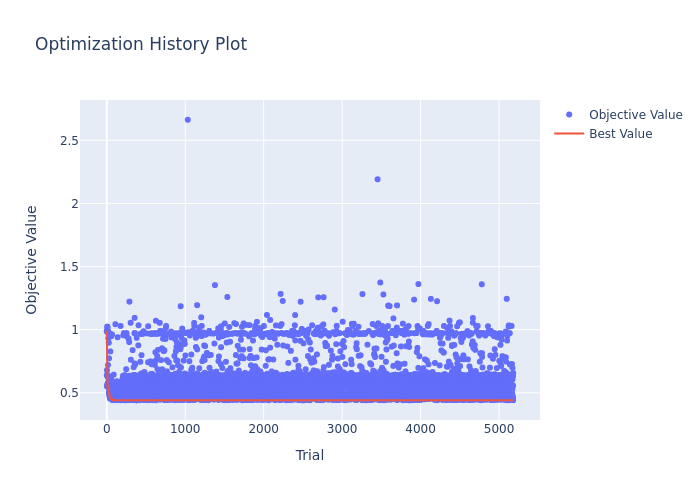

In [11]:
plot_optimization_history(study)

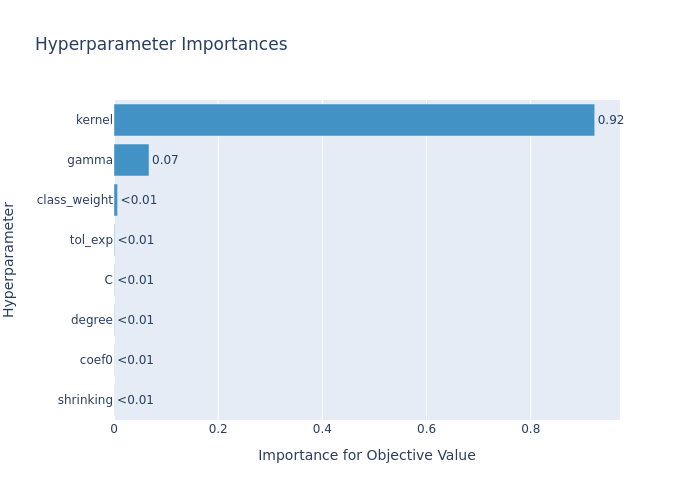

In [12]:
plot_param_importances(study)

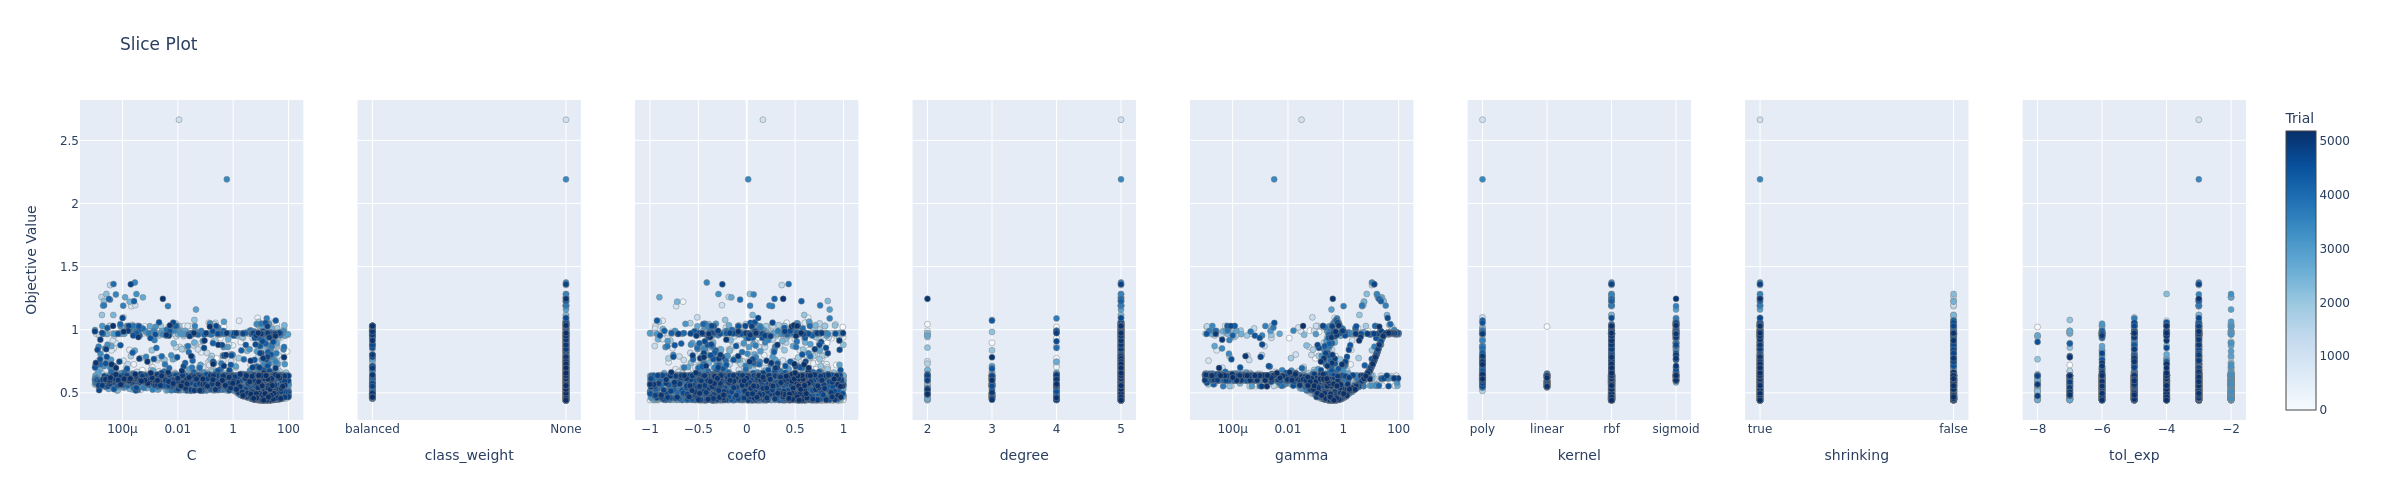

In [13]:
plot_slice(study)

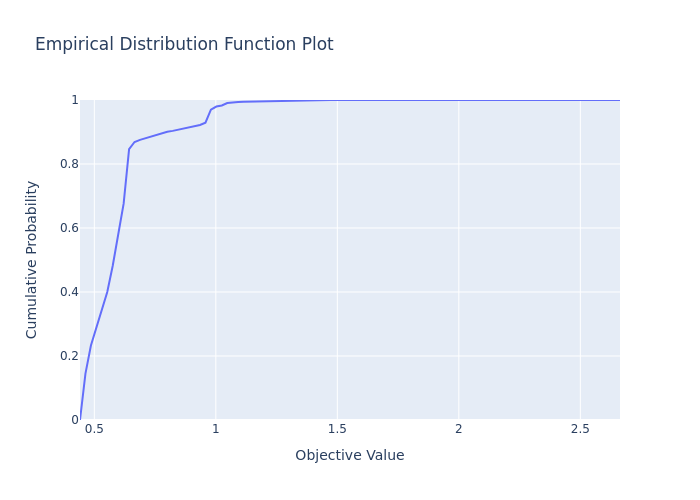

In [14]:
plot_edf(study)

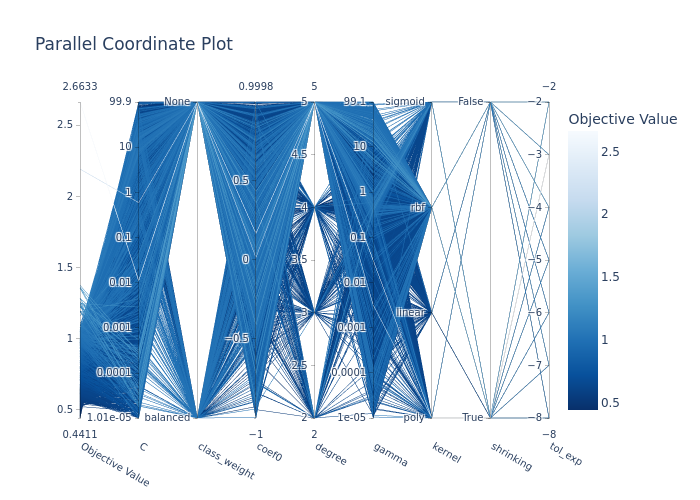

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params["tol"] = 10**best_params.pop("tol_exp")
best_params

{'C': 14.60185170338239,
 'class_weight': None,
 'coef0': 0.6800958032435374,
 'degree': 5,
 'gamma': 0.3927022761693554,
 'kernel': 'rbf',
 'shrinking': True,
 'tol': 0.001}

***